

# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model).

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```

to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
  ```



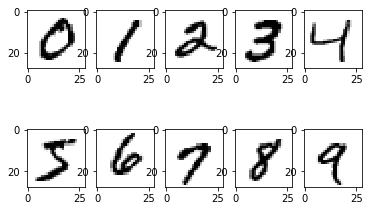

In [2]:
# your code
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

fig = plt.figure()

for i in range(10):
    im_idx = np.argwhere(y == str(i))[0]
    plottable_image = np.reshape(X[im_idx], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7)

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1
The Bayes rule states that the posterior holds
$$
\Pr(y|x)=\frac{\Pr(x|y)\Pr(y)}{\Pr(x)}
$$
Since $\Pr(x)$ is constant, it holds that

$$
\text{Posterior}=\Pr(y|x)\propto \Pr(x|y)\Pr(y) = \text{Likelihood}\cdot\text{Prior}
$$

So we can only estimate the right hand side, and take the $\arg\!\max$ as our classification. That is,

$$
h(x) = \arg\!\max_j\,\pi_j P_j(x)
$$

Also, due to the independence assumption, the joint probability becomes the product, so
$$
P_j(x) = P_{j}(x_1, \ldots, x_{784}) = \prod_{i=1}^{784} P_{ji}(x_i) = \prod_{i=1}^{784} p_{ji}^{x_i} (1-p_{ji})^{1-x_i}
$$

Finally, in order to avoid underflow it is better to look at the log, that is
$$
h(x) = \arg\!\max_j\,\pi_j P_j(x) = \arg\!\max_j\,\log(\pi_j P_j(x)) = \arg\!\max_j\,\log \pi_j + \sum_{i=1}^{784} \left(x_i \log p_{ji} +  (1-x_i) \log (1-p_{ji})\right)
$$


In order to esimate the different parameters in the above decision rule, we can choose the Bayesian best estimators simply as
$$
\begin{align}
\hat{\pi}_j &= \frac{n_j}{n} = \frac{\text{number of samples of class $j$}}{\text{total number of samples}} \\
\hat{p}_{ji} &= \frac{n_{ji}}{n_j} = \frac{\text{number of class $j$ samples where $x_i=1$}}{\text{number of samples of class $j$}} \\
\end{align}
$$

**Bonus part**

However, what if for some class $n_{ji} = 0$ or $n_{ji}=n_j$? In order to combat such edge cases which will set the probability of some $x_i$ being white (1) to 0 or 1 for that class, we can use something like "Laplace smoothing" and set

$$
\hat{p}_{ji} = \frac{n_{ji}+1}{n_j+2}
$$

which is like we added 2 additional samples for class $j$, one with $x_i=0$ and one with $x_i=1$. This can also be interpreted as a uniform prior on $p_{ji}$ with 1 pseudo count of each event.

#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2

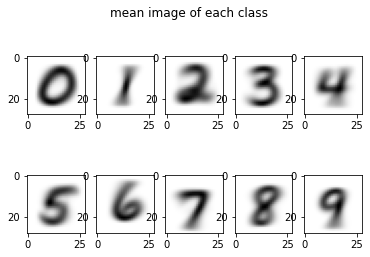

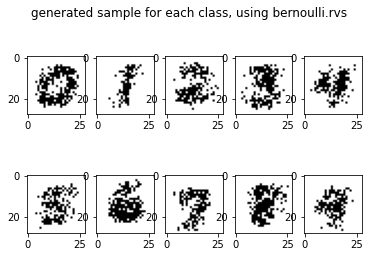

In [ ]:
# code goes here
from sklearn.naive_bayes import BernoulliNB
from scipy.stats import bernoulli

# plot mean image of each class
clf = BernoulliNB(binarize=0)
clf.fit(X_train, y_train)
y_estimate = clf.predict(X_train)
fig = plt.figure()
plt.suptitle("mean image of each class")
for i in range(10):
    im_idx = np.argwhere(y_estimate == str(i))
    plottable_image = np.reshape(np.mean(X_train[im_idx],axis=0), (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

# generate a sample for each class    
probs = (np.exp(1) ** clf.feature_log_prob_) > 0.5 #* 255
probs = bernoulli.rvs(np.exp(1) ** clf.feature_log_prob_)
fig = plt.figure()
plt.suptitle("generated sample for each class, using bernoulli.rvs")
for i in range(10):
    plottable_image = np.reshape(probs[i], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')  

Text(0.5, 1.0, 'Accuracy Score: 0.8283')

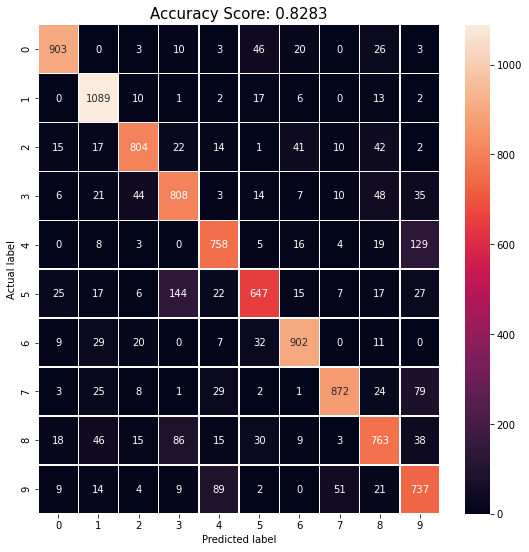

In [ ]:
# Confusion matrix and accuracy score

from sklearn import metrics
import seaborn as sns

predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

As can be seen, altough the mean image for each class looks pretty good, the generated samples are nothing like real handwritten digits. This is due to the low complexity of the model (assuming both independence and binarization of the pixels).

The total accuracy was found to be 0.83, which is pretty good considering how simplified this model is. The confusion matrix plotted below shows that while the there is a relative high accuracy for each class, there are quite a few miss classifications, where the highest error (confusion) occurs for the digits pair 3 and 5, the pair 4 and 9, and to somewhat less extent also the pair 3 and 8 (note that the confusion is **not symmetric**).

One way to find the optimal threshold for binarization, is to divide the trainning set into train and validation sets (maybe using k-fold cross validation), estimate the accuracy for different threshold values, and evaluate which would be the best threshold based on the resulting accuracy. Although there are also works on generalizin the ROC curve for multiclass problems (for example, see: [A simplified extension of the Area under the ROC to the multiclass domain](http://homepage.tudelft.nl/a9p19/papers/prasa_06_vuc.pdf), and [R pROC package](https://cran.r-project.org/web/packages/pROC/pROC.pdf)), the ROC curve won't be too helpful in this case, as the binarization threshold does not set the point on the TPR-FPR balance directly. 

Regardless, there are better approaches in image processing for image binarization, but this is another scope completely.

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.


* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).

In [3]:
# implement Naive Bayes estimator

from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import csr_matrix
import numpy as np
class NaiveBayes(BaseEstimator, ClassifierMixin):
  def fit(self, x, y):
    self.V = x.shape[1]
    n_d = x.shape[0]
    self.n_c = y.max() + 1
    prior = np.bincount(y)/n_d
    self.log_prior = np.log(prior)
    pct = np.zeros((self.n_c, self.V))
    #pct = csr_matrix((self.n_c, self.V))
    for c in range(self.n_c):
      ic = y==c
      xc = x[ic]
      Tct = xc.sum(axis=0)
      pct[c, :] = (Tct+1)/(Tct.sum()+self.V)
    self.log_pct = np.log(pct)
    
  def predict_log_proba(self, x):
    if not isinstance(x, np.ndarray):
      x = x.toarray()
    ll = np.dot(x, self.log_pct.T) # X(n,v) P(c,v)
    score = ll + self.log_prior
    return score      
  
  def predict(self, x):
    return np.argmax(self.predict_log_proba(x), axis=1)

In [4]:


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# CountVectorizer to count words
count_vect = CountVectorizer(stop_words='english')

nb = NaiveBayes()

# chain the vectroizer and the model
pipe = make_pipeline(count_vect, nb)
pipe.fit(newsgroups_train.data, newsgroups_train.target)

# find accuracy over the test data
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
y_test = newsgroups_test.target
y_pred = pipe.predict(newsgroups_test.data)
report = classification_report(y_test, y_pred, target_names=newsgroups_test.target_names)

print("implementation accuracy over the test data:")
print(report)
print("accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

implementation accuracy over the test data:
                          precision    recall  f1-score   support

             alt.atheism       0.65      0.30      0.41       319
           comp.graphics       0.58      0.69      0.63       389
 comp.os.ms-windows.misc       0.40      0.01      0.01       394
comp.sys.ibm.pc.hardware       0.53      0.72      0.61       392
   comp.sys.mac.hardware       0.74      0.56      0.64       385
          comp.windows.x       0.56      0.81      0.66       395
            misc.forsale       0.85      0.69      0.76       390
               rec.autos       0.82      0.70      0.76       396
         rec.motorcycles       0.91      0.62      0.73       398
      rec.sport.baseball       0.94      0.74      0.83       397
        rec.sport.hockey       0.58      0.91      0.71       399
               sci.crypt       0.54      0.79      0.64       396
         sci.electronics       0.71      0.49      0.58       393
                 sci.med       

In [5]:
# built in sklearn.naive_bayes.MultinomialNB accuracy

from sklearn.naive_bayes import MultinomialNB

sklearn_nb = MultinomialNB()
sklearn_pipe = make_pipeline(count_vect, sklearn_nb)
sklearn_pipe.fit(newsgroups_train.data, newsgroups_train.target)
sklearn_y_pred = sklearn_pipe.predict(newsgroups_test.data)
sklearn_report = classification_report(y_test, sklearn_y_pred, target_names=newsgroups_test.target_names)

print("sklearn.naive_bayes.MultinomialNB accuracy over the test data:")
print(sklearn_report)
print("accuracy: {:0.3f}".format(accuracy_score(y_test, sklearn_y_pred)))

sklearn.naive_bayes.MultinomialNB accuracy over the test data:
                          precision    recall  f1-score   support

             alt.atheism       0.65      0.30      0.41       319
           comp.graphics       0.58      0.69      0.63       389
 comp.os.ms-windows.misc       0.40      0.01      0.01       394
comp.sys.ibm.pc.hardware       0.53      0.72      0.61       392
   comp.sys.mac.hardware       0.74      0.56      0.64       385
          comp.windows.x       0.56      0.81      0.66       395
            misc.forsale       0.85      0.69      0.76       390
               rec.autos       0.82      0.70      0.76       396
         rec.motorcycles       0.91      0.62      0.73       398
      rec.sport.baseball       0.94      0.74      0.83       397
        rec.sport.hockey       0.58      0.91      0.71       399
               sci.crypt       0.54      0.79      0.64       396
         sci.electronics       0.71      0.49      0.58       393
            

In [6]:
model = MultinomialNB()

from sklearn.model_selection import learning_curve
n, tr, ts = learning_curve(model, newsgroups_train.data, newsgroups_train.target, verbose=10)

[learning_curve] Training set sizes: [ 753 2450 4146 5842 7539]
[CV]  ................................................................


/Users/noalubin/patient2rank/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/noalubin/patient2rank/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/Users/noalubin/patient2rank/venv/lib/python3.7/site-packages/

/Users/noalubin/patient2rank/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=["\n[deleted] \n\nI am glad that I am not an atheist.  It seems tragic that some people \nchoose a meaningless existence.  How terrible to go on living only \nbecause one fears death more than life.  I feel so sorry for Eric and \nyet any attempts to share my joy in life with him would be considered as \nfurther evidence of the infectious nature of Christianity.    \n\nAs a Christian I am free to be a human person.  I think, love, choose, \nand create.  I will live forever with God.\n\nChrist is not a kind of drug.  Drugs are a replacement for Christ.  \nThose who have an empty spot in the God-shaped hole in their hearts must \ndo something to ease the pain.  This is why the most effective \nsubstance-abuse recovery programs involve meeting peoples' spiritual \nneeds.\n\nThank you, Eric for your post.  It has helped me to appreciate how much \nGod has blessed me.  I hope that you will someday have a more joy-filled \nand abundant life."
 '\nI am told that Planned Parenthood/SIECUS-style "values-free" methods, that\nteach contraceptive technology and advise kids how to make "choices",\nactually _increase_ pregnancy rates. I posted a long article on this a while\nback and will be happy to email a copy to any who are interested.  The\narticle included sources to contact for information on research verifying\nthese statements, and an outstanding source for info on acquiring\nabstinence-related curricula even in single-copy quantities for home use.\n\nThe same research produced the results that abstinence-related curricula\nwere found to _decrease_ pregnancy rates in teens.  I assume that it is\nreasonable to assume that the AIDS rate will fluctuate with the pregnancy\nrate.\n\nThe difference is not in "contraceptive technology" but in the values taught\nto the children.  The PP/SIECUS curricula taught the kids that they have\nlegitimate choices, while the abstinence related curricula taught them that\nthey did _not_ have _legitimate_ choices other than abstinence.  It is the\nvalues system that is the strongest determinent of the behavior behavior of\nthese kids.\n\nDespite the better track record of abstinence-related curricula, they are\nsuppressed in favor of curricula that produce an effect contrary to that\ndesired.  \n\nQuestion for further discussion (as they say in the textbooks):  Why don\'t\nwe teach "safe drug use" to kids, instead of drug abstinence?  Isn\'t it\nbecause we know that a class in "how to use drugs safely if you _choose_ to\nuse drugs" would increase drug use?  Why isn\'t "drug abstinence education"\nbarred from schools because it teaches "religion"?  Aren\'t we abandoning\nthose children who will use drugs anyway, and need instruction in their safe\nuse?\n\n'
 '\n\nBut, the goal need not be a subjective one.  For instance, the goal of\nnatural morality is the propogation of a species, perhaps.  It wasn\'t\nreally until the more intelligent animals came along that some revisions\nto this were necessary.  Intelligent animals have different needs than\nthe others, and hence a morality suited to them must be a bit more\ncomplicated than "the law of the jungle."  I don\'t think that\nself-actualization is so subjective as you might think.  And, by\nobjectivity, I am assuming that the ideals of any such system could be\ncarried out completely.'
 "I really want to buy a powerbook and would like one that can run \nMathematica. So I need a coprocessor but I can not afford a PB180.\n(who can?)  Is it possible to put a MCP in a PB160? The guy at the  \nbookstore says no but I didn't think he had too much of a clue.\n\nPlease respond by e-mail:  ross@sbphy.physics.ucsb.edu"
 "\nTJ\nThis problem is most likely the same that all cx users are experiencing....\nThanks to one very adventurous USENET reader (sorry I can't remember the\nguy's name!  Somebody please post it....he deserves the credit for saving\nus all $$$$$) it is easily fixed, if it is the same problem......\n"
 '\nAll I know is that the Megadrives worked perfectly on both my\nMac Plus and my Powerbook 140.  It was for this reason I assumed\nthe problem had something to do with the Quadra.  Even with the\nQuadra, they mostly worked OK.  The problem occurred when I ejected\na cartridge from a drive: it would start popping up dialog boxes\nsaying "This cartridge must be formatted with Jasmine Driveware"\neven though there was no cartridge in the drive.'
 "<In article <31MAR199321091163@juliet.caltech.edu<, lmh@juliet.caltech.edu (Henling, Lawrence M.) writes...\n<<Atheism (Greek 'a' not + 'theos' god)  Belief that there is no god.\n<<Agnosticism (Greek 'a' not + ~ 'gnostein ?' know) Belief that it is\n<<  not possible to determine if there is a god.\n\n<No.  Agnosticism as you have here defined it is a positive belief--a\n<belief that it is not possible to determine the existence of any gods.\n<That's a belief I'm inclined to reject.  You have also defined atheism\n<here as a positive belief--that there is no god.  A fairly large number\n<of atheists on alt.atheism reject this definition, instead holding that\n<atheism is simply the absence of belief in a god.  Michael Martin, in\n<_Atheism: A Philosophical Justification_, distinguishes strong atheism\n\n My mistake. I will have to get a newer dictionary and read the \nfollow up line."
 '\n\nThe reason for the existence of hell is justice.  Fear is only an effect\nof the reality of hell.\n\n-- \nboundary, the catechist '
 '\n\nTerms are being used in a loaded way here.\n\n"Logical proof" is an extremely messy thing to apply to real\nlife. If you think otherwise, try to construct a proof that\nyesterday happened. Obviously it did; anyone old enough to be\nreading this was there for it and remembers that it happened.\nBut *proof*? A proof starts with axioms and goes somewhere.\nYou need axioms to talk about logical proof. You can say that\nyou remember yesterday, and that you take as axiom that anything\nyou clearly remember happened. I could counterclaim that you\nhallucinated the whole thing.\n\nTo talk about proofs of historical events, you have to relax the\nterms a bit. You can show evidences, not proofs. Evidences of the\nresurrected Jesus exist. Proofs do not.'
 '\n\n\n\n\n\n\tGood point -- it is very true that these "false" predictions are\ndangerous--we are warned (more than once) in scripture about false prophtets.\n\n\tHowever, as is often the case with other issues, one cannot let those\nwho falsly report such "visions" as a reason against believing in any of them\n(I did not get the impression you were asserting this, by the way...I consider\nmy response not so much a response to your posting but a response to the topic\nas a whole).\n\n\tExample:  The Appearances of Mary at Fatima, Portugal in 1917.\n\n\tAmong other things, she predicted the conversion of Russia to Atheism\n\t(something that happened less than a year later w/ the Bolshevik\n\trevolution).  She also predicted the second world war (that is, predicte\tpredicted that it would occur during the papacy of a certain pope, who\n\twas not the current one.  It happened just like she said.)\n\n\tShe warned there would be "fire in the sky" as a warning that the \n\tsecond world war was about to start.  About a week before Germany\n\tinvaded, weathermen (and women, I suppose) all over Europe, from\n\tEngland to Spain to Eastern Europe, reported the most spectacular\n\treddish color in the sky ever recorded.  To this day some try to \n\texplain it off as the northern lights, and the relation to Mary\'s\n\tprediction simply coincidence.  You all can decide for yourselves.\n\n\tMary predicted that the Atheistic Russia would spread her evils all\n\tover the world and persecute religion.  \n\n\tShe said many other things as well, too numerous to list here.  Every\n\tsingle one has been realized.  \tOne can only use the term "coincidence"\n\tso many times in the same explanation before its use becomes \n\tridiculous.  \n\n\tSO...yes, there are many false prophets and many false reports. There\n\tare true ones, too.  We must always remain open to that.  Fatima was\n\tone example.  There is another one, currently occuring--the \n\tapparitions that have been taking place at Medjurgorje, Yugoslavia\n\t(or whatever its called now).  Mary has been appearing every day for\n\televen years now.  It\'s time the world started listening.'
 '\n\n"Diet Evangelist".  Good term.  Fits Atkins to a "T".  \n\n\n-- \n----------------------------------------------------------------------------\nGordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and\ngeb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." '
 'What does a lack of taste of foods, or a sense of taste that seems "off"\nwhen eating foods in someone who has cancer mean? What are the possible\ncauses of this? Why does it happen?\n\nPt has Stage II breast cancer, and is taking tamoxifin. Also has Stage IV\nlung cancer with known CNA metastasis, and is taking klonopin (also had\ncranial radiation treatments).\n\nThanks!'
 'In <Apr.23.02.55.31.1993.3123@geneva.rutgers.edu>\nTim asks:\n\n   This is probably too simplistic for some, but John 3:16 saus,\n   "For God so loved the world that He gave His only son, that\n   whoever believes in Him should not perish but have eternal life".\n\n   Genesis 15:6, "And he (Abram) believed the LORD; and He reckoned\n   it to him as righteousness".\n\n   I don\'t find anywhere that God restricts heaven to particular\n   ethnic groups or religious denominations or any other category\n   that we humans like to drop people into. But He does REQUIRE\n   that we believe and trust Him. In Hebrews it says that God spoke\n   of old by the prophets (the old testament), but in these last days\n   he has spoken to us by His son Jesus Christ. And we learn of\n   Him through the pages of the New Testament. The Bible tells us\n   what we need to believe. For those who have never heard, I leave\n   them in God\'s capable care, He will make himself known as he\n   desires. It behooves each one of us to act upon the knowledge\n   we have. If you reject the claims of Jesus, and still go to\n   heaven, then the joke\'s on me. If you reject him and go to hell,\n   that\'s no joke, but it will be final.\n\n\n   Gerry'
 'My girlfriend is in pain from kidney stones. She says that because she has no\nmedical insurance, she cannot get them removed.\n\nMy question: Is there any way she can treat them herself, or at least mitigate\ntheir effects? Any help is deeply appreciated. (Advice, referral to literature,\netc...)\n\nThank you,'
 ': Hi,\n\n: I am new to this newsgroup, and also fairly new to christianity.\n: ... I realize I am very ignorant about much of the Bible and\n: quite possibly about what Christians should hold as true. This I am trying\n: to rectify (by reading the Bible of course), but it would be helpful\n: to also read a good interpretation/commentary on the Bible or other\n: relevant aspects of the Christian faith. One of my questions I would\n: like to ask is - Can anyone recommend a good reading list of theological\n: works intended for a lay person?\n\nI\'d recommend McDowell\'s "Evidence that Demands a Verdict" books (3 I\nthink) and  Manfred Brauch\'s "Hard Sayings of Paul".  He also may have\ndone "Hard Sayings of Jesus".  My focus would be for a new Christian to\nstruggle with his faith and be encouraged by the historical evidence,\nespecially one who comes from a background which emphasizes knowable faith.'
 ''
 'The ATF agent interviewed on "Street Stories" reported that the raid was\nill planned, and went ahead even when they (the BD\'s) knew the ATF was \ncoming. WHY?\n\nI believe this raid was ill planned because they only had 2 days to plan it,\nand it was continued when failure was obvious because it had a bit part\nin the much larger political agenda of President Clinton. I would even \nsuggest that the loss of 4 ATF agents is inconsequential in this the\ncontext of his political agenda. It MIGHT even be beneficial to his agenda, \nas it helps point up just how evil these assualt weapons are. Further proof\nmight be that the ATF denied their agents (Street Stories report) requests\nfor sufficient fire power. \n\nImportant dates: \nFeb 25th - NJ assembly votes to overturn assault weapon ban.\nFeb 28th - Compound in Waco attacked.\t   \n\nOn Feb. 25th the New Jersey assembly voted to overturn the assault weapon\nban in that state. It looked like it might be a tight vote, but the Senate\nin N.J. was going to vote to overturn the ban. It would not sit well to have\nan Eastern state overturn an assault weapon ban, given Clintons stated\nagenda on gun control. I suspect Clinton gave the order to get someone or some\ngroup with assualt weapons and have the press present (they were initially\nat the incident in Waco) to record the event for the TV audience. The agent \non "Street Stories" reported that a supervisor was urging them all to "get \nready fast", as "they know we are coming". I believe this attack continued, \neven tho the probablility of failure was high,  because it came from the top \ndown. After the N.J. assembly vote, the ATF had a limited amount of time to\ncome up with something, and the Wackos in Waco fit the bill nicely.'
 "Sounds as though his heart's in the right place, but he is not adept at\nexpressing it.  What you received was _meant_ to be a profound apology.\nApologies delivered by overworked shy people often come out like that...\n"
 'But someone will say, "You have faith; I have deeds." \n    Show me your faith without deeds, and I will show you my faith by what\nI do. '
 '\nTo start with, no methodology or form of reasoning is infallible.  So\nthere\'s a question of how much certainty we are willing to pay for in a\ngiven context.  Insistence on too much rigor bogs science down completely\nand makes progress impossible.  (Expenditure of sufficiently large sums\nof money and amounts of time can sometimes overcome this.)  On the other\nhand, with too little rigor much is lost by basing work on results which\neventually turn out to be false.  There is a morass of studies\ncontradicting other studies and outsiders start saying  "You people call\nTHIS science?"   (My opinion, for what it\'s worth, is that one sees both\nthese phenomena happening simultaneously in some parts of psychology.)  \n\nSome subjective judgement is required to decide on the level of rigor\nappropriate for a particular investigation.  I don\'t believe it is \never possible to banish subjective judgement from science.  \n\n\nMy second point, though, is that highly capable people can often make\nextremely reliable judgements about scientific validity even when using\nmethodology considered inadequate by the usual standards.  I think this\nis true of many scientists and I think it is true of many who approach\ntheir discipline in a way that is not generally recognized as scientific.\n\nWithin mathematics, I think there are several examples, especially before\nthe twentieth century.  One conspicuous case is that of Riemann, who is\nfamous for many theorems he stated but did not prove.  (Later \nmathematicians did prove them, of course.)  \n\nI think that for a good scientist, empirical investigation is often not\nso much a matter of determining what is true and what\'s not  as it is a \nmatter of convincing other people.  (People have proposed lots of \nincompatible definitions of science here, but I think the ability to \nobjectively convince others of the validity of one\'s results is an\nessential element.  Not that one can necessarily do that at every step \nof the scientific process, but I think that if one is not moving toward \nthat goal then one is not doing science.)\n\nWhen a person other than a scientist is quite good at what he does and\nseems to be very successful at it, I think that his judgements are also\nworthy of respect and that his assertions are well worth further\ninvestigation.  \n\n\nAdmittedly, my question was not at all well posed.  A considerable\namount of effort in a "serious scholarly investigation" such as I\nsuggested would be required simply to formulate an appropriately \nspecific question to try and answer.  \n\nThe "science" I was thinking of in my question is the actual science \ncurrently practiced now in the last decade of the twentieth century.  \nI certainly wasn\'t thinking of some idealized science or the mere use \nof "reason and observation."\n\nOne thing I had in mind in my suggestion was the question as to whether\nin many cases the subjective judgements of skilled and experienced\npractitioners might be more reliable than statistical studies.  \n\nSince Russell Turpin seems to be much more familiar than I am with\nthe study of scientific methodology, perhaps he can tell us if there \nis any existing research related to this question.  \n\n--\nIn the arguments between behaviorists and cognitivists, psychology seems \nless like a science than a collection of competing religious sects.   '
 "\n\nAgain, from my alcohol server's class:\nThe absolute *most* that eating before drinking can do is slow the absorption\ndown by 15 minutes.  That gives me time to eat, slam one beer, and ride like\nhell to try to make it home in the 10 minutes left after paying, donning \nhelmet & gloves, starting bike...\n\n"
 "In Windows I created a permanent Swap-file of 7771Kb as win3.1\nrecommended me to do that (32bit access).\nIf I use EMM386.EXE, after win3.1 startup I have 6689K of memory\nfree, if I leave EMM386.EXE out of my config.sys I have 9935K\nof memory free, and windows recommends me a swap file of 11769K.\n\nI use DOS6, with memmaker, have 4MB of internal Memory and a 486DX,\n\nDoes anybody knows why this is happening (possibly win needs\nsome UMB's to manage virtual memory?, If true, which UMB's, those\nthat EMM386 can find without including suspicious parts?)\n\nI need an optimized DOS-environment, because i develop applications for\nDOS using a windows programming environment.\n"
 '%\n% I was just wondering if there were any law officers that read this.  I have\n% several questions I would like to ask pertaining to motorcycles and cops.\n% \n\n   What happened to Charlie Lear??  He used to have "connections",  didn\'t\n   he?\n\n   (Hey, this is cyberspace mister...  you wanna \'stateside cop, ya gotta\'\n   specify!)\n\n-- \n   ------------------------------------------------------------------------\n  | John Little  - gaijin@Japan.Sun.COM  - Sun Microsystems. Atsugi, Japan | '
 '  ( in <1993Apr16.163729.867@batman.bmd.trw.com> )\n  ( responding to Dave "First With Official A.A Nickname" Fuller )\n \n[ ... ]\n\nThat means that it is an effective anti-recidivism measure.  It does\nnot say that it deters an individual from committing a capital crime\nin the first place.\n\nThe true question is whether the threat of death is likely to actually\nstop one from murdering.  (Or commiting treason -- are there any other\ncapital crimes anywhere in the USA?)  That is, if there were no death\npenalty, would its introduction deter a would-be criminal from\ncommitting her/his crime?  I doubt it.\n\nThis is only the first step.  Even if it were a strong deterrent\n(short of being a complete deterrent) I would reject it.  For what\nabout the case of the innocent executed?\n\nAnd even if we could eliminate this possibility, I would reject the\ndeath penalty as immoral. This makes me something of a radical on\nthe issue, although I think there are many opponents of captial\npunishment who agree with me, but who find the innocent executed the\nstrongest argument to make.\n\nI would, if magically placed in charge, facilitate state-aided suicide\nfor criminals who have life-sentences.  This could be a replacement\nfor capital punishment.  Those who don\'t want to live the rest of\ntheir lives in jail would always have this option.'
 "Thanks to all who replied to my initial question.  I've been away in \nNew Jersey all week and was surprised to see all the responses\nwhen I got back.  \n\nTo the person asking about nicotine patches, there are four on the\nmarket:"
 'Minolta FD 50 mm lens for sale. Good condition. Asking $30.'
 '\n\n\tYou have only shown that a vast majority ( if not all ) would\nagree to this. However, there is nothing against a subjective majority.\n\n\tIn any event, I must challenge your assertion. I know many \nsocieties- heck, many US citizens- willing to trade freedom for "security".\n\n\n--- \n\n        " Whatever promises that have been made can than be broken. "'
 '\n\nThis isn\'t true.  Many people are forced to use the "automobile system."\nI certainly don\'t use it by choice.  If there were other ways of getting\naround, I\'d do it.\n\n\nBut I think that the Court system has been refined--over hundreds of\nyears in the US, Britain, and other countries.  We have tried to make\nit as fair as possible.  Can it be made better (without removing the\ndeath penalty)?  Besides, life imprisonment sounds like a fatal punishment\nto me.'
 'Pardon me for interrupting, but why doesn\'t anyone ever bring up other\npossibilities besides more government, less government, or no government\nand stop there? It seems to me that the problems with society go MUCH\ndeeper than government. Democracies seem to reflective of the majority\nof society, both the good and the bad. If you take away the government,\nyou still have the structural flaws in society, except this time, with\nno restraints. Yes? No?\n\tWhy doesn\'t anybody ever discuss communal society, like a\nkibbutz? I never studied it on depth, but from what I\'ve heard, the kibbutz\nin Isreal was very successful. It is also very close to what Aristotle\nand Socrates believed was the best.\n\tSorry to detract from the discussion.\n\n\nBut what good is change if there is no tracable improvement in the human\ncondition? Who would ever support the change if you tell them it won\'t \nimprove their lives? I know that there are, and will be, libertarians \nwho will jump in now and say that it WILL improve our lives. I can deal\nwith that. All I\'m saying is that improving the human condition must\nbe the PRIMARY goal of any organization.\n\n\n------------------------------------------------------------------------------\n"Who said anything about panicking?" snapped Authur.           Garrett Johnson\n"This is still just culture shock. You wait till I\'ve       Garrett@Ingres.com\nsettled into the situation and found my bearings.\nTHEN I\'ll start panicking!" - Douglas Adams  '
 "\n  Gosh, Gregg.  I'm pretty good a reading between the lines, but\n  you've given me precious little to work with in this refutation.\n  Could you maybe flesh it out just a bit?  Or did I miss the full\n  grandeur of it's content by virtue of my blinding atheism?\n\n\n\n/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\ \n\nBob Beauchaine bobbe@vice.ICO.TEK.COM \n\nThey said that Queens could stay, they blew the Bronx away,\nand sank Manhattan out at sea."
 'I don\'t know if this is the sort of thing you guys like\nto discuss.  I guess it falls into the area of apologetics.\n\nThis is a question that seems to pop up now and again in\nconversations with non-christians.  It usually appears in\nthe following sort of unqualified statement:\n"Well you know that religion has caused more wars than\nanything else"\nIt bothers me that I cannot seem to find a satisfactory\nresponse to this. After all if our religion is all about\npeace and love why have there been so many religious wars?\n  Personally I am of the view that religion has often been\nused as an excuse to instigate wars often to disguise\nnational ambitions but I would love to hear what anyone\nelse has to say about this subject.\n  Thanks in advance\n  Andrew J Fraser\n\n(If we\'re thinking in terms of history, the Crusades,\nNorthern Ireland, Yugoslavia(?) come immediately to mind)\n\nnorthern Ireland, Yugoslavia (? \n  \n-- \n========================================================================='
 '\n\n\tI disagree: every proposition needs a certain amount of evidence \nand support, before one can believe it. There are a miriad of factors for \neach individual. As we are all different, we quite obviously require \ndifferent levels of evidence.\n\n\tAs one pointed out, one\'s history is important. While in FUSSR, one \nmay not believe a comrade who states that he owns five pairs of blue jeans. \nOne would need more evidence, than if one lived in the United States. The \nonly time such a statement here would raise an eyebrow in the US, is if the \nindividual always wear business suits, etc.\n\n\tThe degree of the effect upon the world, and the strength of the \nclaim also determine the amount of evidence necessary. When determining the \nlevel of evidence one needs, it is most certainly relevent what the \nconsequences of the proposition are.\n\n\n\n\tIf the consequences of a proposition is irrelvent, please explain \nwhy one would not accept: The electro-magnetic force of attraction between \ntwo charged particles is inversely proportional to the cube of their \ndistance apart. \n\n\tRemember, if the consequences of the law are not relevent, then\nwe can not use experimental evidence as a disproof. If one of the \nconsequences of the law is an incongruency between the law and the state of \naffairs, or an incongruency between this law and any other natural law, \nthey are irrelevent when theorizing about the "Truth" of the law.\n\n\tGiven that any consequences of a proposition is irrelvent, including \nthe consequence of self-contradiction or contradiction with the state of \naffiars, how are we ever able to  judge what is true or not; let alone find\n"The Truth"?\n\n\n\n\tBy the way, what is "Truth"? Please define before inserting it in \nthe conversation. Please explain what "Truth" or "TRUTH" is. I do think that \nanything is ever known for certain. Even if there IS a "Truth", we could \nnever possibly know if it were. I find the concept to be meaningless.\n\n--\n\n\n       "Satan and the Angels do not have freewill.  \n        They do what god tells them to do. "'
 "THE WHITE HOUSE\n\n                  Office of the Press Secretary\n                 (Vancouver, British Columbia) \n______________________________________________________________\n\n\n                       BACKGROUND BRIEFING\n                               BY\n                 SENIOR ADMINISTRATION OFFICIALS\n\n\n                          April 4, 1993\n\t     \n                          Canada Place\n                  Vancouver, British Columbia  \n\n\n9:40 A.M. PST\n\t     \n\t     \n\t     Folks, we're about to start the BACKGROUND BRIEFING \non the aid package.\n\n\t     SENIOR ADMINISTRATION OFFICIAL:  Good morning.  The \nPresident -- President Clinton and President Yeltsin agreed \nyesterday on a series of American initiatives to support economic \nand political reform in Russia, and it's valued at $1.6 billion.  \n\n\t     Before taking your questions and running through the \nbasic outlines of this package, I want to make a few points.  \nFirst, this is the maximum that the Clinton administration can do \nwith available funds to support Russian reform.  All of the funds \nhave been allocated and appropriated by the Congress.  There is \nno need for the administration to go back to the Congress to fund \nany of these programs.  All our Fiscal Year '93 funds currently \nare available, so in effect, all of these programs can begin \ntomorrow.\n\t     \n\t     The second point is that this package is designed to \nsupport Russian reformers.  All of the initiatives in the package \nare directed at reformers and for their benefit, and all have \nbeen worked out with prior consultation with the Russian \ngovernment.\n\t     \n\t     Third, the President is determined that we will \ndeliver on these commitments this year.  The package is designed \nto maximize our ability to support reform.  In designing it we \nwanted to avoid making commitments that we could not meet, and we \nfeel very confident that we can meet all of these commitments in \nfront of you.\n\t     \n\t     Fourth, I'd like to note the special importance of \ntrade and investment.  I think it's fair to say that Russia's \ncapital and technology needs throughout the next decade extend \nwell into the hundreds of billions of dollars.  No collection of \ngovernments can meet those needs; only the private sector can do \nso.  And so the President and President Yeltsin agreed to make \ntrade and investment a major priority in the relationship.  \n\t     \n\t     They also agreed that there would be a new joint \ncommission on energy and space formed, headed on the U.S. side by \nVice President Gore; on the Russian side by Prime Minister \nChernomyrdin.  And the goal of this effort is to break through \nthe barriers to trade and investment on both sides and to promote \na vastly expanded relationship.\n\t     \n\t     If it would be helpful I'd be prepared to run down \nthe first page, which is a summary of U.S. assistance, and just \ngive you some general background on what these programs are.  \nI'll do it quickly and then I'll be glad to take questions.\n\t     \n\t     The first group of initiatives are humanitarian food \nand medical assistance.  This is part of our effort which has \nbeen underway for several years to provide basic humanitarian \ngrant food assistance so that the Russian government can assure \nthere's at least a minimal amount of bread on the shelves in the \nmajor cities.  That's $194 million in grant -- that is from Food \nfor Progress, the grant portion of Food for Progress.  We'll also \nbe continuing our grant assistance in medicines and \npharmaceutical supplies, and that's $30 million.\n\t     \n\t     The second item is concessional food sales.  As you \nknow, the United States has had a long-term grain relationship \nwith Russia.  It's important to us and it's important to Russia \nthat we continue that relationship.  The President has chosen the \nFood for Progress program which is a concessional loan program.  \nThe value over the next seven months is $700 million.  These are \nconcessional terms.  The exact terms have not been worked out, \nbut I think it's fair to say there will be a grace period on \nprincipal of six or seven years, and concessional rates \nthereafter for the life of the deal.\n\t     \n\t     The third program is a collection of private sector \nsupport.  We think this is one of the most important things we're \ngoing to do.  Privatization and the creation of small businesses \nis the number one priority of the reform government in Moscow.  \nAnd so the President has decided to create a Russian-American \nenterprise fund capitalized this year at $50 million.  And the \ngoal of this fund is to make direct loans to small businesses in \nRussia, to take equity positions in those businesses.  \n\t     \n\t     The President has also decided to create a \nprivatization fund which would work directly with the Russian \ngovernment in its priority objective of trying to convert state \nenterprises from a state-owned basis to a private basis.  He has \nalso agreed -- the President has also agreed to establish a \nEurasia foundation.  This would be a private foundation led by \nprominent Americans to fund democratization projects in Russia.\n\t     \n\t     The fourth grouping you see there in the summary \npage is democratization itself.  I think it's fair to say that \nthis administration has given a new impetus to the goal of \npursuing democratization in Russia.  You see that we have a total \nof $48 million in programs, various programs.  The detailed \ntables give an indication of some of the programs that we're \nlaunching.  \n\t     \n\t     The President is also calling for the development of \na democracy corps, which will be an overarching umbrella group to \ntry to incorporate all of the disparate private and public \nefforts now underway from the United States to support reform in \nRussia.\n\t     \n\t     The fifth program you see is Russian office of \nresettlement.  This is a new initiative created and \nconceptualized by this administration.  This is a demonstration \nproject.  What we'd like to do is work with the Russian military \nto help resettle Russian officers returning from the Baltic \nstates and other parts of the former Soviet Union.  We want to \nmake sure that we work out the best way to do that, whether it's \nwith Russian labor and Russian materials or using prefab American \nconstruction.  And so we've decided to fund on a demonstration \nbasis the construction of 450 housing units.  We'll be working \nvery closely with the Russian military on this.  And I would say \nthat we have a long-term commitment to this project.  \n\t     \n\t     The sixth area is energy in the environment.  They \nare two issues that the President feels strongly about.  Our \ninitial efforts will be feasibility studies to look into the \npossibility of enhancing their energy production, both oil and \ngas; and equally important trying to cut down on the leakages in \nthe oil and gas pipeline systems, which cause so much \nenvironmental damage.\n\t     \n\t     I've talked a little bit about trade and investment, \nabout the new group being created that the Vice President will \nchair on our side.  Secretary Ron Brown will also be cochairing \nwith Deputy Prime Minister Shohkin, a business development \ncommittee, which will work in all other sectors of the economy, \nto break down the many barriers that currently exist and impede \ntrade and investment.  We are also going to appoint a full-time \ninvestment ombudsman in the American government to work on this \nproblem full-time.  \n\t     \n\t     And the point I'd like to make here is, trade and \ninvestment in the 1990s is every bit as important, to draw an \nanalogy, as arms reductions was in the '70s and '80s.  And we \njust thought that in looking at this we needed to make a \ncommitment within our own government to have people work on it -- \nsenior people on a full-time basis, because it is terribly \nimportant.\n\t     \n\t     You'll notice that the United States is going to \nsupport Russia's membership in the GATT.  Russia has had observer \nstatus.  Russia has requested our support and, in fact, requested \nour advice in becoming a member of the GATT.  We think that the \nlong-term goal of drawing Russia into the global economy is \nparamount, a very important goal.  And that is why we are \nsupporting the membership in the GATT.  We are also supporting \ntheir access to GSP, the Generalized System of Preferences.  \n\t     \n\t     You'll note that Ex-Im has extended $82 million in \ncredit for a caterpillar deal in Siberia, that OPIC has extended \n$150 million in credits and loan guarantees for a Conoco oil \nproject.  I'd like to emphasize that we are very close to an \nagreement between Russia and the United States for a $2-billion \nframework facility through the Ex-Im Bank that would finance \nRussian purchases of American oil and gas equipment and services. \nWe think this is a very important development.  We think we'll \nget there by April 14th, which is the opening day of the Tokyo \nconference, the G-7 conference.\n\t     \n\t     Before I take any further questions, I'd like to \ndefer to my colleague, who will review the security assistance \nobjectives with you.\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Our major \nunfinished agenda with the Russians and with their counterparts \nin Ukraine, Kazakhstan and Belarus is in the area of the safe and \nsecure dismantlement of the nuclear arsenals on their territory \nunder the terms of the START I and START II agreements.   \nRecently we completed in Moscow three, I think, very important \nagreements that devote a significant chunk of Nunn-Lugar funding \nto three important programs.  The first is the program of $130 \nmillion for the strategic nuclear delivery vehicle dismantlement \nprogram.  That is for submarines, for ICBM dismantlement and for \nbomber dismantlement -- $130 million.\n\t     \n\t     The second is a $75 million tranche of funding for \nthe construction of a facility to store nuclear materials removed \nfrom the warheads as they are dismantled.  This will essentially \ncontribute to the overall design and the early phases of the \nconstruction of that storage facility.  \n\t     \n\t     And finally, a $10-million tranche of money to help \nin the establishment of a monitoring system for the nuclear \nmaterials as they are withdrawn from the weapons system.  So we \nadd that $215-million total to the extant Nunn-Lugar assistance \nwhich has been flowing -- about $150 million for some overall \nsafety improvements for various kinds of equipment and safety \nmeasures that we have been working out with the Russians over the \nlast couple of years.  \n\t     \n\t     So this is an area where we will be going a lot more \nwork with not only the Russians but with the Ukrainians, Kazhaks, \nand Belarussians.  Belarus, for example, has just, in the last \ncouple of weeks, received up to $65 million in FY'93 funds for \nsafety, security and dismantlement programs on Belarussian \nterritory.  And this was in the wake of their ratification of \nSTART I, an agreement to accede to NPT. \n\t     \n\t     So we are working very hard with all the parties to \nthe Lisbon protocols, and will continue to work very hard with \nthem.  And I look upon these three recent agreements with Russia \nas a very important step in that process.\n\t     \n\t     Q\t  The OPIC funds to -- is that for the field in \nKazhakstan -- and Conoco already signed this deal with \nKazhakstan.  Why do you feel now it is necessary -- if it's the \nsame one, why do you feel it's necessary?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  It's not the same \ndeal.  Chevron signed a deal with Kazhakstan, the Tenges oil \nfield.  This is a new investment project.  It's a polar lights \noil development and renovation project, and it's being announced \ntoday.  So it's completely new.\n\t     \n\t     Q\t  Can you tell us more about what's involved?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Yes.  Conoco, like \nother American oil companies has been searching for ways to do \ntwo things.  One, to prospect for new oil in Siberia, west \nSiberia; and two, to try to get into the business of renovating \noil wells and renovating pipelines, both oil and gas, in Russia.  \nThe objective here, obviously, is to take advantage of the \nnatural resources in Russia, increase energy production, which \nwill, in turn, increase hard currency revenues, which is what \nRussia needs.\n\t     \n\t     So we think this deal is very, very good development \nfor Russia.  The Russians do as well, and it's good for an \nAmerican company.  And the American government has played a \nleading role in pulling this together through the credit facility \nin OPIC and through the loan guarantee.\n\t     \n\t     Q\t  So it's to search and also to renovate fields \nthat are already there?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  That's right.\n\t     \n\t     Q\t  On that point, should other American companies \nexpect to get administration support for such deals, or should \nthey now go to the Ex-Im and try to get the money out of the $2 \nbillion?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Well, as you know, \nEx-Im is part of the U.S. government and various parts of the \nU.S. government have been pushing, including the State Department \nand the White House for this deal to be consummated.  And we \nthink it will.  And if we arrive at this agreement by April 14th, \nthere will be $2 billion in financing available for American \ncompanies to sell their equipment and sell their services.\n\t     \n\t     Q\t  That should take up all of the rest of the \ndeals and their won't be -- and their will or there won't be \nsupport for OPIC sort of deals such as this Conoco?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  There's a \ntremendous amount of interest on the part of American oil and gas \ncompanies to invest in Russia.  We think that the Ex-Im oil and \ngas facility, the $2-billion facility, once it is concluded, will \nsoak up a lot of that interest.  But I think the interest may \neven extend beyond that.  And if so, the government will respond.\n\t     \n\t     Q\t  What's the current year budget costs of that \n$2-billion agreement should it go forward?  And is there any \ncurrent year budget costs --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  I'll have to refer \nyou to Ex-Im for that.  I don't know the details of that.\n\t     \n\t     Q\t  The concessional food sales -- is there any \ncurrent year costs to that, or is it delayed until the years in \nwhich the payments are due?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  The concessional \nfood sales are from Food for Progress, which is a USDA program.  \nUSDA has the funds, we don't need to go back to the Congress to \nexpend those funds.  There will be a hit in the budget.  I'd \nrefer you to USDA and OMB for the details on that.\n\t     \n\t     Q\t  Can you talk about the Democracy Corps?\n\t     \n\t     Q\t     and the private sector -- how many folks are \ngoing to be involved in that?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Why don't I start \nwith the Democracy Corps first.  I think the administration felt \ncoming into office that there were literally thousands of \norganization, private organizations in the United States that in \none way or another were working at the goal of trying to achieve \ndemocratization in Russia, helping on a farmer-to-farmer basis.  \nAnd there were literally 10 or 15 U.S. government agencies that \nhad a variety of programs in this area.  And so the \nadministration felt -- the President felt it was important to try \nto draw all of these initiatives together under one group to give \nsome coherence to the efforts and to give some impetus to the \nefforts.  And so this is a presidential initiative.\n\t     \n\t     It will be headed by Ambassador Tom Simons who will \nsoon take up his duties as the coordinator for U.S. assistance in \nthe former Soviet Union.  And we're very hopeful that we might \nuse this Democracy Corps not only to draw upon the resources of \nour own government, but the resources of the American private \nsector and schools and communities across the nation.\n\t     \n\t     Q\t     any kind of commitment yet, any kind of word \nyet on FY'94, and any new money that needs to be appropriated \nbesides the $300 million the President talked about?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  The administration \nis requesting additional funds in FY'94 of $700 million.  What \nthe President has done this weekend is to consult really \nintensively yesterday with President Yeltsin about additional \nmeasures the United States could take in some of these areas to \nsupport reform.  He'll be consulting with the Congress.  When he \nreturns to Washington, he'll be consulting also with the other \nally governments, and we'll make a decision at that time.\n\t     \n\t     Q\t  Two questions about the $700 billion \nagricultural money.  First of all, I thought it was the sort of \nconsensus that what Russia did not need was more loans for food.  \nSo why did you decide to do it that way?  Secondly, could you \nexplain -- agriculture has been stopped from making further loans \nfor food because of Russia's inability to pay.  How does this fit \ninto that situation?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  As you know, the \nUnited States for a long time has been a major supplier of grains \nand food commodities, agricultural products to Russia.  I think \nbetween 1991 and '92 we had extended -- a little bit of history \nhere -- about $5.5 billion in credits, credit guarantees, through \nthe Commodity Credit Corporation.  That was the principal vehicle \nto ensure the sale of American grain products.  On December 1 of \nlast year, '92, the Russian government stopped its payments on \nthat program.  They are now in arrears to us on that program, and \ntherefore, by law, the United States cannot continue that \nprogram.  And so the President, working with Secretary Espy and \nother officials in the Cabinet, looked for other ways that we \ncould promote American grain sales.  \n\t     \n\t     And I think we have two ways to do that.  We've \nannounced today $194 million in grant food assistance through the \nFood for Progress program.  But we do not have sufficient \nauthority to spend $700 million in grant food, and so we looked \nfor a concessional loan program.  \n\t     \n\t     I think everybody agrees that Russia -- that a \nshort-term loan program for Russia would not make sense now, but \na long-term concessional loan program would.  And that is what \nthis program is.  It will provide, once the final details are \nworked out, for a six to seven-year grace period on payments of \nprincipal.  And then from years seven through 15, which is the \nlife of the deal, it will provide for concessional rates of \ninterest -- generally around three to four percent.  And so we \nbelieve and the Russian government believes this is a good deal \nfor them because it will avoid the imperative of early payments \nand put them into the out years, but it will also continue this \nvery important grain relationship, which is important for them, \nand it's important for the American farm community.\n\t     \n\t     Q\t  I gather from what you say that this could make \nit explicit -- the Russians' failure to pay the interest on ECC \nloan does not in any way affect this kind of loan going through, \nis that right? \n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Let me be explicit \nabout that.  We are prevented under the law to from continuing  \nthe Commodity Credit Corporation short-term credit program \nbecause of Russia's arrearages to the United States.  All of you \nknow about those arrearages.  They total about, I think, around \n$640 million.  USDA can give you an exact figure.  So having \ntaken that into consideration and wanting to preserve American \nmarket share and a long-term grain relationship, wanting to \nrespond to a specific request from the Russian government for \nmajor food assistance, knowing that we couldn't take it from the \ngrant programs because we don't have sufficient authority there, \nwe looked at Food for Progress, which is a program we've used to \ngreat effect in other parts of the world.  And we consulted with \nthe Russian government and arrived at this solution.  \n\t     \n\t     I think the Russians are pleased because it provides \nthem with the food, but also gives them a little bit of relief on \nthe short-term payments.\n\t     \n\t     Q\t  Where do those funds actually come from?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  They come from the \nFood for Progress program, which is a program under USDA's \nauthority.  USDA has the authority to spend these funds.  We do \nnot need to go back to the Congress for these funds.  And I want \nto make that general point again:  Everything in this package, \nthe $1.6 billion package, comprises funds that have already been \nallocated and appropriated by the Congress.  The administration \ncan begin to spend these monies tomorrow.  And it's very \nimportant in our eyes that we expend all the funds this year, \nthat we meet these commitments.  And we are confident we'll be \nable to do so.\n\t     \n\t     Q\t  How did you arrive at the figure of $700 \nmillion -- does that max out that program, or did you actually \nhave a range from 0 to --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  There's a reason \nfor it.  The reason was that the Russian government told us \nthat's about the amount of grain that they needed between now and \nharvest time.  And so the idea is that we would begin the \nshipments probably $100 million per month from now until the \nharvest in the autumn, at which time Russia won't require the \nsame level of food imports from the West.\n\t     \n\t     Q\t  I would imagine there's going to be some \nconsiderable envy and jealousy on the part of some of the other \nrepublics because of the size and the scope of this with Russia.  \nHave you given any consideration to advancing negotiations for \nthe same kinds of projects with the Ukraine, with Georgia , with \nsome of the other republics?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL: Yes, we're very \nconscience of the fact that we also have an interest in extending \nAmerican support to the 11 other countries of the former Soviet \nUnion.  We have told ourselves, and we have planned that in the \narea of technical assistance, the grant technical assistance that \nyou see, roughly 50 percent of the funding will go to Russia and \nroughly 50 percent to the other countries. \n\t     \n\t     In the area of food sales, we have been active with \nUkraine, in grant food assistance with Georgia and Armenia.  We \nwill continue that.  And I think it's fair to say that after this \nsummit we will go back and look at all of our programs with the \nother countries to ensure that they are adequate and they are \nproductive and they're hard-hitting.\n\t     \n\t     Q\t  Has anything happened at the summit to lead \nAmerican energy companies and other companies to believe that \nRussia is going to be more user-friendly toward them in terms of \ntaxing, legalities, bureaucracy?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Well, one of our \nprimary objectives coming into this summit was to highlight,  not \nonly the economic agenda, but also trade and investment.  And I'd \nlike to refer to the point I made at the beginning.  We're \nconvinced in talking about this problem -- the problem of how to \nsupport Russia long-term -- we're convinced that no collection of \nWestern governments have the financial resources over the next \ndecade to fuel the continuation of reform, that only the private \nsector can do that.  \n\t     \n\t     We look at our own society and we see tremendous \ncapability in resources in the oil and gas sector.  It is a very \ngood match with what the Russians need now, which is financial \ninvestment in the existing oil and gas wells and pipeline and new \ntechnology and new capital to finance new production.  \n\t     \n\t     That's what the Russian government has told us it \nwants to do, and so that's why we have made such a major emphasis \non it.  That's why trade and investment was a prominent issue on \nthe first day of these talks, and in fact, figured prominently \nlast night in the meeting between President Yeltsin and President \nClinton.  And we're hoping that together we might send a strong \nsignal to the American business community that we support their \nefforts to invest in Russia, that the United States, through Ex-\nIm and OPEC and the Department of Commerce, will be there to \nsupport them.\n\t     \n\t     Q\t  My question is, is Yeltsin in any position to \ndeliver on making Russia a more --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  We think he is.  I \nwould note that President Yeltsin's Prime Minister, Mr. \nChernomyrdin, worked for 30 years in the Russian oil and gas \nsector.  He will now chair a high-level commission with the Vice \nPresident, Vice President Gore, to try to break through the \nbarriers that currently exist to Western investment in the oil \nand gas sector.  We believe we have a commitment to make that \ncommittee an important committee.  And we're looking forward to \nthe work.\n\t     \n\t     Q\t  What type of mechanism is already in place to \nadminister the private sector portion of the program?  And will \nthe U.S. be directly involved in the tail end of distribution of \nthe actual funds or is the money simply turned over to the \nRussian government for distribution at their will?\n\t     \t    \n\t     SENIOR ADMINISTRATION OFFICIAL:  Are you talking \nabout the variety of programs listed here?  It depends on the \nprogram itself.  In most cases, though, we are either working \nthrough American PBOs or American government agencies to ensure \nthat the money obviously is well spent, that the money gets to \nthe intended source.  That's an obligation we have to the \nCongress to ensure the money is well spent and that we can \naccount for the money.  We have done that in the last couple of \nmonths intensively and we will continue to do it for each of \nthese programs.\n\t     \n\t     But they are all quite different.  For instance, in \nthe area of grant food and medical assistance, for grant food it \nis carried out through USDA and USDA accounts for the delivery of \nthe food.  For grant medical assistance, we've been working \nthrough Project Hope which is a private organization.  For the \nhousing -- for instance, the resettlement of Russian officers, \nwe'll be working with a group of American PBOs.  On some of the \ndemocratization projects, we're working directly with Russian \nprivate individuals and private foundations.  We're working with \njournalists in Russia on a media project that you may have \nnoticed.\n\t     \n\t     So we literally have here 30 to 40 different \nactivities under all these rubrics and they're all going to be \ncarried out in slightly different ways.  Some directly with the \nRussian government, some with Russian citizens.\n\t     \n\t     Q\t  The Jackson-Vanik restrictions that remain and \non the COCOM restrictions that remain, can you tell us what the \nPresident has to do on that?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Well, as George \nnoted yesterday, President Yeltsin raised these as irritants in \nthe relationship.  The President has noted that.  I think it's \nfair to say we will go back now in our own government when we \nreturn to Washington and look at both of these questions, and \nwe'll get back to the Russian government.\n\t     \n\t     Q\t  You were not prepared for these questions when \nyou got here?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  We were prepared \nfor these questions.  We've looked at them.  But we're not \nprepared to make a quick decision this weekend.  They require --\nlet me just explain, particularly on Jackson-Vanik.  They require \nconsultation with the Congress.  They require consultation with \nthe American Jewish community.  And we're very sensitive to those \nconcerns.  And so we'll want to go back and talk to them before \nwe take any action.\n\t     \n\t     Q\t  Is this package designed so that you will not \nhave to go to Congress for anything at this point?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  As I said at the \nbeginning, the advantage of this particular package is that all \nthe funds have been allocated and appropriated by the Congress.  \nSo the administration will not have to go back to the Congress to \nseek any additional authority to fund any of these efforts.  In \neffect, they can all begin tomorrow, and I know that many of the \nagencies responsible for these projects will begin tomorrow.  And \nthat's the advantage of this particular initiative.\n\t     \n\t     Q\t  If this, as the President says, is a long-term, \nlong-haul thing, and members of Congress are at this moment \nheading for Moscow, why aren't you talking about going to \nCongress and suggesting to the President of Russia that you are \nprepared to go to Congress for various things?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  I think we've been \nclear about that.  The President is discussing this weekend with \nPresident Yeltsin some additional ideas that we have for American \nfunding of additional projects, and ideas that he has.  We have a \nmajor congressional delegation that left last night, headed by \nRepresentative Gephardt and we'll want to consult with that \ndelegation and other members of Congress before doing anything.  \nAnd we'll also want to consult with our allies.  So that's where \nit stands now.\n\t     \n\t     Q\t  We've been told repeatedly that a number of \nthese items represent different or new ways of spending the money \nalready appropriated.  Could you just tick off which of these \nitems represents reprogramming or at least spending money in ways \nthat it was not previously set to be?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  I think that we've \nsaid that these are all projects that either Congress had \nallocated money for through the Freedom Support Act; there were \nsome funds that were left over from FY'92.  And this \nadministration took office and had some new ideas about how the \nfunds might be expended.\n\t     \n\t     We didn't use just the Freedom Support Act funds or \nthe FY'92 funds.  We went into some of the agency allocations --\nEx-Im, OPIC, and USDA -- and tried to look for creative ways to \nfurther our programs.\n\t     \n\t     And example of that is the Food for Progress \nconcessional loans.  We had hit a brick wall with another type of \nfunding through USDA.  We could not go forward legally, and so we \nlooked for a more creative way to ensure continued American \nmarket share and ensure continued grain sales, and we think we \nfound it.\n\t     \n\t     Q\t  Where, for example, are you getting the money \nfor this Russian officer resettlement --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  That's from the \nFreedom Support Act funds.\n\t     \n\t     Q\t  In other words, all of the money is being \ndirectly spent in new ways, so to speak --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Most of the grant \nprojects that you see -- if you look at the general chart, the \nsecond chart, it's broken down into grant and credits.  And if \nyou look under grants, the technical cooperation projects that \ntotal $281.9 million -- that is almost all Freedom Support Act \nfunding.  A little bit of it is leftover funds from fiscal year \n'92.  The Nunn-Lugar funds, of course, you know about the \nlegislative history of those funds.\n\t     \n\t     Q\t     cooperation --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  From FY '92?  I \ndon't have the exact figure.  It was not a considerable figure.\n\t     \n\t     Q\t  Could you tell us please, has anything happened \nhere this weekend that will break the log jam between Ukraine and \nRussia over START -- for START I and II as a result of what's \nhappened here --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Both presidents, \nPresident Yeltsin and President Clinton, will be discussing this \nissue this morning.  In fact, we haven't yet gotten to security \nand arms control related issues.  That will be this morning's \nsession.  I know that President Clinton will be very strongly \nreinforcing that this is a top priority for us.  We've been \ntalking to the Russians and the Ukrainians over the last couple \nof weeks about ways that we might help to facilitate the \ndiscussions between them.  Up to this point, this has been a very \nimportant negotiation that's been going on essentially between \nMoscow and Kiev.  And we are at the point now of essentially \ndiscussing with them if there are ways that we could contribute \nto this discussion, help to move things forward essentially.  \n\t     \n\t     But in terms of what is coming out of this weekend, \nI don't yet know.  In a couple hours we'll know.\n\t     \n\t     Q?\t    Just a follow-up on the financing here.  Is \nany of this robbing Peter to pay Boris -- since it's all current \nyear appropriations, have you taken it from anyplace that's been \nearmarked and put it into this fund?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  There are smoke and \nmirrors here, and I think it's an important point to note.  We \ncould have given you a page of assistance numbers that included \nout-year funding.  We're going to make a long-term commitment to \nmany of these projects -- for instance, the enterprise funds, the \nprivatization effort, the housing effort.  And we've already \ntalked to the Russians about our long-term commitment.  \n\t     \n\t     We could have put in really big numbers and this \ncould have been a bigger package, but we wanted to make a point:  \nThis package is FY '93.  It's funds that we have.  And we're \ngoing to do what we say we're going to do.  And the President \nfeels very strongly about that.  In the past there is a legacy \nthat the western governments, the combination of governments, put \nup large budget figures and for any number of reasons we're not \nable to meet them, we're determined, and the President is \ndetermined, to carry out every single program in this package.  \nAnd we'll do it.  \n\t     \n\t     But we do have a longer-term commitment, and that's \npart of the discussions on economics this weekend.  We're looking \nfor Russian ideas on what it is we can do to most effectively \nsupport reform.  And we've told them that we do have a commitment \non some of these programs beyond this fiscal year.\n\t     \n\t     Q\t     taken it way from any --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  No, we haven't.  \nOkay, the question is, have we reprogrammed any of these funds; \nso have we taken it from other countries to pay for programs in \nRussia?  The answer is no, we have not done so.\n\t     \n\t     Q\t  In terms of funding, there is no available \nmonies left -- and you simply find a creative way to find money \nsomewhere else.  Doesn't that, in fact, support the -- theory?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Not at all.  I \ndon't think it does.  That's a particular example, and the \nexample is grain sales.  The Commodity Credit Corporation credit \nguarantee program was short-term loans that Russia had to pay \nback within 12 to 15 months.  You all know about Russia's debt \nproblem, and Russia was unable to meet those commitments.  So we \nlooked for a way to do two things:  to meet Russia's requirement \nfor grain.  They're a net grain importer on a massive scale, and \nalso meet our objective of making sure that the American farmers \nhave a chance to sell their products to Russia.  And we simply \nlook for another way to finance that.  And we have legislative \nauthority to do it.  This program has been successful in other \nareas.  We had not tried it before in the former Soviet Union, \nbut we thought we should now.\n\t     \t  \n\t     Q\t  Isn't this really the Bush-Clinton aid package \nfor Russia, since these funds were really first derived by \ninitiatives put forward by President Bush?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  No, I don't think \nthat's a fair characterization.  A lot of these funds were \nappropriated by the U.S. Congress is 1991, in 1992.  This \nadministration took office and inherited some obligations that \nthe Bush administration had made.  But we had a long six to seven \nweek review of this program.  We decided to meet the commitments \nthat had been made by the previous administration.  \n\t     \n\t     But we have gone well beyond them in funding the \nenterprise fund, which was just an idea, but the idea had not \nbeen filled out with a program.  There was no number attached to \nit.  In grouping together some projects and trying to make them \ninto a coherent whole in the privatization effort, I would say, \nis another Clinton initiative.  \n\t     \n\t     Further, we listened to the Russian government and \nlistened to the Russian military who told us that the \nresettlement of their officers was important to them for \npolitical and economic and social reasons.  And President Clinton \nhas responded to that.  And we are making a long-term commitment \nthat beyond this demonstration project we're going to figure out \na way to do much more in trying to settle those officers.  \n\t     \n\t     I would also say that the President has given \nimpetus to all of us in the agencies to think much more broadly \nabout what it is we can do on democratization, because there we \nhave some experience and some comparative advantage that lends \nitself to the Russian experience.  And in calling for the \ncreation of a democracy corps, which is another new initiative, \nwe're hopeful that we can take the resources of the private \nsector as well as the American government, to achieve that \nobjective.  \n\t     \n\t     So I would not characterize it that way at all.  And \nas most of you know, I am a career civil servant.  I was in the \nlast administration.  I'm very familiar with what the last \nadministration did.  And I would characterize this as a Clinton \nassistance package for Russia.\n\t     \n\t     Q\t  There's been a lot of criticism that aid in the \npast has not gotten to the people.  Is there anything in this \noutside of the ombudsman, that will guarantee that this money \nwill not just disappear because it's being administered by the \nRussian government?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  I think that -- I \nknow that the President and other senior officials of our \ngovernment are concerned that American money be spent wisely and \nthat it get to the source that it's intended -- for which it's \nintended.  And so we're going to take great care -- AID and the \nState Department will take great care in making sure that the \nfunds are expended properly and that they're reaching their \nsource.\n\t     \n\t     I would not that this package is not simply a \npackage of support solely to the Russian government.  Some of \nthese projects, especially in democratization and exchanges, are \ngoing to be worked out directly with Russian private individuals, \nwith businesses.  The private enterprise support is another \nexample of that.\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  If I could just add \na word on this point with regard to the SSD-related programs, one \narea that we've been looking at very, very closely is \nconsideration of actually using Russian firms in subcontracting \nfor these kinds of programs.  They would be working very closely, \nof course, with the American firms, who would be the prime \ncontractors.  But this is a fine example, I think, of a more --of \na imaginative and flexible approach toward getting some of that \nfunding down to the grassroots level, down to the ground in \nRussia; but at the same time ensuring that it is spent \nefficiently and for the purposes for which it was intended.\n\t     \n\t     Q\t  When would the democracy corps start?  Exactly \nwhen do you see this happening?  How would get it off the ground?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Well, the President \nis today calling for the creation of a democracy corps.  I think \nit's fair to say that we're going to work out its framework over \nthe next couple of weeks.  Ambassador Simons takes up his duties \non May 1st.  But in effect we've already started, because over \nthe last couple of weeks the administration has begun to reach \nout to people in the private sector who have come to us asking us \nto help facilitate their activities in Russia.  And we've said \nthat we will be helpful.  We've also tried to kind of coordinate \nin a much more effective way the activities of our own \ngovernment.  We do have 10 or 15 agencies that are active in \nRussia in one way or another.  We think it makes sense to draw \nthem together and to focus their efforts.\n\t     \n\t     Q\t  Excuse me.  How much of this $1.6 billion will \nactually be spent in the United States by American made goods?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  I don't have any \nfigures for you now, but perhaps we could try to work something \nup in the next couple of days on that.\n\t     \n\t     Q\t  This figure is larger than the figure that has \nbeen in the press -- did this program grow yesterday as a result \nof the discussions, or have we just been that far off the mark?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  No, I think --\nunfortunately the press has been a little bit off the mark, and \nI'm sorry to say that.  No, this package -- President Clinton put \nus to work about seven weeks ago on this package.  And he was \nbriefed intensively on this.  He contributed a lot of the \nintellectual leadership in this package.  He contributed a lot of \nthe ideas in the package.  And I think it's fair to say that we \nhad this rough package worked out about two weeks ago.  We have \nbeen refining it ever since.  We spent a couple of days last week \ngoing over it with the Russian government, both the embassy in \nWashington and the government in Moscow through our own embassy.  \nAnd so it's been evolving.  But this particular package has been \ntogether for about two weeks.\n\t     \n\t     Q\t  Where is Yeltsin's input into this then?  There \nwas so much talk before about the President wanted to get \nYeltsin's views about specifically what was needed and so forth.  \nIs that in the out years?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  No, it's both.  \nPresident Yeltsin has on several occasions told us, for instance, \nthat support for the creation of private businesses is important \nto him; that the resettlement of Russian military officers is \nimportant; and that first and foremost the effort to privatize \nthe state industries is important to them.  \n\t     \n\t     And so what we did was to try to make those the \ncenterpiece of our technical assistance part o the package.  We \nlistened to him.  On the privatization effort, we have been \nworking with the Russian government for months on this trying to \nwork out all the details.  So the Russian government on most of \nthese programs was involved every step of the way.  \n\t     \n\t     But let me get at the other part of your question.  \nThe President is also using this weekend to talk about a broader \nset of initiatives that we might undertake.  And we're looking \nfor his ideas.  The President has brought his own ideas to the \ntable -- for instance, on energy and the environment and in \nhousing.  But we're looking for Russian ideas not.  We need to \nconsult with the Congress; and we need to consult with the other \nallied governments that are also active.\n\t     \n\t     Q\t  There's essentially nothing that happened in \nthe last day and a half that measurably altered the package that \nyou came in with?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  This particular \npackage, as I said, was worked out and was ready about two weeks \nago.  We have since then consulted with the Russian government on \nthe final stages of its development, and so this weekend we've \nprimarily talked about future, about what more the United States \nand other Western countries can do to support reform in Russia, \nwhich is our base objective here.\n\t     \n\t     Q\t  I noticed that you -- that money appropriated \nto train bankers and businessmen and officers.  Can you tell me \nwhat about job training for workers who are displaced by \nprivatization?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  You're right; we \nhave a program to train Russian -- young Russians in banking and \nfinancial services in the United States.  Part of the housing \ninitiative, it's not just to build housing units, it's to retrain \nRussian officers who are retiring into other professions.\n\t     \n\t     Q\t     money for job training for workers whose \njobs are disappearing because of privatization --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  We have not yet \nallocated any money for that.\n\t     \n\t     Q\t  Why not?\n\t     \n\t     Q\t     of the $6 million is going to build 450 \nhousing units.  Isn't that a lot of money per unit given what the \nWestern dollar will buy in the former Soviet Union?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  If you want to do \nhousing the right way, it's not just the building the framework \nof a house, you've got to think about all the utilities.  You've \ngot to think about the purchase of land.  You've got to think \nabout sewage and gas and electricity and so forth.  And it's also \nretraining.  It's not enough to put retired -- an officer coming \nout of -- Riga or Tallin or Vilnius in a house in western Russia.  \nWe think we have an obligation to try to retrain those officers \nas well.  This is responding to a request from the Russian \ngovernment.\n\t     \n\t     Q\t     of the $6 million will go to retrain --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  That's right.\n\t     \n\t     Q\t  Are you talking about apartment buildings or \nsingle --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  We're talking about \nsingle, individual dwellings.\n\t     \n\t     Q\t  You're saying that only 450 families will be \nserved by this?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  What I want to -- I \nthought I pointed out earlier, this is a demonstration project.  \nWhat we didn't want to do -- given the experience that the \nGermans and the Turks and the Italians have had in building \nhousing in western Russian, we did not want to leap into it with \na huge amount of money.  What we want to do is work over the next \ncouple of months and try to figure out with American \norganizations in the private sector the best way to get this job \ndone.  \n\t     \n\t     I noted that we have a long-term commitment to that.  \nAnd so I would expect that we would put a lot more money into \nthis in the future .  But we want to do it wisely; we want to \nspend the money wisely.\n\t     \n\t     Q\t  What is it about this program that convinces \nyou that it will protect Russia's reforms and that Russia will be \nin a position to may back the money they're supposed to pay back, \nespecially considering their other debt problem?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Well, look, I think \nit's important to note that the United States on its own does not \nhave the capability to fuel a continuation of Russian reform.  \nIt's got to be a collective Western effort, and we're looking to \nour allies to do more as well.  But beyond that, it's really what \nthe Russians do that is going to decide the fate of reform.  We \ncan simply play a role, and we feel we have an obligation to do \nso, which is consistent with our national interests.\n\t     \n\t     Q\t  Did the President say that the value of the \nU.S. contribution was that it would create security and \nprosperity for the United States?  So what is it about this \nprogram that does this?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  I think you have to \ngo back to the fundamental objective of our policy toward Russia, \nand that is we want to do everything we can to support the \ncontinuation of reform.  We are convinced that if reformers stay \nin power, then we'll be able to continue the drawdown of nuclear \nforces, foreign policy cooperation and economic interaction, \nwhich are the three benefits to the United States from reform in \nRussia.  So it's not a simple question.  You can't just say that \nthis program is the answer.  It's a long-term question and we \nhave to make a long-term commitment to it.\n\t     \n\t     Q\t  And then on the question of Russia's ability to \nrepay, what convinces you they'll be able to pay seven to 15 \nyears from now?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  Well, the Russian \ngovernment has made a commitment to repay, and what we're hoping \nis that if reform continues, and if they can continue to improve \ntheir oil and gas sector and earn additional hard currency \nrevenues, that Russia will be in a position six or seven years \nfrom now to pay back those loans.\n\t     \n\t     Q\t     substantial government-to-government loan \nwe've ever gotten into with the Russians?\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  I don't want to \nanswer authoritatively on that.  I don't go back 20 or 30 years \non this.  But in the last four or five years, yes it is, because \nthe previous way that we financed grain exports was really to \njust ensure private bank loans.  This is a different type of \neffort.\n\t     \n\t     Q\t     government loans in any other sector that \nyou recall?  I know it wasn't done in --\n\t     \n\t     SENIOR ADMINISTRATION OFFICIAL:  I think it's fair \nto say this is a new and unique effort."
 '\n\n  So.  If I can scrounge up a good looking CX500 Turbo, will someone\n  trade me an MHR Duc for it?\n\n\n\n==============================================================================='
 "One thing I think is interesting about alt.athiesm is the fact that\nwithout bible-thumpers and their ilk this would be a much duller newsgroup.\nIt almost needs the deluded masses to write silly things for athiests to\ntear apart. Oh well, that little tidbit aside here is what I really wanted\nwrite about.\n\n      How can anyone believe in such a sorry document as the bible? If you\nwant to be religious aren't there more plausable books out there? Seriously,\nthe bible was written by multiple authors who repeatedly contradict each\nother. One minute it tells you to kill your kid if he talks back and the next\nit says not to kill at all. I think that if xtians really want to follow a\ndeity they should pick one that can be consistent, unlike the last one they\ninvented.\n\n      For people who say Jesus was the son of god, didn't god say not to\nEVER put ANYONE else before him? Looks like you did just that. Didn't god\nsay not to make any symbols or idols? What are crosses then? Don't you think\nthat if you do in fact believe in the bible that you are rather far off track?\n\nWas Jesus illiterate? Why didn't he write anything? Anyone know?\n\n      I honestly hope that people who believe in the bible understand that\nit is just one of the religious texts out there and that it is one of the\npoorer quality ones to boot. The only reason xtianity escaped the middle east\nis because a certain roman who's wine was poisoned with lead made all of rome\nxtian after a bad dream.\n\n      If this posting keeps one person, just ONE person, from standing on a\nstreetcorner and telling people they are going to hell I will be happy.\n\n\n\n"
 "WANTED:\n \nCannon's Xapshot digital camera.  I'd be interested in any other\nmakes, but the Xapshot is the only one I'm familiar with.\nI need one with a composite output and approx. 50 pictures per\ndisk capability.\n \nIf you have one for sale, or if you know of a cheap place to order one,\nplease leave me Email at lgibb@nyx.cs.du.edu"
 "\nInteresting statements, simply because I have been told otherwise.  I'm\ncertainly not questioning Steve's claims, as for one I am not a doctor, and I\nagree that foods don't bring on the recurrence of Crohn's.  But inflammation\ncan be either mildly or DRASTICALLY enhanced due to food.\n\nHaving had one major obstruction resulting in resection (is that a good enough\ncaveat :-), I was told that a *LOW RESIDUE* diet is called for.  Basically,\nthe idea is that if there is inflammation of the gut (which may not be\nrealized by the patient), any residue in the system can be caught in the folds\nof inflammation and constantly irritate, thus exacerbating the problem.\nTherefore, anything that doesn't digest completely by the point of common\ninflammation should be avoided.  With what I've been told is typical Crohn's,\nof the terminal ileum, my diet should be low residue, consisting of:\n\nCompletely out - never again - items:\n\to corn (kernel husk doesn't digest ... most of us know this :-)\n\to popcorn (same)\n\to dried (dehydrated) fruit and fruit skins\n\to nuts (Very tough when it comes to giving up some fudge :-)\n\nDiscouraged greatly:\n\to raw vegetables (too fibrous)\n\to wheat and raw grain breads\n\to exotic lettuce (iceberg is ok since it's apparently mostly water)\n\to greens (turnip, mustard, kale, etc...)\n\to little seeds, like sesame (try getting an Arby's without it!)\n\to long grain and wild rice (husky)\n\to beans (you'll generate enough gas alone without them!)\n\to BASICALLY anything that requires heavy digestive processing\n\nI was told that the more processed the food the better! (rather ironic in this\nday and age).  The whole point is PREVENTATIVE ... you want to give your\nsystem as little chance to inflame as possible.  I was told that among the\nNUMEROUS things that were heavily discouraged (I only listed a few), to try\nthe ones I wanted and see how I felt.  If it's bad, don't do it again!\nRemember though that this was while I was in remission.  For Veggies: cook the\ndaylights out of them.  I prefer steaming ... I think it's cooks more\nthoroughly - you're mileage may vary.\n\nAs with anything else, CHECK WITH YOUR DOCTOR.  Don't just take my word.  But\nthis is the info I've been given, and it may be a starting point for\ndiscussion.  Good luck!\n\n-Spenser\n\n"
 "Center for Policy Research writes...\n\n\n\n    Your comparison with the Warsaw Ghetto uprising is insulting,\n    and racist beyond belief.  The attempts to quiet any violence\n    in the Gaza Strip are just that.  The efforts to quell murder\n    and mayhem in the Gaza strip were the resluts of violence and\n    came AFTER the violence.  It was not an arbitrary racial move\n    like the nazi treatment of Jews.  Jews had NOT committed acts\n    of violence and murder as have the residents of Gaza.  I find \n    your eagerness to ignore the acts of murder nothing more than\n    anti-Israel bigotry.\n\n\n\n    It is NOT punishment, but protection from repeated attacks by\n    residents of Gaza.  You self-servingly omit any references to\n    WHY Israel has had to take action.  Apparaently the deaths of\n    innocent Israeli civilians do not enter into your equation, a\n    racist ommission on your part.\n\n\n\n    The right of Israel to protect its citizens from murderers is\n    also recognized by international law.  Israeli civilians have\n    been getting stabbed to death on a daily basis.  If this wave\n    of murder does not matter to you, then your posturing for the\n    basic human rights you claim matter so much to you is nothing\n    but an anti-Israel charade.\n\n\n\n    Do you know of residents of Gaza who have applied for Israeli\n    citizenship and were denied?  I have heard of no such denials\n    taking place.  Can you document this, or is this more of your\n    stupid and innacurate propaganda?  The truth is that if Gazan\n    residents applied for citizenship, HAMAS would murder them as\n    collaborators.\n\n\n\t     Many Gazans are born in towns and villages located in\n\n    How dare you use such a disgusting phrase.  How very easy you\n    attack a people, when you omit facts which fly in the face of\n    your pure racism.  Perhaps you are judging a people to be the\n    racists that you are.  Do you believe that all Jews must have   \n    the same bigoted makeup as you?  \n    \n    Here's another little fly in your ointment, about the 'master \n    race,' for you to avoid...\n\n    Two months ago a plane with 86 Bosnian Muslims left Bosnia to\n    seek asylum in the middle east.  Four Arab nations refused to\n    grant them asylum.  Then when Israli Arabs agreed to take the\n    responsibility for them, they were allowed into Israel.  Yes,\n    Israel.  But when the plane landed, the Israeli Arabs who had\n    previously agreed to take care of them refused to be involved\n    with the rescue project, because they felt that it would make\n    Israel look good.  It was more important to avoid any good PR\n    for Israel than to take care of fellow Muslims.  Israel moved\n    them to a kibbutz, where they are safe and secure.  The truth\n    is that time after time the Islamic world has turned its back\n    on Muslims in need more than Israel has.  Even in the case of\n    the 400 deportees, Lebanon was willing to let their so-called\n    Arab brothers freeze to death rather than give them sanctuary\n    in Lebanon.  \n\n    Nearly twice as many Palestinians have been murdered by other\n    Palestinians than in confrontations with Israel.  Hundreds of\n    thousands of Palestinians had been deported from Kuwait, just\n    because they were Palestinian.  The truth is that your phoney\n    concern for the welfare of the Palestinians is nothing but an\n    excuse to attack Israel.  You are part of the ignorant effort\n    to confine all concern for the welfare of the Palestinians to\n    attacking Israel.  But the truth is there are greater reasons\n    than Israel for the plight of the Palestinians.  To disregard\n    Jordan or Kuwait or Saudi Arabia or any of the other oil-rich \n    nations who do nothing for these people, is to use the plight \n    of these poor people as a vehicle for your hatred of Jews, or\n    your hatred of Israel.  Anti-semitism and anti-Zionism is NOT\n    the same as pro-Palestinian and anyone who insists that it is\n    the same really does not give two hoots for their welfare.\n\n\n\n    Your pathetic analogy is so absent of relevant fact that your\n    racism cannot be disguised.  Jews had never declared war on a\n    Polish people.  Jews had never attacked Poles with knives, or\n    had used the Ghetto as a staging ground for attacks.  To take\n    something like the Warsaw Ghetto(the creation of which you do\n    not even bother to discuss!)and the uprising that followed is\n    to degrade the dead, and to show that intelligent debate on a \n    difficult situation is beyond your intellectual purview.  You\n    clearly have never even read a single word of the Covenant of \n    the Islamic Resistance Movement.  Here is arguably the single\n    most anti-semitic genocidal document since Mein Kampf, yet it\n    is totally disregarded in your rantings.  Your racism is most\n    evident in your eagerness to avoid such documentation.  If it\n    were considered, you might actually have to deal with mideast\n    problems in a balanced manner, rather than in an anti-semitic\n    manner.\n\n\n\n    And just how was Gaza obtained?  Do you forget that Israel is\n    not in the habit of grabbing land for the hell of it, but had\n    taken Gaza in a war that it did not start?  Did you know land\n    Israel captures in wars, wars which other nations have ALWAYS\n    started, aren't the same as Israel, and they are subject to a \n    completely different set of international laws?  Since you do\n    continuously refer to international law, would you please say\n    what specific international laws Israel is violating?  \n    \n\n\t\t\t\t\t\t   This attitude\n\n    I can cite 6,000,000 reasons why it is not.\n\n\n\n    Where is this quote?  I have never heard Rabin assert that he\n    wished such a thing.  Since you are in general a liar, you'll\n    have to provide the entire quote, with source, or this effort\n    will be regarded as just another one of your fabrications.\n\n\n\n    Only you are led to ask such a loaded, racist, intellectually\n    dishonest question.  You inability to come to terms with what\n    you are has turned you into a racist of the highest order.\n\n\n\n    Why do you not feel the same compassion for the Jews of Iran,\n    or Iraq, or Yemen, or Saudi Arabia, or Syria?  Do you have an\n    inkling of what they have endured over the past decades?  Or,\n    what about the plight of the Palestinians in Kuwait?  Or what\n    about the treatment of the Bosnian Muslims?  Do you think the\n    residents of Gaza are being subjected to what all the Muslims \n    in Bosnia are enduring?  Why are you indifferent to the death\n    and suffering of people?  Why do you not care that these folk\n    are being exterminated?  Why do you not care that only Israel\n    has given any of these people safe haven?  Could it be due to \n    the fact that it is not Israel who is doing the killing?  The\n    people in Gaza are not being exterminated.  They aren't being\n    killed.  They aren't being raped.  They aren't being starved.\n    They aren't being driven from their lands.  They are not kept\n    from receiving food or other supplies.  But the Bosnians are.\n    And the ONLY country which has provided some sanctuary to the\n    Bosnian Muslims is the same nation that you have devoted your \n    life to attacking, in the guise of compassion.    \n\n    Your rantings are so unfettered by the burden of intellectual\n    honesty that you ought to take a deep breath and ask yourself\n    what your real motives are.  Do not flatter yourself into the\n    belief that truth or compassion are what drives you.  In your\n    case, it is clear that hate beats out love every time.  Maybe\n    you are burdened with some kind of guilt for having been born\n    a Jew.  It is obvious that your hatred of your own Judaism is\n    being dumped on all other Jews.  Why else would you suggest a\n    racist idea like breeding Jews out of existence?  Maybe these\n    fits of anti-semitism are a result of being cut off from your \n    own people for an extended period.  Whatever the case may be, \n    it is clear that you are not what you have labored so hard to \n    appear to be.  When you realize that you can't care for other \n    people while you hate yourself you might actually begin to do \n    some good."
 'There\'s this old SE here. It\'s got the older-style fans that remind\nme of a house-ventilator. A cylindrical drum instead of the bladed rotor\nI usually see. Anyway, the SE makes this loud buzzing noise due\nto vibration somewheres. If I remove the screws and loosen the front\nfrom the back, it quiets down. I can only assume that the fan housing\nfrom this goofy thing is touching the back of the case and vibrating\nagainst it. \n\nAnyway, any suggestions for where to get replacement fans and how to\n"stealth" this guy? Your experiences welcome.....\n'
 ': > This is not a new idea.  At least 10 years ago I got this little gadget with\n: > a keyboard on the back and 8 LED\'s in a vertical row on the front.  It has a\n: > long handle and when you wave it in the air it "writes" the message you typed\n: > on the keyboard in the air. \n: \n: This is not news.  In fact it\'s where I got the idea from, since it was\n: such a neat item.  Mattell made it, I believe, modeled after a "space \n: saber" or "light sword" or something likewise theme-y.  My addition was \n: using a motor for continuous display, and polar effects in addition to \n: character graphics.  I should have protected it when I had the chance.  \n: No one to kick but myself...\n: \n: Ten years ago is about right, since I built mine in \'84 or \'85.\n\nIt\'s even older than that.  I remember seeing a description of\na garage operation selling them at some of the early Computer Faires \nin San Francisco about 5 years before that.\n'
 '\n\nI couldnt agree more.  That is how it SHOULD work. People should also ALWAYS see motorcycles too.\n\nI CONSTANTLY scan behind me (I have one of those wink mirrors) and two outside mirrors.  I actually spend just as much time checking my six (cops you know).\n\nI still get caught off guard every now and then. \n'
 ''
 "Hello all,\n\nI'd like to know, how z-modem-upload is initiated in a WinQVT-Script-file,\nto check how it works before registering.\nUnfortunatly, nothing about that feature is mentioned in the manual.\nCan anybody help me?"
 '\n   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n   ^^^'
 '\n\n\n\n\n\n\n\nYou do not need the SDK. What you need (and can get free) are\n\nLocation: ftp.cica.indiana.edu\nindex:      /pub/pc/win3/INDEX\n\nFirst get /pub/pc/win3/uploads/what.zip (~1.3M) This contains the help\ncompiler among other things. It is free from Microsoft.\n\nThen get these (I think these are free too)\n\ndir:\t/pub/pc/win3/programr\nfiles:  hag.zip, whag.zip wfwhlp.zip\n\nThese are shareware\n\ndir:    /pub/pc/win3/util\nfiles:\thwab21.zip, qdhelp.zip, qdtool.zip\n\ndir:\t/pub/pc/win3/winword\nfiles:\tdrhelpev.zip (macros for word 2.0 to convert doc to hlp files).\n\n--------------------------------------------------------------------\nShiva Shenoy                              | e-mail: shenoy@iastate.edu \n2066 Black,Dept of AEEM,ISU,Ames,IA 50010 | Office: (515)-294-0082\n-- '
 "\n\n  In a word, yes.  I don't believe that physical knowledge has a great deal of\nimpact on the power of God.  In the past, God gave us the ability to create\nlife through sexual relations.  Now, he is giving us the ability to create life\nthrough in vitro fertilization.  The difference between the two is merely \ncosmetic, and even if we gain the ability to create universes we won't begin to\napproach the glory of God.\n  The power we are being given is a test, and I am sure that in many cases we\nwill use our new abilities unwisely.  But, people have been using sexuality\nunwisely for millenia and I haven't heard an outcry to abolish it yet!\n  No matter how far we extend our dominion over the physical world, we aren't\nimpinging on God's power.  It's only when we attempt to gain control of the\nspiritual world, those things that can't be approached through science and \nlogic, that we begin to interfere with God."
 '{Michael Fulbright} said\n   "Analog switches/Balanced"\n      to <All> on 04-15-93  01:08\n MF> I am trying to build a synchronous demodulator and I\'ve hit a snag.\n MF> In my application I want to be able to change the gain of an\n MF> op amp amplifier from 1 to -1, controlable via a digital input.\n MF> The most obvious way I\'ve come up with is to use analog switches\n MF> to adjust the gain of the op amp. The only analog switch I have\n MF> experience with it the 4066. Unfortunately I want to switch an\n MF> AC signal which goes from about -5V to 5V, and the 4066 is only\n MF> for positive signals.\n\n    How about using a 4053 it has a seperate ground for the\n    analog outputs.  It would get you 3 bits.\n\n MF> Another part which caught my eye was the Analog Devices AD630. This\n MF> is a balanced demodulator which appears to fill exactly the need I\n MF> have. The data sheet was somewhat skimpy on application notes. Could\n MF> someone comment on using this chip for the following application?\n\n    Or how about a multiplying D/A convertor?  This is\n    essentiallty what you are makeing.\n\n\n                Stephen Cyberman@Toz.Buffalo.NY.US\n             Mangled on Fri  04-16-1993  at 13:36:11\n\n... Catch the Blue Wave!'
 'I will try to answer some of Dorin\'s questions, even though they were\nnot addressed to me specifically, but I feel that I am a bit concerned\nby the thread since I am a Southern Lebanese from a village that is \noften on the receiving end of Israel\'s bombs.\nIn the first place the death of three soldiers on a patrol in occupied\nLebanese terrritory is NOT an act of terrorism or murder.  It is \ndisingeneous to compare their death to that of athletes in Munich\nor any other act of terrorism or mrder.  This exercise is aimed \nsolely at diverting the issue and is far from the truth.\nIt seems to me, Dorin, that, you are so remote and ignorant of the problem\non the ground that your comments can only be charactrized as irrelevant,\nand heavily colored by the preconceptions and misinformation.\nI will try to paint the most accurate picture I can of\nwhat the situation really is in South Lebanon.\n\n\n\nI am.  I was back in my home village this last summer.  For your information\nwe are PEOPLE, not a bunch of indiscriminate terrorists.  Most of the \npeople in my village are regular inhabitants that go about their daily\nbusiness, some work in the fields, some own small shops, others are\nolder men that go to the coffe shop and drink coffee.  Is that so hard to\nimagine ????  It is NOT a "terrorist camp" as you and the Israelis like \nto view the villages they are small communities with kids playing soccer\nin the streets, women preparing lunch, men playing cards, etc.....\nSOME young men, usually aged between 17 to 30 years are members of\nthe Lebanese resistance.  Even the inhabitants of the village do not \nknow who these are, they are secretive about it, but most people often\nsuspect who they are and what they are up to.  These young men are\nsupported financially by Iran most of the time.  They sneak arms and\nammunitions into the occupied zone where they set up booby traps\nfor Israeli patrols.  Every time an Israeli soldier is killed or injured\nby these traps, Israel retalliates by indiscriminately bombing villages\nof their own choosing often killing only innocent civilians.  Once they\nare back they announce that they bombed a "terrorist  hideout" where\nan 8 year old girl just happened to be.\nWe are now accustomed to Israeli tactics, and we figure that this is \nthe Israeli way of telling us that "if you\'re gonna hurt our soldiers\nyou\'re gonna pay the price".  We accept this as a price we have to pay\nto free our land, Israel knows very well that it is not really hurting\nthe resistance that much militarily with these strikes, but rather\njust keeping the pressure on the villagers to demand from their young \nmen to stop attacking Israeli soldiers since these attacks are\ntaking a heavy toll on the lives of the civilian villagers.\nIsrael\'s retalliation policy is cold hearted, but a reality that\nwe have come to accept and deal with, the Lebanese Resistance\non the other hand is not going to stop its attacks on OCCUPYING \nISRAELI SOLDIERS until they withdraw, this is the only real \nleverage that they have to force Israel to withdraw.\nThe people of South Lebanon are occupied, or shelled by Israel on a \nregular basis.  We do not want to be occupied.  If Israel insists that\nthe so called "Security Zone" is necessary for the protection of \nNorthern Israel, than it will have to pay the price of its occupation\nwith the blood of its soldiers.  If Israel is interested in peace,\nthan it should withdraw from OUR land.  We are not asking for the \nestablishment of a Lebanese occupied zone in northern Israel to protect\nour villages that are attacked on a regular basis by Israel, so the\nbest policy seems to be the removal of Israeli occupation and the\nestablishment of peace keeping troops along the border.\n\nI have written before on this very newsgroup, that the only\nreal solution will come as a result of a comprehensive peace\nsettlement whereby Israel withdraws to its own borders and\npeace keeping troops are stationed along the border to insure\nno one on either side of the border is shelled.\nThis is the only realistic solution, it is time for Israel to\nrealize that the concept of a "buffer zone" aimed at protecting\nits northern cities has failed.  In fact it has caused much more\nIsraeli deaths than the occasional shelling of Northern Israel\nwould have resulted in.  \nIf Israel really wants to save some Israeli lives it would withdraw \nunilaterally from the so-called "Security Zone" before the conclusion\nof the peace talks.  Such a move would save Israeli lives,\nadvance peace efforts, give Israel a great moral lift, better Israel\'s \npublic image abroad and give it an edge in the peace negociations \nsince Israel can rightly claim that it is genuinely interested in \npeace and has already offered some important concessions.\nAlong with such a withdrawal Israel could demand that Hizbollah\nbe disarmed by the Lebanese government and warn that it will not \naccept any attacks against its northern cities and that if such a\nshelling occurs than it will consider re-taking the buffer zone\nand will hold the Lebanese and Syrian government responsible for it.\nThere seems to be very little incentive for the Syrian and Lebanese\ngoovernment to allow Hizbollah to bomb Israel proper under such \ncircumstances, and now the Lebanese government has proven that it is\ncapable of controlling and disarming all militias as they did\nin all other parts of Lebanon.\n  \n\nI agree, only in the case of the Isareli soldiers their killing\nCANNOT be qualified as murder, no matter what you say.\n\n I have the feeling that you may be able yourself to make\n\nYes, we have no quarrel with Jews, or Israeli civilians.\nThe real problem is with OCCUPYING Israeli soldiers and those brave\nIsraeli pilots that bomb our civilian villages every time an \noccupying soldier is attacked.\n \n'
 '88 toyota Camry - Top Of The Line Vehicle\nblue book $10,500\nasking 9,900.\n\n73 k miles\nauto transmission\n \nHas Everything!\n\nowned by a meticulous automoble mechanic\n\ncall (408) 425-8203 ask for Bob.'
 "\nHad an '83 Alliance for a long time.  It was a comfortable but sluggish\ncar.  I got very used to the horn on the stalk, after a couple months worth\nof getting used to it.  After I bought my next car, a Chevy, it took me\nfor-EVER to get used to the horn on the steering wheel again!\n\njim grey\njwg@acd4.acd.com"
 '\nIf you do make it into New York state, the Palisades Interstate Parkway is a\npleasant ride (beautiful scenery, good road surface, minimal traffic).  You\nmay also want to take a sidetrip along Seven Lakes Drive just off the parkway\nfor the same reasons plus the road sweeps up and down along the hills with\nsweeping turns under old forest canopy.'
 "Northwest Air tix - SAVE $30 ANY FLIGHT\n\nI have a $400 credit with Northwest Airlines which must be used\nby Nov 27, 1993. \n\nThere is a $50 charge to change the ticket, so I will sell it for\n$320.  It can be used for any Northwest flight, but I don't think\nthey will refund cash.\n\nPlease contact me at tallen@corp.hp.com  or (415)857-5878."
 'I just visited the NY Auto Show, and saw two LH cars on the floor: Eagle \nVision and Dodge Intrepid. \n\nReally nice I must say. Very attractive styling, lots of features and room, \nat a competitive price.  \n\nUnfortunately, the workmanship is quite disappointing. On BOTH cars,\nthe rubber seals around the window and door fell off. It turns out\nthe seals are just big grooved rubber band. It goes on just by pressing\nthe groove against the tongue on the door frame. Surely it would come\noff easily.\n\nI am not sure how many of this kind of pooring engineering/assembly\nproblems that will show up later.\n\nI may still consider buying it, but only when it establishes a good\ntrack record.'
 '\nSo what.  We think you\'re pretty hilarious too.\n\nI love how you Brit\'s kiss royal arse.  That you\'re willing to throw\nout freedom-of-speech for the sake of protecting the reputation of the\nroyal sluts.\n\nThat the British government advertised in American newspapers "Send A Gun\nto Defend a British Home -- British civilians, faced with threat of\ninvasion, desperately need arms for the defense of their homes." during\nWWII.  [American Rifleman November, 1940]\n\nThat The Obscene Publications Act and the Misuse of Drugs Act have been\nused as justification for the police to seize masterpieces such as William\nS. Burrough\'s "Junky", Hunter Thompson\'s "Fear and Loathing in Las Vegas",\nand Tom Wolfe\'s "The Electric Kool-Aid Acid Test".  British courts have\nnever recognized the right to assemble or to demonstrate.\n\nThat evidence obtained form coerced confessions is allowed in a trial.\n\nThat only serious felonies warrant a trial by jury.\n\nThat suspected terrorists must prove their innocence, instead of the\ngovernment having to prove their guilt.\n\nThat the secretary of state may issue an "exclusionary order" which\nbars someone from ever entering a particular part of the United Kingdom,\nsuch as Northern Ireland or Wales.\n\nThat the BBC banned Paul McCartney\'s "Give Ireland Back to the Irish"\nas well as John Lennon\'s "Give Peace a Chance" during the Gulf War.\n\nYes, England is very very funny.  And very pathetic.\n\n\nSo what.  Laughter is a way of dealing with things we find uncomfortable.\nI thought the "Las Vegas Show Girl" ads on Las Vegas street corners were\npretty funny.\n\nYes indeed, there are many strange and wonderous things in this country.\nI wouldn\'t have it any other way.\n\n\nI don\'t disagree with that, I don\'t think it\'s bad either.\n\n\nSo what.  If they didn\'t come from here they would come from elsewhere\ndisguised as cocaine.\n\n\nYou can laugh all you want, for us it\'s a matter of life or death.\nI don\'t find that funny in the least.\n\nAs for England:\n\n"As our allies become more open, Britain grow yet more secretive and\ncensorious.  Perhaps the real British vice is passivity, a willingness\nto tolerate constraints which others would find unbearble." [in "Britain,\nAn Unfree Country" by Terrence DeQuesne and Edward Goodman, pp 33.]'
 'If you could not tell which one had MSG, why restaurants bother to\nuse it at all? \n\nIf you can taste the difference, psychological reaction might play a role.\n\nThe fact is, MSG is part of natural substance. Everyone, I mean EVERYONE,\nconsumes certain amount of MSG every day through regular diet without\nthe synthesized MSG additive.\n\nChinese, and many other Asians (Japanese, Koreans, etc) have used\nMSG as flavor enhancer for two thousand years. Do you believe that\nthey knew how to make MSG from chemical processes? Not. They just\nextracted it from natural food such sea food and meat broth.\n\nBaring MSG is just like baring sugar which many people react to.'
 "\n\nWell now, we can't judge death until we are dead right?  So, why should\nwe judge religion without having experienced it?  People have said that\nreligion is bad by any account, and that it is in no way useful, etc.,\nbut I don't totally agree with this.  Of course, we cannot really say\nhow the religious folk would act had they not been exposed to religion,\nbut some people at least seemed to be helped in some ways by it.\n\nSo basically, we can not judge whether religion is the right route for\na given individual, or even for a general population.  We can say that\nit is not best for us personally (at least, you can choose not to use\nreligion--might be hard to try to find out its benefits, as you state\nabove)."
 "\nI think VW got caught out on the airbag thing.  It's only been in the last\nyear or two that airbags have become a significant selling feature.\nVW assumed that  automatic belts would satisfy govt. requirements for\npassive restraint, but didn't guess that the 'merican consumer would\nactually make buy decisions based on the presence of an airbag.\n\nVW is really hurting right now in the US market.  Check out the\narticle in last week's Autoweek about the crisis at VW.  Golfs and\nJettas will be coming from the plant in Mexico, but they don't have\nthe quality at that facility.  As per normal VW practice, the US\nlaunch of the Jetta III is delayed again and again, until a good chunk\nof the useful life of the design is spent.\n\nI think that Passats come from Germany, so there is not the same\nquality and availability issue.  It's a nice car with a nice engine.\nWhether VW will be a player in the US market in two year's time is a\ndifferent question..."
 "\nI've been using MS Access (still available from some stores for $99.00)\nand I am quite pleased with it.  It's relatively easy to learn, very easy\nto use and somewhat easy to program.  I highly recomend it, particularly\nat $99.00!  I have not used Paradox for Windows, but I don't expect it to\nbe $30.00 better than Access (IMHO).\n"
 '#>So instead of calling it interest on deposits, you call it *returns on investements*\n#>and instead of calling loans you call it *investing in business* (that is in other words\n#>floating stocks in your company). \n#\n#No, interest is different from a return on an investment.  For one\n#thing, a return on an investment has greater risk, and not a set return\n#(i.e. the amount of money you make can go up or down, or you might even\n#lose money).  The difference is, the risk of loss is shared by the\n#investor, rather than practically all the risk being taken by the\n#borrower when the borrower borrows from the bank.\n#\n\nBut is it different from stocks ?  If you wish to call an investor in stocks as\na banker, well then its your choice .....\n\n#>Relabeling does not make it interest free !!\n#\n#It is not just relabeling, as I have explained above.\n\nIt  *is* relabeling ...\nAlso its still not interest free. The investor is still taking some money ... as\ndividend on his investment ... ofcourse the investor (in islamic *banking*, its your\nso called *bank*)  is taking more risk than the usual bank, but its still getting some\nthing back in return .... \n\nAlso have you heard of junk bonds ???\n\n\n---Vinayak\n-------------------------------------------------------\n                                           vinayak dutt\n                                   e-mail: vdp@mayo.edu\n\n             standard disclaimers apply'
 "\nIf I believed in the God of the bible I would be very fearful of making\nthis statement. Doesn't it say those who judge will be judged by the\nsame measure? \n\n\nA God who must motivate through fear is not a God worthy of worship.\nIf the God Jesus spoke of did indeed exist he would not need hell to\nconvince people to worship him.\n\n\nIt was the myth of hell that made me finally realize that the whole thing\nwas untrue. If it hadn't been for hell I would still be a believer today.\nThe myth of hell made me realize that if there was a God that he was not\nthe all knowing and all good God he claimed to be. Why should I take such\na being at his word, even if there was evidence for his existance?\n"
 'Curtis Mathes VHS VCR Remote included and it works with universal remotes.\n 2 heads, Works great but I replaced it with a Stereo VCR.\n paid $300 years ago, will sell for $125 delivered OBO.\n \nRadio Shack stereo amp.  2 inputs, tone, and left and right volume.  Speakers\n not included.  Compact 12W unit for $20 plus shipping.  Great for Amiga\n Stereo output or Soundblaster output.\n \nIf you are interested in either of the above mail me, Keith, at\nradley@gibbs.oit.unc.edu or call me at 919-968-7779.'
 'I have two questions:\n\n1) What would be required to create a Macintosh PC network\n   including laser printers, line printers, etc.?'
 '1.  Why, or how actually, can a Powerbook have a 640 x 400 pixel\n    display, regardless if it is a 9" or 10", and still keep the\n    72 dpi resolution?  (I assume that it doesn\'t, and I don\'t \n    mean to imply they *all* have these dimensions)\n\n\n2.  Any info on price drops or new models (non-Duo) coming up?\n\n'
 '\n\n'
 '\n\n   I agree very much.  I have read almost every article written about\n   the Glock, and IMO, it is probably the safest auto-loader made.  It\n   has the best safty of all, Jeff Cooper\'s First Rule, "Keep your finger\n   OFF the trigger until you want to shoot."  If everyone just observed\n   this, there would be fewer "accidents".\n\n   David N. Bixler\n   Auburn University'
 '\n\nThe problem is that Motif uses XGrabKey to implement menu accelerators,\nand these grabs are specific about which modifiers apply.  Unfortunately,\nthe specification for XGrabKey doesn\'t allow AnyModifier to be combined\nwith other modifiers, which is exactly what would be desired in this case:\n"Ctrl Any<Key>q".\n\n\nThis is true for accelerators and mnemonics, which are implemented using\nevent handlers instead of grabs; it\'s not true for menu accelerators.  If\nyou\'re a Motif implementor, I\'d suggest lobbying to get the Xlib semantics\nchanged to support the feature I described above.  Otherwise, change the\ndocumentation for menu accelerators to properly set the user\'s\nexpectations, because menu accelerators are NOT the same thing as\ntranslations.\n\n\nIf you mean "menu accelerator", no it\'s not possible.  That\'s according to\nthe definition of the XmNaccelerator resource in the XmLabel manual page.\n\n\nI can\'t think of a reason why not.\n\n\nThere is a workaround for Motif users.  In addition to the normal menu\naccelerator you install on the XmPushButton[Gadget], set an XtNaccelerators\nresource on the shell (TopLevel or Application).  Install the shell\'s\naccelerators on itself and all of its descendants with\nXtInstallAllAccelerators (shell, shell).\n\nFor example,\n\n  applicationShell - mainWindow - menuBar - fileCascade\n\t\t\t\t\t  -- filePulldown - openPushbutton\n\t\t\t\t\t\t\t  - exitPushbutton\n\n  *openPushbutton.accelerator = Ctrl<Key>O\n  *openPushbutton.acceleratorText = Ctrl+O\n  *exitPushbutton.accelerator = Ctrl<Key>Q\n  *exitPushbutton.acceleratorText = Ctrl+Q\n\n  *applicationShell.accelerators = #override\\n\\\n    Ctrl<Key>O: PerformAction(*openPushbutton, ArmAndActivate)\\n\\\n    Ctrl<Key>Q: PerformAction(*exitPushbutton, ArmAndActivate)\n\nYou have to write and add the application action PerformAction, which you\ncan implement by using XtNameToWidget on the first argument and then\nXtCallActionProc with the rest of the arguments.\n\nI tested out something similar to this.  To shorten development time, I\nused TeleUSE\'s TuNinstallAccelerators resource to install the accelerators\non the shell, and I directly invoked the Open and Quit D actions instead\nof asking the pushbuttons to do it for me, but the more general approach I\ndescribed above should work.'
 '# \n# \n# Is there an Xt call to give me my application context?\n# I am fixing up an X/Motif program, and am trying to use XtAppAddTimeOut,\n# whose first argument is the app_context.  What call can I use\n# to give me this value?\n# \n\nUse XtDisplayToApplicationContext() to retreive the application context.\n\nPatrick L. Mahan\n\n--- TGV Window Washer ------------------------------- Mahan@TGV.COM ---------\n\nWaking a person unnecessarily should not be considered  - Lazarus Long\na capital crime.  For a first offense, that is            From the Notebooks of\n\t\t\t\t\t\t\t  Lazarus Long\nPatrick L. Mahan\n\n--- TGV Window Washer ------------------------------- Mahan@TGV.COM ---------'
 'There are also a couple or three places on West 45th between Fifth and\nSixth.  \n\nHarvey\n\n\n-- '
 'Library of Congress to Host Dead Sea Scroll Symposium April 21-22\n To: National and Assignment desks, Daybook Editor\n Contact: John Sullivan, 202-707-9216, or Lucy Suddreth, 202-707-9191\n          both of the Library of Congress\n\n   WASHINGTON, April 19  -- A symposium on the Dead Sea \nScrolls will be held at the Library of Congress on Wednesday,\nApril 21, and Thursday, April 22.  The two-day program, cosponsored\nby the library and Baltimore Hebrew University, with additional\nsupport from the Project Judaica Foundation, will be held in the\nlibrary\'s Mumford Room, sixth floor, Madison Building.\n   Seating is limited, and admission to any session of the symposium\nmust be requested in writing (see Note A).\n   The symposium will be held one week before the public opening of a\nmajor exhibition, "Scrolls from the Dead Sea: The Ancient Library of\nQumran and Modern Scholarship," that opens at the Library of Congress\non April 29.  On view will be fragmentary scrolls and archaeological\nartifacts excavated at Qumran, on loan from the Israel Antiquities\nAuthority.  Approximately 50 items from Library of Congress special\ncollections will augment these materials.  The exhibition, on view in\nthe Madison Gallery, through Aug. 1, is made possible by a generous\ngift from the Project Judaica Foundation of Washington, D.C.\n   The Dead Sea Scrolls have been the focus of public and scholarly\ninterest since 1947, when they were discovered in the desert 13 miles\neast of Jerusalem.  The symposium will explore the origin and meaning\nof the scrolls and current scholarship.  Scholars from diverse\nacademic backgrounds and religious affiliations, will offer their\ndisparate views, ensuring a lively discussion.\n   The symposium schedule includes opening remarks on April 21, at\n2 p.m., by Librarian of Congress James H. Billington, and by\nDr. Norma Furst, president, Baltimore Hebrew University.  Co-chairing\nthe symposium are Joseph Baumgarten, professor of Rabbinic Literature\nand Institutions, Baltimore Hebrew University and Michael Grunberger,\nhead, Hebraic Section, Library of Congress.\n   Geza Vermes, professor emeritus of Jewish studies, Oxford\nUniversity, will give the keynote address on the current state of\nscroll research, focusing on where we stand today. On the second\nday, the closing address will be given by Shmaryahu Talmon, who will\npropose a research agenda, picking up the theme of how the Qumran\nstudies might proceed.\n   On Wednesday, April 21, other speakers will include:\n\n   -- Eugene Ulrich, professor of Hebrew Scriptures, University of\nNotre Dame and chief editor, Biblical Scrolls from Qumran, on "The\nBible at Qumran;"\n   -- Michael Stone, National Endowment for the Humanities\ndistinguished visiting professor of religious studies, University of\nRichmond, on "The Dead Sea Scrolls and the Pseudepigrapha."\n   -- From 5 p.m. to 6:30 p.m. a special preview of the exhibition\nwill be given to symposium participants and guests.\n\n   On Thursday, April 22, beginning at 9 a.m., speakers will include:\n\n   -- Magen Broshi, curator, shrine of the Book, Israel Museum,\nJerusalem, on "Qumran: The Archaeological Evidence;"\n   -- P. Kyle McCarter, Albright professor of Biblical and ancient\nnear Eastern studies, The Johns Hopkins University, on "The Copper\nScroll;"\n   -- Lawrence H. Schiffman, professor of Hebrew and Judaic studies,\nNew York University, on "The Dead Sea Scrolls and the History of\nJudaism;" and\n   -- James VanderKam, professor of theology, University of Notre\nDame, on "Messianism in the Scrolls and in Early Christianity."\n\n   The Thursday afternoon sessions, at 1:30 p.m., include:\n\n   -- Devorah Dimant, associate professor of Bible and Ancient Jewish\nThought, University of Haifa, on "Qumran Manuscripts: Library of a\nJewish Community;"\n   -- Norman Golb, Rosenberger professor of Jewish history and\ncivilization, Oriental Institute, University of Chicago, on "The\nCurrent Status of the Jerusalem Origin of the Scrolls;"\n   -- Shmaryahu Talmon, J.L. Magnas professor emeritus of Biblical\nstudies, Hebrew University, Jerusalem, on "The Essential \'Commune of\nthe Renewed Covenant\': How Should Qumran Studies Proceed?" will close\nthe symposium.\n\n   There will be ample time for question and answer periods at the\nend of each session.\n\n   Also on Wednesday, April 21, at 11 a.m.:\n   The Library of Congress and The Israel Antiquities Authority\nwill hold a lecture by Esther Boyd-Alkalay, consulting conservator,\nIsrael Antiquities Authority, on "Preserving the Dead Sea Scrolls"\nin the Mumford Room, LM-649, James Madison Memorial Building, The\nLibrary of Congress, 101 Independence Ave., S.E., Washington, D.C.\n    ------\n   NOTE A: For more information about admission to the symposium,\nplease contact, in writing, Dr. Michael Grunberger, head, Hebraic\nSection, African and Middle Eastern Division, Library of Congress,\nWashington, D.C. 20540.\n -30-'
 '\n   If the Papacy is infallible, and this is a matter of faith, then the \n   Pope cannot "be wrong!"  If, on the other hand, this is not a matter \n   of faith, but a matter of Church law, then we should still obey as the\n   Pope is the legal head of the church.\n\n   In other words, given the doctrine of infallibility, we have no choice\n   but to obey.\n\nThis is a primary problem in the Church today.  What you are saying is\nmore or less heresy.  You might call it "infallibilism".  It\'s the\nidea that the Pope is always right in everything he says or does.\nThis is virtually all over the place, especially in this country.\n\nThe Pope is only infallible under certain very specific and\nwell-defined conditions.  When these conditions are not met, he can\nmake mistakes.  He can make *big* mistakes.\n\nA couple historical examples come to mind.\n\nBishop Robert Grosseteste was perhaps the greatest product of the\nEnglish Catholic Church.  At one point during his career, the reigning\nPope decided to install one of his nephews in an English see.  Bishop\nGrosseteste said that this would happen over his dead body (though\nmaybe not in so many words; you have to treat Popes with respect, even\nwhen they are wrong).  The problem was that this nephew would just\ncollect the income of the see, and probably never set foot there.\nThis would deprive the people of the see of a shepherd.  Bishop\nGrosseteste was quite right in what he did!\n\nAnother example is that of Pope John XXII, a Pope of the Middle Ages.\nHe decided that souls that were saved did not enjoy the Beatific\nVision until the Last Judgement.  He decided that this should be a\ndefined doctrine of the Church.  Though he didn\'t quite get around to\ndefining it.  Now there\'s no way this is compatible with Catholic\ndoctrine.  The Pope\'s doctrine was criticised by many in the Church.\nHe went so far as to put a number of his opponents in jail, even.  In\nthe end, he had to admit his mistake.  Shortly before he died, he\nrecanted.  His successor made the exact *opposite* idea a dogma of the\nChurch.\n\nIf you consult any of the great Catholic theologians who treat of such\nsubjects, such as St. Robert Bellarmine (a Doctor of the Church), you\nwill find detailed discussions of whether the Pope can personally fall\ninto heresy or schism.'
 '\nThere is eye dominance same as handedness (and usually for the\nsame side).  It has nothing to do with refractive error, however.\n\n\n-- \n----------------------------------------------------------------------------\nGordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and\ngeb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." '
 "Excerpts from netnews.sci.electronics: 16-Apr-93 Re: What do Nuclear\nSite's .. by R_Tim_Coslet@cup.portal. \n\nGreat Explaination, however you left off one detail, why do you always\nsee them at nuclear plants, but not always at fossil fuel plants.  At\nnuclear plants it is prefered to run the water closed cycle, whereas\nfossil fuel plants can in some cases get away with dumping the hot\nwater.  As I recall the water isn't as hot (thermodynamically) in many\nfossil fuel plants, and of course there is less danger of radioactive\ncontamination."
 '\n\n\n\n\n\nNo. This is only relevant for OpenWindows 3.x as shipped with SunOS.\nIt is not relevant for MIT R5. MIT R5 should compile without problems.'
 'Approximately four months ago, I purchased a Quantum 240LPS HD from La Cie for\n$649. After two months, the drive started having problems. First, there were\nintermittent freezes, then corrupted files and resources, then Silverlining\n5.41 wouldn\'t even recognize the drive. So I got an RMA from La Cie and\nexchanged the new drive for a reconditioned one.\n\nWell, about a month has passed now and the second drive is having problems.\nOften, when I boot up my IIsi I get the flashing question mark. Sometimes, if I\nthen insert the Silverlining (5.42) program I can get it to recognize the drive\nby making it scan over and over for drives. At that point I can restart the\nIIsi and boot from the HD. I\'ve called La Cie again and they\'ve given me\nanother RMA. Their tech support people tell me that if Silverlining doesn\'t see\nthe drive there\'s a definite hardware problem.\n\nGiven that this is the second bad drive in four months, I asked La Cie to send\nme a *new* one, but they said "no." Also, within three weeks after I purchased\nmy original drive, La Cie dropped the price on it by over $100.\n\nI can accept that a drive (or two) may be bad. And I know that hardware vendors\nmake a practice of sending reconditioned replacements when they do repairs. And\nI understand that the nature of the computer industry lends itself to sudden\nprice fluctuations. Nevertheless, taken together, the convergence of these\nfacts/events have left a bad taste in my mouth. (I should have added above that\nwhen I asked La Cie to transfer the contents of my current drive to the one\nthey will send_I think the data is still in good shape and I\'ll have to again\nreinstall everything from floppies_they said it would cost me $250 for data\nrecovery.)\n\nIt seems to me that reconditioned hardware should be sold as reconditioned at a\ndiscounted price, and that replacements for new hardware gone bad (still\ncovered under a 90-day warranty) should be new. \n\nI feel a little helpless about all this. I don\'t mean to necessarily flame La\nCie_their support staff have always been friendly and sometimes even helpful.\nBut c\'mon. Sometimes a little extra customer service goes a long way. (I sent\na letter to La Cie\'s customer service when the first drive was returned and I\nasked them for a credit on the price difference since I had purchased the drive\nthree weeks before they slashed the price. I told them I would like to apply\nthe credit toward the purchase of another La Cie product. They didn\'t even \nhave the courtesy to reply one way or the other.)\n\nWhat\'s the moral of this story? I\'m not sure. But I do know I won\'t buy any\nother products from La Cie in the future.\n\nBill Krauthammer\nf2ehg786@umiami.ir.miami.edu'
 '# # # And now those "other options" don\'t exist.  We probably agree on this\n# # # more than you think--welfare was invented to solve a problem of the\n# # # 30\'s, but the poverty is now so much worse, and our economic infra-\n# # # structure has been so eroded, that it just can\'t keep up any more.\n# \n# # You mean, since your philosophy took over, the economy has almost\n# # collapsed.\n# \n# Excuse me, *my* philosophy?  You don\'t have any idea what *my* philosophy\n# is.  The American economy has had its ups and downs through a number of\n# prevailing economic philosophies.  But then, economics is hardly a science.\n\nIn my lifetime, your philosophy -- socialism masquerading as a liberal\nwelfare state -- has been in ascendancy.\n\n# No, I mean exactly what I wrote--the welfare system of the New Deal is\n# wholly inadequate to cope with the current state of affairs.\n\nAbsolutely.  So the response of socialists is take us even further\ninto socialism.\n\n# # # # # (2) Whether or not the fathers work\n# # # # # is not germane to single mothers.\n#  \n# # # # Very true.  But the promotion of casual sexuality is something that\n# # # # plays a part in the single mother problem.\n# \n# # # I\'ll buy that--and there\'s lots of reasons for it, extremely far down on\n# # # the list being the flash-in-the-pan media attention a bunch of middle-\n# # # class dropouts got for their philosophy and experimentation.  \n# \n# # Flash-in-the-pan?  No, your subculture has utterly dominated the\n# # TV and movie industries for two decades now.\n# \n# *My* subculture?  My, we\'re getting personal.  The only subculture I see\n# dominating the TV and movie industries is *money*.  If you\'ll buy it,\n# they\'ll sell it.  And as recent movements to boycott TV advertisers have\n# shown, they\'re *very* sensitive about what sells.  Whatever happened to\n# personal responsibility, anyway?  Or am I personally responsible for\n# the decline in that, too?\n\nTo the extent that people have been encouraged to NOT be responsible\nfor themselves, yes.\n\n# # # # Come on.  You and I both know that the major problem of this society\n# # # # today isn\'t a lack of employment, it\'s a lack of people willing to work.\n# \n# # # Huh???  Tell that to the single mother I know who was laid off from\n# # # her $10/hour job at a hospital and now works 2 full-time minimum-\n# # # wage jobs to barely be able to support herself and her kid.  *Barely.*\n# # # Hey, she\'s too proud to go on public assistance, but the only jobs\n# # # she can find are menial and with no benefits.  And no career path\n# # # either--they find excuses to lay people off and hire new ones rather\n# # # than give raises and perks.  And why not?  It\'s a lot cheaper.\n# \n# # Oddly enough, all the unskilled or semiskilled people I know manage\n# # to find employment almost immediately.  Maybe she needs to move to a\n# # cheaper part of the country, where jobs are plentiful, and the cost\n# # of living is lower.\n# \n# The west side of Chicago is about as cheap as it gets--squalor city.\n# Tell me about all these places where it\'s cheap to live and jobs are\n# abundant--I\'ll pass them on.\n\nSonoma County.\n\n# You live in a strange and wondrous place, sir.  Inexpensive housing,\n\nNot exactly cheap, but not Los Angeles, either.\n\n# lots of employment, and utterly surrounded by socialists.  Well, I suppose\n# that\'s the sort of environment that would attract socialists, or at least\n# not dissuade them.\n\nNo, it\'s that areas with a lot of wealthy breed socialists -- all the\nspoiled rich kids, feeling guilty about their wealth.  But not guilty\nenough to give it away -- they just look for politicians to take MY\nmore limited wealth away.\n\n# # # I see a lot of people willing--nay, eager--to work.  What I don\'t see\n# # # is a system that makes it at all feasible to do so.  It\'s not just\n# # # welfare, which nobody enjoys, but there just aren\'t the jobs any more.\n# # # When the US was expanding industrial capacity there was always a mill\n# # # to go work in--skills to learn, a future.  Now there\'s only McDonalds.\n# \n# # Odd.  Not the experience of anyone I know.  Just the opposite.\n# \n# In California???\n\nYup.\n\n# # # Mr. Cramer, I was there:  Hippiedom was a very low-budget operation.\n# # # Our drugs were cheap.\n# \n# # The money I was referring to was Aid to Families with Druggie \n# # Cohabitators (AFDC).\n# \n# Well, I doubt that much of this goes to drugs--there isn\'t much left after\n# buying food, and there is very little in the first place.  Sure, you read\n# about such cases now and then, but that\'s what makes them news.  Show me\n# your statistics about AFDC abuse.\n\nI can tell you that relatives I have known, the drugs came first, the\nfood was secondary.\n\n# Ken Perlow   ***** *****'
 '\nWhile I don\'t read normally read this group, I was looking for Valentine radar\ninformation (sigh, maybe in the FAQ) and came across your posting..\n\nI bought a \'93 Probe GT with the PEP 263A last July (now at 9500 miles)\nafter debating over the Sentra SE-R/NX2000, MX6, MR-2, Stealth, Prelude, \nand Celica.\n\nCheck this month\'s Consumer Reports for previous Probe records.  \n\nMy criteria: a "fun" car with ABS, airbag, over 130hp, and less than $25K.\nI thought about a turbo, but checking with insurance people ruled that out.\nThe Tri-Star cars (Eclipse/Talon/etc) were out since they don\'t have an air bag.\nDitto for the Mustang(also no ABS).\nThe SE-R/NX2000/M20 fell into the pocket-rocket category.  A good used car buy.\nThe MX-6 was almost there but rolled more than I liked.  \nI didn\'t like the Prelude dash/instrumentation at all.  Too weird for me.\nThe MR2 has a much smaller non-passenger space than I needed, so out that went.\nThe Celica was "ok" but underpowered when loaded with options (and somewhat\noverpriced too) in non-turbo form.\nI never considered the 240SX since it didn\'t have an airbag.  I did look at it\nfor its RWD virtues but that\'s it.  The Corolla never entered my mind.\nI should have looked at the Mitsubishi VR4/Dodge Stealth more.\nSince my list was exhausted, I bought the Probe.  :-)\n\nThe car design is different than earlier years, so it\'s too early to see its\nreliability so far.  For what it\'s worth, my comments:\n\nMy dislikes:\nShutting door with windows up from inside rarely makes good wind seal.\nHeadlights have "stuck" up a few times (weather?)\nair conditioning broke ~4000 miles (pressure cycling switch)\ncondensation around rear washer fluid container doesn\'t drain completely.\ncrammed engine; little hope for do-it-yourselfers (typical)\nparts somewhat more expensive than normal Ford parts\nunderside plastic doesn\'t like sharp driveways and speedbumps (typical).\nassembly gripes: tape on radiator, screw fell out of dash, seat seams not \nstitched properly.  Hopefully just a fluke.\nFord only gives 1 key with the car.  C\'mon Ford, spend an extra few pennies!\nRear hatch has no padding on corners when up.  I\'m waiting for the day when\nI bash my head on the corner.\nhorn buttons behind air bag in spokes and not in center (personal preference)\nTires fling dirt/mud onto side of car \n\nMy Likes:\nengine (design/valves/sounds/smoothness/power/mileage/torque) -- definitely #1\nhandling (very good for FWD; understeer only at limits)\ntransmission (the 5 speed is a must)\nusable instrumentation (lovely readable analog everywhere)\nVery little torque steer at full power (much better than the \'90 SHO I drive)\nstability at 100+mph (high gearing though)\nlow cowl (good visibility in front)\nHeated outside mirrors (nice in fog, never tested in freezing weather)\nABS/Air bag (see above)\nrear seats fold down (I have few rear seat passengers so a trunk not important)\nNo shake/rattle noises when going over bumps/potholes (still!)\nTires: 225/55VR16 Goodyear Eagles (70% left; hoping for 30K :-)\n\nAs you can see, I\'m primarily interested in the engine.  While it doesn\'t\nhave the uummmph of a big-liter car or the turbo rush, the big selling\npoint for me was the all-aluminum 24 value 2.5 liter engine.  \n\nThe overall car is a good buy for the money.  That market segment hasn\'t changed\nmuch since July (Prelude VTEC, Honda Del Sol??).  I drive it to and from work\neach day on relatively smooth roads, and most noticable thing is that the\nProbe\'s suspension doesn\'t like potholes.  When you test drive one, find a \npotholed road somewhere around town and see if the jarring you get is tolerable.\nIf you have 3+ passengers, by all means bring them along too.  They\'ll find\nthat they have no room in the back and you\'ll find that the car rides\ndifferently (if that\'s "better" is up to you).  Also, there\'s a lot of glass\naround you which I wasn\'t expecting; the temperature inside the car gets pretty\nhot in the summer.  My back seat passengers (now very few) complain about\nthe lack of ventilation; you may want to consider that when combined with\nthe heat.  I\'ve heard that the exhaust system has trouble, but mine works fine.\nLeather and the keyless entry system weren\'t available when I got the car so\nI can\'t comment on them (I got the car before it was officially announced).  \nI prefer cloth to leather anyway.  \n\nI wouldn\'t want this car in the snow:  The suspension is too rough for the\ninevitable surprise potholes, tires aren\'t meant for snow, and the seats assume\nthat you\'re not wearing lots of thick clothing.  Rain is much better:  water \ngenerally beads off the windshield at freeway speed, the windshield wiper\ncontrols are easy and understandable, and I barely hydroplaned once with the\nEagles (and I was really trying).  \nThere is also a definite lack of cup holder/small storage places.  The GT\nhas map holders below the speakers in the door, but they\'re rigid plastic\nthat could fit two cassettes or CD\'s max.  The center console/storage bin/arm\nrest has *1* cup holder and the back of the front seats have a cloth "pouch"\nbut that\'s it.  No change holders.  Quite a let-down from the SHO.\nAnd the Probe is definitely not a people-mover car or an econo-box car!\n\nLastly, don\'t store wet car covers in the back.  The foam will soak the \nwater up and the result will *not* smell pleasant :-(.\n\nNathan\nnathan@sco.com\n\n\n'
 'I want to create a single-line Text widget for entering a small amount of text.\n\nI want it to be of fixed width, but have a horizontal scrollbar that scrolls\nautomatically when the user types in order to keep the insertion point\nvisible.\n\nIn trying to do this I have two problems:\n\n - The addition of the horizontal scrollbar does not make the text widget\n   taller, but instead it seems to cover part of the text.\n\n - The scrollbar does not scroll automatically as the user types in text\n   in order to keep the insertion point visible.\n\nAny help is appreciated.\n\nMike\n'
 'Now the bike is off warranty, I finally replaced the stock items on my\nSoftail Custom with the title ones. Installation was pretty easy in\nboth cases, even for a fairly non-mechanical chemist type dude like me!\n I discovered the limitations of my tool collection, but had fun buying\nand making the requisite tools!\n\nMC Ignitions Power Arc II Single Fire Ignition: easy to install, but\nread the wiring diagram carefully!  Setting the static timing was a\npiece of cake.  Once installed, I have found easier starting, smoother\nidle, and more power, plus a more satisfying (to me) bass note in the\nexhaust register...a lovely whompa-whompa-whompa idle  :-)\nThe folks at MC Ignitions were great in answering my dumb questions on\nthe phone..... a very helpful bunch of guys with a great product.\n\nS&S Super E Carb: installation easy, once I hacked down an Allen wrench\nto a small anough reach to get at the intake manifold bolts. Tunes like\na dream, just like they say!  The stock carb (non-adjustable) was so\nlean that it was gasping and spluttering for gas sometimes, and even\nbackfiring into the intake manifold. The Super E is terrific, no\nhesitation in any gear, and my plugs are a lovely tan color with no\nneed to rejet from the factory settings!\n\nI know this may not seem like much to you grizzled veteran wrenchers\nout there, but I had my bike in so many pieces this weekend I began to\nget worried. But it all went back together again, and runs like a\ndream, so I am feeling pretty happy.\n\nNow all I have to do is install my BUB pipes and try to pass the NH\nNoise Gestapo Test!\n'
 "\n\n\tAnd all this time I thought it was the US & Britian invading\nNormandy, the constant, round the clock bombing, and the fact that the\nGermans were fighting on two fronts.  How silly of me.  :)\n\n\tThis is not to devalue the actions of the resistance\nmovements, but resistance movements did not defeat the Nazis.\n\n\n\tIsrael has repeatedly stated that it will leave when the\nLebanese government shows that it can prevent attacks on Israel, and\nwhen the Syrians agree to leave.\n\n\tThe Lebanese have not tried diplomacy for very long, or maybe\nthey're not capable of getting rid of the Syrians and Iranians who\noccupy their land.  If they closed down the Hezbolah, and negotiated a\nwithdrawl of Syrian forces, Israel would be happy to leave.\n\nAdam\n\nAdam Shostack \t\t\t\t       adam@das.harvard.edu"
 '  >\n  >  Besides, there\'s no case that can be made for US military involvement\n  >  there that doesn\'t apply equally well to, say, Liberia, Angola, or\n  >  (it appears with the Khmer Rouge\'s new campaign) Cambodia.   Non-whites\n  >  don\'t count?\n\n  Hmm...some might say Kuwaitis are non-white. Ooops, I forgot, Kuwaitis are\n  "oil rich", "loaded with petro-dollars", etc so they don\'t count.\n\n...and let\'s not forget Somalia, which is about as far from white as it\ngets.'
 "Try the folks at Dimolex Corp., La Crescenta, CA 91214.\nTheir number is (818) 957-7001.  They make membrane keypads\nthat are very flat, in layouts from 2 to 128 keys.  They\nhave standard models, tactile models (with stainless domes\nunder each key to make a 'click' you can feel), as well as\nbacklit models.  Some of them can even be cut with scissors\nto form a funky shape other than a rectangle.  Many of the\nmodels are available in a 'kit' which includes a bezel,\ncolored and plain key covers, and rub on lettering to make\nyour own layout.  One piece prices aren't cheap, though,\nas they want $10 for one four position pad *kit*, and $45\nfor a 40 position *kit*.\n\nI have no affiliation with Dimolex or any company connected\nwith them.  I *have* purchased a couple of keypads from them,\nand am pleased with what I got."
 '\nWhat do you mean by omnipotent here?  Do you mean by "omnipotent"\nthat God should be able to do anything/everything?  This creates\na self-contradictory definition of omnipotence which is effectively\nuseless.\n\nTo be descriptive, omnipotence must mean "being all-powerful" and\nnot "being able to do anything/everything".\n\nLet me illustrate by analogy.\nSuppose the United States were the only nuclear power on earth.  Suppose\nfurther that the US military could not effectively be countered by any\nnation or group of nations.  The US has the power to go into any country\nat any time for any reason to straighten things out as the leaders of the\nUS see fit.  The US would be militarily "omnipotent".\n\nBut suppose further that the US holds to a doctrine/philosophy of not\ninterfering in the internal affairs of any nation, such as the current\ncivil war in the former Yugoslavian states.\n\nTechnically (in this scenario) the US would have the power to \nunilaterally go into Yugoslavia and straighten out the mess.  But\neffectively the US could not intervene without violating its own policy \nof non-interference.  If the policy of non-interference were held to\nstrongly enough, then there would never be a question that it would\never be violated.  Effectively, the US would be limited in what it\ncould actually do, although it had the power to do "whatever it wanted".\nThe US would simply "never want to interfere" for such an idea would\nbe beyond the consideration of its leaders given such an inviolate\nnon-interference policy.\n\nGod is effectively limited in the same sense.  He is all powerful, but\nHe cannot use His power in a way that would violate the essence of what\nHe, Himself is.\n\nI hope this helps to clear up some of the misunderstanding concerning\nomnipotence.\n\nRegards,'
 'Does anyone out there use a SIGMA designs VIDEO/SOUND card ?\nThe model is called WIN-STORM-PC  .\nThey also have one model the  Legend-24lx\n\nAny info on these like performance and compatibility,\nor even problems encountered will be appreciated.'
 "\n\nMay I respectfully suggest you NOT do this??  The ground is\nsupposed to be a protective ground, and though what you suggest\nlooks good on paper, it's dangerous to rely on the same wire for\npower and protection.  It'd never meet code, and if you now own\nthe property and later sell it, you may end up with liabilities\nyou don't want, and if you _don't_ now own it, well..."
 "\n\tDuh! He was making a joke about how long the Leafs would last in the\nplayoffs. (Y'know, hit the courses in the off season). Sheesh... People are\nso quick to complain...\n\n"
 "I saw an interesting product in NY Auto Show, and would like to \nhear your comments.\n\nMILITECH(tm) is yet another oil additive. But the demonstration of this\nproduct really impressive, if it didn't cheat.\n\nThe setup of the demo is fairly simple. A cone shaped rotor is\nhalf submerged in a small oil sink, filled with motor oil. The rotor\nis powered by an electronic motor. A metal pad is pressed against\nthe rotor using the torque wrench until the rotor stopped by friction. \nThe torque that is needed to stop rotor is read from the torque wrench.\n\nBefore MILITECH was added, the rotor was stopped with about 60 lb-ft\nof torque (You pick the brand of oil, no difference). Once MILITECH was \nadded to the oil, the rotor could not be stopped even with 120+ lb-ft of\ntorque. \n\nHere is the good part: even after the salesman emptied the oil sink, \nyou still could not stopped the rotor with the thin film remained  on it.\n\nThey say you need only add 2oz per quart of oil every 15k miles. A 16 oz\nbottle is $25.\n\nI still have my doubts. If this product is really so great, why it was\nso little known? The salesman said it is widely used in military. I didn't\nbelieve it.  The demo was so impressive, that I bought a bottle against\nmy common sense.\n\nHas anyone heard of or actually used this product? Is it real?\nIf you are going to the auto show, please visit this stand on the \nsecond floor. See if can find out if the demo is a hoax or not."
 '\nBut remember that had God extinguished the blasphemous trash of Europe (and\nImperialism with it), the United States would not exist today to put an end\nto those "games"....begs the question, which came first, the chicken or the\negg???'
 ''
 'Larry L. Overacker writes, responding to Simon:\n\n   I may be interesting to see some brief selections posted to the\n   net.  My understanding is that SSPX does not consider ITSELF in\n   schism or legitimately excommunicated.  But that\'s really beside\n   the point.  What does the Roman Catholic church say?\n   Excommunication can be real apart from formal excommunication, as\n   provided for in canon law.\n\nHere\'s some of the theology involved for the interested.\n\nThere is confusion over this issue of the SSPX\'s "schism"; often the\nbasic problem is lack of an ability to distinguish between:\n\n- true obedience\n- false obedience\n- disobedience\n- schism\n\nTake the various classifications of obedience first.  There are 2\nimportant elements involved here for my purposes:\n\n1) a command\n2) the response made to the command\n\nAs far as the command goes, commands can be LEGITIMATE, such as the\nPope ordering Catholics to not eat meat on Fridays.  Or they can be\nILLEGITIMATE, such as the Pope ordering Catholics to worship the god\nDagon when every other full moon comes around.\n\nAs far as the response to a command goes, it can be to REFUSE to do\nwhat is commanded, or to COMPLY.\n\nMaking a table, there are thus 4 possibilites:\n\ncommand         response            name\n-----------------------------------------------------\nLEGITIMATE      COMPLY              true obedience\nILLEGITIMATE    REFUSE              true obedience\nLEGITIMATE      REFUSE              disobedience\nILLEGITIMATE    COMPLY              false obedience\n\nSo now you see where my 3 classifications of obedience come from.\n\nObedience is not solely a matter of compliance/refusal.  The nature of\nthe commands must also be taken into account; it is not enough to\nconsider someone\'s compliance or refusal and then say whether they are\n"obedient" or "disobedient".  You also have to take into consideration\nwhether the commands are good or bad.\n\nIn my example, if the Pope commands all Catholics to worship the god\nDagon, and they all refuse, they aren\'t being disobedient at all!\n\nAs far as the Society of Saint Pius X goes, they are certainly\nrefusing to comply with certain things the Pope desires.  But that\nalone is insufficient to allow one to label them "disobedient".  You\nalso have to consider the nature of the Papal desires.\n\nAnd there\'s the rub: SSPX says the Popes since Vatican II have been\ncommanding certain very bad things for the Church.  The Popes have of\ncourse disagreed.\n\nSo where are we?  Are we in another Arian heresy, complete with weak\nPopes?  Or are the SSPX priests modern Martin Luthers?  Well, the only\nway to answer that is to examine who is saying what, and what the\ntraditional teaching of the Church is.\n\nThe problem here is that very few Catholics have much of an idea of\nwhat is really going on, and what the issues are.  The religion of\nAmerican Catholics is especially defective in intellectual depth.  You\nwill never read about the issues being discussed in the Catholic press\nin this country.  (On the other hand, one Italian Catholic magazine I\nget -- 30 Days -- has had interviews with the Superior General of the\nSociety of Saint Pius X.)\n\nMany Catholics will decide to side with the Pope.  There is some\nsoundness in this, because the Papacy is infallible, so eventually\nsome Pope *will* straighten all this out.  But, on the other hand,\nthere is also unsoundness in this, in that, in the short term, the\nPopes may indeed be wrong, and such Catholics are doing nothing to\nhelp the situation by obeying them where they\'re wrong.  In fact, if\nthe situation is grave enough, they sin in obeying him.  At the very\nleast, they\'re wasting a great opportunity, because they are failing\nto love Christ in a heroic way at the very time that He needs this\nbadly.\n\nSchism... let\'s move on to schism.  What is it?\n\nSchism is a superset of disobedience (refusal to obey a legitimate\ncommand).  All schismatics are disobedient.  But it\'s a superset, so\nit doesn\'t work the other way around: not all disobeyers are\nschismatics.  The mere fact that the SSPX priests don\'t comply with\nthe Holy Father\'s desires doesn\'t make them schismatics.\n\nSo what is it that must be added to disobedience to constitute a\nschism?  Maybe this something else makes the SSPX priests schismatics.\n\nYou must add this: the rejection of the right to command.  Look in any\ndecent reference on Catholic theology, and that\'s what you\'ll find:\nthe distinguishing criterion of schism is rejection of the right to\ncommand.\n\nHere\'s what the Catholic Encyclopedia says, for example:\n\n    ... not every disobedience is a schism; in order to possess this\n    character it must include besides the trangression of the commands\n    of superiors, denial of their Divine right to command.\n    (from the CE article "Schism")\n\nIs the Society of Saint Pius X then schismatic?  The answer is a clear\nno: they say that the Pope is their boss.  They pray for him every\nday.  And that\'s all that matters as far as schism goes.\n\nWhat all this boils down to is this: if we leave aside the\nconsideration of the exact nature of their objections, their position\nis a legitimate one, as far as the Catholic theology of obedience and\nschism goes.  They are resisting certain Papal policies because they\nthink that they are clearly contrary to the traditional teaching of\nthe Papacy, and the best interests of the Church.  (In fact, someone\nwho finds himself in this situation has a *duty* to resist.)\n\nNow, what is the stance of Rome on all this?  Well, if you read the\nHoly Father\'s motu proprio "Ecclesia Dei", you can find out.  It\'s the\ndefinitive document on the subject.  A motu proprio is a specifically\nPapal act.  It\'s not the product of a Roman congregation, a letter\nthat the Pope has possibly never even read.  It\'s from the Pope\nhimself.  His boss is God... there\'s no one else to complain to.\n\nIn this document, the Holy Father says, among other things:\n\n1) The episcopal consecrations performed by Archbishop Lefebvre\nconstituted a schismatic act.\n\n2) Archbishop Lefebvre\'s problem was a misunderstanding of the nature\nof Tradtion.\n\nBoth are confusing: I fail to see the logic of the Pope\'s points.\n\nAs far as the episcopal consecrations go, I read an interesting\narticle in a translation of the Italian magazine "Si Si No No".  It\nall gets back to the question of jurisdiction.  If episcopal\nconsecrations imply rejection of the Pope\'s jurisdiction, then they\nwould truly constitute a schismatic act, justifying excommunication\nunder the current code of canon law.  But my problem with this is\nthis: according to the traditional theology of Holy Orders, episcopal\nconsecration does not confer jurisdiction.  It only confers the power\nof Order: the ability to confect the Sacraments.  Jurisdiction must be\nconferred by someone else with the power to confer it (such as the\nPope).  The Society bishops, knowing the traditional theology quite\nwell, take great pains to avoid any pretence of jurisdiction over\nanyone.  They simply confer those Sacraments that require a bishop.\n\nThe "Si Si No No" article was interesting in that it posited that the\nreason that the Pope said what he did is that he has a novel,\npost-Vatican II idea of Holy Orders.  According to this idea,\nepiscopal consecration *does* confer jurisdiction.  I lent the article\nto a friend, unfortunately, so can\'t tell you more.  I believe they\nquoted the new code of canon law in support of this idea.\n\nThe Pope\'s thinking on this point remains a great puzzle to me.\nThere\'s no way there is a schism, according to traditional Catholic\ntheology.  So why does the Pope think this?\n\nAs far as the points regarding the nature of Tradition goes, here\'s\nthe passage in question:\n\n    The root of this schismatic act can be discerned in an incomplete\n    and contradictory notion of Tradtion.  Incomplete, because it does\n    not take sufficiently into the account the living character of\n    Tradition, which, as the Second Vatican Council clearly taught,\n\n        comes from the apostles and progresses in the Church with the\n        help of the Holy Spirit.  There is a growth in insight into\n        the realities and words that are being passed on.  This comes\n        about in various ways.  It comes through the contemplation and\n        study of believers who ponder these things in their hearts.\n        It comes from the intimate sense of spiritual realities which\n        they experience.  And it comes from the preaching of those who\n        have received, along with their right of succession in the\n        espiscopate, the sure charism of truth.\n\n    But especially contradictory is a notion of Tradition which\n    opposes the universal Magisterium of the Church possessed by the\n    Bishop of Rome and the body of bishops.  It is impossible to\n    remain faithful to the Tradition while breaking the ecclesial bond\n    with him to whom, in the person of the Apostle Peter, Christ\n    himself entrusted the ministry of unity in His Church.\n\n    (Papal motu proprio "Ecclesia Dei", 2 July 1988)\n\nIt seems to me that the Holy Father is making two points here that can\nbe simplified to the following:\n\n- Vatican Council II has happened.\n- I am the Pope.\n\nThe argument being that either case is sufficient to prove that\nArchbishop Lefebvre must be wrong, because he disagrees with them.\nThis is weak, to say the least!\n\nIt would have helped clarify things more if the Pope had addressed\nArchbishop Lefebvre\'s concerns in detail.  What is John Paul II\'s\nstand on the social Kingship of Christ, as taught by Gregory XVI, Pius\nIX, Leo XIII, Pius XI and Pius XII, for example?  Are we supposed to\nignore what all these Popes said on the subject?\n\nI don\'t know what the future will hold, but the powers that be in the\nSSPX are still talking with Rome and trying to straighten things out.\n\n--------------------------------------------------------------\n\n[Many people would prefer to call a justified refusal to obey\n"justified disobedience" or even "obeying God rather than man".\nCalling a refusal to obey obedience puts us into a sort of Alice in\nWonderland world where words mean whatever we want them to mean.\n\nSimilarly, schism indicates a formal break in the church.  If the Pope\nsays that a schism exists, it seems to me that by definition it\nexists.  It may be that the Pope is on the wrong side of the break,\nthat there is no good reason for the break to exist, and that it will\nshortly be healed.  But how can one deny that it does in fact exist?\n\nIt seems to me that you are in grave danger of destroying the thing\nyou are trying to reform: the power of the papacy.  What good will it\ndo you if you become reconciled to the the Pope in the future, but in\nthe process, you have destroyed his ability to use the tools of church\ndiscipline?  It\'s one thing to hold that the Pope has misused his\npowers, and excommunicated someone wrongly.  It\'s something else to\nsay that his excommunication did not take effect, and the schism is\nall in his imagination.  That means that acts of church discipline are\nnot legal tools, but acts whose validity is open to debate.  Generally\nit has been liberal Catholics who have had problems with the Pope.\nWhile they have often objected to church sanctions, generally they\nhave admitted that the sanctions exist.  You are now opening the door\nto people simply ignoring papal decisions, claiming to be truly\nobeying by disobeying, and to be in communion while excommunicated.\nThis would seem to be precisely the denial of Divine right to command\nthat you say defines schism.'
 '...\n\nIn reply to mail queries; I don\'t know if a video is available yet. I asked\nabout a month ao and was told RSN.\n\nSeveral have also asked which of Chomskys books. My answer is ALL of them, and\nanything else you can get as well. How ever, due to irritations like the 24 hr\nday etc, I would say \'Manafacturing Conscent\' first, them th last parts of\n\'Detering Democracy\' ie the bits about the "domestic 3rd world". Chilling.\n\nAnyone at MIT have a good St. Noam bibliography?'
 'PLEASE DO NOT RESPOND DIRECTLY TO THIS ACCOUNT\n\nFOR SALE:\n\nBlue 1984 Toyota pickup truck with white blazer topper, AM/FM/Casette,\nA/C, cruise control.  Great for camping trips.\n\nNew: brakes, master brake cylinder, Michelin tires, shocks,\nmaintenance free battery, clutch, windshield wipers.\n\nWell maintained with all Toyota parts (all repairs done at the\ndealers.)  Very little rust, body in good shape.  \n\n126K miles\n\nAsking $2800.  If interested, please contact:\n\n   Ursula Fritsch\n   umf@gene.com\n   (415)-347-6813\n\n\t    PLEASE DO NOT RESPOND DIRECTLY TO THIS ACCOUNT\n'
 '\nThat isn\'t enough to change your Windows startup logo.  vgalogo.rle is not \nneeded after you have installed Windows.  It is incorporated as a part of \nwin.com.\n\tTo make a new win.com, you have to concatinate three files together, \nusing the /b option for a binary concatonation.  I beleive it is\n\ncopy /b win.cnf+vgalogo.lgo+vgalogo.rle mywin.com\n\nMake sure you backup your win.com file in anotehr directory before you do this \n-- I absent-mindedly typed win.com instead of mywin.com and had to resinstall \nWindows!\n\tAnyway, substitute whatever .RLE file you want.  The win.cnf has the \ninfo needed to start Windows (think of it as a bootstrap) and vgalogo.vga has \nvideo information.  Just make sure that the .RLE file doesn\'t tip the whole \nCOM file size over the 64k limit of a .COM file!\n\tSo anyway, I use mywin.com to startup MS Windows.  Now instead of that \nannoying Micro$oft advertisment, I have the Joker (yes, from Batman) taking \nyoru picture from the screen, saying "Smile!"  Also a little bit of text: \n"Micro$oft Windows: The world\'s first commercially sucessful virus."  I added \nthat because of the frequency of crashes. <grin>\n\nRob'
 "Julie, it is a really trying situation that you have described.  My\nbrother was living with someone like that and things were almost as bad\n(although he left after a considerably shorter amount of time due to\nother problems with the relationship).  Anyway, the best thing to do\nwould be to get everyone in the same room together (optimally in a room\nwith nothing breakable), lock the door behind you, throw the key out\nunderneath the door (just as far as the longest hand can reach.  You\nwould like to get out after the conclusion, I would imagine), and hash\nthings out.  More than likely, there will be screaming, crying, and\npossibly hitting (unless of course someone decided to bring some rope to\ntie people down).  Some of the best strategies in keeping things calmer\nwould include:\n   have each individual own their own statements (ie, I feel that this\nrelationship is hurting everyone involved because.... or I really don't\nunderstand where you're coming from.)\n   reinforce statements by paraphrasing, etc. (ie, So you think that we\ndid this because of...?  Well, let me just say that the reason for this\nwas ....)\n   don't accuse each other (It was your fault that ... happened!)\n   find a common ground about SOMETHING (Lampshades really are\ndecorational and functional at the same time.)\n   Guaranteed, in a situation like this, there is going to be some\ngunnysacking (re-hashing topics which were assumed resolved, but were\ntruly not and someone feels someone else is to blame).  However, this\nshould be kept to a minimum and simply ask for forgiveness or apologize\nabout each situation WITHOUT holding a smoldering grudge.  \n\nThe relationship really can work.  It's just a matter of keeping things\nsmooth and even.  It's sort of like making a peace treaty between\nwarring factions:  you can't give one side everything; there must be a\ncompromise.  Breaks can be taken, but communication between everyone\ninvolved must continue if the relationships here are to survive."
 "\n\nAs one of the happily sleeping people, I would just like to ask this->\naren't people just slightly overreacting to this?  Or are we all of a\nsudden going to draw parallels to Nazi Germany and Communist Russia?\n\nThe point of the matter is that; yes this is a serious problem.  But it is\nnot the end of the world.  Guess what?  We're doing something now you\ncan't do in a Communist country or Nazi Germany.  We're complaining about\nit, (or rather, you're complaining about it) and nobody is shooting at us.  \n\n(Or, rather, if they're shooting at me, they have real bad aim.  (:-) )\n\nGUESS WHAT PEOPLE?  You live in one of the few countries in the world\nwhere a person can complain without getting shot at.  \n\nPeople are always complaining that somebody did this wrong, or somebody\ndid that wrong, or whatever.  Sit down and figure out two things:\n\n1)  What have they done right?\n2)  How much worse can it get?\n\nAnd you'll find that you and I, are pretty damn lucky.\n\nSo let's talk about it, get some action going, decide what's going on. \nBut let's not overreact!  \n\n\n"
 "\n\nNo it didn't.  The motto has been on various coins since the Civil War.\nIt was just required to be on *all* currency in the 50's."
 "\nOh great. Wonderful news. Nobody can listen in--except the feds. You\nbelieve that the feds offer the least threat to liberty of anyone, and I'm\nsure I do too.\n\nGlad that jerk won't be tapping my phone anymore.\n-- \n------------------------------------------------------------------------------\nJohn Hesse           |          A man,     \njhesse@netcom.com    |                 a plan, \nMoss Beach, Calif    |                         a canal, Bob."
 '\nYou\'re obviously not referring to any of the three above-quoted\nindividuals, because barnacles don\'t each send $20 to the crew of the\nship to keep it moving.\n\n"Get the organization to act on it" is easy to say, but says little\nabout what one really can and should do.  What the organization\nactually will do is largely determined by the president and directors,\nas far as I can see.  That\'s what makes it so important to vote in an\nelection of officers.\n\nIt does strike me that the BMWMOA is a lot less politically active (in\nthe state and national arenas, not infighting) than other M/C\norganizations.  Should we change this?  Or just join the other groups\nthat already are in politics?\n\n(Incidentally, the political hazards to motorcycle riders in the US at\nthe moment don\'t compare to the problems of some other groups like gun\nowners.  Just try to take up target pistol shooting in the Northeast\nor California, and I bet you\'ll wish you only had to worry about\nwearing a helmet.  (Why does every thread on rec.moto eventually come\naround to guns?))'
 '   Where can I get xman source?  I would rather get \nxman for an HP 9000/700, but source will do.\n\n'
 'Briefly, StarNet Communications has four PC X server packages.\n\n\tMicro X-lite\t\t$ 75.00\n\t\tIncludes integrated tcp/ip, runs in 640KB, no arcs().\n\n\tMicro X-enlite\t\t$150.00\n\t\tIncludes integrated tcp/ip, runs under DOS, shape extension\n\t\t   "     interface to Novell tcp/ip\n\n\tMicro X-DOS\t\t$345.00\t\t($225 ea. in a 5-pack)\n\t\tIncludes integrated tcp/ip, runs under DOS, shape extension\n\t\t   "     interface to Novell tcp/ip, FTP\'s PC/TCP, & PC-NFS.\n\n\tMicro X-WIN\t\t$425.00\t\t($300 ea. in a 5-pack)\n\t\tIncludes Lanera TCPOpen tcp/ip stack & utilities\n\t\t   "     interface to FTP\'s PC/TCP, Sun\'s PC-NFS, & WinSock.\n\nFor more information contact:\n----------------------------------------------------------------\nStarNet Communications\t\tFAX:\t   1-408-739-0936\n3073 Lawrence Expressway\tVoice:\t   1-408-739-0881\nSanta Clara, Ca.  95051\t\tE-mail     microx@starnet.com'
 '\n\tThat I did not do; however, the sample bolt I took to the store fit\nrather well in the following:  1/2" open end wrench, 1/2" box end wrench, 1/2"\n12-point normal socket.  I take that as meaning it\'s a 1/2" bolt head.\n \n\n\tYup.  At $6 a socket, I want the @#$@# thing to FIT!\n\nLater,'
 'Greetings netters,\n\nSteve writes ... <about Cobra Locks>\n\nWell I have the mother of all locks. On Friday the 16th of April I took\npossesion of a 12\' Cobra Links lock, 1" diameter. This was a special order.\n\nI weighs a lot. I had to carry it home and it was digging into my shoulder\nafter about two blocks.\n\nI have currently a Kryptonite Rock Lock through the front wheel, a HD\npadlock for the steering lock, a Master padlock to lock the cover to two\nfront spokes, and the Cobra Links through the rear swing arm and around a\npost in an underground parking garage.\n\nNext Friday the 30th I have an appointment to have an alarm installed on\nme bike.\n\nWhen I travel the Cobra Links and the cover and padlock stay at home.\n\nBy the way. I also removed the plastic mesh that is on the Cobra Links\nand encased the lock from end to end using bicycle inner tubes (two of\nthem) I got the from bicycle dealer that sold me the Cobra Links. The\nguys were really great and didn\'t mark up the price of the lock much\nand the inner tubes were free.\n\nLater.\n'
 '\n\nI was at my parents\' Seder and noticed the labelling on one of the \npackages was English, Hebrew and French.  In the phrase "kosher for \npassover" the French word used was "Pa^ques."   We\'ve deliberately \nmistranslated this at the Kulikauskas home and keep referring to foods \nbeing kosher for Easter. :-)\n\nBack to the original questions in this thread concerning Christians of \nJewish descent and the Law:  I always wonder when I see posts on this \nsubject whether the writers are Christians of Jewish descent relating \nthe life-decisions God has led them to or people who take only an \nacademic interest in the topic.  (Having known Seanna since she was nine \nyears old, I do know in this case.)  I admit that the answer to this \nquestion affects the amount of weight I give to the writer\'s statement.'
 'Hi there,\n\nI\'ve made a VGA mode 13h graphics library available via FTP.  I originally\nwrote the routines as a kind of exercise for myself, but perhaps someone\nhere will find them useful.  They are certainly useable as they are, but\nare missing some higher-level functionality.  They\'re intended more as an\nintro to mode 13h programming, a starting point.\n\n*** The library assumes a 386 processor, but it is trivial to modify it\n*** for a 286.  If enough people ask, I\'ll make the mods and re-post it as a\n*** different version.\n\nThe routines are written in assembly (TASM) and are callable from C.  They\nare fairly simple, but I\'ve found them to be very fast (for my purposes,\nanyway).  Routines are included to enter and exit mode 13h, define a\n"virtual screen", put and get pixels, put a pixmap (rectangular image with\nno transparent spots), put a sprite (image with see-thru areas), copy\nareas of the virtual screen into video memory, etc.  I\'ve also included a\nsimple C routine to draw a line, as well as a C routine to load a 256\ncolor GIF image into a buffer.  I also wrote a quick\'n\'dirty(tm) demo program\nthat bounces a bunch of sprites around behind three "windows".\n\nThe whole package is available on spang.camosun.bc.ca in /pub/dos/vgl.zip \nIt is zipped with pkzip 2.04g\n\nIt is completely in the public domain, as far as I\'m concerned.  Do with\nit whatever you like.  However, it\'d be nice to get credit where it\'s due,\nand maybe an e-mail telling me you like it (if you don\'t like it don\'t bother)'
 "I do not think it is at all unlikely that Clinton ro his policy\nwonk facilitators arranged the Waco raid as a display piece for  the\nGun War on the Constitution.  Look at what the Bush administration did to\nget material for the Drug War on the Constitution--remember that baggie of\ncrack George waved at the cameras?  They took a dealer from the ghetto\nand brought him to the White House so they could say drugs had been\ndealt onb the White House Lawn.\nAnd I don't think anybody could honestly think Clinton would have any\nmoral qualms about the raid...\nThe only really worrisome thing is that the BD's heroic defense of\ntheir ranch will make Clinton's Gun War on the Constitution _more_\nsuccessfull--exactly as he wanted.  The media and politicians will\nfilter this so that the general public will think the BD's\nare bad guys!  Don't help them.  Stand up for the BD's with your\nfriends and family adnd in public anytime you can--their supposed\nmoral qualms are not important to the issue.  They are heroes in the\nfight against oppressive government;  it could just as well have been\nyou.\n-watkins@earth.eecs.uic.edu  (Brian E Watkins)\n"
 'I am looking for a person who made an offer of $50 for five\nof my VHS movies. I was not able to save the e-mail address\nof this person. It has been a week since we made the deal,\nplease reply.\n\nThe five movies are\nBasic Instinct\nBorn on the Forth of July\nBackdraft\nThe Prince of Tides\nPresumed Innocent'
 '\nSuppose you have an idle app with a realized and mapped Window that contains\nXlib graphics.  A button widget, when pressed, will cause a new item\nto be drawn in the Window.  This action clearly should not call XCopyArea() \n(or equiv) directly; instead, it should register the existence of the new\nitem in a memory structure and let the expose event handler take care\nof rendering the image because at that time it is guaranteed that the\nWindow is mapped.'
 'Would anyone out there in DoDland be able to help me out in giving me\na contact to purchase a pair of military air-borne combat boots (9 1/2\nD in size).  These boots (so I have read here on rec.moto) are calf\nheight boots that use only velcro for enclosure.  I have phoned around\nand nobody seems to carry such an item.  I admit I have not gone into\nthe deepest bowels of NYC yet for the search but I have made some\ncalls to several of the bigger army/navy type stores with no luck.\n\nAnyone out there know of a place that does carry such an item as well\nas does mail order?  Any help would be appreciated.'
 '\nThere is just something disconcerting about the name of this group. :)\n\n'
 ': \n[ . . . . . ]\n:\n: Personally, I feel that since religion have such a poweful\n: psychological effect, we should let theists be.  But the problem is that\n: religions cause enormous harm to non-believers and to humanity as a whole\n: (holy wars, inquisitions, inter-religious hatred, impedence of science\n: & intellectual progress, us-&-them attitudes etc etc.  Need I say more?).\n: I really don\'t know what we can do about them.  Any comments?\n: \n\n  I have always held that there should be no attempt to change a persons\nattitude or lifestyle as long as it makes them happy and does not tax\nanybody else. This seems to be ok for atheists. You don\'t get an atheist\nknocking on your door, stopping you in the airport, or handing out\nliterature at a social event. Theists seem to think that thier form of\nhappy should work for others and try to make it so. \n\n  My sister is a \nborn again, and she was a real thorn in the side for my entire family\nfor several years. She finally got the clue that she couldn\'t help.\nDuring that period she bought me "I was atheist, now I\'m Xtian" books\nfor my birthday and Xmas several times. Our birthday cards would contain\nverses. It was a problem. I told my mom that I was going to send my\nsister an atheist piece of reading material. I got a "Don\'t you dare".\nMy mom wasn\'t religious. Why did she insist that I not send it ??\n\n   Because our society has driven into us that religion is ok to\npreach, non-religion should be self contained. What a crock of shit.\nI finally told my sister that I didn\'t find her way of life attractive.\nI have seen exactly 0 effort from her on trying to convert me since then.\n\n   I\'m sick of religious types being pampered, looked out for, and WORST\nOF ALL . . . . respected more than atheists. There must be an end\nin sight.'
 '\nAviation Week March 15 1993 p.48\n\n"the CBO estimates that matching the capability of 100 C-17s would\nrequire 70 C-5s at a total cost of $14.4 billion. This option is still\nmore than $10 billion cheaper than completing the C-17 program, which\nthe CBO estimates will cost $24.7 billion."\n\nSorry, I was nine billion off. The C-5s would be ten billion cheaper.\nWell, California voted overwhelmingly for change, right?\nThe argument to continue military programs just to support jobs is\na poor one. It\'s kept quite a few bases open that should have been closed\nyears ago, wasting billions of taxes.\n'
 "\nI saw a mask once that had drawings of band-aids, presumably for every puck\nthat goalie stopped with his face/head.  I can't remember who it was or even\nif it was NHL (I see quite a few AHL games here).\n\nThis is by far the funniest mask I've seen, and for me funny=cool"
 'Archive-name: graphics/resources-list/part1\nLast-modified: 1993/04/17\n\n\nComputer Graphics Resource Listing : WEEKLY POSTING [ PART 1/3 ]\n===================================================\nLast Change : 17 April 1993\n\nMany FAQs, including this Listing, are available on the archive site\npit-manager.mit.edu (alias rtfm.mit.edu) [18.172.1.27] in the directory\npub/usenet/news.answers.  The name under which a FAQ is archived appears\nin the Archive-name line at the top of the article.\nThis FAQ is archived as graphics/resources-list/part[1-3]\n\nThere\'s a mail server on that machine. You send a e-mail message to\nmail-server@pit-manager.mit.edu  containing the keyword "help" (without\nquotes!) in the message body.\n\nYou can see in many other places for this Listing. See the item:\n\n0. Places to find the Resource Listing\n\nfor more information.\n\nItems Changed:\n--------------\n\nRE-ARRANGED the subjects, in order to fir better in the 63K/article limit.\nI PLAN ON CHANGING HEADERS SOON, SO BE CAREFUL! ONLY THE "Resource Listing"\nkeys are sure to remain in the Subject: line!\n\n0. Places to find the Resource Listing\n6.  3D graphics editors\n   a. Public domain, free and shareware systems\n9. Plotting packages\n18. Molecular visualization stuff\n\n[ I\'m thinking of making this post bi-weekly. What do you think??? ]\n\n--------------\n\nLines which got changed, have the `#\' character in front of them.\nAdded lines are prepended with a `+\'\nRemoved lines are just removed. Use \'diff\' to locate these changes.\n\n========================================================================\n\nThis text is (C)Copyright 1992, 1993 of Nikolaos C. Fotis. You can copy\nfreely this file, provided you keep this copyright notice intact.\n\nCompiled by Nikolaos (Nick) C. Fotis, e-mail: nfotis@theseas.ntua.gr\n\nPlease contact me for updates,corrections, etc.\n\nDisclaimer: I do not guarantee the accuracy of this document.\nUse it at your own risk.\n\n========================================================================\n\nThis is mainly a guide for computer graphics software.\nI would suggest reading the Comp. Graphics FAQ for image analysis stuff.\n\nIt\'s entitled: \n (date) comp.graphics Frequently Asked Questions (FAQ)\n\n John T. Grieggs <grieggs@jpl-devvax.jpl.nasa.gov> is the poster of the\n official comp.graphics FAQ\n\nI have included my comments within braces \'[\' and \']\'.\n\nNikolaos Fotis\n\n========================================================================\n\nContents of the Resource Listing\n================================\n\nPART1:\n------\n0. Places to find the Resource Listing\n1. ARCHIE\n2. Notes\n3. Computer graphics FTP site list, by Eric Haines\n4. Mail servers and graphics-oriented BBSes\n5. Ray-tracing/graphics-related mailing lists.\n6.  3D graphics editors\n   a. Public domain, free and shareware systems\n   b. Commercial systems\n7. Scene description languages\n8. Solids description formats\n\nPART2:\n------\n\n9. Plotting packages\n10. Image analysis software - Image processing and display\n\nPART3:\n------\n11. Scene generators/geographical data/Maps/Data files\n12. 3D scanners - Digitized 3D Data.\n13. Background imagery/textures/datafiles\n14. Introduction to rendering algorithms\n   a. Ray tracing\n   b. Z-buffer (depth-buffer)\n   c. Others\n15. Where can I find the geometric data for the:\n   a. Teapot ?\n   b. Space Shuttle ?\n16. Image annotation software\n17. Scientific visualization stuff\n18. Molecular visualization stuff\n19. GIS (Geographical Information Systems software)\n\nFuture additions:\n[Please send me updates/info!]\n\n========================================================================\n\n0. Places to find the Resource Listing\n======================================\n\n#This file is crossposted to comp.graphics, comp.answers and news.answers,\nso if you can\'t locate it in comp.graphics, you\'re advised to search in\n#comp.answers or news.answers\n(The latter groups usually are archived in your site. Contact your sysadmin\nfor more info).\n\nThese 3 articles are posted to comp.graphics 3-4 times a month and are kept in\nmany places (see below)\n\n--\n\nMany FAQs, including this one, are available on the archive site\npit-manager.mit.edu (alias rtfm.mit.edu) [18.172.1.27] in the directory\npub/usenet/news.answers.  The name under which a FAQ is archived appears\nin the Archive-name line at the top of the article.\nThis FAQ is archived as graphics/resources-list/part[1-3]\n\nThere\'s a mail server on that machine. You send a e-mail message to\nmail-server@pit-manager.mit.edu  containing: help in the Subject: field\n\n--\n\nThe inria-graphlib mail server mirrors this posting (see under the\nSubject 4: Mail servers )\n\n--\n\nThe Resource Listing is accesible through WAIS in the machine\nenuxva.eas.asu.edu (port 8000) under the name graphics-resources-list.\nIt\'s got a digest-type line before every numbered item for purposes of\nindexing.\n\n--\n\nAnother place that monitors the Listing is the MaasInfo files.\nFor more info contact Robert E. Maas <rem@btr.com>\n\n--\n\nYet another place to search for FAQs in general is the SWITCH\n(Swiss Academic and Research Network) system in Switzerland:\n\ninteractive:\n  telnet nic.switch.ch [130.59.1.40], login as "info". Move to the\n  info_service/Usenet/periodic-postings directory. Search in the\n  00index file by typing "/" and the word to look for.\n  You may then just read the FAQ in the "faqs" directory, or decide\n  to fetch it by one of the following methods.\n\nftp:\n  login to nic.switch.ch [130.59.1.40] as user anonymous and\n  enter your internet-style address after being prompted for a\n  password.\n\n\tcd info_service/Usenet/periodic-postings\n\nmail:\n  send e-mail to\n\nRFC-822:\n   archive-server@nic.switch.ch\nX.400:\n  /S=archive-server/OU=nic/O=switch/PRMD=switch/ADMD=arcom/C=ch/\n\nEnter \'help\' in the bodypart to receive instructions. No information\nis required in the subject header line.\n\n\n1. ARCHIE\n=========\n\nThe Archie is a service system to locate FTP places for\nrequested files. It\'s appreciated that you will use Archie\nbefore asking help in the newsgroups.\n\nArchie servers:\n  archie.au or 139.130.4.6             (Aussie/NZ)\n  archie.funet.fi or 128.214.6.100  (Finland/Eur.)\n  archie.th-darmstadt.de or 130.83.128.111  (GER.)\n  cs.huji.ac.il or 132.65.6.5             (Israel)\n  archie.kuis.kyoto-u.ac.jp or 130.54.20.1 (JAPAN)\n  archie.sogang.ac.kr or 163.239.1.11      (Korea)\n  archie.ncu.edu.tw or telnet 140.115.19.24  (TWN)\n  archie.doc.ic.ac.uk or 146.169.3.7  (UK/Ireland)\n  archie.sura.net or 128.167.254.179    (USA [MD])\n  archie.unl.edu (password: archie1)    (USA [NE])\n  archie.ans.net or 147.225.1.2         (USA [NY])\n  archie.rutgers.edu or 128.6.18.15     (USA [NJ])\n  archie.nz or 130.195.9.4           (New Zealand)\n\nConnect to Archie server with telnet and type "archie" as username.\nTo get help type \'help\'.\nYou can get \'xarchie\' or \'archie\', which are clients that call Archie\nwithout the burden of a telnet session.\n\'Xarchie\' is on the X11.R5 contrib tape, and \'archie\' on comp.sources.misc,\nvol. 27.\n\nTo get information on how to use Archie via e-mail, send mail with\nsubject "help" to "archie" account at any of above sites.\n\n(Note to Janet/PSS users -- the United Kingdom archie site is\naccessible on the Janet host doc.ic.ac.uk [000005102000].\nConnect to it and specify "archie" as the host name and "archie" as\nthe username.)\n\n==========================================================================\n\n2. Notes\n========\n(Excerpted from the FAQ article)\n\nPlease do *not* post or mail messages saying "I can\'t FTP, could\nsomeone mail this to me?"  There are a number of automated mail servers\nthat will send you things like this in response to a message.\n\nThere are a number of sites that archive the Usenet sources newsgroups\nand make them available via an email query system.  You send a message\nto an automated server saying something like "send comp.sources.unix/fbm",\nand a few hours or days later you get the file in the mail.\n\n==========================================================================\n\n3. Computer graphics FTP site list, by Eric Haines\n==================================================\n\nComputer graphics related FTP sites (and maintainers), 26/03/93\n\tcompiled by Eric Haines, erich@eye.com\n\tand Nick Fotis, nfotis@theseas.ntua.gr\n\nRay-tracers:\n------------\n\nRayShade - a great ray tracer for workstations on up, also for PC, Mac & Amiga.\nPoV - son and successor to DKB trace, written by Compuservers.\n\t(For more questions call Drew Wells --\n\t73767.1244@compuserve.com or Dave Buck -- david_buck@carleton.ca)\nART - ray tracer with a good range of surface types, part of VORT package.\nDKBtrace - another good ray tracer, from all reports; PCs, Mac II,\n\tAmiga, UNIX, VMS (last two with X11 previewer), etc.\nRTrace - Portugese ray tracer, does bicubic patches, CSG, 3D text, etc. etc.\n\tAn MS-DOS version for use with DJGPP DOS extender (GO32) exists also,\n\tas a Mac port.\nVIVID2 - A shareware raytracer for PCs - binary only (286/287).  Author:\n\tStephen Coy (coy@ssc-vax.boeing.com).  The 386/387 (no source) version\n\tis available to registered users (US$50) direct from the author.\nRAY4 - Steve Hollasch\'s 4-dimensional ray tracer - renders hyperspheres,\n\thypertetrahedra, hyperplanes, and hyperparallelepipeds (there\'s\n\ta separate real-time wireframe viewer written in GL called WIRE4 ) .\nMTV,QRT,DBW - yet more ray tracers, some with interesting features.\n\nDistributed/Parallel Raytracers:\n--------------------------------\n\nXDART - A distributed ray-tracer that runs under X11. There are server binaries\n\twhich work only on DECstations, SPARCs, HP Snakes (7x0 series) and NeXT.\n\tThe clients are distributed as binaries and C source.\nInetray - A network version of Rayshade 4.0.  Needs Sun RPC 4.0 or newer.\n\tContact Andreas Thurnherr (ant@ips.id.ethz.ch)\nprt, VM_pRAY - parallel ray tracers.\n\nVolume renderers:\n-----------------\n\nVREND - Cornell\'s Volume Renderer, from Kartch/Devine/Caffey/Warren (FORTRAN).\n\nRadiosity (and diffuse lighting) renderers:\n-------------------------------------------\n\nRadiance - a ray tracer w/radiosity effects, by Greg Ward.  Excellent shading\n\tmodels and physically based lighting simulation.  Unix/X based, though\n\thas been ported to the Amiga and the PC (386).\nINDIA - An Indian radiosity package based on Radiance.\nSGI_RAD - An interactive radiosity package that runs on SGI machines with a\n\tSpaceball. It includes a house database.\n\tAuthor: Guy Moreillon <moreillo@ligsg1.epfl.ch>\nRAD - a simple public-domain radiosity package in C. The solution can be run\n\tstand-alone on any Unix box, but the walk-through requires a SGI 4D.\n\tAuthor: Bernard Kwok <g-kwok@cs.yorku.ca>\n\nRenderers which are not raytracers, and graphics libraries:\n-----------------------------------------------------------\n\nSIPP - Scan line z-buffer and Phong shading renderer.\n\tNow uses the shadow buffer algorithm.\nTcl-SIPP - a Tcl command interface to the SIPP rendering\n\tprogram. Tcl-SIPP is a set of Tcl commands used to programmed\n\tSIPP without having to write and compile C code.\n\tCommands are used to specify surfaces, objects,\n\tscenes and rendering options.\n\tIt renders either in PPM format or in Utah Raster Toolkit RLE format\n\tor to the photo widget in the Tk-based X11 applications.\n\nVOGLE - graphics learning environment (device portable).\nVOGL - an SGI GL-like library based on VOGLE.\nREND386 - A *fast* polygon renderer for Intel 386s and up. Version 2 on up.\n\t[ It\'s not photorealistic, but rather a real-time renderer]\nXSHARP21 - Dr. Dobb\'s Journal PC renderer source code, with budget texture\n\tmapping.\n\nModellers, wireframe viewers:\n-----------------------------\n\nVISION-3D - Mac modeler, can output Radiance & Rayshade files.\nIRIT - A CSG solid modeler, with support for freeform surfaces.\nX3D - A wireframe viewer for X11.\n3DV - 3-D wireframe graphics toolkit, with C source, 3dv objects, other stuff\n\tLook at major PC archives like wuarchive. One such file is 3DKIT1.ZIP\nPV3D - a shareware front end modeler for POVRAY, still in beta test.\n  French docs for now, price for registering 250 French Francs. Save disabled.\n  Some extra utilities, DXF files for the registered version.\n\nGeometric viewers:\n------------------\n\nSALEM - A GL-based package from Dobkin et al. for exploring mathematical\n\tstructures.\nGEOMVIEW - A GL-based package for looking and interactively manipulating\n3D objects, from Geometry Center at Minnesota.\nXYZ GeoBench -(eXperimental geometrY Zurich) is a workbench for geometric\n\tcomputation for Macintosh computers.\nWIRE4 - GL wireframe previewer for Steve Hollasch\'s RAY4 (see above)\n\nData Formats and Data Sets for Ray Tracing:\n-------------------------------------------\n\nSPD - a set of procedural databases for testing ray tracers.\nNFF - simplistic file format used by SPD.\nOFF - another file format.\nP3D - a lispy file format.\nTDDD - Imagine (3D modeler) format, has converters for RayShade, NFF, OFF, etc.\n\tAlso includes a nice postscript object displayer.  Some GREAT models.\nTTDDDLIB - converts to/from TDDD/TTDDD, OFF, NFF, Rayshade 4.0, Imagine,\n\tand vort 3d objects. Also outputs Framemaker MIF files and isometric\n\tviews in Postscript. Registered users get a TeX PK font converter and\n\ta superquadric surfaces generator.\n\tGlenn Lewis <glewis@pcocd2.intel.com>\n\t[Note : TTDDDLIB is also known as T3DLIB]\nCHVRTD - Chapel Hill Volume Rendering Test Datasets, includes volume sets for\n\ttwo heads, a brain, a knee, electron density maps for RNA and others.\n\nWritten Material on Rendering:\n------------------------------\n\nRT News - collections of articles on ray tracing.\nRT bib - references to articles on ray tracing in "refer" format.\nRad bib - references to articles on radiosity (global illumination).\nSpeer RT bib - Rick Speer\'s cross-referenced RT bib, in postscript.\nRT abstracts - collection by Tom Wilson of abstracts of many RT articles.\nPaper bank project - various technical papers in electronic form.  Contact\n\tJuhana Kouhia <jk87377@cs.tut.fi>\nOnline Bibliography Project :\n        The ACM SIGGRAPH Online Bibliography Project is a database of \n        over 15,000 unique computer graphics and computational geometry\n        references in BibTeX format, available to the computer graphics\n        community as a research and educational resource.\n\n        The database is located at "siggraph.org".  Users may download \n        the BibTeX files via FTP and peruse them offline, or telnet to\n        "siggraph.org" and log in as "biblio" and interactively search\n        the database for entries of interest, by keyword.\n        For the people without Internet access, there\'s also an e-mail\n        server. Send mail to\n\n        archive-server@siggraph.org\n\n        and in the subject or the body of the message include the message  send\n        followed by the topic and subtopic you wish. A good place to start is\n        with the command\n             send index\n        which will give you an up-to-date list of available information.\n\n        Additions/corrections/suggestions may be directed to the admin,\n        "bibadmin@siggraph.org".\n\nImage Manipulation Libraries:\n-----------------------------\n\nUtah Raster Toolkit - nice image manipulation tools.\nPBMPLUS - a great package for image conversion and manipulation.\nLIBTIFF - library for reading/writing TIFF images.\nImageMagick - X11 package for display and interactive manipulation\n\tof images.  Uses its own format (MIFF), and includes some converters.\nxv - X-based image display, manipulation, and format converter.\nxloadimage, xli - displays various formats on an X11 screen.\nKhoros - a huge, excellent system for image processing, with a visual\n\tprogramming interface and much much more.  Uses X windows.\nFBM - another set of image manipulation tools, somewhat old now.\nImg - image manipulation, displays on X11 screen, a bit old now.\nxflick - Plays .FLI animation under X11\nXAnim - plays any resolution FLI along with GIF\'s(including GIF89a animation\n\textensions), DL\'s and Amiga IFF animations(3,5,J,l) and IFF\n\tpictures(including HAM,EHB and color cycling)\nSDSC - SDSC Image Tools package (San Diego Supercomputing Center)\n\tfor image manipulation and conversion\nCLRpaint - A 24-bit paint program for SGI 24bit workstations and 8bit Indigos.\n\nLibraries with code for graphics:\n---------------------------------\n\nGraphics Gems I,II,III - code from the ever so useful books.\nspline-patch.tar.Z - spline patch ray intersection routines by Sean Graves\nkaleido - Computation and 3D Display of Uniform Polyhedra. Mirrored in\n\twuarchive. This package computes (and displays) the metrical\n\tproperties of 75 polyhedra. Author: Dr. Zvi Har\'El,\n\te-mail: rl@gauss.technion.ac.il\n\n(*) means site is an "official" distributor, so is most up to date.\n\n\nNORTH AMERICA (please look for things on your own continent first...):\n-------------\n\nwuarchive.wustl.edu [128.252.135.4]:  /graphics/graphics - get CONTENTS file\n\tfor a roadmap.  /graphics/graphics/objects/TDDD - *the TTDDD objects\n\tand converters*, /mirrors/unix-c/graphics - Rayshade ray tracer, MTV\n\tray tracer, Vort ray tracer, FBM, PBMPLUS, popi, Utah raster toolkit.\n\t/mirrors/msdos/graphics - DKB ray tracer, FLI RayTracker demos.\n\t/pub/rad.tar.Z - *SGI_RAD*, /graphics/graphics/radiosity - Radiance\n\tand Indian radiosity package.  /msdos/ddjmag/ddj9209.zip - version 21\n\tof Xsharp, with fast texture mapping.  There\'s lots more, including\n\tbibs, Graphics Gems I & II code, OFF, RTN, Radiance, NFF, SIPP, spline\n\tpatch intersection routines, textbook errata, source code from Roy\n\tHall\'s book "Illumination and Color in Computer Generated Imagery", etc\n\tgraphics/graphics/packages/kaleido - *kaleido*\n\tGeorge Kyriazis <kyriazis@turing.cs.rpi.edu>\n\nprinceton.edu [128.112.128.1]:  /pub/Graphics (note capital "G") - *Rayshade\n\t4.0 ray tracer (and separate 387 executable)*, *color quantization\n\tcode*, *SPD*, *RT News*, *Wilson\'s RT abstracts*, "RT bib*, *Utah\n\tRaster Toolkit*, newer FBM, *Graphics Gems I, II & III code*.\n\t/pub/graphics directory - *SALEM* and other stuff.\n\tCraig Kolb <cek@princeton.edu>\n\t[replaces weedeater.math.yale.edu - note the capital "G" in\n\tpub/Graphics] Because there\'s a trouble with princeton\'s incoming\n\tarea, you can upload Rayshade-specific stuff to\n\tweedeater.math.yale.edu [128.36.23.17]\n\nalfred.ccs.carleton.ca [134.117.1.1]:  /pub/dkbtrace - *DKB ray tracer*,\n\t/pub/pov-ray/POV-Ray1.0 - *PVRay Compuserve group ray tracer (or PoV)*.\n\tDavid Buck <david_buck@carleton.ca>\n\navalon.chinalake.navy.mil [129.131.31.11]:  3D objects (multiple formats),\n\tutilities, file format documents.\n\tThis site was created to be a 3D object "repository" for the net.\n\tFrancisco X DeJesus <dejesus@archimedes.chinalake.navy.mil>\n\nomicron.cs.unc.edu [152.2.128.159]:  pub/softlab/CHVRTD - Chapel Hill\n\tVolume Rendering Test Datasets.\n\nftp.mv.com [192.80.84.1]: - Official DDJ FTP repository.\n\t*XSHARP*\n\npeipa.essex.ac.uk [155.245.115.161]: the Pilot European Image Processing\n\tArchive; in a directory ipa/synth or something like that, there are\n\timage synthesis packages.\n\tAdrian Clarke <alien@essex.ac.uk>\n\nbarkley.berkeley.edu [128.32.142.237] : tcl/extensions/tsipp3.0b.tar.Z -\n\t*Tcl-SIPP*\n\tMark Diekhans <markd@grizzly.com or markd@NeoSoft.com>\n\nacs.cps.msu.edu [35.8.56.90]: pub/sass - *X window fonts converter into\n\tRayshade 3.0 polygons*, Rayshade animation tool(s).\n\tRon Sass <sass@cps.msu.edu>\n\nhobbes.lbl.gov [128.3.12.38]: *Radiance* ray trace/radiosity package.\n\tGreg Ward <gjward@lbl.gov>\n\ngeom.umn.edu [128.101.25.31] : pub/geomview - *GEOMVIEW*\n\tContact (for GEOMVIEW): software@geom.umn.edu\n\nftp.arc.umn.edu [137.66.130.11] : pub/gvl.tar.Z - the latest version of Bob,\n\tIcol and Raz.  Source, a manual, man pages, and binaries for\n\tIRIX 4.0.5 are included (Bob is a real time volume renderer)\n\tpub/  contains also many volume datasets.\n\tKen Chin-Purcell <ken@ahpcrc.umn.edu>\n\nftp.kpc.com [144.52.120.9] : /pub/graphics/holl91 - Steve Hollasch\'s\n\tThesis, /pub/graphics/ray4 - *RAY4*, /pub/graphics/wire4 - *WIRE4*.\n\t/pub/mirror/avalon - mirror of avalon\'s 3D objects repository.\n\tSteve Hollasch <hollasch@kpc.com>\n\nswedishchef.lerc.nasa.gov [139.88.54.33] : programs/hollasch-4d - RAY4,\n\tSGI Explorer modules and Postscript manual, etc.\n\nzamenhof.cs.rice.edu [128.42.1.75] : pub/graphics.formats - Various electronic\n\tdocuments about many object and image formats.\n\tMark Hall <foo@cs.rice.edu>\n\twill apparently no longer be maintaining it, see ftp.ncsa.uiuc.edu.\n\nrascal.ics.utexas.edu [128.83.144.1]:  /misc/mac/inqueue - VISION-3D facet\n\tbased modeller, can output RayShade and Radiance files.\n\nftp.ncsa.uiuc.edu [141.142.20.50] :  misc/file.formats/graphics.formats -\n\tcontains various image- and object-format descriptions.  Many SciVi\n\ttools in various directories, e.g.  SGI/Alpha-shape/Alvis-1.0.tar.Z -\n\t3D alpha-shape visualizer (SGI machines only),\n\tSGI/Polyview3.0/polyview.Z - interactive visualization and analysis of\n\t3D geometrical structures.\n\tQuincey Koziol <koziol@ncsa.uiuc.edu>\n\ntucana.noao.edu [140.252.1.1] : /iraf - the IRAF astronomy package\n\nftp.ipl.rpi.edu [128.113.14.50]:  sigma/erich - SPD images and Haines thesis\n\timages.  pub/images - various 24 and 8 bit image stills and sequences.\n\tKevin Martin <sigma@ipl.rpi.edu>\n\nftp.psc.edu [128.182.66.148]:  pub/p3d - p3d_2_0.tar P3D lispy scene\n\tlanguage & renderers.  Joel Welling <welling@seurat.psc.edu>\n\nftp.ee.lbl.gov [128.3.254.68]: *pbmplus.tar.Z*, RayShade data files.\n\tJef Poskanzer <jef@ace.ee.lbl.gov>\n\ngeorge.lbl.gov [128.3.196.93]: pub/ccs-lib/ccs.tar.Z - *CCS (Complex\n\tConversion System), a standard software interface for image processing*\n\nhanauma.stanford.edu [36.51.0.16]: /pub/graphics/Comp.graphics - best of\n\tcomp.graphics (very extensive), ray-tracers - DBW, MTV, QRT, and more.\n\tJoe Dellinger <joe@hanauma.stanford.edu>\n\nftp.uu.net [192.48.96.2]:  /graphics - *IRIT*, RT News back issues (not\n\tcomplete), NURBS models, other graphics related material.\n\t/graphics/jpeg/jpegsrc.v?.tar.Z - Independent JPEG Group package for\n\treading and writing JPEG files.\n\nfreebie.engin.umich.edu [141.212.68.23]:  *Utah Raster Toolkit*,\n\tSpencer Thomas <thomas@eecs.umich.edu>\n\nexport.lcs.mit.edu [18.24.0.12] : /contrib - pbmplus, Image Magick, xloadimage,\n\txli, xv, Img, lots more.  /pub/R5untarred/mit/demos/gpc - NCGA Graphics\n\tPerformance Characterization (GPC) Suite.\n\nlife.pawl.rpi.edu [128.113.10.2]: /pub/ray - *Kyriazis stochastic Ray Tracer*.\n\tGeorge Kyriazis <kyriazis@turing.cs.rpi.edu>\n\ncs.utah.edu [128.110.4.21]: /pub - Utah raster toolkit, *NURBS databases*.\n\tJamie Painter <jamie@cs.utah.edu>\n\ngatekeeper.dec.com [16.1.0.2]:  /pub/DEC/off.tar.Z - *OFF models*,\n\tAlso GPC Benchmark files (planned, but not checked).\n\tRandi Rost <rost@kpc.com>\n\nhubcap.clemson.edu [130.127.8.1]:  /pub/amiga/incoming/imagine - stuff for the\n\tAmiga Imagine & Turbo Silver ray tracers.  /pub/amiga/TTDDDLIB -\n\t*TTDDDLIB* /pub/amiga/incoming/imagine/objects - MANY objects.\n\tGlenn Lewis <glewis@pcocd2.intel.com>\n\npprg.eece.unm.edu [129.24.24.10]:  /pub/khoros - *Khoros image processing\n\tpackage (huge, but great)*.\n\tDanielle Argiro <danielle@bullwinkle.unm.edu>\n\nexpo.lcs.mit.edu [18.30.0.212]:  contrib - *PBMPLUS portable bitmap package*,\n\t*poskbitmaptars bitmap collection*, *Raveling Img*, xloadimage.  Jef\n\tPoskanzer <jef@well.sf.ca.us>\n\nvenera.isi.edu [128.9.0.32]:  */pub/Img.tar.z and img.tar.z - some image\n\tmanipulation*, /pub/images - RGB separation photos.\n\tPaul Raveling <raveling@venera.isi.edu>\n\nucsd.edu [128.54.16.1]:  /graphics - utah rle toolkit, pbmplus, fbm,\n\tdatabases, MTV, DBW and other ray tracers, world map, other stuff.\n\tNot updated much recently.\n\ncastlab.engr.wisc.edu [128.104.52.10]:  /pub/x3d.2.2.tar.Z - *X3D*\n\t/pub/xdart.1.1.* - *XDART*\n\tMark Spychalla <spy@castlab.engr.wisc.edu>\n\nsgi.com [192.48.153.1]:  /graphics/tiff - TIFF 6.0 spec & *LIBTIFF* software\n\tand pics.  Also much SGI- and GL-related stuff (e.g. OpenGL manuals)\n\tSam Leffler <sam@sgi.com>\n\t[supercedes okeeffe.berkeley.edu for the LIBTIFF stuff]\n\nsurya.waterloo.edu [129.97.129.72]: /graphics - FBM, ray tracers\n\nftp.sdsc.edu [132.249.20.22]: /sdscpub - *SDSC*\n\nftp.brl.mil [128.63.16.158]: /brl-cad - information on how to get the\n\tBRL CAD package & ray tracer.  /images - various test images.\n\tA texture library has also begun here.\n\tLee A. Butler <butler@BRL.MIL>\n\ncicero.cs.umass.edu [128.119.40.189]:  /texture_temp - 512x512 grayscale\n\tBrodatz textures,\n\tfrom Julien Flack <julien@scs.leeds.ac.uk>.\n\nkarazm.math.uh.edu [129.7.7.6]:  pub/Graphics/rtabs.shar.12.90.Z - *Wilson\'s\n\tRT abstracts*, VM_pRAY.\n\tJ. Eric Townsend <jet@karazm.math.uh.edu or jet@nas.nasa.gov>\n\nftp.pitt.edu [130.49.253.1]:  /users/qralston/images - 24 bit image archive\n\t(small).  James Ralston Crawford <qralston@gl.pitt.edu>\n\nftp.tc.cornell.edu [128.84.201.1]: /pub/vis - *VREND*\n\nsunee.waterloo.edu [129.97.50.50]: /pub/raytracers - vivid, *REND386*\n\t[or sunee.uwaterloo.ca]\n\narchive.umich.edu [141.211.164.153]: /msdos/graphics - PC graphics stuff.\n\t/msdos/graphics/raytrace - VIVID2.\n\napple.apple.com [130.43.2.2?]:  /pub/ArchiveVol2/prt.\n\nresearch.att.com [192.20.225.2]: /netlib/graphics - *SPD package*, ~/polyhedra -\n\t*polyhedra databases*.  (If you don\'t have FTP, use the netlib\n\tautomatic mail replier:  UUCP - research!netlib, Internet -\n\tnetlib@ornl.gov.  Send one line message "send index" for more info,\n\t"send haines from graphics" to get the SPD)\n\nsiggraph.org [128.248.245.250]: SIGGRAPH archive site.\n\tpublications - *Online Bibliography Project*, Conference proceedings\n\tin various electronic formats (papers, panels), SIGGRAPH Video Review\n\tinformation and order forms.\n\tOther stuff in various directories.\n\tAutomatic mailer is archive-server@siggraph.org ("send index").\n\nftp.cs.unc.edu [128.109.136.159]: pub/reaction_diffusion - Greg Turk\'s work on\n\treaction-diffusion textures, X windows code (SIGGRAPH \'91)\n\navs.ncsc.org [128.109.178.23]:  ~ftp/VolVis92 - Volume datasets from the\n\tBoston Workshop on Volume Visualization \'92.  This site is also the\n\tInternational AVS Center.\n\tTerry Myerson <tvv@ncsc.org>\n\nuvacs.cs.virginia.edu [128.143.8.100]:  pub/suit/demo/{sparc,dec,etc} - SUIT\n\t(Simple User Interface Toolkit).  "finger suit@uvacs.cs.virginia.edu"\n\tto get detailed instructions.\n\nnexus.yorku.ca [130.63.9.66]: /pub/reports/Radiosity_code.tar.Z - *RAD*\n\t/pub/reports/Radiosity_thesis.ps.Z - *RAD MSc. Thesis*\n\t[This site will be changed to ftp.yorku.ca in the near future]\n\nmilton.u.washington.edu [128.95.136.1] - ~ftp/public/veos - VEOS Virtual\n\tReality and distributed applications prototyping environment\n\tfor Unix. Veos Software Support : veos-support@hitl.washington.edu\n        oldpublic/fly - FLY! 3D Visualization Software demo.\n        That package is built for "fly-throughs" from various datasets in\n        near real-time. There are binaries for many platforms.\n\tAlso, much other Virtual Reality stuff.\n\nzug.csmil.umich.edu [141.211.184.2]: X-Xpecs 3D files (an LCD glass shutter\n\tfor Amiga computers - great for VR stuff!)\n\nsugrfx.acs.syr.edu [128.230.24.1]: Various stereo-pair images.\n[ Has closed down :-( ]\n\nsunsite.unc.edu [152.2.22.81]: /pub/academic/computer-science/virtual-reality -\n\tFinal copy of the sugrfx.acs.syr.edu archive that ceased to exist.\n\tIt contains Powerglove code, VR papers, 3D images and IRC research\n\tmaterial.\n\tJonathan Magid <jem@sunSITE.unc.edu>\n\narchive.cis.ohio-state.edu [128.146.8.52]: pub/siggraph92 - Code for\n\tSiggraph \'92 Course 23 (Procedural Modeling and Rendering Techniques)\n\tDr. David S. Ebert <ebert@cis.ohio-state.edu>\n\nlyapunov.ucsd.edu [132.239.86.10]: This machine is considered the\n\trepository for preprints and programs for nonlinear dynamics,\n\tsignal processing, and related subjects  (and fractals, of course!)\n\tMatt Kennel <mbk@inls1.ucsd.edu>\n\ncod.nosc.mil [128.49.16.5]: /pub/grid.{ps,tex,ascii} - a short survey of\n\tmethods to interpolate and contour bivariate data\n\nics.uci.edu [128.195.1.1]: /honig --- Various stereo-pair images,\n\tmovie.c - animates a movie on an X display (8-bit and mono) with\n\tdigital subtraction.\n\ntaurus.cs.nps.navy.mil [131.120.1.13]: pub/dabro/cyberware_demo.tar.Z - Human\n\thead data\n\npioneer.unm.edu [129.24.9.217]:  pub/texture_maps - Hans du Buf\'s grayscale\n\ttest textures (aerial swatches, Brodatz textures, synthetic swatches).\n\tSpace & planetary image repository.  Provides access to >150 CD-ROMS\n\twith data/images (3 on-line at a time).\n        pub/info/beginner-info - here you should start browsing.\n        Colby Kraybill <opus@pioneer.unm.edu>.\n\ncs.brown.edu [128.148.33.66] : *SRGP/SPHIGS* . For more info on SRGP/SPHIGS:\n         mail -s \'software-distribution\' graphtext@cs.brown.edu\n\npdb.pdb.bnl.gov [130.199.144.1] has data about various organic molecules,\n       bonds between the different atoms, etc.\n       Atomic coordinates (and a load of other stuff) are contained in the\n       "*.ent" files, but the actual atomic dimemsions seem to be missing.\n       You could convert these data to PoV, rayshade, etc.\n\nbiome.bio.ns.ca [142.2.20.2] : /pub/art - some Renoir paintings,\n        Escher\'s pictures, etc.\n\nic16.ee.umanitoba.ca [] : /specmark - sample set of images from the\n        `Images from the Edge\' CD-ROM (images of atomic landscapes, advanced\n        semiconductors, superconductors and experimental surface\n        chemistry among others). Contact ruskin@ee.umanitoba.ca\n\nexplorer.dgp.toronto.edu [128.100.1.129] : pub/sgi/clrpaint - *CLRpaint*\n        pub/sgi/clrview.* - CLRview, a tool that aids in visualization\n        of GIS datasets in may formats like DXF, DEM, Arc/Info, etc.\n\names.arc.nasa.gov [128.102.18.3]: pub/SPACE/CDROM - images from Magellan\n        and Viking missions etc. Get pub/SPACE/Index first.\n        pub/SPACELINK has most of the SpaceLink service data (see below)\n        e-mail server available: send mail to archive-server@ames.arc.nasa.gov\n        (or ames!archive-server) with subject:"help"\n        or "send SPACE Index" (without the quotes!)\n        Peter Yee <yee@ames.arc.nasa.gov>\n\npubinfo.jpl.nasa.gov [128.149.6.2]: images, other data, etc. from JPL\n        missions. Modem access at (818)-354-1333 (no parity, 8 data bits, 1\n        stop bit).\n        newsdesk@jplpost.jpl.nasa.gov or phone (818)-354-7170\n\nspacelink.msfc.nasa.gov [128.158.13.250] (passwd:guest) : space graphics\n        and GIF images from NASA\'s planetary probes and the Hubble Telescope.\n        Main function is support for teachers (you can telnet also to this\n        site). Dial up access: (205)-895-0028 (300/1200/2400/9600(V.32) baud,\n        8 bits, no parity, 1 stop bit).\n\nstsci.edu [130.167.1.2] : Hubble Space Telescope stuff (images and other\n        data). Read the README first!\n        Pete Reppert <reppert@stsci.edu> or Chris O\'Dea <odea@stsci.edu>\n\npit-manager.mit.edu [18.172.1.27]:  /pub/usenet/news.answers - the land of\n\tFAQs.  graphics and pictures directories of particular interest.\n\t[Also available from mail-server@pit-manager.mit.edu by sending a mail\n\tmessage containing: help]\n\nUUCP archive: avatar - RT News back issues.  For details, write Kory Hamzeh\n\t<kory@avatar.avatar.com>\n\n\nEUROPE:\n-------\n\nnic.funet.fi [128.214.6.100]:  *pub/sci/papers - *Paper bank project,\n\tincluding Pete Shirley\'s entire thesis (with pics)*, *Wilson\'s RT\n\tabstracts*, pub/misc/CIA_WorldMap - CIA world data bank,\n\tcomp.graphics.research archive, *India*, and much, much more.\n\tJuhana Kouhia <jk87377@cs.tut.fi>\n\ndasun2.epfl.ch [128.178.62.2]:  Radiance. Good for European sites, but\n\tdoesn\'t carry the add-ons that are available for Radiance.\n\nisy.liu.se [130.236.1.3]:  pub/sipp/sipp-3.0.tar.Z - *SIPP* scan line z-buffer\n\tand Phong shading renderer.  Jonas Yngvesson <jonas-y@isy.liu.se>\n\nirisa.fr [131.254.2.3]:  */iPSC2/VM_pRAY ray tracer*, SPD, /NFF - many non-SPD\n\tNFF format scenes, RayShade data files.  Didier Badouel\n\t<badouel@irisa.irisa.fr> [may have disappeared]\n\nphoenix.oulu.fi [130.231.240.17]:  *FLI RayTracker animation files (PC VGA) -\n\talso big .FLIs (640*480)* *RayScene demos* [Americans:  check wuarchive\n\tfirst].  More animations to come.  Jari Kahkonen\n\t<hole@phoenix.oulu.fi>\n\njyu.fi [128.214.7.5]: /pub/graphics/ray-traces - many ray tracers, including\n\tVM_pRAY, DBW, DKB, MTV, QRT, RayShade, some RT News, NFF files.  Jari\n\tToivanen <toivanen@jyu.fi>\n\ngarbo.uwasa.fi [128.214.87.1]:  Much PC stuff, etc., /pc/source/contour.f -\n\tFORTRAN program to contour scattered data using linear triangle-based\n\tinterpolation\n\nasterix.inescn.pt [192.35.246.17]:  pub/RTrace - *RTrace* nffutils.tar.Z (NFF\n\tutilities for RTrace), medical data (CAT, etc.)  converters to NFF,\n\tAutocad to NFF Autolisp code, AUTOCAD 11 to SCN (RTrace\'s language)\n\tconverter and other goodies.  Antonio Costa (acc@asterix.inescn.pt)\n\nvega.hut.fi [128.214.3.82]: /graphics - RTN archive, ray tracers (MTV, QRT,\n\tothers), NFF, some models.\n[ It was shut down months ago , check under nic.funet.fi -- nfotis ]\n\nsun4nl.nluug.nl [192.16.202.2]: /pub/graphics/raytrace - DBW.microray, MTV, etc\n\nunix.hensa.ac.uk [] : misc/unix/ralcgm/ralcgm.tar.Z - CGM viewer and\n        converter.\n        There\'s an e-mail server also - mail to archive@unix.hensa.ac.uk\n        with the message body "send misc/unix/ralcgm/ralcgm.tar.Z"\n\nmaeglin.mt.luth.se [130.240.0.25]:  graphics/raytracing - prt, others, ~/Doc -\n\t*Wilson\'s RT abstracts*, Vivid.\n\nftp.fu-berlin.de [130.20.225.2]:  /pub/unix/graphics/rayshade4.0/inputs -\n\taq.tar.Z is RayShade aquarium [Americans:  check princeton.edu first).\n\tHeiko Schlichting <heiko@math.fu-berlin.de>\n\nmaggia.ethz.ch [129.132.17.1]: pub/inetray - *Inetray* and Sun RPC 4.0 code\n\tAndreas Thurnherr <ant@ips.id.ethz.ch>\n\nosgiliath.id.dth.dk [129.142.65.24]:  /pub/amiga/graphics/Radiance - *Amiga\n\tport of Radiance 2.0*.  Per Bojsen <bojsen@ithil.id.dth.dk>\n\nftp.informatik.uni-oldenburg.de [134.106.1.9] : *PoV raytracer*\n        Mirrored in wuarchive, has many goods for PoV.\n\tpub/dkbtrace/incoming/polyray - Polyray raytracer\n        pub/dkbtrace/incoming/pv3d* - *PV3D*\n\nftp.uni-kl.de [131.246.9.95]: /pub/amiga/raytracing/imagine - mirror of\n\tthe hubcap Imagine files.\n\nneptune.inf.ethz.ch [129.132.101.33]: XYZ - *XYZ GeoBench*\n\tPeter Schorn <schorn@inf.ethz.ch>\n\niamsun.unibe.ch [130.92.64.10]: /Graphics/graphtal* - a L-system interpreter.\n\tChristoph Streit <streit@iam.unibe.ch>\n\namiga.physik.unizh.ch [130.60.80.80]: /amiga/gfx - Graphics stuff\n\tfor the Amiga computer.\n\nstesis.hq.eso.org [134.171.8.100]: on-line access to a huge astronomical\n        database. (login:starcat;no passwd)\n        DECnet:STESIS (It\'s the Space Telescope European Coordination Facility)\n        Benoit Pirenne <bpirenne@eso.org>, phone +49 89 320 06 433\n\n\nMIDDLE EAST\n-----------\n\ngauss.technion.ac.il [132.68.112.60]: *kaleida*\n\n\nAUSTRALIA:\n----------\n\ngondwana.ecr.mu.oz.au [128.250.70.62]: pub - *VORT(ART) ray tracer*, *VOGLE*,\n\tWilson\'s ray tracing abstracts, /pub/contrib/artscenes (ART scenes from\n\tItaly), pub/images/haines - Haines thesis images, Graphics Gems code,\n\tSPD, NFF & OFF databases, NFF and OFF previewers, plus some 8- and\n\t24bit images and lots of other stuff.  pub/rad.tar.Z - *SGI_RAD*\n\tBernie Kirby <bernie@ecr.mu.oz.au>\n\nmunnari.oz.au [128.250.1.21]:  pub/graphics/vort.tar.Z - *VORT (ART) 2.1 CSG and\n\talgebraic surface ray tracer*, *VOGLE*, /pub - DBW, pbmplus.  /graphics\n\t- room.tar.Z (ART scenes from Italy).\n\tDavid Hook <dgh@munnari.oz.au>\n\nmarsh.cs.curtin.edu.au [134.7.1.1]: pub/graphics/bibliography/Facial_Animation,\n\tpub/graphics/bibliography/Morph, pub/graphics/bibliography/UI -\n\tstuff about Facial animation, Morphing and User Interfaces.\n\tpub/fascia - Fred Parke\'s fascia program.\n\tValerie Hall <val@lillee.cs.curtin.edu.au>\n\n\nOCEANIA - ASIA:\n---------------\n\nccu1.aukland.ac.nz [130.216.1.5]:  ftp/mac/architec - *VISION-3D facet\n\tbased modeller, can output RayShade files*.  Many other neat things\n\tfor Macs.  Paul Bourke <pdbourke@ccu1.aukland.ac.nz>\n\nscslwide.sony.co.jp [133.138.199.1]:  ftp2/SGI/Facial-Animation - Steve Franks\n\tsite for facial animation.\n \tSteve Franks <stevef@csl.sony.co.jp OR stevef@cs.umr.edu>\n\n\n4. Mail servers and graphics-oriented BBSes\n===========================================\n\nPlease check first with the FTP places above, with archie\'s help.\nDon\'t overuse mail servers.\n\nThere are some troubles with wrong return addresses. Many of these\nmail servers have a command like\n   path a_valid_return_e-mail_address\nto get a hint for sending back to you stuff.\n\nDEC\'s FTPMAIL\n-------------\n  Send a one-line message to ftpmail@decwrl.dec.com WITHOUT a Subject: field,\n  and having a line containing the word \'help\'.\n  You should get back a message detailing the relevant procedures you\n  must follow in order to get the files you want.\n\n  Note that the "reply" or "answer" command in your mailer will not work\n  for this message or any other mail you receive from FTPMAIL.  To send\n  requests to FTPMAIL, send an original mail message, not a reply.\n  Complaints should be sent to the ftpmail-request@uucp-gw-2.pa.dec.com\n  address rather than to postmaster, since DECWRL\'s postmaster is not\n  responsible for fixing ftpmail problems.\n\nBITFTP\n------\n  For BITNET sites ONLY, there\'s BITFTP@PUCC.\n  Send a one-line \'help\' message to this address for more info.\n\nLightwave 3D mail based file-server\n-----------------------------------\n  A mail based file server for 3D objects, 24bit JPEG images, GIF images\n  and image maps is now online for all those with Internet mail access.\n  The server is the official archive site for the Lightwave 3D mail-list\n  and contains many PD and Shareware graphics utilities for\n  several computer platforms including Amiga, Atari, IBM and Macintosh.\n\n  The server resides on a BBS called "The Graphics BBS".  The BBS is\n  operational 24 hours a day 7 days a week at the phone number of +1\n  908/469-0049.  It has upgraded its modem to a Hayes Ultra 144\n  V.32bis/V.42bis, which has speeds from 300bps up to 38,400bps.\n\n  If you would like to submit objects, scenes or images to the server,\n  please pack, uuencode and then mail the files to the address:\n  server@bobsbox.rent.com.\n\n  For information on obtaining files from the server send a mail message\n  to the address file-server@graphics.rent.com with the following in\n  the body of the message:\n    HELP\n    /DIR\n  And a help file describing how to use the server and a complete\n  directory listing will be sent to you via mail.\n\n[ Now it includes the Cyberware head and shouders in TTDDD format! Check it\n out, only if you can\'t use FTP! -- nfotis ]\n\nINRIA-GRAPHLIB\n--------------\n  Pierre Jancene and Sabine Coquillart launched the inria-graphlib mail\n  server a few months ago.\n\n    echo help | mail inria-graphlib@inria.fr\n\n  will give you a quick summary of what inria-graphlib contains and \n  how to browse among its files.\n\n    echo send contents | mail inria-graphlib@inria.fr\n\n  will return the extended summary.\n\n  As an other example :\n\n    echo send cgrl from Misc | mail inria-graphlib@inria.fr\n\n  will return the Computer Graphics Resource Listing mirrored from\n  comp.graphics.\n\nBBSes\n-----\n  There are many BBSes that store datafiles, etc.etc., but a guide to these\n  is beyond the scope of this Listing (and the resources of the author!)\n  If you can point to me Internet- or mail- accessible BBSes that carry\n  interesting stuff, send me info!\n\n\n  Studio Amiga is a 3D modelling and ray tracing specific BBS, (817) 467-3658.\n  24 hours, 105 Meg online.\n--\nFrom Jeff Walkup <pwappy@well.sf.ca.us>:\n  "The Castle" 415/355-2396 (14.4K/v.32bis/v.42/v.42bis/MNP)\n  (In Pacifica, dang close to San Francisco, California, USA)\n  The new-user password is: "TAO".\n  \n  [J]oin base #2; The Castle G/FX, Anim, Video, 3D S.I.G., of which\n  I am the SIG-Op, "Lazerus".\n--\n  Bob Lindabury operates a BBS (see above the entry for "The Graphics BBS")\n--\n\'You Can Call Me Ray\' ray tracing related BBS in Chicago suburbs (708-358-5611)\n or (708-358-8721)\n--\n  Digital Pixel (Sysop: Mark Ng <mcng@descartes.waterloo.edu>) is based at\n  Toronto, Ontario, Canada.\n \n  Phone : (416) 298 1487\n  Storage space: 330 megs\n  Modem type:  14.4k baud,16.8k (Zyxel) , v32bis ,v32, mnp 5\n\n  Access Fee: none.. (free)\n  System supported : DOS, OS/2, Amiga, Mac.  \n  Netmail:     Currently no echo mail.\n  Topics:      Raytracing, Fractals, Graphics programming, CAD, Any Comp.\n               Graphics related  \n\n--\nFrom: David Tiberio <dtiberio@ic.sunysb.edu>\n\n  Amiga Graphics BBS (516) 473-6351 in Long Island, New York,\n  running 24 hours at 14.4k v.32bis, with 157 megs on line.\n  We also subscribe to 9 mailing lists, of which 5 originate\n  from our BBS, with 3 more to be added soon. These include:\n\n  Lightwave, Imagine, Real 3D (ray tracing)\n\n  Database files include:\n  Imagine 3D objects, 3D renderings, scalable fonts, music\n  modules, sound samples, demos, animations, utilities,\n  text databases, and pending Lightwave 3D objects.\n--\nThe Graphics Alternative\n\n The Graphics Alternative is in El Cerrito, CA., running 24 hours a\n day at 14.4k HST/v.32bis, with 642MB online and a 1300+ user base.\n TGA runs two nodes, node 1 (510) 524-2780 is for public access and\n includes a free 90 day trial subscription.  TGA is the West Coast\n Host for PCGnet, The Profesional CAD and Graphics Network, supporting\n nodes across the Continental U.S., Alaska, New Zealand, Australia,\n France and the UK.\n \n TGA\'s file database includes MS-DOS executables for POV, Vivid,\n RTrace, Rayshade, Polyray, and others.  TGA also has numerous\n graphics utilities, viewers, and conversion utilities.  Registered\n Vivid users can also download the latest Vivid aeta code from a\n special Vivid conference.\n\n--\nFrom: Scott Bethke <sbathkey@access.digex.com>\n\nThe Intersection BBS, 410-250-7149.\n\n  This BBS Is dedicated to supporting 3D Animators.The system is provided\n  FREE OF CHARGE, and is NOT Commercialized in ANYWAY.\n  Users are given FULL Access on the first call.\n\nFeatures: Usenet NEWS & Internet Mail, Fidonet Echo\'s & Netmail,\n\t200 Megs online, V.32bis/V.42bis Modem.\n\nPlatforms of interest: Amiga & The VideoToaster, Macintosh, Ms-Dos,\n\tUnix Workstations (Sun, SGI, etc), Atari-ST.\n--\nFrom: Alfonso Hermida <afanh@robots.gsfc.nasa.gov>:\n\n Pi Square BBS (301)725-9080 in Maryland. It supports raytracers such as POV\n and VIVID. The BBS runs off a 486/33Mhz, 100Megs hard drive and CD ROM.\n Now it runs on 1200-2400bps (this will change soon)\n\n Topics: graphics programming, animation,raytracing,programming (general)\n--\nFrom: Lynn Falkow <ROXXIE@delphi.com>:\n\n  Vertech Design\'s GRAPHIC CONNECTION. (503) 591-8412 in Portland, Oregon.\n  V.32/V.42bis.\n\n  The BBS, aside from carrying typical BBS services like message bases\n  ( all topic specific ) and files ( CAD and graphics related -- hundreds\n  of megabytes ), also offers material texture files that are full color,\n  seamlessly tiling, photo-realistic images.  There are samples available\n  to first time callers.  The BBS is a subscription system although callers\n  have 2 hours before they must subscribe, and there are several subscription\n  rates available.   People interested in materials can subscribe to the\n  library in addition to a basic subscription rate, and can use their\n  purchased time to download whichever materials they wish.\n\n==========================================================================\n\n5. Ray-tracing/graphics-related mailing lists\n=============================================\n\nImagine\n-------\n  Modeling and animation system for the Amiga:\n  send subscription requests to Imagine-request@email.sp.paramax.com\n  send material to Imagine@email.sp.paramax.com\n  (Dave Wickard has substituted Steve Worley in the maintenance of\n  the mailing list) - PLEASE note that the unisys.com address is\n  NO longer valid!!!\n\nLightwave\n---------\n  (for the Amiga. It\'s part of Newtek\'s Video Toaster):\n  send subscription requests to lightwave-request@bobsbox.rent.com\n  send material to lightwave@bobsbox.rent.com\n  (Bob Lindabury)\n\nToaster\n-------\n  send subscription requests to listserv@karazm.math.uh.edu with a *body* of:\n     subscribe toaster-list\n\nReal 3D\n-------\n  Another modeling and animation system for the Amiga:\n  To subscribe, send a mail containing the body\n\n  subscribe real3d-l <Your full name>\n\n  to listserv@gu.uwa.edu.au\n\nRayshade\n--------\n  send subscription requests to rayshade-request@cs.princeton.edu\n  send material to rayshade-users@cs.princeton.edu\n  (Craig Kolb)\n\nAlladin 4D for the Amiga\n----------\n  send subscription requests to subscribe@xamiga.linet.org\n\n  and in the body of the message write\n\n  #Alladin 4D username@domain\n\nRadiance\n--------\n  Greg Ward, the author, sends to registered (via e-mail) users digests of\n  his correspodence with them, notes about fixes, updates, etc.\n  His address is: gjward@lbl.gov\n\nREND386\n-------\n  send subscription requests to rend386-request@sunee.waterloo.edu\n  send material to rend386@sunee.waterloo.edu\n\nPoV ray / DKB raytracers\n------------------------\n  To subscribe, send a mail containing the body\n\n  subscribe dkb-l <Your full name>\n\n  to listserv@trearn.bitnet\n\n  send material to dkb-l@trearn.bitnet\n\nMailing List for Massively Parallel Rendering\n---------------------------------------------\n  send subscription requests to mp-render-request@icase.edu\n  send material to mp-render@icase.edu\n\n==========================================================================\n\n6. 3D graphics editors\n======================\n\na. Public domain, free and shareware systems\n============================================\n\nVISION-3D\n---------\n  Mac-based program written by Paul D. Bourke (pdbourke@ccu1.aukland.ac.nz).\n  The program can be used to generate models directly in the RayShade\n  and Radiance file formats (polygons only).\n  It\'s shareware and listed on the FTP list.\n\nBRL\n---\n  A solid modeling system for most environments -- including SGI and X11.\n  It has CSG and NURBS, plus support for Non-Manifold Geometry\n  [Whatever it is].\n\n  You can get it *free* via FTP by signing and returning the relevant license,\n  found on ftp.brl.mil. Uses ray-tracing for engineering analyses.\n\n  Contact:\n\n  Ms. Carla Moyer\n  (410)-273-7794 tel.\n  (410)-272-6763 FAX\n  cad-dist@brl.mil E-mail\n\n  Snail mail:\n\n  BRL-CAD Distribution\n  SURVIAC Aberdeen Satellite Office 1003\n  Old Philadelphia Road,\n  Suite 103 Aberdeen\n  MD  21001  USA\n\nIRIT\n----\n  A constructive solid geometry (CSG) modeling program for PC and X11.\n  Includes freeform surface support. Free - see FTP list for where to\n  find it.\n\nSurfModel\n---------\n  A solid modeling program for PC written in Turbo Pascal 6.0 by\n  Ken Van Camp. Available from SIMTEL, pd1:<msdos.srfmodl> directory.\n\nNOODLES\n-------\n   From CMU, namely Fritz Printz and Levent Gursoz (elg@styx.edrc.cmu.edu).\n   It\'s based on Non Manifold Topology.\n   Ask them for more info, I don\'t know if they give it away.\n\nXYZ2\n----\n  XYZ2 is an interactive 3-D editor/builder written by Dale P. Stocker to\n  create objects for the SurfaceModel, Automove, and DKB raytracer packages.\n  XYZ2 is free and can be found, for example, in SIMTEL20 as\n  <MSDOS.SURFMODL>XYZ21.ZIP (DOS only??)\n\n3DMOD\n-----\n  It\'s an MSDOS program. Check at barnacle.erc.clarkson.edu [128.153.28.12],\n  /pub/msdos/graphics/3dmod.* . Undocumented file format :-(\n  3DMOD is (C) 1991 by Micah Silverman, 25 Pierrepoint Ave., Postdam,\n  New York 13676, tel. 315-265-7140\n\nNORTHCAD\n--------\n  Shareware, <MSDOS.CAD>NCAD3D42.ZIP in SIMTEL20. Undocumented file format :-(\n\nVertex\n------\n  (Amiga)\n  Shareware, send $40 US (check or money order) to:\n\n  The Art Machine, 4189 Nickolas\n  Sterling Heights, MI  48310\n  USA\n\n  In addition to the now standard file formats, including Lightwave,\n  Imagine, Sculpt, Turbo Silver, GEO and Wavefront, this release offers\n  3D Professional and RayShade support. (Rayshade is supported only by\n  the primitive "triangle", but you can easily include this output in\n  your RayShade scripts)\n\n  The latest demo, version 1.62, is available on Fred Fish #727.\n\n  For more information, contact the author, Alex Deburie, at:\n\n  ad99s461@sycom.mi.org, Phone: (313) 939-2513\n  \n\nICoons\n------\n  (Amiga)\n  It\'s a spline based object modeller ("ICoons" = Interactive \n  COONS path editor) in amiga.physik.unizh.ch (gfx/3d/ICoons1.0.lzh).\n  It\'s free (under the GNU Licence) and requires FPU.\n\n  The program has a look&feel which is a cross between Journeyman and\n  Imagine, and it generates objects in TTDDD format.\n\n  It is possible to load Journeyman objects into ICoons, so the program\n  can be used to convert JMan objects to Imagine format.\n\n  Author: Helge E. Rasmussen <her@compel.dk>\n  PHONE + 45 36 72 33 00, FAX   + 45 36 72 43 00\n\n[ It\'s also on Fred Fish disk series n.775 - nfotis ]\n\n\nProtoCAD 3D\n-----------\n Ver 1.1 from Trius (shareware?)\n\n It\'s at wsmr-simtel20.army.mil and oak.oakland.edu as PCAD3D.ZIP (for PCs)\n\n It has this menu layout:\n\n         FILE       File handling (Load, Save, Import, Xport...)\n         DRAW       Draw 2D objects (Line, Circle, Box...)\n         3D         Draw 3D objects (Mesh, Sphere, Block...)\n         EDIT       Editing features (Copy, Move ...)\n         SURFACE    Modify objects (Revolve, Xtrude, Sweep...)\n         IMAGE      Image zooming features (Update, Window, Half...)\n         OPTION     Global defaults (Grid, Toggles, Axis...)\n         PLOT       Print drawing/picture (Go, Image...)\n         RENDER     Shade objects (Frame, Lighting, Tune...)\n         LAYER      Layer options (Select active layer, set Colors...)\n\n+Sculptura\n+---------\n+  Runs under Windows 3.1, and outputs PoV files. A demo can be found\n+  on wuarchive.wustl.edu in mirrors/win3/demo/demo3d.zip\n+\n+  Author: Michael Gibson <gibsonm@stein.u.washington.edu>\n\n\nb. Commercial systems\n=====================\n\nAlpha_1\n-------\n  A spline-based modeling program written in University of Utah.\n  Features: splines up to trimmed NURBS; support for boolean operations;\n    sweeps, bending, warping, flattening etc.; groups of objects, and\n    transformations; extensible object types.\n  Applications include: NC machining, Animation utilities,\n    Dimensioning, FEM analysis, etc.\n  Rendering subsystem, with support for animations.\n  Support the following platforms: HP 300 and 800\'s (X11R4, HP-UX 6.5),\n    SGI 4D or PI machines (X11R4 and GL, IRIX 3.3.1), Sun SparcStation\n    (X11R4, SunOS 4.1.1).\n \n  Licensing and distribution is handled by EGS:\n    Glenn McMinn, President\n    Engineering Geometry Systems\n    275 East South Temple, Suite 305\n    Salt Lake City, UT  84111\n    (801) 575-6021\n    mcminn@cs.utah.edu\n\n [ Educational pricing ]\n  The charge is $675 per platform.  You may run the system on as many\n  different workstations of that type as you wish.  For each platform\n  there is also a $250 licensing fee for Portable Standard Lisp (PSL)\n  which is bundled with the system.  You need to obtain an additional\n  license from the University of Utah for PSL from the following address:\n    Professor Robert Kessler\n    Computer Science Department\n    University of Utah\n    Salt Lake City, Utah 84112\n\n  [ EGS can handle the licensing of PSL for U.S. institutions for a\n    300 $USD nominal fee -- nfotis ]\n\nVERTIGO\n-------\n\n  They have an Educational Institution Program. The package is used in\n  the industrial design, architectural, scientific visualization,\n  educational, broadcast, imaging and post production fields.\n\n  They\'ll [quoting from a letter sent to me -- nfotis ] "donate fully\n  configured Vertigo 3D Graphics Software worth over $29,000USD per\n  package to qualified educational institutions for licencing on any\n  number of Silicon Graphics Personal IRIS or POWER Series Workstations.\n  If you use an IRIS Indigo station, we will also licence our Vertigo\n  Revolution Software (worth $12,000USD).\n\n  If you are interested in participating in this program please send a\n  letter by mail or fax (604/684-2108) on your institution\'s letterhead\n  briefly outlining your potential uses for Vertigo together with the\n  following information: 1. UNIX version 2. Model and number of SGI\n  systems 3. Peripheral devices 4. Third Party Software.\n\n  Participants will be asked to contribute $750USD per institution to cover\n  costs of the manual, administration, and shipping.\n\n  We recommend that Vertigo users subscribe to our technical support\n  services. For an annual fee you will receive: technical assistance\n  on our support hotline, bug fixes, software upgrades and manual updates.\n  For educational institution we will waive the $750 administration fee\n  if support is purchased.\n\n  The annual support fee is $2,500 plus the following cost for additional\n  machines:\n\n  Number of machines:\t\t2-20\t\t20+\n  Additional cost per machine:\t$700\t\t$600 "\n\n[ There\'s also a 5-day training program - nfotis]\n\nContact:\n  Vertigo Technology INC\n  Suite 1010\n  1030 West Georgia St.\n  VANCOUVER, BC\n  CANADA, V6E 2Y3\n\n  Phone: 604/684-2113\n  Fax:   604/684-2108\n\n[ Does anyone know of such offers from TDI, Alias, Softimage, Wavefront,\n  etc.??? this would be a VERY interesting part!!  -- nfotis ]\n\nPADL-2\n------\n[ Basically, it\'s a Solid Modeling Kernel in top of which you build your\n  application(s)]\n\n  Available by license from\n    Cornell Programmable Automation\n    Cornell University\n    106 Engineering and Theory Center\n    Ithaca, NY 14853\n\n  License fees are very low for educational institutions and gov\'t agencies.\n  Internal commercial licenses and re-dissemination licenses are available.\n  For an information packet, write to the above address, or send your\n  address to:   marisa@cpa.tn.cornell.edu (Richard Marisa)\n\nACIS\n----\n  From Spatial Technology. It\'s a Solid Modelling kernel callable from C.\n  Heard that many universities got free copies from the company.\n  The person to contact regarding ACIS in academic institutions is\n\n    Scott Owens, e-mail: sdo@spatial.com\n\n  And their address is:\n\n  Spatial Technology, Inc.\n  2425 55th St., Bldg. A\n  Boulder, CO 80301-5704\n  Phone: (303) 449-0649, Fax: (303) 449-0926\n\nMOVIE-BYU / CQUEL.BYU\n---------------------\n  Basically [in my understanding], this is a FEM pre- and post-proccessor\n  system. It\'s fairly old today, but it still serves some people in\n  Mech. Eng. Depts.\n  Now it\'s superseded from CQUEL.BYU (pronounced "sequel"). That\'s a\n  complete modelling, animation and visualization package. Runs in the usual\n  workstation environments (SUN, DEC, HP, SGI, IBM RS6000, and others)\n  You can get a demo version (30-days trial period) either by sending $20\n  USD in their address or a blank tape. It costs 1,500 for a full run-time\n  licence.\n\n  Contact:\n\n  Engineering Computer Graphics Lab\n  368 Clyde Building, Brigham Young Univ.\n  Provo, UT 84602\n  Phone: 801-378-2812\n  E-mail: cquel@byu.edu\n\n\ntwixt\n-----\n  Soon to add stuff about it... If I get a reply to my FAX\n\nVOXBLAST\n--------\n  It\'s a volume renderer marketed by:\n  Vaytek Inc. (Fairfield, Iowa phone: 515-472-2227) , running on PCs\n  with 386+FPU at least.  Call Vaytek for more info.\n\nVoxelBox\n--------\n  A 3D Volume renderer for Windows. Features include direct\n  ray-traced volume rendering, color and alpha mapping,\n  gradient lighting, animation, reflections and shadows.\n\n  Runs on a PC(386 or higher) with at least an 8 bit video card(SVGA is fine)\n  under Windows 3.x. It costs $495.\n\n  Contact:\n\n  Jaguar Software Inc.\n  573 Main St., Suite 9B\n  Winchester, MA 01890\n  (617) 729-3659\n  jwp@world.std.com (john w poduska)\n\n==========================================================================\n\n7. Scene description languages\n==============================\n\nNFF\n---\n  Neutral file format , by Eric Haines. Very simple, there are some\n  procedural database generators in the SPD package, and many objects\n  floating in various FTP sites. There\'s also a previewer written in\n  HP Starbase from E.Haines. Also there\'s one written in VOGLE, so you can\n  use any of the devices VOGLE can output on.\n  (Check in sites carrying VOGLE, like gondwana.ecr.mu.oz.au)\n\nOFF\n---\n  Object file format, from DEC\'s Randy Rost (rost@kpc.com).\n[ The object archive server seems to be mothballed. In a future version,\n I\'ll remove the ref. to it -- nfotis ]\n\n  Available also through their mail server. To obtain help about using this\n  service, send a message with a "Subject:" line containing only the word\n  "help" and a null message body to: object-archive-server@decwrl.dec.com.\n  [For FTP places to get it, see in the relevant place]. There\'s an OFF\n  previewer for SGI 4D machines, called off-preview in\n  godzilla.cgl.rmit.oz.au . There are previewers for xview and sunview,\n  also on gondwana.\n\nTDDD\n----\nIt\'s a library of 3D objects with translators to/from OFF, NFF,\nRayshade, Imagine or vort objects.\nEdited copy of the announcement follows (from Raytracing News, V4,#3):\n\n  New Library of 3D Objects Available via FTP, by Steve Worley\n  (worley@cup.portal.com)\n\n  I have assembled a set of over 150 3D objects in a binary format\n  called TDDD. These objects range from human figures to airplanes,\n  from semi-trucks to lampposts.  These objects are all freely\n  distributable, and most have READMEs that describe them.\n\n  In order to convert these objects to a human-readable format, a file\n  with the specification of TDDD is included in the directory with the\n  objects. There is also a shareware system called TTDDDLIB (officially\n  on hubcap.clemson.edu) that will convert (ala PBM+) to/from various\n  object formats : Imagine TTDDD (extension of TDDD?), OFF, NFF,\n  Rayshade 4.0, or vort. Source included for Amiga/Unix as executables\n  for the Amiga. Also outputs Framemaker MIF files and isometric views\n  in Postscript.\n\nP3D\n---\n  From Pittsburgh Supercomputing Center. The P3D uses lisp with slight\n  extensions to store three-dimensional models. A simple lisp\n  interpreter is included with the P3D release, so there is no need to\n  have access to any vendor\'s lisp to run this software.\n\n  The mouse-driven user interfaces for Motif, Open Look, and Silicon\n  Graphics GL, and the DrawP3D subroutine library for generating P3D\n  without ever looking at the underlying Lisp.\n\n  The P3D software currently supports nine renderers.  They are:\n  Painter - Painter\'s Algorithm, Dore, Silicon Graphics Inc. GL language,\n  Generic Phigs, Sun Phigs+, DEC Phigs+, Rayshade, ART ray tracer (from\n  VORT package) and Pixar RenderMan.\n\n  The code is available via anonymous FTP from the machines\n  ftp.psc.edu, directory pub/p3d, and nic.funet.fi, directory\n  pub/graphics/programs/p3d.\n\nRenderMan\n---------\n  Pixar\'s RenderMan is not free - call Pixar for details.\n\n==========================================================================\n\n8. Solids description formats\n=============================\n\na. EEC\'s ESPRIT project 322 CAD*I (CAD Interfaces) has developed a\n  neutral file format for transfer of CAD data (curves, surfaces, and\n  solid models between CAD systems and from CAD to CAA (Computer Aided\n  Analysis) an CAM (Computer Aided Manufacturing)\n\nb. IGES [v. 5.1 now] tries to define a standard to tranfer solid\n  models - Brep and CSG. The current standard number is ANSI Y14.26M-1987\n  For documentation, you might want to contact Nancy Flower at\n  NCGA Technical Services and Standards, 1-800-225-6242 ext. 325\n  and the cost is $100.\n  This standard is not available in electronic format.\n\nc. PDES/STEP : This slowly emerging standard tries to encompass not only\n  the geometrical information, but also for things like FEM, etc.\n  The main bodies besides this standard are NIST and DARPA. You can get\n  more information about PDES by sending mail to nptserver@cme.nist.gov\n  and putting the line\n\tsend index\n  in the body (NOT the Subject:) area of the message.\n\n  The people at Rutherford Appleton Lab.  are also working\n  on STEP tools: they have an EXPRESS compiler and an Exchange file parser,\n  both available in source form (and for free) for research purposes.\n  Soon they will also have an EXPRESS-based database system.\n\n  For the tools contact Mike Mead, Phone: +44 (0235) 44 6710 (FAX: x 5893),\n  e-mail: mm@inf.rl.ac.uk or {...!}mcsun!uknet!rlinf!mm or\n          mm%inf.rl.ac.uk@NSFnet-relay.ac.uk\n\n==========================================================================\n\nEnd of Part 1 of the Resource Listing'
 "\n\nThere's a package called Workspace on cica that has 5 desktops; I\nhaven't done much with it yet, but it seems to be able to do what you\nwant it to.\n\nDon't have the exact archive name handy, but it's something like\nwspace<blah>.zip.\n\nTom\n\n-- \n finn@convex.com           \t\t\t      I speak only for myself."
 ' \nI agree. Adding layers of managers and bureaucrats simply eat up\nmoney that could be spent on those who actually are doing the work\nsuch as doctors and nurse, and supplies.  The most efficient system\nis probably one that has limited management and a fixed budget such\nas England\'s or even Canada\'s.  I\'m afraid we are on the wrong\ntrack.  The problem may be that the insurance lobby is too powerful.\n\n\n\n\n-- \n----------------------------------------------------------------------------\nGordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and\ngeb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." '
 "Here's the updated list of the stuff I still have for sale. Also, feel free to\nmake an offer.  I'm asking $15 per board.\n\nCurrently known Electronic mother boards from old arcade games:\n \nGame Name         Condition     \t      Manufacturer\n------------------------------------------------------------\n-1-\nTenYard Fight\t\t?\t\t\tIren\nTenYard Fight\t   Bad(internal short)          Iren\nKangaroo\t\t?       \t\tSun Electronics?\n-2-\nMr.Do                  Okay,but has interference      ?\nGuardian\nTip Top\t\t\t?\t\t\tSega\nBank Panic\t\t?\t\t\tSega\nSanritsu\t\t?\t\t\tSega\n*Radar Scope\t\tOkay\t\t\tNintendo?\n-3-\nPoseidon                 ?                      Taito\nNinjakun         Bad(needs capacitor&crystal)    ?\nJass Rack                ?                      Jamma\nDouble Dribble           ?\n-6-\nZoar\t\t\tOkay\t\t\t?\nSuper Trivia\t\tBad (got fried)\t \tGreyhound Electronics\n-9-\nSlither             Has error message           Century II Corp.\n-10-\nMusic Trivia\t\t?\t\t\tJALECO\nSamurai           Fore Groud char. disapear     Taito\nPoseidon                Okay                    Taito\n-11-\nAnt Eater\t\t?\t\t\tTago Electronics\nUp n Down\t    buzzing sound\t\t?\nTutankham\t\tBad\t\t\tKonami\n \nPro Wrestling\t\tOkay\nVideo Trivia\t\t?\t\t\tGrayHound\nAsteron Belt\t\t?\t\t\tSega\n \nUnknown boards\nSega (1)\nKonami (1)\nPacific Novelty Manufacturing Inc (9)\n  (if anyone has the rom numbers for these boards, please tell me)\n1 absolutely unknown board\n \n--Misc Stuff--\nSomekind of powersupply(similar to atary audio reg.)  ?\nRam Card\t\t?\t\t\tMidway\nMidway Patter Board\nZ-80 Sync Buss Controller-285 (2)\nPacman Filters (16)\t?\t\t\tMidway\n50pin scsi cable(2)\n  (both ends are female)\n \n-----------------------------------------------------------------------------"
 "I have an old tandon type modem (that's all the info I have apart from \nthe fact that it is black!).   Does anyone have any info about this modem\nor upgrading it ??? Reply by e-mail please to cdw@dcs.ed.ac.uk.\n\n===============================================================================\n= Chris - E-mail: cdw@dcs.ed.ac.uk or C.Walton@ed or p92019@cplab.ph.ed.ac.uk =\n=         Tel.:   031-667-9764 or 0334-74244 (at weekends)                    =\n=         Write:  4/2 Romero Place, Edinburgh, EH16 5BJ.                      =\n===============================================================================\nFinagle's Fourth Law:\n  Once a job is fouled up, anything done to improve it only makes it worse.\n===============================================================================\n\n"
 '\n\n\nTwo questions:\n\n1)  You asserted that both the AR-15 and AK-47 are not suitable for\n   "real hunting".  If you have no problem with hunting, or using\n   self loading rifles for hunting, why did you say this?  If not\n   for deer, then what about other, smaller game?\n\n2)  When did I get the nickname "NRA man"?  Notice I have never referred\n   to you as "Janette" which you don\'t seem to like.  Do I get any\n   super-powers, like Spider Man or Powdered Toast Man?\n\nScott Kennedy    Brewer, Patriot, and now NRA-Man, defender of Truth,\n                 Justice, and the 2nd Amendment.'
 'Showing a meaningless (relatively) baseball game over the overtime of\ngame that was tied up with less than 3 seconds left on the clock?\nGimme a break!  Where does ESPN get these BRILLIANT decisions from?'
 ''
 'I am beginning an e-mail discussion group about cell churches.  If you are\na follower of Jesus Christ and are\n\n  - in a cell church, or\n  - in a church that is transitioning to a cell church, or\n  - just interested in learning more about cell churches,\n\nsend me e-mail.  (I reserve the right to remove anybody from the group who\ndoes not demonstrate a spirit of humility and Christlikeness.)\n'
 'Environment:\n\tX11R4\n\tMotif 1.1.4\n\tSun IPC 4.1.3\n\nProblem:\n\tWhen mouse is moved across screen horizontally, the sprite goes off\n\tof the edge of the screen and reappears at the *other* edge.\n\tIt appears that the server thinks we are running in multi-screen\n\tmode; the cursor seems to "wrap" from one side of the screen to\n\tthe other.\n\tAs far as we can tell, we are not running the server in multi-screen\n\tmode.\n\nPlease reply via E-mail.\n'
 "\nThere are some things you might be interested to know about today's RISC\nprocessors.  It is true that there are fewer instructions, but what is \nnot commonly known is that this causes the size of your executables to\nswell, so that in some cases performance is similar for larger applications.\nAs a compromise, many RISC processors today are actually a cross between\na Reduced Instructions Set, and a Complex one.\n\nThis is not to say that there is no future in CISC processors, Intel has \ncertainly proved that.\n\nWhat I want to know, is what does this have to do with this group?\n\n-dave\n\n\n\nSubject: Re: WP-PCF, Linux, RISC?\nNewsgroups: comp.unix.dos-under-unix,comp.sys.ibm.pc.misc,comp.sys.ibm.pc.net,comp.os.ms-windows.apps,comp.os.ms-windows.misc,alt.uu.comp.os.linux.questions,comp.apps.spreadsheets,comp.misc,alt.os.linux,comp.os.linux,man.linux\nReferences: <1qu8ud$2hd@sunb.ocs.mq.edu.au>\n\nFrom article <1qu8ud$2hd@sunb.ocs.mq.edu.au>, by eugene@mpce.mq.edu.au:"
 "Personally, I follow the no alcohol rule when I'm on a bike.  My view is that you have to be in such a high degree of control that any alcohol could be potentially hazardous to my bike!  If I get hurt it's my own fault, but I don't want to wreck my Katana.  I developed this philosophy from an impromptu *experiment*.  I had one beer at 6:00 in the evening and had volleyball practice at 7:00.  I wasn't even close to leagle intoxication, but I couldn't perform even the most basic things until 8:30!  This made\n\n\n\n me think about how I viewed alcohol and intoxication.  You may seem fine, but your reactions may be affected such that you'll be unable to recover from hitting a rock or even just a gust of wind.  I greatly enjoy social drinking but, for me, it just doesn't mix with riding."
 'FMGs.\nparticularly\n\nFMGs who are not citizens are, like all aliens, in a difficult\nsituation. Only citizens get to vote here, so non-citizens are of\nlittle or no interest to legislators. Also, the non-citizen may well\nbe in the middle of processing for resident alien status. There is a\nstron sense that rocking the boat (eg. suing a residency program)\nwill delay the granting of that status, perhaps for ever.'
 'Anyone who knows this answer off-hand, please answer me by e-mail \nquickly ;). \n\nThere is a pair of jumpers on one side, and a set of 3 or 4 on the\nother end.  One is labeled, sync , and one CD, and E0 E1 E2.  \n\nWhhich do I need to short, or disconnect to get drive to operate\nin slave mode?  Give me a label or "geographic\nlabel, as they have quite a few jumpers, and I don\'t wanna try the\ntrial and error method... \n\nI am using IDE. I think this drive is SCSI compatible too. \n\nJimmy'
 'Does anyone work with the A/ROSE card?\n\nWe have the problem that after certain crashes the card disappears from the\nsystem, and lets crash the Mac then.\n\nOkay, we don\'t use the card quite like one should, because we simulate\nerrors in the 68000. Before every instruction some specified registers are\nmasked, eg. to simulate a stuck-at-1-error in certain bits.\n\nNormally, the "crash instance" of A/ROSE notices a crash, sets a flag and\nstops working. By reading the mentioned flag the Mac can notice a card\ncrash. That works fine for almost all crashes, but as said, sometimes the\ncard doesn\'t set the flag and disappears from the system.\n\nThe documentation of A/ROSE does not tell us anything about its behavior\nwhen crashing, and so at the moment we are trying to understand by analyzing\nthe assembler code, and that\'s both frustrating and lengthy.\n\nSo, can anyone help?\nPlease only reply via email, as I don\'t read this group.\n-- \n ---------------------------------------------------------------------------\n     _                   Department of Computer Science IV\n    / \\     |\\/|         University of Dortmund, Germany\n    \\_/laf  |  |aennig   e-mail: maennig@veronica.informatik.uni-dortmund.de\n ---------------------------------------------------------------------------\n "In the beginning God created Adam ... ahem! ... atoms. Atoms of hydrogen."'
 'xSorry to repost this again so soon, but\nxthe information from my earlier post was\nxdeleted from our system.\nxI am looking for information concerning\nx"sprayed-on" bedliners for pickup trucks.\nxA company here does it using polyurethene\nxbut they\'ve only been around for 9 months\nxso there\'s not much of a track record here.\nxIs the sprayed-on bedliner any good?  How\nxwell do they hold up over the years?  Any\nxinfo would be appreciated.\nx\nxThanks.\nx\nxDennis\nDo you have a Ziebart dealer in your area? They\'ve offered spray\non bed liners around here for several years. If you do, see what\nkind of a warranty they have. ( Unfortunately, I don\'t know anyone\nwho has gotten one so I can\'t help you there.) Also ask if they\ncan give you a list of references.\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\nMack Costello <mcostell@oasys.dt.navy.mil> Code 65.1 (formerly 1720.1)\nDavid Taylor Model Basin, Carderock Division Hq. NSWC    ___/-\\____\nBethesda, MD 20084-5000   Phone (301) 227-2431          (__________>|'
 '\nYeah, Corel Draw and WordPerfect Presentations pretty limited here, too.\n\tSince there\'s no (not really) such thing as a decent raster to\nvector conversion program, this "tracing" technique is about it.  Simple\nstuff, like b&w logos, etc. do pretty well, while more complicated stuff\ngoes haywire.  I suspect (even though I don\'t write code) that a good\nbitmapped to vector conversion program would probably be as big as most\nof these application softwares we\'re using -- but even so, how come one\nhasn\'t been written? (to my knowledge).  I mean, even Hijaak, one of the\ncommercial industry standards of file conversion, hasn\'t attempted it yet.'
 "Generally, an organization has influence in proportion to:\n\n\tThe narrowness of its objectives\n\tThe number of members\n\tThe strength of belief of its members\n\nThis is why the pro- and anti-abortion groups are so strong: narrow objectives,\nlots of interested members who are real passionate.\n\nFor this reason, mixing with the NRA is probably a bad idea.  It diffuses\nthe interests of both groups.  It may well diminish the Passion Index\nof the combined organization.  It is not clear it would greatly enlarge\nthe NRA.\n\nSo, I believe a new organization, which may cooperate with NRA where the\ntwo organization's interest coincide, is the optimum strategy.\n\nlew"
 'I have a 42 yr old male friend, misdiagnosed as having\n osteopporosis for two years, who recently found out that his\n illness is the rare Gaucher\'s disease. \n\nGaucher\'s disease symptoms include: brittle bones (he lost 9 \n inches off his hieght); enlarged liver and spleen; internal\n bleeding; and fatigue (all the time). The problem (in Type 1) is\n attributed to a genetic mutation where there is a lack of the\n enzyme glucocerebroside in macrophages so the cells swell up.\n This will eventually cause death.\n\nEnyzme replacement therapy has been successfully developed and\n approved by the FDA in the last few years so that those patients\n administered with this drug (called Ceredase) report a remarkable\n improvement in their condition. Ceredase, which is manufactured\n by biotech biggy company--Genzyme--costs the patient $380,000\n per year. Gaucher\'s disease has justifyably been called "the most\n expensive disease in the world".\n\nNEED INFO:\nI have researched Gaucher\'s disease at the library but am relying\n on netlanders to provide me with any additional information:\n**news, stories, reports\n**people you know with this disease\n**ideas, articles about Genzyme Corp, how to get a hold of\n   enough money to buy some, programs available to help with\n   costs.\n**Basically ANY HELP YOU CAN OFFER\n\nThanks so very much!'
 'FOR SALE:\n\n  486 DX/33 Motherboard for sale.  Excellent condition...less than\n\n  one year old.  64K cache, expandable to 256K.  RAM expandable to 32MB.\n\n  AMI BIOS.  Need to sell...upgrading.  \n\n  Asking:  $600.00 (neg.)\n\n  CONTACT:  Jared Martin at 49-54566 or '
 "I'm sold!  Where do I sign up?\n" '\n'
 'Hello everybody,\n\nI am searching for (business) information of Windows application, to create a\nTOP-30 of most used WordProcessors, Spreadsheets, Drawing programs, Schedulers\nand Fax programs, etc..\n\nPlease mail me all your information or references.  I will summaries the\nresults on this media.\n\n\nThank you in advance,\n\nAnton de Ruiter.'
 '\nAs you note, the research is mixed, so there is no consensus on the\nrole of fatty acids in Ulcerative colitis.  There is a role for short\nchain fatty acids in patients with colostomies and rectal pouches\nthat are inflammed (Short is butyrate and shorter).  There may be a role\nfor treatment of UC with Short chain fatty acids, and I am looking \nforward to the upcoming AGA meeting in Boston to see what people are\ndoing.  \n\nYou raise a hypothesis about the studies and restriction of other\nfatty acids.  You should contact the authors directly about that or\neven write a letter to the editor - it is a good point.  By the way,\nthe abbreviation EPA is not in general use, so I do not know what \nfatty acid you are speaking about.\n\nAnd to Brian an U of C ---  There is a physician named Stephen Hanauer\nthere who is a recognized expert in the treatment of IBD.  You might \ngive him a call.  He is interested in new combinations of drugs for \nthe treatment of IBD.  If you call please say hello to him from me,\nI was looking at U of C for a position, and perhaps still am.  And\nbe sure to look into joining the CCFA.\n\nBest of Luck.'
 ' There\n\n\nIndeed. I spend about 60% of my time dealing with quality stuff. It\nis a hot number. \nTwo journals worth looking at are:-\nQuality Review Bulletin. Pub:Joint Commission on Accreditation of\nHealthcare Organizations, one Renaissance boulevard, Oakbrook\nTerrace, IL 60181\nQuality in Health Care. BMJ Publishing Group, Box No. 560B,\nKennebunkport, ME 04046'
 "Hi Folks,\n\n   Does anyone have a copy of Playmation they'd be willing to sell me.  I'd \nlove to try it out, but not for the retail $$$.  If you have moved onto \nsomething bigger (3DS) or better (Imagine), I'd love to buy your table scraps.\n\n   If noone is selling, can anyone recommend a place to buy Playmation \nmail-order for cheap?  \n\n   Thanks in advance,\n\n   Mark\n\n\n\n-- "
 '\n\n\nDo you have a cite for the case?  You don\'t give enough\ninformation to be able to compare the two situations.\nIf the demonstrators had been blaring loud rock music \ninto the landlord\'s home all day and night, then I could\nsee how the opinion would be justified.  But this court\norder had prohibited abortion protesters from displaying\npictures of dead fetuses, which doesn\'t disrupt the privacy\nof anyone inside the clinic.  \n\n\nPerhaps in the privacy of their homes, but not on public\nproperty.  Did the Korean grocery store owner in New York\ncity have a right to be free from the speech of the protesters \noutside his store?  Patrons inside the store could hear the \nprotesters asking them to re-consider shopping there -- how \nis that different from the abortion protesters asking women \nto re-consider getting an abortion at a clinic?  \n\n\nEven if the protesters\' speech could be considered\n"harassment" (which it is not), hate speech laws have \ngenerally been struck down by the courts.  I don\'t see \nhow the words ``don\'t kill your baby\'\' or ``abortion is \nmurder\'\' could be considered harassment.\n\n\nSome of the protesters were arrested for simply praying\nquietly on a public sidewalk.  Yeah, I could see how\nthat might be equivalent to "bombing" and "murder".\nUh huh.  Let us know when you get a grip on reality. \n\n\n'
 "You should be ashamed to call yourself an Ulf Samuelson fan. Anybody who plays\nthe way he does, does not belong in the NHL. There have been cheap shot artists\nthrough the history of the game, but a lot of them have been talanted players.\nBobby Clarke, Kenny Linsemen, Pie McKenzie, Chris Chelios etc.. but nobody has been\nout right as dirty a cheapshot coward as Ulf. Violence in hockey has got to be curbed\nand players like (Should have been a Women) Samuelson don't belong. When players\nlike Ulf, who's main purpose is to injure the better players in the league is allowed\nto continue, and the league won't stop it, the players should. A Christian Pro 1000\naluminum stick directed at his ugly head should do the trick nicely. If the Bruins get\na chance to meet Pittsburgh in the near future, you can bet Neely will have his day.\nThe sight of watching Ulf turtle up like the coward he is, is worth almost as much as a\nStanely Cup. This wimp of a player almost ruined the career of one the best right wingers\nin the game. If you are to remove Ulf Samuelson from the lineup, the Penguins would not\neven notice he's gone. He's an eyesore on the game of hockey.\n"
 '  HELP!\nMaybe anybody know names of conferences in\nPlease help Me find any information for next keywords:\nechocardiography and cardiology+dopler\nI hawe no informatins on this subjects 2 years becouse i leave in\nTbilisy.\nsorry for my bad english!\nMY adress: irina@kiria.kheta.georgia.su\n\n'
 "I need some advice on having someone ride pillion with me on my 750 Ninja.\nThis will be the the first time I've taken anyone for an extended ride\n(read: farther than around the block  :-).  We'll be riding some twisty, \nfairly bumpy roads (the Mines Road-Mt.Hamilton Loop for you SF Bay Areans).\n\nThis person is <100 lbs. and fairly small, so I don't see weight as too much\nof a problem, but what sort of of advice should I give her before we go?\nI want her to hold onto me  :-)   rather than the grab rail out back, and\nI've heard that she should look over my shoulder in the direction we're\nturning so she leans *with* me, but what else?  Are there traditional\nsignals for SLOW DOWN!! or GO FASTER!! or I HAFTA GO PEE!! etc.???\n\nI really want this to be a positive experience for us both, mainly so that\nshe'll want to go with me again, so any help will be appreciated...\n\nThanks,\n        -Bob-"
 '\n\n\nGrow up, childish propagandist.\n\n\n'
 '\nOne rule of thumb is that if a person is making the claim, they are\nwrong.  I was just reading John 14 this morning (I think that is the\nright chapter, anyway it is close and I don\'t have a Bible at work to\ncheck with.) and in it Jesus is talking to his disciples about his\nimpending death and he says that he will be going away and then later\nhe will be with them.  He said something along the lines of "I will\nbe in you and you will be in me."  (Again I cannot provide the exact\nquote or citation.)  Anyway, my understanding of this is that\nthe Second Coming will not be an outward event.  It is an inward\nevent, Christ will come to live in our hearts and we will live in him.\nIf you look for a person you will be deceived.\n\nIt seems to me that the Jews had been looking for a Messiah that would\nbe a political or military leader and so didn\'t recognize Jesus when\nhe came.  Jesus tried to show that his Kingdom was not of this earth.\nA lot of what I have seen written about the Second Coming seems to\nbased on an expectation of Christ coming back and finally taking over\nthe world and running it the way it should be.  It sounds a lot like\nwhat the Jews were looking for.  The First Coming wasn\'t like that and\nI see no reason for the Second Coming to be like that either.\n\nOh and by the way, I don\'t expect it to happen once.  There is no one\nSecond Coming, there are a lot of little ones.  Every time Christ\ncomes into someones heart, Christ has come again.\n\nPeace,\nWill.\n\n---------------------------------------------------------------------------- '
 '\nI would recommend "Essential Truthes of the Christian Faith" by RC Sproul.\nIt is copywrited 1992 from Tyndale House Publishers. Sproul offers concise \nexplanations, in simple language, of around 100 different Christian \ndoctrines, grouped by subject. I think it would be particularly good for\nnewer Christians (and older Christians suffering spiritual malnutrition),\nas it gives a Biblically sound basic treatment of the issues, avoiding \nlong in-depth analysis that can wait until after you know the basics. \n'
 "\tThe part about spending $5000-7000 on repairs reminds me\nof an article I read in a magazine comparing the 5 year ownership costs\nof a Toyota Camry and a Ford Taurus or something like that.  The result,\nwhich they announced with great flourish was that it cost the same at the\nend of the period.  That was their argument to prove that you don't go\nwrong buying the Ford Taurus over the Camry.\n\n\tNow, if I remember correctly, the Camry costs about $4000 or so more\nin initial costs.  Essentially, it means that you spend about $4000 extra\non repairs on the Taurus.  That is ridiculous.  Every time your car\nneeds repairs, it is extra hassles, loss of time and a dozen other things.\nI would much rather spend $5000 more in initial costs than spend $4000 more\nin repair costs.\n"
 "\n\ni'm sorry, as i have never heard of any of this.  Guess they don't think\nit's important enough for a classroom, and i was going on what i've seen\nin pics.(some movies--real nice scource there, huh?)  I just always \nrecall thinking that GOOD roads of asphalt didn't come around til the\nInterstate Hiway Act, or whatever they called it(60's?), and that wood and\ncobblestone roads were fairly rare up through the depression, except in\noverpopulated places like England and US cities.  Obviously netwisdom\nsays i am wrong.\n\n\ni knew it was almost always done, but i knew of no reason that it might not\nbe done the other way by DeSoto for their car.  Seems like they had some\nother deviations from the norm too, at times :-)\n"
 "\nSuch as?  Drunk drivers get back on the road in no time, to kill again.  Seems  \nthe driver's license process does not work for this.\n\n\nBecause you wanted one while you were underage.\n\n\nOnly on public roads.\n\n\nOnly if it is to be driven on public roads, other than between segments of my  \nproperty.\n\n\nOnly on public roads.\n\n\nPerhaps, if it gave them permission to shoot in public roads and parks. :-)\n\n\nJim\n\n--\njmd@handheld.com"
 'The rubber drain plugs under my carpet in my mazda glc leaked\nlike the ones are doing under your spare in the Probe.\nI tooke them out and put some silicone sealant on them\nand put them back in.\n'
 'The key question is whether non-Clipper encryption will be made illegal.\n\n\nThe clear middle ground implied by these statements is to say that Americans\nhave the right to Clipper encryption, but not to unbreakable encryption.\nThis implies that, ultimately, non-Clipper strong encryption must become\nillegal.\n\n(As an aside, isn\'t the language here jarring?  All this talk about\n"harmonious balance" when they\'re talking about taking away people\'s\nright to communications privacy?)\n\nAlthough the article emphasizes voice communication, data and mail encryption\nis mentioned as well:\n\n\n\nIt looks like the worst nightmares raised by Dorothy Denning\'s proposals\nare coming true.  If the government continues on this course, I imagine\nthat we will see strong cryptography made illegal.  Encryption programs\nfor disk files and email, as well as software to allow for encrypted\nvoice communications, will be distributed only through the\n"underground".  People will have to learn how to hide the fact that\nthey are protecting their privacy.\n\nIt\'s shocking and frightening to see that this is actually happening here.'
 "Whenever I exit Windows, I can't use control-alt DEL to reboot my  \ncomputer, because the system hangs when I do this. I can still reboot  \nusing the reset key, but I would like to know why this happens..\n\nEric"
 '\n\nSo these hypothetical conscious beings can ignore any influences of\ntheir circumstances (their genetics, their environment, their experiences)\nwhich are not all self-determined?\n\n(Of course, the idea of Hell makes the idea of "free will" dubious.\nOn the other hand, the idea of Hell is not a very powerful idea.\n\n\t"A Parable for You\n\n\t"There was once our main character who blah blah blah.\n\t"One day, a thug pointed a mean looking gun at OMC, and\nsaid, \'Do what I say, or I\'m blasting you to hell.\'\n\t"OMC thought, \'If I believe this thug, and follow the\ninstructions that will be given, I\'ll avoid getting blasted to\nhell.  On the other hand, if I believe this thug, and do not\nfollow the instructions that will be given, I\'ll get blasted to\nhell.  Hmm... the more attractive choice is obvious, I\'ll\nfollow the instructions.\'  Now, OMC found the choice obvious\nbecause everything OMC had learned about getting blasted to\nhell made it appear very undesirable.\n\t"But then OMC noticed that the thug\'s gun wasn\'t a real\ngun.  The thug\'s threats were make believe.\n\t"So OMC ignored the thug and resumed blah blah blah.")'
 "I think I should also point out that the mystical DES engines\n\tare known plaintext engines (unless you add a ton of really smart\n\thardware?)\n\nAssume the ton of smart hardware.  It doesn't really have to be that smart."
 '\n  I am happy to say that some Harley riders in our area are better than most\nthat are flamed about here: I (riding a lowly sport bike, no less) and my\ngirlfriend were the recipient of no less than twenty waves from a group of\nat least twenty-five Harley riders.  I was leading a group of about four\nsport bikes at the time (FJ1200/CBR900RR/VFR750).  I initiated *some* of the\nwaves, but not all.  It was a perfect day, and friendly riders despite some\nbrand differences made it all the better...'
 "\nWe tried to ship an X server once that only supported a 24bit\nTrueColor visual. The main problems we encountered were:\n\n\t1) Clients written with logic like the following:\n\n\t    if (DefaultDepth() != 1)\n\t\t/* Assume default depth is 8bit */\n\n\t   These clients need an 8bit deep visual in the root window\n\t   to run correctly.\n\n\t2) Other clients didn't even bother to do that much, and just\n\t   outright assumed they had a *dynamic* visual class, with a\n\t   dynamic colormap. XStoreColors doesn't work on cmaps\n\t   associated with Static or TrueColor visual classes, but\n\t   many clients don't bother to check, they just start\n\t   throwing XStoreColor calls at you.\n\nThough both are clearly client error, this is the case with so many\nclients that it's easier for you to expose 8bit PseudoColor as a\ndefault root window visual, than it ever would be for all these client\nwriters to change their clients to do the right thing.\n--"
 ' |I am considering buying Borland\'s Paradox for Windows since I\n |would like to use a database with Windows (I don\'t have/use\n |one yet) for both work/home use.  I would like to advantage\n |of Borland\'s "$129.95 until April 30" offer if this package\n |is everything that Borland claims it to be.  So, I was\n |wondering ... has anybody used this and/or have any opinions?'
 '\n\nOh no!  Someone is provided useful information AND mentioned that they\nmade money in the field.  Don\'t they know that usenet is reserved for\nuninformed speculation by people trying to sell their personal stuff\n(from houses to dead pcs) at a huge markup/trying to unload stuff they\nbought from their company at just under retail, and other\n"non-commercial" activities.\n\n\nThe net is not "supposed" to be a dumping ground for free ads, but\nreserving it for tripe doesn\'t seem to be a significant improvement.\n\n\nSo?  Either they target it well enough to pay for it, in other words,\nthey manage to send it to people who want the stuff (in which case it\nis junk only for the "rest" and the transaction costs are borne\nappropriately in this case) or they go bankrupt.  Seems fair to me.\n\n\nYou could hold your breath.  You could kill offending messages as\nthey come onto your machine and refuse to send them any further,\nbut not until you turn blue.\n\n-andy'
 "\n\n\tI am an idiot. The plaintext that's relevant is the session key.\nIf you know that, you probably don't need a roomful of chips, do you?\nIf you were going to brute force something interesting, that'd be the\nmessage stream, which is sort of approximately known by, say, a bug in\nmy office. Then your roomful of chips could get the session key. Which\nI change every morning.\n\n\tReally, it's just a whole lot easier for the illicit wiretappers\nto stick a bug in your phone."
 'Keywords: '
 '\n\nHow about calling someone with the Caller ID service and have them call you back\nwith the number?\n\n-- '
 '\nSteve,\n\nIf the Israelis are stupid enough to "allow" a second "Palestinian"\nstate (the first one is Jordon), then you will probably get your\nwish - and the Israelis would get what\'s coming to them.\n\nHowever, if the "Palestinians" were to somehow demonstrate that \nthey could govern themselves AND live in peace with their \nJewish neighbors, then they would have to give up the idea of\nJerusalem as a part of their state - and you would be disappointed.\n\n\n\nYashir Koach to this. '
 '\nHello, is there anybody in there?  You think you have to pay for this idiot\'s\nproblem now, who\'s going to pay for the ballooning number of addicts and \nall of the associated problems with them.  I don\'t even want to think about\nit with Hillary in the White House and an administration that "feels our\npain".\n\nNo harm but to himself?  What about when he drives his school bus full\nof kids into a train.  When he gets stoned and drives up on a sidewalk\nand kills 5 people.  When he lives off me on Welfare for the rest of his\nlife.'
 'Anyone who really believes that the Caps can beat\nthe Pens are kidding themselves.  The Pens may not loose\none game in the playoffs.'
 '\n   You ask where we are.  I would echo that question.  I\'m not trying to be\n   contentious.  But assuming that the Pope has universal jurisdiction\n   and authority, what authority do you rely upon for your decisions?\n   What prevents me from choosing ANY doctrine I like and saying that\n   Papal disagreement is an error that will be resolved in time?\n   This is especially true, since Councils of Bishops have basically\n   stood by the Pope.\n\nThe ultimate question is the traditional theology of the Church.  This\nis the *only* thing that it is possible to resist a Pope for: his\ndeparture from the traditional doctrine of the Church.  If commands\nfrom *any* authority conflict with Tradition, the commands must be\ndisobeyed.\n\nMy own view on this is that this conflict could only happen in a major\nway.  God would never allow a hair-splitting situation to develop; it\nwould be too complex for people to figure out.  I don\'t view the\npresent situation in the Church as anything extremely complicated.\nRun through a list of what has happened in the last 30 years in the\nCatholic Church, and any impartial observer will be aghast.\n\n   It appears that much of what lies at the heart of this matter is\n   disagreements over what is tradition and Tradition, and also over\n   authority and discipline.  \n\nThe problems stem from a general widespread ignorance of the Catholic\nFaith, in my opinion.  Most Catholics know about zilch about the\nCatholic Faith; this leaves them wide open for destruction by erring\nbishops.  It\'s basically the Reformation part II.\n\nThere is not even a question in my mind that in some respects the\nshards of the Catholic Church are currently being trampled upon by the\nCatholic hierarchy.  I could go on listing shocking things for an\nhour, probably.\n\nTake the situation in Campos, Brazil, for example.  I\'m reading a book\non what happened there after Vatican Council II.  The bishop, Antonio\nde Castro-Mayer, never introduced all the changes that followed in the\nwake of Vatican II.  He kept the traditional Mass, the same old\ncatechisms, etc.  He made sure the people knew their faith, the\nCatholic theology of obedience, what Modernism was, etc.  He\ninnoculated the people against what was coming.\n\nWell, one day the order came from Rome for his retirement.  It came\nwhen the Pope was sick.  Bishop de Castro-Mayer waited until the Pope\nrecovered, then inquired whether this command was what the Pope really\nwanted, or something that some Liberal had commanded in his absence.\nThe Pope confirmed the decision.  So the good bishop retired.\n\nThe injustice that followed was completely incredible.  A new bishop\nwas installed.  He proceeded to expel most of bishop de Castro-Mayer\'s\nclergy from their churches, because they refused to celebrate the New\nMass.  The new bishop would visit a parish, and celebrate a New Mass.\nThe people would promptly walk out of the church en masse.  The bishop\nwas *enraged* by this.  He usually resorted to enlisting the help of\nthe secular authorities to eject the priest from the church.  The\npriests would just start building new churches; the people were\ncompletely behind them.  The old parishes had the New Mass, as the\nbishop desired -- and virtually no parishioners.\n\nThe prime motivation for all this was completely illegal, according to\ncanon law.  No priest can be penalized in any way for saying the\ntraditional Mass, because of legislation enacted by Pope Saint Pius V.\nNor is there any obligation to say the New Mass.\n\nDuring all this process, the people of Campos, not just private\nindividuals, but including civil authorities, were constantly sending\npetitions and letters to Rome to do something about the new Modernist\nbishop.  NOTHING was ever done; no help ever arrived from Rome.\nEventually 37 priests were kicked out, and about 40,000 people.\n\n   My question to the supporters of SSPX is this:\n\n\t Is there ANY way that your positions with respect to church reforms\n\t could change and be conformed to those of the Pope? (assuming that\n\t the Pope\'s position does not change and that the leaders of SSPX\n\t don\'t jointly make such  choice.)\n\n   If not, this appears to be claiming infallible teaching authority.\n   If I adopt the view that "I\'m NOT wrong, I CAN\'T be wrong, and\n   there\'s NO WAY I\'ll change my mind, YOU must change yours", that\n   I\'ve either left the Catholic Church or it has left me.\n\nIf the Pope defines certain things ex cathedra, that would be the end\nof the controversy.  That process is all very well understood in\nCatholic theology, and anyone who doesn\'t go along with it is an\ninstant non-Catholic.\n\nThe problem here is that people do not appreciate what is going on in\nthe Catholic world.  If they knew the Faith, and what our bishops are\ndoing, they would be shocked!\n\n   We sould argue from now until the Second Coming about what the "real"\n   traditional teaching of the Church is.  If this were a simple matter\n   East and West would not have been separated for over 900 years.\n\nThis isn\'t the case in the Catholic Church.  There is a massive body\nof traditional teaching.  The Popes of the last 150 years are\nespecially relevant.  There is no question at all what the traditional\ndoctrine is.\n\n   I thought that the teaching magisterieum of the church did not allow\n   error in teachings regarding faith and morals even in the short term.`\n   I may be wrong here, I\'m not Roman Catholic. :-)\n\nThat\'s heresy, more or less.  Although they have done a great job\nsince the Reformation, the last 30 years have seen so many errors\nspread that it\'s pitiful.\n\nInfallibility rests in the Pope, and in the Church as a whole.  In the\nshort term, a Pope, or large sections of the Church can go astray.  In\nfact, that\'s what usually happens during a major heresy: large\nsections of the Church go astray.  (The Pope historically has been\nmuch more reliable.)  Everything will always come back in the long\nrun.\n\n   What would be the effect of a Pope making an ex cathedra statement\n   regarding the SSPX situation?  Would it be honored?  If not, how\n   do you get around the formal doctrine of infallibility?\n   Again, I\'m not trying to be contentions, I\'m trying to understand.\n   Since I\'m Orthodox, I\'ve got no real vested interest in the outcome,\n   one way or the other.\n\nYes, it would be honored.  Infallibility is infallibility.  But what\nis he going to define?  That the New Mass is a better expression of\nthe Catholic Faith than the old?  That sex education in the Catholic\nschools is wonderful?  That all religions are wonderful except for\nthat professed by the Popes prior to Vatican II?\n\n   It does if the command was legitimate.  SSPX does not view the\n   Pope\'s commands as legitimate.  Why?  This is a VERY slippery slope.'
 "  I suspect that the decisive element in the political battle will be the\nFUD (Fear, Uncertainty, Doubt) factor.\n  If the people who would be end users of the Cripple Chip hear of the whole\ndebate only vaguely -- the government says it's solid; other people in the\nfield say it's Swiss cheese -- the balance of doubt could shift against the\nFeds.  Any attempt to limit other forms of encryption could then be presented\nas the government covering its own butt by protecting its poor product from\nsuperior competition.\n  Comments?\n\n"
 'We have a Sun CD-ROM drive which I would like to play audio CD\'s in.\nI have an old 10 watt amplifier which works fine when connected to a\njunk "Walkman" style AM/FM radio. This amp ties the common path of the\nearphone connection to ground.\n\nHowever, it doesn\'t work with my Sony Walkman cassette player, or the CD drive,\nit produces of loud low-frequency tone. Obviously Sony doesn\'t ground\nthe earphone output common. Does anyone have specs on the CD drive\'s \noutput? Will an audio transformer help? What are others using to\nplay there CD\'s in the Sun drive so that more than one can listen?\n\nThanks for the help.'
 '      ^^^^^^^^^^^^^^^^^^^^^^^\n\n     I first heard rumors of a similar government proposal (in Risks\nDigest???) in 1987 or 1988.'
 'Complete Communicator, latest vers.\nNew in box\nWorks in DOS or Windows\nOne card you get fax, voicemail and modem.  Auto switch, one line handles\nall fax, voicemail and modem communications\n$500 new'
 '\nYour medical school library should have books on peripheral nerve\ninjuries.  Probably it was your brachial plexus, so look that up.\n\n\n\n-- \n----------------------------------------------------------------------------\nGordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and\ngeb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." '
 'This was posted to the firearms-politics mailing list.\n=============================================================\nHi Folks;\n\nThursday, April 15 marked Day 3 of the trial.\n\nThis day marked the first testimony of the trial.  Deputy\nU.S. Marshal Larry Cooper took the stand for the prosecution.\n\nThe short version is that his testimony was consistent with\nthe opening statements for the prosecution.\n\nCooper testified that he had arrived in Spokane (Washington)\non August 17, 1992 to participate in a surveillance operation\nwith five other deputies near the Weaver cabin.  The team was\nusing night vision equipment for surveillance, and split up\ninto two teams of three people.  The six later met at an\nobservation point above the cabin.  After this, deputies\nCooper, William Degan, and Arthur Roderick began a descent to\nscout further possible surveillance sites.\n\nCooper told the court that Roderick threw two large rocks into\na gully to see, "whether the [Weaver family] dogs would respond."\nStriker, the Weaver\'s yellow lab, started toward them barking\nloudly.  Roderick led the three in a run from the area.\n\nThey ran through some dense woods into an open area [called the\n"fern field"] with the dog in pursuit.  By this time, Kevin\nHarris and Samuel Weaver had joined the chase.  The surveillance\nteam had reached a Y in the road: Cooper decided that they should\ntake cover in the woods because otherwise they would be an easy\ntarget and might be "shot in the back."\n\nAs Degan reached the Y, he spotted Randy Weaver coming down the\nroad from the cabin ahead.  Weaver was startled but did not fire.\n\nAt this moment, Striker reached Degan, and Cooper had to "fend\nhim off with his gun."  [It is unclear whether this means he\nclubbed the dog or shot the dog].  Both Cooper and Degan then\ntook cover in the woods.  According to Cooper, Kevin Harris and\nSamuel Weaver continued walking down the road, apparently not\nnoticing the two.  After they had passed by on the road, Degan\ngot up on one knee, raised his gun, and shouted, "Stop!  U.S.\nMarshal!"  Harris then "...brought the weapon around at hip level\nand fired.  He didn\'t bring the weapon up to eye level.  I saw\nBill\'s arm going back, and I knew he had been hit."  Cooper fired\nat Harris, and Harris went down.  Cooper then brought his weapon\nto bear on Samuel, but did not fire.  At this point, Cooper then\nheard two shots to his right.  Samuel Weaver looked in the\ndirection of the shots, yelled, "You son of a bitch!" and ran\ntoward them.  Cooper then realized that shots were coming at him\nfrom directly ahead, so he fired a three-round burst at the\ncabin.  At this point he then saw Samuel Weaver running toward\nthe cabin.  When Cooper reached Degan, he placed his first two\nfingers on Degan carotid artery, counted two or three beats, and\nthen his heart stopped.  Shortly thereafter, Roderick and the\nother three marshals joined him.  They then all heard a large\nburst of gunfire from the area around the cabin.\n\nOn cross-examination, David Nevin questioned the point of\nthrowing rocks into the gulley, asking, "You wanted to lure that\ndog out so you could shoot that dog, didn\'t you?"  Nevin also\npointed out that in last September\'s testimony, Cooper had\nclaimed that he spotted Weaver after the dog had left him.\nCooper claimed that he had gone over the events in his head and\ndecided that Thursday\'s account was correct.  Nevin continued the\ncross-examination by asking what Cooper would have done had an\narmed man dressed in full camouflage jumped out of the woods at\nhim [no answer was available].\n\nFriday, April 16 marks continued cross-examination of Cooper.\n\nNotes: There was no coverage of protestors.\n\nDrew\n==============================================================\n'
 '\n\nIf a landlord sells an apartment building "vacant" to another landlord\nand fails to notify his tenants, they just might find themselves out\non the street all of a sudden.  The seller may be a scoundrel and a\ncrook but this doesn\'t make the buyer a "thief", as Israelis are so\noften called here on tpm.\n\n\nThe Arabs that lived along the coast in Western Palestine, later to be\ncalled Israel, were shafted by their brother Arabs just as they\'ve\nbeen shafted for decades since then by their Arab bretheren.  Somehow,\nthough, the Arab call has continued to blame Israel, not only for the\nSyrian landowner sell-out in Western Palestine (Israel) but even for\nthe occupation of Eastern Palestine (Jordan) by the Hashemites.  This\nis just more of refusing to take blame for one\'s own actions.\n\n\nIf your job was eliminated in a corporate takeover, you could probably\ngo to court, too.  You\'d probably lose, though.\n'
 "i am in need of a motif-based graphing package to integrate into a large\nsoftware package under development for distribution to universities.  it\ncan be either public domain or commercial, although a commercial package\ncan't have royalties required for binary only distribution.  we need 2-d\ngraphing capabilities at a minimum, but 3-d  would be nice.  any info would\nbe appreciated and i will summarize if there is interest.\n\nthanks,\nmitch"
 "\n\n\nGreg's obviously confused. There aren't many (any) gentlemen on this \nnewsgroup. Well, maybe. One or two.\n"
 '\n   Sorry, but olwm and tvtwm don\'t do it. They place the title at that position\n   and the window at a position below it.\n\n   This becomes a problem when you want a program to be able to save its current\n   configuration and restore is later.\n\n   Currently, my solution is:\n\n\t   XCreateWindow(...);\n\t   XSetWMProperties(..);\n\t   XMapWindow(...);\n\t   XFlush(...);\n\t   XMoveWindow(...);\n\n\n   It works with olwm, but is less than elegant. All this leaves me wondering\n   if I\'m overlooking something obvious.\n\n   Richard.\n\n\nI know that the mwm has an resource to specify if positions are to be used for\nthe border of a window or for the "user" window. Maybe other window managers\nhave similar options.\nAnother way to figure out the difference between the "user" window position\nand the window manager decoration window position is to subtract their\npositions. You just have to use XQueryTree and remember that the window manager\ndecorations window is the parent of your window. Unfortunately, you can only\nfigure out the decoration width and height after the window has been mapped\nthis way.'
 "\nFirst, what the fuck is NASA doing wasting my tax dollars doing\npolicy papers on stuff far outside of their purvew/mission?\n                                                                         \nSecond, this isn't a problem of economics.  This is a problem of\nthe incremental accumulation of police-state powers by our government.\n \nHow, exactly, do you put a price on the loss of freedom of a society?\nMaybe use the dollars/life lost calculations for the extra people\nkilled by the gov.  The pain and suffering cases for those tortured.\nThe dollars/life lost caused by the inevitable collapse of the economy,\nand all the secondary effects of diseases, diet, etc.  Plus, the\ninevitable collapse of the economy as the gov controls it, becomes \ncorrupt, etc.\n\nDo us a favor.  Resign rather than right this paper for NASA.  Go\ndo useful work for the society.\n\nlew"
 "You may find it useful.\n(This is a repost. The original sender is at the bottom.)\n-------------------cut here--------------------------------------------------\nArticle 39994 of rec.motorcycles:\nPath:\nscrumpy!bnrgate!corpgate!news.utdallas.edu!hermes.chpc.utexas.edu!cs.ute\nexas.edu!swrinde!mips!pacbell.com!iggy.GW.Vitalink.COM!widener!eff!ibmpc\ncug!pipex!unipalm!uknet!cf-cm!cybaswan!eeharvey\nFrom: eeharvey@cybaswan.UUCP (i t harvey)\nNewsgroups: rec.motorcycles\nSubject: Re: Best way to lock a bike ?\nMessage-ID: <861@cybaswan.UUCP>\nDate: 15 Jul 92 09:47:10 GMT\nReferences: <1992Jul14.165538.9789@usenet.ins.cwru.edu>\nLines: 84\n\n\nThese are the figures from the Performance Bikes lock test, taken without\npermission of course. The price is for comparison. All the cable locks\nhave some sort of armour, the chain locks are padlock and chain. Each\nlock was tested for a maximum of ten minutes (600 secs) for each test:\n\n\tBJ\tBottle jack\n\tCD\tCutting disc\n\tBC\tBolt croppers\n\tGAS\tGas flame\n\nThe table should really be split into immoblisers (for-a-while) and\nlock-to-somethings (for-a-short-while) to make comparisons.\n\n\t\tType\tWeight\tBJ\tCD\tBC\tGAS\tTotal\tPrice\n\t\t\t(kg)\t(sec)\t(sec)\t(sec)\t(sec)\t(sec)\t(Pounds)\n========================================================================\n=========\n3-arm\t\tFolding\t.8\t53\t5\t13\t18\t89\t26\nCyclelok\tbar\n\nAbus Steel-o-\tCable\t1.4\t103\t4\t20\t26\t153\t54\nflex\n\nOxford\t\tCable\t2.0\t360\t4\t32\t82\t478\t38\nRevolver\n\nAbus Diskus\tChain\t2.8\t600\t7\t40\t26\t675\t77\n\n6-arm\t\tFolding\t1.8\t44\t10\t600\t22\t676\t51\nCyclelok\tbar\n\nAbus Extra\tU-lock\t1.2\t600\t10\t120\t52\t782\t44\n\nCobra\t\tCable\t6.0(!)\t382\t10\t600\t22\t1014\t150\n(6ft)\n\nAbus closed\tChain\t4.0\t600\t11\t600\t33\t1244\t100\nshackle\t\n\nKryptonite\tU-lock\t2.5\t600\t22\t600\t27\t1249\t100\nK10\n\nOxford\t\tU-lock\t2.0\t600\t7\t600\t49\t1256\t38\nMagnum\n\nDisclock\tDisc\t.7\tn/a\t44\tn/a\t38\t1282\t43\n\t\tlock\n\nAbus 58HB\tU-lock\t2.5\t600\t26\t600\t64\t1290\t100\n\nMini Block\tDisc\t.65\tn/a\t51\tn/a\t84\t1335\t50\n\t\tlock\n========================================================================\n=========\n\nPretty depressing reading. I think a good lock and some common sense about\nwhere and when you park your bike is the only answer. I've spent all my\nspare time over the last two weeks landscaping (trashing) the garden of\nmy (and two friends with bikes) new house to accommodate our three bikes in\nrelative security (never underestimate how much room a bike requires to\nmanouver in a walled area :( ). Anyway, since the weekend there are only two\nbikes :( and no, he didn't use his Abus closed shackle lock, it was too much\nhassle to take with him when visiting his parents. A minimum wait of 8\nweeks (if they don't decide to investigate) for the insurance company\nto make an offer and for the real haggling to begin.\n\nAbus are a German company and it would seem not well represented in the US\nbut very common in the UK. The UK distributor, given in the above article\nis:\n\tMichael Brandon Ltd,\n\t15/17 Oliver Crescent,\n\tHawick,\n\tRoxburgh TD9 9BJ.\n\tTel. 0450 73333\n\nThe UK distributors for the other locks can also given if required.\n\nDon't lose it\n\tIan\n"
 '\nI was replying to a person who attempted to justify the fatwa\nagainst Rushdie on the grounds that his work was intentionally\ninsulting. \n\nI think that to take a single sentence from a fairly long\nposting, and to say \n\n\t"I don\'t know if you are doing so, but it \n\tseems you are implying....."\n\nis at the very best quite disingenuous, and perhaps even\ndishonest.    If anyone care to dig back and read the full\nposting, they will see nothing of the kind.\n\nI trust you don\'t deny that Islamic teaching has "something\nto do" with the fatwa against Rushdie?'
 '\n\nNot a typo.  It was uploaded to ftp.cica.indiana.edu a couple days back.\n\n\nVersion 3.4 uses standard Windows printer drivers.\n\nAshok\n'
 '\nThe willingness of the majority of the people to give up their freedom in \nexchange for a sense of safety is hardly limited to the USA, and is an \nendemic problem in any human society of any appreciable size.  The structure \nof the US government does try to combat this tendency to some extent, but \nfighting entropy is always a losing battle.  Most people would rather have \ncomfort than freedom.  The paradox is that you can\'t really have the former, \nin the long term, unless you have the latter.\n\nOne of the reasons that I probably come across to some people as a weird \ncross between a libertarian and an "establishment tool" is that I end up \ntaking an utterly pragmatic view of government.  I don\'t get up in arms when \nthe government fails to protect the interests of the people, because in my \nlifetime it never has--therefore, I have no expectation that it will.  \n\nAs a result, I protect my own interests rather than expecting the government \nto be "fair".  I will use strong cryptography when I think it is needed, \nwhether or not it is legal at the time.  Same thing with anything else the \ngovernment would rather not see in private hands--that\'s their problem.  \nWhat\'s important to me is using the right tool for the job.  If it\'s legal, \nso much the better.  If it is not, but does not violate my (very strong) \nsense of personal ethics, I will use it anyway as long I think it is worth \nit.  Expecting the government to actually protect the interests of its \ncitizens, except by accident, is utter folly.  Even Jefferson, one of the \nmajor architects of the American system of government, figured that in a \ncouple hundred years it would become so corrupt and self-serving that it \nwould be time dismantle it and try again, by revolution if necessary.  I \nagree, and while I don\'t go around trying to spark one, I\'ll certainly \nparticipate if it happens when I\'m around.  There is a reason I am such a \nstrong supporter of individual rights while being so cynical about politics.  \nI\'ve already written off politics.\n\nAnd yes, this may get me in trouble some day.  If so, so be it.  I drive \nfaster than 55 MPH, too.\n'
 '\n'
 '\n1 hr/drink for the first 4 drinks.\n1.5 hours/drink for the next 6 drinks.\n2 hours/drink for the rest.'
 "It seems like XTranslateCoord. doesn't work the way I expecting it.  Right\nafter performs a XMoveWindow, I want to know the absolute window position\nwith respect to the root window.  To get this info. I do a XTranslateCoordinates\nbut the abs_x, and abs_y aren't right?  Does anybody know of a way to find \nout this information?\n\nThanks, please e-mail to hsteve@carina.unm.edu if it's possible\n"
 'Does NuTek (or anyone at NuTek) have an email address?\n\nIf not, why not? =)\n'
 'I have the following Amiga software for sale:\n\nProVideo GOLD                   $50\n\nAmigaVision                     $25\n\nB.E.S.T. Plan It!               $10\nspreadsheet\n(still in shrinkwrap)\n\nSuperBack                       $10\n(hard drive backup)\n\nCertificate Maker               $10\n\n\nAdd s&h to the above and its yours...email me at the address listed below:\n'
 "\nGretzky averaged 2.69 pts/game\n\n\nCheck your information before posting, Gretzky's record is 215 pts in 80 games.\n\n\nOver 84 games, Gretzky's total projected 226 points.\n\n\nThe 76-77 Canadiens had .825 percentage, 132 pts in 80 games. (60-8-12).\nThe 29-30 Bruins had a .875 winning percentage.\nAlso the 77-78 Canadiens had a .806 percentage with a 59-10-11 record.\n"
 '\nI purposefully left off the page numbers to encourage the reader to\nstudy the volumes mentioned, and benefit therefrom.\n'
 '\nMake that worldwide coverage. I know numerous people who were planning\nholidays to the Florida, and have now chosen another (non-US)\ndestination. You expect this sort of thing, perhaps, in third world\ncountries - but not the US!'
 "\nBy '8 grey level images' you mean 8 items of 1bit images?\nIt does work(!), but it doesn't work if you have more than 1bit\nin your screen and if the screen intensity is non-linear.\n\nWith 2 bit per pixel; there could be 1*c_1 + 4*c_2 timing,\nthis gives 16 levels, but they are linear if screen intensity is\nlinear.\nWith 1*c_1 + 2*c_2 it works, but we have to find the best\ncompinations -- there's 10 levels, but 16 choises; best 10 must be\nchosen. Different compinations for the same level, varies a bit, but\nthe levels keeps their order.\n\nReaders should verify what I wrote... :-)"
 'Is there a typical component or set of components\nthat are at fault when a switch mode power supply \ngoes south?\n\nThe supply is for a disk drive. Any general hints\nwould be appreciated!\n\nThanks!\nMark-Tarbell@suite.com\nat fault when a switch mode power supply \ngoes south?\n\nThe supply is for a disk drive. Any general hints\nwould be appreciated!'
 "\n\nNot true.  Dial 811 and listen to the recording.  If you get it, then your \nphone was recognized by the network.  You wouldn't be able to dial a real \nnumber yet (of course!)\n\n=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=\nMark Bramwell, VE3PZR                Located in sunny London, Ontario"
 "\nThe only things you'll be able to salvage from the junior are the floppy drives\nand monitor.  The floppies are 360k, and the monitor is CGA, but you will need\nan adaptor cable to use it.  The junior does not use standard cards.  Unless \nyou're really strapped for cash, you should just junk the thing and buy new \nstuff.\n\nDan\n"
 '{early PA?}\n# I recall reading of a phonograph which used mechanical amplification.\n# Compressed air was squirted out of a valve which was controlled by the\n# pickup.  The result was noisy and distinctly lo-fi, but much louder\n# than a conventional phonograph.  It tended to wear the disks out\n# pretty quickly though.\n\nAn now-deceased prof told us willing students about a project he had\nworked on during WWII.\n\nThey needed a mega-power PA with very clear audio quality. The purpose\nwas to bellow at refugees from aircraft.\n\nTheir solution was a giant compressed-air source, and a horn with\nparallel shutters worked by a small audio system. I think he said it\nworked very well, thus the War Dept. cancelled the project ;_}.\n\n'
 "Several recent posts have identified the English word 'Easter' with\nthe Babylonian goddess 'Ishtar'.\n\n'Easter' is a pagan word all right, but it has nothing to do with Ishtar.\nIf 'Easter' and 'Ishtar' were related, their history would show it.\nBut in Old English, Easter was 'Eostre', cognate with English 'East'\nand German 'Ost'.   The reconstructed Proto-Germanic form is 'Austron'.\nNot until after 1400 did 'Easter' have a high front vowel like 'Ishtar'.\nClearly, the two words have quite separate origins.\n\nThere may be neo-pagans who worship Ishtar at Easter, but if so, they\nare making either a mistake of etymology, or a deliberate play on words.\n\n-- Michael Covington  (Ph.D., linguistics)\n\n\n"
 ": On December 29, 1992, it was illegal to operate a radar detector\n: in the state of Virginia.  If one got caught, one got fined $65.00.\n: Ask me how I know.\n\nThe Federal Communications Act of 1934 made it *legal* for you to\noperate a radio receiver of any kind, on any frequency (including\nX, K, and Ka bands) in the United States.  The Electronic\nCommunications Privacy Act of 1989(?) restricted the FCA of 1934\nby making it illegal to receive the land-mobile telephone service,\nincluding (I believe) cellular phones.  No restriction was placed\non receiving RADAR (or, curiously, cordless phones.)  Enforcement\nof the Virginia law is in violation of the FCA of 1934.  If you have\nlots of time and money (and a lawyer, which I'm *not*,) you can\nargue this in a federal court and try to have the law overturned.\n\nI can hardly wait to see the responses to this one, but somebody\nhad to say it...\n"
 'UPDATED  LIST\nHi everybody\n  I have the following books for sale. Some of these books are brand new.\nIf you find any book you like and need more information about it, please\nfeel free to send me an E-Mail. The buyers pays the shipping fees.\n Thanks.\nabou@sun.soe.clarkson.edu'
 '\n\n\n\nRather than decide which book you want to buy, you need to decide which\nprogramming interface you want to use, then buy the appropriate book.\n\nI wrote an article for the X Resource which discusses the differences\nbetween PHIGS and PEXlib (it will appear in Issue 6 which should be out\npretty soon).  But here\'s a brief summary...\n\nPHIGS is a graphics API which was designed to be portable to many\ndevices.  Most implementations support the X Window System and take\nadvantage of a 3D extension to X called "PEX".  PEXlib is a slightly\n"lower" level API which was designed to efficiently support the PEX\nextension to X.\n\nSome advantages of using PEXlib...\n- Integrates with Xlib,Xt,Motif,etc. better than PHIGS\n- Provides immediate mode capabilities\n- Is free of "policy"\n- PEX supports PHIGS, but is currently being extended to support\n  features not found in PHIGS (like texture mapping, anti-aliasing).\n  PEXlib will give you access to all of these features.\n\nSome advantages of using PHIGS...\n- Support for multiple devices, not just X based ones\n- Support for archiving, metafiles, hardcopy output\n- PHIGS has predefined input devices to make input easier\n- PHIGS can handle exposure events and resizing for you\n- PHIGS can help you with colormap selection/creation.\n\nIf you\'re working strictly in X and don\'t care about things like\narchiving, I would go with PEXlib.  Either way, you will find that\nboth API\'s have a lot in common.'
 '\nAnd I was pointing out that legal precedent defines a human being as\nreferring only to the born, so your suggestion was incorrect.\n\n\nThere is a confusion here about what "bodily resources" constitutes.  Blood\ntransfusions and organ donations involve bodily resources; your examples\ndo not.'
 'Permit me to quote fragments of \npraetzel@sunee.uwaterloo.ca\'s article\nout of context.\n\n-Newsgroups: sci.electronics,comp.lsi.cad\n-From: praetzel@sunee.uwaterloo.ca (Eric Praetzel)\n-Date: 10 Feb 93 15:46:41 GMT\n\n-  Currently the XNF format is propierty and I know of at least on person at\n-a university who was able to get it after signing a non-disclosure agreement.\n-The Xilinx-bit map format is pretty well top secret.  I would love to know it\n-because then you could make self_modifying_hardware  ;-)  As it is I had to\n-reverse eng. the Xilinx tools to dump the bit map to the FPGA because it only\n-runs on the computer with the hardware key.\n\nself-modifying hardware could be *very* interesting --\n computers that could write thier own programs (assemblers, compilers)\nwere an immense breakthrough from calculators that couldn\'t.\n\n-  I eagerly await a programmable gate array which uses a PD format and does\n-not cost your first born to program.  Till then we will keep on reverse\n-engineering whatever we can.  As it is one company that I worked at has gone\n-under.  FPGAs are what they needed to make their product competitive.  They\n-could not afford them.  In the end you could say that they could not afford\n-to not use them but the management discovered that too late. \n-   - Eric \n\nmy condolences.\n\ni can\'t even imagine what i could do with self-modifing hardware.\ni *can* imagine self-modifying software,\nand even though *all* my teachers say that\'s BAD, even Worse than GOTO,\ncheck out what the experts *used* to say about self-modifying code:\n(he uses "orders" rather than "opcodes")\n\n\n"On the Principles of Large Scale Computing Machines"\nby Goldstine and von Neumann,\ncollected in \n_John von Neumann: Collected Works, Vol. V_\nreprinted here with absolutely no permission from anyone.\n"We plan... to have a full size (40 binary digit) word hold\neither contain\n1 full size number (... equivalent to 12 decimal digits,\nbut we will use the first binary digit to denote the sign)\nor two (20 binary digit) orders.\n....\n\tIt should be added that this technique of\nautomatic substitutions into orders,\ni.e. the machine\'s ability to modify its own orders\n(under the control of other ones among its orders)\nis absolutely necessary for a flexible code. Thus, if\npart of the memory is used as a "function table", then\n"looking up" a value of that function for a value of the \nvariable which is obtained in the course of the computation\nrequires that the machine itself should modify, or\nrather make up, the reference to the memory in the order which\ncontrols this "looking up", and the machine can only make this\nmodification after it has already calculated the value of the \nvariable in question.\n\tOn the other hand, this ability of the machine to modify its\nown orders is one of the things which makes coding\nthe non-trivial operation which we have to view it as."\n\ndavid cary, tenor, e- and comp. engineering (finger caryd@a.cs.okstate.edu).\n227 S. 163 E. Ave, Tulsa, OK  74108-3310, USA, Sol 3, Universe v. 1.2\n'
 "\n\tTrue (especially for electrolytic capacitors at high temperature).\n\n\n\n\tLow power quartz oscillators are usually 32 kHz (and THESE\nhave significant temperature drifts, which one doesn't often notice\nwhile wearing the watch on one's wrist).  Low temperature sensitivity\nis available in other crystal types, which unfortunately\nare larger and higher frequency (1 MHz or so) and take more\nbattery power.  \n\n\tProgrammable timers might be less accurate, but they\nare more power-stingy than suitable crystal oscillators."
 '\nYou certainly do not see OTC preparations advertised as such.\nThe only such ridiculous concoctions are nostrums for premenstrual\nsyndrome, ostensibly to treat headache and "bloating" simultaneously.\nThey\'re worthless.\n\n\nThat\'s not the idea, and no, they don\'t work.\n'
 'Okay, here is my configuration:\n\n80486-33 Gateway 433C Micronics ISA\n12MB RAM \nWD212MB IDE HD ( drive C: )\nST3144A 125MB IDE HD ( drive D: )\nAdaptec SCSI 1542B controller, with SCSI BIOS enabled\nSeagate ST296N 80MB SCSI drive\n\nAlrighty, when I boot up I get the Adaptec BIOS message, but it says\nsomething like:\n\n"Drive C: installed"\n"Drive D: installed"\n"ADaptec SCSI BIOS not installed!"\n\nAnd I can\'t get to the Seagate drive.\n\nI go into PhoenixBIOS setup, remove the entry for drive D:, and BOOM, I can\naccess the Seagate.  Is there a way to get two IDE drives and the Seagate\nat the same time?  I have ASPI4DOS.SYS, but it just hangs the system.'
 '\nYes, I do.  A couple of years ago, I did a comparison of the two\nproducts.  Some of this may have changed, but here goes.\n\nAs far as a PHIGS+ implementation, Figaro+ is fine.  But, its PHIGS!\nPersonally, I hate PHIGS because I find it is too low level.  I also\ndislike structure editing, which I find impossible, but enough about\nPHIGS.\n\nI have found HOOPS to be a system that is full-featured and easy to\nuse.  They support all of their rendering methods in software when\nthere is no hardware support, their documentation is good, and they\nare easily portable to other systems.\n\nI would be happy to elaborate further if you have more specific\nquestions. '
 '\n       The relevance is that if you\'ve got x homicides and reduce\nthe number of gun homicides in that group, but x doesn\'t decrease\nby a significant amount, have you made an improvement, and is that\nimprovement worth what you\'ve paid?\n\n\n       If a baseball bat is a tenth as likely to kill a victim as a gun,\nis that any comfort to that tenth?\n\n\n       I\'ve faced a knife.  And I was damn annoyed I didn\'t *have*\na gun.  All the statistics in the world didn\'t change the fact that\n*he* was interested in cutting *me*.\n\n\n       "Anyone trained in self-defense." \n\n       Unarmed self-defense isn\'t for everyone.  What\'s more, it requires\nsubstantially more training to be safe and effective than a firearm.\nIt requires physical proximity and thus a greater threat to the victim,\nwhich is a primary problem with stun guns.  You have to actually touch\nyour assailant.  Unless you\'re *very* good, a large, stronger assailant\ncan simply ignore your blows long enough to incapacitate you.\n'
 "I had allergy shots for about four years starting as a sophomore in high\nschool.  Before that, I used to get bloody noses, nighttime asthma attacks,\nand eyes so itchy I couldn't get to sleep.  After about 6 months on the\nshots, most of those symptoms were gone, and they haven't come back.  I\nstopped getting the shots (due more to laziness than planning) in college.\nMy allergies got a little worse after that, but are still nowhere near as\nbad as they used to be.  So yes, the shots do work.\n"
 "I'm a mac user who wants to use some of the rayshade models I've built\nusing macrayshade (rayshade-M) with Stratavision 3d.  Since Stratavision\ncan import many different model files I thought this would be a cinch...\nbut I haven't been able to find a simple translator that will work on the\nmac.  Any ideas?\n\nStratavision 3d should be able to import:\n\nDXF\nMiniCAD\nSuper 3d\nSwivel 3d professional\n\nout of the box and:\n\nRIB\nIGS\n\nwith externals.\n\nAlso, if anyone knows of any other translator externals available for\nStratavision 3d (esp. Rayshade!) please e-mail me!\n\nBTW, I'm going to send mail to the rayshade usrs mailing list tomorrow (I\nmisplaced the address) but since most users of rayshade do not seem to\noperate with macs, I'm not getting my hopes up...\n\nthanks in advance,"
 "I consulted with someone working on an electronic odometer.  The\ndesign was to use a microprocessor based system to write a somewhat\nofuscated pattern into an EEPROM.  The idea was to make the circuit\ndifficult to program arbitrary values into the EEPROM.  The\nsecondary purpose, acutally the primary purpose from the standpoint\nof practicality, was to distributed the writes so as to avoid\nexceeing the maximum number of writes fof the EEPROM being used.\nThe microprocessor also ignored pulses coming from the Hall effect\nat a rate any higher than 110 MPH so as to make spoofing the reading\nby bench pulsing at least somewhat undesirable.  This was for an\nautomobile that was not expected to ever exceed 110 MPH in\noperation.  The case, of course, might not be the same for your\n1993 RX-7!\n\nThe ECM modules of some cars do indeed store info about conditions\nunder which cars have been operated.  Since steering angle and\nvelocity data, etc is available it would not be difficult to\ncollect all sorts of interesting demographic information about the\ndrivers' use of the car.  I am not aware of any manufacturer\ncurrently trying to enforce warranty restrictions based on reading\nout use data from the ECM.  While it could be a potential invasion\nof your privacy for manufacturers to have access to data about your\ndriving style, it could also provide valuable information from\nactual field use conditions to help engineer more appropriate cars.\nI personally wouldn't mind the dealer collecting my driving\ndemographics as long as it is done in an anonymous fashion.\n\n"
 '\nBubblejets often splatter a little bit, whereas LaserJets (given half-way decent\ntoner, like HP\'s "Microfine" stuff) don\'t.  Both produce very good output,\nbut you don\'t have to look too closely at the two to tell that LaserJet\noutput is definitely superior.  \n\nOn the other hand, LaserJets which haven\'t been maintained properly and use\nthe cheapest toner the owner could find often produce awful output, much\nworse than a bubblejet. :-)\n\nOne other thing... there are bubblejets, and then there are BubbleJets.\nThere are a few bubblejets out there that produce rather mediocre output\n(such as HP\'s dinky little BubbleJet), whereas most produce really good\nlooking output (such as HP\'s DeskJets).  IBM and Canon both produce some of\nthe really good style bubblejets.\n\n\t\t\t\t\t---Joel Kolstad'
 "\nFalse dichotomy.  You claimed the killing were *not* religiously\nmotivated, and I'm saying that's wrong.   I'm not saying that\neach and every killing is religiously motivate, as I spelled out\nin detail.\n\n\n\nDoes anyone else see the contradiction in this paragraph?\n\n\n\nSorry, Frank, but what I put in quotes is your own words from your\nposting <1qi83b$ec4@horus.ap.mchp.sni.de>.  Don't tell us now that \nit's a different claim.   If you can no longer stand behind your \noriginal claim, just say so."
 '1993 World Championships in Germany:\n ====================================\n\n   Group A standings (Munich)          Group B standings (Dortmund)\n   --------------------------          ----------------------------\n\n              GP  W T L GF-GA +/- P                  GP  W T L GF-GA +/- P\n\n   Canada      2  2 0 0  6-1  +5  4    Czech republic 2  1 1 0  6-1  +5  3\n   Russia      2  1 1 0  6-4  +2  3    Finland        2  1 1 0  3-1  +2  3\n   Italy       2  1 1 0  3-2  +1  3    Germany        2  1 0 1  6-5  +1  2\n   Sweden      2  1 0 1  2-4  -2  2    USA            2  0 2 0  2-2   0  2\n   --------------------------------    -----------------------------------\n   Austria     2  0 0 2  2-5  -3  0    France         1  0 0 1  0-2  -2  0\n   Switzerland 2  0 0 2  0-3  -3  0    Norway         1  0 0 1  0-6  -6  0\n\n \n April 18:  Italy - Russia        2-2       Norway - Germany          0-6\n            Sweden - Austria      1-0       USA - Czech republic      1-1\n\n April 19:  Canada - Switzerland  2-0\n            Russia - Austria      4-2       Finland - France          2-0\n\n April 20:  Sweden - Canada       1-4       Czech republic - Germany  5-0\n            Switzerland - Italy   0-1       Finland - USA             1-1\n\n April 21:                                  Germany - France\t\t15:30\n            Italy - Sweden                  Czech republic - Norway\t20:00\n\n April 22:  Switzerland - Russia            USA - France\t\t15:30\n            Austria - Canada                Norway - Finland\t\t20:00\n\n April 23:  Switzerland - Austria           Germany - Finland\t\t20:00\n\n April 24:  Russia - Sweden                 Czech republic - France\t15:30\n            Canada - Italy                  USA - Norway\t\t20:00\n\n April 25:  Sweden - Switzerland            Finland- Czech republic  \t15:30\n            Russia - Canada                 Germany - USA\t\t20:00\n\n April 26:  Austria - Italy                 France - Norway\t\t20:00\n\n \n PLAYOFFS:\n =========\n\n April 27:\tQuarterfinals\n\t\tA #2 - B #3\t\t\t\t\t\t15:30\n\t\tA #3 - B #2\t\t\t\t\t\t20:00\n\n April 28:\tQuarterfinals\n\t\tA #1 - B #4\t\t\t\t\t\t15:30\n\t\tA #4 - B #1\t\t\t\t\t\t20:00\n\n April 29:\tRelegation\n\t\tA #5 - B #6\t\t\t\t\t\t15:30\n\t\tA #6 - B #5\t\t\t\t\t\t20:00\n\n April 30:\tSemifinals\n\t\tA #1/B #4 - A #3/B #2\t\t\t\t\t15:30\n\t\tA #4/B #1 - A #2/B #3\t\t\t\t\t20:00\n\n May 1:\t\tRelegation\t\t\t\t\t\t14:30\n\t\tBronze medal game \t\t\t\t\t19:00\n\n May 2:\t\tFINAL\t\t\t\t\t\t\t15:00\n'
 'To all hardware and firmware gurus:\n\nMy current home project is to build a huge paddle keyboard for a \nphysically handicapped relative of mine.  My goal is for this keyboard\nto look exactly like an AT sytle keyboard to its host system.\nThis will be a highly endowed keyboard with a Little PCL from Z World\nat its heart.  The only thing I lack is detailed information on the\nhardware signaling that the 486 (with  Windows 3.1  and DOS 5.0) will be \nexpecting.  My project is independant of Windows, my hope is that some of\nyou fellow Window\'s users/programmers will recognize what I need and be \nwilling to point me in the right direction. \n\nI have The Winn L. Rosch Hardware Bible (2nd edition).  The HB gives\nmost (if not all) of the information I will need concerning scan codes \nand even a wire diagram for the PS/2 style connector I will need, but it \nleaves a number of important questions unanswered.\n1.  Is it synchronous or asynchronous serial communication?  I\'m\n    guessing synchronous since the host is providing a clock.  In either\n    event, how is the data framed?\n2.  Is it half-duplex or truly one way?  I\'m guessing half-duplex\n    since the host can turn LEDs on and off.\n3.  Are there any chipsets available for communicating with the "AT\n    keyboard standard" (other than by cannibalizing a real keyboard)?\n\nIf anyone knows of a book or article (or any other written source of\ninformation) on the above, please advise me at gamet@erg.sri.com.\nWhatever I do it must be safe for I cannot afford to replace the 486 in\nthe event of a booboo.\n\nThank you for your time.\nDanke fuer Ihre Zeit.'
 "\nI don't know the exact meaning of UART, but I think it is something like\nUniversal Arithmetic Receiver Transmitter. Normally, the older boards have\na 8250 or 16450 UART on board. Those chips generate an IRQ for every char\nthey received. The 16550 UART has an internal 16 byte buffer, so - with the\nright software installed - it generates an IRQ every 16 chars. \n\n\nIf you ran dos, you don't need a 16550, because dos runs only ONE task at a\ntime and the whole cpu-power could be used for the transfer. But if you are\nrunning a multitasking OS such as OS/2, Unix, etc. ( windows ? :-) ), the\ncpu cannot work the whole time with one task. \n\nThe result are lost characters or broken transmissions because of timeouts.\n\n\nNO. The only diffrence is that internal modems have the UART on board,\nwhereas external modems are connected to the computer over a serial port\nwhich has the UART on board.\n\n\nI use a Zyxel1496B with a 16550UART under COHERENT 4.0. I'm very satisfied\nwith it but I think that nearly everyone is satisfied with his own modem.\n\nMichael"
 "It's only test message.\n\n"
 '\nPC Magazine, January 12, 1993 had a review of several personal finance\nmanagement programe, as did PC-Computing, January 1993.  PC World,\nDecember 1992 also had articles about Quicken and Managing Your Money.\nI can email you copies of these articles if you can\'t find them at your\nlibrary.\n\nI\'ve been using Managing Your Money for several years, and I have\nseveral friends who use Quicken, though I\'ve not used it myself.  My\noverall impression is that Quicken is a financial accounts manager\nwhile Managing Your Money will help you more completely manage your\nfinances.\n\nHere are some features that I believe Managing Your Money and Quicken share:\n\n\tThe ability to keep records for each of your financial accounts:\n\tchecking, savings, charge, cash, or brokerage.  You can reconcile\n\tyour account statements with the records the program keeps.\n\n\tThe ability to make a budget and track your spending against that\n\tbudget.\n\n\tA Checkfree module which will allow you to use the Checkfree bill\n\tpaying service to pay your bills via your modem.\n\t\n\tThe ability to print checks on your printer.\n\n\tThe ability to keep loan records and set up automatic loan payments.\n\n\tThe ability to import stock quotations to keep your brokerage accounts\n\tup to date.  I know Managing Your Money can do this automatically\n\tvia modem.  Quicken probably can as well, but I\'m not sure about it.\n\n\tThe ability to export tax information to popular tax preparation\n\tprograms.\n\n\nHere are some features that I believe Managing Your Money has that\nQuicken does not:\n\n\tA tax prediction module.  This looks at your accounts and budget to\n\tpredict your tax liability for the coming year.  It\'s usefull to fine\n\ttune your withholding so Uncle Sam doesn\'t get his due too early.\n\n\tAn insurance and vital records module.  This is a place to keep\n\trecords of your insurance policies as well as other vital records.\n\tIt can also compute your life expectancy.\n\n\tA financial analysis module.  This computes compound interest, \n\teffects of inflation, loan payments term or interest, yield to\n\tmaturity for bonds, savings account yields, days between dates, and\n\tloan amortization schedules.  It also has functions to help you \n\tdecide whether to refinance your mortgage, whether you can afford\n\ta particular home, whether a particular rental property is a good\n\tinvestment, whether you should buy lease or rent, and whether\n\ta particular investment\'s cash flow is adequate for your situation.\n\tThis module can also help you plan for retirement and for helping\n\tyour kids with their tuition.  \n\n\tA net worth module.  This is a place to record all your assets\n\tand liabilities.  Your net worth can be computed from this \n\tinformation.  Any assets or liabilities recorded in other modules\n\tare automatically included here.\n\n\tA "desk" module.  This includes a small word processor, a card file\n\tyou can use to store names, addresses, phone numbers and other vital\n\tinformation about friends and associates, a perpetual calander, a\n\trudimentary calculator, a to-do list, a reminder list, an appointment\n\tlist, and a place to record your phone calls (for those who need to\n\ttrack such things).  Your appointments, reminders and to-do list\n\tcan be made to display automatically when you start the program.\n\nThere are probably some things listed above that Quicken has, but I\'m almost\nsure that Quicken doesn\'t do everything I\'ve listed.  If I\'m wrong, I\'m sure\nhordes of Quicken devotees will flame me to a crisp.\n\nOne thing that Quicken has that Managing Your Money does not yet have is a \nWindows version.  MECA software is rumored to be working on a Windows version\nof Managing Your Money for release late this year.'
 '\n\nDarius> Let me suggest this.  Maybe those who believe in the eternal\nDarius> hell theory should provide all the biblical evidence they can\nDarius> find for it.  Stay away from human theories, and only take\nDarius> into account references in the bible.\n\nLike most topics, we\'ve been through this one before, but here is\na good start:  Matthew 25:46:\n\n"Then they will go away to eternal punishment, but the righteous\nto eternal life."\n\nI may post more on this subject when I have more time.  In any\ncase, it is clear that the fate of the damned is most unpleasant,\nand to be avoided.\n\nDavid Wagner\t\t\t"Sola Scriptura!"\na confessional Lutheran'
 "Is it possible to run an MIT R5 based Xserver on a Sun with a Rasterops TC\nColorboard (24bit board)?  I have the Xsun24 patches for supporting sun's\n24bit frame buffers but does the rasterops appear as if its a cgtwelve or\nsomething else?  I know nothing about the rasterops other than we might be\nbuying one to put in an IPX."
 "Ummm...did you have any bikes other than that KX80? If not, I'd suggest you \nlook for an '89 ZX-7, since they only have about 90 horsepower, whereas the\n'90 has over 100 and might be a bit much for you...\n\nSincerely,\nNathaniel"
 '\nPrestone.  I buy it at ShopKo for less \nthan that a _gallon_.    BMW has even more\nexpensive stuff than Kawasaki (must be \nfrom grapes only grown in certain parts of\nthe fatherland), but BMW Dave* said "Don\'t \nworry about it -- just change it yearly and\nkeep it topped off".  It\'s been keeping \nGretchen happy  since \'87, so I guess it\'s OK.\n\nKept my Rabbit\'s aluminum radiator hoppy for\n12 years and 130,000 miles, too, so I guess\nit\'s aluminum safe. \n\n*Former owner of the late lamented Rochester \nBMW Motorcycles and all around good guy.\n\n-- \n\n\n   Pooder  -  Rochester, MN   -  DoD #591  \n -------------------------------------------------------------------------\n   "What Do *You* Care What Other People Think?" -- Richard Feynman \n -------------------------------------------------------------------------\n   I share garage space with:   Gretchen - \'86 K75   Harvey - \'72 CB500  '
 'Hi folks,\n\nCan anyone give me some information, the location of some\ninformation, or some reference material for the following\nfile formats: WIFF, MO;DCA/IOCA, PCX.\n\nIf this is not quite the appropriate place to ask such\nquestions, please let me know a more appropriate one and\naccept my apologies in advance.\n\nThanks for your help,'
 "\nDidn't Alicea get a hit, though? \n\nSee y'all at the ballyard\nGo Braves\nChop Chop\n\nMichael Mule'\n"
 '\nI should be so lucky: the account number must have been rejected! :-)\n\n\nTo be accurate, it is "Big Bang Ben" MacDonald.\n\n\nI hope not.  To think that I would inadvertantly give any pleasure to\nMulroney _really_ ruins my day.  PS: Matthew Wall: a marvellous ending\nto the section on the Expos.\n\nor VINCE@VAXI.SSCL.UWO.CA; please identify any messages with the\nsubject line BBDDD\n\n\nRealizing the taterific importance of this work, John Palmer and I\nconcluded that we might be able to pool some resources. I have not yet\ngone through the archives that Jonathan sent to me; when I do, I will\nsend out an "official" introduction to the Deep Drive Derby.\n\nHowever, I wonder if we need to rename the project, now that the\nprincipal investigator and research archive have changed. Send your\nsuggestions for a rename of the study to me, at the address given\nabove.\n\nAnd, just think:  it\'s opening day.  Soon, the balls will be flying\nout (no, get your minds out of the gutter) of the ball parks, and\nhelpless bystanders will be injured by balls reentering the\natmosphere. (and you thought that meteorite showers were made of\nrocks!)\n\nWho will be the stars this year? Can anyone hope to combat Brad\nArnsberg\'s record start to last year?\n\nThe season is young, the balls newly rubbed in mud, the hot dogs\nstarting to boil for the rest of the year. Play ball (and take cover).\n\nAnd may all your sliders hang.'
 "I've heard it said that the accounts we have of Christs life and\nministry in the Gospels were actually written many years after the event.\n(About 40 years or so). Is this correct?? If so, why the big time delay??\nI know all scripture is inspired of God, so the time of writing is I suppose\nun-important, but I still can't help be curious!\n\n---------------------------------------------------\nIvan Thomas Barr \n\nContact me at u9126619@athmail1.causeway.qub.ac.uk\n\n[The Gospels aren't dated, so we can only guess.  Luke's prolog is\nabout the only thing we have from the author describing his process.\nThe prolog sounds like Luke is from the next generation, and had to do\nsome investigating.  There are traditions passed down verbally that\nsay a few things about the composition of the Gospels.  There are\ndebates about how reliable these traditions are.  They certainly don't\nhave the status of Scripture, yet scholars tend to take some of them\nseriously.  One suggests that Mark was based on Peter's sermons, and\nwas written to preserve them when Peter had died or way about to die.\nOne tradition about Matthew suggests that a collection of Jesus words\nmay have been made earlier than the current Gospels.  \n\nIn the ancient world, it was much more common to rely on verbal\ntransmission of information.  I think many people would have preferred\nto hear about Jesus directly from someone who had known him, and maybe\neven from someone who studied directly under such a person, rather\nthan from a book.  Thus I suspect that the Gospels are largely from a\nperiod when these people were beginning to die.  Scholars generally do\nthink there was some written material earlier, which was probably used\nas sources for the existing Gospels.\n\nEstablishing the dates is a complex and technical business.  I have to\nconfess that I'm not sure how much reliance I'd put on the methods\nused.  But it's common to think that Mark was written first, around 64\nAD., and that all of the Gospels were written by the end of the\nCentury.  A few people vary this by a decade or so one way or the\nother."
 '\nSociety, as we have known it, it coming apart at the seams! The basic reason\nis that human life has been devalued to the point were killing someone is\n"No Big Deal". Kid\'s see hundreds on murderous acts on TV, we can abort \nchildren on demand, and kill the sick and old at will. So why be surprised\nwhen some kids drop 20 lbs rocks and kill people. They don\'t care because the\nmessage they hear is "Life is Cheap"!'
 "This might be a silly question but I have to ask it anyway. I am in\nthe process of purchasing an EISA/VL Bus 486 DX2-66 computer and I\nfound two places that sell machines that have what I want and have the\nsame price. The first is Ares and they use a Cache motherboard (that's\nthe brand of the motherboard) with OPTI chip set, the other is Micron\n(formerly Edge Technology) and they use the Micronics EISA/VLB\nmotherboard.\n\nI said that this might be a silly question since I believe that\nMicronics is a very well known motherboard manufacturer while I never\nheard of Cache! I am however leaning towards the Ares machine because\nmy impression is that they are known for building good, solid machines\nand they have good tech support (24 hr, 7 days/wk), and a better\nwarrantee (2 years).  Micron, on the other hand, seems to have\nrecently aquired Edge Technologies and I'm not sure how much I should\ntrust the company.\n\nI would REALLY appreciate any input on this. Is the Micron machine the\nclear choice?  Does anyone know anything positive or negative about\neither company? Has anyone ever heard of Cache motherboards? Should I\ngo with Micron just because it has the Micronics motherboard? etc.\n\nThanks very much in advance for any information.\n"
 "\nAnyone who can repeate this choice piece of tripe without checking\nhis/her sources does not deserve to be believed.  The Gaza strip does\nnot possess the highest population density in the world.  In fact, it\nisn't even close.  Just one example will serve to illustrate the folly\nof this statement:  the city of Hong Kong has nearly ten times the\npopulation of the Gaza strip in a roughly comparable land area.  The\ncenters of numerous cities also possess comparable, if not far higher,\npopulation densities.  Examples include Manhattan Island (NY City), Sao\nPaolo, Ciudad de Mexico, Bombay,... \n\nNeed I go on?  The rest of Mr. Davidsson's message is no closer to the\ntruth than this oft-repeated statement is.\n"
 '\n  Do I smell .sig material here?\n\n\n/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\ \n\nBob Beauchaine bobbe@vice.ICO.TEK.COM \n\nThey said that Queens could stay, they blew the Bronx away,\nand sank Manhattan out at sea.'
 "\n: >Compiled from the last five Defensive Average reports, here are the career\n: >DAs for the individual players in the reports.  Stats are courtesy of\n: >Sherri Nichols.  Players are listed in descending order.\n\n: And some comments, with some players deleted.\n\n: >Third Basemen\n: >-------------\n: >Leius, Scott         ----  ----  ----  .653  .680   0.672\n: Looks good.  Too bad he's moving to short.\n\n: >Pagliarulo, Mike     .631  ----  .575  .744  ----   0.649\n: This is an interesting line.  His 1988 figure was slightly below average.\n: His 1990 was pathetic, and his 1991 was the next best year by anybody.  Part of\n: that may be his mobility.  1988 was with the Yankees.  1990 was with the\n: Padres, who appear to have a rotten infield.  1991 was with the Twins, and\n: judging by Leius and Gaetti, the Metrodome may be a good place to play\n: third.\n\nGaetti, Gary         .616  .638  .655  .632  ----   0.637\n\nApologies if I don't know what I'm talking about :-), but as a Twins fan,\nI like to think they have good players in any park.  Not sure if I remember\ncompletely or not, but I think Gaetti played with the Twins in '87 for the \nworld series, and again in '88 (note that's his lowest of the 4).  I believe \nthe next 3 (or at least the last two) were played with the Angels.   Lots\nof factors make a player excell...  I hate it when so many use the dome.\nIt may not be ideal, but nice to comfortably enjoy baseball and football \neven when it's snowing and raining.\n\n-Craig"
 '\nI don\'t think anyone is arguing that there would be no effect. But\nthere would be no _net_ _positive_ effect. You also have to \nconsider the negative side: Law abiding citizens, armed with \nfireamrs (pistols for the most part), prevent between 80,000\n(National Crime Survey) and 1,000,000 (Dr. Kleck) crimes\neach year. (Those are the extremes. Most studies find\nthe number to be 500,000 to 600,000.) About 1% of those crimes are\nhomicides, so private ownership of firearms _saves_ approximately\n5,000 lives each year. There are roughly 12,000 criminal homicides\nand fatal accidents involving guns each year. For there to \nbe any net benefit, you would have to show that gun control measures\nwould disarm over 40% of the criminals currently using guns.\nThat would be very hard to do: According the the federal BATF,\nonly 8% of criminals buy their guns over the counter. Since\ngun control laws, by their very nature, only effect legal\nsales, such a law would remove all the benefits of armed,\nlaw-abiding citizens while having only a minimal effect on\narmed criminals (who, by and large, get their guns illegally.) \nThat doesn\'t sound like a net benefit to me.\n  \n\nSince most were with licensed weapons, I assume you are not\nsupporting "reasonable" laws (i.e. waiting periods, background\nchecks, licenses, etc...). Since only a complete ban would \nalter the statistic you refer to, I assume that\'s what you\nare supporting.\n\nBy the way, 1135 people dies in 1986 from falling down stairs.\n250 accidental handgun deaths isn\'t significant next to \nother household accidents.\n\n\n1080 children under the age of 10 died by drowning, 69 from \ndrinking poisonous household chemicals (like Drano), 139 from\nfalls. If the real goal is to reduce the tragic, accidental\ndeaths of children, wouldn\'t a ban on drain cleaners be a \nbetter palce to start? (Or, perhaps, restricting ownership to\nprofessionals like plumbers?)\n\n\nWhile you might call it "emphasis", refering to completely two\nstatistics in the same sentence _implies_ a comparison. If it\nisn\'t valid, and you put the numbers together to convince people\nyou are right, the kindest thing I could call it is propaganda.'
 "\nIn defense of the drivers, who are in the right lane.  Here in the states, people simply do not expect when they are driving to be overtaken at a speed differential of 50+mph.  I don't think this is because they are stupid (of course, there are exceptions), they are just programmed because of the 55mph limit. Do you (in the states) when you look in the rear-view ALWAYS calculate future  positions of cars based on a 50+ speed differential.  \n\nDont get me wrong, I love to drive in the left lane fast but when I overtake\ncars who are on the right, I slow down a tad bit. If I were to rely on the judgement of the other car, to recognize the speed differential, I would be the stupid one.  "
 '\n\nAbsolutely, if I were assured by someone I trusted that the black box was\nmore secure. I have nothing to conceal from the government, but I would like\nto be sure that any Russian, Japanese, French, or other competitors for my\nservices can\'t read my traffic. I\'d like to be sure that competitive bid\ninformation was safe from commercial competitors and foreign governments\nwhich would aid them.\n\nI believe the NSA has identical motivations with respect to my activities.\nThe President and many other senior government officials have made it very\nclear that they share these motivations. Thus I\'d trust them on the\n"coincidence of interests" argument as well as on a basic trust in their\nprofessionalism and a high confidence in their skills.\n\nDavid'
 "\n\tBzzzt! Thanks for playing.  If he'd been making a right\n\tturn, the sucker would have been a couple feet off the\n\tground.\n\n\t\t\t\t\tMichael\n"
 '\nWhatever you say.  I think it\'s just 12 games into the season myself, so\nI\'m going to wait a bit before calling names.\n\n\nI expect that Dave Otto will be a really bad pitcher, and I have no\nidea why Simmons ever wanted him.  On the other hand, I expect him to\nrelease Otto if he doesn\'t turn things around pretty fast.  (BTW,\nOtto\'s game score for that 0 IP stinker was only 22, which points out\na problem with the method since Otto\'s performance was infinitely bad,\nand excruciatingly prolonged.)\n\n\nI think Merced\'s rookie year was a bit flukey, but aren\'t you willing to\ngive him some more at bats (and Tomlin a few more starts) before acting\nso gloomy?\n\n\nNo he didn\'t.  Walk is a time bomb.  He has no stuff whatsoever, and when\nthe league finally realizes this, it won\'t be pretty at all.\n\n\nDon\'t be so fast.  Doughty is the guy who signed Steve Buechele, which\nwas a move that threatened to bury Kevin Young in the minors.\nMeanwhile, I\'m not sure whether Doughty or Simmons signed Martin as a\nsix-year free agent before the 1992 season.\n\n\nTwice through the rotation, and you\'ve given up?  Yikes.\n\n\nBut so has his age, at least in baseball terms.  The useful half-life\nof a 34- year-old injury-prone catcher can\'t be much longer than a year.\n\n\nBut he wanted to be a Dodger, and felt he had something to prove after his\ndisastrous 1992.  I don\'t think there was any chance for the Bucs to sign\nhim.\n\n\nHe certainly wasn\'t last year.\n\n\nHey, that\'s the "Skates Smith" package deal.  Anybody who acquires\nLonnie for his defense or base-running (particularly at this stage) is\na real weirdo.\n\n\nIf that\'s the goal of the team ownership, than I don\'t see why Sauer\ngets a zero for making his boss happy.  I don\'t know what he has or\nhasn\'t said about revenue sharing, so I can\'t comment there.\n\n\nIt\'s annoying, but since Leyland seems to have been pushing for them\nto retain Jeff King, it was probably unavoidable.  Meanwhile, I think\nbigger accomplishments of Simmons\' tenure were getting some value for\nJohn Smiley, not trading real prospects for veterans down the stretch\nlast year, drafting well in 1992, letting the rookies show something\nin 1993.  Foley, Smith, and Candelaria were acquired to be replacement\nparts, which means that even if fail it hasn\'t done serious damage to\nthe Bucs\' future.\n\n\nDoes this mean that the Bucs lost the initial arbitration case?  I\nnever heard the outcome of this.  When will the final verdict be in on\nthis?\n\n\nI\'m not sure who was the idiot in this case, so I don\'t know who to\nblame.  It might have been Doug Danforth, after all.  In fact, I\n*seriously* suspect it was Doug Danforth, who has shown his\nwillingness to call the shots at exactly those moments when the gun is\npointed at his feet.\n\n(btw--I\'ve wondered whether my latest posts have been getting\noff-site, so if somebody known to impersonate e.e. cummings can see\nthis, would he drop me a short note?)'
 "I need the file format for cc:Mail file formats - it seems to be PCX-based,\nbut with a twist: only the first page of a multi-page fax will come out\nreadable. The other pages disappear. The format seems to be 'proprietary'.\n\nAnybody got any clues? I have to give my email FAXes to my secretary in\norder to get 'em unscrambled. I want a filter from cc:Mail to .p[nb]m.\n\nCome to think of it, p[nb]m to cc:Mail would be nice too."
 ' \n<discussion deleted>\n \n \n \nMY HOCKEY EDUCATION?  What the f--- are you talking about?  I\'m\nnot even going to try to refute this absolutely insane statement. \n \n \n \n"I hate the Habs" ?...you sound like a 10-year old.  This\nstatement is just further exemplifies your total inability to\nargue objectively about hockey.  Don\'t give me this crap about\n"cogent arguments"...I\'ve yet to read something of yours that is\ncogent.  You consistently argue with: (1) emotion; (2) huge,\nsweeping statements\n \nFrankly, you have a very unconvincing style.\n \nI\'m not defending Bob Gainey...frankly, I don\'t care for him all\nthat much.  But your dismissal of him as something less than an\neffective hockey player is tiresome...it has no basis in\nanything.  How many Calders did he win? I think it was four (go\nahead and refresh my memory).  What about the Conn Smythe?  Was\nthat a fluke?  Yeah, not the makings of a hockey superstar, I\nknow, but try to have a reason, any reason, to shoot him down.\n \n \n \n \nHey cowboy!  You\'re the "expert" who introduced the idiotic\ncomparison of Gainey with Gretzky and Lemieux...you figure it\nout.\n \n \n \nHow many individual awards between them? Eight...I don\'t remember\n(once again, please feel free to refresh my memory...and try to\nbe as sarcastic as possible about my "hockey education").\n \n \n \nOH MY GOD!!!  Did I say that?  Roger...what\'s your point?  Fuhr\nis a goaltender, goaltender\'s don\'t "plug"...in his prime, he was\none of the best.  Sanderson was a scrapper...if you stick him on\nyou may as well include half the Flyers team of the same era.\n \n \n \nOh Roger, you shouldn\'t...really.  I don\'t deserve this...you are\nfar too accomodating already.\n \n \n \nYou seem to have allowed all of these other players fall into\nyour sweeping, vacuous statement...that\'s why.  If you want to\ndebate Gainey, go ahead...but why bring up everybody else?  How\ndoes it support your argument?  Do you have an argument, or do\nyou just like to throw around a few names hoping to impress us?\n \n \n \nGreat.  I couldn\'t agree more.  The Flyers won two cups for the\nsame reasons...deservedly so.  So what?  I don\'t get it.  Are you\nangry that the Leafs didn\'t get more recognition?  \n \nYou seem to think these pluggers are "hyped"...I don\'t\nagree...plain and simple.  If you\'re last statement is some sort\nof compromise, fair enough.\n \n \n \nNot a pleasant bone in your body, eh Rog?  Why are you so\nunhappy?  Not getting invited to enough parties?  What?\n \n \nRoger, why are you under the impression that responding to your\nposts is some great honour?  You really should stop...it sounds\na little bit pathetic.  Frankly, it\'s about as honourable as a\ngood fart.\n \ncongenially, as always, \n \njd\n \n-- \nJames David \nj3david@student.business.uwo.ca/s'
 '->\tFirst I want to start right out and say that I\'m a Christian.  It \n->makes sense to be one.  Have any of you read Tony Campollo\'s book- liar, \n->lunatic, or the real thing?  (I might be a little off on the title, but he \n->writes the book.  Anyway he was part of an effort to destroy Christianity, \n->in the process he became a Christian himself.\n\nSounds like you are saying he was a part of some conspiracy.  Just what organization did he \nbelong to? Does it have a name?\n\n->\tThe book says that Jesus was either a liar, or he was crazy ( a \n->modern day Koresh) or he was actually who he said he was.\n\nLogic alert - artificial trifercation.  The are many other possible explainations.  Could have been\nthat he never existed.  There have been some good points made in this group that is not \nimpossible  that JC is an amalgam of a number of different myths, Mithra comes to mind.\n\n->\tSome reasons why he wouldn\'t be a liar are as follows.  Who would \n->die for a lie?  Wouldn\'t people be able to tell if he was a liar?  People \n->gathered around him and kept doing it, many gathered from hearing or seeing \n->someone who was or had been healed.  Call me a fool, but I believe he did \n->heal people.  \n\n\nLogic alert -  argument from incredulity.  Just because it is hard for you to believe this doesn\'t\nmean that it isn\'t true.  Liars can be very pursuasive, just look at Koresh that you yourself site.\nHe has followers that don\'t think he is a fake and they have shown that they are willing to die.\nBy not giving up after getting shot himself, Koresh has shown that he too is will to die for what \nhe believes.  As far as healing goes.  If I rememer right the healing that was attributed is not\nconsistent between the different gospels.  In one of them the healing that is done is not any more \nthat faith healers can pull off today.  Seems to me that the early gospels weren\'t that compeling,\nso the stories got bigger to appeal better.\n\n->\tNiether was he a lunatic.  Would more than an entire nation be drawn \n->to someone who was crazy.  Very doubtful, in fact rediculous.  For example \n->anyone who is drawn to David Koresh is obviously a fool, logical people see \n->this right away.\n->\tTherefore since he wasn\'t a liar or a lunatic, he must have been the \n->real thing.  \n\n\nOr might not have existed, or any number of things.  That is the logical pitfall that those who\nuse flawed logic like this fall into.  There are bifurcations (or tri, quad, etc) that are valid, because\nin the proceeding steps, the person shows conclusively that the alternatives are all that are \npossible.  Once everyone agrees that the given set is indeed all there are, then arguments among\nthe alternatives can be presentent, and one mostly likely to be true can be deduced by excluding\nall other possible alternatives.\n\nHowever, if it can be shown that the set is not all inclusive, then any conclusions bases on the \nincomplete set are invalid, even if the true choice is one of the original choices.  I have given at \nleast one valid alternative, so the conclusion that JC is the real McCoy just because he isn\'t one of\nthe other two alternative is no longer valid.\n\n->\tSome other things to note.  He fulfilled loads of prophecies in \n->the psalms, Isaiah and elsewhere in 24 hrs alone.  This in his betrayal \n->and Crucifixion.  I don\'t have my Bible with me at this moment, next time I \n->write I will use it.\n\nJC was a rabbi.  He knew what those prophecies were.  It wouldn\'t be any great shakes to make\nsure one does a list of actions that would fullfill prophecy.  What would be compeling is if there\nwere a set of clear and explicit prophecies AND JC had absolutely NO knowledge of then,  yet \nfullfilled them anyway.\n\n->\tI don\'t think most people understand what a Christian is.  It \n->is certainly not what I see a lot in churches.  Rather I think it \n->should be a way of life, and a total sacrafice of everything for God\'s \n->sake.  He loved us enough to die and save us so we should do the \n->same.  Hey we can\'t do it, God himself inspires us to turn our lives \n->over to him.  That\'s tuff and most people don\'t want to do it, to be a \n->real Christian would be something for the strong to persevere at.  But \n->just like weight lifting or guitar playing, drums, whatever it takes \n->time.  We don\'t rush it in one day, Christianity is your whole life.  \n->It is not going to church once a week, or helping poor people once in \n->a while.  We box everything into time units.  Such as work at this \n->time, sports, Tv, social life.  God is above these boxes and should be \n->carried with us into all these boxes that we have created for \n->ourselves.  \n\nHere I agree with you.  Anyone who buys into this load of mythology should take what it says \nseriously, and what it says is that it must be a total way of life.  I have very little respect for \nXians that don\'t.  If the myth is true, then it is true in its entirity.  The picking and choosing\nthat I see a lot of leaves a bad taste in my mouth.\n\nJim\t  \n\n\n\n\n---\n\n-----------------------------------------------------------------------------\nJames L. Felder\t\t\t|\nSverdrup Technology,Inc.\t|     phone: 216-891-4019\nNASA Lewis Research Center     \t|    \nCleveland, Ohio  44135         \t|     email: jfelder@lerc.nasa.gov \n"Some people drink from the fountain of knowledge, other people gargle"'
 'The most ridiculous example of VR-exploitation I\'ve seen so far is the\n"Virtual Reality Clothing Company" which recently opened up in Vancouver. As\nfar as I can tell it\'s just another "chic" clothes spot. Although it would be\ninteresting if they were selling "virtual clothing"....\n\nE-mail me if you want me to dig up their phone # and you can probably get\nsome promotional lit.'
 '\nThat depends entirely upon the advertiser whose number you circled.\nRadio Electronics compiles all of the cards, then each advertiser\ngets a computer printout of the names and addresses of all of the readers\nwho circled their number. Some magazines also provide the data on\nself-adhesive labels, and the really big magazines provide the\ndata on computer disk.\n\nThe advertiser decides what to do with the data they get. You will\nnotice that the Radio Electronics information card (commonly called\na "bingo card" in the industry) includes lines for a company name\nand a business phone number. My guess would be that the big, national\nadvertisers make a distinction between hobbiests and professionals as\nbest they can. For example, if you include Motorola as your company\nand include a business phone (and a mail stop), Tektronics will probably\nsend you a copy of their hard-bound catalog and have a sales engineer\ncall you about a week later. If you leave it blank, odds are they\nwill send you a slick brochure and direct you to a local retail\noutlet. Medium and small companies are more likely to send you th\ne whole catalog. And then some companies, like Digikey or Jameco, have\nnothing to mail out accept the catalog.\n\nA couple of other interesting points about bingo cards: Free, industry\nmagazines like EDN and such also log your card to their computer. They\nuse the information at least three ways. They note that you really do read\nthe magazine and are more likely to continue your subscription or push\nyou, through repeated mailings, to re-subscribe. They also compile\nhow many people requested which data for their marketing demographics.\nThis way thay can tell a prospective advertiser that "23% of readers\nrequesting data were interested in capacitors." And finally, some\nmagazines rent lists of readers who request certain information. For\nexample, Tektronics can rent a list of everyone who requested information\nabout test equipment OTHER THAN TEKTRONIC\'s, in the past 6 months.\n\nThe other point, in the data the advertiser receives, many magazines\ninclude how many items you circled on the card. If they want, the\nadvertiser can attempt to cull out the "literature collectors" from\nthe serious potential customers.\n\n"Can you say qualified sales leads? I thought you could."\n\nWhat\'s the BEST way for a hobbiest to deal with bingo cards?\n\n  Never circle more than 8 number on the card. If you want more\n  than 8 items, use the second card and mail it a couple of\n  weeks later.\n\n  If you are really, really serious and you really, really want\n  the information, CALL THE ADVERTISER AND ASK! This will also\n  cut about 15 days off the the response time. Virtually\n  everyone takes a voice on the phone more seriously than data\n  on a computer printout.\n\n  To help insure you keep getting a trade magazine that you\'re\n  not really "qualified" for, send in a bingo card at least every\n  other month and circle two or three numbers.\n\n  Include a business name and phone number, even if it\'s your house.\n  Advertisers almost never call. '
 '-> > But, do you knew how much organization is required to training a large\n-> > group of poeple twice a year.  Just to try to get the same people\n-> > every year, provide a basic training to new people so they can\n-> > be integrated into the force, and find a suitable location, it \n-> > requires a continually standing committee of organizers.  \n-> \n-> Again, my response is, "so what?"  Is Mr. Rutledge arguing that since\n-> the local and federal governments have abandoned their charter to support\n-> such activity, and passed laws prohibiting private organizations from \n-> doing so, that they have eliminated the basis for the RKBA?   On the\n-> contrary, to anyone who understands the game, they have strengthened it.\n\nNo, I originally argued that the Second Amendment was "a little bit\nand an anachronism."  These prohibiting laws are examples why the are\nan anachronism.  After all, laws in made by representatives of the \npeople.  These representatives of the people have already decided\nthat the Second Amendment does not apply or is too broad in some\ncases.  Since these representatives feel an unconditional \ninterpretation is not wanted, then it is probable that they majority\nof the people feel the same way.  If this is so, it is an example\nof the people using their power of government.  If this is not\nhow the people feel, the people should stand up and state their wishes.\n \n-> RKBA is dependent on the existence of a top-flight, well-regulated\n-> militia.  Why this is a false assumption has already been posted a \n-> number of times.  \n\nNo, I simple stated that the people have a right to "join a well\norganized militia."  And I have also stated that a militia that\nmeets once or twice a year is clearly "well organized."  And this\nstate of readiness that I have claimed the people have a "right"\nto, is the same state of readiness expected of the militia as stated\nby Hamilton. \n\n'
 "Dear Xperts:\n\n  I want to place a specific group of icons in an icon box and\nhave my other icons appear outside of the box.  Does anyone\nknow if there's a way I can do this??  I'm using X11R5 and\nMotif 1.2.1."
 '\n\nI didnot know that "Master of wisdom" can be "name clling" too,\nunless you consider yourself deserve-less !\n\n\nThat was only to confuse you! (ha ha ha hey )\n\n\t       ^^^^^^^ are you trying to retaliate and confuse me here.\n\n\nFirst, my above statement doesnot say that "the existence of israeli citizens\nin the WB revoke their right of life" but it says "the israeli occupation\nof the WB revoke the right of life for some/most its citizens - basically\nrevokes the right of for its military men". Clearly, occupation is an\nundeclared war; during war, attacks against military targets are fully legitimate. \n\nSecondly, surely israeli have human rights, but they ask their goverment to\nprotect it by withdrawing from the occupied terretories, not by further oppressing\nPalestinean human rights.\n\n\n\n\nBecause not all states are like Israel, as oppressive, as ignorant, or as tyrant.\n\n\n   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n\nSo you agree that that an israeli solution wouldnot preserve human rights.\n(i am understanding this from your first statement in this paragraph).\n\n\nExactly, you are right. I guess that the problem is that the israeli goverment \nis full with  men like Joseph Weitz. \n\n\n\nAbove you wrote that you understood what i meant (underlined by ^ ): \nany system can be used to solve the conflict , but not any system would \nresolve it JUSTLY.\n\n\nYou are proving yourself as a " ". First you understood what i meant, but then\nyou claim you didnot so to claim a contradiction in my logic. Too bad for you, \nthe Master of Wisdom.\n\n\n\nWhy do you feel ashamed by things and facts that you believe in , if you were a\nZionists. If you believe in Zionist codes and acts, well i feel sorry for you,\nbecause the same Rabbi Shoham had said "Yes, Zionism is racism".\nIf you feel ashamed and bothered by the Zionist codes, then drop Zionism.\nIf you are not Zionist, why are you bothered then. You should join me in\ncondemning these racist Zionist codes and acts.\n\nHasan\n\n'
 '\n\nAnd I recommend the movie _The Thin Blue Line_, which is about the\nsame case.  Not as much legal detail, but still an excellent film.  It\nshows how very easy it is to come up with seemingly conclusive\nevidence against someone whom you think is guilty.'
 '# #The official and legal term for rape is "the crime of forcing a FEMALE \n# #to submit to sexual intercourse."\n# \n# Please, supply me with some references.  I was not aware that all states\n# had the word "FEMALE" in the rape statutes.  I am sure others are surprised\n# as well.  I know thats how it works in practice (nice-n-fair, NOT!!), but\n# was unaware that it was in the statutes as applying to FEMALES only,\n# uniformly throughout the U.S.\n# \n# -Chris\n\nThere may be some confusion here.  The Uniform Crime Reports program\nrun by the FBI defines rape as a female victim only crime -- even\nthough some states have the laws de-sexed.  I suspect that this causes\nmale victims of rape to be left out of the UCR data.'
 '\nHuh?    Did this guy just invent wreck.motorcycles?\n\n\tCurious minds want to know.\n'
 "[stuff deleted...]\n\nThat's like saying that, since mathematics includes no instructions on\nhow to act, it is evil.  Atheism is not a moral system, so why should\nit speak of instructions on how to act?  *Atheism is simply lack of\nbelief in God*.\n\n  Plenty of theists\n\nI think the argument that a particular theist system causes genocide\ncan be made more convincingly than an argument that atheism causes genocide.\nThis is because theist systems contain instructions on how to act,\nand one or more of these can be shown to cause genocide.  However, since\nthe atheist set of instructions is the null set, how can you show that\natheism causes genocide?\n--\nDavid Choweller (davec@silicon.csci.csusb.edu)\n\nThere are scores of thousands of human insects who are\nready at a moment's notice to reveal the Will of God on\nevery possible subject.          --George Bernard Shaw."
 "Not to be too snide about it, but I think this Christianity must\n   be a very convenient religion, very maliable and suitable for\n   any occassion since it seems one can take it any way one wants\n   to go with it and follow whichever bits one pleases and\n   reinterpret the bits that don't match with one's desires.  It\n   is, in fact, so convenient that, were I capable of believing\n   in a god, I might consider going for some brand of Christianity.\n   The only difficulty left then, of course, is picking which sect\n   to join.  There are just so many.\n    \n   Dean Kaflowitz\n\nYes, Christianity is convenient.  Following the teachings of Jesus\nChrist and the Ten Commandments is convenient.  Trying to love in a\nhateful world is convenient.  Turning the other cheek is convenient.  So\nconvenient that it is burdensome at times.\n\nDave.\n "
 'Hi.\n\nI use Emacs and I want to customize my keyboard better.\nWhen I set up stuff in my .emacs with a keymap and define-keys,\nI can only access certain of the keys on my X-Terminal\'s\nkeyboard. I can\'t get e.g. F10, Home, End, PgUp, PgDn; they all\nseem to have either the same or no keycode. I have a feeling\nthis can\'t be fixed in emacs itself, but that I need to do some\nxmodmap stuff. Can someone help me?\n\nBy the way, I\'ve checked the X-FAQ and posted a similar message\nto gnu.emacs.help to no response.\n\nCurrently I have the following in my .emacs file (inside a \'cond\'):\n\n ((string-match "^xterm" (getenv "TERM"))\n;; done by aj 8/92. I don\'t know what most of this does...\n   (defvar xterm-map (make-sparse-keymap) "Keymap for xterm special keys")\n   (define-key esc-map "[" \'xterm-prefix)\n   (fset \'xterm-prefix xterm-map)\n  ;;Keys F1 to F12\n   (define-key xterm-map "224z" \'goto-line)        ;F1\n   (define-key xterm-map "225z" \'what-line)        ;F2\n   (define-key xterm-map "226z" \'rmail)            ;F3\n   (define-key xterm-map "227z" \'replace-string)   ;F4\n   (define-key xterm-map "228z" \'end-of-line)      ;F5\n   (define-key xterm-map "229z" \'kill-line)        ;F6\n   (define-key xterm-map "230z" \'yank)             ;F7\n   (define-key xterm-map "231z" \'beginning-of-line);F8\n   (define-key xterm-map "232z" \'end-of-line)      ;F9\n   (define-key xterm-map "192z" \'scroll-down)      ;F11\n   (define-key xterm-map "193z" \'scroll-up)        ;F12\n ;;Keys F10, up, down, etc. ??????? can\'t get the keys \n   (define-key xterm-map "-1z" \'set-mark-command))\n)\n\n'
 'The scenario and genocide staged by the Armenians 78 years ago in \nx-Soviet Armenia is being reenacted again - this time in Azerbaijan. \n\nThe stories of survivors of Karabag massacre are in \'Milliyet\' today.\n\n69 year old Hatin Nine telling:\n\n-\'\'My Twin grandchildren were cut to pieces in front of my eyes. They told\nme: We won\'t kill you. But the babies have to die in front of your eyes.\'\'\n\n72 year old Huseyin Ibrahimoglu:\n\n- \'\'Our Turkish village in Khojalu Town was blown up in two hours.\n  Turks, you must die.\'\'\n\n28 year old Gulsum Huseyin:\n\n- \'\'They bayonetted my 3 year old daughter in her stomach in front of\n    my eyes.\'\'\n\nAre these stories lies? Have the eye-witnesses been day-dreaming?\nWere these stories forged by Turkish journalists in the region?\n\nThe nonsense of such a claim is clear from the writings of British\nJournalists, too. Two days before we had quoted from a Sunday Times\narticle. They[British] reported the events in Karabag even before\nTurkish journalists. What is more here are the pictures. Pictures\nof people who were bayonetted, whose eyes were gouged, ears cut off.\n\nEven the Armenian Radio couldn\'t claim these "lies." They are saying\n"exaggeration." That means \'\'somethings\'\' have happened but the\nsituation is not as bad as reported. Perhaps that village of Khojalu\ntown was destroyed in 4 hours, instead of 2... Or Gulsum Huseyin\'s\n3 year old daughter was bayonetted in her chest instead of stomach...\n\nThe massacre is clearly seen with all its dimensions. The effects of\nthis massacre on Karabag and environs cannot be reduced by any word.\n\nSome of the western press\', led by some French Newspapers, ability\nto \'\'close their eyes\'\' is nothing but complicity in this massacre.\n\nYesterday we gave samples from Le Figaro. Until yesterday\'s print\nno news about the real events in Karabag were printed. So were the\nFrench TV channels.. The subject they considered related to Karabag\nwas \'\'The necessity of protecting Armenians against Azeri attacks.\'\'\n\nThe age we are living in is termed a human rights age. There are lots\nof organizations such as United Nations and CSCE(Conference on Security\nand Cooperation in Europe), and rules, all designed to fight against human\nrights violations. International reactions must be made with international\ncooperation. With support of everybody and every organization claiming\nto be civilized.\n\nCould there be a more serious human rights violation than that of the\nright to live -and with such levels of barbarity and cruelty-? Where\nis the cooperation? Where are the reactions? And the intellectuals,\njournalists, writers, TV stations of certain western countries such\nas France who are fast to claim leadership of "human rights?"\nWhere are you?\n\n\nSerdar Argic'
 "For those Leaf fans who are concerned, the following players are slated for\nreturn on Thursday's Winnipeg-Toronto game :\n    Peter Zezel, John Cullen\n\n  Mark Osborne and Dave Ellett are questionable to return on Thursday."
 '\n\nWell, yes and no.  I don\'t particularly want this discussion to spark\na lengthy debate, but I do think it\'s worth pointing out that "popular\nusage" is not always sufficient excuse.  \n\nIn this case, for example, I think an appropriate parallel may be found\nin the pronunciation of proper names: if people commonly misspelled or \nmispronounced your name, would you feel compelled to change it?  Probably\nnot.  \n\nThe same is true of X.  "The X Window System", "X", "X11", and related\nmonickers are proper names in the same sense that any product name is a\nproper name.  In fact, some of them are *trademarked* names.  The fact \nthat many people get them wrong is largely beside the point.  \n\nAs for the trade publications that promulgate things like "X Window" or\n"X.windows" or any of the other nonsensical variants one often sees, \nconsider the fact that these publications are supposedly written by \n*journalists*.  Would you trust the facts of a journalist who couldn\'t\nbe bothered to get the name of his/her source right?  Would you trust\na product review by someone who got the name of the product wrong?\n\nPopular usage is as it may be, but I for one am all for holding people\nwho claim to be journalists to a higher standard of correctness.\n'
 "I need definitions of the SPEC and Dhrystone benchmarks. Any background\nmaterial would also be welcome.\n\nIf anyoneand email something to me or point me to an anonymous FTP server \nI'd appreciate it. \n\nThanks.\n\nAl Dykes"
 'ML> From: libman@hsc.usc.edu (Marlena Libman)\nML> I need advice with a situation which occurred between me and a physican\nML> which upset me.\n\nML> My questions: (1) Should I continue to have this doctor manage my care?\n\nThat\'s easy:  No.  You wouldn\'t take your computer into a repair\nshop where they were rude to you, even if they were competent in\ntheir business.  Why would you take your own body into a "repair\nshop" where the "repairman" has such a bad attitude?'
 "\n  Hello, I know that this has been discussed before.  But at the time\nI didn't need to teselate a sphere.  So if any kind soul has the code\nor the alg, that was finally decided upon as the best (as I recall it\nwas a nice, iterative subdivision meathod), I would be very \nappreciative.\n\t\t\t\t\t\t\tThomas DeWeese\ndeweeset@rdrc.rpi.edu\n"
 '\n\nTry this:\n\nchar *name=NULL;\nunsigned long value;\n\nif(XGetFontProperty(font, XA_FONT, value)) \n    name=XGetAtomName(dpy, value);\n\nwhere dpy is your Display connection and font your XFontStruct pointer.\n'
 "\nThe fantasy was that he had found something of fundamental importance to\none of the hot questions of the day ('77).  He really had very little\nreason to believe it, other than raw hope.  By fantasy, I certainly don't\nmean Velikovskian manias.\n\n\nI'm not familiar with the history of this experiment, although, arguably,\nI should be.\n\n\nI think that it is enough if his contemporaries found the result surprising.\nThat's not what I'd quibble about.  What I'd like to know are Toricelli's\nreasons for doing his experiment; not the post hoc _constructed_ reasons,\nbut the thoughts in his head as he considered the problem.  It may be\nimpossible to know much about Toricelli's thoughts; that's too bad if\nit is so.  One of Root-Bernstein's services to science is that he has gone\nrooting about in Pasteur's and Fleming's (and other people's) notes, and has\ndiscovered some surprising clues about their motivations.  Pasteur never\npublicly admitted his plan to create mirror-image life, but the dreams are\nright there in his notebooks (finally public after many years), ready for\nanyone to read.  And I and my friends often have the most ridiculous\nreasons for pursuing results; one of my best came because I was mad at\na colleague for a poorly-written claim (I disproved the claim).\n\nOf course, Toricelli's case may be an example of a rarety: where the\nfantasy not only motivates the experiment, but turns out to be right\nin the end.\n\nMark"
 "\n\n\n\nI don't think that this is accurate. I believe, and could be wrong, that\nthere IS a specific right allegedly to have been violated, like the\n14th or due process or whatever.\n\n\nDouble jeopardy does not apply, but not for the reasons you quote. Double\njeopardy states that a person may not be tried twice on the same charge.\nHowever, the police are not on trial for the crime of excessive force\nor assault. They are NOW on trial for the DIFFERENT crime of violating\nMr. King's civil rights. \n\nAS for the city and county or state trying you more than once, \nit most likely will not happen. This is because cities and states\nhave separate laws governing behaviour. For example, in some states,\nit is an offence to carry marijuana, but not a city offence. Also,\nI think murder is against federal, but not some state laws. "
 'was...\n'
 "I am 35 and am recovering from a case of Chicken Pox which I contracted\nfrom my 5 year old daughter.  I have quite a few of these little puppies\nall over my bod.  At what point am I no longer infectious?  My physician's\noffice says when they are all scabbed over.  Is this true?\n\nIs there any medications which can promote healing of the pox?  Speed up\nhealing?  Please e-mail replies, and thanks in advance.\n"
 "OK, you asked for it!\n\nI guess that doesn't bode well for the Cubs then does it?\n"
 'OK Phil, you\'re right. So far the "evidence" suggests that Nixon was a victim\nof overzealous underlings and Kennedy was a womanizing disgust-o-blob with\na dash of megalomania. After crushing the CIA and FBI who\'s to say Kennedy \nwouldn\'t have created his own version of American Friendly Fascism?\n\nUnfortunately however, we don\'t have all the evidence. So far this nation\'s\ncitizens have been privy to about 12 hours of the total 4,000 hours of Nixon\'s\ntapes. What\'s on the rest of those babies? Some archivists have alluded that\nthere is "evidence" to suggest that Nixon and his cronies, including George\nBush, were aware of the plot to murder Kennedy before he was shot in Dallas.\n\nAsk your local D.A. what the charges are for the above crime.\n\n\nAnd so I must ask you, Phil me putz, when all this shit finally comes out\nwhen you and I are old men, I would appreciate the privilege of sticking a pole\nup your ass and parading you down Main Street with a sign on your chest:\n\n"I was an Apologist for the American Fascist Regime circa 1944 -- 2010"\n\n(How\'s that for a lovely Brecht-ian image:-)\n\n\nThere, that ought to get a reaction. Unless I\'m in his killfile this week...'
 '-*----\nCross-posted and with followups directed to talk.politics.theory.\n\n-*----\n\nIn other words, we should jail people who say the wrong \nthings.  In this advocacy, we can see a truly ugly meme.\nDoes Mark Robert Thorson advocate jailing himself?'
 "\nIf your Gateway is equipped with a Western hard drive, then the noise\nis probably coming from there and not from the fan.  The Western drives\nare notoriously noisy.  On the other hand, if you don't have a Western\ndrive, then maybe it is the fan.  There's not alot to do about it except\ninsulate around the cpu somehow."
 "[... stuff deleted]\n[more stuff deleted...]\n\nHow do you calculate that figure? I'd assume even in personal computers\nthe board designers would use bank switching to (optimistically) \nquadruple the access speed  or am I missing something here?\n\nHSK"
 'Hello, and thank you for reading this request.  I have a Mpeg viewer for x-windows and it did not run because I was running it on a monochrome monitor.  I need the mono-driver for mpeg_play.   '
 'Please unsubscribe pancamo@blkbox.com.  This user has become inactive and I\nwish to discontinue his participation in this mailing list.'
 '<< < For example: why does the universe exist at all?  \n\n<Whether there is a "why" or not we have to find it. This is Pascal\'s(?) wager.\n<If there is no why and we spend our lives searching, then we have merely\n<wasted our lives, which were meaningless anyway. If there is a why and we\n..\n<Suppose the universe is 5 billion years old, and suppose it lasts another\n<5 billion years. Suppose I live to be 100. That is nothing, that is so small\n<that it is scary. So by searching for the "why" along with my friends here\n<on earth if nothing else we aren\'t so scared.\n\n I find this view of Christianity to be quite disheartening and sad.\nThe idea that life only has meaning or importance if there is a Creator\ndoes not seem like much of a basis for belief.\n\n And the logic is also appalling: "God must exist because I want Him to."\n\n I have heard this line of "reasoning" before and wonder how prevalent\nit is. Certainly in modern society many people are convinced life is\nhopeless (or so the pollsters and newscasts state), but I don\'t see\nwhere this is a good reason to become religious. If you want \'meaning\'\nwhy not just join a cult, such as in Waco? The leaders will give you\nthe security blanket you desire.'
 'Is there any program available (free or otherwise) for taking a tiff or gif\nor some other bitmapped file and turning it (or parts of it) into ascii\ncharacters?\n\n  DOS, OS/2 or platform independent programs if possible.'
 "I missed the original post, but aren't the Expos rushing alomost their\nentire team this year?  I am from Montreal, and am a fan, but geez, the \nExpos rank 27th in salary (only the Rockies trail) and someone at \nthe average age would probably be in first year University!\n\t\t\tCorelMARK!\n\n"
 "Boy that was really humorous.  I'm impressed by your incredible senses of wit,\nsarcasm and propriety.  Mind if I post jokes about your mother?\n"
 "\nAt the company I worked for previously, I received a file that was des encryped\nand the person that had sent it, went on vaction.  Rather than wait two weeks\nI set up a straight frontal attack with one key at a time.  It only took two(2)\ndays to crack the file.  No, I don't have any faith in DES.\n\nA.G.\n\n\n"
 '\nSecular laws seem to value criminal life more than the victims life,\nIslam places the rights of society and every member in it above \nthe rights of the individual, this is what I call true human rights.\n\n\nAs a Muslim living in a non-Muslim land I am bound by the laws of the land\nI live in, but I do not disregard Islamic Law it still remains a part of my \nlife. If the laws of a land conflict with my religion to such an extent\nthat I am prevented from being allowed to practise my religion then I must \nleave the land. So in a way Islamic law does take precendence over secular law\nbut we are instructed to follow the laws of the land that we live in too.\n\nIn an Islamic state (one ruled by a Khaliphate) religions other than Islam\nare allowed to rule by their own religious laws provided they don\'t affect\nthe genral population and don\'t come into direct conflict with state \nlaws, Dhimmis (non-Muslim population) are exempt from most Islamic laws\non religion, such as fighting in a Jihad, giving Zakat (alms giving)\netc but are given the benefit of these two acts such as Military\nprotection and if they are poor they will receive Zakat.\n\n\nAfter the Fatwa didn\'t Rushdie re-affirm his faith in Islam, didn\'t\nhe go thru\' a very public "conversion" to Islam? If so he is binding\nhimself to Islamic Laws. He has to publicly renounce in his belief in Islam\nso the burden is on him.\n\nMas\n\n'
 "\n\nIt is a long standing good luck Redwing's tradition to throw an octopus \non the ice during a Stanley Cup game. They say it dates back to '52\nat the Olympia when the Wings became the 1st team (I think) to sweep \nthe cup in 8 games. A lot hardet to throw one from Joe Louis seats\nthan from the old Olympia balcony, though."
 'Fellow Texans and Members of Crime Strike in Texas\n \nCrime Strike in Texas has a loosely knit coalition with most\nVictims Rights Groups in Texas. We ask that you write a\nletter protesting the release of the following murderer.\n \nThis letter should be written to :\n \nRaven Kazen - Victims Services\nBoard of Pardons and Paroles\nP.O. Box 13401 - Capital Station\nAustin, Texas 78711\n \nThe letter should be written if at all possible on RED PAPER\nas that was agreed on at one of our first meetings . It\nrepresents the coalition and all of its parts as well as the\nheart ache of those left behind and the blood spilled by\nthese criminals. The letter should have only one name on it\nso it can be filed in the folder of that criminal waiting for\nhis next try at parole.\n \nList of Criminals:\n \nToday we have only one parole to protest , On October 4,\n1990, Mark Steven Hughes rendered numerous blows to the head\nof James Allen Pompa . Ten month old James went into a coma\nand died two days later.\n \nOn July 8, 1992, Mark Steven Hughes pled guilty to Injury to\na Child and received a ten-year sentence. According to Texas\nlaw, Mark became eligible for parole on January 4, 1992 --\nsix months before he was even sentenced!\n \nWould you join us in strongly protesting the release from\nprison of Mark Steven Hughes, who beat a baby to death .\n \nMark Steven Hughes - beat to death the baby boy of\nRussel Pompa -- Reference Mark Steven Hughes - TDC# 633546\n \n \nMark your envelope   "PROTEST LETTER" on the front and back.\n \nA typical letter is indicated on the next page ---\n \nTHANK YOU VERY MUCH.\n \nIrvin Wilson - Volunteer Crime Strike Texas\n \n \nDate: April 13, 1993\n \nRaven Kazen - Victims Services\nBoard of Pardons and Paroles\nP.O. Box 13401 - Capital Station\nAustin , Texas 78711\n \nI protest the parole of Mark Steven Hughes TDC#633546, who,\nmurdered James Son of Russel Pompa.\n \nHe should be kept in prison for his full sentence and not be\nreleased at any time prior to his full sentence for any\nreason.\n \n \nIrvin Wilson\nHouston, Texas\n '
 "\n\n\nActually, there was very little to the book.  First of all looking at\nthe titles of her other books, I would personally consider her \nto be engaged in a bizarre form of Christian-like mysticism\nheavily influenced by eastern philosphies (great titles like \n_The_Astrology_of_the_4_Horsemen_).\n\nHowever, other than the Chapter One into, there's nothing original,\nbiased, or even new this book.  It is basically a collection of previously\npublished works by those who claim that there exist Buddhist and Hindu\nstories that Christ visited India and China (he was known as Issa) \nduring the period from late teens to age 30.\n\nConclusion:  the book actually lets you come to your own view by presenting\na summary of various published works and letters, all of which you\ncould verify independently.  It includes refutations to such works as\nwell.  Therefore, even if you think she is theologically warped, this \nbook is a nice reference summary for the interested.\t \n"
 ''
 "\nduh, why not just chop out the .sig?\n\nbob vesterman.\n\nps: hey kids, take all those pictures of dead presidents out of your\nparents' wallets and mail them to:"
 "This is message is only of interest to those going to \nInternational Symposium on Circuits and Systems that is being\nheld in Chicago this May.\n   \n   I checking to see if there is any people out there who would be\ninterested in getting together for a pickup game of soccer during \nthe off hours of the conference. If so could you e-mail me at:\n\nphilc@macs.ee.mcgill.ca\n\nI'll bring a ball. If you know someone who is going to the \nconference and you know that they are avid soccer players\nplease pass on this message to them. Also if someone in\nChicago is going to the conference please let me know if\nthere is any field near the hotel where we can play.\n\nThanks. Bye."
 'We are interested in purchasing a grayscale printer that offers a good\nresoltuion for grayscale medical images.  Can anybody give me some\nrecommendations on these products in the market, in particular, those\nunder $5000?'
 "\nActually if 'a few minutes' translates into 6 hours, you have it\nright.  BUT you (and I guess your single-source news agency CNN)\nfailed to mention the Davidians pouring kerosene all over and lighting it in plain\nview.\n\n\nWell, small-scale Jim Jones type suicide with fire instead of kool-aid.\n\n\nSorry, guy, you got it wrong.  ATF was pumping tear gas into the compound.\nThe Branch Davidians (going along with their apocolyptic faith) set their\nown compound on fire killing all but 9 or so.  No children survived.\n\n\nSelf-slaughter, anyway.  I pity the children who were to young to be able\nto make a conscious choice.\n\n\nYou are wrong.  Thank goodness.  I would suggest, however, that you take\na deep breath, and wait 30 minutes or so before posting.  Also make sure\nyour facts are correct before making your allegations(sp.).\n\n\nYou repeated wrong.  There were 9.\n\n\nGod help the Branch Davidians.\n\n\nNO DON'T!!!!  THERE IS WAY TOO MUCH OF THIS CRAP BEING CROSSPOSTED ALL OVER\nCREATION AS IT IS!!!!!!\n"
 '\nAnd my number 1:\n\n1. The spectacle of the religious fervour of the CR "true believers".\n'
 '\n\nSo, did the Jews kill the Germans? \nYou even make Armenians laugh.\n\n"An appropriate analogy with the Jewish Holocaust might be the\n systematic extermination of the entire Muslim population of \n the independent republic of Armenia which consisted of at \n least 30-40 percent of the population of that republic. The \n memoirs of an Armenian army officer who participated in and \n eye-witnessed these atrocities was published in the U.S. in\n 1926 with the title \'Men Are Like That.\' Other references abound."\n     (Rachel A. Bortnick - The Jewish Times - June 21, 1990)\n\n\nYes. To be exact, Armenians slaughtered 2.5 million Muslim people between \n1914 and 1920.\n\n\nSource #1: McCarthy, J., "Muslims and Minorities, The Population of Ottoman \n           Anatolia and the End of the Empire," New York University Press, \n           New York, 1983, pp. 133-144.\n\nSource #2: Hovannisian, Richard G., "Armenia on the Road to Independence,\n           1918. University of California Press (Berkeley and Los Angeles),\n           1967, p. 13.\n\nSource: Hovannisian, Richard G.: Armenia on the Road to Independence, 1918.\nUniversity of California Press (Berkeley and Los Angeles), 1967, p. 13.\n\n"The addition of the Kars and Batum oblasts to the Empire increased the\n area of Transcaucasia to over 130,000 square miles. The estimated population\n of the entire region in 1886 was 4,700,000, of whom 940,000 (20 percent) were\n Armenian, 1,200,000 (25 percent) Georgian, and 2,220,000 (45 percent) Moslem.\n Of the latter group, 1,140,000 were Tatars. Paradoxically, barely one-third\n of Transcaucasia\'s Armenians lived in the Erevan guberniia, where the \n Christians constituted a majority in only three of the seven uezds. Erevan\n uezd, the administrative center of the province, had only 44,000 Armenians\n as compared to 68,000 Moslems. By the time of the Russian Census of 1897,\n however, the Armenians had established a scant majority, 53 percent, in the\n guberniia; it had risen by 1916 to 60 percent, or 670,000 of the 1,120,000\n inhabitants. This impressive change in the province\'s ethnic character \n notwithstanding, there was, on the eve of the creation of the Armenian \n Republic, a solid block of 370,000 Tartars who continued to dominate the \n southern districts, from the outskirts of Ereven to the border of Persia." \n (See also Map 1. Historic Armenia and Map 4. Administrative subdivisions of \n Transcaucasia).\n\nIn 1920, \'0\' percent Turk. \n\n"We closed the roads and mountain passes that might serve as \n ways of escape for the Tartars and then proceeded in the work \n of extermination. Our troops surrounded village after village. \n Little resistance was offered. Our artillery knocked the huts \n into heaps of stone and dust and when the villages became untenable \n and inhabitants fled from them into fields, bullets and bayonets \n completed the work. Some of the Tartars escaped of course. They \n found refuge in the mountains or succeeded in crossing the border \n into Turkey. The rest were killed. And so it is that the whole \n length of the borderland of Russian Armenia from Nakhitchevan to \n Akhalkalaki from the hot plains of Ararat to the cold mountain \n plateau of the North were dotted with mute mournful ruins of \n Tartar villages. They are quiet now, those villages, except for \n howling of wolves and jackals that visit them to paw over the \n scattered bones of the dead." \n\n                             Ohanus Appressian\n                            "Men Are Like That"\n                                   p. 202.\n\n\n SOME OF THE REFERENCES FROM EMINENT AUTHORS IN THE FIELD OF MIDDLE-EASTERN\n HISTORY AND EYEWITNESSES OF THE ARMENIAN GENOCIDE OF 2.5 MILLION MUSLIMS\n\n1. "The Armenian Revolutionary Movement" by Louise Nalbandian,\n   University of California Press, Berkeley, Los Angeles, 1975\n\n2. "Diplomacy of Imperialism 1890-1902" by William I. Lenger, Professor\n   of History, Harward University, Boston, Alfred A. Knopt, New York, 1951\n\n3. "Turkey in Europe" by Sir Charles Elliot, \n   Edward & Arnold, London, 1900\n\n4. "The Chatnam House Version and Other Middle-Eastern Studies" by\n   Elie Kedouri, Praeger Publishers, New York, Washington, 1972\n\n5. "The Rising Crescent" by Ernest Jackh,\n   Farrar & Reinhart, Inc., New York & Toronto, 1944\n\n6. "Spiritual and Political Evolutions in Islam" by Felix Valyi,\n   Mogan, Paul, Trench & Truebner & Co., London, 1925\n\n7. "The Struggle for Power in Moslem Asia" by E. Alexander Powell,\n   The Century Co., New York, London, 1924\n\n8. "Struggle for Transcaucasia" by Feruz Kazemzadeh,\n   Yale University Press, New Haven, Conn., 1951\n\n9. "History of the Ottoman Empire and Modern Turkey" (2 volumes) by\n   Stanford J. Shaw, Cambridge University Press, Cambridge, New York,\n   Melbourne, 1977\n\n10."The Western Question in Greece and Turkey" by Arnold J. Toynbee,\n   Constable & Co., Ltd., London, Bombay & Sydney, 1922\n\n11."The Caliph\'s Last Heritage" by Sir Mark Sykes,\n   Macmillan & Co., London, 1915\n\n12."Men Are Like That" by Leonard A. Hartill,\n   Bobbs Co., Indianapolis, 1928\n\n13."Adventures in the Near East, 1918-22" by A. Rawlinson,\n   Dodd, Meade & Co., 1925\n\n14."World Alive, A Personal Story" by Robert Dunn,\n   Crown Publishers, Inc., New York, 1952\n\n15."From Sardarapat to Serves and Lousanne" by Avetis Aharonian,\n   The Armenian Review Magazine, Volume 15 (Fall 1962) through 17 \n   (Spring 1964)\n\n16."Armenia on the Road to Independence" by Richard G. Hovanessian,\n   University of California Press, Berkeley, California, 1967\n\n17."The Rebirth of Turkey" by Clair Price,\n   Thomas Seltzer, New York, 1923\n\n18."Caucasian Battlefields" by W. B. Allen & Paul Muratoff,\n   Cambridge, 1953\n\n19."Partition of Turkey" by Harry N. Howard,\n   H. Fertig, New York, 1966\n   \n20."The King-Crane Commission" by Harry N. Howard,\n   Beirut, 1963\n\n21."United States Policy and Partition of Turkey" by Laurence Evans,\n   John Hopkins University Press, Baltimore, 1965\n\n22."British Documents Related to Turkish War of Independence" by Gothard \n   Jaeschke\n     \n1. Neside Kerem Demir, "Bir Sehid Anasina Tarihin Soyledikleri: \n   Turkiye\'nin Ermeni Meselesi," Hulbe Basim ve Yayin T.A.S., \n   Ankara, 1982. (Ingilizce Birinci Baski: 1980, "The Armenian \n   Question in Turkey")\n\n2. Veysel Eroglu, "Ermeni Mezalimi," Sebil Yayinevi, Istanbul, 1978.\n\n3. A. Alper Gazigiray, "Osmanlilardan Gunumuze Kadar Vesikalarla Ermeni\n   Teroru\'nun Kaynaklari," Gozen Kitabevi, Istanbul, 1982.\n\n4. Dr. Kirzioglu M. Fahrettin, "Kars Ili ve Cevresinde Ermeni Mezalimi,"\n   Kardes Matbaasi, Ankara, 1970. \n\nT.C. Basbakanlik Osmanli Arsivi, Babiali, Istanbul:\n\na) Yildiz Esas Evraki\nb) Yildiz Perakende\nc) Irade Defterleri\nd) Cemaat-i Gayr-i Muslime Defterleri\ne) Meclisi Vukela Mazbatalari\nf) Dahiliye Nezareti, Kalem-i Mahsus Dosyalari\ng) Dahiliye Nezareti, Sifre Defterleri\nh) Babiali Evrak Odasi: Siyasi Kartonlar\ni) Babiali Evrak Odasi: Muhimme Kartonlari\n\nT.C. Disisleri Bakanligi, Hazine-i Evrak, Defterdarlik  \n\na) Harb-i Umumi\nb) Muteferrik Kartonlar\n\nBritish Archives:\n\na) Parliamentary Papers (Hansard): Commons/Lords\nb) Foreign Office: Confidential Print: Various Collections\nc) Foreign Office: 424/239-253: Turkey: Correspondence - Annual Reports\nd) Foreign Office: 608\ne) Foreign Office: 371, Political Intelligence: General Correspondence\nf) Foreign Office: 800/240, Ryan Papers\ng) Foreign Office: 800/151, Curzon Papers\nh) Foreign Office: 839: The Eastern Conference: Lausanne. 53 files\n\nIndia Office Records and Library, Blackfriars Road, London.\n\na) L/Political and Security/10/851-855 (five boxes), "Turkey: Treaty of\n   Peace: 1918-1923"\nb) L/P & S/10/1031, "Near East: Turkey and Greece: Lausanne Conference,\n   1921-1923"\nc) L/P & S/11/154\nd) L/P & S/11/1031\n\nFrench Archives\n\nArchives du ministere des Affaires entrangeres, Quai d\'Orsay, Paris.\n\na) Documents Diplomatiques: Affaires Armeniens: 1895-1914 Collections\nb) Guerre: 1914-1918: Turquie: Legion d\'Orient.\nc) Levant, 1918-1929: Armenie.\n\n\nOfficial Publications, Published Documents, Diplomatic Correspondence,\nAgreements, Minutes and Others\n\nA. Turkey (The Ottoman Empire and The Republic of Turkey)\n\nAkarli, E. (ed.); "Belgelerle Tanzimat," (istanbul, 1978).\n(Gn. Kur., ATASE); "Askeri Tarih Belgeleri Dergisi," V. XXXI (81),\n(Dec. 1982).\n----; "Askeri Tarih Belgeleri Dergisi," V. XXXII (83),\n(Dec. 1983).\nHocaoglu, M. (ed.); "Ittihad-i Anasir-i Osmaniye Heyeti Nizamnamesi,"\n(Istanbul, 1912).\nMeray, S. L. (trans./ed.) "Lozan Baris Konferansi: Tutanaklar-Belgeler,"\n(Ankara, 1978), 2 vols.\nMeray, S. L./O. Olcay (ed.); "Osmanli Imparatorlugu\'nun Cokus Belgeleri;\nMondros Birakismasi, Sevr Andlasmasi, Ilgili Belgeler," (Ankara, 1977).\n(Osmanli Devleti, Dahiliye Nezareti); "Aspirations et Agissements \nRevolutionnaires des Comites Armeniens avant et apres la proclamation\nde la Constitution Ottomane," (Istanbul, 1917).\n----; "Ermeni Komitelerinin Amal ve Hareket-i Ihtilaliyesi: Ilan-i\nMesrutiyetten Evvel ve Sonra," (Istanbul, 1916).\n----; "Idare-i Umumiye ve Vilayet Kanunu," (Istanbul, 1913).\n----; "Muharrerat-i Umumiye Mecmuasi, V. I (Istanbul, 1914).\n----; "Muharrerat-i Umumiye Mecmuasi, V. II (Istanbul, 1915).\n----; "Muharrerat-i Umumiye Mecmuasi, V. III (Istanbul, 1916).\n----; "Muharrerat-i Umumiye Mecmuasi, V. IV (Istanbul, 1917).\n(Osmanli Devleti, Hariciye Nezareti); "Imtiyazat-i Ecnebiyye\'nin\nLagvindan Dolayi Memurine Teblig Olunacak Talimatname," (Istanbul, 1915).\n(Osmanli Devleti, Harbiye Nezareti); "Islam Ahalinin Ducar Olduklari\nMezalim Hakkinda Vesaike Mustenid Malumat," (Istanbul, 1919).\n----; (IV. Ordu) "Aliye Divan-i Harbi Orfisinde Tedkik Olunan Mesele-yi\nSiyasiye Hakkinda Izahat," (Istanbul, 1916).\nTurkozu, H. K. (ed.); "Osmanli ve Sovyet Belgeleriyle Ermeni Mezalimi,"\n(Ankara, 1982).\n----; "Turkiye Buyuk Millet Meclisi Gizli Celse Zabitlari," (Ankara, 1985),\n4 vols.\n\nRussia\n\nAdamof, E. E. (ed.); "Sovyet Devlet Arsivi Belgeleriyle Anadolu\'nun \nTaksimi Plani," (tran. H. Rahmi, ed. H. Mutlucag), (Istanbul, 1972).\n\nAltinay, A. R.; "Iki Komite - Iki Kital," (Istanbul, 1919).\n----; "Kafkas Yollarinda Hatiralar ve Tahassusler," (Istanbul, 1919).\n----; "Turkiye\'de Katolik Propagandasi," Turk tarihi Encumeni Mecmuasi,\nV. XIV/82-5 (Sept. 1924).\nAsaf Muammer; "Harb ve Mesulleri," (Istanbul, 1918).\nAkboy, C.; "Birinci Dunya Harbinde Turk Harbi, V. I: Osmanli Imparatorlugu\'nun\nSiyasi ve Askeri Hazirliklari ve Harbe Girisi," (Gn. Kur., Ankara, 1970).\nAkgun, S.; "General Harbord\'un Anadolu Gezisi ve (Ermeni Meselesi\'ne Dair)\nRaporu: Kurtulus Savasi Baslangicinda," (Istanbul, 1981).\nAkin, I.; "Turk Devrim Tarihi," (Istanbul, 1983).\nAksin, S.; "Jon Turkler ve Ittihad ve Terakki," (Istanbul, 1976).\nBasar, Z. (ed.);"Ermenilerden Gorduklerimiz," (Ankara, 1974).\n----; "Ermeniler Hakkinda Makaleler - Derlemeler," (Ankara, 1978).\nBelen, F.; "Birinci Dunya Harbinde Turk Harbi," (Ankara, 1964).\nDeliorman, A.; "Turklere Karsi Ermeni Komitecileri," (Istanbul, 1980).\nEge, N. N. (ed.); "Prens Sabahaddin: Hayati ve Ilmi Mudafaalari,"\n(Istanbul, 1977).\nErcikan, A.; "Ermenilerin Bizans ve Osmanli Imparatorluklarindaki Rolleri,"\n(Ankara, 1949).\nGurun, K.; \'Ermeni Sorunu yahut bir sorun nasil yaratilir?\', "Turk Tarihinde\nErmeniler Sempozyumu," (Izmir, 1983).\nHocaoglu, M.; "Arsiv Vesikalariyla Tarihte Ermeni Mezalimi ve Ermeniler,"\n(Istanbul, 1976).\nKaral, E. S.; "Osmanli Tarihi," V. V (1983, 4th ed.); V. VI (1976, 2nd ed.);\nV. VII (1977, 2nd ed.); V. VIII (1983, 2nd ed.) Ankara.\nKurat, Y. T.; "Osmanli Imparatorlugu\'nun Paylasilmasi," (Ankara, 1976).\nOrel, S./S. Yuca; "Ermenilerce Talat Pasa\'ya Atfedilen Telgraflarin\nIcyuzu," (Ankara, 1983). [Also in English translation.]\nAhmad, F.; "The Young Turks: The Committee of Union and Progress in\nTurkish Politics," (Oxford, 1969).\n\nSerdar Argic'
 '[reply to aldridge@netcom.com (Jacquelin Aldridge)]\n \n \nThe acquisition of scientific knowledge is completely scientific.  The\napplication of that knowledge in individual cases may be more art than\nscience.\n \n \nCertainly we don\'t have all the answers.  The question is, what is the\nmost reliable means of acquiring further medical knowledge?  The\nscientific method has proven itself to be reliable.  The *only* reason\nalternative therapies are shunned by physicians is that their\npractitioners refuse to submit their theories to rigorous scientific\nscrutiny, insisting that "tradition" or anecdotal evidence are\nsufficient.  These have been shown many times in the past to be very\nunreliable ways of acquiring reliable knowledge.  Crook\'s ideas have\nnever been backed up by scientific evidence.  His unwillingness to do\ngood science makes the rest of us doubt the veracity of his contentions.'
 'Greetings!!\n\n\tI planning to upgrade my Mac IIsi:\n\n\t\t(1) from the present 5Megs to 17Megs;\n\tand\t(2) add a Math-Coprocessor.\n\n\tTechnology Works, of Austin (Texas) comes quite highly recommended by \nsome Mac magazines.  I was just wonderring if anyone could share with me \nanything about Tech Works (both good and bad experiences); or give any advice\nabout other mail-order companies that I may consider.\n\n\tYour reply would be very much appreciated.  Thanks in advance.'
 "I suspect that this clipper thing could backfire on the Gov in a\nbig hurry. I expect that products using these chips will socket them\nrather than soldering them, since once the keys are handed over by the\nescrow agencies, the chip is so much garbage, and will need to be\nreplaced. I expect that someone will come along with a pin compatible\nchip that uses secure encryption -- possibly even disguised so that it's\nnot possible to tell it from the clipper chip until you try to use the\n2 backdoor keys.\n\n   If I were to manufacture such a chip, as part of my marketing\nstrategy, I would try to subvert one or both escrow agencies either\nthrough bribes or industrial espionage -- and then publicize the fact.\n(doing my best not to be connected with such activities -- which would\nlikely not be legal :-) Publicly discrediting the escrow agencies would\ngo quite far towards creating a market for a secure alternative.\n\n  I also believe that someone will reverse engineer the clipper chip,\nand knowlege of the algorithm will likely be fairly widespread. Any back-\ndoors or weaknesses would further discredit the scheme, and help grow\nthe market demand for a secure alternative.\n\n I believe that the company that provides such an alternative will make\nfew friends in the LE community, but lots of money. I also believe that\nthe government will do it's best to make such plug replacements illegal.\nI expect that they will see the same success in limiting the availability\nof such alternatives as they have seen in limiting the availability of\ncertain illicit drugs -- ie. little to none."
 "THE WHITE HOUSE\n\n                    Office of the Press Secretary\n\n____________________________________________________________________\nFor Immediate Release                                  April 5, 1993 \n\n                       REMARKS BY THE PRESIDENT\n        EN ROUTE TO CAMDEN YARDS FOR ORIOLES OPENING DAY GAME\n\t     \n                              MARC Train\n                       En Route to Camden Yards\n\n\n\n11:45 A.M. EDT\n\t     \n\t     Q\t  Mr. President, what do you think of Jesse Jackson's \nprotest today?\n\t     \n\t     THE PRESIDENT:  I think it's an informational protest.  \nI think it's fine.  The owners put out a statement few days ago, \nwhich they say was the first step in, you know, efforts to increase \nminority ownership and minority increases in management.  I think we \nshould.  I'm encouraged by Don Baylor's appointment out in Colorado.  \nAnd I think it's time to make a move on that front.  So, I think it's \na legitimate issue, and I think it's -- like I said, it's an \ninformational picket and not an attempt to get people not to go to \nthe game.  So, I think it's good.\n\t     \n\t     Q\t  Do you think they're moving fast enough?\n\t     \n\t     THE PRESIDENT:  Well, I think that it was a good first \nstep.  And I think you'll see some movement now.  And I think it's an \nissue that deserves some attention, and they're obviously going to \ngive it some.  And I think that Reverend Jackson being out there will \nhighlight the issue.  So I think it's fine.\n\t     \n\t     Q\t  Mr. President, how about the logjam in the Senate \non the economic stimulus plan?  Do you think they'll be able to break \nthat and get cloture?\n\t     \n\t     THE PRESIDENT:  I don't know, we're working at it.  I \nmean, it's a classic -- there was an article in the paper today, one \nof the papers I saw, which pretty well summed it up.  They said, you \nknow, this is a -- it's just a political power play.  In the Senate \nthe majority does not rule.  It's not like the country.  It's not \nlike the -- it's not like the House.  If the minority chooses, they \ncan stop majority rule.  And that's what they're doing.  There are a \nlot of Republican senators who have told people that they might vote \nfor the stimulus program but there's enormous partisan political \npressure not to do it.  \n\t     \n\t     And, of course, what it means is that in this time when \nno new jobs are being created, even though there seems to be an \neconomic recovery, it means that for political purposes they're \nwilling to deny jobs to places like Baltimore and Dallas and Houston \nand Pittsburgh and Philadelphia and Portland and Seattle.  It's very \nsad.  I mean, the block grant program was designed to create jobs in \na hurry based on local priorities, and it's one that the Republicans \nhad always championed.  Just about the only Democrat champions of the \nprogram were people like me who were out there at the grassroots \nlevel, governors and senators.  I just think it's real sad that they \nhave chosen to exert the minority muscle in a way that will keep \nAmericans out of work.  I think it's a mistake.\n\t     \n\t     THE PRESS:  Thank you."
 "\n: >I have a SoundBlaster board in a 486-SX PC, and I have it\n: >jumpered to IRQ 7, port 220h.  Will this conflict with my\n: >parallel port?  I just have an IDE controller, a multi-IO board\n: >with 2ser, 1Par port and a VGA board.  Should I choose\n: >another IRQ besides 7?  Or is IRQ 7 safe to use on 486 Motherboards?\n\n: Recently I was adding a modem to my computer, and I noticed that LPT1 uses\n: IRQ-7 and so does my SB card (220h).  I've never had a problem, but I'm\n: just wondering why not.  I thought this would cause a conflict.  \n\nI would also like an explanation of this. If anyone can explain\nwhy the SB Pro and LPT 1 can share an IRQ, please do so.\nThanks\n"
 "\nClemens is going on his normal four days' rest (last pitched Saturday). \nHesketh only pitched one inning yesterday afternoon, his first outing\nsince an aborted 1-1/3 inning start 6 days before, so he should be plenty\nrested to go in his expected turn this Saturday, as the 5th starter.  Not\nthat this is a good thing, of course.  I'd like to see a well-managed\nfour-man rotation with this team... \n\n---\nGlenn Waugaman\nDigital Equipment Corporation\nLittleton, MA\ng_waugaman@nac.enet.dec.com"
 'Just taken delivery of a 66MHz 486 DX2 machine, and very nice it is too.\nOne query - the landmark speed when turbo is on is 230 or something MHz\n- thats not the problem. The problem is the speed when turbo is off. Its\n7 MHz. The equivalent in car terms is having a nice Porsche with a button\nthat turns it into a skateboard.\n\nDoes anyone have a clue as to what determines the relative performance of\nturbo vs non-turbo?? I would like to set it to give a landmark speed of\nabout 30 or 40 MHz with turbo off.\n\nCheers,\n'
 "I am getting Garbled output when serial printing thru Windows & works\netc.  This has occurred on several systems and goes if a LaserJet 4 is\nused.  I suspect that there is no need for handshaking in this case due\nto the capacity (memory/speed) of it.  There is no problem printing from\nDOS.  Are there any obvious tweaks I'm missing.  I'm sure its not JUST\nme with this problem.  Thanks for reading....  John Atherton\n\n\n\n\n\n\n"
 "I have been looking at buying a 1989 Jeep Laredo and was wondering\nif anyone had any bad or good experiences with this model. Is it\nall that much different than the other YJs? \n\n It looks, feels and sounds like a nice vehicle even thought the\nprice is rather steep for an '89 (12K Canadian).\n"
 "Ok I want to get a color Mac I don't care if it is an LC or a Mac II or\nwhat but I want to go to a color machine.  I'd prefer to trade my\npresent Mac SE system plus some cash or other equipment for the color\nsystem as right now I'm not full of the $$$ to buy a color system\noutright.\nHere's what my Mac SE system has...\n\nMac SE 4/20 with internal 800K drive\n20 Meg external\nExternal 800K drive\nImageWriter II with 4 color ribbon\n\nStuff that can go with it......\nI've got 3 modems and I'd be willing to give 1 of the 9600's and the\n2400 with the system\n\nMultiTech Multimodem II (9600 data/fax)\nU.S. Robotics Sportster (9600 data)\nMicrocom QX/12K         (normally will connect at only 2400 as highest\nbut it will do faster if connected to another Microcom)\n\nThe USR and the MultiTech are both brand-new\n\nIf interested send me e-mail at dleonard@wixer.bga.com\n\n"
 "[...]\n[...]\n\n\nOh, lord.  This is where I came in.\n\nObcountersteer:  For some reason, I've discovered that pulling on the\nwrong side of the handlebars (rather than pushing on the other wrong\nside, if you get my meaning) provides a feeling of greater control.  For\nexample, rather than pushing on the right side to lean right to turn \nright (Hi, Lonny!), pulling on the left side at least until I get leaned\nover to the right feels more secure and less counter-intuitive.  Maybe\nI need psychological help.\n\nObcountersteer v2.0:Anyone else find it ironic that in the weekend-and-a-\nnight MSF class, they don't mention countersteering until after the\nfirst day of riding?\n\n\n\n-----\nTommy McGuire, who's going to hit his head on door frames the rest of\n    the evening, leaning into those tight turns....\nmcguire@cs.utexas.edu\nmcguire@austin.ibm.com"
 "I'm looking to buy a used motorcycle helmet.  I'm interested in a full\n face shield, but not necessarily a helmet with the piece around the chin.\n\n Please email me directly.\n   \n Janice Kendall    kendall@adobe.com    ...!{decwrl|sun}!adobe!kendall"
 "\nFrom this account, it doesn't sound like you even saw the goal, Mike. Smith\ncame out from behind his own net and fired a breakout pass that hit Fuhr in the\nback of the leg. Fuhr was backing up at the time and never saw what\nhappened. The puck went straight off Fuhr's leg and into the net. Fuhr never\nhad a chance. There was no play back to the goaltender, in fact Perry Berezan\nof Calgary had just dumped it in and Smith was retrieving it. \n\nIt was unfortunate that it happened; Smith is a nice guy and was only a rookie\nat the time, and on his birthday too. But all the blame lies with him. Starting\nin pee-wee coaches tell players never to make a cross-ice pass in front of \ntheir own net. Too much chance of having it intercepted, or hitting the \ngoaltender, or whatever.\n\nAnd to the people who say that Smith cost the Oilers the series, I can only\nsay that he certainly didn't cause the team to lose the other three games.\nThere was no reason for a powerhouse team like Edmonton to be tied late\nin the third period of the 7th game of the second round. Everybody on the team\nhas to take responsibility for them even being in that situation."
 ': Well,\n: \n: 42 is 101010 binary, and who would forget that its the\n: answer to the Question of "Life, the Universe, and Everything else."\n: That is to quote Douglas Adams in a round about way.\n: \n: Of course the Question has not yet been discovered...\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\nBut it WAS discovered (sort of).  The question was "What is 7 times 8?"\nWhen Arthur Dent objected that this was, unfortunately, factually\ninaccurate, the effort to discover the question was begun all over.\nThis last effort was, I believe, likely to take far longer than\nthe lifespan of the universe, in fact several lifespans of same!\n--\n-------------------------------------------------------------------------------\nMark Wilson, Online Computer Systems.  1-800-922-9204 or 1-301-601-2215\n(Try email address mark@ocsmd.ocs.com....)\nThis file .disclaims everything signed with my .signature, I .mean it!'
 "Hi people..\n\nOK heres my problem.... \nI keep hearing about these little credit card type of things which\ndetect IR light....\n\nI believe that you have to 'charge them up' under normal (visible) light\nand then if they are exposed to IR light they glow or something like\nthat...\n\nI think that they are avaliable in the states and even in England, but\nalas I live in Australia.  Could someone please inform me if I can get\nthese things over here, and if so where??? and how much???\n\nAlso are they really commonly avaliable in the states, and if so, then\nhow much are they and who sells them (maybe if I cant get one here, I'll\nwrite to one of the companies over seas..)\n\nAnyway.... Thanks in advance..."
 'Here is a summary of Don Cherry\'s coach\'s corner from April 18, 1993.\nIt took place in the first intermission of game 1 of the Montreal-Quebec\nseries. \n\nPre-game comments\n-----------------\nDon\'s pregame comments were mostly aimed at the goalies... The goalie\nwho gets back his all-star form (Roy or Hextall) can win the series\nfor his team.\n\nEposode Summary\n---------------\nThis episode took place rinkside. Don was holding a hot dog that\nhe bought from the concession stand.\n\nRon Maclean started out by showing a cartoon which appeared in the\nToronto Sun. It featured a picture of Don, who just saw his shadow\nand proclaimed "Will you look at dat, eh? Means another 6 weeks\nof me. Beauty."\n\nNext, Don talked about the hot dog he was holding. According to\nhim, the hot dogs at the Quebec stadium are the best food in all\nthe arenas in the NHL.\n\nFrom there, Don commented on the Quebec-Montreal game. The game\nhad great flow, because Referee Paul Stewart calls the best game\nin the NHL. In contrast, the Calgary-LA game was terrible... All\nstop-and-go, over 50 minutes of penalties called against Calgary\nby Dan Marouelli. Its getting so that the ref who calls the most\npenalties gets to ref in the finals.\n\nNext, Ron showed an old picture of Don, when he was playing for\nthe Rochester Americans of the AHL. Don recalled some of the\nwins that he had in the Quebec arena... during the Memorial cup\nand the AHL championships.\n\nFinally, Don and Ron discussed Keenan becoming coach of the\nRangers. The rangers were a talented team who underachieved.\nDon feels sorry for temporary coach Ron Smith, who had\nseveral key injuries (to Leetch and Patrick) and goalies who\nwent cold.\n\nDon had some criticism for the Rangers team... The party\'s over,\nAdolf (Keenan) is there. The Rangers organization will no longer\nbe a \'country club\'.... "NY should be achamed of themselves... If\nthey go in the tank with Adolf there, they\'ll be hanging from the\nyardarm by their thumbs."\n\n\nRating\n------\nNothing too special in this episode.\n\nI\'ll give it a 5.5 out of 10.\n\n------------------------------------------------------------------------------\n   \\  \\                   |Allan Sullivan (allan@cs.ualberta.ca)\n    \\  \\                  |Department of Computing Science,\n     \\  \\_______          |University of Alberta, Edmonton, Alberta, Canada.\n      \\    ###  \\     _   |---------------------------------------------------\n       \\___###___\\   (_)  |My opinions are mine and mine alone.\n------------------------------------------------------------------------------\n"It is amazing how much can be accomplished if no one cares who gets the\n credit..."          - U. of A. Golden Bears Hockey Motto (C. Drake)'
 "\nSuch a measure would also have another benefit. It would relieve the\nvarious states of the thorny problem of what to do with the hundreds\nof millions of dollars hunters pour into the economy annually. I'm\nsure that, to attain sure a lofty, humane, liberal and ecologically\n(not to mention politically) correct goal, the environmental and animal\nrights groups/individuals supporting such a measure would be more than\nwilling to add their names to a list of supporters seeking increased\ntaxation to replace these lost revenues. I am equally confident that\nthese same entities, given their noteworthy record in the area of social\nresponsibility and respect for private property, would feel morally\nand ethically bound to raise the necessary funds to acquire the\nhundreds of thousands of acres of land now held in private hands\nsolely for use as private hunting preserves by the landowner(s). To\ndo less than this would place these same groups/individuals in\nthe ethically untenable (to say nothing of environmentally and\npolitically incorrect) position of sanctioning the logging and\nsubsequent development and urbanization of these former private\nhunting lands, which would no longer be useable by, or of any\nbenefit to, the landowner(s) in such a capacity."
 'Go easy on him drieux. It is the right of every American to\nknow nothing about anything. \n\n\n\n------------------------------------------------------------------------------\n"Who said anything about panicking?" snapped Authur.           Garrett Johnson\n"This is still just culture shock. You wait till I\'ve       Garrett@Ingres.com\nsettled into the situation and found my bearings.\nTHEN I\'ll start panicking!" - Douglas Adams  '
 ': [deletions]\n: \n: > How can you reconcile the administrations self proclaimed purpose of \n: > providing law enforcement with access to encrypted data without making \n: > the clipper system the only crypto available in the U.S... ?\n: \n: The Second and Fourth Amendments do come to mind.  \n: \n\nI think i heard someplace (misc.legal?, comp.org.eff.talk?) that the courts\nhave pretty much eliminated the fourth amendment already.\n'
 "\n\nBut whatever the neutrons hit has a good chance of absorbing the\nneutron and becoming radioactive itself. Mostly, that means water\nturning into (harmless) heavy water. But some neutrons would \nalso hit bones, and the resulting harmfull, secondard radioactives\nwould remain in the body for decades. I think an unshielded nuclear\nwarhead could reasonably be considered a public health hazard.\n\nAs for a shielded warhead, I think a fair amount of maintaince\nis required for it to remain safely shielded (e.g. storage in\na dry, temperature-regulated facility, etc...) For private\nownership to be unregulated, I think a single individual must\nbe able not only to keep the weapon, but keep it in a safe\ncondition. If any random private citizen could not properly\nkeep, maintain and store a nuclear weapon, then some regulation\nis clearly appropriate.\n\n\n\nI disagree with this purpose: The job of the militia is to defend\nthemselves and their community. If you look at the American \nrevolution as an example, the militias won by seperating themselves\nfrom, and becoming independent of, a repressive government. They\ndidn't overthrow it, and those communities (Canada and England, for \nexample) that didn't defend themselves were still under that same\nold regime. If the role of the militia were offensive, to go out and\ndestroy repressive governments, nuclear weapons _might_ be appropriate.\nBut their jobs is defensive, and nuclear weapons aren't suited\nfor that.\n\nThere is also the question of personal and collective arms: The\nSecond Amendment definately protects ownership of personal\nweapons (since the very nature of the militia requires members\nto provide their own arms.) But it isn't clear if it covers\nother arms. Certainly, not all members would supply (for example)\na tank, only a few could or (if they were to be used effectively)\nshould. However, those providing the heavy weapons have a \ndisproportionate control over the militia and its fierpower.\nThe militias, as the framers envisioned them, were extremely\ndemocratic: If only 50% of the members supported the cause, only\n50% would respond to a muster, and the militia's firepower would\nbe proportionately reduced. Militia firepower and the popular\nwill were, therefore, linked. But if a small minority of the\nmembers supplied a large fraction of the firepower (in the\nform of heavy weapons) this would all change: The militia's\nfirepower would depend on the will of a small minority, not\nof the general public. Worse, that minority would be quite\ndifferent from the general public (at the very least, they\nwould be much richer.) As a result, I think the nature and\ncharacter of the militia requires that each member provide\na roughly equal share of the militia's firepower: His personal\nweapons, and some equitable fraction of a squad's heavier firepower."
 "\n\tI totally agree with each point you made.  Jose Viscaino looked\nlike a single A hitter up there.  Who swings on 3-1 count with Maddux \npitching and your teams down by a run, and you haven't touched the ball all \nday.  I also think too much is made of that lefty-righty thing.  Watching\nthe Cubs games I get the feeling Steve Stone knows a lot more about what\nthe Cubs should be doing than Lefebre does.  Harry said it best when he\nstated after another terrible Vizcaino at bat-- we can't wait til\nSandberg returns!\n"
 'As of today, April 17, Jack Morris has lost his first three starts.\n\nHowever, the Jays are doing well without him and injured Dave Stuart.\n\nThis is a credit to the rest of the pitching staff.'
 ": It is a dead and useless faith which has no action behind it.  Actions\n: prove our faith and show the genuineness of it.\n\nA good example of this is Abraham (referred to in the James passage). Hebrews\nsays that Abraham was justified by faith -- but his faith was demonstrated\nthrough his works (i.e., he obeyed what God told him to do).\n\nReading Abraham's ``biography'' in Genesis is very instructive. He was a man\nbeset by *lack* of faith a lot of the time (e.g. lying about Sarah being his\nwife on 2 occasions; trying to fulfil God's promise on God's behalf by\ncopulating with Hagar). . . yet it seems that God didn't evaluate him on the\nbasis of individual incidents. Abraham is listed as one of the ``heroes of \nfaith'' in Hebrews 11. i.e., when it really came to the crunch, God declared\nAbraham as a man of faith. He believed God's promises.\n\nThis gives us confidence. Although real faith demonstrates itself through\nworks, God is not going to judge us according to our success/failure in\nperforming works.\n\n``Not by works of righteousness which we have done, but according to His mercy\nhe saved us, through the washing of regeneration, and renewing of the Holy\nSpirit.'' (Titus 3.5)\n\nAmazing Grace! Hallelujah!"
 '\nOf course, one again faces the question of how one circumscribes government\npower (and keeps it circumscribed) in a complex society when it is in the \ninterest of neither capitalists nor consumers to refrain from using \ngovernment power for their own ends.  But apart from that little \nconundrum...\n\nIt would seem that a society with a "failed" government would be an ideal\nsetting for libertarian ideals to be implemented.  Now why do you suppose\nthat never seems to occur?...\n\nI wouldn\'t call it "vague."  I\'d call it elastic.  All "regulation" is \nnot necessarily the same.  By opposing all government regulation, some \nlibertarians treat every system from a command economy to those that\nregulate relatively free markets as identical.  That\'s one reason\nmany of the rest of us find their analysis to be simplistic. \n\njsh'
 '\n\n        Not bad, you only got 2 wrong,...\n        Cal over Chi in 5\n        and Cal over Pit in 6 (or 7) to take the SC'
 "\nIf the Administration is this far along, is it possible that the\ngovernment been working on it for a while and has been using the\nDennings to prime the pump, so to speak, or as the Judas goat?\nWhether paid off, just gullible, or what, doesn't really matter.\n\nIt might also be possible that the NSA / whoever has had the idea for\nthis for quite a while, has been promoting it (Denning, et al) and\nsiezed the new opportunity - a new administration who wants to spend\nmore money on espionage than Bush did.\n\nWhatever, i'm not so sure that the cause/effect order is totally\nobvious."
 'CB>        DON\'T BE SO STUPID AS TO LEAVE YOUR HELMET ON THE SEAT WHERE IT CAN\nCB>        FALL DOWN AND GO BOOM!\n\nRyan> Another good place for your helmet is your mirror (!). I kid you not.\n\nThis is very bad advice.  Helmets have two major impact absorbing\nlayers... a hard outer shell and a closed-cell foam impact layer.\nMost helmets lose their protective properties because the inner liner\ncompacts over time, long before the outer shell is damaged or\ndelaminates from age.  Dr. Hurt tested helmets for many years\nfollowing his landmark study and has estimated that a helmet can lose\nup to 80% of it\'s effectiveness from inner liner compression.  I have\na video he produced that discusses this phenomenon in detail.\n\nPuncture compression of the type caused by mirrors, sissy bars, and\nother relatively sharp objects is the worst offender.  Even when the\ncomfort liner is unaffected, dents and holes in the foam can seriously\ndegrade the effectiveness of a helmet.  If you are in the habit of\n"parking your lid" on the mirrors, I suggest you look under the\ncomfort liner at the condition of the foam.  If it is significantly\ndamaged (or missing :-), replace the helmet.'
 '         No cache, also called 386DX.\n\n     It has the same internals as the 386, is a real 32-bit processor, just has\n     16 bit hookup to the outside world.\n\n            Yes, optimized 387 internal.\n            Yes, 8K.\n            Yes, but only a few instructions, nothing noteworthy.\n\n            486 with no coprocessor.\n\n            Nope.  Just another name for the 486.\n-------------------------------------------------------------------------\nFrank Racis - FWR100@psuvm.psu.edu - fwr@eclu.psu.edu\nComputers are useless; they can only give answers.'
 "A friend of mine is cnsidering buying a new car, and is considering the\nSubaru Impreza or the Nissan Altima right now.  Which of these two cars\nwould you recommend.  We definately want an airbag and ABS, and room for\ntall people and long legs.\n\nIf you have other suggestions for cars under $13K after dealing I'd be\ninterested\nin you opinions as well.\n\nPLEASE send replies to sem1@postoffice.mail.cornell.edu, no tthis address."
 'News reports in Toronto say that the Rangers are insisting that\nKovalev, Zubov, and Andersson play for Binghampton in the Calder\nCup playoffs, rather than return to play for their "home" countries\nin the World Championships.\n\n...shame on the Rangers.\n\nAnother black eye for the NHL in Europe.'
 ''
 'We here at Utah State University Cooperative Extension have been using\nW4Wg for a while now.  We wanted to talk to the internet with the mail\npackage so we got the smtp gateway.  You also need a tcp/ip transport\npackage on top of that which is utterly stupid but that\'s what they\nrequire to get the smtp gateway to work.  You need a dedicated pc\nfor the gateway and if you are looking at remote access you need another\ndedicated pc for the remote mail stuff.  We do not have the remote mail\ngoing but you indicate that that is what you want to do.  \n\nThere is a glitch somewhere in the system though.  I don\'t know if it\nis MS mail, the gateway or the VAX here on campus that is choking in the\nmail that is sent.  The scenario is this.  The outgoing mail goes to a\nUnix system which then routes the mail where it needs to go.  If that mail\nis routed to the VAX, the VAX has problems some times receiving the mail.\nMost messages do get through this way except if someone has there mail\non the VAX forwarded to some other location.  That is the main gotcha.\nWhere ever the mail is forwarded to that person gets a message header\nthen a message saying "Boudary:= (error garbage code stuff)".  If you\ncan stay away from sending to a VAX you are ok.  The system people\nof course say that the VAX is not the problem, the gateway is probably\nthe problem.  If anyone wants to get help it is only $175.00 for one\nsupport call. (until problem is worked out)  Phooey to that I say.  I\nam looking vigorously for a better Idea.  \n\nIf you go forward on any of this and find out anything knew,  please\ndrop me a note - anyone.  The next itteration is supposed to have tcp/ip\nbuilt in THEY say........  The netxt itteration of w4wg\n\nGood Luck!!!!!'
 'Is there a fast \'n dirty way to kill the line spiking that occurs when\nan inductive load is turned on sometime other than at zero-crossing of\nthe AC cycle?  A capacitor kludged in somehow, etc?\n\nI\'ve got a microcontroller that is running a bunch of valves and pumps\nin a big instrument washer, and almost everything is being switched with\nzero-crossing solid state relays, so that stuff stays "quiet", AC-wise.\nBut there\'s one steam valve that gets turned on by a mechanical relay\nin the water tank fill/thermostat system, and it\'s not under control\nof my SSRs, and it does sometimes generate/radiate a spike that resets\none of my peripheral chips.  My software times out and tries again, but\nI\'d love to just tack in a magic spike-killing fix that would avoid having\nto do some major rewiring/redesign.  A varistor would help but might not\nbe sufficient.  Ideas?\n'
 "\nEndometriosis is where cells that would normally be lining the uteris exist\noutside the uteris.  Sometimes this causes problems, often it doesn't.\nThere is generally no need to remove pockets of endometriosis unless they are\ncausing other problems.  One lady I know had Endometriosis in an ovary.  \nThis caused her a _great_ deal of pain.  Another lady I know has an     \nendometrial cyst in her abdominal wall; she is not having it removed.\n\nThe American Fertility Society has information on this and they probably \nmaintain a list of physicians in all parts of the continent that deal with\nendometriosis.  You can reach them at:\n\nThe American Fertility Society\n2140 11th Ave South\nSuite 200\nBirmingham, Alabama 35205-2800\n(205)933-8494"
 "\n\tIs there no JUSTICE?!\n\n\tIf I lost my leg when I was 19, and had to give up motorcycling\n(assuming David didn't know that it can be done one-legged,) I too would want\nto get swamped.... maybe even for ten years!  I'll admit, I'd probably prefer\nhomebrew to pubbrew, but still...\n\n\tJudge Coterill is in some serious trouble, I can tell you that.  Any\nchance you can get to him and convince him his ruling was backward, Nick?\n\n\tPerhaps the lad deserved something for starting a brawl (bad form...\nhorribly bad form,) but for getting drunk?  That, I thought, was ones natural\nborn right!  And for spending his own money?  My goodness, who cares what one\ndoes with one's own moolah, even if one spends it recklessly?\n\n\tI'm ashamed of humanity."
 'You can also swab the inside of your nose with Bacitracin using a\nQ tip. Bacitracin is an antibiotic that can be bought OTC as an\nointment in a tube. The doctor I listen to on the radio says to apply\nit for 30 days, while you are taking other antibiotics by mouth.\n'
 "\nI'm not sure if this is free or shareware, but you can try to look to wsmrsimtel20.army.mil,\ndirectory PD1:<MSDOS.DESKPUB>  file OCR104.ZIP .\nFrom the file SIMIBM.LST :\nOCR104.ZIP    B   93310  910424  Optical character recognition for scanners.\n\nHope this helps."
 "\n\tNot to pick on Mr. May in particular, of course, but isn't this\nkind of the domino theory? When one little country falls, its neighbor\nwill surely follow, and before you know it, we're all mining salt\nin Siberia for not turning in our Captain Crunch Secret Decoder Rings.\n\n\tSurely the hypothesis relying on the least wild assumptions is\nto take this at face value. Our lads at the fort were asked to cook up\nsomething that's pretty secure, with a key that can be escrowed neatly,\nand they did. The government plans to sell this thing, for the reasons\nthey state. Yes, those evil guys in the FBI can probably, with some\neffort, abuse the system. I got news for you, if the evil guys in\nthe FBI decide they want to persecute you, they're gonna, and you're\ngonna hate it. Fact is, the FBI doesn't want to listen to your phone\ncalls, and if they do, and if you're using triple-DES, they'll just\nget a parabolic microphone and point it at your head.\n\n\tThis is pretty clearly an effort by the government to do exactly\nwhat they're saying they're doing. As is typical with governments,\nit's mismanaged, and full of holes and compromises. As is typical\nwith our government, it's not too bad, could be worse.\n\n\tMy interpretation.\n\n\tAndrew\n\n                           ^^^^^^^^^^^^^^^^^^"
 "\nOr John Edgar Hoover's USA.\n\n\nyet.\n\n\nyet.\n\n\nso far.\n\n\nWhat harm is there in overreacting?\nThis may be the largest single threat to civil liberties yet in my\nlifetime.  The US has done some pretty heinous things in the past, \nand we haven't yet recovered from all of them.  There certainly seems\nto be a historical trend towards less liberty, with occasional\nperturbations. \n\nTime to break out the quotes from American political radicals.\n\nLyle\t\tTransarc\t\t707 Grant Street\n412 338 4474\tThe Gulf Tower\t\tPittsburgh 15219"
 '\n\n------------ Part 10 of 14 ------------\nM:J"U$$,^UM[>WE/M[>V+BXN+BXN+BXN+BXOM[>U34U-34["PL!D9<7\'2TM+2\nM/3T]/3T]F9F9`P,#7EY>NRIZWT=\'I0MFQ#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX=34U-34U-3[>WM[8N+-(LT-#3%Q<4T-#0T-,7%-#2+\nM[5-3L+"P4U-34U-34U-34U-34U-3[>V+BXN+BS0TQ6=G#P],3$Q,3(F)B8G)\nMR<F)B8F)B8F)B8F)R8F)B4Q,3$Q,#P]G9\\7%Q6=G9V=GQ6</#TQ,B8F)R<G)\nMR1865%14DI*2DI+5U=75U=75U=75U=75U=75DI*2DI*2DE145%145%145%14\nM5%145%145%145%145%145%145%145%145%145%145%145%145%145%145%06\nM%A86%A86%A86%A86%A86%LG)R<G/HENCV=G9-MG94MDV-MG9V38V-C8V6UL4\nMSU=7HA1;.\'6>>`$!`0&$`0%XGG5UP,#`P%M;%*JJJFMK"0G/S\\_/SPD)-C9N\nMV=E&!UDS4G9V4I5960<\'$=G9V=G9V=EN;FYN;FYN;F[9V=EA86%A!05L;&QL\nM!04%>7F3DV-CDY.3DY-C555555555555555L;&QL$A(2$A(2;&QL556TM!$1\nM[NXV-C8)J@F`"6L";MD1$3,S4G83$W924I4S,S,S$1$163,SE5)V=G9V4@$!\nM*RLK*RL!`81V=KR\\OKZ^)-;6UM;6UM;6UM;6@8&!UM;6UM;6UM;6UM:!@8&!\nMUM;6UB0^H*"NM;6U$!`0$!`0$!`0$!"UM8BNH*`^:B0DUH&?WO7>G];6)"1J\nM:FIJ:FIJ:FJ@KHB($+8V-C9K"0G/"0EK-C9N$1$1$1%9$5E965F54G9V=G9V\nM=G9V=G9V=G9V4E)24E)24G9V=G9V=G9V=G9V=G9VE)3,8%%145%18,R4C(PP\nMVF2L(NP=\'1UHL7Y:6EI^L6@=-C;9V>X1$5F54E)V4G9V=G92,UD\'!^[NV>[N\nM-C8VJJJ`@(#J@("`@*JJJFAH:&AH:+\'O6K%H[/\'QK"WTE&#U43<&!@:4-V!1\nM-XR8:FIJ:I@D"I\\7GR1J:J"($*X^UM[>[8N+BXN+-#0T-#0T-#0T-#2+BXOM\nM[5-34["PL!D9<7\'2/3V9F0,#`P,#`P,#7KN[NRHJ*BIZ>M]\'1Z4+9L0QAX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=3L%-3[8N+BS0T-#3%Q<4T\nM-#0T-#0T-,7%Q<4T-(N+B^WM[>WM[5-34U-34U-34U-3[8N+BXLTQ6=G9P],\nM3$Q,3$Q,B8F)B8F)B8F)B8F)B8F)B8F)B8F)B4Q,3$Q,3`]GQ<7%Q<7%Q33%\nMQ6=G9P],3$Q,3(F)R<G)R186%E145%22DI*2DI*2DI*2DE145%145%145%06\nM%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86\nM%A86%A86%A86%A86%LG)R<G)R<G)R<G)R<G)R<G)R<F)B8F);EO9J:G9HS;9\nME:G9V=G9V=DV-C8V6UL4SU=7HA1;P\'6IGGAX`0%2A`%XGG5UP,#`6UL4%!04\nM5U=7"<_/S\\_/"6LV-FYNV=D1$0<\'6952=G92E5E9!Q$1$1$E)=G9V6YN;FYN\nM;FYN;MG9)1$1$6%A;&QL!04%!7F3DV-CDY.3>7G.SF-C8V-CSLY5;&QL;&P2\nM$A(2$A(2;&QL5783=C-9$1\'9[C9KJ@F`@`EK:P)N;B41,S-2=A,3$W9V=E)2\nME3,SE5)V=A,3$Q,3=G:$4@$!`5)VO+P3$[R\\O\':^OB36UM;6UM;6UM;6@8\'6\nMUM;6UM;6UM;6UM;6UM;6UM;6)"0^H*"NM;40$!`0$!`0$!`0$+6UB*Z@H#X^\nM)"36UI_>]?7>G]8D)"1J:FIJ:FIJ:J"@KHB(-C8V:VL)"0G/"0EK-C9N;MG9\nM$1$1$5DS,UF5=G9V=G92E3-965E965E960=965DSE5)24G9V=G9V=G9V=G9V\nM=G9V5C?,S,PWE`:,,##:9/$B\'1UH:&BQ[UI:6EJ`@*JJJC8V-MD1!UE9,U)V\nM=A-V=E*560<\'$>[N;C8V-C9K@("`@.KJ@%I:L6C&QK&Q:&AHL;%:6N]H[.SL\nMK"WT!LQ143<&!I0&-U%1E)AJL[.S:I@D))_UGR1J:J"($$,^U@TT-#0T-#3%\nMQ<7%Q<7%Q<7%Q30T-(N+BXOM[5-3L+`9<7\'2TCT]/3V9`UY>7EY>7KLJ*GIZ\nMW]]\'I:6EI:4+"V;$Q,0Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?M\nM[>WMBXLT-#0T-#0TQ<7%Q<5G9\\7%Q<7%Q<7%Q<4T-(N+BXN+[>WM4^WMBXN+\nMBXLTQ<5G9P],3$Q,3$Q,3$Q,3(F)B8F)B8F)B8F)B8F)B8F)B8E,3$Q,#P]G\nM9\\7%Q<7%Q<7%Q<7%Q<7%9V</#TQ,3$R)B<G)R<G)R<D6%A86%A86%A86%A86\nM%A86R<G)R<G)R<G)R<G)B8F)B8F)B8F)B8F)B<G)R<G)R<G)R<G)R<G)R<G)\nMR<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<F)B8F)B8F)B8F)B8F)B8F)\nMB8E,3$Q,3"6I!P?9V:.C65G9V=G9V=DV-C8V6UL45U=7HA1;P\'5UGGAX>\'@!\nMA%(!GG4XP%M;6Q045U=75U=7S^KJZH!K-C9N;F[9V1$1!P=96952=G9V4EE9\nM$1$1$279V=G9;FYN;FYN;FYN;F[9V=G9V=G9V=G9!04%!7EYDV-CDY-Y>7E5\nMSL[.8V/.SL[.S@4%;&QL$A(2$A(2;-GN$5DSE79V=E)9$1\'N-C9K"0D)"0G4\nMR&[9$3.5=G83$Q,3$Q,3$Q-V$Q,3=G9V=G83$W9V=E)2=KP3$[QVA(2$4E(!\nM`;XDUM;6UM;6UM;6UM;6UM;6UM;6UM;6UM;6UM;6UM;6)#X^H*"NM;6U$!`0\nM$!`0$+6UM8B(KJ"@/CXD)"36@9_>]1>?G];6)"1J:FIJ:FJ@H*"@KFXV-C9K\nM:VMK"0D)"<\\)"6LV-F[9V1$163-9E5)V=G9VE5D1$1\'N[N[N[N[N!P<\'!UE9\nM63.5E5)24E)2=G9V=G9V=G9V=A,3$Q,3C"DP,"UD\\>P=:+&QL>]^@("`@`X.\nMZ>GIZ?#P\\/`HEP=965E9E5)V=G9265D\'$>[N-C:J:ZJ`@(#JO;V]O;U:[[%H\nML;&QL;&QL>]:6EJQ:&CL\\2TIC#=@43>4E)24-U%@!IAJLZ1J:I@D))_U%R0D\nM:J"N$$,^EP\\/#P\\/#P\\/#P]G9V=G9V=G9\\7%Q<4T-#2+B^WM4U.PL!D9<3V9\nMF0,#`P,#`UY>N[LJ>GK?WT>EI0L+"PL+"PL+"V9F9L0QAX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX?MBXN+-#0T-,7%Q<5G9P\\/#P\\/#V=G9V=G9\\7%Q30T\nM-#0T-#2+BXN+BXLTQ6</#TQ,3$Q,3(F)B8E,3$Q,3$Q,3$Q,B4Q,3$Q,3(F)\nMB8F)3$Q,3`]G9V=GQ<7%Q<7%Q<7%Q<5G9V=G9V</#P],3$Q,3$R)B8F)B8F)\nMB8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8E,3$Q,3`\\/#P],3$Q,B8F)B8F)\nMB8G)R<G)R<G)R<G)B8F)B8F)B8E,3$Q,3$Q,B8F)B8F)B8F)B8F)3$Q,3$Q,\nM3(F)B4Q,3$Q,3`]G9V=G9V</#P\\/#P]GE0>IV:,V!Y4\'V=G9V=DV-C8V6UNB\nM5\\]7%!04P#AUGIZ>>\'AX`80!GG4X6UM;6Q175U=75U?/S^KJZH"JJJJJJJH\'\nM!UE9E5)V$W92,UE9!P<\'$=G9V=G9V=G9V=DE)24E)=G9V6YN;FYN-C8V-C8V\nM;F[9V05YDY-CDY-Y>07.SL[.SL[.SL[.!05L;&P2$A(2$FMK-F[9V1$1,S.5\nM=A-V4C,S$1\'9;C9KU`D)"6L";MD1$3,SE5)V=G9V=G92E965E952=G9V$W9V\nM4I65E5)2=G:\\$Q,3$Q,3$[R\\)-;6UM;6UM;6UM;6UM;6UM;6UM;6UM;6UM;6\nMUM8D)#X^H*"NM;6U$!`0$!`0M;6(B*ZNH*`^/B0D)-:!G][U]=Z?G];6)"0D\nM:FIJ:J"@H!$1V38V-FMK:PD)"0D)"<_/"0EK-C9NV1$163-2=G9V=I5961$1\nM[N[N[N[N[N[N!P<\'!UE965E965E969654E)24E)24E)24E)24E*565D\'$=EN\nM-JJJJH"`#@X.#@X.#@X.Z>GIZ>GP\\/`HEY<Y.3DY.1Q2=G9V=E*565D\'$>[N\nM\\>RQ6KV]O;V]O;V]6N_O[^_O[[&Q[UJ]O;U:[[%H[&0I](S,4<PW-S<W8%$W\nMC)AJLZ1JF)@D))\\7%R1J:J"N$*!,3$Q,3$Q,3$Q,3$Q,3$Q,#P\\/#P]G9V=G\nMQ<4T-(N+[>U34["P&7\'2/9D#`P->7EX#`P->NRIZ>M]\'1Z6EI4=\'I:6EI:6E\nM"PMFQ,3$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<T-,7%-#3%Q<5G9V</#P\\/\nM#V=G9V=GQ<7%Q<7%Q<7%-#0T-(N+BS0TQ6</#TQ,3$Q,3(F)B8E,3$Q,#P\\/\nM3$Q,3$Q,3$Q,3$Q,3$Q,#P]G9\\7%Q<4T-#0T-(N+-(LT-#0T-#3%Q<7%9V</\nM#P],3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3(F)B8F)3$Q,3`]G9V=G\nMQ<7%Q6</3$Q,3$Q,3$Q,3(F)B8F)B8F)B8E,3$Q,3$Q,3$P/3$Q,3$Q,3$Q,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3`\\/3$P/9\\4TBXN+BXN+BS0T-(OM4U.P&78\'V:,V\nMV959!ZFIV=G9-C8V6VNB5\\]7HA046SAUGIYX>\'AX`80!GG7`6UL4%*)75U=7\nM5U?/S^KJ@("JJJJJJJJXN+B7.1Q2E5D\'!Q$1$=G9V6YN;FYNV=G9V=DE)24E\nMV=G9;FYN:VMKJJJJJJIK:VLV-C8V-FZ3DY-Y!04%!07.SL[.S@4%!6QL;&P2\nMS\\\\)"6NJ-C:CV=D1$3,S4G83=I4S,Q$1;C9K"0D)"0G4:P)N;MD1$0<S,S,S\nM,S,S,S.5E79V=A-V=I5960<\'!P<\'65E965E9`0$!`5*\\$Q.\\)"36UM;6UM;6\nMUM;6UM;6UM;6UM;6UM8D)"0D)#X^H*"NB+6U$!`0$!"UM8BNKJ"@H#X^FR0D\nMUM:?G][U]=Z?@=;6)"0D:FIJ:J`1$1\'9;C8V-FMK:VMK"0D)"0G/SPD):S8V\nM-F[9$1%9,U)V=G9VE5D1$1$1[N[N[N[N$>X\'65E9696565F565E965E965E9\nM65E965E960<\'$=FC-JJJJ@X.#@X.#@X.#@X.#@[IZ>GIZ?#P\\/#P*)>7.3DY\nM\'!P<\'!P3=G92-Y2,]-ID\\>QH[UJ]O;V]O;V]O5I:O;U:6EI:6KV]O;V]O5JQ\nM[*S:*?244<S,S,S,]<P&C)AJL[-JF"0D)`J?%PIJ:J"N$$Q,3$Q,3(F)B8F)\nMB8E,3$Q,3$Q,3$Q,#P\\/#V?%Q32+BXOM[5-3L+"P&7\'2TCV9F0.9F9D#`P,#\nM`UZ[NRHJ>M_?W]_?1Z4+"Z6E1Z6E"V9FQ#$QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<T\nM-#0TQ<7%Q6=G9P\\/9V=G9V=G9V=G9V=G9\\7%-#2+BXLT-,5G9V=G9P],3$Q,\nM3(F)B8F)3$Q,3$Q,3`\\/#P],3`\\/#P]G9\\7%9V?%Q<7%-#0T-(N+BXOM[>WM\nM[>V+BXN+-#3%Q<5G9V=G9P\\/#P\\/#V=G9V=G9V=GQ<7%Q<5G9\\7%Q6</#TQ,\nM3$Q,3`\\/9\\7%-#0T-#0T-#3%Q<5G9V=G#P]G9V</3$Q,3$Q,3$P/#V=G9\\4T\nM-#0TQ<7%Q6=G#P\\/#P\\/#P\\/#V=G9V=G9V=G9\\7%Q30T-#0TB^WM[>WMBXOM\nM[5-3L!G2/3V9F9D#V=DVV5E265D\'J=G9-C8V:Z+/5\\]75Q046\\!UGIYX>`$!\nM`80!GG7`6Q04%%=75U=75U?/S^KJ@("JJJJXN+BXN+BX.1PYEY?-\\/#9V=EN\nM;C8V-C8V-FYNV=G9V=G9;FYN-JJJJJJJJJJJJJJJJJJJJJHV-C:CHZ-N-C8%\nM!04%SL[.!38V:VL)S\\_/@("`@("`JJJJ-J/9$1$S,W83=I4S$1\'9;C8V:PD)\nM"0D):VYNV241$1$\',S.54G9V$Q,3$Q-V=E*5,UD\'$=G9V=G9V=D1$0<1$5E9\nM65D`@G:\\O+R^)-;6UM;6UM;6UM;6UM;6UB0D)"0D)"0D/CX^H*!#KK6U$!`0\nM$+6UB*ZNH*"@/CXD)"36UI^?WA?U%]Z?@=8D)"0D:FH1V=G9V=EN-C8V-FMK\nM:PD)"0D)"<_/"0D)"0EK-C9NV1$1$5DS6952=A-V4EDS61$1$=GNV>[9$0<\'\nM!P<\'!P<\'!Q%9$0<\'!Q$1V=G9;FYN-C8VJJJJJND.#@X.#@X.#NGIZ>GIZ>GI\nMZ>GI\\/#P\\"@HEY>7.3D<\'!P<8,S,S,PWE`:,]-IDK.S&L>]:6EI:6KV]O;V]\nMO;V]O;V]O;V]6EI:O5I:QO%DVO0&45%145%18`:,C)@ILVJ8F"0D)`J?]0IJ\nMH*!G#TQ,3$Q,B8F)B8F)B8F)B8F)B4Q,3$Q,3$Q,3$P/#V=GQ<4T-(N+[>U3\nM4[`9<7\'2TCT]F9F9F9D#`P,#`P,#7EZ[N[N[N[LJ*GK?1T=\'1T=\'1Z6EI:6E\nM"V;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>+-#0T-,7%Q<7%Q<4TQ<7%Q<7%9V=G9V=GQ<7%Q<7%\nMQ<7%Q<5G9P],3$Q,3$Q,3(E,3$Q,3$P/#P\\/9V=G9V?%Q<7%-#0T-#0T-#0T\nM-#2+BXN+[>V+[>U34^WM[>WM[>V+BS0TQ<7%Q<4T-#0T-#0T-#0T-(N+BXN+\nMBXN+BXLT-,7%Q<5G9V=G9\\7%Q30T-#2+BXN+B^WM[8N+-#0T-#0T-#0TQ<5G\nM#P\\/#V=G9\\7%-#2+BXN+BXN+BXN+BXN+BXN+BXN+BXLT-#0T-(N+BS0T-#2+\nMBXN+BXOM[5-34U.PL!EQTM(]/9D#7KN[*GK?WRMU=9Y24I59!]G9-C8V:\\]7\nMS\\]75Z(46\\!UGG@!`0$!A(1XGG7`6Q04HE=75U=75U?/S^KJ@("JJKBXN+BX\nMN+B7.1PYEY?-\\/#P\\/#PZ>GI-C8V-C9N;FYN;FYNJJJJJJJJJJJJJJJJJJJJ\nMJJJJJJJJ-C8V-C8VJJJJJC8V-C8V-C9K:PD)S\\^`@("`@("`JJJJ-N[N[@<S\nME783=I4S$1\'9;C8V:PD)"0EK;FXE$1$S,Y52=A-V=E*5E965,S,S,UD1$0<1\nMV=G9;FYNV=D1$0<\'!P<\'65DS,S,S,P$``%+6UM;6@8&!@8&!@=;6UH[6UHZ;\nMFYN;FYL^/J"@0T.U$!`0$+6(B*Z@H*`^/B0D)-;6GY_>]?7UWI^?UM8D)"3P\nMJC8V;FYN;C8V-C9K"0D)"0D)"<_/SPD)"0D)"0D):S8V;MG9$1$1$1$163,S\nM4G83=I4S61$1$>X1$1$\'!P<\'!P<\'!P<\'!Q$1$=G9;C8V-C8VJJJJ@.GIZ>GI\nM#@X.#@X.#NGIZ>GIZ>GIZ>GI\\/#P\\"B7ESGT](R4S%%18,S,S,PWE`:,]-ID\nMK.SL:._O6N_O[UJ]O;V]O;V]O;U:6EKOL;\'O6KU::.RL+2F,8%\'U]5%1E(ST\nM])AJ:FJ8F"0D)"2?]0IJ\\,7%9V</3$Q,3$R)B8F)B8F)R8F)B8F)B8F)B8E,\nM3$Q,3$Q,3$P/9V?%Q32+BXOM[>U3L!EQ<=+2/3T]/9F9F9F9F9F9F9D#`UY>\nM7EY>NRHJ>GIZ>GK?W]_?WT>EI0MFQ#$QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>+-,7%Q<7%Q<7%-#0T-,7%\nMQ<5G9V=GQ<5G9V=G9V=G9P]G9V</#TQ,3$Q,3$Q,3$Q,3`\\/#V=G9\\7%Q<4T\nM-#0T-#0T-#0TBXN+BXOM[>U34U-34U-34U.PL+"P4^WM[>WM[>V+BXN+[8OM\nM[8N+B^WM4U/M[>WM[5-34^V+BS0T-#0T-#0T-#0T-#0T-#0T-(N+B^WM[>WM\nM[8N+[>WMBXN+-#0T-#3%Q<7%Q<4T-(N+[>WM4U-34U-34U-34[`9&1FP4^WM\nM[>U34U-34U.PL+!34U-34U-34U-34[`9&7\'2/9D#N[LJ>M]\'I:4+9L0Q,8>\'\nMT)X!4E)26:G9-C9;HL_/S\\_/5U<46\\!UGG@!A(2$4@&>=77`6Q2BHJ)75U=7\nM5U?/ZNKJ@("JN+BXN+BXN)<Y\'!PYE\\WP\\/#-S?#P\\.GIZ>D%!05LXM34@("J\nMJJJJJJJJJC8V-C:JJJJJJJJJJJHV-C8V-C8V-C:JJJJJJJIK"0D)"<^`@("`\nM@("`@*JJJJHV-N[N!UE94G83=E(S,Q$1V6XV:PD)"6L";MD1$3,SE7:\\$W9V\nM4I4S,S-9$1$1$1\'9V1\'9V=G9V1$\'65E9,Y4S65E965DS,S,S,S,S,S,S,U+6\nM@8&!@8&!CM:.CM:.FYN;FYN;FSX^/J!#0XBUM1`0M8B(KJ`^/CZ;FR2.@8&?\nM%_7U]?7U%Y^?@8&J\\(#I@#8V-C8V-C8V:PD)"0G/S\\_/S\\_/"0D)"0D)"6MK\nM-C8V;FYN;FYN;FYN;N[9$1$1,Y5V$W:565E965F54E)2E95965D\'!Q$1V=EN\nM;FXV-C:JJJKIZ>GIZ>GIZ>GI#@X.#@X.#@X.#@X.#NGIZ>SLK&3:*?2,C)0W\nM8%%@S,S,S,PWE`:,*=IDK.SL:+\'O[^_O[^]:6EJ]6EI:[[&Q:&AH:&BQ6EJ]\nML>RL9-J,S%%145\',C"DI])AJ:FJ8F`8D)"2?%X%3[8LTQ<5G9P\\/3$Q,3(F)\nMB<G)R<G)R<G)R<G)R8F)B8F)B8F)3$Q,3$Q,3`\\/#V=G9\\7%-#2+[5-34["P\nM&1EQ<7\'2TM+2TM+2TM(]F9F9F0,#7KLJ*GIZ*BHJ>BIZ>GK?1Z6E"V;$Q#&\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?%\nMQ<7%Q30T-(N+BS0TQ<5G9V=G9V=GQ<4T-,7%Q<7%Q6=G9P\\/3`\\/#P\\/#P]G\nM9\\7%Q<7%-#0T-(N+BXN+BXN+BXN+B^WM4U-34U-3L+!34U-3L+"PL!FPL%-3\nM4U-34^U34U-34U-34U.PL%-3L+"PL+"P4U-34U-34U/M[>WM[>WM[>WMBXN+\nM[>WM4U-34U-3L%-34U-34U-34^WM[>WM[>WM[>V+BS2+B^WM4U-34U-34U-3\nM4U.P&7%Q<7%Q&1FPL+"PL!D9&1D9&1D9&1FPL!D9&1D9&7%QTCT]/0->NRIZ\nMWZ4+9F;$,8>\'AX>\'AX>\'AX<!4@$!4@?9-C9KHL_/S\\]75U<46\\!UG@&$4@$!\nM>)Z>=3A;6Q04%!04%%=75U?/ZNKJ@("JN+BXN+BXN#DY\'!PYE\\WP\\/#P\\/#P\nM\\.GIZ>D%!05LXN+B$A)L;&QLJJHV-C8V-C8V-C8V-C8V-C8VHZ/N[J,V-C:J\nMJJJJJJJJJJJJ@("`@("`@("JJJJJJC:C[NX\'!UE94G9V=I4S61$1V6X":PD)\nM"39N;MD1$3,S4G9V$Q,3=G92E3,S61$1$1$1V1\'9V=G9$0=969524E*565E9\nM!P=9,S.54G9V=G9V=G9V4E)2UM;6CM;6UHZ;FYN;FYL^/CX^H*!#0XBUM1`0\nMM8B(KJ`^/IN;)(Z!G]X7]?7U]?47G^[N\\*JJ\\(#I@#8V-C8V-C8V:PD)"0D)\nM"<_/SPD)"0D):PD):VMK-C8V-C8V;NYN;NYN;NYNV=D1$5DS4G834I654E)2\nM=G9V4E*565D\'$1\'9;FXV-C8V-C;P\\/#P\\/#P\\/#P\\/#IZ>GIZ>GIZ>GO6KV]\nMO;WOQNSQ9-HI](R,E#?,45\',-S<WS#>4!HST*2UDK.SL:+\'O[^_O[^_O[^^Q\nML;&Q:,;L[.SL[.QHL5J][^SQ9-J,-\\S,8%$WC"DI*6IJ:IB8F"0DF"2?TG$9\nML%/MBS3%9P\\/3$Q,3(F)B8G)R<G)R186%A86%A;)R<G)R<G)B8F)B8F)B8E,\nM3$Q,3$Q,3$Q,#P]G9\\4T-(N+B^V+B^WM4[`9&1D9&1D9<=+2TCV9F0,#7EY>\nM7KLJ*GK?WT=\'1Z6E"V;$Q,3$Q#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX<T-#0T-#0T-#0T-,7%Q<7%Q<7%-#0T-#0T-#0T-,7%\nMQ6=G9V=G9\\7%Q<7%Q<7%Q32+BXN+B^WM[>WM[>WM[>WM4U-3L+"PL!D9&1D9\nM&;"P&1D9&1D9&1FPL+"PL+"PL+`9&1D9&1D9&1D9&1D9&;"PL+"PL+"PL%-3\nM4["PL+"PL+"PL+"PL+"P&1EQ<=+2TM+2<7%Q&1D9&1D9&;"PL%.PL+"PL+"P\nML+"PL+`9L+"PL%-3L+"P&1D9&1D9&7%Q<7$9&7%Q<7%Q&1D9&1EQ<7%QTM+2\nMTCT]F0->7EZ[N[LJ>D>EI6;$AX>\'AX>\'AX>\'AX>\'AX>\'AW:54GC9-C9KHL_/\nMSU=75U>B6SAUG@&$`7B>GIYU=<!;%!04%!04%!175U?/ZNKJ@*JJN+BXN+BX\nMN#DY\'!R7E\\WP\\/#P\\/#P\\.GIZ>D%!05LXN+B$A(2;&QL;&P%!5555555-C8V\nM-C8V-C8V-C8V-JJJJJJJJJJJJJJJJJJJ@("`@("`JJJJJC8V-J/N[NX\'!UE9\nM65)V=E(S61\'9;C9K"0D)"6LV;F[9)1$S,U)V=A,3$W9V=G9V4I4S,UD1$0<\'\nM$1$1$0<\'65E965E9!P<\'!Q$1$5DSE5)V=G9V=G83=G9V4E)2E96.CIN;FYN;\nM/CX^/CX^H*!#0XBUM1`0M8B(KJ`^/ILDCH&?WA?U]?4\'[N[N[NZCHZ.C\\*KP\nMJFXV-C8V-C8V:PD)"0G/S\\\\)"0EK-C8V-C8V-C8V-C9N;N[N[F[9V=G9V>[N\nM$1$1$5E9,Y52=G9V=E)24G9V=E)2E5E9!P<1V=GN[J.C\\/#P\\"A&*/#P\\/#P\nM\\/#Q\\?\'L[,9HL;\'O6KV]O5IH[/%D+2GTC`8WS&!146`WE)0WE)0&C/0IVBUD\nM\\>SL:+\'O[^_O[[&Q:&C&QNSL[.SQ\\?\'Q\\>SL:.^]6L;Q9-J,-\\S,S&"4F"DI\nM]&IJF)B8F)B87`.9TG$9L%.+-,7%9P\\/3$Q,3$Q,B8F)R<G)R<D6%A86%A86\nM%A86%A86%A86R<G)R<G)R<F)B8F)B8F)B8F)B4Q,3$P/#P\\/#P\\/#V=GQ32+\nMBXN+[5.PL+`9<7\'2/9F9`UZ[*GIZ>M]\'I:6E"PL+"PL+"V9F9C&\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>+BXN+BXN+-#0T-#0T-#0T\nM-#0T-#2+BXLT-#0T-#3%Q<7%Q30T-#3%Q<4TBXN+[>WM[>WM[>WM4U-34["P\nML!D9&1D9&1D9&1D9&1D9&1D9&1D9&1D9&1D9L+`9&1D9<7%Q<7%Q&1D9&1D9\nM&1D9&1FP&1D9&1D9&1D9&1EQ<7%QTM+2TM+2/3T]/3V9F9F9F9D]/=+2TM+2\nMTM+2TM)QTM+2TM+2<7%QTM+2TG%QTM+2TM+2TM)Q<7%Q<7%Q<7%Q<7%Q<1D9\nM&1D9<7%QTM+2TM+2/9D#7EZ[NRIZ>GIZ>GK?1Z5F,8>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'=@\'9-C9KHL]7S\\]75U>B6SAUG@%2>)ZI=75U.,`4%*(4%!1;6UL4\nM5U?/ZNKJ@*JJN+BX.3FXN#DY\'!R7E\\WP\\/#P\\/#P\\.GIZ>D%!05LXN+B$A(2\nM;&QL;&QL!055555556QL34U-34U--JJJJJJJ@("`@("`JJJ`@("`@("`@*JJ\nMJC8V-C:CH^[N[@<\'65E94G9V4CDY$1\'9-C9K"0G/"0D)"<AN;MD1$5DS,Y52\nM=G9V=A,3=G92E3,S,UD\'!P<\'!P<\'!UE9$0<\'!P<1$1$1$5E963,S69524E)2\nM4C-960<\'!P<\'!P<\'$1$^/CX^/CX^H$-#0[6UM1`0M8BNH#X^FYO6@9]V=G92\nM65E960<\'[N[N[N[N[N[N1MG9;FXV-C8V:PD)"<_/"0D):S8V-FYN;MG9V>[N\nM[A$1$1$1$1$1$1$1$1$1$5DS,S,S,Y654G9V$W9V=G9V=G9V=E)265D\'!^[N\nM[BB7EY>7EY>LK/\'Q\\?\'Q\\?\'L[.SLQFBQL;\'OO;V]6K\'L\\60MVO0&-\\Q@45%1\nM8#>4!@8&!HST]"G:+62L\\>S&L>_O[^_OL6C&[.SL[/&LK*QD9&2LK/\'L:.^]\nM6FCQ9"F,-\\S,S&"4C/3T]&IJF)B8F"B[7@.9TG$9L%/M[8LT-,5G#TQ,3$Q,\nM3(F)B8G)R<G)%A86%A86%A86%A86%A86%A86%A86%A86%A;)R<G)R<G)R<G)\nMR8F)B8F)B8F)B8E,3$Q,3$Q,#P_%Q30TB^U34[`9<=(]F0->NRIZ*GIZW]]\'\nMI0L+I:4+"PL+9L0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?M\nM[>WM[8N+BXN+BXN+B^WM[>WM[>V+BXN+BS0T-#0T-#2+BXLT-(N+B^WM[>WM\nM[>U34U-3L+`9&1D9&7%Q<7$9&7%Q<7%Q<1D9&7%Q<7%Q<7%Q<7%Q&1D9<7\'2\nMTM+2TM+2TG%Q<7%Q<7$9&1D9&1D9&7%Q<7%QTM(]/9F9/3T]/9F9F9F9F9F9\nMF9F9`P,#`YF9F3V9/9F9F9F9`P,#`P.9F9F9F9F9F9F9/3T]/3V9F9F9F3W2\nMTG%Q<7%Q<7%Q<7%Q<1D9&1D9&1EQ<=(]/9D#`UZ[NRHJ*GIZWT=\'I0MF,8>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'=39KHL_/5\\]75U<46SAU>`%2>)YU\nM=74XP%L4HE>B%%M;6UL45U?/ZNK/@*JJN+BX.3FXN)<Y\'!PYE\\WP\\/#P\\/#P\nMZ>GIZ>D%!05LXN+B;!)L;&QL;&QL!04%5555;&Q-34U-34U-3<\'!P<\'HZ.CH\nMZ("`@("`@("`@*JJJJHV-C8V-C8VH^[N[@=965)V=E(<63GN[D;9;C8V:PD)\nM"0D):VLV-C9N;MD1$1%9,S.54G83$W9V4C,S,UD\'!Q$1!P<1!P<1$1$1$1$\'\nM!P=9$1$1!P<1$0<\'$0<\'!Q$1$=D1$1$1$1\'9[NZC-C8V-JJJ@("`@.KJ#@[J\nMZH"`@#9NV0<\'65)2=A,3=G9V=E)265D\'[N[N[N[NHZ,V;C8V-C8V:PD)S\\\\)\nM"6LV-C9N;MG9V=D1$1$165F54G9V=G9V=G9V=G9V=G9V=G9V=G9V$Q,3=G9V\nM=G9V=G924E*565E96?3T*2G:VBUD9*RL\\?\'Q\\>SL[.SL[,9HL;\'O[^]:O;V]\nM[\\;QK"W:](PW8%%145%@-Y0&!HR,]/0IVMHM9&2L[.QHL>_O[^^Q:.SL\\:RL\nM9"TM+2TM+2UDK*SL:.^]6FCL9"D&S,PW-\\PWC(R,C)B8F)A>7@.9/=)Q<1D9\nML%/MBXLT-,5G9TQ,3$Q,B8F)B8F)B<G)R<G)%A86%A86%A86%A945%145!86\nM%A86%A86%A86%A86%A86%A86R<G)R<G)R<G)R<G)R<G)R<F)B8E,3`]GQ30T\nMB^U3L+`9&7\'2/9F9`P->7KLJ>M_?1Z6E"PL+"V;$AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX?M[5-34U-34U-3[>WM[>WM[>WM[>WM[>WM[8N+BXN+\nMBXOM[>WM[5-34U-3L+"PL+"PL!D9&1D9<7%Q<7%Q<=+2<7%Q<7%Q<7%Q<7%Q\nM<7$9&1D9&1D9&1EQ<=+2TM+2TM+2TM+2<7%Q<1D9&1D9<7%Q<7%QTCV9F9F9\nMF9F9F9D#`P,#`P,#`P,#`UY>7@,#`P,#`P->7EY>7EZ[N[M>7EY>7EY>7@,#\nMF9D]/3T]F0,#`YF9/=+2<7$9&;"P4U-34U-3L+"PL+"P&1EQTCV9`UZ[*BIZ\nM>GK?1Z4+"V;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=;:\\_/\nM5U=75U<46SAUG@%2>)YU=3C`P%L45U=7%%M;6UL4%%?/ZNK/@*JJN+BXN+BX\nMN)<Y\'!PYEY?P\\/#P\\/#PZ>GIZ>D%!04%;.+B;&QL;&P%;&P%!04%555L;$U-\nM34U-34U-3<\'!P>CHZ.CHZ.CH7U]?7U]?Z.C!1#8V-C8VJJHV-J/N[@=965)V\nM=G8<\'#DY.>[N$6XV-FL)"0D)"0EK-C8V;F[9$1%9,S.54E)V$Q-V4I4S,P<\'\nM!Q$1!P<\'$0<1$1$1$1$1$1$1$1\'9V=G9V=D1$1$1V=G9V=G9[N[N[N[NJJJJ\nMJJJ`@("`@(#JZNH.#NKJZH"`@*JJJD:7EY<Y\'%)V=G83=G9265E9!^[N[N[N\nM[NZCHZ-N;FXV-FL)"<\\)"6LV-C9N;MG9V=D1$1$1695V=G9V=G9V4I4S,S.5\nM4G9V=A,3$Q,3=G9V=G9V=F!145%@S)0&C/3T]"DI*=HM+61DK*RL\\?\'Q[.SL\nM[.S&:+&Q[UI:6EJ]O;U::.RL9-HIC#=145%18&#,-Y0&C(ST*2G:+61D9*SQ\nM[,:Q[^_OL;%H[.SQK"W:VBDI*2DIVBUD9*SLQN^]6FCL9"D&-Y24E#<W!HR,\nMF)B8F9D]/=)Q&1FPL+"P4U/MBS3%Q6=G#TQ,3$Q,B8F)B8F)R<G)R<D6%A86\nM%A86%A86%A865%145%145%145%145%145%145%14%A86%A86%A86%A86%A86\nM%A86%A86%LG)R<F)B8E,3`\\/9V?%-(N+B^U3L!D9<=+2/0->7EZ[*GK?WT=\'\nMI0O$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<9&1D9&;!34U-34U-34U-3\nM4U-34^WM[>WM4U/M[5-34U-3L+"PL+`9&1D9&1D9&1D9&7%Q<7%Q<7%Q<7%Q\nM<7%Q<7%Q<7%Q<7%Q&1D9&1D9L+"P&1D9&7%Q<7%Q<7%Q<=+2TM)Q<7%Q&1D9\nM&1D9&7%Q<=+2/3V9F9D#`P,#`P,#`P->7EY>`P->7KN[N[M>7KN[N[LJ*BHJ\nM*KN[NUY>7EY>7EY>`P,#`P->7KN[N[M>`P.9/=)Q&1FP4U-34["PL+"P&7%Q\nM<7%QTM(]`UY>N[LJW]]\'I0MFQ#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX?/SU?/5U=;P#AUG@&$>)YU.,#`6Q2B5U=7%!1;6Q04\nM5U=7ZNK/@*JJJKBXN+BXN+B7.1PYEY?-\\/#P\\/#IZ>GIZ>D%!04%;&SB;&QL\nM;&P%!04%!555555L;$U-34U-34U-3<\'!P>CHZ.CHZ.A?7U]?Z.CHZ.A$1*:F\nM965E941$9::FIH.#!SE9\'!QV=AQ9.>[N1D9N-FL)"<\\)"0D)"6LV-C9NV1$1\nM$5DS,Y52=G83=G92,UE9!P<\'!P<\'$1$1$1$1$1$1$1$\'$=G9V=G9V1$1!P<\'\nM!P?N[N[N[D9&1D9&JJJJJJJ`@("`ZNKJ#NKJZNKJ@("`@/"JJJI&EY<Y.1P<\nM\'!P<\'\'9265E965E9!P<\'[N[N[N[NHZIN;C8V"0G/"0EK-C8V;MG9$1$1$1%9\nM6952=G9V=G9V=I4S65E962N,!I3,S&!@8&!@8%%145%145%1S)0&C/3T*2G:\nMVBUD9&2LK*SQ\\?\'L[.SLQFBQL>]:6KV]O;V]O5JQ[*QD+2GT!F!18,S,S,PW\nME`:,C/0IVBUD9*RLK/\'L[&BQL;&Q:.SL[/%D+=KT](ST]/3T*2UD9*SQQN]:\nM6K\'L9"F,!HR,C`:4!HR,F3W2<1D9L+!34^WMBXN+-#3%Q<5G9V</3$Q,3$R)\nMB8F)B<G)R<G)R186%A86%A86%A86%A86%A865%145%145%145%145%145%14\nM5%145%145%145%06%A86%A86%A86%A86%A86%LG)R<F)B8F)3$Q,3$P/#V?%\nMB^U3L+`9<=(]F0->NRIZ>GK?1Z5F,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=Q\nM&1D9L+!34U-34U.PL+"P4U-34U-3L+"PL!D9&1D9&1D9&1D9&1D9&1D9&1D9\nM&1EQ<7%Q<7%Q<7%QTM+2TG%Q<7%Q<1D9&1D9L+"PL+"P&1D9&1D9&1EQ<7$9\nM&1D9&7%Q&1D9&1FPL!D9&1EQ<7%QTM+2/3T]F9F9F0,#`P,#`P.9F9D#`UY>\nM7KN[N[N[NRHJ*BHJN[N[N[N[N[N[NRHJ>GHJ*GIZ>M_?WWIZ>BI>`YD]TG%Q\nM&1D9&1D9&1EQ<7\'2TCT]F0->NRHJ*BHJ*GK?1Z4+9L0QAX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\C/5Z);P#AUGGB$`9YU\nM=<#`6Q175U=7HA04%!175U=7ZNK/@*JJJKBXN+BXN+B7.1PYEY?-\\/#P\\/#I\nMZ>GIZ>GI!04%!6QL;&QL;`4%!04%5555555L34U-34U-34U-3<\'!Z.CHZ.CH\nMZ%]?7^A?Z.CHZ$1$P65E965E941$9::FIH.#@X.AY)SKZ^ODH8.#941*2FL)\nM"0G/"0D)"0EK:VLV-C9NV=D1$5DS,S-2=A,3=I4Y69>763E9!P<\'!P<\'!P<\'\nM!P<\'!P<\'$1$1!Q%965E965DY.3DY.3DYEY>7EY=&1JJJ@("`ZNKJ#NKJZNJ`\nM@("`@("JJJJJ1I>7ESD<\'!P<\'!P<\'#E965E9!P<\'[N[N[J.C-C:JJC8V:PD)\nM"<\\)"6LV-MD1$1%963,S68P&!I3,8%\'U4<PW!HR,C(R,!I3,S&!145%145%1\nM45%145%1S)2,C/0I*=HM+62LK*RL\\?\'Q\\>SL[.S&:+\'O[UJ]O;V]O;V][VCL\nMK&0M*?2,-U%@-S<W-S>4!HR,]"G:+62LK/\'Q\\>SL[&BQL6C&[.SQ\\:PMVO2,\nM!@:,C(ST*2UD9*SQ[+%:O;\'LK-J,C/3T](P&*#W2<1D9L%/M[8N+-#3%Q6=G\nM9P\\/#P],3$Q,3$Q,3(F)B8F)R<G)R<G)%A86%A86%A86%A86%A86%A86%A86\nM5%145%145%145%145%145%145%145%145%145%145%14%A86%A86%A86%A86\nM%A86%LG)R<G)B8F)B8F)3$P/Q32+[5.PL!EQTCV9`UZ[NRIZ1Z5FQ#&\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX<9&1FPL+"PL+"PL+"PL+"PL+"P&1D9<7%Q<7%Q<7%Q\nM<7%Q<7%Q<7%Q<7%Q<7%Q<7%QTM+2TM)Q<7%Q<7\'2<7%Q<7$9&1D9&1FPL!D9\nM&1D9&7%Q&1D9&1D9&1D9&1D9&;"PL+"PL+"P&1D9<7%Q<7%QTM+2TM(]/3T]\nM/3T]/3T]F9F9`P,#7EZ[N[LJ*GIZ>GIZ*BIZ>BHJ*GIZ>GK?W]]\'W]]\'1Z6E\nMI:6E1]]Z*KM>`P,#F3T]/9D]/3T]/9F9`P->7KLJ>GK?W]]\'1T=\'1Z6E"V8Q\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'A\\A;P,`X=9Y2`9YU=<#`6Q175U=75Z(45U=75U=7S^K/@("JJJJXN+BX\nMN+BX.1P<EY?-\\/#P\\/#IZ>GIZ>GIZ04%!05L;&QL;&P%!055555556Q-34U-\nM34U-34U-3<\'!Z.CHZ.A?7U]?Z%_HZ.CHZ$1$1&5EIJ9E965E965EIJ:#@X.#\nMY)SKZYRA@X-E941*2M/F+N`N+BXA(2$A(2$[.SN^OKY(2$C9$1%9,U)V=A,<\nM4CDYE1R5E965,Y65E9524E*565E9!P=960<\'63DY.1P<\'!P<\'!P<\'!P<.3F7\nMEY>JJH"`@.KJZ@X.#@X.ZNKJZH"`@("JJJJJ1I>7.3D<\'!P<.3DYEY>7[N[N\nM[NZCHZ.C-C9&I&2L\\>S&IUKO:.SQK"TP](R,C(R,C(R,C`8WS%%14<PW!HR,\nMC(R,!I3,8&!145%1]5%145%145%1S)2,C/0IVBTM9*RLK/\'Q\\?\'L[.SL[,9H\nML>]:6KV]O;V]O5JQQNRL+=HI]/0&8%\',E`8&E)0&C/3T*=HM9*SQ\\>SL[.SL\nM[,;&QNSL[/\'QK&3:*8R4-Y0&!HR,*=HM9&3Q[&A:O5IH["TI*=K:7#W2<1D9\nML%/M[8LT-,5G#P\\/3$Q,3$Q,3$Q,3(F)B8F)B8F)B8F)R<G)R<D6%A86%A86\nM%A86%A86%A86%A86%A86%A86%E145%145%145%145%145%145%145%145%14\nM5%145%145%145%145!945%145!86%A86%A86%A;)R<G)B8E,3$P/9\\4T[5,9\nM<=(]`[LJ>GK?1Z6E"PL+Q#&\',3$Q,8<Q,3$QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<9&1FPL+"PL+"P&1D9&1D9\nM&1D9<7%Q<7%QTM+2TM)QTG%Q<7%Q<7%Q<7%QTM+2TM+2TM+2TM+2TM+2TM+2\nM<7%Q&1D9&1D9&1D9&1D9&1D9&1D9&1D9&1D9&1D9&1FPL+"P&1D9<7%Q<7%Q\nM<7$9&1D9&1D9<7%Q<7\'2TM+2/3T]F9F9`UY>7KN[*GIZW]_?W]_?W]_?W]_?\nMW]]\'1T>EI:6EI:4+"PNEI:6EI4=\'WWHJ*KN[7EZ[7EY>`P,#`UZ[*GIZWT>E\nMI0L+"PL+"PMFQ#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'ATO`=9X!`9YU=<!;6Q175U=75U=75U=7\nM5U=7S^KJ@("JJJJJN+BXN+BXESD<.9?-\\/#P\\/#IZ>GIZ>GIZ>D%!04%;&QL\nM;&P%!04%5555;$U-34U-34U-34U-3<\'!Z.CH7U]?7U]?7U_HZ.CHZ$1$IF6F\nMIJ:FIF5E965EIJ:F@X.#Y)SKZ^2A@V5E1$I*T],N+BXN(2$A(2\'3TR$[.SN^\nMODA(2$A(2\'!PX2?>#0T-#=[>WM[>WM[>)][>W@T-#0W>WB<G)R?AX>$G)]X-\nM#0W>\'!PY.3D<\'!QV\'!PYEY=&JJJJ@("`@("(B(B(M;40$+:VMA`0$(B(KJ!J\nMF"0*G_47-PHD))B8F&IJ:K.DI*2DI*2D9*SQ[!VG[^_&[/&L+=HIF(R,C(R,\nMC(R,C`8WS%%14<R4!HR,](R,!I3,8&!145%145%145%145%1S)2,C/0IVBUD\nM9*RL\\?\'Q[.SL[.S&:+&Q[UJ]O;V]O;U:[VCLK&3:*?3TC`;,46"4C(R,C(R,\nM]"DIVBUDK/\'L[.SL[,;L[.SL[.SQ\\?&LK"W:]`8WS#>4!@:,]-HM+62L[,;O\nM6EJQ[&3:,#W2TG$9&;!3[8O%Q6=,3$Q,3$Q,B8F)B8F)B8F)B8F)B8F)B8F)\nMB8F)R<G)R<G)R186%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86\nM5%145%145%145%145%145%145%145%145%145%145%145%145%145%145%14\nM%A86%LG)R<F)B4Q,3`_%-.VP&=*97KMZWZ6EI:5\'WT=\'I0L+"PNEI:4+"PMF\nM9L0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<9\nML+"PL!D9&1D9<7$9&1EQ<7%Q<7\'2TCT]/=+2TM+2TM+2<7%Q<7%Q<7%Q<=+2\nMTM+2TM+2TCT]/=+2TG%Q<7$9&1D9&1D9&1D9&1D9&1D9&1D9&1D9&1D9&1D9\nM&1D9<7%Q<7%Q<7$9&1D9L%-34["PL!D9<7%Q<7%Q<7\'2TCT]F0,#7EZ[NRHJ\nM>M]\'1T=\'1T=\'I:6EI:6EI:6EI:4+"PMF9F9F9F9F9F8+"Z6EI:6E1T??W]_?\nM>GIZ*BHJ*GK?WT>EI0L+"V9FQ#$QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A]">A\'B>\nM=3A;%*)75U=75U=75U=75U?/S^KJ@("`JJJJJKBXN+BXN#D<.9>7\\/#P\\/#I\nMZ>GIZ>GIZ>GI!04%!04%!04%;`4%!055;$U-34U-34U-34W!P<\'HZ.A?7U]?\nM7U]?7U_HZ.CHZ.A$1&6FIJ:FIJ:F965EIJ:F@X.AY)SKG*&#@V5$2DK3TRXN\nM+BXAT]/3T]/3TSL[.[Z^2$A(2$A(<\'#AX2<-#0T-WB<GWM[>WM[>WM[>W@T-\nMWMXG)^\'AX>\'AX>\'A)R?>#0T-#=[>)R?>W@T-WI_6UKX^H*"NB+6UM;6UB(B(\nMM;40$+:VMA`0$(B(KJ!JF"0*%_6?"B28F)AJ:FIJI*2DI*1DK*RLK/\'Q[,;O\nM[Z<=[/%D+2GTC(R,C(R,C(R,C`8WS%\'U4<R4C(R,C(R,!C?,45%145%145%1\nM46!145%@S#<&C/0I+2UDK*RL\\?\'L[.S&QFBQL>]:6KV]O;V]6N^Q[/%DVO2,\nMC(P&E,Q143<&C(R,C(ST]"DM9&2L\\>SL[,9H:&C&[.SL\\?&LK*RL9"TIC)3,\nMS#>4!@:,]-HM+62L\\>RQ6KU:!1D9L%/M4U-3[8N+-,5G#TQ,3(F)B8F)B8F)\nMB8F)B8F)B8F)B8F)R<G)R<G)R<G)R<D6%A86%A86%A86%A86%A;)R<G)R<G)\nMR<G)R<G)R<G)R<G)R<G)%A86%A86%A865%145%145%145%145)*2DI*2DI*2\nMDI*2DI*2DI*2DI*2DE145%145%14%A86%LG)B8E,3`_%-.U3&7\'2F0.[*M]\'\nM1T??W]_?W]_?W]]\'1T??WT>E"V8Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX<9&1D9<7%Q<7%Q<7%Q<7%Q<7%QTM+2TCT]TM(]/=+2\nM<7%Q<1D9<7%Q<7%QTM+2TM+2TM+2TG%Q<7%Q<7%Q&1D9&1D9L+"PL+"PL+`9\nM&1D9&7%Q<7$9&1D9<7%Q<7\'2TM+2TG$9&;!34^WM[>U34[`9&1D9&1D9&1EQ\nM<=+2/9F9`UZ[NRHJ>M]\'1T>EI:4+"PL+"PL+"PMF9F9F9L3$,3$Q,3$QQ,3$\nMQ,3$Q,1F9@L+"PL+I:6EI:6EI0L+"PMF9F;$Q#&\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>>=3C`6Z)75U=75U=75U?/5U?/ZNKJ@("`@*JJJJJX\nMN+BXN#D<\'#F7S?#P\\/#P\\.GIZ>GIZ;2TZ04%!04%!04%;`4%!55L34U-34U-\nM34U-34W!P>CHZ.CHZ%]?7U]?7^CHZ.CHZ.CH1$1EIJ:FIJ:FIJ:FIJ:F@X.A\nMY)RKG*&#941$2M/3YBXN+N;3T]/3T]/3OKZ^ODA(2$A(2\'!P<\'#AX2<-#0T-\nMWB<G)][>WM[>WM[>WM[>WB<GX>\'AX>\'AX>\'AX2<GWMX-#0W>WM[>#0W>G];6\nM)+X^H$.NM;6UM;6UB(B(M;40$+:V$!`0$(B(KJ!JF"2!%Q>!))B8:FIJ:J2D\nMI*1DK*SQ\\?\'Q\\?\'L\':?O[\\;L\\:QDVBGTC(R,C(R,C(R,!I3,8%%14<R4!HR,\nMC(R,E,Q@4?5145%1]5%145%145%@S#<&C/0I+61DK*SQ\\>SL[&BQL>_O6EJ]\nMO;V]O;U:L<;LK"TIC)3,S,S,8%%1-P:,C(R,C(ST*=ID9*SQ[.SLQFBQL6C&\nM[/&LK*RLK/&L9"TIC#?,S)0&!HR,]"DM+62L\\>RQ<1FP4U/MBS0T-#0T-,5G\nM9P],3$Q,3$R)B8F)B8F)B8F)B8F)B8F)B8F)B<G)R<G)R<G)%A86%A86%A86\nMR186R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<D6%A86%A86\nM%E145%145%145%14DI*2DI*2DI*2DI*2DI*2DI*2DI*2DI*2DI)45%14%A;)\nMR8F)3$QG-(OM4QEQTCV9F5Y>N[M>N[M>N[LJ*GK?1T=\'1T=\'I69FQ(>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=Q<7%Q<7%Q<7%Q<7%Q<7\'2\nMTM+2TM+2TCT]TM)Q<7%Q<7%Q<7%Q<7%Q<7%Q<7%Q<7%Q<7%Q<7%Q<1D9&1D9\nM&1FPL+!34U-34["PL+`9&1D9&1D9&1D9<7%QTM+2TM+2<7$9L+!34^WM[>WM\nM[>U34["P&1D9&1D9&1EQTCV9`UZ[NRHJ>M]\'I:4+"PL+"PL+"V9F9F;$Q,0Q\nM,3$Q,3$QAX>\'AX>\'AX>\'AS\'$Q,3$Q#$Q,3$Q,3$QAX>\'AX<Q,3$Q,3&\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=+%*)75U=75U=75\\_/\nM5\\_/ZNKJ@("`@("JJJJJJKBXN)<Y\'#F7E\\W-S?#P\\/#P\\.GIZ9/IM.D%!04%\nM!04%!04%!6QL34U-34U-34U-3<\'!P>CHZ.CHZ.CHZ.CHZ.CHZ.CHZ.CH1,%E\nMIJ:FIJ:FIJ:FIJ:#@X.AY.OKG*&#941*2M/3+BXNT]/32DI*2DI*2$A(2$A(\nM2\'!P<\'!PX>\'A)]X-#0W>WB<GWM[>W@T-WM[>WMXG)R?AX>\'A<\'!P<-;AX>$G\nM)]X-#0T-WM[>#0TG@=;6OCZ@0ZZUM;6UM;6UM;6UM1`0MK80$!"UB(BNH&IJ\nM)`J?]9\\*))AJ:J2DI*2NK*SQ\\?\'Q(B(B[.P=I^_OI\\;L\\:PMVBGTF(R,C(R,\nMC(P&E#?,45%14<PWE)0&!@:4S&!145%145\'U4?5145%18&#,S)0&C/0I+61D\nMK*SQ\\>SL:+\'O6EJ]O;V]O;V]6N^Q[/%D+?0&S%%145%18,R4C(ST]/2,C/3T\nM*2UDK/\'L[.SL[&BQL6CL[/&LK&2LK/&L9"TIC)0W-P:,C(R,]-HM+60$&;!3\nM[8N+-#3%9P],3$Q,3$Q,3$R)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)\nMB8G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<F)B8G)R<F)B8F)B8F)\nMB8F)B8F)B8F)B<G)R<G)%A86%A86%A945%145%145%14DI*2DI*2DI*2DI*2\nMDI*2DI*2DI*2DI*2DI)45%06%LG)B4Q,9\\4TB^U3&7\'2/3V9`P,#`P,#7KLJ\nM>M_?1Z6E"Z6EI0MF,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=Q\nM<7%Q<=+2TM+2TM+2TM+2TM+2TCW2TM+2<7%Q<7$9&1D9&1D9&1D9&1EQ<7%Q\nM<7%Q<7%Q<7%Q&1D9&;"P4U-3[>WM[5-34U-34["P&1FPL!D9&7%Q<7%Q<7%Q\nM&1D9&;!34^V+BXN+BXOM[>WM[>WM[5-3L!EQ<=(]F0->N[N[*GIZWT>E"V9F\nM9F9F9L3$Q#$Q,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'5U=75U=7SU=7SU?JZNKJ@("`@("`JJJJJKBXN+@Y\'!PY.9<HS<WP\nM\\/#P\\/#PZ9.3M.D%!04%!04%!04%56QL34U-34U-34U-3<\'!Z.CHZ.CHZ.CH\nMZ.CHZ.CHZ.CHZ.CHZ$1EIJ:FIJ:FIJ:F@X.#@Z\'DG.OKY*&#941*2M/F+B[3\nMT]-*2DA(2$A(2$AP<\'!P<\'#AX>\'AX>$G)PT-#0T-WM[>WMX-#0T-#=[>)R<G\nMX>\'A<\'!P<\'!P<-;AX>\'A)][>#0T-W@T-#=Z!UM:^/J!#KK6UM1`0$!`0$!`0\nM$!"V$!`0$(B(B*ZNH&J8)`J?]9\\*))AJI*2DKJZ(\\?\'Q(NSL[.P=\'<:G[UKO\nMQNSL\\60MVBDI]/3TC(R,C`:4-\\Q@45\'U46#,S,PW-S?,8%%18,S,S&!145%1\nM45%18&#,-Y0&C/3:+61DK/\'Q[.S&L>]:O;V]O;V]O5KOL6CL\\63:])114<PW\nME)0&C(ST]/3T]/3T]/0IVBVL\\>SL[.SL[.QH:&CL[/&L9&2LK*RL9-KTC`:4\nM!HR,C/3T*=I34^WMBXLT-,7%9P],3$R)B8F)B8F)B8F)B8G)R<G)R<G)B8F)\nMB8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8G)R<G)R<F)R<G)R<G)R<G)R<G)\nMB8F)B8F)B8F)B8F)B8F)B8F)B4Q,3$Q,3(F)B8F)B8F)R<G)R<D6%A86%A86\nM%E145%145)*2DI*2DI*2DI*2DI*2DI*2DI*2DI*2DI*25%14%A;)B8E,#V?%\nM-(OM[5.P&1EQTCT]/3T]F0.[>M_?WT=\'1T=\'I0MF9L0QAX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX?2TM+2TM(]TM+2/=+2TM+2TM+2TM+2<7%Q&1D9&1D9\nM&1D9&1D9&1D9&1D9<7%Q<7%Q<1D9&;!34U-3[>V+BXN+B^WM[>WM4U-34["P\nML+"PL!D9&1D9&;"PL+"PL+"P4U/MBXN+BXN+BXN+BXN+BXOM4[`9<=(]F0,#\nM7EY>NRHJ>M]\'I:4+"V9FQ,3$,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AU=75U=75\\_JZNKJZNJ`@("`@*JJ\nMJJJXN+B7.1P<\'#F7*,W-S<W-S?#P\\%"3M.D%!04%!04%5555!6QL34U-34U-\nM34U-3<\'!Z.CHZ.CHZ.CHZ.CHZ.CHZ.CHZ.CHZ$1EIJ:FIJ:FIJ:#@X.#H:\'D\nMZZN<Y(.#941*2M/F+N;32DI*2$AP<\'!P<\'!PX>\'AX>\'AX>\'A)R?>#0T-#0T-\nM#0T-#0T-#0T-#0W>)^\'AX7!P&!@8&-88<-;6X>\'AX2?>#0T-#0T-WI_6UKX^\nMH*!#M;6U$!`0$!`0$!`0$+80$!"(B(BNKJ"@:I@D)($7]9\\*))AJI*2NB(C<\nM(NSL\'<;&MK:VIZ?O?N^G\'>SQK&0M+=HI*2GT](R,C)0WS,Q@8%%145%18&!@\nM8&!@45%18,PW-\\Q@45%1]5%146#,-P:,]"G:+62L\\?\'L[.QH[UJ]O;V]O;U:\nM[[\'&[.RL+2F,-U%@-P:,]/3T*2DI*2DI*2GT]/0IVF2L\\>SLQNSL[.SLQL;L\nM[*QD9&1DK*QD+=KTC(R,C(ST]!FPL%-3[8N+BS0TQ<5G#TQ,B8F)B8F)B8F)\nMB8F)B8F)B8F)R<G)R<G)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)\nMB8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B4Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,\nM3$Q,3(F)B8F)R<G)R<D6%A86%A865%145%145%145%14DI*2DI*2DI*2DI*2\nMDI*2DI*2DI)45!86R<F)B4Q,#V?%-(OM[5.PL!D9&7%QTCT#NRK?WT=\'1T=\'\nMI0MF9F9F9F;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?2TM+2TM+2TM+2TM+2TM+2\nMTM)Q<7$9&1D9&1FPL+"PL!D9&1D9&1D9&1D9<1D9&;"P4U/M[>V+BXN+BXN+\nMBXN+BXOM[>WM4U-34U-3L%-34U-34U-34U-3L+!34U/M[8N+[8N+BXN+BXN+\nM[>U34[`9<=(]F9D#7EZ[*BIZW]]\'I0MF9L3$,3$QAX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?/\nM5U?JZNKJZNKJZNJ`@("JJJJXN+B7.3D<\'!PYERC-S<W-S<W-\\%"3Z;3I!04%\nM!;2TM+2T56QL34U-34U-34U-3<\'!Z.CHZ.C!P>CHZ.CHP<\'HZ.CHZ.CH1$1E\nMIJ:F@X.#@X.#@X.AH>2<Z^N<H8.#941*2M,NYM/32DI$<&5E9>\'AX>\'AX>\'A\nMX:$G)R<GW@T-#0T-#0T-#0T-#0T-#0T-#=XG)^\'A<\'`8OKZ^OKX8&-;6UN\'A\nMX2?>W@T-#0W>)X\'6)+X^H$-#M;40$!`0$!`0$!`0$!`0M8B(KJZ@H*!JF"0D\nM"I\\7]9\\*))AJI*Z(B-RY[!W&MK:GIZ?O[W[OIZ?&[.SQK&1D+=K:*2GT](R,\nM!I0WS,S,8&!145%145%145%145%1S#<W-S?,8%%145%18,PWE(R,]"G:+:RL\nM\\>SL[&BQ6KV]O;V]6EJQ:.SLK&0M*8PW46"4C(ST*=K:+2TM+2W:VMHI*2DI\nMVF2L\\>SL[.SL[.SL[.SL\\:QD9&1D9&0MVBGT]/2,<7$9L+"PL+"P4U/M[>WM\nM[>V+-,5G3$Q,3$Q,3(F)B8G)R<G)R<G)R<G)R<G)R<F)B8F)B8F)B8F)B8F)\nMB8F)B8E,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$R)B8F)B8E,3$Q,3$Q,3$Q,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$P/#TQ,3$R)B8G)R<G)R<D6%A86%A945%14\nM5%145%145%145%145)*2DI*2DI*2DI*2DI*2DE14%A;)R<F)B4Q,3&?%-(OM\nML+`9&7\'2TM(]F0.[*GK?>M]\'1Z6EI0L+9F;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?2\nMTM+2<=+2TM+2TM+2TM)Q<7$9&1D9L+"PL!D9&1D9&1D9&1D9&1D9&;"PL%-3\nM[>V+BXLT-#0T-#0T-#2+BXN+B^WM[>U34U-34U-34U/M[>WM[>WM4U-34U/M\nM[>WM[>V+BXN+[>WM[5-3L!EQTCT]F0->NRHJ>M_?1Z6E"PMF9L0Q,8>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'ZNKJZNKJZNJ`@("JJJJJN+B7ESDY.1P<.9<H\nM*"@H*,W-S5"3D[3IM+2TM+2TM+2T5<Y-34U-31(2$A+!P<\'!Z.CHZ.C!P<\'!\nMP<\'!P<\'!P41$Z.A$1$2FIH.#@X.#@X.#@Z\'DG)SKZYSDH8.F941*2M,NYM-*\nM2D1$967AX:&AH:&AH:&A)R?>WMX-#0T-#0T-#0T-#0T-#0T-#0T-#=XGX>%P\nM<$B^OKZ^OKZ^&-;6UM;6X>$GWMX-#=XGX=;6OCZ@H$.UM1`0$!`0M;6UM;6U\nMM;6UB(BNKJ"@:FHD)"0*@9_U%Y\\*))AJI*Z(W+FYMK:G[^_O[^_O[Z>GQAWL\nM[/\'QK*QD+2W:,"DI](R,!I0W-S<WS,Q@45%145%145%145%18,PW-\\S,45%1\nM45%1S#>4C(ST*=HM9*SQ[.SL:+%:O;V]O;U:6K%H[/&L+=KTC,Q18)2,C/0I\nMVBUD9&1D9&0M+2W:VMK:VF2L\\>SL[.SQ\\?\'Q[.SL\\:QD9&1D9"W:*2@9L+!3\nM4U-3[5-34U-34U-3L+"P4U/MBS3%9P],3$Q,3$R)B8F)B8G)R<G)R<G)R<G)\nMR<G)R<G)B8F)B8F)B8F)B8F)B8F)B8F)B4Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,\nM3$Q,3$R)B4Q,3$Q,#P]G9V=G9V=G9V</#P]G#P\\/#P\\/#P\\/#P\\/#P\\/3$Q,\nM3(F)B<G)R<G)R<D6%A86%A86%A86%A86%A945%145%145)*2DI*2DI*2DI*2\nMDI)45%06%A;)B8F)3$P/9\\4T[5.P&1EQTM+2/9D#7KN[*BHJ>M]\'"V9F9F9F\nMQ,3$AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX=Q<7%QTM+2TM+2TG%Q<7$9&1D9&;"PL+"PL+"P&1D9\nM&;"PL+"PL%-34^WMBXN+-#0TQ<7%Q<7%Q<4T-#0T-(N+[>WM4U-34U-3[>WM\nM[>WM[>WM[>WM[>WM[>WM[>WM[>WM[5-3L+`9&7\'2/9F9`P->NRHJ>M]\'I0L+\nM9F9FQ,0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>`ZNJ`@("`\nMJJJJN+B7EY>7.1P<.3F7EY>7ERC-S<U0D[3IM+2TM+2TM+2T5<Y-34U-31(2\nM$A+!P<\'!Z.CHZ,\'!P<\'!P<\'!P<\'!IL\'!1$1$1*:F@X.#@X.#@X.AH>2<G.OK\nMZ^2A@X.F941*T^8NT]-*1$1E9>&#H:&A)]X-#0W>#0T-#0T-#0T-#0T-#0T-\nM#0T-#0T-#0W>WB?AX>%P2+Z^OKZ^OKZ^OM;6UM;6UN\'A)][>WB?AUM:^/CZ@\nM0T.UM1`0$+6UM;6(B(B(B(BNKJZ@H&IJ:B0D)`J!GQ?U%Y\\*))AJI*Z(N;FV\nMI^_OIZ>GIZ>VQL8=[.SQ\\?&LK*QD+2W:VBDI](R,!I24E)24E#?,45\'U4?7U\nM45%145%145%@8%%145%145%@S)0&C/0IVBUDK/\'L[,9HL>]:O;V]O;U:[[\'L\nM[*PMVO2,-U%1-P:,]/0IVBUDK*QD9&1D9&0M+=K:+62L\\>SL[.SQ\\?\'Q\\>SQ\nM\\:QD9&2:NUX#F3W2TG%Q&;!34U-3[>WM[>WM[>WM[8N+BXLTQ6</3$Q,3$Q,\nMB8F)B8F)B<G)R<G)R<G)R<G)R<G)R<G)R<G)R8F)B8F)B8F)B8F)3$Q,3$Q,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$P/#V=GQ<7%9V=G9V=G9V?%Q<7%\nMQ<7%Q<7%9V</#P\\/#V</#TQ,3$Q,B8F)R<G)R<G)R<G)%A86%A86%A86%A86\nM%A945%145%22DI*2DI*2DI*2DI*25%14%A;)R<F)B4Q,#\\4T[5-3L!D9<=(]\nM/9F9`P.9`UZ[NRIZWT=\'I0L+9F9FQ#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=Q<7%Q<7%Q<7%Q<7$9&1D9\nM&1FPL+"P4U-34U-34U-34^WM[>V+BXLT-#0T-,7%Q<7%Q<7%Q<7%Q<7%-#2+\nMB^WM4U/M[>WM[>WM[>WM[5-34U/M[>WM[>WM[>WM4U-3L!D9&1EQTM(]/9F9\nM`UZ[*BIZWT=\'I0MF9L0Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX"`JJJJJKC-EY>7ESD<.3F7EY>7EY?-S<U0DY.TM+2T\nMM+23M+2T5<Y-34U-31+!P<\'!P<\'!Z.CHZ,\'!P<\'!P<&FIJ:FIJ:FP<&FIJ:#\nM@X/DY.3DY.3DY)SKZ^N<Y*&#@Z9E1$I*T^;FTTI*1&5EX8.AH:$-#0T-#0T-\nM#0T-#0T-#0W>W@T-#0T-#0T-WM[>)R<G)R?AX7!P2+Z^OKZ^OKZ^OKZ^OM;6\nMUM;6X>\'AX8\'6UM:^/J"@0[6UM1`0$+6UM8BNKJZ@H*"@H&IJ:FHD)"0D"H&?\nM%_7UGX$D))AJI(C<N;;OI[:VMK:VQL8=[.SL\\?\'QK*RLK&1D+2TMVBDI](R,\nMC`8&!HR,!I3,8%\'U45%145%145%145%145%18&!@8&#,-P:,]"G:+62L\\>SL\nMQFBQ[UJ]O;V]O;U:[VCL\\63:*8R48%\',E(ST]"G:+61DK*RLK*RLK&1D+2TM\nM+62L\\>SL[.SQK*RL\\?\'Q\\0L+"PL+"Z5\'WRI>F=)Q<1FP[8LT-#0TBXN+BXOM\nMBXLT-#0T-,5G9P],3$Q,B8F)B8F)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<F)\nMB8F)B8F)B8E,3$Q,#P\\/#P\\/#P\\/#TQ,#P\\/#P\\/#P\\/3$Q,3$Q,3`\\/9\\7%\nMQ<7%Q<7%Q<7%Q<4T-(N+BXN+BS0T-#3%Q<7%Q<7%Q<5G9P],3$Q,3$R)B8F)\nMB8F)R<G)R<G)R<D6%A86%A86%A865%145%14DI*2DI*2DI*2DI*2DE14%A;)\nMR<F)B4Q,#V?%-#2+[5-3&1EQTM+2TM+2TCV9`P->7KLJ>M_?WT=\'I:4+9L3$\nMQ#$Q,8>\'AX>\'AX<QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=Q\nM<7%Q<7$9&1D9&1FPL+!34U/M[>V+BXN+BXN+BXLT-#0TQ<7%Q<7%Q<7%Q<7%\nM9V=G9V?%Q<7%Q<4T-(N+B^WM[>WM[>WM[>WM[5-34U-3[>WM[>WM4U-3L+"P\nM&1EQ<7\'2TM(]F0,#7EZ[*GK?1Z6EI0MF9L0Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'1KBXEY>7ESD<.9>7\nM*)>7ERC-S<U0DY.TM+2TM+2TM+2T5<Y-34U-31+!P<\'!P<\'!P>CHZ.C!P<\'!\nMP<&FIJ:FIJ:FIJ:FIJ:#Y.3DY.3DY)R<Z^OKZYSDH8.#IF5$1$K3YN;3TTI$\nM966#@Z&AH0T-#0T-#0T-#0T-#=[>WB<G)R?>W@T-WMXG)R<GX>\'AX>\'A<\'!(\nMOKZ^OKZ^OKZ^OKZ^OKZ^UM;6UM;6UM;6UKZ^/J!#0[6UM1`0$+6UM:ZNH*"@\nMH#X^/FHD)"0D)`H*@9^?%_47GPHDF&IJI(C<MK:VML8=\'>SL[.SL\\?\'QK*RL\nMK*QD9&1D+2TMVC`I]/2,C(R,C(R,C`8WS%%145%145%18&!@8&#,S,PW-S<W\nM-S<W!HST*=HM9*SQ[.SL:+\'O6EJ]O;V]O;U:[VCLK"W:]`;,45$W!HST]"DI\nMVBUD9&1DK*RLK*QD9"TM+61DK/\'L[/&LK&1F"Z5\'I:6EI:6EI4=\'WWHJNP.9\nMTG&P[8O%9V</3$Q,3`\\/#V</#P]G9P\\/#TQ,3$R)B8F)R<G)R<G)R<G)R<G)\nMR<G)R<G)R<G)R<G)R<F)B8F)B8F)3$Q,3$Q,3`]G9V=G9V?%Q<7%9\\7%Q<5G\nM9V=G9P\\/#P\\/#V=GQ<4T-#0T-#0T-#0T-#0T-(N+B^WM4U-34U/MBXLT-#0T\nM-#0T-#0TQ<5G9V=G#P],3$Q,B8F)B8F)B8F)R<G)R<D6%A86%A865%145%14\nM5%22DI*2DI*2DI*2DE145%06%A;)R8F)3$Q,#P]G9\\7%Q32+[>U3L!D9&7%Q\nMTIF9F9D#`P->NRHJ*GK?1T>E"PMFQ,3$Q,1F9@L+9F;$Q#&\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX<9&1D9L+"PL+!34U-3[8N+BS0T-#0TQ<7%Q6=G9V=G\nM9V=G9P\\/#V=G9V=G9V=G9V=G9V?%Q<7%-#0T-#2+BXN+BXN+[>U34U-3[5-3\nM4U-34U-34["P&1D9<7%Q<=+2TCV9`UZ[NRHJ>M]\'I:4+"V9F9L0QAX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX<YESD<.9<H*"@H*"C-S<U0DY.TM+2TM+2TM+2T5<Y-34U-31+!\nMP<\'!P<\'!P>CHZ.CHP<\'!P4VFIJ:FIJ:FIJ:FIH/DY.2<G)SKZ^OKZ^N<Y*&A\nM@X.F941$2M/3YN;32D1$98.#H:&A#0T-#0T-#0T-#0T-WMXG)R<G)R<G)R<G\nM)R?AX>\'AX>\'AX>%P<$B^OKZ^OKZ^OKZ^OKZ^OKZ^OM;6UM;6UM;6OKX^/J!#\nM0[6UM1`0$+6UM:ZNH*"@/CZ;)"0D)"0*"H&!GY\\7]1>?@0HDF&JDKHBYMN^V\nMQNSL["+Q\\?\'QK*QD9&1D9&1D9&1D+2TMVMHI*?3TC/3T]/3TC(R4S&!145%1\nM46!@S,S,-Y24!@:,C`8&!@8&C(STVBUDK/\'L[.QHL>]:6KV]O;V]O;U:[VCL\nMK"TI]`;,45\',!HST]"DIVBTM9&1DK*RLK*QD9"TM+61DK/\'IAX>\'AX>\',<3$\nM9F8+"PNEI4??*KL#F3T]TG$9L%/M-,5G9P\\/#TQ,3$Q,#P\\/3$Q,3$R)B8F)\nMB8G)R<G)R<G)%A86%A86R<G)R<G)R<G)R<G)R<G)R8F)B8F)3$Q,3$Q,#P\\/\nM9V?%Q<7%Q<4T-#0T-#0T-#0T-#0T-,7%9\\7%-#0T-#0T-#2+BXN+BXN+BXN+\nMBXOM[5-34U-34U-34^WM[>WM[>WM[>WM[8N+BXLT-,7%9P\\/3$Q,3$R)B8F)\nMB<G)R<G)%A86%A86%A945%145%14DI*2DI*2DI*25%145%14%A86R<G)R8F)\nMB4Q,3$Q,3$Q,9\\4T-.U3L+`9&7\'2TM+2/3V9F0,#7EZ[*M]\'I0L+9F9F"PNE\nMI:5\'1T>E9L0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>PL%-34U/M[>V+BS0TQ<7%\nMQ6=G9V</#P\\/#P\\/#P\\/#P\\/#P\\/#P\\/#P\\/#P]G9V=GQ<7%Q<7%Q<4T-#0T\nM-#2+BXN+[>WM[>WM4U-34U.PL!D9&1EQ<=+2TM+2/3V9`UZ[*GIZWT>E"V9F\nM9F9FQ,0Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>7S<W-*"C-S<W-4).TM+2T\nMM+23M+2TM%5L34U-31(2P<\'!P<\'!P>CHZ.CHP<\'!P::FIJ:FIJ:FIJ:F@X/D\nMY)SKZ^OKJ^OKG.2AH8.#@Z9E941$2M/FYM-*2D1E@X.AH:$-#0T-#0T-#0T-\nM#=[>WB<G)^\'AX>\'AX>\'AX>\'AX>\'A<\'!P<\'`82$B^OKZ^OKZ^OKZ^OKZ^OKZ^\nMOK[6UM;6UM:^OCX^H*!#0[6UM1`0$!"UM:ZNH*`^/B0D)"0D"@J!@9^?%_7U\nM%Y^?"B0D:FJDB-RYMK:V\'>PB\\?\'Q\\:RL9*2DI*2DI*2DI&1D+2TM+=HI*?3T\nM]/3T*2GT](P&-\\Q145%146#,S#>4!HR,C/3TC(R,C(R,C/0I+62L\\>SL[&AH\nML5I:O;V]O;V]O;U:[VCLK"W:](PW45\',E(ST*2G:VMHM+61DK*RLK*QD9"W:\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ&9F"Z5\'WRI>`P.9/=)Q<1FP4^WM[>V+BS0T\nMQ<7%Q<5G9P],3$R)B8F)R<G)R<G)R186%A86%A86%A86%A;)R<G)R<G)R<G)\nMR<F)B8F)B8E,3$Q,#P\\/9V=GQ<4T-(N+B^WM[>WM[>WM[>WM[>WMBXN+BXN+\nM[8N+BXN+B^WM[>WM[>WM[>WM[5-3L+"PL+"PL+"PL%-34U-34U-34U-3L+"P\nM4U-34^V+-,5G#TQ,3$Q,B8F)B<G)R<G)R186%A86%A86%A945%145%14DI*2\nMDI)45%145%145!86%A;)R<G)R8F)B8F)B8E,3$P/#V?%-(OM4[`9&;"P&1EQ\nMTCT]F0.[>M]\'I0L+9F9F"PNEI4??WT>E9F;$Q#$Q,8>\'AX>\'AX>\'AX>\'AX?M\nM[8N+BXN+BS0TQ<5G9V=G9P\\/3$Q,3$Q,3$Q,3$Q,3`\\/#TQ,3$Q,3`\\/#P]G\nM9V=G9V=GQ<5G9\\7%Q<7%-#0T-(N+B^WM[>U34U.PL+`9&1D9<7%QTM(]/9F9\nMF0.[*GK?1Z6E"PL+"PMFQ,0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX<YS<U0DY.TM+2TM+23M+2TM%5L34U-31(2P<\'!P<\'!Z.CHZ.CHZ,\'!\nMP::FIJ:FIJ:FIJ:F@^3DG.OKJ^OKZYSDY*&#@X.FIF5E1$1*T]/;YM-*1&6#\nM@X.AH:$-#0T-#=[>WM[>WM[>)R<GX>\'AX>\'AX>\'AX>\'AX7!P<\'!P&!A(OKZ^\nMOKZ^OKZ^OKZ^OKZ^OKZ^OKZ^OKZ^OKZ^OCX^H*!#0[6UM1`0$!"UM8BNH*`^\nMFR0D)`H*@9^?GQ?U]1<7GX$*)"1J:J2NB+FVMK:V\'>SQ\\?&LK&2DI*2DI*2D\nMI*2DI&1D+2TM+=HI*2GT*2DI*2DI](R,E#=@4?518,S,-Y0&C(ST]"DI]/3T\nM](ST]"G:+:SQ[.SL:&BQ[UJ]O;V]O;V]O;U:L<;LK&3:*8R48%\',E(ST*2G:\nMVMHM+61DK*P_AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS\'$"Z5\'WWHJNUX#\nM`YF9/3W2<1D9L%-34^WMBXN+-,5G9P],3$Q,3(F)B8G)R<G)R186%A86%A86\nM%A86%A86%A86%LG)R<G)R<G)R<F)B8F)B4Q,3$P/9V?%Q<4T-#2+B^WM4U.P\nML+"PL+"PL%-34U-3[>WMBXN+[>WM[5-34U-34U-34U-34U-3L+`9&1D9&1D9\nML+"PL+"P4["PL+!3L+"P&;"PL+"P4^V+-,7%9P\\/3$Q,3(F)B8F)B<G)R<G)\nMR<G)R<G)%A86%A945%145%145%145%145%145%06%A86%A;)R<G)R<G)R8F)\nMB8E,3$Q,3`]G9\\4T-(N+B^U34[`9TCT#NWK?1Z6E"PMF9F9F"T=\'W]]\'I0L+\nM"V;$,3&\'AX>\'AX>\'AX>+BXN+BS0TQ<5G9V</#TQ,3$Q,3$Q,3$Q,3$Q,3$Q,\nM3$Q,3$Q,3$Q,#P\\/#P\\/#V=G9V=G9V=G9V=G9\\7%Q<7%-#2+B^WM[>U34["P\nM&1EQ<7%QTM(]/9F9`UZ[*M_?1T>EI0MF9F;$,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ,3$9F9F9F9FQ,3$,8>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'Z;2TM+23M+2TM`5L34T2$A+!\nMP<\'!P<\'!Z.CHZ.CHZ,\'!P::FIJ:FIJ:FIJ:F@^3DZ^NKZ^OKG.2A@X.FIJ9E\nM965$1$I*T]O;TTI*1&6#@X.AH:$-#0T-WB<G)R<G)R<G)R?AX>\'AX>\'AX7!P\nM<\'!P<\'!P<\'`82+Z^OKZ^OKZ^OKZ^OKZ^OKZ^OKZ^OKZ^OKZ^OKZ^.SZ@H*!#\nM0[6UM1`0$!`0M;6NH*`^)"0DU@J!GY\\7]?7U%Y^?"B0D)&IJI*Z(W+FVMK:V\nM\'>SQ\\:QDI*2DI*2DI*2DI*2DI"TM+2TM+=HI*?3T*2DI*2DI](R,!I3,8%%1\nM8,PWE`:,C(ST*2DI*2GT]/3T*=HM9*SQ[.QH:+\'O6KV]O;V]O;V]6EJQ:.SL\nMK&0M*8R48%\',!O0I*=K:VBV\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\',<1F"PNE1]_?>KM>`YF9F9D]/3W2TG%Q&;"P4U-3[8LT-,7%9V</#TQ,\nM3(G)R<G)%A86%A86%A86%A86%A86%A86%A86%A86R<G)R<G)R<F)B8F)B4Q,\nM3$P/9V?%-#2+[>U34["PL!D9&1D9&1D9&1D9L+"PL+"PL%-34["P&1D9&1D9\nM&1D9&1EQ&1D9&1D9&1D9&1D9&1D9L+"PL+"PL+"P&1D9&;"PL+"P4^WMBXLT\nM-,5G#TQ,3$R)B8F)B8F)B8G)R<G)R<G)R<G)%A86%E145%145%145%145%14\nM5%145%14%A86%A86%A86R<G)R8F)B4Q,3$Q,3$Q,3`]GQ<4TB^U34QEQ/9E>\nM>M]\'I0L+"PL+I4??W]_?WT=\'I0MF9F;$Q#&\'AX<T-#0TQ<5G9P\\/#TQ,3$Q,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,#P\\/#V=G9V=G9V=G#P\\/9V=G9P\\/\nM9V=GQ<4TBXOM4["P&7%QTM+2TCT]F9D#7KN[*GK?WT=\'I:4+9F;$Q,0Q,8>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ,3$Q,3$Q&9F"PL+I:6E\nMI0MF9L0Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AU"T505L31(2P<\'!P<\'!P<\'HZ.CHZ.CHP<\'!P::FIJ;!P::FIJ:F@^3D\nMZZOKZYR<Y*&#@Z:F965E1$1$1$I*T]O;TTI*1&6#@X.AH:$-#0T-)R>AH:&A\nMH2?AX>\'AX>\'AX>\'A<\'!P<\'!P<\'!P<!A(OKZ^OKX[.SL[.[Z^OKZ^OKZ^OKZ^\nMOKZ^OKZ^.SL[/CX^H*!#0[6UM1`0$!`0M;6NH*`^)"36UH&?GQ?U]1>?GPH*\nM)"28:FJ@I*Z(W+FVMN^VQNSQ\\:RDI*2DI*2DI*2DI*2DI"TM+2TMVC`I]/3T\nM*2DI*2GT](R,C`8WS%%18,PWE`:,C/3T*2DI*2DI]/0I*=HM9/\'L[,9HL5I:\nMO;V]6EI:6N_O[[%H[.SQK&0M*8R48%$W5H>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\',<1F"PNEI:5\'WWHJ*KM>`P,#F9F9F9F9/3W2\nMTM)Q&1FP4U/MBS3%9P],3(F)B<G)R<D6%A86%A86%A86%A86%A86%A86%A86\nM%A86%A;)R<G)R<F)B8F)3$Q,3$P/#V?%Q32+4["P&1D9L!D9&1D9&1D9&1D9\nM&1D9&1D9&1D9<7%Q<7%Q<7%Q<=+2/3W2TG%Q&1D9&1D9&1D9&1D9&1D9&1D9\nM&1D9&1D9&1D9L+"PL%-3[>V+BS3%9P],3$Q,3$Q,B8F)B8F)B8F)R<G)R<G)\nMR186%A865%145%145%145%145%145%145!86%A86%A86%A;)R<F)B8F)B8F)\nMB8F)B4Q,3`]GQ32+B^U3&7$]7KMZWT=\'1Z6E1T=\'1T=\'1]]\'1Z6EI0L+"V;%\nMQ<5G9P\\/3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,#P\\/#P\\/\nM#P\\/#P],3$Q,3$Q,3`\\/9\\4TBXOM4[`9&7%QTM(]/9F9`UY>NRHJ*GIZWT=\'\nMI:4+"V9F9F;$Q#$Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS&\',3$Q,<3$9F9F"PL+\nM9F9F"Z6E1T=\'1T=\'1Z6EI0L+"V;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>`P<\'!P<\'!P>CHZ.CHZ.CHP<\'!\nMP::FIJ;!P<\'!IJ:F@^3DZZOKZYSDY(.#@Z9E941$1$1*2DK3T]O;TTI*1&6#\nM@X.AH:$-ZPVAH:&AH:&AX>\'AX>\'AX>\'AX>%P<\'!P<\'!P<\'!P&$A(OKZ^OCL[\nM.SL[.SL[.[Z^OKZ^OKZ^OKZ^OCL[.SL[.SX^H*!#0[6UM1`0$!`0M;6NH*`^\nM)"36UI^?%_7U%Y^!"B0D))AJ:J"@KHB(W+FVMN^VMNPB\\62DI+.SLZ2DI*2D\nMI*2DI"TM+2W:VBGT]/3T]"DI*2GT](R,C`8WS%%14<S,-Y0&C(ST]"DI*2DI\nM*2DIVBUDK/\'L[&BQ6EJ]O;U:[[&QL6AH:.SL[/\'QK&3-AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ&9F"PNEI4=\'\nM1]]Z*BJ[N[N[N[N[7@,#`YF9F9F9/3W2<1FP[8LT9P],B8F)R<G)R<D6%A86\nM%A86%A86%A86%A86%A86%A86%A86%A86%LG)R<F)B8F)3$Q,3$P/#P]GQ32+\nM[5-3L+"P&1D9&1D9&1D9&1D9L+`9&1D9&7\'2TCW2TCT]/=+2TCT]F9F9/=+2\nMTG%Q&1D9&1D9&7%Q&1D9<7%Q<7%Q<7$9&1D9L+"P4U-3[>WMBS3%Q6</#TQ,\nM3$Q,3(F)B8F)B8F)R<G)R<G)R<G)%A86%A865%145%145%145%145%06%A86\nM%A86%A86%A;)R<G)R<F)B8F)B8F)B8F)B4Q,#V?%-.U3L!EQ/0->*GK?WT=\'\nM1T=\'1T=\'1T??WT>E"PL/#P\\/3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$P/9V?%-(OM[5.P&7%Q<=+2/3T]\nMF5Z[*GIZ>M_?W]]\'1Z6EI:6EI:4+9L3$Q#&\'AX>\'AX>\'AX<Q,3$Q,3\'$Q&8+\nM"PL+"Z6EI:5\'1T=\'1]_?WT=\'1T=\'W]_?W]_?W]]\'I:6E"V;$,8>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'A^KHZ.CHZ,\'!P<\'!IJ:FIL\'!P<\'!IJ:F@^3DG.NKZYSDY(.#IF5E1$1$\nM2DI*2M/3T]O;TTI*1&6#@X.AH9P-ZPVAH:\'AX>\'AX>\'AX>\'AX>\'AX7!P<\'!P\nM<\'!P<\'!P&$B^OKZ^.SL[.SL[.SL[.SN^OKZ^OKZ^OKZ^OCL[.SN^OCX^/J"@\nM0T.UM;40$!`0M;6NH#YJ)"36@9\\7]?47GX$*)"0DF&IJ:J"NB(C<N;FVMN^V\nMMATB\\62DI+.SLZ2DI*2DI*2DI*0MVMK:*2GTF)CT]/0I*?3TC(R,!I3,8%%1\nM46#,S#>4!HR,]/0I*=K:VMK:VBUDK/\'LQFCO6KV]O5KOL6C&[.SLZ8>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AS\'$Q&9F9@NE1T=\'1T=\'1T=\'W]]Z>BHJ*BJ[NUY>`YD]<1D9\nM4^TTQ0],3(F)B8G)R<G)R186%A86%A86%A86%A86%A86%A86%A86%A86%LG)\nMR<F)B8F)3$Q,3$Q,3`]GQ32+[>U34["PL!D9&1D9&1D9&1D9&1D9&1D9<7\'2\nMTCT]/3T]/3T]/3V9F3T]F3T]TG%Q&1D9&1D9&1D9&1D9&7%Q<7%Q<1D9&1D9\nM&1FPL%-3[>V+BS3%Q<5G9P],3$Q,3(F)B8F)B8G)R<G)R<G)R<G)R<D6%A86\nM%A86%A86%A86%A86%A86%A86%A86%A86%A86R<G)R<G)R<G)R<G)R8F)3$Q,\nM#V?%-(OML!EQTIE>*GK?1T=\'1T??WWIZ>M_?W]],3$Q,3$Q,3$Q,3$Q,3$Q,\nM3$Q,B8F)B8E,3$Q,3$Q,3$Q,3$Q,3`\\/#P\\/#P\\/#P\\/#TQ,#V=G9\\7%Q30T\nM-(OM4["PL!D9<=(]/0->NRIZ>M_?1T=\'1T>EI:6EI:4+9F;$Q#$Q,3\'$Q#\'$\nMQ&9F9F9F"PL+I4=\'WWIZ>GHJ*BHJ*BHJNUY>NRIZ>GIZ>GHJ*BHJ*BIZ>M_?\nMW]]\'I0L+9L3$,8>\'AX>\'AX>\'AX<Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',:K!IJ:FIL\'!P<&FIJ:F3>3D\nMG.NKZ^3D@X.F965$1$I*2DI*T]/3V]O3TTI*1&6#@X.AH9SKZZ&AH:\'AX>\'A\nMX>\'AX>\'AX>\'A<\'!P<\'!P<\'!P<\'!P&$B^OKZ^.SL[(2$A(2$A.SL[OKZ^OKZ^\nMOKZ^OCL[.[Z^OKZ^/CZ@H$-#M;40$!`0M;6NH#Z;)-:!GQ<7]1>?@0HD)"28\nM:FIJH*"NB(C<N;FVMN^VMATB\\:RDI*2SI*2DI*2DI*2DI*0MVMK:*2GTF)CT\nM]/3T]/2,C`:4-\\Q@4?5145%@8&#,-Y0&C/0I*=K:VMK:+2UD\\>SL:+%:6KV]\nM#H>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS\'$Q&8+"PL+I0L+\nMI:6EI4=\'1]_?>KM>`YG2<1FP4XLTQ6</3$R)B8F)R<G)R<G)R<D6%A86%LG)\nM%A86%A86%A86%LG)R<G)R<G)R<F)B8F)3$Q,3$P/9V?%-(OM4U.PL!D9&1D9\nM&1EQTM+2TM+2TM+2TM+2TCT]/3V9F9F9F9F9`P->7EY>7@,#F9F9/=+2<7%Q\nM<1D9&1D9<7%Q&1D9&1D9&1D9&1FPL+!34^WMBS0TQ<5G9P],3$Q,3$R)B8F)\nMB8G)R<G)R<G)R<G)R<D6%A86%A86%A86%A86%A86%A86%A86%A86%A86%A86\nM%A86R<G)R<G)R<F)B8F)3$Q,3`]G-.U3L!G2/0->*M]\'1T=\'1T??>GIZ>GI,\nM3$Q,3$Q,3$Q,3$Q,3(F)3(F)B8E,3$Q,3$Q,3$Q,3$Q,3$Q,#P\\/#P]G9V=G\nM9V=G9V?%Q<7%-#0T-(N+[>WM[5-3L!EQTCV9`[LJ*GIZ>GK?W]]\'I:6E"Z6E\nM"V;$Q#$Q,3$QQ,1F"PNE1T=\'W]]Z*KN[7EY>7KN[NUY>`YD]/9F9`P.[*BHJ\nM*BHJ*BJ[NUY>7KN[*BHJ*GIZWT=\'I:4+9F9F9F9F9F;$Q,0QAX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',<1F\nM"PNE1]]Z>GJJIJ:F3>3DG.NKG.3D@Z9E941$1$I*2DK3T]/;V]O32DI$1&6#\nM@Z&AG.OK#:&AH>\'AX>\'AX7!P<\'!P<\'!P<\'!P<\'!(<\'!P<\'!(2$B^OKZ^.SL[\nM(2$A(2$A(3L[.[Z^OKZ^OKZ^.SL[.[Z^OKZ^OCX^H*!#KK6U$!`0M;6NH#XD\nM)-:?G][U%Y^?"@HD)"28:FIJH*"NB(C<N;FVMN^VMAWL\\:RLI*2DI*2D9&1D\nM9&2DI*0M+=K:,"GT]/3T]/3T](R,E#?,8%%1]5%145%145%18,R4C(ST*2G:\nMVMK:+60$AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX<Q,<3$Q,1F9F9F"Z5\'1T??WWHJNUX#/=(9L%/M[8LT-,4/3$Q,\nMB8F)B8G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R8F)B8F)3$Q,\nM3`]G9\\4TBXOM4U.PL+"PL+"P&1D9<7\'2TM+2TM+2TM+2/3V9F9F9`P,#`P->\nM7KN[N[M>7EY>7EY>`YF9/3T]TM)Q<7%Q<7%Q<=)Q<7%Q&1D9&;"PL+"P4^WM\nMBS3%9V</#TQ,3$Q,3$Q,B8F)B8F)B<G)R<G)R<G)R<G)%A86%A86%A86%A86\nM%A86%A;)%A86%A86%A86%A86%A86%LG)R<F)B8F)B4Q,3$P/#V<TBU.P&7\'2\nM/9D#7BIZW]_?W]_?>M],3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,\nM3$Q,3`\\/#V=GQ<4T-#0TQ33%Q<4T-#0T-#2+BXOM[5.PL+`9&=(]F0,#7KN[\nM*BIZ>M]\'I:6E"PL+"PL+"V9F9F9F9@NE1]_?WWHJNUX#/=+2TCT]F0,#`P,#\nM`YD]/3V9F0->N[N[NRHJ*BHJN[N[7KN[NUY>7EZ[N[LJ*BIZW]]\'1Z6EI0L+\nM9F;$AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AS\'$9@NE1]]Z*KN[7EX#F3W2<1E3B\\4/3#GD@Z9E1$1$2DI*\nM2M/3T]O;V]/32DI$1&6#@Z&<Z^OKG*&AH>\'AX>\'A<\'!(2$A(2$A(2$A(2$A(\nM2$A(2$A(2$B^OKZ^OCL[.SLA(2$A(2$[.SN^OKZ^OKZ^.SL[.[Z^OKZ^OKX^\nM/J"@0ZZUM1`0$+6NH#XD)-:?WO7U%Y^!"B0D))B8:FIJH*"NB-RYN;:VMN^V\nMMAWL\\?\'QK*RLK*RLK*RLK&1D9*0M+2W:VBDI*?3T]/3TC(R4S&!145%18&!@\nM45%145%146!@.8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',3\'$9@NEWWIZ>GHJ*BJ[\nM7@,]TAD9L%/MBS0TQ<5G9P],3$R)B8F)B8F)B8G)R8F)B8F)R<G)R<G)B8F)\nMR8G)R<G)R<G)B8F)B4Q,3$P/9\\7%-#0TBXOM[>WM4U-34["P&7\'2TCT]/3T]\nM/3W2TM+2/3T]/9F9`P->N[LJ*GHJ*BHJ*KN[7EY>`P,#F9F9F3T]TG%Q<7\'2\nMTCW2<7%Q&1D9&1D9&;"P4U/MBXLTQ6=G9P],3$Q,3$Q,3(F)B8F)B8F)B<G)\nMR<G)R<G)%A86%A86%A86%A86%A86%LG)R<G)R<G)R<G)%A86%A;)R<G)R8F)\nMB8E,3$Q,#V?%-(OM4[`9&7\'2TCV97KLJ>M_?1]],3$Q,3$Q,3$Q,3$Q,3$Q,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3$P/9V?%-#0T-(LT-#0T-#0T-#0T-(N+BXN+[5-3\nML+`9&7\'2TCV9`UZ[NRHJ>M_?1T=\'1Z6EI4=\'1Z6EI4=\'1]_?>BJ[7@,#F9G2\nM&1FPL!D9<7\'2TM(]/3W2/=(]F0->7KLJ*BHJ*KN[NUY>7KN[NUY>7EX#`UY>\nM7EY>N[LJ*GK?1Z6E"V;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ&8+I4??>BHJNUX#F3W2<1E3BS1G\nM3$R)B<G)%A945%22DI*2DM7JC=O;T]-*2D1$98.#H>3KJ^N<H:&A@X/AX65P\nM<$A(2+Z^OKZ^OKZ^OKZ^OKY(2$A(2$B^OKZ^OKX[.SL[.R$A(2$[.SN^OKZ^\nMOKZ^.SL^.SN^OKZ^OKZ^/CZ@H$.NM;40$+6(H#XD)-:?WO47GX$*)"0D))B8\nM:FIJH*"NB-RYN;:VMN^VML;L["+Q\\?\'Q\\?\'Q\\?\'QK*RL9&1D9"TM+=HP*2DI\nM]/2,C`8W8%%145$<AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AS\'$9J5\'W]]Z*EX#`P.9/=)Q&5/M[8N+-#0TQ<7%9V</#TQ,3$Q,B8F)\nMB8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B8E,3$Q,#V=GQ<7%-#2+BXOM\nM[>WM[>WM[5,9&7\'2TM+2TCW2/3T]F9F9F3V9F9D#7KN[*BIZ>M_?W]_?>GHJ\nM*BHJ*BJ[7EX#`P.9F3W2TM+2TM+2TM)Q<7%Q<1D9&;"P4U/M[8N+-,7%9P\\/\nM3$Q,3$Q,3$R)B8F)B8F)B8G)R<G)R<G)%A86%A86%A86%A86%A86R<G)R<G)\nMR<G)R<G)R<G)R<G)R<G)B8F)3$Q,3$P/9V<TB^U3L+`9&7\'2/9F9`UY>*GI,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3(E,3$Q,3$Q,3`]G9\\4T-(N+BXOM[>V+BXN+\nMBXN+[>V+BXN+B^WM4U.PL!EQ<7%QTCV9`UZ[NRIZ>GK?1Z6E1T=\'W]_?WWHJ\nM*KN[7@.9F3T]TG$9L+!3[>WM[>WM4[`9<7%Q<=+2/0->*BIZ*BHJ*KN[N[N[\nM7EY>7EY>N[N[N[M>N[N[N[N[NRIZW]]\'I0MFQ#&\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS%F"Z5\'WWHJ\nMNUX#F3W2<1FP4^TTQ0],3(F)R1865%22DI*2DM75U=75U=750D*=G9V=G9V=\nMG9V=JYR<H:&#@X.#97!P2$A(OCL[.SL[.SL[.SL[OKZ^OKY(2$A(2+Z^OKZ^\nMOKX[.SL[(3L[.SN^OKZ^OKZ^.SX^/CX[OKZ^OKZ^/CZ@H*"NM;40$!"(H#XD\nM)-:?WO47GPH*)"0DF)AJ:FIJ:J"NB-RYN;:V[^^VML8=[.SL["(B[.SL["+Q\nM\\?&LK*QD9&0M+;.\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\0+I4??WWHJ7EX#`YF9/7$9L%/M[8N+\nMBXN+-,7%Q<7%9V</3$Q,3$Q,3$Q,3$R)B8E,3$Q,3(F)B8F)3$Q,3$Q,3$Q,\nM3$P/#V=GQ30T-#0T-(N+B^WM[>WM[>WM[5-3L!D9<7\'2TCT]/3T]/3T]/3V9\nMF0->NRIZ>M_?W]_?W]]\'1T=\'W]_?WWIZ*BHJN[M>`P.9F3T]/3W2TM)Q<7%Q\nM<1D9&1FPL%/M[8N+-#3%Q6=G#P\\/#TQ,3$Q,3(F)B8F)B8G)R<G)R186%A86\nM%A86%A86%A86%A;)R<G)R<G)R<G)R<G)R<G)R<F)B8F)B8F)3$Q,3$Q,#V?%\nM-(OM4[`9&7\'2TM(]F0-,3$Q,3$Q,3$Q,3$Q,3$Q,3$R)3$Q,3$Q,#V=G9\\7%\nM-(N+BXN+BXN+-#2+BXOM[>U34U/M[>U34^U3L+"P&1EQ<=(]F0->7KLJ*GK?\nM1T=\'1T??WWHJN[M>`P.9/3W2TG$9L+!3BXLT-#0T-#2+B^U3L!EQ<=(]/9D#\nM`UZ[N[LJ*KN[N[N[NUY>7KLJ*GHJN[N[N[N[N[N[N[N[*GK?I0MFQ,0Q,8>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX<Q9@NE1]]Z*KM>`YG2&;!34^TTQ6=,3(F)R<D65%22DM75U=75U=75\nM0D)"G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9WITSL[.SL[\nM.SL[OKZ^2$A(2$A(2+Z^OKZ^OCL[.SL[.SN^OKZ^OKZ^.SX^/CX^.[Z^OKZ^\nMOCX^H*!#KK40$!"UKJ!J)-:?WO6?@0HD)"28:FIJ:FIJ:J"NB-RYN;:VMN^V\nMMK;&\';D.AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',<1F"T??\nM>BJ[NUX#F9D]/=)Q&1FP4U-34U/MBXN+BXLT-,5G#P],3$Q,3$Q,3$R)B8E,\nM3$Q,3$R)B4Q,3$P/#P\\/#P]G9\\7%Q30TB^WM4U-34U-3L%-34U/M4U-34U-3\nML!D9<=(]/3T]/=(]/3T]F9D#7KLJ*GIZW]_?W]_?1T>EI:6EI4??WWIZ>GIZ\nM>BHJN[M>`P.9F9D]/3T]/=+2TG%Q&1FPL%/M[>V+-#0TQ<7%Q6=G9P\\/3$Q,\nM3(F)B8F)B8G)R<G)R<G)%A86%A86%A86%A86%LG)R<G)R8F)B8F)B<G)B8F)\nMB8F)B8F)B8F)3$Q,3$Q,#P]GQ<6+[;"P&7%QTCU,3$Q,3$Q,3$Q,3$Q,3(E,\nM3$Q,3$P/#P]G9V?%Q<4T-#0T-#0T-#2+B^WM[5.PL%-34U-34U-3L+`9&7\'2\nM/3V9F0,#7EZ[NRIZW]_?W]]Z*KM>`P.9F3W2<7%Q&1FPL%/MBS0T-(N+BXOM\nM4[`9&1EQ<=(]/3V9F0,#`P,#7EY>7EY>N[N[*BIZ>GIZ*BHJ*BHJ*BHJ>GIZ\nM>M_?1T>E"PMF9L0Q,3$Q,3$Q,3$Q,3$QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\',<1F9@NE1]]ZNUZ9TAFP[8LT9P],B8G)R186\nM5)*2U=75U4)"0D)"G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=\\/#P\\/#P\\/#P1D:^1D;P\\.GIZ04.#@Z=G9V=G9V=G9V=G=75DE06R4S%\nM4W$#*D=FQ&9F"PL+9F8QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'Q&8+I4??>KM>`YF9/=+2<7$9&;"PL+!3[8N+-#3%\nM9V</3$Q,3$Q,3$P/#TQ,3$P/#P\\/#P\\/9V=G9V=G9V=G9\\7%-#0TB^WM4U-3\nM4U-3L+!34U-34U-34U-3L+`9&1EQ<3V9F9F9/3T]/9F9`P->7KN[*GIZWT=\'\nM1T=\'I:6E"PL+I:5\'1T??W]_?>GHJ*BHJNUY>`P,#F9F9F9D]/=+2<1D9L%-3\nM[>V+BS0TQ6=G9V</#TQ,3$Q,3$Q,B8F)B8G)R<G)R<G)R<G)R<G)%A86%A;)\nMR<G)R<G)R8F)B8F)B8F)B8F)B8F)B8F)B8F)B8E,3$Q,3`]G9\\4TB^U3L!E,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,#P\\/#V=G9\\7%Q<7%Q30TBXOM[>U34[`9&7%Q\nM<1D9&7%Q<7\'2/3V9`P->7EY>7EY>NRHJ>GIZ>BJ[NUX#F3T]TG%Q<7$9&;!3\nM[8LT-#0TBXOM4U-3L!D9&7\'2TCT]/3T]F9F9F9F9F0,#`P,#7KN[*GIZ>GIZ\nM>GIZ>GIZ*BIZ>M_?W]_?>M_?W]]\'I:4+"V9FQ,1F9@L+"PL+9F9FQ,2\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ&9FI4??>KL#/7$9\nM4XO%#TQ,B<D6%E14DI+5U=750D)"G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9U"U=625!;)3&?%B[`]`[MZWZ5FQ#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?$9@M\'WRJ[7@.9\nMF3W2TG$9L+!34^WMBS0TQ<7%9P\\/#P\\/3$P/#V=G9V=G9V?%Q<7%Q<7%-(N+\nMBXN+-#0T-#2+BXOM[5.PL!D9&;"PL+"P4U-34U-34["P&1EQTM(]F0,#7EY>\nM7EX#7EZ[N[N[N[LJ>GK?WT=\'1T>EI0L+"PL+"PL+"Z6E1T??W]_?WWHJ*KN[\nM7@,#`P,#F9F9/3W2<7$9L+!34^WMBS3%Q6=G9V</#P\\/3$Q,3$Q,3(F)B8F)\nMR<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)B8F)B8F)B8F)B8F)B8F)B8F)B8F)\nMB8F)3$Q,3$Q,#V?%-(M,3$Q,3$Q,3$Q,3$Q,3$P/#P\\/#P],#P\\/9V=G9V?%\nMQ32+B^WM4[`9<7%Q<=+2TM+2/9F9`UY>N[N[NUY>`P,#`P,#7EZ[7EY>7EX#\nMF9D]TM+2TG$9&1E3[30T-(N+BXOM4["P&1D9&7\'2TG%Q<7%Q<7\'2TM+2/3T]\nMF0->7EY>NRIZW]_?WWK?>GIZ>GIZW]]\'1T??WWIZ>GIZW]_?I:4+"PL+"PL+\nM"PL+"PL+9F;$AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAS\'$9J5\'>KL#/=(9L.TT9TR)B<D65%22DM75U=75U4)"G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9U"0M75DE06B4Q,9XOML!EQTIE>NRK?I68Q\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX<Q9J5\'1]]Z*KM>`YF9/=)Q&;"P4^V+BS0TQ<5G9P],3`\\/#P\\/\nM9V=G9\\7%-#2+BXN+BXN+BXOM[>WM[>WM[5-3L+`9&1FPL+"PL+"P&1D9&1FP\nML+"P&1EQTCT]F0->7EY>7EY>NUY>NRHJ*GIZ>M_?1T=\'1Z6EI0L+"PL+"V9F\nM9F8+"PL+I:6EI:5\'1]]Z*BJ[NUY>`P,#`YD]TM+2<7%Q<1FPL%/MBS3%Q<5G\nM9V</#P],3$Q,3$Q,B8F)B8F)R<G)R<G)R<G)R<G)R<G)R<G)R<G)R<G)B8F)\nMB8F)B8F)B8F)B8F)B8F)B8F)B8F)B8F)B4Q,3`],3$Q,3$Q,3$Q,3$Q,3`\\/\nM3$Q,3$Q,3$Q,3`]G9\\4T-(N+[>U3L!D9&7%QTCT]F0,#7KN[N[N[NUY>`P.9\nMF9F9F9D#`P,#`YF9/3T]TM+2<7%Q&;"PL%-34^WM[>U34["P&1EQ<7%Q<7$9\nM&;"PL+`9<7%Q<=(]/9D#`P->7KLJW]_?W]_?W]_?WWIZ>GK?>GIZ>BHJ*BHJ\nM*GK?WT=\'1T??1T=\'I:4+"PMF9L3$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AS$QQ,0+1RI>/7&P[31G3$R)B<D6%E14DI+5U=75U=5"\nM0D)"G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9U"U=75DE06R<F)\nM3$P/9S2+[;`9TCU>*M^E"V;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ&:E1]\\J7@.9/=)Q<7$9\nM&;"P4U/M[8LT-,7%Q6=GQ<7%Q<4TBXN+BXOM[5-34U-34["PL+`9&1D9&7%Q\nM<7%Q&1D9&1EQ<7%Q&1EQ<7$9&1EQ<=+2/9F9`UY>7EY>7EZ[NRIZ>GK?WT>E\nMI:6EI4=\'I:4+9F9F9F9F9F9F9F9F9F9F"PL+I:5\'W]]Z*BJ[N[M>7@,#`YD]\nM/=+2TM)Q<1D9L%/M[8LTQ<5G9P\\/3$Q,3$Q,3$R)B8F)B<G)R<G)R<G)R<G)\nMR<G)R<G)R<G)R<G)R<G)R8F)B8F)B8F)B8F)B8F)B8G)R<F)B8F)B8F)B4Q,\nM3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3`\\/9\\7%-(OM4U.PL+`9&7\'2/9D#\nM`UY>7EY>7EX#`P,#F9F9F9F9F9F9F3T]/3T]/=+2TM)Q&1D9&;!34U-3L+"P\nML+"P&1D9<1D9&;"PL+`9&;`9&7$]/3T]/3V9F0,#7KLJW]]\'W]_?W]_?WWIZ\nM>GHJ*BIZ>GHJ*BHJ>GK?W]_?WT=\'1T=\'1T=\'I:6E"V;$Q#$QAX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ&:EWWJ[`SUQL.TT9TQ,B8G)\n-------- End of part 10 of 14 --------\n'
 'Hello,\n\nI already tried our national news group without success.\n\nI tried to replace a friend\'s original IBM floppy disk in his PS/1-PC\nwith a normal TEAC drive.\nI already identified the power supply on pins 3 (5V) and 6 (12V), shorted\npin 6 (5.25"/3.5" switch) and inserted pullup resistors (2K2) on pins\n8, 26, 28, 30, and 34.\nThe computer doesn\'t complain about a missing FD, but the FD\'s light\nstays on all the time. The drive spins up o.k. when I insert a disk,\nbut I can\'t access it.\nThe TEAC works fine in a normal PC.\n\nAre there any points I missed?\n\nThank you.\n\tVolkmar\n'
 "\nIf he's not, I will.  Put two riders on identical machines.  It's the\none who knows what he's doing, and why, that will be faster.  It *may*\nbe possible to improve your technique if you have no idea what it is,\nthrough trial and error, but it is not very effective methodology.\nOnly by understanding the technique of steering a motorcycle can one\nimprove on that technique (I hold that this applies to any human\nendeavor).\n\n\nDo you consider an understanding of the physics of traction absurd?\nAre you seriously suggesting that one can form a traction management\npolicy without understanding what it is or what factors increase or\ndecrease available traction?  Braking?\n\nIt is highly unlikely that any biker is going to develop his maximum\nswerving ability without any knowledge of turning techniques.  For most\nof his riding life this may not be a problem, but in an emergency\nsituation it is very definately placing him at a disadvantage.\n\n\nI disagree.  The existance and immense success of riding courses which\nteach the technique indicate that the concept can be taught in a manner\nthat is neither confusing, nor detracts from any other aspects of the\ncourse.\n\n\nPerhaps, but in the ensuing discussion, you strayed far from that\npoint, to claim that knowledge of steering technique is irrelevant to a\nrider's ability.  I find this assertion ludicrous.\n"
 'I recently bought a monichrome VGA monitor for $99 that will do\n1024x768 non-interlaced, which seems like a good deal. However, it is\na fixed-scan rate monitor, and only handles 52 kHz horizontal, I\nthink. With my Trident card it works only in graphics modes 5e and 62\n- not much use, since just about any application will set the mode to\nsomething else, especially if it wants to do text, I suppose. Anyway:\n\n - is there any way that I can use this as a general-purpose VGA\n   display with a 1-meg trident 8900C card?\n\n - if not, can I do so with some sort of different VGA card?\n\n\t\t\t\tPeter Desnoyers'
 '\nCould you expand on your definition of knowing? It seems a bit monolithic\nhere, but I\'m not sure that you intend that. Don\'t we need, for example, to\ndistinguish between "knowing" 2 plus 2 equals 4 (or 2 apples plus 2 apples\nequals 4 apples), the French "knowing" that Jerry Lewis is an auteur, and\nwhat it means to say we "know" what Socrates said?\n'
 "Hi,\n\tWe've been having problems on a few setups when printing to a\nserial printer (dmp or Laser). I have used Works and Windows Write. The\noutput is OK from DOS and if I send plain text output, but anything\nfancy garbles or just doesn't output. The exception is outputting to a\nLserjet 4 which 'appears' to be fast enough receiving data, not to\nbother about handshaking messages. I'm sure I'm not alone in this. I've\ntried most of the Print/Network manager options I can think of. Anyone\nhad similar problems they've cured and would like to tell me 'bout it??\nThanks"
 "\nThe Davidians are a 60-year-old splinter from the Seventh Day Adventists,\nif that's the information you were looking for.\n-- "
 "I am having problems with a  Motif application that when run on another machine\n(with different X paths, etc) can't find the XKeysymDB file.   This causes a large\nwarning output:\n\nWarning: translation table syntax error: Unknown keysym name: osfActivate\nWarning: ... found while parsing '<Key>osfActivate:ManagerParentActivate()'\nWarning: translation table syntax error: Unknown keysym name: osfCancel\nWarning: ... found while parsing '<Key>osfCancel:ManagerParentCancel()'\nWarning: translation table syntax error: Unknown keysym name: osfSelect\nWarning: ... found while parsing '<Key>osfSelect:ManagerGadgetSelect()'\n...\n....\n....\netc.\n\nas the file is in a different location, but Xt seems to only look for it in\nthe place where it is on the machine the app was compiled on.  Is there any\nway to read the XKeysymDB manually with an X/Xt call so that additions to\nthe XKeysymDB can be distributed with the application ?  I have used trace(1)\nto find out what was going on, but I need a fix so that these translations in\nthe application can be recognised."
 '\nI don\'t know if this is still true, but at one time Coca-Cola\ntook elaborate measures to keep the formula secret.  For instance,\nseveral plants in different cities each made one of six partial\nconcentrates, which were then shipped back-and forth and remixed\nin a complicated scheme so that no single plant made the whole\nformula.  By now, I would guess that PepsiCo\'s chemists would have\nreverse-engineered it; can\'t be all that exotic.  Actually I\nprefer Pepsi anyhow; in about 3 minutes I\'m gonna put money\ninto a Pepsi vending machine...\n\nMatt Healy\n"I pretend to be a network administrator;\n the lab net pretends to work"'
 'Someone in Canada asked me to send him some public domain DES file\nencryption code I have.  Is it legal for me to send it?\n\nThanx.\n--\nEschew Obfuscation\n\nRob deFriesse                    Mail:  rj@ri.cadre.com\nCadre Technologies Inc.          Phone:  (401) 351-5950\n222 Richmond St.                 Fax:    (401) 351-7380\nProvidence, RI  02903'
 'Mr. Freeman:\n\nPlease find something more constructive to do with your time rather\nthan engaging in fantasy..... Not that I have a particular affinty\nto Arafat or anything.\n\nJohn\n\n'
 ''
 '\n\n\nNuBus is a much more robust system for system for installing multiple\ncards without configuration problems.  I know that when I was checking\ninto expasion options for an SI there were a number of PDS video cards\nthat would not work with certian Dual slot cache adapters.'
 "\nWhat gives the US the right to keep New York?  It is the home of the\nUnited Nations as well as being home to a myriad of ethnic groups.\n\n(Actually, NYC is more comparable to the Gaza Strip; the controlling\nauthority would probably be pleased as punch to unload it on someone\nelse -- but no-one seems to want it!  :-)\n\n\nA-historical bullshit.  Shamir fought the British (who, incidentally,\nshipped whole shiploads of Jews back to the Nazis for extermination\nand hung those Jewish fighters that they captured and didn't want to\ndeal with anymore).  Shamir did not attack civilians on airliners,\ncruise ships, in airports, sports events, movie theaters, markets,\non buses and children in schoolyards.  Your comparison to a Master\nMurderer like Abu Nidal is BLIND!\n"
 "\nThis is a lovely area for anecdotes, but I am sure you are on to something.\nAs a physician, I almost never get sick: usually, when something horrendous\nis going around, I either don't get it at all or get a very mild case.\nWhen I do get really sick, it is always something unusual.\n\nThis was not the situation when I was in medical school, particularly on\npediatrics. I never had younger siblings myself, and when I went on the\npediatric wards I suddenly found myself confronting all sorts of infectious\nchallenges that my body was not ready for. Pediatrics for me was three solid\nmonths of illness, and I had a temp of 104 when I took the final exam!\n\nI think what happens is that during training, and beyond, we are constantly\nexposed to new things, and we have the usual reactions to them, so that later\non, when challenged with something, it is more likely a re-exposure for us,\nso we deal with it well and get a mild illness. I don't think it is that\nthe immune system is hyped up in any way. Also, don't forget that the\nhospital flora is very different from the home, and we carry a lot of that\naround."
 '\nA question for you - can you give me the name of an organization or a\nphilosophy or a political movement, etc., which has never had anything\nevil done in its name?  You\'re missing a central teaching of Christianity -\nman is inherently sinful.  We are saved through faith by grace.  Knowing\nthat, believing that, does not make us without sin.  Furthermore, not all\nwho consider themselves "christians" are (even those who manage to head\ntheir own "churches").  "Not everyone who says to me, \'Lord, Lord,\' will\nenter the kingdom of heaven, but only he who does the will of my Father who\nis in heaven." - Matt. 7:21.\n\n\nAgain, what historical documents do you trust?  Do you think Hannibal\ncrossed the Alps?  How do you know?  How do you know for sure?  What\nhistorical documents have stood the scrutiny and the attempts to dis-\ncredit it as well as the Bible has?\n\n\nWell, it\'s really a shame you feel this way.  No one can browbeat you\ninto believing, and those who try will probably only succeed in driving\nyou further away.  You need to ask yourself some difficult questions:\n1) is there an afterlife, and if so, does man require salvation to attain\nit.  If the answer is yes, the next question is 2) how does man attain this\nsalvation - can he do it on his own as the eastern religions and certain\nmodern offshoots like the "new age movement" teach or does he require God\'s\nhelp?  3) If the latter, in what form does - indeed, in what form can such\nhelp come?  Needless to say, this discussion could take a lifetime, and for\nsome people it did comprise their life\'s writings, so I am hardly in a\nposition to offer the answers here - merely pointers to what to ask.  Few,\nof us manage to have an unshaken faith our entire lives (certainly not me).\nThe spritual life is a difficult journey (if you\'ve never read "A Pilgrim\'s\nProgress," I highly recommend this greatest allegory of the english language).\n\n\nNow I see by your close that one possible source of trouble for you may be a\nconflict between your politcal beliefs and your religious upbringing.  You\nwrote that "I (in my own faith) accept and live my life by many if not most\nof the teachings of christ".  Well, Christ referred to God as "My Father",\nnot "My Mother", and while the "maleness" of God is not the same as the\nmaleness of those of us humans who possess a Y chromosome, it does not\nhonor God to refer to Him as female purely to be trendy, non-discriminatory,\nor politically correct.  This in no way disparages women (nor is it my intent\nto do so by my use of the male pronoun to refer to both men and women - \nenglish just does not have a decent neuter set of pronouns).  After all, God\nchose a woman as his only human partner in bringing Christ into the human\npopulation.\n\nWell, I\'m not about to launch into a detailed discussion of\nthe role of women in Christianity at 1am with only 6 hours of sleep in the\nlast 63, and for that reason I also apologize for any shortcomings in this\narticle.  I just happened across yours and felt moved to reply.  I hope I\nmay have given you, and anyone else who finds himself in a similar frame of\nmind, something to contemplate.'
 'For updated playoff updates (scores, stats, summaries)\ne-mail me. (mmilitzo@skidmore.edu) with the subject STATS.\n'
 "I need some used scanners.  I'm limiting my selection to HP models\nwith document feeders.  I think this means the ScanJet Plus and the\nScanJet IIc.\n\nso...if you have one of these and want to sell it, please tell me.\n\n--kyler"
 ': 8~> I require BGI drivers for Super VGA Displays and Super XVGA Displays. Does \n: 8~> anyone know where I could obtain the relevant drivers ? (FTP sites ??)\n\n: \tI would like to know too!\n\n: Regards,\n: Dominic\n\ngarbo.uwasa.fi (or one of its many mirrors) has a file\ncalled "svgabg40" in the programming subdirectory.\nThese are svga bgi drivers for a variety of cards.\n\n[from the README]:\n"Card types supported: (SuperVGA drivers)\n  Ahead, ATI, Chips & Tech, Everex, Genoa, Paradise, Oak, Trident (both 8800 \n  and 8900, 9000), Tseng (both 3000 and 4000 chipsets) and Video7.\n  These drivers will also work on video cards with VESA capability.\n  The tweaked drivers will work on any register-compatible VGA card."\n\nenjoy,\nClark Verbrugge\nclump@cs.mcgill.ca\n\n--'
 "}Out of what hat did you pull this one?  dB is a ratio not an RBOC!        \n} [...]\n}Sorry.  The unit for current is the AMPERE which is the name of a french-man\n}named AMPERE who studied electrical current.  The term AMP is just an abbreviation\n}of it.  The company AMP came after the AMPERE unit was already in use.\n} [...]\n}I don't know about this one, but it doesn't sound right.\n} [...]\n}Well you got one thing right!\n\nHello? John? Oh, nevermind...\n\nJeff"
 "Here's what I (think) have figured out.  All I need to do is install\nthe R5 disitribution without the Xserver like the sony.cf file defines,\nand all the new libraries, utils, etc., will be installed and my old\nserver from r4 will still work.  This will allow me to run Xview 3.0,\nand have X11r5 up and running.  Does the server interface remain the\nsame with all changes made only to the libs?\n\nAnother question: Is it likely that since Sun is dropping OW support\nthat the desktop utils (like the file manager) will be made public?\nIt would be nice if companies would make old code public for the\nbenefit of those of us with smaller budgets. :)\n-- \nmike@hopper.acs.virginia.edu "
 "\nWhat?! White, yes. Well off, definitely not. Hockey season ticket owners have\nthe lowest average income of any of the four major North American sports.\n\nAnd think of where the majority of hockey players come from. From a farm out\nin Boondock, Saskatchewan or Weedville, Alberta.\n\n\nThe inner city isn't the only place that is poor.\nI think the biggest barrier to hockey in the inner city is... no ICE to play on.\n\n\t\t\t\t\t\t  Stace\n"
 '[...]\n\n[...]\n\nI was a cryptologic tech in the US Navy (CTRSN, nothing big).  All \'spooks\'\nin the Navy are required to know the "gist" of "USSID 18", the Navy-way of\nnaming a particular Presidential "Executive Order".  It outlines what spooks\ncan and can\'t do with respect to the privacy of US nationals.\n\nThe following information is (of course) UNCLASSIFIED.\n\nThe whole issue hangs about what you mean by "wiretap".  If the signal can\nbe detected by "non-intrusive" means (like radio listening), then it may be\nrecorded and it may be "analyzed".  "Analyzed" means that it may be either\ndeciphered and/or radio-location may be used to locate the transmitter.\n\nThe catch is this:  Any and all record of the signal and its derivatives\nmay only be kept for a maximum of 90 days, after which they are destroyed\nunless permission is obtained from the US Attorney General to keep them.\n\nDidn\'t you ever wonder how Coast Guard cutters *find* those drug-runners\nin all those tens of thousands of square miles of sea, even in the dark?!?'
 " I don't\n\nWell, no problem!  But I get pretty annoyed when they swing at non-strikes\nand make outs.  Especially ball four on the 3-2 counts...\n\nDave"
 "Doesn't Motorola AMCU have something on the BBS yet? (512-891-3733)\n"
 '\n\nThe status of the House of Lords today is quite different to its status \nin 1789. \n\n\n\nMaddison and Hamilton were both studying existing forms of government for\nseveral years before they wrote the federalist papers. That the US system\nis based to a considerable degree on the UK model is pretty widely accepted.\nAt the time there was no other major country with a representative body.\nThe French plebicite had been suppressed for 140 years and its restoration\neight years later would mark the start of the French revolution. \n\nAfter the UK system the major influences were the Dutch system and of course\nthe classical systems. Nobody seriously suggests that Rome or Greece were \nmodels though because the political systems of both countries were acknowleged\ndisasters. The main lesson learnt from Greece was that unless a federal\nstate was constructed a war would be inevitable. The Greek democracies were\nalways fighting amongst themselves which is how Rome managed to invade. Had\nthe federal consitution been rejected the new Roman empire in the shape of\nBritain would quite certainly have reabsorbed much of the colonies in due\ncourse. Moreover the states would have been at each others throats as soon\nas the Louisiana purchase situation arose during the Napoleonic period.\n'
 'One week to the Robot Olympic games.  Fire up the mechanoids for combat\nand come on down.\n\nCompetitors please note that there has been a slight change; the registration\ndesk will now be in the forward building of the Science Centre rather than\nin the main competing hall.  When you arrive, please go to this desk.  Those\nthat have pre-registered by real-mail will find badges waiting.\n\nIs all.  See you here.\n\n'
 "\n\nWell, I could become a fan ... (-;\n\nSeriously, this news coming since Thursday has effectively robbed the\nIslanders and the Devils of any airtime on sports talk shows almost\neverywhere that I've sampled ... in fact, the playoffs almost don't\nexist now. )-; Ranger fans calling in to WFAN or to New York One's\nmidnight sports talk were in a mix of fury over this season and near-\norgasm over Keenan's hiring.  (Summarizing: Keenan is a winner and\nwill give the Broadway Bums 'da business' in pursuing the next Cup\nchase ...)\n\n\nThis will be an interesting combination to watch ... Keenan has been\npaid enough money to put up and shut up and just be a coach, but his\nadvice on any player moves will be listened to closely.  A lot of big\nplayer moves will happen --- remember that Keenan got rid of Denis\nSavard.  The country club days are over ...\n\n\nIf Paramount had given Smith an earlier sign of support and offered\nKeenan the big money to put-up-and-shut-up back in January, the\nRangers might not be heading for golf now ...\n\n\n\nOne of Keenan's first statements was a reaffirmation that Mark Messier\nwill be the team's captain.\n\n\nBy then, Smith might have some bargains on Keenan's advice ... like\nmaybe unloading Phil Bourque for Tie Domi ... (-;\n\ngld"
 'Walther,\nI\'d have a look at the maximum resolution the combination of the video card\nand screen would have without flickering. I\'d only suggest using the color\nscreen if it does 800*600 without flickering. If this is not too small for\nyour tastes at a 14"....\nPersonally I\'d prefer the mono-screen as I always have quite a few windows\nopen. If you only run one program at a time or rarely switch maybe the\ncolor \'surplus\' is worth trading in  the smaller size. If you want to\ndevelop programs you will always have to check the colors. I used a\n14" mono screen (worst of both worlds) and was surprised how the colors looked\nI choose on a color screen.'
 "\n\nSome tape archivists suggest what they were after had something to do with\nthe Kennedy assasination. Let's hear all of the tapes real soon, shall we?\n "
 '\n1: "90% of diseases" is not the same thing as "90% of patients".\n\n   In a world with one curable disease that strikes 100 people, and nine\n   incurable diseases which strikes one person each, medical science will cure\n   91% of the patients and report that 90% of diseases have no therapy.\n\n2: A disease would be counted among the 90% untreatable if nothing better than\n   a placebo were known.  Of course MDs are ethically bound to not knowingly\n   dispense placebos...'
 ''
 "(Well, I'll email also, but this may apply to other people, so\nI'll post also.)\n\n\n\nYour boss should be the person bring these problems to.  If he/she\ndoes not seem to take any action, keep going up higher and higher.\nSexual harrassment does not need to be tolerated, and it can be an\nenormous emotional support to discuss this with someone and know that\nthey are trying to do something about it.  If you feel you can not\ndiscuss this with your boss, perhaps your company has a personnel\ndepartment that can work for you while preserving your privacy.  Most\ncompanies will want to deal with this problem because constant anxiety\ndoes seriously affect how effectively employees do their jobs.\n\nIt is unclear from your letter if you have done this or not.  It is\nnot inconceivable that management remains ignorant of employee\nproblems/strife even after eight years (it's a miracle if they do\nnotice).  Perhaps your manager did not bring to the attention of\nhigher ups?  If the company indeed does seem to want to ignore the\nentire problem, there may be a state agency willing to fight with\nyou.  (check with a lawyer, a women's resource center, etc to find out)\n\nYou may also want to discuss this with your paster, priest, husband,\netc.  That is, someone you know will not be judgemental and that is\nsupportive, comforting, etc.  This will bring a lot of healing.\n\n\nThis happens to a lot of people.  Honest.  I believe it may seem\nto be due to gross insensitivity because of the feelings you are\ngoing through.  People in offices tend to be more insensitive while\nworking than they normally are (maybe it's the hustle or stress or...)\nI've had this happen to me a lot, often because they didn't realize\nmy car was broken, etc.  Then they will come back and wonder why I\ndidn't want to go (this would tend to make me stop being angry at\nbeing ignored and make me laugh).  Once, we went off without our\nboss, who was paying for the lunch :-)\n\n\nWell, if you can't turn to the computer for support, what would\nwe do?  (signs of the computer age :-)\n\nIn closing, please don't let the hateful actions of a single person\nharm you.  They are doing it because they are still the playground\nbully and enjoy seeing the hurt they cause.  And you should not\naccept the opinions of an imbecile that you are worthless - much\nwiser people hold you in great esteem."
 'Here is a letter I sent to David Skaggs, (Dem, CO).  Before anybody says\nsomething, yes the letter is a bit "sharp" in tone.  I have been writting\nreasonable and polite letters to him for years, and all I get in return\nin the HCI party line.  Since he already is NRA F rated, I don\'t think that\nupsetting him will harm the cause.  Sorry if you disagree, but recent events\nin Texas REALLY have me pissed.\n\n-------------------\n\t\t\t\t\t\t\tApril  20, 1993\nRepresentative Skaggs,\n\nRecently I wrote to you regarding my outrage over the tactics used by the\nBureau of Alcohol Tobacco and Firearms, (BATF), in Texas.  In your response\nyou stated that "Events in Texas underscore the need for stricter gun control\nlegislation to keep guns out of the hand of groups such as the Branch Davidians.\nMy question to you is, "what grounds would you use to deny them access to \nfirearms?"  Best I can tell this statement underscores your apparent total\nignorance of the subject, and highlights your personal bias against firearms.\nI say this because there are only two possible paths of "gun control" which you\ncould have been referencing.\n\nEither:\n1) You were talking about their access to semi-automatics firearms.  In this\ncase I should point out that semi-automatic firearms are legal in most areas of\nthis Country, including Texas and Colorado.  In addition the members of the\n"cult" have never been convicted of any crimes which would deny them the ability\nto purchase these weapons.  So under what grounds would you deny them these\nguns?  Their religion?  The fact they they live in a large group alone by\nthemselves?  Because you consider them to be a cult?  Maybe I consider your\nChurch to be a cult!\n\nThis line of reasoning by you borders on the concept of "thought crimes."  You\nand Pat Robertson should really get along.\n\n2) You were referring to the ALLEGED FULLY automatic weapons possessed by the\n"cult."  Under current US law, FULLY automatic weapons have been covered by\nsome of the strictest gun control laws in this Nation.  So if David Koresh\nillegally possessed them, he would have had to circumvent some of the strictest\nlaws we have.  How will more laws help?  By the way, it has been reported that\nDavid Koresh possessed a Federal Firearms License which would have permitted \nhim to possess FULLY automatic weapons.  If true, the 85 people who perished\nMonday in the fire, died so that the Federal government could collect a couple\nhundred dollars in taxes on guns David Koresh didn\'t declare.\n\nI have heard claims that they were "stockpiling weapons."  Yet considering the\nnumber of people in the complex, even 200+ weapons would not have been out of\nline with gun ownership statistics for all of Texas.  What\'s next?  A siege of\nDallas/Ft Worth for alleged "stockpiling?"\n\nFace it David Skaggs, You have voted for virtually EVERY gun control law that\nhas passed through Congress, yet you claim that you are only for "reasonable"\nrestrictions.  Bull****!   Handgun Control Inc. is struggling to maintain\n250,000 PAID members, while the NRA has just exceeded 3,000,000 members.  They\nare still growing at a rate of 2,000 new members per day.  Driving around YOUR\ndistrict I see NRA stickers every day.  In eight plus years of living here I\nhave only seen ONE HCI bumper sticker.  When you vote for your "reasonable"\ngun control laws, are you really representing your district, or are you\nrepresenting Sarah Bradys\'?\n\n\n\t\t\t\t\tThank You,\n\n\n\n\n\t\t\t\t\tWilliam J. Vojak\n\n\n\n\n\n\t\t\t\t\t\t\tApril  20, 1993\nRepresentative Skaggs,\n\nRecently I wrote to you regarding my outrage over the tactics used by the\nBureau of Alcohol Tobacco and Firearms, (BATF), in Texas.  In your response\nyou stated that "Events in Texas underscore the need for stricter gun control\nlegislation to keep guns out of the hand of groups such as the Branch Davidians.\nMy question to you is, "what grounds would you use to deny them access to \nfirearms?"  Best I can tell this statement underscores your apparent total\nignorance of the subject, and highlights your personal bias against firearms.\nI say this because there are only two possible paths of "gun control" which you\ncould have been referencing.\n\nEither:\n1) You were talking about their access to semi-automatics firearms.  In this\ncase I should point out that semi-automatic firearms are legal in most areas of\nthis Country, including Texas and Colorado.  In addition the members of the\n"cult" have never been convicted of any crimes which would deny them the ability\nto purchase these weapons.  So under what grounds would you deny them these\nguns?  Their religion?  The fact they they live in a large group alone by\nthemselves?  Because you consider them to be a cult?  Maybe I consider your\nChurch to be a cult!\n\nThis line of reasoning by you borders on the concept of "thought crimes."  You\nand Pat Robertson should really get along.\n\n2) You were referring to the ALLEGED FULLY automatic weapons possessed by the\n"cult."  Under current US law, FULLY automatic weapons have been covered by\nsome of the strictest gun control laws in this Nation.  So if David Koresh\nillegally possessed them, he would have had to circumvent some of the strictest\nlaws we have.  How will more laws help?  By the way, it has been reported that\nDavid Koresh possessed a Federal Firearms License which would have permitted \nhim to possess FULLY automatic weapons.  If true, the 85 people who perished\nMonday in the fire, died so that the Federal government could collect a couple\nhundred dollars in taxes on guns David Koresh didn\'t declare.\n\nI have heard claims that they were "stockpiling weapons."  Yet considering the\nnumber of people in the complex, even 200+ weapons would not have been out of\nline with gun ownership statistics for all of Texas.  What\'s next?  A siege of\nDallas/Ft Worth for alleged "stockpiling?"\n\nFace it David Skaggs, You have voted for virtually EVERY gun control law that\nhas passed through Congress, yet you claim that you are only for "reasonable"\nrestrictions.  Bull****!   Handgun Control Inc. is struggling to maintain\n250,000 PAID members, while the NRA has just exceeded 3,000,000 members.  They\nare still growing at a rate of 2,000 new members per day.  Driving around YOUR\ndistrict I see NRA stickers every day.  In eight plus years of living here I\nhave only seen ONE HCI bumper sticker.  When you vote for your "reasonable"\ngun control laws, are you really representing your district, or are you\nrepresenting Sarah Bradys\'?\n\n\n\t\t\t\t\tThank You,\n\t\t\t\t\tWilliam J. Vojak\n\n---------------------------\n\n                                Bill Vojak\n                                vojak@icebucket.stortek.com\n\t\t\t\tNRA, ILA,\n                                Colorado Firearms Coalition\n------------------------------------------------------------\nThe CBS Nightly Propaganda With Dan Rather. (RATHER NOT!)\nThe CBS Nightly Propaganda With Dan Rather. (RATHER BIASED!)'
 "\nI don't know where YOU live, but this is not the case nationawide.\nPerhaps your state or municipality has put together the funds to \ndo so, but in my area and most areas where I know people, immunizations\ncost $$$.\n\nSorry to shatter your stereotypes.\n"
 "Power lines and airplanes don't mix. In areas where lines are strung very\nhigh, or where a lot of crop dusting takes place, or where there is danger\nof airplanes flying into the lines, they place these plastic balls on the\nlines so they are easier to spot.\n"
 '\nPardon me?   *I* am trying to apply human terms to non-humans?\n\nI think there must be some confusion here.   I\'m the guy who is\nsaying that if animal behaviour is instinctive then it does *not*\nhave any moral sugnificance.   How does refusing to apply human\nterms to animals get turned into applying human terms?\n\n\nI\'m sure you do think this, if you say so.   How about trying to\nconvince me?\n\n\nI\'ve offered, four times, I think, to accept your definition if\nyou allow me to ascribe moral significence to the orbital motion\nof the planets.\n\n\nAh, the law of "silly" and "less silly".   what Mr Livesey finds \nintuitive is "silly" but what Mr Schneider finds intuitive is "less \nsilly".\n\nNow that\'s a devastating argument, isn\'t it.'
 '  The fourth edition is out, too.  But it\'s probably also not\nvery high on UCB\'s "gotta have that" list.\n'
 '  \nCool quote.\n\n\nBetter watch it.  The theists will jump on you for that... :-)\n\n\nNanci'
 '\n\nAssuming 68HC11...\nIn expanded muxed mode, you *could* do it. Much easier if you get a DRAM\ncontroller IC. The MMI 673102 could be used to implement this, or you\ncould use a counter and a huge multiplexer to provide row/column/refresh\naddress multiplexing. The thing with DRAMs is that they require wierd\ntiming, address multiplexing, and refresh.\n\nActually, if you wanted to use a 68008 IC, you could look at AN897, which\nhas a neat controller built in. There is also the 683xx, I think one\nof those has the DRAM controller built in. This one is for the 6664\nDRAM, however, the 41256 has only one more address line, adding only\nanother component or so. The 256k SIMMs are basically 8 or 9 41256\nDRAM chips (or their equivalent in fewer packages).'
 '\nJohn, \n\nWhile I will not take the time to rebut you point by point, I will suggest\nthree current works which I think will be helpful in your quest to answer\nthis question.  John Dominic Crossan (Professor of Religion at De Paul Univ)-\n_The Cross That Spoke_ Harper and Row Pub. 1988, Also his latest work \n_The Historical Jesus - The Life of A Mediterranean Jewish Peasant_ Harper\nand Row Pub. 1991,  Also two works of Burton Mack (Professor of New Testament\nat the Claremont Graduate School) _A Myth of Innocence_ Fortress Press 1988,\nAnd his latest book _The Lost Gospel: The Book of Q and Christian Origins_\nHarper and Row, 1992.  You might start with Mack\'s book on Q and then \nexamine the others afterward.  However I think that once you do that you will\nsee that your "evidence" is not as sturdy as you\'d like.  Most of the tired\narguements you stated, assume eyewitness accounts, such is not the case. But\nAnyway look at Mack and Crossan and then get back to us.'
 '\nNo. As soon as you blit two of this icons once on top of the other with a\nlittle dislocation, you see the rectangular blit crashes too much of the\nicon first blitted, because it draws a full rectangle. The way to do it\nis masking: Create a bitmap with all pixels to be merged are 1 and all\nnot to be merged are 0. Then, set the clip_mask of the gc to this\nbitmap, set the clip_x_origin and clip_y_origin of the gc to the x/y\ncoordinates where you blit the icon to the destination drawable, use GXCopy,\nand XCopyArea() the icon pixmap to the destination drawable using this gc.\n\n'
 'Sounds similar to something Wally Schirra said.'
 "\n\n\tOne of these days you'll learn that the way to stop Israel\nfrom fighting back is to stop attacking.  If there were no attacks in\nthe security zone for a year because the Lebanese army could maintain\nthe peace, then Lebanon would be in much better shape.\n\n\tTell me something, though.  Why do Syrian troops not get\nattacked?  Aren't they occupying Lebanon?\n\n\tIsrael has repeatedly stated that it will leave on two\nconditions.  One is a demonstration that the Lebanese army can keep\nthe peace.  The second is that the Syrians pull out as well.\n\nAdam\nAdam Shostack \t\t\t\t       adam@das.harvard.edu"
 'Gotta pay my WELL bill - eating is of mere passing interest in\ncomparison.\n\nKAWAI K-4 Synthesizer for $400 IF YOU ACT NOW - cash only pleeze,\ntake delivery in Berkeley. CALL (510) 287-5737 and leave name\nand number for me to call back and arrange this MARVELOUS FEAST.\nOFFER EXPIRES SOON (how soon? Soon - believe it.)\nACT NOW.'
 ': In my mind, to say that science has its basis in values is a bit of a\n: reach. Science has its basis in observable fact. \n\nI\'d say that what one chooses to observe and how the observation is\ninterpreted and what significance it\'s given depends a great deal on\nthe values of the observer. Science is a human activity and as such,\nis subject to the same potential for distortion as any other human\nactivity. The myth that scientists are above moral influence or\nethical concern, that their knowledge can be abstacted whole and pure\nfrom nature untainted by the biases of the scientist, is nonsense.\n\nBill\n\n: If one is to argue for objective values (in a moral sense) then one must\n: first start by demonstrating that morality itself is objective. Considering\n: the meaning of the word "objective" I doubt that this will ever happen.\n\n: So, back to the original question:\n\n: And objective morality is.....?\n\nThis may be an unfortunate choice of words, almost self-contradictory.\nObjective in the sense used here means something immutable and\nabsolute while morality describes the behavior of some group of\npeople. The first term is all inclusive, the second is specific. The\nconcept supposedly described may have meaning however. \nIf there is a God as described by the Christians (for instance), then\nHe has existence apart from and independent of humankind; His\nexistence is outside of our frame of reference (reality). If this\nbeing declares a thing to be so, it is -necessarily- so since He has\ndefined Himself as omnipotent and, if His claims are to be believed,\nHe is at least omnipotent relative to us. God is intrinsically\nself-defined and all reality is whatever He says it is - in an\nobjective sense.\nIf God determines a standard of conduct, that standard is objective.\nIf human beings are held accountable for their conformance to that\nstandard while permitted to ignore it, they substitute a relative\nmorality or mode of conduct, giving the term morality a nebulous,\nmeaningless sense that can be argued about by those pretending to\nmisunderstand. The standard is objective and the conduct required to\nmeet that standard is therefore objectively determined.\nJust because it is convenient to pretend that the term morality is\ninfinitely malleable, doesn\'t mean that the objective standard itself\ndoesn\'t exist. Morality has come to mean little more than a cultural\nnorm, or the preferred conduct of "decent" people, making it seem\nsubjective, but it is derived from an absolute, objective, standard.\nIronically, this objective standard is in perfect accord with our true\nnature (according to Christianity at least), yet is condemned as being\ncontrary to human nre, oppressive and severe. This may be due as'
 'Yes, it is the 23, 24 and 25, in but does anyone have directions how to\nget there after I get to Dayton.  Thanks'
 'The only way to view this method of generating unit keys is as a back-door.\nWhat else can you call a key deterministically generated from the serial\nnumber?\n\n\n To generate the unit key for a serial number N, the 30-bit value N is\n   first padded with a fixed 34-bit block to produce a 64-bit block N1.\n   S1 and S2 are then used as keys to triple-encrypt N1, producing a\n   64-bit block R1:\n\n\t   R1 = E[D[E[N1; S1]; S2]; S1] .\n\n   Similarly, N is padded with two other 34-bit blocks to produce N2 and\n   N3, and two additional 64-bit blocks R2 and R3 are computed:  \n\n\t   R2 = E[D[E[N2; S1]; S2]; S1] \n\t   R3 = E[D[E[N3; S1]; S2]; S1] .\n\n   R1, R2, and R3 are then concatenated together, giving 192 bits. The\n   first 80 bits are assigned to U1 and the second 80 bits to U2.  The\n   rest are discarded.  The unit key U is the XOR of U1 and U2.  U1 and U2\n   are the key parts that are separately escrowed with the two escrow\n   agencies.\n'
 'Hi,\n\n  Please reply to me direct as I am not a member of this list.\n\n  I am new to X, so please excuse my lax (read: "probably incorrect")\nterminology!\n\n  Environment: Sun Sparc 10, SunOs 4.1.3.  X11R5 path level 23.  My X process\nis started by xdm.\n\n  i) I want to setup the backgroud (root window?) of the tvtwm display to\n     display the escherknot etc (grey is a very boring colour to work on)!\n\n     The setup is as follows:\n\n        lib/X11/xdm/Xsetup_0    -   xsetroot -bitmap ... etc\n        ~user/.xsession         -   xsetroot .... etc\n                                    tvtwm\n\n     There are also .tvtwmrc and .Xdefaults files in the (~user) home\n     directory.\n\n     The xsetroot in Xsetup_0 displays the appropriate bitmap in the xdm\n     login window as expected - very nice!\n\n     Unfortunately, when the users session is started, the background of the\n     tvtwm window reverts to grey.  If I manually type xsetroot... in an\n     xterm window when the session has started, the background is changed as\n     expected.\n\n     The question is: How do I retain the background from the login window\n     and/or specify a new background on a per-user basis as part of the\n     the users session startup?\n\n ii) When I open an Xterm on the Sparc 10, not all of the keys are recognised\n     and some keys on the keyboard are not sending the correct characters.\n\n     ie: real key       key shown on screen\n         ------------   -------------------\n         hash           back slash\n         tilde          pipe\n         double quote   at symbol\n         pound          hash\n         cursor key     not recognised\n\n     This is very annoying!  Is X at fault here or the machine setup?  I have\n     installed the xterm drivers that came with X11R5 in both terminfo and\n     termcap as they seemed more uptodate.\n\n     Typing set in an xterm window shows a terminal type of xterm - as\n     expected!\n\n  Any help on how to correct either of these problems much appreciated!\n\n  Thanks,\n\nDave.'
 "\nWell, if you want to pick on Morgan, why not attack its ash (wood)\nframe or its hand-bent metal skin (just try and get a replacement :-)).  \nI thought the kingpost suspension was one of the Mog's better features."
 'Apple dealerships once had kits to replace the soldered in batteries with a battery \nholder.'
 'What is the value of an SE (HDFD) 4/20?\n\n-David'
 '\n\n\tOther people have already shown this to be a rediculous\nproposal.  however, I wanted to point out that there are many people\nwho do not think that affirmative action is a either intelligent or\nproductive.  It is demeaning to those who it supposedly helps and it\nis discriminatory.\n\n\tAny proposal based on it is likely bunk as well.\n\nAdam\n\nAdam Shostack \t\t\t\t       adam@das.harvard.edu'
 'I\'m working upon a game using an isometric perspective, similar to\nthat used in Populous.  Basically, you look into a room that looks\nsimilar to the following:\n\n                             xxxx\n                         xxxxx   xxxx\n                     xxxx    x       xxxx\n                 xxxx        x           xxxx\n             xxxx     2      xxxx     1      xxxx\n             x           xxxx    xxxx           x\n             x       xxxx            xxxx       x\n             x   xxxx             o      xxxx   x\n             xxxx              3 /|\\         xxxx\n                 xxxx            /~\\     xxxx\n                     xxxx            xxxx\n                         xxxx    xxxx\n                             xxxx\n\nThe good thing about this perspective is that you can look and move\naround in three dimensions and still maintain your peripheral vision. [*]\n\nSince your viewpoint is always the same, the routines can be hard-coded\nfor a particular vantage.  In my case, wall two\'s rising edge has a slope\nof 1/4. (I\'m also using Mode X, 320x240).\n\nI\'ve run into two problems; I\'m sure that other readers have tried this\nbefore, and have perhaps formulated their own opinions:\n\n1) The routines for drawing walls 1 & 2 were trivial, but when I ran a\npacked->planar image through them, I was dismayed by the "jaggies."  I\'m\nnow considered some anti-aliasing routines (speed is not really necessary).\nIs it worth the effort to have the artist draw the wall already skewed,\nthus being assured of nice image, or is this too much of a burden?\n\n2) Wall 3 presents a problem; the algorithm I used tends to overly distort\nthe original.  I tried to decide on paper what pixels go where, and failed.\nHas anyone come up with method for mapping a planar to crosswise sheared\nshape?\n\nCurrently I take:\n\n  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16\n 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32\n 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48\n 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64\n\nand produce:\n            \n             1  2  3  4\n33 34 35 36 17 18 19 20  5  6  7  8\n49 50 51 52 37 38 39 40 21 22 23 24  9 10 11 12\n            53 54 55 56 41 42 43 44 25 26 27 28 13 14 15 16\n                        57 58 59 60 45 46 47 48 29 30 31 32\n                                    61 62 63 64\n\nLine 1 follows the slope.  Line 2 is directly under line 1.\nLine 3 moves up a line and left 4 pixels.  Line 4 is under line 3.\nThis fills the shape exactly without any unfilled pixels.  But\nit causes distortions.  Has anyone come up with a better way?\nPerhaps it is necessary to simply draw the original bitmap\nalready skewed?\n\nAre there any other particularly sticky problems with this perspective?\nI was planning on having hidden plane removal by using z-buffering.\nLocations are stored in (x,y,z) form.\n\n[*] For those of you who noticed, the top lines of wall 2 (and wall 1)\n*are* parallel with its bottom lines.  This is why there appears to\nbe an optical illusion (ie. it appears to be either the inside or outside\nof a cube, depending on your mood).  There are no vanishing points.\nThis simplifies the drawing code for objects (which don\'t have to\nchange size as they move about in the room).  I\'ve decided that this\napproximation is alright, since small displacements at a large enough\ndistance cause very little change in the apparent size of an object in\na real perspective drawing.\n\nHopefully the "context" of the picture (ie. chairs on the floor, torches\nhanging on the walls) will dispell any visual ambiguity.\n\nThanks in advance for any help.\n'
 "I can't believe this, Howe has an ERA in the 80's He is improving!!!\n\n"
 '\nCould someone please send me the postal and email address of\nCongruent Corporation (and any competitors they may have).\n\nThank you.\n-- \nsnail@lsl.co.uk      '
 '\nThe difference in the litigation environment is reflected in the fees.\n\nLack of defensive medicine and near-absence of malpractice is really\nwhy we spend less using the most expensive approach of pure insurance\nin Canada (along with France and Germany) without HMO\'s --- the NYT\nhas admitted that malpractice insurance fees are an order of magnitude\nlower in Canada but doctors take-home pay is almost equal to American\ndoctors; also, minimal bureaucracy \'cos the system is so-o-o simple\n(early March).\n\nPart of the deal for using the all-insurance approach like the French\nand Germans do (hey, why don\'t they criticize France and Germany?  Is\nit because too many people take French and German in college to make\nthe accusations stick? (-;) was to preserve the doctors independance.\nSince the provincial wings of the CMA are the ones that go to bat when\nthe fee schedule hikes are presented, the politically-bent doctors\nwere just cackling when they realized the CMA would grow in strength\nrather than diminish, especially when unopposed unlike in socialized\nmedicine approaches like Britain\'s National Health Service.\n\n\nFor non-life threatening things, market arguments adequately cover why\ncertain procedures are in scarcer demand.  I have MD friends who can\'t\nmake a living as specialists back in Manitoba not due to the insurance\nrates but because they won\'t get enough customers -- the CMA medical\nmonopoly\'s grip on doctors licencing (as in the US) aside -- so they\nmust move to larger places.  However, this does not refute debunking\nof waiting lines for urgent AND routine care, as has been done in the\nU.S. by Consumers Reports, health policy studies cited by Prof. Dennis\nE. Shea on USENET, CNN, NYT, etc.\n\nDoug Fierro has posted a NYT article from 3 weeks ago about Canada\'s\nhealth insurance approach, on Talk.politics.medicine.  There is one\nsmall error in the article: not all of our hospitals are private.\n\n\nOf course, the one thing to note is that in the Canada/France/Germany\ncase, private insurance *offloaded* the basic coverage to the public\nsector.  They realized they were keeping low-risk/high-profit extra\ninsurance for things like private/semi-private rooms (vs. ward\naccomodation), dental, glasses, etc. for corporate or personal\nbenefits, they\'ll have nothing to do with you if you want to be\ncovered for basic care.\n\nAt that point, they wouldn\'t even consider a "voucher" approach\nto broker the universal coverage and sell policies to make up\nthe difference in the federal guidelines and market stuff.\n\n\nIt is "free" in that there are no deductibles nor copayments (two\nthings which I advocate to make the Canadian insurance look more like\nreal health insurance -- which actually it is).  I know that when\nworking in Alberta, Ontario and Quebec, I was aware that I was paying\nfor health insurance - e.g., in Toronto, OHIP fees were listed on my\npay stub; Manitoba did not collect at paycheque time, but only\nannually at income tax time (built into the tax rate).  Only fiscal\nnaifs will proclaim that it\'s free, along with the Canadian Left for\nthat is part of their brainwashing agenda.\n\nThe French do have copayments, though.  France Magazine\'s Summer \n1992 edition has a fantastic presentation of their basic insurance\ncoverage, including a sample chart of copayment percentages.  For \n1-30 days, you\'re covered for 80% of the public hospital rate, 100%\nafterward.  With extra private insurance, you can get into a private\nhospital and be covered for any differences beyond the public hospital\nrate.  The public insurance covers 100% beyond 30 days, or the same\ncash amount for a private hospital and the difference is paid\nout-of-pocket or according to your supplementary private insurance.\nOver 2/3rds of French have some form of extra private insurance.  So,\nthe other 30% of health costs in Europe are out of private funds, not\ngleaned from other taxes.  The GDP figures are combined public and\nprivate expenditures for total outlay using the same methods that\nyield the 13-14% figure for the U.S.\n\n\nHealth insurance does exist in Canada and in Western Europe, its\njust that it doesn\'t cover basic care.  You can opt out in Canada\nand Germany, but you\'ll have to go uninsured as a result because\nthere are too few other people that do so --- i.e., no market.\n\nWhen private insurance realized how much money they\'d make without the\nrisks involved in basic insurance (e.g., neurosurgery) versus deluxe\namenities (e.g., having to call Granada TV to replace a rental set on\nthe fritz in someone\'s private hospital room), they started to pat\nthemselves on the back for their social responsibility.  In Quebec\nlast spring, a consortium of private insurers publicly warned against\nany thoughts of privatizing routine, low cost parts of that province\'s\npublic health insurance plan.\n\ngld'
 '\nKaldis, you are a worm.\n\n\nTranslation-  It\'s them DAMN liberals again!\n\n\nWho gave you the authority to create and enforce this rather\nhazy thing called "the American Way"?  This is a democracy, and\nwe don\'t need to stick to it or stick up for it unless we so\nchoose.  Remember that, Ted, from Civics class in Greeley, CO?\n\n\nNice generalization.\n\n\nComing from such a crass example of "manly dignity," he must\nfeel _really_ hurt.'
 '\nThis is a good point, but I think "average" people do not take up Christianity\nso much out of fear or escapism, but, quite simply, as a way to improve their\nsocial life, or to get more involved with American culture, if they are kids of\nimmigrants for example.  Since it is the overwhelming major religion in the\nWestern World (in some form or other), it is simply the choice people take if\nthey are bored and want to do something new with their lives, but not somethong\nTOO new, or TOO out of the ordinary.  Seems a little weak, but as long as it\ndoesn\'t hurt anybody...\n \n\nThese are good quotes, and I agree with both of them, but let\'s make sure to\nalter the scond one so that includes something like "...let him be, as long as\nhe is not preventing others from finding their peace." or something like that. \n(Of course, I suppose, if someone were REALLY "at peace", there would be no\nneed for inflicting evangelism)\n\n\nWell, it is a sure thing we will have to live with them all our lives.  Their\npopularity seems to come and go.  I remember when I first entered High School,\nI was an atheist (always had been) and so were about 7 of my friends.  At this\ntime, 5 of those 7 have converted, always to Christianity (they were all also\nimmigrants from Taiwan, or sons of immigrants, hence my earlier gross\ngeneralization).  Christianity seems a lot more popular to people now than it\never has before (since I\'ve been noticing).  Maybe it is just my perceptions\nthat are chagning.  Who knows?\nI for one am perfectly willing to live and let live with them, so long as we\nhave some set of abstract rights/agreements on how we should treat each other:\nI have no desire to be hurt by them or their notions.  For all the well-put\narguments on this usenet, it never does any good.  Argumentation does not\nreally seem to apply to Christians (or even some atheists)- it must simply be a\nstep the person takes naturally, almost, "instinctively"...\n\n\nbest regards,\n\n********************************************************************************\n* Adam John Cooper\t\t"Verily, often have I laughed at the weaklings *\n*\t\t\t\t   who thought themselves good simply because  *\n* acooper@macalstr.edu\t\t\t\tthey had no claws."\t       *\n********************************************************************************'
 'The following is no longer for sale, it has been sold.\n\n\n -Textronics Type 611 Storage Display (screen dim. 6.5"x8.5)\n\n -Textronics TM503 base with three PG502 250MHz pulse generators. \n\n -Textronics 6289A Adj. DC power supply 0-40volts 0-1.5 amps\n\n -Keithley Instruments Picoammeter  \n \n -(3) Analogic 3 1/2 Digit panal mount voltmeters\n **************************************************************\nStill for sale, \n\n-Hewlett Packard 180A Oscilloscope with 180AA four channel 50 MHz vertical\nAmplifier and 1822A time base and delay generator.  Best offer over $300\n\n -(1) Analogic 4 1/2 Digit panal mount voltmeter, powered by 5 VDC, \n Model AN2574 1X3P, Same Dimensions as above, ----$55 +shipping----'
 'Ten years ago, the number of Europeans in the NHL was roughly a quarter\nof what it is now. Going into the 1992/93 season, the numbers of Euros on\nNHL teams have escalated to the following stats:\n\nCanadians: 400\nAmericans: 100\nEuropeans: 100\n\n   Please note that these numbers are rounded off, and taken from the top\n25 players on each of the 24 teams. My source is the Vancouver Sun.\n\n   Here\'s the point: there are far too many Europeans in the NHL. I am sick\nof watching a game between an American and a Canadian team (let\'s say, the\nRed Wings and the Canucks) and seeing names like "Bure" "Konstantinov" and\n"Borshevshky". Is this North America or isn\'t it? Toronto, Detriot, Quebec,\nand Edmonton are particularly annoying, but the numbers of Euros on other\nteams is getting worse as well. \n\n    I live in Vancouver and if I hear one more word about "Pavel Bure, the\nRussian Rocket" I will completely throw up. As it is now, every time I see\nthe Canucks play I keep hoping someone will cross-check Bure into the plexiglassso hard they have to carry him out on a stretcher. (By the way, I\'m not a\nCanucks fan to begin with ;-). \n\n    Okay, the stretcher remark was a little carried away. But the point is that\nI resent NHL owners drafting all these Europeans INSTEAD of Canadians (and\nsome Americans). It denies young Canadians the opportunity to play in THEIR\nNORTH AMERICAN LEAGUE and instead gives it to Europeans, who aren\'t even\nbetter hockey players. It\'s all hype. This "European mystique" is sickening,\nbut until NHL owners get over it, Canadian and American players will continue\nto have to fight harder to get drafted into their own league.\n\n    With the numbers of Euros in the NHL escalating, the problem is clearly\nonly getting worse.\n\n    I\'m all for the creation of a European Hockey League, and let the Bures\nand Selannes of the world play on their own continent.\n\n    I just don\'t want them on mine.\n\n\n \n \n-- \nRichard J. Rauser        "You have no idea what you\'re doing."\nrauser@sfu.ca            "Oh, don\'t worry about that. We\'re professional\nWNI                          outlaws - we do this for a living."'
 'The title says it all...If you have some cheap used \nGAMEBOY or TG-16 (2 Player or more) Games, Please\nemail me all offers...'
 "tes:\nrites:\n's\nn\n\nProbably because more people have access to alchohol.  It IS LEGAL you know.\n\n\n\nOf course, this kid would be much better off selling crack to his neighborhood \nand helping in its demise.\n\n\nAnd if those drugs were legal, the neighborhood could legally go to hell.\n\n\nAnd if we made murder legal, we would put an end to murder as a crime.\n\n\nWhat??????\n\n\nSo you are saying crack babies who are that way legally are okay?\n\n\nYou can't even walk down the street at night alone in America because of drugs.\nFreedom my ass."
 "\nStandard colormaps were spec'd with the intention that window managers\nwould make them available. This doesn't mean that every window manager\nauthor in the world immediately dropped everything they were doing and\nimplemented this at top priority.\n\nThe ESGE server we ship makes the XA_RGB_BEST_MAP available at\nstartup. It doesn't wait for window managers to do it.\n\n\nDoes your hardware have only one CLUT? Since standard colormaps\ntypically devour all 256 entries, there is no way it can avoid\ndisplacing the entire default colormap if your hardware has only one\nCLUT.\n\nI don't believe standard colormaps are intended to aboid possible\ncolormap flashing between clients using the default coilormap. Rather,\ncolormap flashing will be avoided between two clients that use the\nsame standard colormap. An example would be two clients that need a\nfull color range would both use XA_RGB_BEST_MAP (or whatever it's\ncalled under X11R5).\n\nIf you are trying to avoid colormap flashing with the default\ncolormap, your best bet is to try to load all the colors you use into\nthat colormap. If you can't do that, then you'll get flashing on a one\nhw CLUT framebuffer.\n\nNow if your window manager used the same standard colormap as your\nclient, this flashing could also be avoided. Perhaps some window\nmanagers have command line options for selecting standard colormaps?\n-- "
 '\n\nBowman tended to overplay Francis at times because he is a Bowman-style\nplayer.  He plays hard at all times, doesn\'t disregard his defensive\nresponsibilities and is a good leader.  Bowman rewarded him be increasing his\nice time.\n\nJagr can be very arrogant and juvenile and display a "me first" attitude.\nThis rubbed Bowman the wrong way and caused him to lose some ice time.\n\nThroughout the year, Francis consistently recieved more ice time than\nJagr.  Althouhg I have never seen stats on this subject, I am pretty\nsure that Jagr had more points per minute played that Francis.  When\nyou add to that Jagr\'s better +/- rating, I think it becomes evident\nthat Jagr had a better season- not that Francis had a bad one.'
 'There is this newsgroup sci.med.physics and there has been quite a lot\ndiscussion in this group about many chemical items e.g. prolactin\ncholesterol, TSH etc. Should there also be a newsgroup sci.med.chemistry?\n\n'
 "Maybe I don't know enough to know what I am asking, but with millions\nof these things about, how could the algorythm possibly stay secret?\nCouldn't some clever hackers just grind the thing down layer by layer,\nand see how it worked?\n\n-- "
 '\n\nIn many places, Christians were sucessful in their attempts\nto get the films banned, or at least given a very restrictive \nshowing.\n\nI have no problem with Christians burning their own pieces of\nart (though I find it a tragic waste). I do however have a \nproblem with their attempts to censor what I may or may not\nview.\n\nP.'
 '\n\nSpeaking of which, has anyone else been impressed with how much the \ndescriptions of neurasthenia published a century ago sound like CFS?\n\n-- \n----------------------------------------------------------------------------\nGordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and\ngeb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." '
 "\nHi, Ravi\n\nIf you need a Harley, we have lots to spare here. All the yuppies\nbought 'the best' a couple  of years ago to pose at the (s)wine\nbar. They 'rode a mile and walked the rest'. Called a taxi home and \nwent back to the porsche. So there's are loads going cheap with about\n1 1/2 miles on the clock (takes a while to coast to a halt).\n\nCheers\n\nAndy"
 "\nJagr has a higher +/-, but Francis has had more points.  And take it from\nan informed observer, Ronnie Francis has had a *much* better season than\nJaromir Jagr.  This is not to take anything away from Jaro, who had a \ndecent year (although it didn't live up to the expectations of some).\n \n\nDean\n-- "
 ': You are loosing.\n: There is no question about it. \n: Of those who vote, your cause is considered an abomination. No matter\n: how hard you try, public opinion is set against the RKBA. \n\n  Care to show some *real* numbers instead of something HCI make up?\n  I thought so, all "foaming at the mouth" shouting but nothing is \n  ever said...\n   \n: This is the end. By the finish of the Clinton administration, your\n: RKBA will be null and void. Tough titty.\n\n  Well, we\'ll just have to wait and see about that, won\'t we?  Or are\n  you quite satisified with living in your little fantasy?\n \n< SNIP >\n: cases of firearms abuses has ruined your cause. There is nothing you\n< SNIP >\n: The press is against you, the public (the voting public) is against\n: you, the flow of history is against you ... this is it !\n\n  Not true, it is ONLY those who are ignorant and are afraid to understand,\n  accept, and deal with the real problems behind this violent society \n  who are proposing gun control as a band-aid solution.  May be I should \n  refresh your memory with a quote from Prez. Clintion? \n\n    "It\'s the criminals, stupid!"  \n\n  HEY, why is he cutting the budget for more prisons? May be someone need \n  to remind him of what he promised...on second thought, why bother...\n\n: Surrender your arms. Soon enough, officers will be around to collect\n: them. Resistance is useless. They will overwhelm you - one at a time.\n: Your neighbors will not help you. They will consider you more if an\n: immediate threat than the abstract \'criminal\'. \n\n  Oooh, WACO II, coming to your living room soon...  When was the last\n  time you turned off your TV?  Can\'t remember?  I thought so...\n\n: Too fucking bad. You have gone the way of the KKK. Violent solutions\n: are passe\'. Avoid situations which encourage criminals. Then you will\n: be as safe as possible. Such as it is ...\n\n  Wait, I got it, this is a late April fool post, right?  I didn\'t\n  think ANYBODY is stupid enough to post something like this...good one\n  guys, this group was getting boring without Holly and Susan. '
 'Disclaimer -- This is for fun.\n\nIn my computerized baseball game, I keep track of a category called\n"stolen hits", defined as a play made that "an average fielder would not\nmake with average effort."  Using the 1992 Defensive Averages posted\nby Sherri Nichols (Thanks Sherri!), I\'ve figured out some defensive stats\nfor the second basemen. Hits Stolen have been redefined as "Plays Kurt\nStillwell would not have made."\n\nOK, I realize that\'s unfair.  Kurt\'s probably the victim of pitching staff,\nfluke shots, and a monster park factor.  But let\'s put it this way:  If we\nreplaced every second baseman in the NL with someone with Kurt\'s 57.6% out\nmaking ability, how many extra hits would go by?\n\nTo try and correlate it to reality a little more, I\'ve calculated Net\nHits Stolen, based on the number of outs made compared to what a league\naverage fielder would make.  By the same method I\'ve calculated Net Double\nPlays, and Net Extra Bases (doubles and triples let by).\n\nFinally, I throw all this into a a formula I call Defensive Contribution, or\nDCON :->.  Basically, it represents the defensive contribution of a player.\nI add this number to OPS to get DOPS (Defense + Onbase Plus Slug), which\nshould represent the player\'s total contribution to the team.  So don\'t\ntake it too seriously.  The formula for DCON appears at the end of this\narticle.\n\nThe short version -- definition of terms\nHS -- Hits Stolen -- Extra outs compared to Kurt Stillwell\nNHS -- Net Hits Stolen -- Extra outs compared to average fielder\nNDP -- Net Double Plays -- Extra double plays turned compared to avg fielder\nNEB -- Net Extra Bases --  Extra bases prevented compared to avg. fielder\nDCON -- Defensive Contribution -- bases and hits prevented, as a rate.\nDOPS -- DCON + OPS -- quick & dirty measure of player\'s total contribution.\n\nNational League\n\nname            HS   NHS   NDP   NEB   DCON    DOPS\nAlicea, L.      50    21    2    -1    .160    .865\nSandberg, R.   108    42    1     1    .134   1.015\nThompson, R.    65    20    5    -1    .104    .852\nLind, J.        66     8   -2     1    .027    .571\nDoran, B.       31    -1    4     0    .014    .705\nDeShields, D.   51     1   -2     1   -.002    .755\nHarris, L.      25    -4    0     1   -.019    .602\nLemke, M.       43    -1   -5    -5   -.038    .573\nMorandini, M.   37    -9   -6     0   -.069    .580\nRandolph, W.    13   -16    3    -1   -.088    .582\nBiggio, C.      34   -26   -4     0   -.091    .656\nStillwell, K.    0   -43   -3    -1   -.236    .336\n\nOrdered by DOPS\n\n1.015 Sandberg\n .865 Alicea\n .852 Thompson\n .755 DeShields\n .705 Doran\n .678 *NL Average*\n .656 Biggio\n .602 Harris\n .582 Randolph\n .580 Morandini\n .573 Lemke\n .571 Lind\n .336 Stillwell\n\nAmerican League\n---------------\n\nname            HS   NHS   NDP   NEB   DCON    DOPS\nFletcher, S.    59    18    5     1    .116    .811\nReed, J.        83    17    3     1    .071    .708\nRipken, B.      56     9   -1    -1    .044    .631\nBaerga, C.      67     0   10     0    .029    .838\nBlankenship, L. 34     2    2     1    .023    .757\nMiller, K.      34    -4    1    -1   -.016    .725\nAlomar, R.      62     4   -9    -2   -.020    .812\nKnoblauch, C.   50   -13    7    -3   -.024    .718\nBordick, M.     37    -4   -2    -1   -.025    .704\nKelly, P.       42    -1   -5    -1   -.039    .636\nWhitaker, L.    40    -8   -1    -2   -.041    .806\nReynolds, H.    47    -6   -5     1   -.043    .603\nSax, S.         56    -6   -9    -1   -.052    .555\nSojo, L.        28   -11   -3     0   -.075    .602\n\nOrder by DOPS\n\n.838 Baerga\n.812 Alomar\n.811 Fletcher\n.806 Whitaker\n.757 Blankenship\n.725 Miller\n.718 Knoblauch\n.708 Reed\n.704 Bordick\n.691 *AL Average*\n.636 Kelly\n.631 Ripken\n.603 Reynolds\n.602 Sojo\n.555 Sax\n\nMore discussion --\n\nDCON formula:  ((NHS + NDP)/PA) + ((NHS + NDP + NEB)/AB)\nWhy such a bizzare formula?  Basically, it\'s designed to be added into the\nOPS, with the idea that "a run prevented is as important as a run scored".\nThe extra outs are factored into OBP, while the extra bases removed are \nfactored into SLG.  That\'s why I used PA and AB as the divisors.\n\nFor more discussion see the post on Hits Stolen -- First Base 1992\n-- \nDale J. Stephenson |*| (steph@cs.uiuc.edu) |*| Baseball fanatic'
 "Even more interesting: the SMTP server at csrc.ncsl.nist.gov no longer\n\trecognizes the 'expn' and 'vrfy' commands...\n\n\t   telnet csrc.ncsl.nist.gov smtp\n\t   Trying 129.6.54.11...\n\t   Connected to csrc.ncsl.nist.gov.\n\t   Escape character is '^]'.\n\t   220 first.org sendmail 4.1/NIST ready at Tue, 20 Apr 93 17:01:34 EDT\n\t   expn clipper\n\t   500 Command unrecognized\n\n\tSeems like sombody didn't like your snooping around, Marc.\n\nOr mine.  Or the dozen or so other people who probably had the same idea :-)\n\nSo does this rush to shut it down imply that some of the names on that\nlist *are* heavy-duty spooks? :-)))"
 'Archive-name: graphics/resources-list/part2\nLast-modified: 1993/04/17\n\n\nComputer Graphics Resource Listing : WEEKLY POSTING [ PART 2/3 ]\n===================================================\nLast Change : 17 April 1993\n\n\n14. Plotting packages\n=====================\n\nGnuplot 3.2\n-----------\n  It is one of the best 2- and 3-D plotting packages, with\n  online help.It\'s a command-line driven interactive function plotting utility\n  for UNIX, MSDOS, Amiga, Archimedes, and VMS platforms (at least!).\n  Freely distributed, it supports many terminals, plotters, and printers\n  and is easily extensible to include new devices.\n  It was posted to comp.sources.misc in version 3.0, plus 2 patches.\n  You can practically find it everywhere (use Archie to find a site near you!).\n  The comp.graphics.gnuplot newsgroup is devoted to discussion of Gnuplot.\n\nXvgr and Xmgr (ACE/gr)\n-----------------------\n  Xmgr is an XY-plotting tool for UNIX workstations using\n  X or OpenWindows. There is an XView version called xvgr for\n  Suns. Collectively, these 2 tools are known as ACE/gr.\n  Compiling xmgr requires the Motif toolkit version 1.1\n  and X11R4 - xmgr will not compile under X11R3/Motif 1.0x.\n\n  Check at ftp.ccalmr.ogi.edu [129.95.72.34} in\n  /CCALMR/pub/acegr/xmgr-2.09.tar.Z (Motif version)\n  /CCALMR/pub/acegr/xvgr-2.09.tar.Z (XView version)\n\n  Comments, suggestions, bug reports to Paul J Turner\n  <pturner@amb4.ese.ogi.edu> (if mail fails, try pturner@ese.ogi.edu).\n  Due to time constraints, replies will be few and far between.\n\nRobot\n-----\n  Release 0.45 : 2-D and limited 3-D. Based on XView 3, written\n  in C / Fortran (so you need a Fortran compiler or the f2c translator).\n  Mainly tested on Sun4, less on DECstations. Check at\n  ftp.astro.psu.edu (128.118.147.28),  pub/astrod.\n\nVG plotting library\n-------------------\n  This is a library of Fortran callable routines at sunspot.ceee.nist.gov\n  [129.6.64.151]\n\nXgobi\n-----\n  It\'s being developed at Bellcore, and its speciality are\n  multidimensional data sets analysis and exploration. You can call it\n  from the S language also, and it works as an X11 client using the Athena\n  widget set (or with an ASCII terminal). It\'s distributed free of charge\n  from STATLIB at CMU.\n  To get it via e-mail, send email to statlib@temper.stat.cmu.edu and\n  in the body area of the message, put the line\n\n  send xgobi from general\n\n  If you want to pick it via ftp, connect to lib.stat.cmu.edu. Log in as\n  "statlib" and use your e-mail address as your password. Then type\n\n  cd general\n  mget xgobi.*\n\n  Warning: It\'s about 2 MB sources + large Postscript manual. Read the\n  relevant README to decide whether you need it or not.\n\nPGPLOT\n------\n  Runs on VAX/VMS and supposedly on UNIX. It\'s a set of fortran routines freely\n  available (though copyrighted and requiring a nominal fee of $50 or so)\n  that includes contour plots and support for various devices, including ps.\n  Contact tjp@deimos.caltech.edu\n\nGGRAPH\n------\n  Host shorty.cs.wisc.edu [128.105.2.8] : /pub/ggraph.tar.Z\n  Unknown more details.\n\nepiGRAPH\n--------\n  For PCs. Call dvj@lab2.phys.lgu.spb.su (Vladimir J. Dmitriev) for details.\n  You can get the program demo or (and) play version, if sent 10 $ to\n\n        1251 Budapest posta fiok 60\n        Hungary\n        ph/fax 1753696  Budapest\n        ph     2017760\n\nMultiplot XLN\n-------------\n  For Amigas, shareware ($30 USD, #20 UK or $40 Aust.). Advanced 2D package\n  that has a big list of features. Contact:\n\n  Dr. Alan Baxter <agb16@mbuc.bio.cam.ac.uk>,\n  Cambridge University\n  Department of Pathology,\n  Tennis Court Road,\n  Cambridge CB2 1QP, UK\n\n\n+Athena Plotter Widget set\n+-------------------------\n+  \n+  This version V6.0 is based on Gregory Bond\'s version V5-beta. Added\n+  some stuff for scientific graphs, i.e. log axes, free scalable axes,\n+  XY-lineplots and some more, and re-added plotter callbacks from V4, e.g.\n+  to request the current pointer position, or to cut off a rectangle from the\n+  plotting area for zooming-in. Version V6.0 has a log of bugs fixed and a\n+  log of improvements against V6-beta. Additionally I did some other\n+  changes/extensions, besides \n+  \n+      -     Origin and frame lines for axes.\n+      -     Subgrid lines on subtic positions.\n+      -     Line plots in different line types (lines, points, lines+points,\n+       impulses, lines+impulses, steps, bars), line styles (solid, dotted,\n+       dashed, dot-dashed) and marker types for data points.\n+      -     Legend at the right or left hand side of the plot.\n+      -     Optional drawing to a pixmap instead of a window.\n+      -     Layout callback for aligning axis positions when using\n+       multiple plotters in one application.\n+  \n+  Available at export.lcs.mit.edu, directory contrib/plotter\n+\n+SciPlot\n+-------\n+  SciPlot is a scientific 2D plotting and manipulation program. \n+  For the NeXT (requires NeXTStep 3.0), and it\'s shareware.\n+\n+  Features:\n+  ASCII import and export;  EPS export; copy, cut, paste with data buffer;\n+  free number of data points, data buffer, and document window;\n+  selective open and save ; plotting in many styles; automatic legend;\n+  subviews; linear and logarithmic axes; two different axes; text and graphic;\n+  color support; zoom; normalizing and moving; axis conversions;\n+  free hand data manipulations (cut, edit, move, etc.); data editor; sorting\n+  of data; absolute,relative, and free defined error bars;\n+  calculating with buffers (+, -, *, / ); background subtractions\n+  (linear,shirley,tougaard, bezier); integration and relative integration;\n+  fitting of one or more free defined functions; linear regression;\n+  calculations (+, -, *, /, sin, cos, log, etc.); function generator;\n+  spline interpolation; least square smooth and FFT smooth; differentiation;\n+  FFT; ESCA calculations and database; .. and something more \n+\n+  You can find it on:\n+  ftp.cs.tu-berlin.de [130.149.17.7] : /pub/NeXT/science/SciPlot3.1.tar.Z\n+\n+  Author:\n+  Michael Wesemann\n+  Scillerstr. 73,1000 Berlin 12, Germany   \n+  mike@fiasko.rz-berlin.mpg.de\n+\n+PLPLOT\n+------\n+  PLPLOT is a scientific plotting package for many systems, small (micro)\n+  and large (super) alike.  Despite its small size and quickness,\n+  it has enough power to satisfy most users, including:\n+  standard x-y plots, semilog plots, log-log plots, contour plots, 3D plots,\n+  mesh plots, bar charts and pie charts.  Multiple graphs (of the same or\n+  different sizes) may be placed on a single page with multiple lines in each\n+  graph.  Different line styles, widths and colors are supported.  A virtually\n+  infinite number of distinct area fill patterns may be used.  There are\n+  almost 1000 characters in the extended character set.  This includes four\n+  different fonts, the Greek alphabet and a host of mathematical, musical, and\n+  other symbols.  The fonts can be scaled to any size for various effects.\n+  Many different output device drivers are available (system dependent),\n+  including a portable metafile format and renderer.\n+  \n+  Freely available (but copyrighted) via anonymous FTP on\n+  hagar.ph.utexas.edu, directory pub/plplot\n+  \n+  At present (v. 4.13), PLPLOT is known to work on the following systems:\n+  \n+  Unix:   SunOS, A/IX, HP-UX, Unicos, DG/UX, Ultrix\n+  Other platforms: VMS, Amiga/Exec, MS-DOS, OS/2, NeXT\n+  \n+  Authors: Many. The main supporters are:\n+  \n+  Maurice LeBrun <mjl@fusion.ph.utexas.edu>: PLPLOT kernel and the metafile,\n+     xterm, xwindow, tektronix, and Amiga drivers.\n+  Geoff Furnish <furnish@fusion.ph.utexas.edu>: MS-DOS and OS/2 drivers\n+  Tony Richardson <amr@egr.duke.edu>: PLPLOT on the NeXT\n+\n+SuperMongo\n+----------\n+  2-D plotting package at CMU, filename ~re00/tmp/SM.2.1.0.tar.Z\n+  (probably under the ftp.cmu.edu or andrew.cmu.edu machines?)\n+\n+GLE\n+---\n+  GLE is a high quality graphics package for scientists.  It runs on a\n+  variety of platforms (PCs, VAXes, and Unix) with drivers for XWindows,\n+  REGIS, TEK4010, PC graphics cards, VT100s, HP plotters, Postscript\n+  printers, Epson-compatible printers and Laserjet/Paintjet printers.  It\n+  provides LaTEX quality fonts, as well as full support for Postscript\n+  fonts.  The graphing module provides full control over all features of\n+  graphs.  The graphics primitives include user-defined subroutines for\n+  complex pictures and diagrams.\n+\n+  Accompanying utilities include Surface (for hidden line surface\n+  plotting), Contour (for contour plots), Manip (for manipulation of\n+  columnar data files), and Fitls (for fitting arbitrary equations to\n+  data).\n+\n+  Mailing list: GLEList. Send a message to\n+\n+  listserver@tbone.biol.scarolina.edu, with a message boyd containing\n+\n+  sub glelist "Your Name"\n+  \n+ maintainer: Dean Pentcheff <dean2@tbone.biol.scarolina.edu>\n\n==========================================================================\n\n15. Image analysis software - Image processing and display\n==========================================================\n\nPC and Mac-based tools (multi-platform software)\n======================\n\nIMDISP\n------\n  IMDISP Written at JPL and other NASA sites. Can do simple display,\n  enhancing, smoothing and so on. Works with the FITS and VICAR/PDS\n  data formats of NASA. Can read TIFF images, if you know their dimensions\n  [PC and Macs]\n\nLabVIEW 2\n---------\n  LabVIEW is used as a framework for image processing tools. It provides a\n  graphical programming environment using block diagram sketch is the\n  "program" with graphical elements representing the programming elements.\n  Hundreds of functions are already available and are connected using a\n  wiring tool to create the block diagram (program).  Functions that the\n  block diagrams represent include digital signal processing and\n  filtering, numerical analysis, statistics, etc.  The tool allows any\n  Virtual Instrument (VI, a software file that looks and acts like a real\n  laboratory instrument) to be used as a part of any other virtual\n  instrument.\n\n  National Instruments markets plug-in digital signal processing (DSP)\n  boards for Macintoshs and PC compatables that allow real-time\n  acquisition and analysis at a personal computer.  New software tools for\n  DSP are allowing engineers to harness the power of this technology. The\n  tools range from low-level debugging software to high-level block\n  diagram development software.  There are three levels of DSP programming\n  associated with the NB-DSP2300 board and LabVIEW:\n  Use of the NB-DSP2300 Analysis Library: FFTs, power spectra, filters\n  routines callable from THINK C and Macintosh Programers Workshop (MPW) C\n  that execute on the NB-DSP2300 board. There is an analysis Virtual\n  Interface Library of ready-to-use VIs optimized for the NB-DSP2300.\n\n  Use of the National Instruments Developers Toolkit that includes an\n  optimizing C compiler, an assembler and a linker for low-level\n  programming of the DSP hardware.  This approach offers the highest level\n  of performance but is the must difficult in terms of ease of use.\n\n  Use of the National Instruments Interface Kit software package which has\n  utility functions for memory management data communications and\n  downloading code to the NB-DSP2300 board. (This is the easiest route for\n  the development of custom code.)\n\nUltimage Concept VI\n-------------------\n  Concept VI  by Graftek-France is a family of image processing Virtual\n  Instruments (VIs) that give LabVIEW 2 (described above) users high-end\n  tools for designing, integrating and monitoring imaging control systems.\n  A VI is a software file that looks and acts like a real laboratory\n  instrument. Typical applications for Concept VI include thermography,\n  surveillance, machine vision, production testing, biomedical imaging,\n  electronic microscopy and remote sensing.\n\n  Ultimage Concept VI addresses applications which require further\n  qualitative and quantitative analysis.  It includes a complete set of\n  functions for image enhancement, histogram equalization, spatial and\n  frequency filtering, isolation of features, thresholding, mathematical\n  morphology analysis, density measurement, object counting, sizing and\n  characterization.\n\n  The program loads images with a minimum resolution of 64 by 64, a pixel\n  depth of 8, 16, or 32 bits, and one image plane.  Standard input and\n  output formats include PICT, TIFF, SATIE, and AIPD.  Other formats can\n  be imported.\n\n  Image enhancement features include lookup table transformations, spatial\n  linear and non-linear filters, frequency filtering, arithmetic and logic\n  operations, and geometric transformations, among others.  Morphological\n  transformations include erosion, dilation, opening, closing, hole\n  removal, object separation, and extraction of skeletons, among others.\n  Quantitative analysis provides for objects\' detection, measurement, and\n  morphological distribution.  Measures include area, perimeter, center of\n  gravity, moment of inertia, orientation, length of relevant chords, and\n  shape factors and equivalence.  Measures are saved in ASCII format.  The\n  program also provides for macro scripting and integration of custom\n  modules.\n\n  A 3-D view command plots a perspective data graph where image intensity\n  is depicted as mountains or valleys in the plot.  The histogram tool can\n  be plotted with either a linear or logarithmic scale. The twenty-eight\n  arithmetic and logical operations provide for: masking and averaging\n  sections of images, noise removal, making comparisons, etc.  There are\n  13 spatial filters that alter pixel intensities based on local\n  intensity.  These include high-pass filters for contrast and outlines.\n  The frequency data resulting from FFT analysis can be displayed as\n  either the (real , imaginary ) components or the (phase, magnitude)\n  data.  The morphological transformations are useful for data sharpening\n  and defining objects or for removing artifacts.\n\n  The transformations include: thresholding, eroding, dilating and even\n  hole filling.\n\n  The program\'s quantitative analysis measurements include: area,\n  perimeter, center of mass, object counts, and angle between points.\n\n  GTFS, Inc. 2455 Bennett Valley Road #100C Santa Rosa, CA 95494\n  707-579-1733\n\nIPLab Spectrum\n--------------\n  IPLAB Spectrum supports image processing and analysis but lacks the\n  morphology and quantitative analysis features provided by\n  Graftek-FranceUs Ultimage Concept VI.  Using scripting tools, the user\n  tells the system the operations to be performed. The problem is that far\n  too many basic operations require manual intervention. The tool\n  supports: FFTs, 16 arithmetic operations for pixel alteration, and a\n  movie command for cycling through windows.\n\n\nMacintosh-based tools\n=====================\n\nNCSA Image, NCSA PalEdit and more\n---------------------------------\n  NCSA provides a whole suite of public-domain visualization tools for the\n  Macintosh, primarily aimed at researchers wanting to visualize results\n  from numerical modelling calculations.  These applications,\n  documentation, and source code are available for anonymous ftp from\n  ftp.ncsa.uiuc.edu. Commercial versions of the NCSA programs have been\n  developed by Spyglass.\n\n  Spyglass, Inc. 701 Devonshire Drive Champaign, IL  61820 (217) 355-6000\n  fax: 217 355 8925\n\nNIH IMAGE\n---------\n  Available at alw.nih.gov (128.231.128.7) or (preferably)\n  zippy.nimh.nih.gov [128.231.98.32], directory:/pub/image.\n  It has painting and image manipulation tools, a macro language,\n  tools for measuring areas, distances and angles, and for counting\n  things. Using a frame grabber card, it can record sequences of\n  images to be played back as a movie. It can invoke user-defined\n  convolution matrix filters, such as Gaussian. It can import raw\n  data in tab-delimited ASCII, or as 1 or 2-byte quantities. It also\n  does histograms and even 3-D plots. It is limited to 8-bits/pixel,\n  though the 8 bits map into a color lookup table. It runs on any Mac\n  that has a 256-color screen and a FPU (or get the NonFPU version\n  from zippy.nimh.nih.gov)\n\nPhotoMac\n--------\n  Data Translation, Inc. 100 Locke Dr. Marlboro, MA 01752 508-481-3700\n\nPhotoPress\n----------\n  Blue Solutions 3039 Marigold Place Thousand Oaks, CA 91360 805-492-9973\n\nPixelTools and TCL-Image\n------------------------\n  "Complete family of PixelTools (hardware accelerator and applications\n  software) for scientific image processing and analysis.  Video-rate\n  capture, display, processing, and analysis of high-resolution\n  monochromatic and color images.  Includes C source code."\n\nTCL-Image:\n  "Software package for scientific, quantitative image processing and\n  analysis. It provides a complete language for the capture, enhancement,\n  and extraction of quantitative information from gray-scale images.\n  TCL_Image has over 200 functions for image processing, and contains the\n  other elements needed in a full programming language for algorithm\n  development -- variables and control structures.  It is easily\n  extensible through "script" (or indirect command) files. These script\n  files are simply text files that contain TCL-Image commands.  They are\n  executed as normal commands and include the ability to pass parameters.\n  The direct capture of video images is supported via popular frame\n  grabber boards.  TCL-Image comes with the I-View utility that provides\n  conversion between common image file types, such as PICT2 and TIFF."\n\n  Perceptics 725 Pellissippi Parkway Knoxville, TN 37933 615-966-9200\n\nSatellite Image Workshop\n------------------------\n  It comes with a number of satellite pictures (raw data) and does all\n  sorts of image enhancing on it. You\'ll need at least a Mac II with co-\n  processor; a 256 color display and a large harddisk. The program doesn\'t\n  run under system 7.x.ATE1 V1\n\n  In the documentation the contact address is given as:  Liz Smith, Jet\n  Propulsion Laboratory, MS 300-323, 4800 Oak Grove Dr,.Pasadena, CA 91109\n  (818) 354-6980\n\nVisualization Workbench\n-----------------------\n  "An electronic imaging software system that performs interactive image\n  analysis and scientific 2D and 3D plotting."\n\n  Paragon Imagine 171 Lincoln St. Lowell, MA 01852 508-441-2112\n\nAdobe Photoshop\n---------------\n\n  The tool supports Rtrue colorS with 24-bit images or 256 levels of grey\n  scale.  Once an image has been imported it can be Rre-touchedS with\n  various editing tools typical of those used in Macintosh-based RpaintS\n  applications.  These include an eraser, pencil, brush and air brush.\n  Advanced RpasteS tools that control the interaction between a pasted\n  selection and the receiving site have also been incorporated.  For\n  example, all red pixels in a selection can easily be preventing from\n  being pasted. Photoshop has transparencies ranging from 0 to 100%,\n  allowing you to create ghost overlays.  RPhoto-editingS tools include\n  control of the brightness and contrast, color balancing, hue/saturation\n  modification and spectrum equalization.  Images can be subjected to\n  various signal processing algorithms to smooth or sharpen the image,\n  blur edges, or locate edges.  Image scaling is also supported.\n\n  For storage savings, the images can be compressed using standard\n  algorithms, including externally supplied compression such as JPEG,\n  availlable from Storm Technologies. The latest version of Adobe\n  Photoshop supports the import of numerous image formats including: EPSF,\n  EPSF, TIFF, PICT resource, Amiga IFF/ILBM, CompuServe GIF, MacPaint,\n  PIXAR, PixelPaint, Scitex CT, TGA and ThunderScan..\n\n  Adobe Systems, Inc. 1585 Charlestown Road PO Box 7900 Mountain View, CA\n  94039-7900 415-961-4400\n\nColorStudio and ImageStudio\n---------------------------\n  ColorStudio is an image-editing and paint package from Letraset that has\n  more features than Adobe Photoshop but is decidedly more complex and\n  therefore more difficult to use.  Several steps are often required to\n  accomplish that which can be done in a single step using Photoshop.  The\n  application requires a great deal of available disk space as one can\n  easily end up with images in the 30 MB range.  The program provides a\n  variety of powerful selection tools including the "auto selection tool"\n  which lets the user choose image areas on the basis of color, close\n  hues, color range and mask.\n\nImageStudio: Don\'t know...\n\n  Letraset USA 40 Eisenhower Drive Paramus, NJ 07653 201-845-6100\n\nDapple Systems\n--------------\n  "High resolution image analysis software provides processing tools to\n  work with multiple images, enhance and edit, and measure a variety of\n  global or feature parameters, and interpret the data."\n\n  Dapple Systems, 355 W. Olive Ave, #100 Sunnyvale, CA 94086 408-733-3283\n\nDigital Darkroom\n----------------\n  The latest release of Digital Darkroom has five new selection and\n  editing tools for enhancing images. One such feature allows the user to\n  select part of an image simply by "painting" it. A new polyline\n  selection tool creates a selection tool for single pixel wide\n  selections.  A brush lets the operator "paint" with a selected portion\n  of the image. Note that this is not a true color image enhancement tool.\n  This tool should be used when the user intends to operate in grey-scale\n  images only.  It should be noted that Digital Darkroom is not as\n  powerful as either Adobe Photoshop or ColorStudio.\n\n  Silicon Beach Software 9770 Carroll Ctr. Rd., Suite J San Diego, CA\n  92126 619-695-6956\n\nDimple\n------\n  It  is compatible with system 6.05 and system 7.0 , requires Mac LC or\n  II series with 256 colours, with a recommended min of 6Mb of ram. It has\n  the capability of reading Erdas files. Functions include; image\n  enhancement, 3D and contour plots, image statistics, supervised and\n  unsupervised classification, PCA and other image transformations. There\n  is also a means (Image Operation Language or IOL) by which you can write\n  your own transformations. There is no image rectification, however\n  Dimple is compatable with MAPII. The latest version is 1.4 and it is in\n  the beta stage of testing. Dimple was initially developed as a teaching\n  tool and it is very good for this purpose."\n\n  "Dimple  runs on a colour Macintosh.  It is a product still in its\n  development phase.. i.e. it doesn\'t have all the inbuilt features of\n  other packages, but is coming along nicely.  It has its own inbuilt\n  language for writing "programs" for processing an image, defining\n  convolution filters etc. Dimple is a full mac application with pull down\n  menus etc... It is unprotected software."\n\n  Process Software Solutions, PO Box 2110, Wollongong, New South Wales,\n  Australia. 2500. Phone 61 42 261757  Fax 61 42 264190.\n\nEnhance\n-------\n  Enhance has a RrulerS tool that supports measurements and additionally\n  provides angle data. The tool has over 80 mathematical filter\n  variations: "Laplacian, medium noise filter", etc.  Files can be saved\n  as either TIFF, PICT, EPSF or text (however EPSF files can\'t be imported).\n\n  MicroFrontier 7650 Hickman Road Des Moines, IA  50322 515-270-8109\n\nImage Analyst\n-------------\n  An image processing product for users who need to extract quantitative\n  data from video images.  Image Analyst lets users configure\n  sophisticated image processing and measurement routines without the\n  necessity of knowing a programming language.  It is designed for such\n  tasks at computing number and size of cells in images projected by video\n  cameras attached to microscopes, or enhancing and measuring distances in\n  radiographs.\n\n  Image Analyst provides users with an array of field-proven video\n  analysis techniques that enable them to easily assemble a sequence of\n  instructions to enhance feature appearance; count objects; determine\n  density, shape, size, position, or movement; perform object feature\n  extraction; and conduct textural analysis automatically.  Image Analyst\n  works with either a framegrabber board and any standard video camera, or\n  a disk-stored image.\n\n  Within minutes, without the need for programming, the Image Analyst user\n  can set up a process to identify and analyze any element of a image.\n  Measurements and statistics can be automatically or semi-automatically\n  generated from TIFF or PICT files or from captured video tape images.\n  Image Analyst recognizes items in images based on their size, shape and\n  position.  The tool provides direct support for the Data Translation and\n  Scion frame grabbers. A menu command allows for image capture from a VCR\n  video camera or other NTSC or PAL devices.\n\n  There are 2 types of files, the image itself and the related Sequence\n  file that holds the processing, measurements and analysis that the user\n  defines.  Automated sequences are set up in Regions Of Interest (ROI)\n  represented by movable, sizable boxes atop the image.  Inside a ROI, the\n  program can find the distance between two edges, the area of a shape,\n  the thickness of a wall, etc.  Image Analyst finds the center, edge and\n  other positions automatically. The application also provides tools so\n  that the user can work interactively to find the edge of object. It also\n  supports histograms and a color look-up table (CLUT) tool.\n\n  Automatix, Inc. 775 Middlesex Turnpike Billerica, MA 01821 508-667-7900\n\nIPLab\n-----\n  Signal Analytics Corp. 374 Maple Ave. E Vienna, VA  22180 703-281-3277\n  FAX 703-281-2509\n\n  "Menu-driven image processing software that supports 24-bit color or\n  pseudocolor/grayscale image display and manipulation."\n\nMAP II\n------\n  Among the Mac GIS systems, MAP II distributed by John Wiley has\n  integrated image analysis.\n\nIMAGE\n-----\n  from Stanford : Try anonymous ftp from sumex-aim.stanford.edu\n  It has pd source for image v2, and ready to run code for a mac under\n  image v3.\n\n\n\nWindows/DOS PC-based tools\n==========================\n\nCCD\n---\n  Richard Berry\'s CCD imaging book for Willamon-Bell contains (optional?)\n  disks with image manipulating software.  Source code is included.\n\nERDAS\n-----\n  "ERDAS will do all of the things you want:  rectification,\n  classification, transformations (canned & user-defined), overlays,\n  filters, contrast enhancement, etc. ... I was using it on my thesis &\n  then changed the topic a bit & that work became secondary."\n\n  ERDAS, Inc. 2801 Buford Highway Suite 300 Atlanta, GA 30329 404-248-9000\n  FAX   404-248-9400\n\nRSVGA\n-----\n  "I have been getting up to speed on a program called RSVGA available from\n  Eidetic Digital Image Ltd. in British Columbia.  Its for IBM PC\'s or\n  clones, cheap (about $400) and does all the stuff Erdas does but is not\n  as fast or as powerful, though I have had only limited experience with\n  Erdas.  I have used RSVGA with 6 of 7 Landsat bands and it is a good\n  starter program except for the obtuse manual"\n\nIMAGINE-32\n----------\n  It\'s a 32 bit package [I suppose for PCs] called "Imagine32"\n  or "Image32" The program does a modest amount of image processing --add,\n  subtract, multiply, divide, display, and plot an x or y cut across the image.\n  It can also display a number of images simultaneously.\n  The company is CompuScope, in Santa Barbara, CA. \n\nPC Vista\n--------\n  It was announced in the 1989 August edition of PASP.  It is known to\n  be available from Mike Richmond, whose email addresses have been\n\n\trichmond@bllac.berkeley.edu\n\trichmond@bkyast.berkeley.edu\n\n  and his s-mail address is:\n\n  Michael Richmond,Astronomy Department, Campbell Hall, Berkeley, CA 94720\n\n  The latest version of PC-Vista, version 1.7, includes not only the source\n  code and help files, but also a complete set of executable programs and\n  a number of sample FITS images. If you do wish to use the source code,\n  you will need Microsoft C, version 5.0 or later; other compilers may work,\n  but will require substantial modifications.\n\n  To receive the documentation and nine double-density (360K) floppies\n  (or three quad-density 3-1/2 inch floppies (1.44M) with everything on them,\n  just send a request for PC-Vista, together with your name and a US-Mail\n  address, to \n\n\tOffice of Technology Licensing\n\t2150 Shattuck Ave., Suite 510\n\tBerkeley, Ca. 94704\n\n  Include a check (Traveller\'s Checks are fine) or purchase order for $150.00\n  in U.S. dollars, if your address is inside the continental U.S., or $165.00\n  otherwise, made out to Regents of the University of California\n  to cover duplication and mailing costs.\n\n\nSOFTWARE TOOLS\n--------------\n  It\'s a set of software "tools" put out by Canyon State\n  Systems and Software. They are not free, but rather cheap at about $30 I\n  heard. It will handle most all of the formats used by frame grabber\n  software. \n\nMIRAGE\n------\n  It\'s image processing software written by Jim Gunn at the\n  Astrophysics Dept at Princeton. It will run on a PC among other platforms.\n  It is a Forth based system - i.e. a Forth language with many image\n  processing displaying functions built in. \n\nDATA TRANSLATION SOURCE BOOK\n----------------------------\n  The Data Translation company in Massachusetts publishes a free book\n  containing vendors of data analysis hardware and software which is\n  compatible with Data Translation and other frame grabbers.\n  Surely you can find much more PC-related stuff in it.\n\nMAXEN386\n--------\n  A couple of Canadians have written a program named MAXEN386 which does\n  maximum entropy image deconvolution. Their company is named Digital\n  Signal Processing Software, or something like that, and the software is\n  mentioned in an article in Astronomy Magazine, either Jan or Feb 92\n  (an article on CCD\'s vs film). \n\nJANDEL SCIENTIFIC (JAVA)\n------------------------\n  Another software package (JAVA) is put out by Jandel Scientific. \n  Jandel Scientific, 65 Koch Road, Corte Madera, CA 94925, (415) 924-8640,\n  (800) 874-1888.\n\nMicrobrian\n----------\n  Runs on an MS dos platform and uses a 32 bit graphics card\n  (Vista), or an about to be released version will support a number of\n  super VGA cards.  Its a full blown remote sensed data processing\n  system.. It is menu driven (character based screen), but is does not use\n  a windowed user interface. Its is hardware protected with a dongle.\n  Mbrian = micro Barrier reef Image Anaysis System. It was developed by\n  CSIRO (Commonwealth Scientific & Industrial Organization) and is\n  marketed/ supported by:\n\n  MPA Australia (51 Lusher Road, Croydon, Victoria\n  tel + 61 3 724 4488     fax  +61 3 724 4455)\n\n  There are educational and commercial prices, but be prepared to set\n  aside $A10k for the first educational licence.  Subsequent ones come\n  cheaper (they need to!) It has installed sites worldwide.  It is widely\n  used at ANU.\n\nMicroImage\n----------\n  The remote sensing lab here at Dartmouth currently uses Terra-Mar\'s\n  MicroImage, on 486 PCs with some fancy display hardware.\n\n  Terra-Mar Resource Information Services, Inc.\n\n  1937 Landings Drive Mountain View, CA  94043 415-964-6900   FAX\n  415-964-5430\n\nUnix-based tools\n================\n\nIRAF (Image Reduction and Analysis Facility)\n--------------------------------------------\n  Developed in the National Optical Astronomy Observatory, Kitt Peak AZ\n  It is free, you can ftp it from tucana.noao.edu [140.252.1.1]\n  and complement it with STSDAS from stsci.edu [130.167.1.2].\n  Email to iraf@noao.edu for more details.\n  Apparently this is one of the _de facto_ standards in the astronomical\n  image community. They issue a newsletter also.\n  They seem to support very well their users. Works with VMS also last\n  I heard, and practically has its own shell on top of the VMS/Unix shells.\n\n  It\'s suggested that you get a copy of saoimage for display under X windows.\n  Very flexible/extendable  -- tons (literally 3 linear feet) of\n  documentation for the general user, skilled user, and programmer.\n\nALV\n---\n  A Sun-specific image toolkit.  Version 2.0.6 posted to\n  comp.sources.sun on 11dec89.  Also available via email to\n  alv-users-request@cs.bris.ac.uk.\n\nAIPS\n----\n  Astronomical Image Processing System.  Contact: aipsmail@nrao.edu\n  (also see the UseNet Newsgroups alt.sci.astro.aips and sci.astro.fits)\n  Built by NRAO (National Radio Astronomy Observatory, HQ in Charlottesville,\n  VA, sites in NM, AZ, WV).  Software distributed by 9-track, Exabyte, DAT,\n  or (non-anonymous) internet ftp.  Documentation (PostScript mostly)\n  available via anonymous ftp to baboon.cv.nrao.edu (192.33.115.103),\n  directory pub/aips and pub/aips/TEXT/PUBL.  Installation requires building\n  the system and thus a Fortran and C compiler.\n     This package can read and write FITS data (see sci.astro.fits), and is\n  primarily for reduction, analysis, and image enhancement of Radio Astronomy\n  data from radio telescopes, particularly the Very Large Array (VLA), a\n  synthesis instrument.  It consists of almost 300 programs that do everything\n  from copying data to sophisticated deconvolution, e.g. via maximum entropy.\n  There is an X11-based Image tool (XAS) and a tek-compatible xterm-based\n  graphics tool built into AIPS.  The XAS tool is modelled after the hardware\n  functionality of the International Imaging Systems model 70 display unit and\n  can do image arithmetic, etc.\n    The code is mostly Fortran 77 with some system C language modules, and is\n  available for Suns, IBM RS/6000, Dec/Ultrix, Convex, Cray (Unicos), and\n  Alliant with support planned for HP-9000/7xx, Solaris 2.1, and maybe SGI.\n     There is currently a project - "AIPS++" - underway to rewrite the\n  algorithmic functionality of AIPS in a modern setting, using C++ and an\n  object oriented approach.  Whereas AIPS is proprietary code (licensed for\n  free to non-profit institutions) owner by NRAO and the NSF, AIPS++ will be\n  in the public domain at some level, as it is an international effort with\n  contributions from the US, Canada, England, the Netherlands, India, and\n  Australia to name a few. \n\nLABOimage\n---------\n  (version 4.0 is out for X11) It\'s written in C, and currently\n  runs on Sun 3/xxx, Sun 4/xxx (OS3.5, 4.0 and 4.0.3) under SunView.\n  The expert system for image segmentation is written in Allegro Common Lisp.\n  It was used on the following domains: computer science (image analysis), \n  medicine, biology, physics. It is distributed free of charge (source code).\n  Available via anonymous FTP at ftp.ads.com (128.229.30.16), in\n  pub/VISION-LIST-ARCHIVE/SHAREWARE/LaboImage_*\n\n  Contact: Prof. Thierry Pun, Computer Vision Group Computing Science Center,\n  U-Geneva 12, rue du Lac, CH-1207 Geneva SWITZERLAND\n  Phone : +41(22) 787 65 82; fax: +41(22) 735 39 05\n  E-mail: pun@cui.unige.ch  or pun@cgeuge51.bitnet\n\n\nFigaro\n------\n  It was originally made for VMS, and can be obtained from\n  Keith Shortridge in Australia (ks@aaoepp.aao.gov.au)\n  and for Unix from Sam Southard at Caltech (sns@deimos.caltech.edu).\n  It\'s about 110Mbytes on a Sun.\n\nKHOROS\n------\n  Moved to the Scientific  Visualization category below\n\nVista\n-----\n  The "real thing" is available via anonymous ftp from lowell.edu. Email to\n  vista@lowell.edu for more details. Total size less than 20Mbytes.\n\nDISIMP\n------\n  (Device Independent Software for Image Processing) is a powerful\n  system providing both user friendliness and high functionality in\n  interactive times.\n\n  Feature Description\n\n  DISIMP incorporates a rich library of image processing utilities and\n  spatial data options. All functions can be easily accessed via the\n  DISIMP executive. This menu is modular in design and groups image\n  processes by their function. Such a logical structure means that\n  complicated processes are simply a progression through a series of\n  modules.\n\n  Processes include image rectification, classification (unsupervised and\n  supervised), intensity transformations, three dimensional display and\n  Principal Component Analysis. DISIMP also supports the more simple and\n  effective enhancement techniques of filtering, band subtraction and\n  ratioing.\n\n  Host Configuration Requirements\n\n  Running on UNIX workstations, DISIMP is capable of processing the more\n  computational intensive techniques in interactive processing times.\n  DISIMP is available in both Runtime and Programmer\'s environments. Using\n  the Programmers environment, utilities can be developed for specific\n  applications programs.\n\n  Graphics are governed by an icon-based Display Panel which allows quick\n  enhancments of a displayed image. Manipulations of Look Up Tables,\n  colour stretches, changes to histograms, zooming and panning can be\n  interactively driven through this control.\n\n  A range of geographic projections enables DISIMP to integrate data of\n  image, graphic and textual types. Images can be rectified by a number of\n  coordinate systems, providing the true geographic knowledge essential\n  for ground truthing. Overlays of grids, text and vector data can be\n  added to further enhance referenced imagery.\n\n  The system is a flexible package allowing users of various skill levels\n  to determine their own working environment, including the amount of help\n  required. DISIMP comes fully configured with no optional extras. The\n  purchase price includes all functionality required for professional\n  processing of remote sensed data.\n\n  For further information, please contact:\n\n  The Business Manager, CLOUGH Engineering Group Systems Division, 627\n  Chapel Street, South Yarra, Australia 3141. Telephone:  +61 3 825 5555\n  Fax:  +61 3 826 6463\n\nGlobal Imaging Software\n-----------------------\n  "We use Global Imaging Software to process AVHRR data, from the dish to\n  the final display. Select a chunk of five band data from a pass,\n  automatic navigation, calibrate it to Albedo and Temp, convert that to\n  byte, register it to predesigned window, all relatively automatically\n  and carefree.\n\n  It has no classification routines to speak of, but it isn\'t that\n  difficult to write your own with their programmer\'s module.\n\n  Very small operation: one designs, one codes, one sells. Been around for\n  a number of years, sold to Weather Service and Navy.  Runs on HP9000\n  with HP-UX.  Supports 24-bit display"\n\nHIPS\n----\n(Human   Information   Processing Laboratory\'s Image Processing System)\n\n  Michael Landy co-wrote and sell a general-purpose package for image\n  processing which has been used for basically all the usual image\n  processing applications (robotics, medical, satellite, engineering, oil\n  exploration, etc.).  It is called HIPS, and deals with sequences of\n  multiband images in the same way it deals with single images.  It has\n  been growing since we first wrote it, both by additions from us as well\n  as a huge user-contributed library.\n\n  Feature description\n\n  HIPS  is  a  set  of  image  processing  modules  which together provide\n  a  powerful  suite  of  tools  for  those interested in research,\n  system  development  and  teaching. It  handles  sequences  of  images\n  (movies)  in precisely the same manner as single frames.\n\n  Programs and subroutines have been developed  for simple image\n  transformations, filtering, convolution, Fourier and other transform\n  processing, edge detection  and line  drawing   manipulation, digital\n  image compression and transmission  methods, noise generation, and image\n  statistics computation. Over 150 such  image transformation programs\n  have been developed.  As a result, almost any image processing  task\n  can be performed quickly and conveniently. Additionally, HIPS allows\n  users to easily integrate  their  own custom  routines.   New users\n  become effective using HIPS on their first day.\n\n  HIPS features images that are  self-documenting.   Each image stored  in\n  the  system  contains  a  history  of the transformations that have been\n  applied to that image.   HIPS includes  a  small  set of subroutines\n  which primarily deals with a standardized  image sequence  header,  and\n  a  large library  of  image  transformation tools in the form of UNIX\n  ``filters\'\'.  It comes complete with source  code,  on-line manual\n  pages, and on-line documentation.\n\n  Host Configuration Requirements\n\n  Originally  developed at  New  York  University,  HIPS  now represents\n  one of the most extensive and flexible vision and image  processing\n  environments currently available.  It runs under the UNIX operating\n  system.  It is modular  and  flexible, provides automatic documentation\n  of its actions, and is almost entirely independent of special equipment.\n  HIPS is now in use on a variety of computers including Vax and\n  Microvax, Sun, Apollo,  Masscomp,  NCR Tower, Iris, IBM AT, etc.\n  For image display and input, drivers are supplied for the Grinnell and\n  Adage (Ikonas) image processors, and the Sun-2, Sun-3, Sun- 4, and\n  Sun-386i consoles.  We also  supply  user-contributed drivers  for  a\n  number of  other framestores and windowing packages (Sun gfx, Sun\n  console, Matrox VIP-1024, ITI IP-512, Lexidata,  Macintosh II, X\n  windowing system, and Iris).  The Hipsaddon package includes an\n  interface  for the  CRS-4000. It  is  a  simple matter to interface HIPS\n  with other frame- stores, and we can put interested users in touch with\n  users who  have interfaced HIPS with the Arlunya and Datacube Max-\n  Video. HIPS can be easily adapted for other  image  display devices\n  because 98% of HIPS is machine independent.\n\n  Availability\n\n  HIPS has proven itself a highly flexible  system,  both as  an\n  interactive  research tool, and for more production- oriented tasks. It\n  is both easy to use, and quickly adapted and extended to new uses. HIPS\n  is supplied on magnetic tape in UNIX tar format (either reel- to-reel or\n  Sun  cartridge), and comes with source code, libraries, a library of\n  convolu- tion masks, and on-line documentation and manual pages.\n\n  Michael Landy SharpImage Software P.O. Box 373, Prince Street Station\n  New York, NY   10012-0007 Voice:  (212) 998-7857 Fax: (212) 995-4011\n  msl@cns.nyu.edu\n\n\nMIRA\n----\n[ Please DON\'T confuse that with the Thalmanns animation system from\n  Montreal. These are altogether different beasts! - nfotis ]\n\n  MIRA stands for Microcomputer Image Reduction and Analysis.  MIRA gives\n  workstation level performance on 386/486 DOS computers using SVGA cards in\n  256 color modes up to 1024x768. MIRA contains a very handsome/functional\n  GUI which is mouse and keystroke operated. MIRA reads/writes TIFF and FITS\n  formats, native formats of a number of CCD cameras, and uncompressed binary\n  images in byte, short integer, and 4-byte real pixel format in 1- or 2-\n  dimensions. The result of an image processing operation can be short integer\n  or real pixels, or the same as that of the input image. MIRA does the\n  operation using short or floating point arithmetic to maintain the precision\n  and accuracy of the pixel format. Over 100 functions are hand-coded in\n  assembly language for maximum speed on the Intel hardware.  The entire\n  graphical interface is also written in assembly language to maximize\n  the speed of windowing operations.  Windows for 2-d image and 1-d image/data\n  display and analysis have dedicated cursors which read position and value\n  value in real time as you move the mouse.  There are also smooth, real time\n  contrast and brightness stretch and panning of a magnified portion of\n  the displayed image(s), all operated by the mouse. A wide selection of\n  grayscale, pseudocolor, and random palettes is provided, and other \n  palettes can be generated.\n\n\nSupported functions include such niceties as the following:\n\no  image & image: + - / * interpolation\no  image & constant: + - / *\no  unary operations: abs value, polynomial of pixel value, chs, 1/x, log,\n   byteswap, clip values at upper/lower limits, short->real or real->short.\no  combine images by mean, median, mode, or sum of pixel values, with or\n   without autoscaling to mean, median, or mode of an image section.\no  convolutions/filters: Laplacian, Sobel edge operator, directional gradient,\n   line, Gaussian, elliptical and rectangular equal weight filters, unsharp\n   masking, median filters, user defined filter kernel.  Ellipse, rectangle,\n   line, gradient, Gaussian, and user defined filters can be rotated to\n   any specified angle.\no  CCD data reduction: flat fielding, dark subtraction, column over/underscan\n   bias removal, remove bad pixels and column defects, normalize to\n   region target mean, median, or modal value.\no  create subimage, mosaic m x n 1-d or 2-d images to get larger image,\n   collapse 2-d image into 1-d image.\no  plot 1-d section or collapsed section of 2-d image, plot histogram of\n   region of an image.\no  review/change image information/header data, rename keywords, plot\n   keyword values for a set of images.\no  luminance/photometry: elliptical or circular aperture photometry,\n   brightness profile, isophotal photometry between set of upper & lower\n   luminances, area and luminance inside traced polygon. Interactive\n   background fitting and removal from part or all of image, fit elliptical\n   aperture shape to image isophotes. \no  interactive with 2-d image: contrast/brightness, x- y- or diagonal plot\n   of pixel values, distance between two points, compute region stats,`\n   centroid, pan to x,y location or image center, zoom 1/16 to 10 times,\n   change cursor to rectangle crosshair, full image crosshair, or off, and\n   adjust cursor size on image. Select linear, log or gamma transfer function\n   or histogram equalization.\no  interactive or specified image offset computation and re-sampling for\n   registration.\no  interactive with 1-d image: zoom in x- y- or both in steps of 1/2 or\n   2 times current, re-center plot, or enlarge a framed area. 4 plot buffers\n   can be cycled through. Interactive data analysis: polynomial fitting,\n   point deletion, undelete, change value, point weighting, linear and\n   quadratic loess and binomial smoothing, revert to unit point weights\n   or original data buffer, substitute results into data buffer for pass\n   back to calling function. Dump data buffer (+ overlays and error bars)\n   to file or printer.  Change to user specified coordinate system.\no  Tricolor image combination and display, hardcopy halftone printout to\n   HP-PCL compatible printers (Laserjet, deskjet, etc.)\no  Documentation is over 300 pages in custom vinyl binder.\n\n  Cost: 995 $USD/copy\n\n  Available from:\n\n  Axiom Research, Inc.\n  Box 44162\n  Tucson, AZ  85733\n  (602) 791-2864  phone/fax.\n\n  international marketing rep: Saguaro Scientific Corporation, Tucson, Arizona.\n\n==========================================================================\n\nEnd of Part 2 of the Resource Listing'
 'Quoting pla@sktb.demon.co.uk in article <8AOHOnj024n@sktb.demon.co.uk>:'
 'VHS movie for sale.\n\nDance with Wovies\t($12.00)\n\nThe tape is new and just open, buyer pay shipping cost.\nIf you are interested, please send your offer to\nkoutd@hirama.hiram.edu\n\nthanks,'
 'I have the following 45 rpm singles for sale. Most are collectable 7-inch \nrecords with picture sleeves. Price does not include postage which is $1.21 \nfor the first record, $1.69 for two, etc.\n\n\nPink Floyd|Learning to Fly (Columbia Promo/Picture Sleeve)|$5\nWaters, Roger|Sunset Strip (Columbia Promo/Picture Sleeve)|$10\nWaters, Roger|Sunset Strip (Columiba Promo)|$5\nWaters, Roger|Who Needs Information (Columiba Promo)|$10\n\n\nIf you are interested, please contact:'
 '\n >    I realize I\'m entering this discussion rather late, but I do\n > have one question. Wasn\'t it a Reagan appointee, James Watt, a\n > pentacostal christian (I think) who was the secretary of the\n > interior who saw no problem with deforestation since we were\n > "living in the last days" and ours would be the last generation\n > to see the redwoods anyway?\n\nFor the Record:\n\nOn February 5, 1981, at a House of Representatives\nInterior Committee Meeting, Rep. James Weaver (D, Ore), asked Watt\nwhether "you agree that we should save some of our scenic resources\nfor our children, not just gobble them up all at once?" Watt\'s\nanswer was:\n\n < Absolutely. That is the delicate balance the Secretary of the\n < Interior must have -- to be steward for the natural resources\n < for this generation as well as future generations. I do not\n < know how many future generations we can count on before the\n < Lord returns.  Whatever it is, we have to manage with a skill\n < to have the resources needed for future generations.\n\nMy source is a column by Rowland Evans and Robert Novak on the\nop-ed page of the WASHINGTON POST for Friday 21 August 1981.'
 'Mornin\' all.  I was wonderin\'.....\nI got screenpeace (the screensaver, which I think is *very*\ngood), and I got a problem with it...\nThere is an option there, "realize colour table", and if it\'s\nswitched on, some wallpapers\' colours will get *ucked up with\nsome screensavers (e.g. the "flashlight" one).  If I turn it off,\nhowever, it works well, and it\'s faster, so I have it off.  All\'s\nnice and well.  However, If I turn it off, then it will be on\nagain next time I start windows.  All the setting are set in the\nwin.ini file, and I *do* have "save settings on exit" selected.\n\nalso, I tried manually changing the setting in the win.ini file\nto "n" (for no-->realize colour table), and started windows.  It\nwill be fine for that session, but the next session will *again*\nturn the option on.\n\nI tried adding a +R (read-only) attribute to my win.ini file, and\nit worked, but my bitmap (wallpaper) saver didn\'t work then.\nActually, it\'s the same application.  Anywya, it didn\'t work,\nsince it must change the setting at the win.ini file.\n\nso anyone out there got any answers/suggesions/comments for me?\n\nthanks, i.a.\n\nMickey\naka mp'
 'libXaw3d, the 3D Athena widget set will greatly improve the\n"sculptured" look. In Linux, with its shared, jump-table libs, you\ndon\'t even have to recompile or relink. you merely have to:\n ln -sf /lib/libXaw3d.so.3.0 /lib/libXaw.so.3\n\n'
 '\n\nLet us explore this interesting paragraph point by point, sentence by\nsentence.\n\n\n1) We are talking about origins, not merely science.\n\nOrigins of what?  Are we speaking of the origins of life, the human\nspecies, the universe, physical law, biological diversity or what?\n\n2) Science cannot explain origins.\n\nThis is a false statement unless it is carefully qualified.  It depends\non what origins we are talking about.\n\n3) For a person to exclude anything but science from the issue of origins\nis to say that there is no higher truth than science.\n\nAgain, this is a false statement.  To begin with, the notion of "higher\ntruth" is distinctly dubious.  Many people believe that there are ways\nto ascertain truth that are not in the repetoire of science; they even\nbelieve that there are ways that are more reliable and certain.  Many\nbelieve that there are truths that cannot be expressed using the language\nof science.  Let it be so.  These truths are neither "higher" or \n"lower"; they are simply true.\n\nMore to the point, restricting one\'s discussion of origins to science\ndoes not reject other sources of knowledge; it simply restricts the\nscope of discussion.\n\n4) This is a false premise.\n\nIf this is intended as asserting that the previous sentence was false\nthen (4) is actually true.  However the context identifies it as another\nfalse [or at least theologically unsound] statement.\n\n5) By the way, I enjoy science.\n\nOn the evidence Mr. Rawlins lacks sufficient understanding of science\nto enjoy science in any meaningful sense.  One might just as well say\nthat one enjoys literature written in a language that one cannot read.\nHowever one cannot mark this sentence as false -- to follow the analogy,\nperhaps he likes the pretty shapes of the letters.\n\n6) It is truly a wonder observing God\'s creation.\n\nLet us not quibble; count this one as true.\n\n7) Macroevolution is a mixture of 15 percent science and 85 percent\nreligion [guaranteed within three percent error :) ]\n\nStill another false statement.  However one can make it come out true\nwith the following contextual modification:\n\n"Macroevolution, as misunderstood by Rawline, is a mixture of 15 percent\nof what Rawlins erroneously thinks of as science, and 85 percent of\nwhat Rawlins erroneously thinks of as religion."\n\n-----\n\nIt is distinctly noticeable that Mr. Rawlins fails miserably to touch\non truth except when he reports personally on what he feels.  [I do\nhim the justice of assuming that he is not misinforming us as to his\npersonal reactions.]  One can account for this by the hypothesis that\nhe has an idiosyncratic and personal concept of truth.'
 '\nWhere did you read this?  I don\'t think this is true.  I think most\nmedical treatments are based on science, although it is difficult\nto prove anything with certitude.  It is true that there are some\nthings that have just been found "to work", but we have no good\nexplanation for why.  But almost everything does have a scientific\nrationale.  The most common treatment for prostate cancer is\nprobably hormone therapy.  It has been "proven" to work.  So have\nradiation and chemotherapy.  What treatments did the article say\nare not proven?  \n\n-- \n----------------------------------------------------------------------------\nGordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and\ngeb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." '
 '\n: }Xenophobia, both *de facto* and *de jure* as implemented\n: }in legal systems, is widespread, while the Bible,\n: }although not 100% egalitarian, specifically preaches\n: }kindness to the stranger, and emphasizes in the Book\n: }of Ruth, that a foreigner can join the nation and\n: }give rise to one of the great heroes of the nation.\n: \n: Clearly better than the alternative, but as an American what strikes\n: me as strange about this story is that it should have even been\n: considered an issue.\n\nJim,\n\nThere are a couple of things about your post and others in this thread\nthat are a little confusing. An atheist is one for whom all things can\nbe understood as processes of nature - exclusively. There is no need\nfor any recourse to Divnity to describe or explain anything. There is\nno purpose or direction for any event beyond those required by\nphysics, chemistry, biology, etc.; everything is random, nothing is\ndetermnined.\nThis would also have to include human intelligence of course and all\nits products. There is nothing requiring that life evolve or that it\nacquire intelligence, it\'s just a happy accident. For an atheist, no\nevent can be preferred to another or be said to have more or less\nvalue than another in any naturalistic sense, and no thought -about-\nan event can have value. \nThe products of our intelligence are acquired from our environment,\nfrom teaching, training, observation and experience and are only\nsignificant to the individual mind wherein they reside. These mental\nprocesses and the images they produce for us are just electrical\nactivity and nothing more; content is of no consequence. The human\nmind is as much a response to natural forces as water running down a\nhill.\nHow then can an atheist judge value? What is the basis for criticizing\nthe values ennumerated in the Bible or the purposes imputed to God? On\nwhat grounds can the the behavior of the reliogious be condemned? It\nseems that, in judging the values that motivate others to action, you\nhave to have some standard against which conduct is measured, but what\nin nature can serve that purpose? What law of nature can you invoke to\nestablish your values.\nSince every event is entirely and exclusively a physical event, what\ndifference could it possibly make what -anyone- does, religious or\notherwise, there can be no -meaning- or gradation of value. The only\nway an atheist can object to -any- behaviour is to admit that the\nobjection is entirely subjective and that he(she) just doesn\'t like it\n- that\'s it. Any value judgement must be prefaced by the disclaimer\nthat it is nothing more than a matter of personal opinion and carries\nno weight in any "absolute" sense.\nThat you don\'t like what God told people to do says nothing about God\nor God\'s commands, it says only that there was an electrical event in your\nnervous system that created an emotional state that your mind coupled\nwith a pre-existing thought-set to form that reaction. That your\nobjections -seem- well founded is due to the way you\'ve been\nconditioned; there is no "truth" content. The whole of your\nintellectual landscape is an illusion, a virtual reality.\nI didn\'t make these rules, it\'s inherent in naturalistic atheism and\nto be consistent, you have to accept the non-significance of any human\nthought, even your own. All of this being so, you have excluded\nyourself from any discussion of values, right, wrong, goood, evil,\netc. and cannot participate. Your opinion about the Bible can have no\nweight whatsoever.'
 "NMM>From: nielsmm@imv.aau.dk (Niels Mikkel Michelsen)\nNMM>Subject: How to act in front of traffic jerks\n\nNMM>The other day, it was raining cats and dogs, therefor I was going only to\nNMM>the speed limit, on nothing more, on my bike. This guy in his BMW was\nNMM>driving 1-2 meters behind me for 7-800 meters and at the next red light I\nNMM>calmly put the bike on its leg, walked back to this car, he rolled down the\nNMM>window, and I told him he was a total idiot (and the reason why).\n\nNMM>Did I do the right thing?\n\nNMM>Yours Truly :\n\nNMM>                                  Niels Mikkel\n\nWell, sounds great to me! When I have a real BDI cager tailgating me,\nI've found that an effective strategy is to flash my brake light by\npumping the pedal. You will, obviously need a bit of free play in your\nbrake pedal to do this. It seems that even the most brain dead idiot can\nusually discern that a flashing red light directly in front of\nhim/her/it may mean that something is wrong.\n\nThe two problems I'd see with your strategy is that the red light may\nchange before you can get anything meaningful out of your mouth, or the\noccupant(s) may take exception to your opinions and demonstrate such\nphysically (on you or your now-parked bike). Admittedly, the latter is a\nslim chance, but it would be enough to give me pause.\n\n\n * SLMR 2.1a * sometimes you get to be the windshield, sometimes the bug\n                "
 "Fellow Info-junkies,\n  I have an extra CCI #27 (Real Time Programming/Embedded Sensors &\nStorage) and an extra CCI #32 (Voice control of telescope, among other\narticles). No labels. No torn, cut-up, or missing pages.\n\nWould like to trade for CCI # 26, or CCI # 23, or CCI # 19 in same\ncondition (Labels OK).\n\nI mail mine you mail yours mutual trust kinda thang OK?\nYou don't actually throw them away, do you?"
 '[stuff about Dodge Shadow deleted]\n\n\nWhat do you mean by "all models", all models of cars, all Chrysler models,\nall models that the fleet manager had bought? Because there is no way in\nhell that the Shadow is the most reliable car of all models sold, not\neven Chrysler\'s dept. of lies, damned lies and statistics would claim that.'
 '\n\nOK.  I stand corrected.  I guess, then, that the comments about payoffs\n(i.e., "pork") to Puerto Ricans that others have been making still\nstands?\n\nNow, everybody, how about some opinion on the following related topic:\n\nShould the people who are natives of U.S. territories have\nrepresentation in the U.S. House of Rep\'s or the U.S. Congress?\nThe U.S. Constitution sets up the House of Representatives to represent\neach State in proportion to its population, and the Senate to represent\neach State equally.  What should be done with U.S. territories like\nPuerto Rico?  Does anyone have knowledge about how this was handled in\nthe past, such as with the Louisiana Territory or the Northwest\nTerritory?\n\nChris\n'
 '\nWhat it has to do with your original question is this: many times \nbeginning X users (heck, experienced X users too!) write small test\nprograms.  Many times they forget to draw only in response to expose\nevents, and thus see unpreditable results whereby sometimes the application\'s\ngraphics show up, and sometimes they don\'t.  We\'re just trying to\neliminate all the "easy" explanations  for why you\'re not seeing your\ngraphics. \n\nThat being said, why don\'t you try copying different planes to your\nwindow other than 16 (== 1 << 4).  Try 1, 1<<1, 1<<2, ..., 1<<7\nto see it you get any output.  Since you\'re dipslaying only a single \nplane of your data, it\'s possible that all the pixel values in your\npixmap have the same value for that color plane.\n\n\tKen\n'
 "\n: >Hi Netters,\n: >\n: >I'm building a CAD package and need a 3D graphics library that can handle\n: >some rudimentry tasks, such as hidden line removal, shading, animation, etc.\n: >\n: >Can you please offer some recommendations?\n: >\n: >I'll also need contact info (name, address, email...) if you can find it.\n: >\n: >Thanks\n: >\n: >(Please Post Your Responses, in case others have same need)\n: >\n: >Bob Carpenter\n: >\n\nThe following is extracted from sumex-aim.stanford.edu.  It should also be on\nthe mirrors.  I think there is source for some applications that may have some\nbearing on your project.  Poke around the source directory.  I've never used\nthis package, nor do I know anyone who did, but the price is right :-)\n\nHope this helps.\n\n\t\t\t\t\tCheinan\n\nAbstracts of files as of Thu Apr  1 03:11:39 PST 1993\nDirectory: info-mac/source\n\n#### BINHEX     3d-grafsys-121.hqx   ****\n\nDate: Fri, 5 Mar 93 14:13:07 +0100\nFrom: Christian Steffen Ove Franz <cfranz@iiic.ethz.ch>\nTo: questions@mac.archive.umich.edu\nSubject: 3d GrafSys 1.21 in incoming directory\nA 3d GrafSys short description follows:\n\nProgrammers 3D GrafSys Vers 1.21 now available. \n\nVersion 1.21 is mainly a bugfix for THINK C users. THIS VERSION\nNOW RUNS WITH THINK C, I PROMISE! The Docs now contain a chapter for\nC programmers on how to use the GrafSys. If you have problems, feel free \nto contact me.\nThe other change is that I removed the FastPerfTrig calls from\nthe FPU version to make it run faster.\n\nThose of you who don't know what all this is about, read on.\n\n********\n\nProgrammers 3D GrafSys -- What it is:\n-------------------------------------\n\nDidn't you always have this great game in mind where you needed some way of \ndrawing three-dimensional scenes? \n\nDidn't you always want to write this program that visualized the structure \nof three-dimensional molecules?\n\nAnd didn't the task of writing your 3D conversions routines keep you from \nactually doing it?\n\nWell if the answer to any of the above questions is 'Yes, but what has it to \ndo with this package???' , read on.\n\nGrafSys is a THINK Pascal/C library that provides you with simple routines \nfor building, saving, loading (as resources), and manipulating \n(independent rotating around arbitrary achses, translating and scaling) \nthree dimensional objects. Objects, not just simple single-line drawings.\n\nGrafSys supports full 3D clipping, animation and some (primitive) hidden-\nline/hidden-surface drawing with simple commands from within YOUR PROGRAM.\n\nGrafSys also supports full eye control with both perspective and parallel\nprojections (If you can't understand a word, don't worry, this is just showing\noff for those who know about it. The docs that come with it will try to explain\nwhat it all means later on). \n\nGrafSys provides a powerful interface to supply your own drawing routines with\ndata so you can use GrafSys to do the 3D transformations and your own routines\nto do the actual drawing. (Note that GrafSys also provides drawing routines so\nyou don't have to worry about that if you don't want to)\n\nGrafSys 1.11 comes in two versions. One for the 881 and 020 or above \nprocessors. The other version uses fixed-point arithmetic and runs on any Mac.\nBoth versions are *100% source compatibel*. \n\nGrafSys comes with an extensive manual that teaches you the fundamentals of 3D\ngraphics and how to use the package.\n\nIf demand is big enough I will convert the GrafSys to an object-class library. \nHowever, I feelt that the way it is implemented now makes it easier to use for\na lot more people than the select 'OOP-Guild'.\n\nGrafSys is free for any non-commercial usage. Read the documentation enclosed.\n"
 '\n\nWell, it\'s obvious that you *don\'t* attempt, otherwise you would be aware\nthat they *don\'t* all "loudly [claim] to be the One True Christian".\n\nI\'ve tried to avoid using the phrase "is/is not christian" because of these\nownership issues; instead, I\'ve tried the phrase "Nicene christianity" in an\nattempt to identify the vast majority of "christianity" which has roughly\nsimilar viewpoints on the core theological issues.  The JWs do not fall\nwithin this group and in fact espouse a position known as Arianism, which is\nrejected by all the nicene churches and virtually everyone else as well.'
 'Getting an image from a computer monitor to a videotape\nis harder than it looks.  The standard VGA and EGA outputs are \nvery different than the NTSC format used by televisions.  While\nthere is equipment that will do the conversion, it is hard to\nget your hands on and costs quite a bit.\n\n\tIf you have access to an Amiga computer, that has an\nNTSC output, you can transfer certain types of graphic files by\nmodem and tape them from the NTSC output.  Unfortunately, this\nwould be frame-by-frame and would lead to unbelievably scratchy\nanimation unless you had a good Amiga animation program.'
 "\n\nSome countries have laws about importing crypto gear--I believe the U.S.\ndoes. Without a license the above scheme won't work (at least not legally)\nin such countries, including at least France and the U.S.\n\nDavid\n\n"
 'I\'ve been asked to supply more specific directions\nfor automated fetching of the source and documentation\nfor "agrep," the powerful similarity pattern matching tool.\n\nIt is at\n\ncs.arizona.edu\n192.12.69.5\n\nin directory\n\n/agrep/README\n/agrep/agrep-2.04.tar.Z\n/agrep/agrep.ps.1.Z\n/agrep/agrep.ps.2.Z\n\n(The .ps suffixed files are the optional postscript docs; \na reasonably good research report with benchmarks is\nincluded.)\n\nNote for Macintosh MPW users: after a few hours of drudgery,\nI ported the tool to MPW 3.2.3 running under System 7.1.\nIf you would like me to e-mail a binhexed copy of the tool\nsuitable for dropping in to your MPW/tools folder, please write...\n\nOther than the more purely cryptographic uses for the tool\nI\'ve been having lots of fun picking up the "lost"\nreferences to things I\'m interested in. For example,\nstarting a search like:\n\nagrep -1 -i \'Burning Chrome\' cyberpunkspool \n\nimmediately finds references like \'burning crome\' that I\nhave always missed before.  See how many times John\nGilmore\'s name is mentioned in the CUD archives\n(and how often misspelled).  How about _your_ name?\n\nAs usual, I will e-mail the uuencoded tar.Z upon request\nif you cannot do anonymous FTP.\n\n'
 "Hi,\n  I have normal procomm plus for dos, but I've been considering buying\nthe windows version....it got really great reviews in computer shopper.\nI have a friend who connects to the mainframe and unix machines here\nusing it, but the screen seems to have a problem keeping up with the\nmodem....he has a 14,400 modem on a 486 50 Mhz machine.  I can't\nsee it having trouble keeping up.  His pcplus for dos works great,\nbut the windows just seems to always screw up....Is this common\nand is there a fix?  Or is something just screwed with his machine?\n\t\t\t\t\tKent\n"
 '\nMel Hall signed with a Japanese team.\n'
 "This is a piece of psychology its essential for any long term biker to\nunderstand. People do NOT think 'if I do this will someone else suffer?'.\nThey assess things purely on' if I do this will I suffer?."
 '\n   >\n   >\n   >>Jagr has a higher +/-, but Francis has had more points.  And take it from\n   >>an informed observer, Ronnie Francis has had a *much* better season than\n   >>Jaromir Jagr.  This is not to take anything away from Jaro, who had a \n   >>decent year (although it didn\'t live up to the expectations of some).\n   >\n   >Bowman tended to overplay Francis at times because he is a Bowman-style\n   >player.  He plays hard at all times, doesn\'t disregard his defensive\n   >responsibilities and is a good leader.  Bowman rewarded him be increasing his\n   >ice time.\n   >\n   >Jagr can be very arrogant and juvenile and display a "me first" attitude.\n   >This rubbed Bowman the wrong way and caused him to lose some ice time.\n   >\n   >Throughout the year, Francis consistently recieved more ice time than\n   >Jagr.  Althouhg I have never seen stats on this subject, I am pretty\n   >sure that Jagr had more points per minute played that Francis.  When\n   >you add to that Jagr\'s better +/- rating, I think it becomes evident\n   >that Jagr had a better season- not that Francis had a bad one.\n   >\n\n     Actually, what I think has become more evident, is that you are determined to\n     flaunt your ignorance at all cost.  Jagr did not have a better season than\n     Francis ... to suggest otherwise is an insult to those with a modicum of\n     hockey knowledge.  Save your almost maniacal devotion to the almighty\n     plus/minus ... it is the most misleading hockey stat available.\n\n     Until the NHL publishes a more useful quantifiable statistic including ice\n     time per game and some measure of its "quality" (i.e., is the player put out\n     in key situations like protecting a lead late in the game; is he matched up\n     against the other team\'s top one or two lines; short-handed, etc), I would\n     much rather see the +/- disappear altogether instead of having its dubious\n     merits trumpeted by those with little understanding of its implications.\n\nThank you for posting this.  As the person who first brought up the\nfact that Jagr has a much higher +/- than Francis, I can assure you\nthat I brought it up as an example of the absurdity of +/-\ncomparisons, even on the same team.  I never, ever thought that anyone\nwould argue that Jagr\'s higher +/- actually reflected better two-way\nplay.\n\nIn my opinion, Francis\'s low +/- is purely a result of him being asked\nto play against opponents top scorers at all times; the fact that he\ncan chip in 100 points while neutralizing the other team\'s top center\nis a testament to how valuable he is, even if his +/- suffers.  On the\nother hand, Jagr, for how big, fast and skilled he is, can\'t even get\n90 points, no matter how inflated his +/- is.\n\n(By the way, don\'t get me wrong -- I like Jagr.  He may be a lazy\nfloater, but he turns it on at exactly the right times -- like\novertime of playoff games).\n'
 '\nThe computer, err, government, is your friend.  Have a nice day (under\npenalty of law).'
 '\n\n >   I need help with my \'85 ZX900A, I put Supertrapp slip-on\'s on it and\n >   had the carbs re-jetted to match a set of K&N filters that replaced\n >   the stock airbox.  Now I have a huge flat spot in the carburation at\n >   about 5 thousand RPM in most any gear.  This is especially frustrating\n >   on the highway, the bike likes to cruise at about 80mph which happens\n >   to be 5,0000 RPM in sixth gear.  I\'ve had it "tuned" and this doesn\'t\n >   seem to help.  I am thinking about new carbs or the injection system\n >   from a GPz 1100.  Does anyone have any suggestions for a fix besides\n >   restoring it to stock?\n >   Starr@kuhub.ukans.cc.edu\t the brain dead." -Ted Nugent\n\nIt sound like to me that your carbs are not jetted properly.\nIf you did it yourself, take it to a shop and get it done right.\nIf a shop did it, get your money back, and go to another shop.\n-- '
 ': What happened in Waco is not the fault of the BATF. If they would of\n: had the proper equipment and personal then they could of captured the\n: compound on the initial assault and none of this would of happened.\n                  ^^^^^^^^^^^^^^^\n    Initial assault on the "compound" ( more like a wooden farm house if\n  it burned to the ground like it did ) for WHAT?  Regardless of who\n  started/caused the fire, NONE of this would have happened if the\n  ATF can HONESTLY justify their initial assault and handled it \n  properly!  \n\n   QUESTION AUTHORITY!\n  \n<SNIP>\n: With the WoD and the increased crime in the streets the BATF is needed\n: more now then ever. If they blast away a few good fokes then that is\n: the price we all have to pay for law and order in this country. Look\n: at all the good people that died in wars to protect this great country\n: of ours.\n: \n: With the arms build up in Waco they needed to hit that compound with\n\n    Show me some evidenence instead of repeating what the FBI/ATF\n  told you.\n\n: mega fire power. They could of gone in there blasting and killed a few\n: women and kids but it would of been better then letting them all burn\n: to death 51 days later.\n\n    Then I\'m sure you won\'t mind if the ATF or the DEA raid your house\n  someday on a bogus informant tip.  So what if they killed/wounded your \n  family "accidentally" during the raid, it\'s just a fair price to pay\n  for law and order in this country, right?  Answer this question \n  honestly before making anymore ignorant statements!\n\n    What is even more disturbing than out of control government agencies\n  are citizens who allow them to be irresponsible. '
 'Farewell, Minnesota fans.  Get stuffed, Dallas Stars.\n\nAs the North Stars fade to black, I hope that Minneapolis/St. Paul are\nnot long without an NHL team.  It just seems "right" that the hotbed of\namateur hockey in the USA should have an NHL team as well.  The loss of\nthe team is certainly not the fault of the fans (though the start of the\n1989-90 season made it look real bad for a while).\n\nI wish now that I kept the North Stars cap I bought at Maple Leaf\nGardens the morning after they eliminated Montreal in 1980.  (I got it\nto spite the Montreal fans in the small town where I grew up.)  What a\nglorious season that was for the North Stars!\n\n     dwarf'
 "These programs all include complete printed manuals and\nregistration cards. I need to get rid of some excess.\nThey're the latest versions. I've priced these programs\nat less than half the list price and significantly less\nthan the cheapest mail-order price around.\n \n* MICROSOFT ENTERTAINMENT PACK VOLUME ONE, includes eight\ndifferent Windows-based games, including Tetris, Taipei,\nMinesweeper, TicTactics, Golf, Cruel, Pegged, and IdleWild,\nlist $49, sale $20.\n \n* JUST JOKING FOR WINDOWS 1.0, database of jokes from\nWordStar, can quickly find jokes for many different\noccasions, useful for business writers, speechwriters,\npresenters, and others, more than 2,800 jokes under 250\ntopics, can search by keyword and author, list $49, sale \n$25.\n \n* HUMOR PROCESSOR 2.02, DOS-based database of jokes,\nrequires only 384 KB of RAM, along with thousands of\ncategorized jokes you can quickly find also includes an\nonline tutorial for writing your own jokes with proven\ncomedy forumulas, list $99, sale $45.\n \n* HISTORY OF THE WORLD 1.0, multimedia CD-ROM covering cave\nsociety to the present, includes recordings of 25 famous\nspeeches from Churchhill, Gandi, and others, list $795, sale\n$160.\n \nIf you're interested in any of these programs, please phone me at\n215-885-7446 (Philadelphia) and I'll save the package for you."
 '\nhenrik]  My response to the "shooting down" of a Turkish airplane over the \nhenrik]  Armenian air space was because of the IGNORANT posting of the \nhenrik]  person from your Country. Turks and Azeris consistantly WANT to \nhenrik]  drag ARMENIA into the KARABAKH conflict with Azerbaijan. The \nhenrik]  KARABAKHI-ARMENIANS who have lived in their HOMELAND for 3000 \nhenrik]  years (CUT OFF FROM ARMENIA and GIVEN TO AZERIS BY STALIN) are \nhenrik]  the ones DIRECTLY involved in the CONFLICT. They are defending \nhenrik]  themselves against AZERI AGGRESSION. Agression that has NO MERCY \nhenrik]  for INOCENT people that are costantly SHELLED with MIG-23\'s and \nhenrik]  othe Russian aircraft. \n\nhenrik]  At last, I hope that the U.S. insists that Turkey stay out of the \nhenrik]  KARABAKH crisis so that the repeat of the CYPRUS invasion WILL \nhenrik]  NEVER OCCUR again.\n\nDA] Armenia is involved in fighting with Azarbaijan.  It is Armenian\nDA] soldiers from mainland Armenia that are shelling towns in Azarbaijan.\n\n    Well, this is your opinion ! \n\n    Turkish/ Azeris can BARK all they WANT since the ABOVE is UNTRUE. However, \n    I am sure YOU GUYS would have NEVER brought up ARMENIA\'s involvement if \n    KARABAKHI-Armenians had had HEAVY losses.\n\n\nDA] You might wish to read more about whether or not it is Azeri aggression\nDA] only in that region.  It seems to me that the Armenians are better\nDA] organized, have more success militarily and shell Azeri towns\nDA] repeatedly.  \n\n\tRead what ? The New York Times , that is publishing anti-armenian\n\tarticles. Nop, I have my resources. Look, everyone knows how aggressive\n        Turks/Azeris have been in the past. Armenians ARE NOT gona sit\n\taround and watch FIRE WORKS by AZERIS taught by TURKS. \n\nDA] It seems to me that the Armenians are better organized, have more success \nDA] militarily and shell Azeri towns repeatedly.  \n\n\tBuch of non-sence CRAP and you know it. Who the hell you think\n        you are talking to ? Azeris are FIGHTING LOCAL ARMENIANS in \n\tNagarno-Karabakh. You tell me who has more MIG\'s ? Freedom fighters\n        in Nagarno-Karabakh or Azerbaijan ?\n\n\tAgain, I will say it for the last time, ARMENIA is NOT involved\n        in this WAR and you guys WANT to bring this up in order to cover \n        up the Turkish involvment in the Karabakh. Go ahead , REPEAT as \n\tmuch as you want. \n\nDA] I don\'t wish to get into the Cyprus discussion.  Turkey had the right to\nDA] intervene, and it did.  Perhaps the intervention was not supposed to\nDA] last for so long, but the constant refusal of the Greek governments both\nDA] on the island and in Greece to deal with reality is also to be blamed\nDA] for the ongoing standoff in the region.  \n\n\tNot a chance ! You CAN NOT convince me (based on your REASONS)that \n\tyour GOVERNMENT did the RIGHT thing to invade CYPRUS. \n\nDA] Lastly, why is there not a soc.culture.armenia?  I vote yes for it.\nDA] After all, it is now free.  '
 ''
 '\n\n\n\n\nGong!\n\nTake a moment and look at what you just wrote. First you defined\nan "objective" morality and then you qualified this "objective" morality\nwith subjective justifications. Do you see the error in this?\n\nSorry, you have just disqualified yourself, but please play again.\n'
 '\n\nWhich distance? The distance between one point (t = ti) on the first curve\nand a point on the other curve with same parameter (u = ti)?'
 '\n\n\nFrom a recent interview in Middle East Insight magazine,\nClinton said that he supports moving the US Embassy to\nJerusalem, but would not do so at this time because it\nwould interrupt the peace talks. \n\n--\nmsilverm@nyx.cs.du.edu\t\t\t\tGO CUBS!!!'
 "DALLAS HELPS HAWKS STAY IN MONCTON\nAfter announcing that they would pull their affiliation out\nof Moncton, the Winnipeg Jets changed their mind. \n\nThe Jets announced the move when they said that they would be slashing\ntheir minor league roster from 20-something to around a dozen; and they\nwanted to share with an existing AHL or IHL franchise.\n\nEnter the Dallas Lone Stars. Dallas agreed to supply the remaining\n6 or 8 players to the Moncton franchise. Thus keeping the Hawks\nin the New Brunswick city.\n\nThe deal is for one year and will be extended to three years if\nthe season ticket base increases to over 3000. The Hawks only sold\n1400 for this year.\n\nSAINT JOHN FLAMES OFFICIAL\nThe Calgary Flames have officially signed a deal with the city of\nSaint John, NB. The Saint John Blue Flames will play in the 6200\nExhibition Center. The Flames still have to apply for an expansion\nfrnachise from the AHL but are expected to have no trouble.\n\nCAPS FOLLOW JACKS TO MAINE\nDespite rumors to the contrary, the Capitals will follow the Baltimore\nSkipjacks to Maine. The Caps' current farm team, the Baltimore Skipjacks,\nannounced that they would move to Maine and become the Portland Pirates.\nThere was much doubt as to if the Caps would follow but they announced\na limited deal with Portland. They would supply a dozen or so players\nincluding 2 goalies. They become the third team to announce a limited\nfarm team along with Moncton and the Capital District Islanders."
 " \n[...]\n \n      Well, chalk one up for driving away sympathies by looking like\na paranoid lunatic.\n \n \n       Last I heard there were nine.  Apparently as of this point they've\nfound no bodies, except those killed during the initial assault a couple\nof months ago.\n \n       Be cute if Koresh hit the trail.\n \n       Maybe he was bodily assumed into heaven.  Wouldn't that just\nmake AG Reno's day?\n "
 '\n\n\n\n\nThe same place single men do, wallet in back pocket, comb in other\nback pocket, keys in front pocket, knive in other from pocket, pen\nin shirt pocket, or front pants pocket.  Or do married men start\ncarrying around a bunch of stuff to keep there women happy?'
 '\n\nEven the 68000 can fetch two bytes at a time.\n\nThe new instruction in the 68040 is MOVE16 which fetches 16 bytes\nat a time instead of 4 which the 68030 has; that means 4 24bit\npixels instead of one.\n\nCheers,\n\n\t\t\t\t\t/ h+\n-- \n -- Jon W{tte, h+@nada.kth.se, Mac Hacker Deluxe --'
 '\nThe first premise and the conclusion are not properly translated as identity\nstatements, since the "is" in those statements is the "is" of predication\nrather than of identity.  Instead, they should be translated using a\npredicate letter.  Using "g" to designate God and "j" to designate Jesus,\nand the predicate letter "E" for the property of being eternal, the\nfirst premise is Eg and the conclusion is Ej.\n    The second premise appears to contain an "is" of identity, in which\ncase it can be properly symbolized as j = g.  But your remark that "Jesus\nis a subset of God" suggests that strict identity is not desired here.\nIf, however, the first premise means that all members making up the set\nGod have the property of being eternal, the same conclusion follows.'
 "Hello,\n\ndoes somebody know the functions  XtShellStrings and XtStrings?\nI haven't found them in any librarys not Xm, Xt, nor X11, and I need\nthem to install a tool.\n\nAny hints greatly appreciated! Please reply via e-mail.\n\nThanks in advance!\n_______________________________________________________________________________"
 'I wanted to let people know that this motorcycle has been sold.\n\nThanks for your inquiries.'
 "===============================================================================\n \tI'm looking for the E_Mail Address of the Caere Corporation. \n\tTheir Address is:\n\n\tCAERE CORPORATION\n\t100 COOPER COURT\n\tLOS GATOS\n\tCALIFONIA 95030\n\n\tIf you know the address  o  have access to find it. Please could\n\tyou send it to me.    \n\n\tMy E_Mail Address is:\n\n\t\t<zia@uk.ac.ed.castle>\n\n\tThanking you in advance,"
 'Actually I am trying to write something like this but I encounter some\nproblems, amongst them:\n\n- drawing a 3d wireframe view of a quadric/quartic requires that you have\nthe explicit equation of the quadric/quartic (x, y, z functions of some\nparameters). How to convert the implicit equation used by PoV to an\nexplicit one? Is it mathematically always possible?'
 ' ."\n\nI\'m surprised. I know of a local case where a guy took his Saturn back five\ntimes to complain they hadn\'t properly eliminated a rattling noise...so Saturn\ngave him a new car.'
 '\n\tThis has to be a setup.  Lookit--same site as Arnie Skurow.\n\nLater,'
 "\n\nIt's normal for the BMW K bikes to use a little oil in the first few thousand \nmiles.  I don't know why.  I've had three new K bikes, and all three used a\nbit of oil when new - max maybe .4 quart in first 1000 miles; this soon quits\nand by the time I had 10,000 miles on them the oil consumption was about zero.\nI've been told that the harder you run the bike (within reason) the sooner\nit stops using any oil.\n"
 "\n\n\nSorry, but this is the biggest load of bunk I've seen in a while. \na) The Pirates have been trying to trade LaValliere for some time now.\nNobody was even vaguely interested.\nb) Several other teams had made it known that they would grab Prince,\nwho was out of options.\nc) LaValliere's release had nothing to do with him being through. He\nwas released, because, in the event of an injury to Slaught,\nLaValliere is no longer capable (they believe) of being the everyday\ncatcher.\n\nSince Slaught is as good against righties as he is against lefties,\nthe offense should actually improve with this move."
 '\n\nNot acceptable. Syria and Lebanon have a right to determine if\nthey wish to return to the situation prior to the French invasion\nwhere they were both part of the same "mandate territory" - read\ncolony.\n\nIsrael has no right to determine what happens in Lebanon. Invading another\ncountry because you consider them a threat is precisely the way that almost\nall wars of aggression have started.\n\n\n\nAgain territorial expansion by force.\n\n\n\nThe UN defines them as occupied. They are recognised as such by every\nnation on earth (excluding one small caribean island).\n\n\n\nSo the Adam thinks that peace is possible with continued occupation and \na continued military presence? That is a completely unsustainable situation\nbecause the USA is bankrupt and simply cannot afford to finance the\nIsraeli ecconomy any more. There is no money for such an occupation.\n\n\n\nThey were moved in as part of a deliberate policy to prevent the return\nof the occupied territories. Machiavelli described the reasoning in the\nPrince. The clear intention was to create a constituency which the Likud\nbeleived could not be deprived of the land stolen from the indigenous\npopulation.\n\nThe pretexts under which the settlers aquired land was through the \nredefinition of much land used in common as "public land". The assertion\nthat the village common on which the village depends for food belongs to\nan invader simply because no individual has title is clearly an\nexcuse. When the land is used to build a condominium for aliens brought\nin to occupy the land for a foreign power there is a clear breach of the\nGeneva convention which stipulates that land use in occupied territories\nmust not be changed. \n\nNo amount of self justifying on the part of Likud and hard linner appologists\nwill change the fact that the majority of world governments, and all of\nthose that actually have any power have condemned this practice.\n\n\n\nTheyu also are a liability. We are talking about civilian encampments that\nwould last no more than hours against tanks,\n\n\nDon\'t fool yourself. It was the gulf war that brought the Israelis to the\nnegotiating table. Once their US backers had a secure base in the gulf\nthey insrtructed Shamir to negotiate or else.\n\nIf the creation of settlements had gone on any longer the USA would have\ncut the money supply.\n\n\nNot at all. They can chose to live in an arab state or return to Israel.\n\n\nThe existence of a comunity does not give the right for another country\nto annexe territory, not in Bosnia, not in the West Bank.\n\n\nUnless the new boundaries drawn up are those of 48 there will be no peace.\nAraffat has precious little authority to agree to anything else.\n\n\nThe real issue is not the land treaty but the trade treaty. Since the\nPalestinians will remain heavily dependent on Israel indefinitely it\nis this that will be the guarantor of peace. another factor will be the\nreturn of lands confiscated by the Israeli state within Israel and the\ndismantling of the shadow structures which allow discrimination against\nnon-Jews within what is nominaly a secular state. \n\nThe irony is that in return for a guarantee that the palestinian state has\na non descrimination law in order to protect the remaining settlers the\nIsraeli state is going to be forced inot the same position. This will mean\noutlawing of discrimination such as that which prevents arabs from buying\nor using much of the land. \n\n'
 '\n\n\nNot if you\'ve scored four runs, you don\'t!  Why strain even the best pitching\nstaff?  Why not make it easier for them?  \n\nIn the 2-1 game, the best pitching staff in the world can\'t compensate\nfor a blown call, a bad hop, a gust of wind.  Winning close is the \nwrong way to win; both keeping opposing runs down AND scoring a lot \nyourself are insurance against the "Shit happens" aspect of baseball.\n\nNot every great teamhas even *good* pitching.  The Big Red Machine of\nthe 70\'s was league-average in pitching.  But somehow, Rose-Morgan-Bench-\nPerez-etc. managed to win 100 games more than once, peaking at 108.'
 'Does anybody know of any information regarding the implementaion of total\n quality management, quality control, quality assurance in the delivery of\n health care service.  I would appreciate any information.  If there is enough\ninterest, I will post the responses.\n        Thank You\n        Abhin Singla MS BioE, MBA, MD\n        President AC Medcomp Inc\n'
 "\n\n\nThey are illegal here in Manitoba as well though I don't know what \nmethods are used to detect them.\n\nIt has always amazed me with the way the laws work.  It is not illegal to \nsell them here in Manitoba, only to have them within a vehicle.  (Last I \nheard, they don't have to be installed to be illegal.)"
 ']I wrote the slash two blues for a bit of humor which seems to be lacking\n]in the MOA Owners News, when most of the stuff is "I rode the the first\n]day, I saw that, I rode there the second day, I saw this" \n\nI admit it was a surprise to find something interesting to read in \nthe most boring and worthless mag of all the ones I get.\n\n]any body out there know were the sense if humor went in people?\n]I though I still had mine, but I dunno... \n\nI think most people see your intended humor, I do, I liked the article.\nyou seem to forget that you\'ve stepped into the political arena. as well\nintentioned as you may intend something you\'re walking through a china\nstore carrying that /2 on your head. everything you say or do says something\nabout how you would represent the membership on any given day. you don\'t\nhave to look far in american politics to see what a few light hearted\njokes about one segment of the population can do to someone in the limelight.\n\nOBMoto: I did manage to squeak in a reference to a /2 ;-)\n'
 "\nSo the only way you can tell a false hadith from a true one is\nif it contradicts the Quran?  What if it relates to something\nthat isn't explicitly spelled out in the Quran?\n\nAlso, the Quran wasn't written down during the life of Muhammed\neither.  It wasn't long after, but 20 years or so is still long\nenough to shift a few verses around.\n\nKarl\n -----------------------------------------------------------------------------"
 "I'm thinking about upgrading my 030 50MHz to the 040 33version.  Has anyone\nhad any experience with the accelerator, and if so - what do you think?\nAny problems, what are the speedometer results?, is it much faster than\nthe 50MHz?  Basically, I'd appreciate hearing all about this product.  Please\nrespond via email, and I'll summarize if there's a big response.  thanks\nin advance, Andrew\n"
 ': \n: I believe this raid was ill planned because they only had 2 days to plan it,\n: and it was continued when failure was obvious because it had a bit part\n: in the much larger political agenda of President Clinton. I would even \n: suggest that the loss of 4 ATF agents is inconsequential in this the\n: context of his political agenda. It MIGHT even be beneficial to his agenda, \n: as it helps point up just how evil these assualt weapons are. Further proof\n: might be that the ATF denied their agents (Street Stories report) requests\n: for sufficient fire power. \n: \n: Important dates: \n: Feb 25th - NJ assembly votes to overturn assault weapon ban.\n: Feb 28th - Compound in Waco attacked.\t   \n: \n: On Feb. 25th the New Jersey assembly voted to overturn the assault weapon\n: ban in that state. It looked like it might be a tight vote, but the Senate\n: in N.J. was going to vote to overturn the ban. It would not sit well to have\n: an Eastern state overturn an assault weapon ban, given Clintons stated\n: agenda on gun control. I suspect Clinton gave the order to get someone or\n: some: group with assualt weapons and have the press present (they were\n: initially\n: at the incident in Waco) to record the event for the TV audience. The agent \n: on "Street Stories" reported that a supervisor was urging them all to "get \n: ready fast", as "they know we are coming". I believe this attack continued, \n: even tho the probablility of failure was high,  because it came from the top \n: down. After the N.J. assembly vote, the ATF had a limited amount of time to\n: come up with something, and the Wackos in Waco fit the bill nicely.\n: \n: ...rich \n\n\n   I don\'t know Rich. Last year when the congress was debating the Bushmans\n\'Crime Bill\', the incident at Lubys\' cafe occured. Most of the anti-gun\ncrap was amended out of the bill anyway. \n\n   \n   Could a president \'order\': go find some \'assault weapons\' and bring the\nmedia". I hope not.  Frankly, the Toon-meister* scares me. Of course \nhaving a Democratic majority in congress doesn\'t help. (Apologies to all \nDemos\' who support RKBA)\n\n( *definition: toon-meister - a characatureic name for the current \npresident of the U.S.:   Clinton aka, Clintoon aka Toon-meister.)'
 "\nI am trying to think how to respond to this without involving personal feeling\nor perceptions and I can not without having stats to back up my points.\nHowever, I think you approached this the wrong way. I believe all of the\npeople mentioned here deserve the hall of fame more than Dave Kingman does. I\nfeel they were all much better players. I am not saying I fell they deserve to\ngo but that they would deserve it more. \n\nIMHO \nDave Kingman - definately not. They guy only had a couple of years were he\ncould hit with atleast a respectable averag. The rest of his career I do not\nthink he was very feared by pitchers. I also do not think he did a lot for the\ngame. I mean really I am a Met fan - he was a Met for part of his career and I\nstill would not back him for the Hall of Fame.\n\nDave Winfield - I think so. He is feared by pitchers, he has had several\nseason where he hit for a respectable average and his production numbers are\n(in my opinion - without stats) better than Kingman's (probably by quite a\nbit). I also perceive him to be a leader, maybe not as much as some other\npeople but none the less a leader. I think he has made substantial\ncontributions to the game of baseball and to society. Examples of this are\nsome of the charitable things he has done (I know some of this from when he\nwas with the Yankees). I think he the type of player that kids can look up to\nand while this is definately not the only criteria for the Hall of Fame I\nthink it deserves some consideration.\n\nLee Smith - Maybe, I would have to see his stats again but he definately would\ndeserve to go before the likes of Kingman.\n\nDarrell Evans - No.\n\nEddie Murray - Maybe, He has had a very good career, he is a leader (although\na silent one), he is a good role model. Are the stats good enough? I am not\nsure - but I would once again believe they are much better than Kingman's both\nthe average as well as the power numbers (but not as good as Winfield's). Just\nthink, Eddie did not have as much publicity for most of his great years.\n\nJeff Reardon - My guess is no, but it kind of depends on his numbers. Off the\ntop of my head I would take Lee Smith first.\n\n\nWell, I strongly disagree here. Both of these guys deserve it for sure. I\ntalked about leadership above, both of these guys are leaders and have been\ninstumental in leading their teams to the post season. Robin does have very\ngood offensive numbers both average and power and Ozzie has okay numbers\noffensively. The difference with Ozzie is that if you gave him a home run for\nevery run he saved by making an incredible play at shortstop - he would have\nshattered Aaron's home run mark by now. How many of those great plays saved\ngames? How many of those great plays motivated his team to rally and win a\ngame? While I believe both of these guys have numbers, baseball is about more\nthan numbers (or at least winning at baseball is about more than numbers).\nBoth of these guys are proven stars and belong in the Hall of Fame. As does\nGeorge Brett who also belongs in this class of player.\n\n\nSteve Garvey - I am not sure, probably not but I guess I could see someone\nmaking a case for him. \n\nJack Morris - Once again not my first choice but I can see why someone might\nbring up his name.\n\nKirby Puckett - Probably. The only reason I do not say definately is he still\nhas time left in his career. If he continues doing what he has been then my\nprobably will turn into a definately.\n\nNolan Ryan - Is there really any doubt? I think I heard something about him\nhaving some 53 records (maybe they were not all good - I don't know I did not\nhear any of them just the number). He has the numbers, he has the\ncontributions to the game and community and he is a great role model. I would\nnot say that he is the best pitcher to ever pitch the game (probably not even\ntop 20) but he would be the first pitcher I would put in the Hall of Fame\nbecause of his accomplishments (no-hitters, strikeouts, respectable numbers -\neven with some weaker teams) you can go on and on. I really hope he gets ALL\nthe possible votes.\n\nSo in summing up I have 3 groups, those that belong, those that probably do\nbut I am not sure and those that I lean towards saying don't belong at least\nnot without my seeing stats and possibly hearing reasons why they should go.\n\nYes -  Winfield, Yount, Brett(not in your mail), O. Smith, Puckett and Ryan\nMaybe - Murray and L. Smith\nNo - Reardon, Garvey, Morris, Evans and definately Kingman\n\nAs I said I do not have the stats around so I do not have numbers to back this\nup - these are entirely my opinions based on my perceptions."
 "\nWell, I would guess the probability of a BMW driver having a gun would\nbe lower than some other vehicles.  At least, I would be more likely \nto say something to someone in a luxosedan, than a hopped-up pickup\ntruck, for example.\n\n- Mark\n\n------------------------------------------------------------------------\nMark S. Burnham (markb@wc.novell.com) AMA#668966  DoD#0747 \nAlfa Romeo GTV-6                             '90 Ninja 750"
 'To: margoli@watson.ibm.com (Larry Margolis)\nFrom: anthony.landreneau@ozonehole.com\n\nLM>>The rape has passed, there is nothing that will ever take that away.\n\nLM>True.  But forcing her to remain pregnant continues the violation of\nLM>her body for another 9 months.  I see this as being unbelievably cruel.\n\nLife is not a "violation". As for cruel, killing a living being solely\nbecause it exsist. That my friend is down right cold.\n\n                                   Anthony\n\n\n * SLMR 2.1 * What\'s the difference between an Orange?\n                      '
 '# #They believe that they have a right to FORCE people to hire them,\n# #rent to them, and do business with them, regardless of the feelings\n# #or beliefs of the other person.\n# \n# Cramer, you are off your target again.  The law *forces* no one to obey\n# it.  At every point any individual may stand up and say *this law\n# sucks*.  Even you could say this.  Gay men and women have not *forced*\n\nYou mean they passed a law that does nothing at all?  No enforcement\nmechanisms?  As usual, you are wrong.\n\n# any off this.  Changes in the law have been brought about by\n# democratic* processes, those same processes are the ones that protect\n# you from certain abuses.\n\nYeah, right.  I guess the next time a homosexual complains about\nsodomy laws, I can just echo your stupidity about "democratic\nprocesses" and he won\'t have any basis for complaint.\n\n# #I must admit that I never understood why it is referred to as an \n# #abomination, until I started to read soc.motss, and started finding\n# #evidence that homosexuality is a response to child molestation --\n# #which is disproportionately done by homosexuals.  (Just to make\n# #Brian Kane happy -- 30% of molestation is done by homosexuals and\n# #bisexuals, but it is possible that this is because homosexual/bisexual\n# #molesters have far more victims than heterosexual molesters.)\n# \n# No it isn\'t.  No it isn\'t. No it isn\'t and it depends on the subset\n# (note *subset*) of abuse you look at.\n\nRepeating it three times makes it more correct?\n\n# #Clayton E. Cramer {uunet,pyramid}!optilink!cramer  My opinions, all mine!\n# #Relations between people to be by mutual consent, or not at all.\n# \n# * Xavier Gallagher*************************** Play  ***************************'
 "Charles Parr, on the Tue, 20 Apr 93 21:25:10 GMT wibbled:\n\n: >If Satan rode a bike (CB1000?) would you stop to help him?\n\n: Of course! We riders have to stick together, you know...Besides,\n: he'd stop for me.\n\n: Satan, by the way, rides a Vincent. So does God.\n\n: Jesus rides an RZ350, the Angels get Ariels, and the demons\n: all ride Matchless 500s.\n\n: I know, because they talk to me through the fillings in my teeth.\n\n: Regards, Charles\n: DoD0.001\n: RZ350\n: -- \n: Within the span of the last few weeks I have heard elements of\n: separate threads which, in that they have been conjoined in time,\n: struck together to form a new chord within my hollow and echoing\n: gourd. --Unknown net.person\n\n\nI think that the Vincent is the wrong sort of bike for Satan to ride.\nHonda have just brought out the CB1000 (look in BIKE Magazine) which\nlooks so evil that Satan would not hesitate to ride it.  17-hole DMs,\nLevi 501s and a black bomber jacket.  I'm not sure about the helmet,\noh, I know, one of those Darth Vader ones.  There you go.  Satan.\nAnybody seen him lately?  Just a cruisin'?\n\nGod would ride a Vincent White Lightning with rightous injection.\nHe'd wear a one-piece leather suit with matching boots, helmet and gloves.\n--\n\nNick (the Righteous Biker)  DoD 1069  Concise Oxford  New (non-leaky) gearbox\n\nM'Lud."
 "} >I'd have to say the most impressive HRs I've ever see came from Dave Kingman\n} >and his infamous moon-raker drives...\n} \n} I remember one he hit circa 1976 at Wrigley Field that went across\n} the street (in dead center field) and hit a house on the roof.  He\n} whiffed a lot, but when he *did* connect, watch out!\n\nthe best home run i have *ever* seen came off, believe it or not,\nRoger Clemens (sorry, Val) a couple of years ago. he threw a ball to\nIncaviglia which was literally at Inky's neck, and he absolutely \nhammered the crap out of it. after the swing, Clemens nonchalantly\nmotioned for a new ball--he didn't even turn around to look, or\neven get upset. the ball hit the lights in the left-field standard,\nsome 70 or so feet about the Green Monster (over 100 feet above the\nground total!)\n\ntruly an amazing shot."
 '# 74S\tLater modification of 74 for even higher speed, at some cost in\n# \tpower consumption.  Effectively obsolete; use 74F.\n# \n# 74LS\tCombination of 74L and 74S, for speed comparable to 74 with lower\n# \tpower consumption.  Best all-round TTL now, widest variety of\n# \tdevices.\n# \n# 74F\tFast as blazes, power not too bad.  The clear choice for high\n# \tspeed in TTL.  Availability and prices generally good.\n\nI hate to disagree w/ a fellow as smart as Henry, but...\n\nA few years back, I worked on a project using lots of high-speed\nstuff.  (My part was slow & parallel, whew.) The mild-mannered designer\nworking on the fast (serial) stuff cussed & swore at 74F all the time.\nIt was the Harry Reams of TTL. One ultra-tiny power line glitch, one\nhickup, one eyeblink across the board, and bang - the F had\ntoggled/counted/whatevered.  At times he swore it would count even\nwithout any 5 volt supply ;-} You can guess what the "F" stood for....\n\nThey would do anything to push S or work around it to avoid using F. I\ndon\'t think I\'d consider using F to replace S unless the consequences\nwere *fully* understood.......'
 '\nAnimal Rights people have been know to do that to other\n"Bike riding dogs.cats and Racoons.  \n'
 'Contact me for details.\n\n   peter@psychnet.psychol.utas.edu.au\n\nPeter\n\n----------------------------------------------------------------------------\nP.Tattam                                    International Phone 61-02-202346\nProgrammer, Psychology Department           Australia     Phone   002-202346\nUniversity of Tasmania, Hobart, Tasmania, Australia'
 "\nNot true! Both Type 1 and TT fonts can be of excellent quality and poor quality\nat any size. It all depends on the font's maker and the complexity of the glyphs\nrelated to the size and resolution at which they are viewed. Probably the reason\nfor your opinion/experience that TT is inferior is because most TT fonts on the\nmarket today have been converted from Type 1 outlines to TT either by the font\nvendor or end-users using Fontographer or FontMonger instead of the TT fonts being\nhand-hinted to take advantage of the TT hinting language. At best these converted\nTT fonts will be on a par with the Type 1 font of its orgin.\n\nTrueType is a much richer and more robust hinting language than Type 1 (the hinting\nof diagonals for instance, which TT does and Type 1 cannot). If you check out the\nWindows 3.1 core fonts (Times, Arial, Courier, Symbol, Wingdings) you'll see what can\nbe done with TT. There are other fonts out there that have been hand-hinted and not\njust converted. Some of the Microsoft TT Font Pack 2 fonts are hinted very well.\n\n\nAgain, not true. The characters in a TT or Type 1 font depend on the maker. If someone\nconverts a Type 1 font to TT they'll only get the characters in the font of orgin. TT\nallows for much more flexibility in this area as well. You can have thousands of glyphs\nin a TT font file (Mac/PS/Windows/Unicode char set) and use the characters appropriate\nfor the particular platform you are running the font on. For instance, all or our fontpack\n2 TT fonts have the Mac/Windows char set in them. The metrics of the fonts are such that\nif the font is brought over to the mac the user will have access to the full mac char set.\n\n\n\nHope this clears up some of the confusion. Feel free to contact me if anyone would like\nmore info.\n\nRegards,"
 "The M code stream  might be independently attacked based on knowledge of\nclipper chip protocols as revealed plaintext.  This could be invalidated\nby changing the temporal and or spatial relationship of the clipper M stream\nand the actual transmitted stream, under the control of a secure key\ngenerator synchronized between endpoints.\n\nThe useful life time of captured law enforcement blocks might be limited\nbased on hostile forces using them as targets following transmission\ninterception.  You would need a large number of them, but, hey there's\nsupposed to be millions of these things, right?  Adding time stamps to\nthe encrypted law enforcement block is probably impractical, who wants\nan encryption chip with a real time clock?\n\n*****************************************************************************\n\nThe entire idea of the law enforcement block can be invalidated.\n\nI just had the thought, that you could capture your own law enforcement blocks\nfor session keys K that you will not use in actual transmissions as\nthe session key authenticators.  The proviso that you don't mind your own\nserial number being discovered.\n\nd. denning just sent out further information of a new version of the clipper\nchip.\tIf a hash function were to be embedded in a clipper M transmission\nblock reflecting the law enforcement block, it better not fall on 64 bit block\nboundaries.  If it were a recognizeable datum, you could lie with it too.\n\nI like the randomizer inclusion in the MYK-80.  I remember reading that\nIntel had an approved random noise source on silicon, hence the ability\nto put it Inside."
 'I got this from GW2000:\n\nFrom: gateway@aol.com\nX-Mailer: America Online Mailer\nTo: pastor@vfl.paramax.com\nSubject: Re: 32-bit disk access\nDate: Mon, 29 Mar 93 14:26:45 EST\nMessage-Id: <9303291426.tn05643@aol.com>\nStatus: RO\n\nJon -\n\nTo get 32bit access in windows all you have to do is edit the system.ini...\nLook under the 386Enhanced section and add this line to it\n"32bitdiskaccess=on"... This will give you the 32bitdiskaccess that you\nneed... Thanks  :)'
 "\n\tI just went through this mess in New Jersey (I'm still waiting for a\nrefund as well), namely, that the original company made a mistake and left me\nin the lurch.  My recourse was through NJ's insurance dept. Office of Consumer\nProtection.  You should have a similar office in your state.  Make use of it.\n\nGood luck,"
 'Archive-name: Xt-FAQ\nVersion: $Id: FAQ-Xt,v 1.28 93/04/02 12:41:12 ware Exp $\n\n\t\t    The X Toolkit Intrinsics F.A.Q\n\t\t\t  A monthly posting\n\n\nThis article contains the answers to some Frequently Asked Questions\n(FAQ) from comp.windows.x about the X Toolkit Intrinsics.  To submit\nquestions (preferably with an answer) send email to: ware@cis.ohio-state.edu\n\nMany FAQs, including this one, are available on the archive site\nrtfm.mit.edu in the directory pub/usenet/news.answers.  The name\nunder which a FAQ is archived appears in the Archive-name \nline at the top of the article.  This FAQ is archived as Xt-FAQ.\n\nAll code fragments are public domain.  \n\n\t\t\t       Contents\n0.  Xt Glossary\n1.  Software Versions\n2.  Related FAQ\'s\n3.  Why does my application core dump when I use signals/alarms/cthreads?\n4.  How do I use a different visual than the default?\n5.  Which visual should an application use?\n6.  Why do only Shell widgets have a Visual?\n7.  Which visual, depth and colormap do Shells inherit?\n8.  I\'ve done all the above and I still get a BadMatch error.  Why?\n9.  Why doesn\'t my widget get destroyed when I call XtDestroyWidget()?\n10. How do I exit but still execute the DestroyCallbacks?\n11. How do I resize a Shell widget?\n12. Why can\'t XtAppAddInput() handle files?\n13. What good books and magazines are there on Xt?\n14. What Widgets are available?\n15. What alternatives to the Intrinsics are there?\n16. How do I pass a float value to XtSetValues?\n17. How do I write a resource converter?\n18. How do I open multiple displays?\n19. What changed from R3 to R4 to R5?\n20. Where are the resources loaded from?\n21. What order are callbacks executed in?\n22. How do I know if a widget is visible?\n23. How do I reparent a widget in Xt, i.e. XtReparentWidget()?\n24. Why use XtMalloc, XtFree, etc?\n25. How to debug an Xt application?\n26. Why don\'t XtAddInput(), XtAddTimeout() and XtAddWorkProc() work?\n27. What is and how can I implement drag and drop?\n\n----------------------------------------------------------------------\n0.  Xt Glossary\n----------------------------------------------------------------------\n\no The Xt Intrinsics implement an object oriented interface to C code\n  to allow useful graphical components to be created.  Included with\n  this are classes that provide the base functionality: Object,\n  RectObj, Core, Composite, Constraint, Shell, OverrideShell, WMShell,\n  etc.  The terms "Xt" and "Intrinsics" are used interchangeably,\n  however, they are used very precisely to mean a specific library of the X\n  window system.  In particular, it does not include the Athena,\n  Motif, OLIT or any other widget set.  Without further widgets the\n  Intrinsics are not especially useful.\n\no A widget refers to a user interface abstraction created via Xt.  The\n  precise use, is any object that is a subclass of the Core class.  It\n  is used loosely to refer to anything that is a subclass of the\n  Object class although these are more accurately called windowless\n  widgets or gadgets.\n\no Xlib is the C interface to the X11 protocol.  It is one layer below\n  the Xt Intrinsics.  Typically a widget uses relatively few Xlib\n  functions because Xt provides most such services although an\n  understanding of Xlib helps with problems.\n\n----------------------------------------------------------------------\n1.  Software Versions\n----------------------------------------------------------------------\n\nThe following are the latest versions of Xt based software:\n        _____________________________________________________________\n\tSoftware\tVersion\t\tReleased\tNext Expected\n        _____________________________________________________________\n\tX11R4\t\tpatch 18\t\t\t(none)\n\tX11R5\t\tpatch 21\t12/18/92\t??\n\tAthena Widgets\t(see X11R5)\n\tMotif\t\t1.2.1\t\t9/92\t\t??\n\tOLIT\t\t??\t\t??\t\t??\n\tXtra\t\t2.5\t\t6/15/92\t\t??\n\tXw\t\tX11R4\t\t\t\t(none)\n\tXcu\t\tX11R5\t\t\t\t(none)\n\tfwf\t\t3.4\t\t1/11/92\t\t4/93\n        _____________________________________________________________\n\n----------------------------------------------------------------------\n2.  Related FAQ\'s\n----------------------------------------------------------------------\nDavid B. Lewis (uunet!craft!faq) maintains the FAQ on X.  It\nis posted monthly on comp.windows.x and located on export in contrib/FAQ.\n\nLiam R. E. Quin (lee@sq.sq.com) posts an FAQ list on Open Look to \ncomp.windows.x.  \n\nJan Newmarch (jan@pandonia.canberra.edu.au) posts an FAQ list on Motif \nto comp.windows.x.motif.\n\nPeter Ware (ware@cis.ohio-state.edu) posts an FAQ list for\ncomp.windows.x.intrinsics; it is on export in contrib/FAQ-Xt.\n\n----------------------------------------------------------------------\n3.  Why does my application core dump when I use signals/alarms/cthreads?\n----------------------------------------------------------------------\n\nIn brief, Xlib, Xt and most widget sets have no mutual exclusion for\ncritical sections.  Any interrupt handler is likely to leave one of\nthe above libraries in an inconsistent state -- such as all the\nappropriate flags not yet set, dangling pointers, in the middle of a\nlist traversal, etc.  Note that the ANSI C standard points out that\nbehavior of a signal handler is undefined if the signal handler calls\nany function other than signal() itself, so this is not a problem\nspecific to Xlib and Xt; the POSIX specification mentions other\nfunctions which may be called safely but it may not be assumed that\nthese functions are called by Xlib or Xt functions.\n\nThe only safe way to deal with signals is to set a flag in the\ninterrupt handler.  This flag later needs to be checked either by a\nwork procedure or a timeout callback.  It is incorrect to add either\nof these in the interrupt handler.  As another note, it is dangerous\nto add a work procedure that never finishes.  This effectively\npreempts any work procedures previously added and so they will never\nbe called.  Another option is to open a pipe, tell the event loop\nabout the read end using XtAppAddInput() and then the signal handler\ncan write a byte to the write end of the pipe for each signal.\nHowever, this could deadlock your process if the pipe fills up.\n\nWhy don\'t the Intrinsics deal with this problem?  Primarily because it\nis supposed to be a portable layer to any hardware and operating\nsystem.   Is that a good enough reason -- I don\'t think so.\n\n        Note: the article in The X Journal 1:4 and the example in O\'Reilly\nVolume 6 are in error.\n\n----------------------------------------------------------------------\n4.  How do I use a different visual than the default?\n----------------------------------------------------------------------\n\nThis requires a more complicated answer than it should.  A window has\nthree things that are visual specific -- the visual, colormap and\nborder pixmap.  All widgets have their own Colormap and BorderPixmap\nresource; only shell widgets have Visual resources (another questions\ndeals with why shells have a Visual).  The default value of these\nresources is CopyFromParent which does exactly what it says.  In the\nshell widget CopyFromParent gets evalulated as DefaultVisualOfScreen\nand DefaultColormapOfScreen.  When any one of the three resources is\nnot properly set, a BadMatch error occurs when the window is\ncreated.  They are not properly set because each of the values depends\non the visual being used.  \n\nHow to get this to work?  There are two parts to the answer.  The\nfirst is if you want an application to start with a particular visual\nand the second is if you want a particular shell within an application\nto start with a different visual.  The second is actually easier\nbecause the basic information you need is available.  The first is a\nlittle harder because you\'ll need to initialize much of the toolkit\nyourself in order to determine the needed information.\n\n/*\n * Some sample code to start up an application using something other\n * than the default visual.\n *\n * To compile:\n *\tcc -g visual.c -o visual -lXaw -lXmu -lXt -lXext -lX11 -lm\n *\n * To run:\n *\t./visual -geometry 300x300 -depth 24 -visual StaticColor -fg blue -bg yellow\n *\n * you need to move the mouse to get the particular visuals colormap\n * to install.\n */\n\n#include <X11/Intrinsic.h>\n#include <X11/StringDefs.h>\n#include <X11/Shell.h>\n\ntypedef struct\n{\n\tVisual\t*visual;\n\tint\tdepth;\n} OptionsRec;\n\nOptionsRec\tOptions;\n\nXtResource resources[] =\n{\n\t{"visual", "Visual", XtRVisual, sizeof (Visual *),\n\tXtOffsetOf (OptionsRec, visual), XtRImmediate, NULL},\n\t{"depth", "Depth", XtRInt, sizeof (int),\n\tXtOffsetOf (OptionsRec, depth), XtRImmediate, NULL},\n};\n\nXrmOptionDescRec Desc[] =\n{\n\t{"-visual", "*visual", XrmoptionSepArg, NULL},\n\t{"-depth", "*depth", XrmoptionSepArg, NULL}\n};\n\n\n\nint\nmain (argc, argv)\n\tint\t\targc;\n\tchar\t\t**argv;\n{\n\tXtAppContext\tapp;\t\t/* the application context */\n\tWidget\t\ttop;\t\t/* toplevel widget */\n\tDisplay\t\t*dpy;\t\t/* display */\n\tchar\t\t**xargv;\t/* saved argument vector */\n\tint\t\txargc;\t\t/* saved argument count */\n\tColormap\tcolormap;\t/* created colormap */\n\tXVisualInfo\tvinfo;\t\t/* template for find visual */\n\tXVisualInfo\t*vinfo_list;\t/* returned list of visuals */\n\tint\t\tcount;\t\t/* number of matchs (only 1?) */\n\tArg\t\targs[10];\n\tCardinal\tcnt;\n\tchar\t\t*name = "test";\n\tchar\t\t*class = "Test";\n\n\t/*\n\t * save the command line arguments\n\t */\n\n\txargc = argc;\n\txargv = (char **) XtMalloc (argc * sizeof (char *));\n\tbcopy ((char *) argv, (char *) xargv, argc * sizeof (char *));\n\n\t/*\n\t * The following creates a _dummy_ toplevel widget so we can\n\t * retrieve the appropriate visual resource.\n\t */\n\tcnt = 0;\n\ttop = XtAppInitialize (&app, class, Desc, XtNumber (Desc), &argc, argv,\n\t\t\t       (String *) NULL, args, cnt);\n\tdpy = XtDisplay (top);\n\tcnt = 0;\n\tXtGetApplicationResources (top, &Options, resources,\n\t\t\t\t   XtNumber (resources),\n\t\t\t\t   args, cnt);\n\tcnt = 0;\n\tif (Options.visual && Options.visual != DefaultVisualOfScreen (XtScreen (top)))\n\t{\n\t\tXtSetArg (args[cnt], XtNvisual, Options.visual); ++cnt;\n\t\t/*\n\t\t * Now we create an appropriate colormap.  We could\n\t\t * use a default colormap based on the class of the\n\t\t * visual; we could examine some property on the\n\t\t * rootwindow to find the right colormap; we could\n\t\t * do all sorts of things...\n\t\t */\n\t\tcolormap = XCreateColormap (dpy,\n\t\t\t\t\t    RootWindowOfScreen (XtScreen (top)),\n\t\t\t\t\t    Options.visual,\n\t\t\t\t\t    AllocNone);\n\t\tXtSetArg (args[cnt], XtNcolormap, colormap); ++cnt;\n\n\t\t/*\n\t\t * Now find some information about the visual.\n\t\t */\n\t\tvinfo.visualid = XVisualIDFromVisual (Options.visual);\n\t\tvinfo_list = XGetVisualInfo (dpy, VisualIDMask, &vinfo, &count);\n\t\tif (vinfo_list && count > 0)\n\t\t{\n\t\t\tXtSetArg (args[cnt], XtNdepth, vinfo_list[0].depth);\n\t\t\t++cnt;\n\t\t\tXFree ((XPointer) vinfo_list);\n\t\t}\n\t}\n\tXtDestroyWidget (top);\n\n\n\t/*\n\t * Now create the real toplevel widget.\n\t */\n\tXtSetArg (args[cnt], XtNargv, xargv); ++cnt;\n\tXtSetArg (args[cnt], XtNargc, xargc); ++cnt;\n\ttop = XtAppCreateShell ((char *) NULL, class,\n\t\t\t\tapplicationShellWidgetClass,\n\t\t\t\tdpy, args, cnt);\n\n\t/*\n\t * Display the application and loop handling all events.\n\t */\n\tXtRealizeWidget (top);\n\tXtAppMainLoop (app);\n\treturn (0);\n}\n\n----------------------------------------------------------------------\n5.  Which visual should an application use?\n----------------------------------------------------------------------\n\nThis is a point that can be argued about but one opinion is there is\nno way for an application to know the appropriate visual -- it has to\nbe specified by the user.  If you disagree with this then your\napplication probably falls into the category of always using the\ndefault visual or it is hardware specific and expects some particular\nvisual such as 24bit TrueColor with an OverlayPlane extension (or some\nsuch).\n\nWhy?  No application runs in isolation.  Depending on the way a server\nallocates resources I may not always want your application to run in\nTrueColor mode if it is going to mess up my other applications.  I may\nbe very upset if it chooses to run in GreyScale instead of PsuedoColor\nor just monochrome.\n\nAs an example, on a low end color Sun server there are many different\npossible visuals: monochrome, 256 entry colormap, static gray, static\ncolor, and a 3/3/2 TrueColor.  The SGI Iris\'s offer all the above \nplus 12 bit TrueColor, 24 bit TrueColor, an Overlay Plane.\n\n----------------------------------------------------------------------\n6.  Why do only Shell widgets have a Visual?\n----------------------------------------------------------------------\n\nThis is strictly by convention.  It makes it possible for an arbitrary\nwidget to know that the visual it uses can be found by looking for the\nshell widget that is its ancestor and obtaining the visual of that\nshell.\n\nA widget can have its own visual resource.  If it does, it must have\nits own realize method to use the visual when it calls\nXCreateWindow().  You should also make this a resource that can be\nobtained with XtGetValues() so other widgets can find it.  A\nreasonable value is probably XtNvisual.\n\n----------------------------------------------------------------------\n7.  Which visual, depth and colormap do Shells inherit?\n----------------------------------------------------------------------\n\nThe default value for these resources are set to CopyFromParent.  This\nis interpreted as the DefaultColormapOfScreen(), DefaultDepthOfScreen()\nand the default visual of the screen if the widget has no parent -- i.e.\nit is an applicationShellWidgetClass and the root of your widget tree.\n\nIf the parent of the widget is not null, then the shell copies\ncolormap and depth from its parent and uses CopyFromParent as the\nvisual.\n\n----------------------------------------------------------------------\n8.  I\'ve done all the above and I still get a BadMatch error.  Why?\n----------------------------------------------------------------------\n\nSome resource converters improperly cache references.  This was\nespecially true of X11R3 and earlier versions of Motif.\n\n----------------------------------------------------------------------\n9.  Why doesn\'t my widget get destroyed when I call XtDestroyWidget()?\n----------------------------------------------------------------------\n\nSee section 2.8 of the Xt specification.\n\nIt eventually does get destroyed, just not immediately.  The\nIntrinsics destroy a widget in a two-phase process.  First it and all\nof its children have a flag set that indicate it is being destroyed.\nIt is then put on a list of widgets to be destroyed.  This way any\npending X events or further references to that widget can be cleaned\nup before the memory is actually freed.  The second phase is then\nperformed after all callbacks, event handlers, and actions have\ncompleted, before checking for the next X event.  At this point the\nlist is traversed and each widget\'s memory is actually free()\'d, among\nother things.\n\nAs some further caveats/trivia, the widgets may be destroyed if the\nIntrinsics determine that they have no further references to the\nwidgets on the list.  If so, then the phase 2 destruction occurs\nimmediately.  Also, if nested event loops are used, widgets placed on\nthe destroy list before entering the inner event loop are not\ndestroyed until returning to the outer event loop.\n\n----------------------------------------------------------------------\n10. How do I exit but still execute the DestroyCallbacks?\n----------------------------------------------------------------------\n\nThe problem is if a simple and entirely reasonable approach to exiting\nan application is used, such as calling exit() directly, then a widget\nmay not have a chance to clean up any external state -- such as open\nsockets, temporary files, allocated X resources, etc.  (this code for\nsimplicity reasons assumes only a single toplevel widget):\n\n\n\tWidget\n\tToplevelGet (gw)\n\t\tWidget\t\tgw;\t\t/* widget to find toplevel */\n\t{\n\t\tWidget\t\ttop;\n\n\t\tfor (top = gw; XtParent (top); top = XtParent (top))\n\t\t\t/* empty */;\n\t\treturn (top);\n\t}\n\n\tvoid\n\tExitCallback (gw, closure, call_data)\n\t\tWidget\t\tgw;\t\t/* widget */\n\t\tXtPointer\tclosure;\t/* data the app specified */\n\t\tXtPointer\tcall_data;\t/* widget specific data */\n\t{\n\t\tWidget\t\ttoplevel;\n\n\t\ttoplevel = ToplevelGet (gw);\n\t\tXtUnmapWidget (toplevel);\t/* make it disappear quickly */\n\t\tXtDestroyWidget (toplevel);\n\t\texit (0);\n\t}\n\nOne can see that the above code exit\'s immediately after destroying\nthe toplevel widget.  The trouble is the phase 2 destruction may never\noccur.  \n\nThis works for most widgets and most applications but will not work\nfor those widgets that have any external state.  You might think that\nsince it works now it will always work but remember that part of the\nreason an object oriented approach is used is so one can be ignorant\nof the implementation details for each widget.  Which means that the\nwidget may change and someday require that some external state is\ncleaned up by the Destroy callbacks.\n\nOne alternative is to modify ExitCallback() to set a global flag and\nthen test for that flag in a private event loop.  However, private\nevent loops are frowned upon because it tends to encourage sloppy, and\ndifficult to maintain practices.\n\nTry the following code instead.\n\n\t#include <X11/Intrinsic.h>\n\n\textern Widget ToplevelGet (\n\t#if NeedFunctionPrototypes\n\t\tWidget\t\tgw\n\t#endif\n\t);\n\n\textern Boolean ExitWorkProc (\n\t#if NeedFunctionPrototypes\n\t\tXtPointer\tclosure\n\t#endif\n\t);\n\n\textern void ExitCallback (\n\t#if NeedFunctionPrototypes\n\t\tWidget\t\tgw,\n\t\tXtPointer\tclosure,\n\t\tXtPointer\tcall_data\n\t#endif\n\t);\n\n\tWidget\n\tToplevelGet (gw)\n\tWidget\t\tgw;\t\t/* widget to find toplevel */\n\t{\n\t\tWidget\t\ttop;\n\n\t\tfor (top = gw; XtParent (top); top = XtParent (top))\n\t\t\t/* empty */;\n\t\treturn (top);\n\t}\n\n\n\tvoid\n\tExitCallback (gw, closure, call_data)\n\tWidget\t\tgw;\t\t/* widget */\n\tXtPointer\tclosure;\t/* data the app specified */\n\tXtPointer\tcall_data;\t/* widget specific data */\n\t{\n\t\tWidget\t\ttoplevel;\n\n\t\ttoplevel = ToplevelGet (gw);\n\t\tXtUnmapWidget (toplevel);\t/* make it disappear quickly */\n\t\tXtDestroyWidget (toplevel);\n\t\tXtAppAddWorkProc (XtWidgetToApplicationContext (gw),\n\t\t\t\t  ExitWorkProc, (XtPointer) NULL);\n\t}\n\n\tBoolean\n\tExitWorkProc (closure)\n\t\tXtPointer\tclosure;\n\t{\n\t\texit (0);\n\t\t/*NOTREACHED*/\n\t}\n\n\nExitCallback() adds a work procedure that will get called when the\napplication is next idle -- which happens after all the events are\nprocessed and the destroy callbacks are executed.\n\n----------------------------------------------------------------------\n11. How do I resize a Shell widget?\n----------------------------------------------------------------------\n\nAfter it is realized, one doesn\'t resize a Shell widget.  The proper\nthing is to resize the currently managed child of the Shell widget\nusing XtSetValues().  The geometry change is then propagated to the\nShell which asks the window manager which may or may not allow the\nrequest.  However, the Shell must have the resource\nXtNallowShellResize set to True otherwise it will not even ask the\nwindow manager to grant the request and the Shell will not resize.\n\nTo change the position of a Shell, use XtSetValues() on the Shell, not\nthe child, and within the limits of the window manager it should be granted.\n\n----------------------------------------------------------------------\n12. Why can\'t XtAppAddInput() handle files?\n----------------------------------------------------------------------\n\nIt does, however Unix semantics for when I/O is ready for a file does\nnot fit most peoples\' intuitive model.  In Unix terms a file\ndescriptor is ready for reading whenever the read() call would not\nblock, ignoring the setting of optional flags that indicate not to\nblock.  This works as expected for terminals, sockets and pipes.  For\na file the read() will always return but the return indicates an EOF\n-- i.e. no more data.  The result is the code in the Intrinsics always\ncalls the input handler because it always thinks something is about to\nbe read.  The culprit is the select() system call or on SYSV based\nOS\'s it is the poll() system call.\n\nHow to get around this on a Unix system?  The best approach is to use\nanother process to check for available input on the file.  Use a pipe\nto connect the application with this other process and pass the file\ndescriptor from the pipe to XtAppAddInput().  A suitable program on\nBSD systems is "tail -f filename".\n\nIt\'s rumored that select() on some systems is not _completely_\nreliable.  In particular:\n\n\t- IBM AIX 3.1: this is one where it would work for a while\n\t  (several thousand times) and then stop until some other\n\t  event woke it up. This seemed to be the result of a race\n\t  condition in the Kernel.  IBM claims to have a fix for this.\n\n\t- Pyramid, doesn\'t work at all.\n\n\t- Ultrix (and possibly others where pipes are implemented as\n\t  sockets), wasn\'t completely broken, but although the writing\n\t  side wrote in 512 byte blocks the reading side received it\n\t  all broken up as if it was being put into the pipe a byte at\n\t  a time.  You can waste a lot of time by reading small blocks\n\t  (get raound it by detecting the situation and having\n\t  select() ignore the pipe for 10 mseconds - by then it had\n\t  been given the whole block).\n\n\nNote that all the above descriptions used Unix terminology such as\nread(), file descriptor, pipes, etc.  This is an OS dependent area and\nmay not be identical on all systems.  However the Intrinsic designers\nfelt it was a common enough operation that it should be included with\npart of the toolkit.  Why they didn\'t also deal with signals at this\npoint I don\'t know.\n\n----------------------------------------------------------------------\n13. What good books and magazines are there on Xt?\n----------------------------------------------------------------------\n\nI have a favorite that is the definitive reference.  To my perspective\nit offers a reasonable introduction but also goes into the full\ndetails of the Intrinsics.  When I started using it I was already\nfamiliar with Xt and the concepts behind it, so newcomers may or may\nnot find it useful.  I\'ve always found it accurate and complete, which\nmeans its a 1000 pages.\n\nAsente, Paul J., and Swick, Ralph R., "X Window System Toolkit, The\n\tComplete Programmer\'s Guide and Specification", Digital Press,\n\t1990, ISBN 1-55558-051-3, order number EY-E757E-DP; and by\n\tPrentice-Hall, ISBN 0-13-972191-6. Also available through DEC\n\tDirect at 1-800-DIGITAL.\n\nThe other book I commonly recomend to novices is:\n\nYoung, Doug. "The X Window System: Applications and Programming with\n\tXt (Motif Version)," Prentice Hall, 1989 (ISBN 0-13-497074-8).\n\t(ISBN 0-13-972167-3)\n\nAnd of course O\'Reilly has an entire series of manuals on X and Xt.\nO\'Reilly ordering is 800-998-9938.  In particular, Volume 5 is an Xt\nreference done in manual page style.  The 3rd edition is extensively\noverhauled and goes far beyond the MIT manual pages.  I\'m finding it\nvery useful.  In particular, the permutted index and references to\nother manual pages help a great deal in chasing down related\ninformation.\n\nI read two periodicals, "The X Resource" and the "The X Journal".\nThese are the only two dealing specifically with X.  "The X Resource"\nis published quarterly, by O\'Reilly, with one of the issues being the\nMIT X Consortium Technical Conference Proceedings.  There is no\nadvertising.  I\'ve found it informative with pretty good depth.  For\norders, call 1-800-998-9938, or email cathyr@ora.com.  For editorial\nmatters, email adrian@ora.com.  Table of contents are posted at\nmath.utah.edu in ~ftp/pub/tex/bib in TeX form and on ftp.uu.net in\n~ftp/published/oreilly/xresource in ASCII form.\n\n\n"The X Journal" is a bimonthly trade rag with lots of advertising.\nThe articles are informative and oriented toward a less technical\naudience.  I read it more to see what\'s going on then with an\nexpectation of learning a great deal (but remember, I represent a\nfairly small percentage of people).  Also, they have a pretty good\ncollection of people on the advisory board and as columnists.  Call\n(908) 563-9033.\n\n----------------------------------------------------------------------\n14. What Widgets are available?\n----------------------------------------------------------------------\n\nThere are three popular widget sets:\n\nAthena\t- The set provided with X11.  This is sufficient for most\n\t  purposes but is on the ugly side.  Recently, a 3d look is\n\t  available for ftp on export.lcs.mit.edu:/contrib/Xaw3d.tar.Z.\nMotif\t- From OSF available for a license fee and commonly shipped on\n\t  many workstation vendors platforms (almost everyone but\n\t  Sun).  It looks good and works well but personally I think\n\t  it is poorly implemented.\nOLIT\t- The Open Look Intrinsics Toolkit is a set of widgets\n\t  implementing Sun\'s Open Look specification.  Developed by\n\t  AT&T.  I\'ve never used it so can\'t comment on its quality.\n\t  I\'ve heard rumours that it is a pain to actually get.\n\nIn addition the following collection of widgets are also available:\n\nXtra\t- a library of widgets for sale from Graphical Software\n\t  Technology (310-328-9338).  It includes bar graph, stacked\n\t  bar graph, line graph, pie chart, xy plot, hypertext, help,\n\t  spreadsheet, and data entry form widgets.  I\'ve never seen\n\t  them so I can\'t comment.\nFWF\t- The Free Widget Foundation is attempting to collect a set of\n\t  freely available widgets.  Included are a Pixmap editor,\n\t  FileDialog, and a few others.  The current set of widgets\n\t  can be obtained via anonymous ftp from the machine\n\t  a.cs.uiuc.edu (128.174.252.1) in the file pub/fwf.shar.Z.\nXcu\t- The Cornell University widgets from Gene Dykes.  One of the\n\t  early widget sets released.  Provides a nice appearance for\n\t  buttons and has a mini command language.  Probably not so\n\t  widely used.\nXs\t- The Sony widget set.  This was around during R3 days but\n\t  seemed to disappear.  It looked like it had promise.\nXw\t- The HP widgets.  The precursor to Motif.  Originally written\n\t  for R3 there exists diffs to get it to work under R4 & R5.\n\t  Again, a pretty good widget set but has more or less died.\n\t  The precursor to this was the Xray toolkit which was\n\t  originally implemented for X10R4 and apparently provided\n\t  much experience for the designers of Xt.\nXo\t- A widget set I\'m working on.  It\'s still primitive but you\n\t  can give it a try in archive.cis.ohio-state.edu:pub/Xo/*\n\nThe following specialized widgets are also available:\n\nTbl\t- Implements a tabular layout of widgets.  Supports Motif\n\t  widgets as children.  Part of Wcl.\nPlots\t- The Athena Plotting widgets (not the Athena widgets).\n\t  Contact gnb@bby.oz.au or joe@Athena.MIT.EDU.\n\n----------------------------------------------------------------------\n15. What alternatives to the Intrinsics are there?\n----------------------------------------------------------------------\n\n\t__________________________________________\n\tName\t\tLanguage\tVendor\n\t__________________________________________\n\tXview\t\tC\t\tSun\n\tOI\t\tC++\t\tParcPlace\n\tInterviews\tC++\t\tStanford\n\tTcl/tk\t\tC\t\tsprite.berkeley.edu\n\t__________________________________________\n\n\nHowever much I like C and admire the skill in both designing and\nimplementing the Intrinsics, hopefully some alternative will develop\nin the next 3-5 years that uses an object oriented language.  Keep\nyour eyes open and expect some change about the same time a language\nother than C _starts_ gaining acceptance.\n\n----------------------------------------------------------------------\n16. How do I pass a float value to XtSetValues?\n----------------------------------------------------------------------\n\nFirst, what is going wrong is the structure for an Arg is (essentially)\n\ttypdef struct\n\t{\t\n\t    String\tname;\n\t    long\tvalue;\n\t} Arg;\n\nand the code:\n\tArg\targ;\n\n\tXtSetArg (arg, "name", 3.2)\n\nexpands to\n\tArg\targ;\n\n\targ.name = "name";\n\targ.value = 3.2;\n\nyou can see that with normal C type conversions, the arg.value\ngets the integer "3" instead of the floating point value "3.2".  When\nthe value is copied into the widget resource, the bit pattern is\nwildly different than that required for a floating point value.  So,\nhow to get around this?\n\nThe following macro is from the Athena widgets document and I am now\nrecomending it over the previous suggestions.\n\n#define XtSetFloatArg(arg, n, d) \\\n    if (sizeof(float) > sizeof(XtArgVal)) { \\\n        XtSetArg(arg, n, &(d)); \\\n    } else { \\\n        XtArgVal *ld = (XtArgVal *)&(d); \\\n        XtSetArg(arg, n, *ld); \\\n    }\n\n\n----------------------------------------------------------------------\n17. How do I write a resource converter?\n----------------------------------------------------------------------\n\nCourtesy of Rich Thomson (rthomson@dsd.es.com):\n\nThe following discussion of resource converters assumes R4 (or R5)\nIntrinsics.  Resource converters changed between R3 and R4 to allow\nfor destructors and caching of converted values.\n\nThere are several main types of resource converters:\n\n    string to data type\n    data type to string\n    data type to data type\n\ni) string to data type\n    Usually a string to data type converter has a fixed set of strings\n    that will be converted to data type values.  This is most often\n    used to map enumerated names to enumerated values:\n\n\tName\t\tValue\n\t"True"\t\t1\n\t"False"\t\t0\n\n    In this case, the string to data type converter needs to compare\n    the resource value to the list of fixed strings.  This is most\n    readily accomplished by the use of the "quark" mechanism of the\n    resource manager.  The resource value is turned into a quark,\n    which is a unique representation of the string that fits into a\n    single word.  Then the resource quark is compared against the\n    quarks for the fixed strings representing the enumerated values.\n\n    If there are many enumerated strings in the converter (or many\n    converters, each with a small number of enumeration strings), then\n    a global initialization routine might be used to turn all the\n    resource strings into quarks.  That way, the first time one of\n    these converters is used, the strings will be turned into quarks\n    and held in static variables for use in the next invocation of one\n    of the converters.\n\nii) data type to string\n    This type of converter is slightly easier than the string to data\n    type converters since the use of quarks isn\'t necessary.  Instead,\n    the data type value is simply converted to a string value,\n    probably by the use of sprintf.\n\n    Data type to string converters are useful for applications that\n    wish to convert an internal data type value into a string so that\n    they can write out a valid resource specification to a file.  This\n    mechanism can be used to provide a "snapshot" of application state\n    into a file.  This snapshot can be used to restore the program to\n    a known state via the usual X resource database mechanisms.\n\n    If you are taking the trouble to write a string to data type\n    converter, it isn\'t much extra effort to write the data type to\n    string converter.  Writing both at the same time helps to ensure\n    that they are consistent.\n\niii) data type to data type\n    This type of converter is used to convert an existing data type\n    value to another data type.  For instance, an X pixel value can be\n    converted to an RGB data type that contains separate fields for\n    red, green and blue.\n\n\nThe type signature for a resource converter is as follows:\n\ntypedef Boolean (*XtTypeConverter)(Display *, XrmValuePtr, Cardinal *,\n\tXrmValuePtr, XrmValuePtr, XtPointer *);\n    Display *dpy;\n    XrmValuePtr args;\n    Cardinal *num_args;\n    XrmValuePtr fromVal;\n    XrmValuePtr toVal;\n    XtPointer *converter_data;\n\nWhen the converter is invoked, the "fromVal" argument points to the source\nX resource manager value and the "toVal" argument points to the\ndestination X resource manager value.  The "converter_data" argument\nis an opaque pointer to some converter-specific data that is specified\nwhen the converter is registered.  The "args" and "num_args" arguments\nallow extra information to be passed to the converter when it is\ninvoked.  For instance, the Pixel to RGB structure converter discussed\nabove would need colormap and visual arguments in which to lookup the\nPixel to obtain the RGB values corresponding to that pixel.\n\nCare must be taken with the "toVal" argument.  An XrmValue has the\nfollowing type definition and specifies a size and location for a\nconverted value:\n\ntypedef struct {\n    unsigned int    size;\n    caddr_t         addr;\n} XrmValue, *XrmValuePtr;\n\nWhen the converter is invoked, the address may point to a location of\nthe given size for the converted value or the location can be NULL.\nIn the former case, the converter should ensure that the size of the\ndestination area is large enough to handle the converted value.  If\nthe destination area is not large enough, then the converter should\nset the size to the amount of space needed and return False.  The\ncaller can then ensure that enough space is allocated and reinvoke the\nconverter.  If the size is large enough, then the converter can simply\ncopy the converted value into the space given and return True.\n\nIf the location is NULL, then the converter can assign the location to\nthe address of a static variable containing the converted value and\nreturn True.\n\nWhen writing a group of converters, this code is often repeated and it\nbecomes convenient to define a macro:\n\n    #define DONE(var, type) \\\n      if (toVal->addr) \\\n\t{ \\\n\t  if (toVal->size < sizeof(type)) \\\n\t    { \\\n\t      toVal->size = sizeof(type); \\\n\t      return False; \\\n\t    } \\\n\t  else \\\n\t    *((type *) toVal->addr) = var; \\\n\t} \\\n      else \\\n\ttoVal->addr = (caddr_t) &var; \\\n      toVal->size = sizeof(type); \\\n      return True;\n\n    #define DONESTR(str) \\\n      if (toVal->addr && toVal->size < sizeof(String)) \\\n\t{ \\\n\t  toVal->size = sizeof(String); \\\n\t  return False; \\\n\t} \\\n      else \\\n\ttoVal->addr = (caddr_t) str; \\\n      toVal->size = sizeof(String); \\\n      return True;\n\nInside the converter, it is a good idea to perform a little safety\nchecking on the "num_args" and "args" arguments to ensure that your\nconverter is being called properly.\n\nOnce you have written your converter, you need to register it with the\nIntrinsics.  The Intrinsics invokes resource converters when creating\nwidgets and fetching their resource values from the resource database.\n\nTo register a converter with a single application context, use\nXtAppSetTypeConverter:\n\nvoid XtAppSetTypeConverter(context, from, to, converter, args, num_args,\n\tcache, destructor)\n    XtAppContext context;\n    String from;\n    String to;\n    XtTypeConverter converter;\n    XtConvertArgList args;\n    Cardinal num_args;\n    XtCacheType cache;\n    XtDestructor destructor;\n\nTo register a converter with all application contexts, use\nXtSetTypeConverter:\n\nvoid XtSetTypeConverter(from, to, converter, args, num_args,\n\tcache, destructor)\n    String from;\n    String to;\n    XtTypeConverter converter;\n    XtConvertArgList args;\n    Cardinal num_args;\n    XtCacheType cache;\n    XtDestructor destructor;\n\nIn the R3 Intrinsics, there were the routines XtAppAddConverter and\nXtAddConverter; these have been superseded by XtAppSetTypeConverter\nand XtSetTypeConverter.  Whenever possible, the newer routines should be\nused.\n\nWhen a converter is registered with the Intrinsics, a "cache" argument\nspecifies how converted resource values are to be cached:\n\n    XtCacheNone\t\tDon\'t cache any converted values\n    XtCacheAll\t\tCache all converted values\n    XtCacheByDisplay\tCache converted values on a per display basis\n\nCaching converted values that require a round-trip to the server is a\ngood idea (for instance string to Pixel conversions).\n\nThe "destructor" argument is a routine that is invoked then the\nresource is destroyed, either because its cached reference count has\nbeen decremented to zero or because the widget owning the value is\nbeing destroyed.  XtDestructor has the following type definition:\n\ntypedef void (*XtDestructor)(XtAppContext, XrmValuePtr, XtPointer,\n\tXrmValuePtr, Cardinal *);\n    XtAppContext context;\n    XrmValuePtr to;\n    XtPointer converter_data;\n    XrmValuePtr args;\n    Cardinal *num_args;\n\nThe destructor is invoked to free any auxiliary storage associated\nwith the "to" argument, but does not actually free the storage pointed\nto by the "to" argument itself (to->addr).  The destructor is passed\nthe extra arguments that were passed to the converter when the\nconversion was performed (for instance, colormap and visual arguments\nfor the string to Pixel converter since the destructor would need to\nfree the allocated Pixel from the colormap) as well as the private\ndata passed in when the converter was registered.\n\nSample converter code can be found in the following files in the MIT\nR5 distribution:\n\n    mit/lib/Xt/Converters.c\n    contrib/lib/PEXt/Converters.c\n    contrib/lib/PEXt/Converters.h\n\n----------------------------------------------------------------------\n18. How do I open multiple displays?\n----------------------------------------------------------------------\n\nSee "Multi-user Application Software Using Xt", The X Resource, Issue 3,\n(Summer 1992) by Oliver Jones for a complete coverage of the issues\ninvolved.  Most of this answer is based on that article.  In a\nnutshell, one uses XtOpenDisplay() to add each display to a _single_\napplication context and then XtCloseDisplay() to shutdown each display\nand remove it from the application context.\n\nThe real problems occur when trying to close down a display.  This can\nhappen 3 ways:\n\t1. User selects a "quit" button on one of the displays,\n\t2. User has window manager send a WM_DELETE_WINDOW message,\n\t3. Server disconnect -- possibly from a KillClient message,\n\t   server shutdown/crash, or network failure.\n\nI\'ll assume you can deal gracefully with 1 & 2 since it is _merely_ a\nproblem of translating a Widget to a display and removing that\ndisplay.  If not, then read the Oliver Jones article.\n\nThe third one is difficult to handle.  The following is based on the\nOliver Jones article and I include it here because it is a difficult\nproblem.\n\nThe difficulty arises because the Xlib design presumed that an I/O\nerror is always unrecoverable and so fatal.  This is essentially true\nfor a single display X based application, but not true for a\nmultiple display program or an application that does things other than\ndisplay information on an X server.  When an X I/O error occurs the\nI/O error handler is called and _if_ it returns then an exit()\nhappens.  The only way around this is to use setjmp/longjmp to avoid\nreturning to the I/O error handler.  The following code fragment\ndemonstrates this:\n\n#include <setjmp.h>\njmp_buf XIOrecover;\n\nvoid\nXIOHandler (dpy)\n\tDisplay\t\t*dpy;\n{\n\tdestroyDisplay (dpy);\n\tlongjmp (XIOrecover, 1);\n}\n\nmain ()\n{\n\t...\n\tif (setjmp (XIOrecover) == 0)\n\t\tXSetIOErrorHandler (XIOHandler);\n\tXtAppMainLoop (app_context);\n}\n\nThe destroyDisplay() is something that given a Display pointer can go\nback to the application specific data and perform any necessary\ncleanup.  It should also call XtCloseDisplay().\n\nFor those of you unfamiliar with setjmp/longjmp, when setjmp() is\nfirst called it returns a 0 and save\'s enough information in the\njmp_buf that a latter execution of longjmp() can return the program to\nthe same state as if the setjmp() was just executed.  The return value\nof this second setjmp() is the value of the second argument to\nlongjmp().  There are several caveats about using these but for this\npurpose it is adequate.\n\nSome other problems you might run into are resource converters that\nimproperly cache resources.  The most likely symptoms are Xlib errors\nsuch as BadColor, BadAtom, or BadFont.  There may be problems with the\ntotal number of displays you can open since typically only a limited\nnumber of file descriptors are available with 32 being a typical\nvalue.  You may also run into authorization problems when trying to\nconnect to a display.\n\nThere was much discussion in comp.windows.x about this topic in\nNovember of 91.  Robert Scheifler posted an article which basically\nsaid this is the way it will be and Xlib will not change.\n\n----------------------------------------------------------------------\n19. What changed from R3 to R4 to R5?\n----------------------------------------------------------------------\n\nThis addresses only changes in the Intrinsics.  First, the general\nchanges for each release are described.  Then a, certainly incomplete,\nlist of new functions added and others that are now deprecated are\nlisted.  Brevity is a primary goal.\n\nMuch of the following information is retrieved from Chapter 13 of the MIT\nXt Intrinsics Manual and from O\'Reilly Volume 5, 3rd edition.\n\nFrom R3 to R4\n- Addition of gadgets (windowless widgets)\n- New resource type converter interface to handle cacheing and\n  additional  data.\n- Variable argument list interface.\n- #define XtSpecificationRelease 4  (added with this release)\n- WMShellPart, TopLevelShellPart & TransientShellPart changed\n  incompatibly.\n- core.initialize, core.set_values added ArgList and count parameters\n- event handlers had continue_to_dispatch parameter added\n- core.set_values_almost specification changed.\n- core.compress_exposure changed to an enumerated data type from Boolean\n- core.class_inited changed to enumerated data type from Boolean\n- constraint.get_values_hook added to extension record\n- core.initialize_hook obsolete as info is passed to core.initialize\n- shell.root_geometry_manager added to extension record\n- core.set_values_hook obsolete as info is passed to core.set_values\n- Calling XtQueryGeometry() must store complete geometry.\n- Added UnrealizeCallback.\n- XtTranslateCoords() actually works under R4.\n\nFrom R4 to R5:\n- Psuedo resource baseTranslation added.\n- Searching for app-default, and other files, made more flexible\n- customization resource added.\n- Per-screen resource database.\n- Support permanently allocated strings.\n- Permanetly allocated strings required for several class fields.\n- The args argument to XtAppInitialize, XtVaAppInitialize,\n  XtOpenDisplay, XtDisplayInitialize, and XtInitialize were changed\n  from Cardinal* to int*\n- Many performance improvements (this is summarized from the article\n  "Xt Performance Improvements in Release 5" by Gabe Beged-Dov in "The\n  X Resource", Issue 3):\n\t- XrmStringToQuark() augmented with XrmPermStringToQuark() to\n\t  avoid string copies.  Several fields in the class record are\n\t  indicated as needing permanent strings.\n\t- Using an array of Strings for resources\n\t- Callback lists redesigned to use less memory\n\t- Translation manager redesigned and rewritten so it takes\n\t  less memory, translation tables merges are faster, cache of\n\t  action bindings\n\t- Keycode to Keysyms are cached.\n\t- Better sharing of GC\'s with modifiable fields\n\t- Window to Widget translation uses less space and faster\n\t- Does not malloc space for widget name since quark is available\n\t- Widget space is allocated to include the constraints\n\t- Over several example programs, about a 26% reduction in\n\t  memory usage.\n\nFunctions new with R5:\n----------------------\nXtAllocateGC()\t\t- sharable GC with modifiable fields  \nXtGetActionList()\t- get the action table of a class\nXtScreenDatabase()\t- return resource database for a screen\nXtSetLanguageProc()\t- register language procedure called to set locale\n\n\nFunctions new with R4:\n----------------------\nXtAppAddActionHook()\t- procedure to call before _every_ action.\nXtAppInitialize()\t- lots of initialization work.\nXtAppReleaseCacheRefs()\t- decrement cache reference count for converter\nXtAppSetFallbackResources() - specify default resources\nXtAppSetTypeConverter()\t- register a new style converter\nXtCallCallbackList()\t- directly execute a callback list\nXtCallConverter\t()\t- invoke a new style converter\nXtCallbackReleaseCacheRef() - release a cached resource value\nXtCallbackReleaseCacheRefList() - release a list of cached resource values\nXtConvertAndStore()\t- find and call a resource converter\nXtDirectConvert()\t- Invoke old-style converter\nXtDisplayOfObject()\t- Return the display\nXtDisplayStringConversionWarning() - issue a warning about conversion\nXtFindFile()\t\t- Find a file\nXtGetActionKeysym()\t- Retrieve keysym & modifies for this action\nXtGetApplicationNameAndClass() - return name and class\nXtGetConstraintResourceList() - get constraints for a widget\nXtGetKeysymTable()\t- return keycode-to-keysym mapping table\nXtGetMultiClickTime()\t- read the multi-click time\nXtGetSelectionRequest()\t- retrieve the SelectionRequest event\nXtGetSelectionValueIncremental() - obtain the selection value incrementally\nXtGetSelectionValuesIncremental() - obtain the selection value incrementally\nXtInitializeWidgetClass() - initialize a widget class manually\nXtInsertEventHanlder()\t- register event handler before/after others\nXtInsertRawEventHandler() - register event handler without modify input mask\nXtIsObject()\t\t- test if subclass of Object\nXtIsRectObj()\t\t- test if subclass of RectObj\nXtKeysymToKeyCodeList()\t- return list of keycodes\nXtLastTimestampProcessed() - retrieve most recent event time\nXtMenuPopdown\t\t- Action for popping down a widget\nXtMenuPopup\t\t- Action for popping up a widget\nXtOffsetOf\t\t- macro for structure offsets\nXtOwnSelectionIncremental() - make selection data availabe incrementally\nXtPoupSpringLoaded()\t- map a spring-loaded popup\nXtRegisterGrabAction()\t- indicate action procedure needs a passive grab\nXtRemoveActiohHook()\t- remove function called after every action\nXtResolvePathname()\t- find a file\nXtScreenOfObject()\t- return screen of object.\nXtSetMultiClickTime()\t- set the multi-click time\nXtSetWMColormapWindows() - set WM_COLORMAP_WINDOWS for custom colormaps\nXtUngrabButton()\t- cancel a passive button grab\nXtUngrabKey()\t\t- cancel a passive key grab\nXtUngrabKeybard()\t- release an active keyboard grab\nXtUngrabPointer()\t- release an active pointer grab\nXtVa*()\t\t\t- varags interfaces to a bunch of functions\nXtWindowOfObject()\t- return Window of nearest widget ancestor\n\n\nDeprecated\t\tReplacement\t\t\tWhen\n----------------------------------------------------------------------\nXtAddActions()\t\tXtAppAddActions()\t\tR3\nXtAddConverter()\tXtAppAddConverter()\t\tR3\nXtAddInput()\t\tXtAppAddInput ()\t\tR3\nXtAddTimeout()\t\tXtAppAddTimeout()\t\tR3\nXtAddWorkProc()\t\tXtAppAddWorkProc()\t\tR3\nXtConvert()\t\tXtConvertAndStore()\t\tR4\nXtCreateApplicationShell XtAppCreateShell()\t\tR3\nXtDestroyGC()\t\tXtReleaseGC()\t\t\tR3\nXtError()\t\tXtAppError()\t\t\tR3\nXtGetErrorDatabase()\tXtAppGetErrorDatabase\t\tR3\nXtGetErrorDatabaseText() XtAppGetErrorDatabaseText\tR3\nXtGetSelectionTimeout()\tXtAppGetSelectionTimeout\tR3\nXtInitialize()\t\tXtAppInitialize()\t\tR3\nXtMainLoop()\t\tXtAppMainLoop()\t\t\tR3\nMenuPopdown(action)\tXtMenuPopdown(action)\t\tR4\nMenuPopup(action)\tXtMenuPopup(action)\t\tR4\nXtNextEvent()\t\tXtAppNextEvent()\t\tR3\nXtPeekEvent()\t\tXtAppPeekEvent()\t\tR3\nXtPending()\t\tXtAppPending()\t\t\tR3\nXtSetErrorHandler()\tXtAppSetErrorHandler()\t\tR3\nXtSetErrorMsgHandler\tXtAppSetErrorMsgHandler()\tR3\nXtSetSelectionTimeout()\tXtAppSetSelectionTimeout()\tR3\nXtSetWarningHandler()\tXtAppSetWarningHandler()\tR3\nXtSetWarningMsgHandler() XtAppSetWarningMsgHandler()\tR3\nXtWarning()\t\tXtAppWarning()\t\t\tR3\nXtWarningMsg()\t\tXtAppWarningMsg()\t\tR3\n\n----------------------------------------------------------------------\n20. Where are the resources loaded from?\n----------------------------------------------------------------------\n\nThe resources of a widget are filled in from the following places\n(from highest priority to lowest priority):\n\n\t1. Args passed at creation time.\n\t2. Command line arguments.\n\t3. User\'s per host defaults file\n\t4. User\'s defaults file.\n\t5. User\'s per application default file.\n\t6. System wide per application default file.\n\nNote that 2-6 are read only once on application startup.  The result\nof steps 3-6 is a single resource database used for further queries.\n\nThe per host defaults file contains customizations for all\napplications executing on a specific computer.  This file is either\nspecified with the XENVIRONMENT environment variable or if that is not\nset then the file $HOME/.Xdefaults-<host> is used.\n\nThe user defaults file is either obtained from the RESOURCE_MANAGER\nproperty on the root window of the display or if that is not set then\nthe file $HOME/.Xdefaults is used.  Typically, the program "xrdb" is\nused to set the RESOURCE_MANAGER property.  Please note that this\nshould be kept relatively small as each client that connects to the\ndisplay must transfer the property.  A size of around 1-3KByte is\nreasonable.  Some toolkits may track changes to the RESOURCE_MANAGER\nbut most do not.\n\nA user may have many per application default files containing\ncustomizations specific to each application.  The intrinsics are quite\nflexible on how this file is found.  Read the next part that describes\nthe various environment variables and how they effect where this file\nis found.\n\nThe system wide per application default files are typically found in\n/usr/lib/X11/app-defaults.  If such a file is not found then the\nfallback resources are used.  The intrinsics are quite flexible on how\nthis file is found.  Read the next part that describes the various\nenvironment variables and how they effect where this file is found.\n\n[Thanks to Oliver Jones (oj@pictel.com) for the following, 6/92]\n\nYou can use several environment variables to control how resources are\nloaded for your Xt-based programs -- XFILESEARCHPATH,\nXUSERFILESEARCHPATH, and XAPPLRESDIR.  These environment variables\ncontrol where Xt looks for application-defaults files as an\napplication is initializing.  Xt loads at most one app-defaults file\nfrom the path defined in XFILESEARCHPATH and another from the path\ndefined in XUSERFILESEARCHPATH.\n\nSet XFILESEARCHPATH if software is installed on your system in such a\nway that app-defaults files appear in several different directory\nhierarchies.  Suppose, for example, that you are running Sun\'s Open\nWindows, and you also have some R4 X applications installed in\n/usr/lib/X11/app-defaults. You could set a value like this for\nXFILESEARCHPATH, and it would cause Xt to look up app-defaults files\nin both /usr/lib/X11 and /usr/openwin/lib (or wherever your\nOPENWINHOME is located):\n\n\tsetenv XFILESEARCHPATH /usr/lib/X11/%T/%N:$OPENWINHOME/lib/%T/%N\n\nThe value of this environment variable is a colon-separated list of\npathnames.  The pathnames contain replacement characters as follows\n(see XtResolvePathname()):\n\n\t%N\tThe value of the filename parameter, or the\n\t\tapplication\'s class name.\n\t%T\tThe value of the file "type".  In this case, the\n\t\tliteral string "app-defaults"\n\t%C\tcustomization resource (R5 only)\n\t%S\tSuffix.  None for app-defaults.\n\t%L\tLanguage, locale, and codeset (e.g. "ja_JP.EUC")\n\t%l\tLanguage part of %L  (e.g. "ja")\n\t%t\tThe territory part of the display\'s language string\n\t%c\tThe codeset part of the display\'s language string\n\nLet\'s take apart the example.  Suppose the application\'s class name is\n"Myterm". Also, suppose Open Windows is installed in /usr/openwin.\n(Notice the example omits locale-specific lookup.)\n\n\t/usr/lib/X11/%T/%N        means /usr/lib/X11/app-defaults/Myterm\n\t$OPENWINHOME/lib/%T/%N    means /usr/openwin/lib/app-defaults/Myterm\n\nAs the application initializes, Xt tries to open both of the above\napp-defaults files, in the order shown.  As soon as it finds one, it\nreads it and uses it, and stops looking for others.  The effect of\nthis path is to search first in /usr/lib/X11, then in /usr/openwin.\n\nLet\'s consider another example. This time, let\'s set\nXUSERFILESEARCHPATH so it looks for the file Myterm.ad in the current\nworking directory, then for Myterm in the directory ~/app-defaults.\n\n\tsetenv XUSERFILESEARCHPATH ./%N.ad:$HOME/app-defaults/%N\n\nThe first path in the list expands to ./Myterm.ad.  The second expands\nto $HOME/app-defaults/Myterm.  This is a convenient setting for\ndebugging because it follows the Imake convention of naming the\napp-defaults file Myterm.ad in the application\'s source directory, so\nyou can run the application from the directory in which you are\nworking and still have the resources loaded properly.\n\nNOTE: when looking for app-default files with XUSERFILESEARCHPATH,\n      for some  bizarre reason, neither the type nor file suffix is\n      defined so %T and %S are useless.\n\nWith R5, there\'s another twist.  You may specify a customization\nresource value.  For example, you might run the "myterm" application\nlike this:\n\n\tmyterm -xrm "*customization: -color"\n\nIf one of your pathname specifications had the value\n"/usr/lib/X11/app-defaults/%N%C" then the expanded pathname would be\n"/usr/lib/X11/app-defaults/Myterm-color" because the %C substitution\ncharacter takes on the value of the customization resource.\n\nThe default XFILESEARCHPATH, compiled into Xt, is:\n\n\t\t/usr/lib/X11/%L/%T/%N%C:\\  (R5)\n\t\t/usr/lib/X11/%l/%T/%N%C:\\  (R5)\n\t\t/usr/lib/X11/%T/%N%C:\\     (R5)\n\t\t/usr/lib/X11/%L/%T/%N:\\\n\t\t/usr/lib/X11/%l/%T/%N:\\\n\t\t/usr/lib/X11/%T/%N\n\n(Note: some sites replace /usr/lib/X11 with a ProjectRoot in this\nbatch of default settings.)\n\nThe default XUSERFILESEARCHPATH, also compiled into Xt, is \n\n\t\t<root>/%L/%N%C:\\  (R5)\n\t\t<root>/%l/%N%C:\\  (R5)\n\t\t<root>/%N%C:\\     (R5)\n\t\t<root>/%L/%N:\\\n\t\t<root>/%l/%N:\\\n\t\t<root>/%N:\n\n<root> is either the value of XAPPLRESDIR or the user\'s home directory\nif XAPPLRESDIR is not set.  If you set XUSERFILESEARCHPATH to some\nvalue other than the default, Xt ignores XAPPLRESDIR altogether.\n\nNotice that the quick and dirty way of making your application find\nyour app-defaults file in your current working directory is to set\nXAPPLRESDIR to ".", a single dot.  In R3, all this machinery worked\ndifferently; for R3 compatibilty, many people set their XAPPLRESDIR\nvalue to "./", a dot followed by a slash.\n\n\n----------------------------------------------------------------------\n21. What order are callbacks executed in?\n----------------------------------------------------------------------\n(Courtesy of Donna Converse, converse@expo.lcs.mit.edu; 5/10/92)\n\nThe Intrinsics library do not guarantee an order.  This is because\nboth the widget writer and the application writer have the ability to\nmodify the entire contents of the callback list.  Neither one\ncurrently knows what the other is doing and so the Intrinsics cannot\nguarantee the order of execution.\n\nThe application programmer cannot rely on the widget writer; the\nwidget writer is not required to document when the widget will add and\nremove callbacks from the list or what effect this will have;\ntherefore the functionality contained in a callback should be\nindependent of the functionality contained in other callbacks on the\nlist.\n\nEven though the Xt standard in the definition of XtAddCallback\n\n \t"callback_name: Specifies the callback list to which the\n \tprocedure is to be appended."\n \nyou may not infer from the word "appended" that the callback routines\nare called in the same order as they have been added to the callback\nlist.\n\n----------------------------------------------------------------------\n22. How do I know if a widget is visible?\n----------------------------------------------------------------------\n(Courtesy of Donna Converse, converse@expo.lcs.mit.edu; 5/14/92)\n\n\nRight, everything is implemented correctly.  This demonstrates a "deficiency"\nin the X protocol, and the Core widget is reflecting the capabilities of the\nprotocol.  (The "deficiency" is that the information is available in one way,\nin this case an inconvenient way.)  The Xt specification is accurate, in\nthe second and third paragraphs of section 7.10.2, so read this section\ncarefully.  The visible field will not change in response to iconification.\n\nA VisibilityNotify event will not be received when the window goes from\nviewable to unviewable, that is, when the widget or an ancestor is unmapped;\nthat is, when iconification occurs.  This is the protocol deficiency.\nVisibility state and viewable state have specific meanings in the X protocol;\nsee the glossary in your Xlib and X protocol reference manual.\n\n\nYou\'ll see this with any window manager, with no window manager.\n\n\nAs an application writer, keep track with a global Boolean in an action\nroutine with translations for MapNotify and UnmapNotify on the Shell widget\nwhich contains your custom widget.  As the custom widget writer, see the\nmap_state field returned by a call to XGetWindowAttributes.  These are\nsuggestions.\n\n----------------------------------------------------------------------\n23. How do I reparent a widget in Xt, i.e. XtReparentWidget()?\n----------------------------------------------------------------------\n\nYou can\'t.\n\n----------------------------------------------------------------------\n24. Why use XtMalloc, XtFree, etc?\n----------------------------------------------------------------------\n\nUnfortunately, most code that calls malloc(), realloc() or calloc()\ntends to ignore the possibility of returning NULL.  At best it is\nhandled something like:\n\n\tptr = (type *) malloc (sizeof (type))\n\tif (!ptr)\n\t{\n\t\tperror ("malloc in xyzzy()");\n\t\texit (1)\n\t}\nTo handle this common case the Intrinsics define the functions\nXtMalloc(), XtCalloc(), XtNew(), XtNewString() and XtRealloc() which\nall use the standard C language functions malloc(), calloc() and\nrealloc() but execute XtErrorMsg() if a NULL value is returned.  Xt\nerror handlers are not supposed to return so this effectively exits.\n\nIn addition, if XtRealloc() is called with a NULL pointer, it uses\nXtMalloc() to get the initial space.  This allows code like:\n\n\tif (!ptr)\n\t\tptr = (type *) malloc (sizeof (type));\n\telse\n\t\tptr = (type *) realloc (ptr, sizeof (type) * (count + 1));\n\t++count;\n\nto be written as:\n\n\tptr = XtRealloc (ptr, sizeof (ptr) * ++count);\n\nAlso, XtFree() accepts a NULL pointer as an argument.  Generally, I\'ve\nfound the Xt functions conveniant to use.  However, anytime I\'m\nallocating anything potentially large I use the standard functions so\nI can fully recover from not enough memory errors.\n\nXtNew() and XtNewString() are conveniant macros for allocating a\nstructure or copying a string:\n\n\t  struct abc *xyzzy;\n\t  char\t     *ptr;\n\t  char\t     *str = "abcdef";\n\n\t  xyzzy = XtNew (struct abc);\t/* takes care of type casting */\n\t  ptr = XtNewString (str);\n\nA strict interpretation of the Intrinsics reference manual allow an\nimplementation to provide functions that are not exchangable with\nmalloc() and free().  I.e. code such as:\n\n\t char\t      *ptr;\n\n\t ptr = XtMalloc (100);\n\t /* ... */\n\t free (ptr);\n\nmay not work.  Personally, I\'d call any implementation that did this\nbroken and complain to the vendor.\n\nA common error for Motif programmers is to use XtFree() on a string\nwhen they should really be using XmStringFree().\n\n----------------------------------------------------------------------\n25. How to debug an Xt application?\n----------------------------------------------------------------------\nFirst, I\'d recomend getting "purify" from Pure Software.  This is a\ngreat package for tracing memory problems on Sun\'s.  It\'s a bit pricey\nat $2750 but I\'d still recomend it.  Excuse the marketing blurb\n(contact support@pure.com for more info).\n\n\tPurify inserts additional checking instructions directly into\n\tthe object code produced by existing compilers.  These\n\tinstructions check every memory read and write performed by\n\tthe program under test and detect several types of access\n\terrors, such as reading unitialized memory, writing past\n\tmalloc\'d bounds, or writing to freed memory.  Purify inserts\n\tchecking logic into all of the code in a program, including\n\tthird party and vendor object-code libraries, and verifies\n\tsystem call interfaces.  In addition, Purify tracks memory\n\tusage and identifies individual memory leaks using a novel\n\tadaption of garbage collection techniques.  Purify\'s nearly\n\tcomprehensive memory access checking slows the target program\n\tdown typically by a factor of two to five.\n\nAn alternative package that isn\'t as pricey ($395 for a Sun), runs on\nmany Unix\'s and has pretty similar features is "The SENTINEL Debugging\nEnvironment".  This replaces malloc() and several other C library\nfunctions to add additional checks.  (contact cpcahil@virtech.vti.com\nfor more info)\n\nNext, if you are getting any sort of Xlib error, you\'ll need to run in\nsynchronous mode, easily accomplished with the "-sync" command line\nargument or by setting the variable Xdebug to 1 with your debugger.  Then\nset a break point in exit().  This will let you trace back to the\noriginal Xlib function being called.  If you don\'t run in synchronous\nmode, then the actual error may have occured any number of calls to\nXlib previously since the Xlib calls are buffered and replies from the\nserver are asynchronous.\n\nNext, if you are having trouble with window layout, you can use the\nundocumented resource "xtIdentifyWindows" or the class resource\n"XtDebug" to cause the widget name to be identified with each window.\nFor example:\n\n    example% xload -xrm \'*XtDebug:true\' &\n    example% xwininfo -tree\n\t     <click in new xload window>\n\nwill give the normal information but the widget name and class of each\nwindow is included.  This can help for checking the location and size\nof errant widgets.\n\nNext, if you are having trouble with geometry managers or you want to\ntest the way a widget manages it\'s children, you can try\nexport.lcs.mit.edu:contrib/libXtGeo.tar.Z.  This acts as a filter\nbetween any children and a geometry manager and checks the behaviour\nof both.  It\'s a very clever idea.\n\nThe most unfortunate problem is debugging a callback while the\napplication is executing a grab of the keyboard or mouse (such as from\na pulldown menu).  The server effectively locks up and you\'ll need to\ngo to another machine and kill the debugger manually.  The server\nlocks up because the application being debugged has said no one else\ncan have access to the keyboard but the application is not stopped\nwaiting because the debugger is waiting for your commands.\nUnfortunately you can\'t give them because all the input is going to\nyour application which is stopped.\n\nThe best way to debug this kind of problem is with two machines on\nyour desk, running the program under a debugger (or other environment)\non one machine, and running the application on the other, possibly\nusing a command sequence like this:\n\n\tothermachine% xhost +thismachine\n\tthismachine% setenv DISPLAY othermachine:0;\n\tthismachine% gdb application\t# Your favorite debugger.\n\tor this:\n\tothermachine% xhost +thismachine\n\tthismachine% gdb application\n\t(gdb) set environment DISPLAY othermachine:0\n\t(gdb) run ...\n\nI believe CodeCenter, a C interpreter/graphical debugger has a method\nof dealing with this by explicitely calling the Xlib functions to\nrelease any grabs during breakpoints.\n\nDebugging widget problems requires pretty good debugging skills and\nknowledge of how widgets work.  You can go a long way without knowing\nthe internals of a particular widget but not very far without\nunderstanding how a widget works.  Judicious use of conditional\nbreakpoints and adding print statements with the debugger help a great\ndeal.\n\n----------------------------------------------------------------------\n26. Why don\'t XtAddInput(), XtAddTimeout() and XtAddWorkProc() work?\n----------------------------------------------------------------------\n   I have got a delicate problem with the three routines XtAddInput,\n   XtAddTimeOut and XtAddWorkProc. The problem I have is that when\n   I use them in my application they seem not to be registred properly.\n   I have made a handy little testprogram where everything works\n   perfect, but in my "real" application nothing happens. \n\nThe introduction in R3 of the XtApp*() functions obsoleted those\nroutines (see Q19 for other changes in R3, R4, and R5).  What happens is\nthey use a default application context different then the one you may\nhave created.  Since events and timeouts are distributed on a per\napplication context basis and you are using two application contexts,\nyou won\'t get those events.\n\nFor example:\n\n\t...\n\tcnt = 0;\n\ttoplevel = XtAppInitialize(&app, class,\n\t\t\t\t   Desc, XtNumber (Desc),\n\t\t\t\t   &argc, argv,\n\t\t\t\t   Fallback, args, cnt);\n\n\tXtAddTimeOut (...)\n\tXtAddWorkProc (...)\n\n\tXtAppMainLoop (app)\n\nwould never invoke the timeout.\n\n----------------------------------------------------------------------\n27. What is and how can I implement drag and drop?\n----------------------------------------------------------------------\n(Courtesy of Roger Reynolds, rogerr@netcom.com; 19 Feb 93)\n\nDrag-n-drop is a buzzword for moving data between clients, in an\n``intuitive\'\' fashion.\n\nMotif Version 1.2 supports drag-n-drop capabilities, OpenLook has\nsupported d-n-d all along.  The two protocols are not compatable with\neach other, and so far as I know, they are not published.\n\nI wrote a package called RDD which is designed to be a flexible public\nprotocol for doing drag \'n drop operations between clients.  My\nintention was to provide a tool which would make it easy for people to\nsupport a "standard" drag-n-drop protocol in the programs they develop\nand contribute or sell, regardless of what widget set is used (as long\nas it is based on Xt).\n\nThe implementation is based upon my understanding of the ICCCM\nconventions, for more details read the code.\n\nI have heard from dozens of people using RDD who like it and feel that\nit works a whole lot better than Motif 1.2 stuff.  Also, there seem to\nbe many who think that it is neat but are constrained to use Motif\nanyway.\n\nThe latest RDD (and some other stuff) is available for ftp from\nnetcom.com, in /pub/rogerr.  A (possibly older) version is also\navailable on export.lcs.mit.edu in /contrib.'
 'As of today I will no longer be a contact for Zeos International on the net.\nThis responsibility has been taken over by another tech (davidm@zeos.com) and I\nam moving up and on (mo money, mo money :)).  I just wanted to thank all of the\nnetters who have supported and encouraged the participation of Zeos on the net.\nI personally feel it is important for companies such as Zeos to provide their\ncustomers with as easy access as possible when they have questions/problems and\nbeing on the net is an big step in the right direction.  I hope that other\ncompanies will follow suit (as Weitek and others have done). Again, thanks.\n\n---JRE---\n'
 '\n\nHmmmm....  The prefix "peri-" is Greek, not Latin, so it\'s usually used\nwith the Greek form of the name of the body being orbited.  (That\'s why\nit\'s "perihelion" rather than "perisol", "perigee" rather than "periterr",\nand "pericynthion" rather than "perilune".)  So for Jupiter I\'d expect it\nto be something like "perizeon".)   :^)'
 "\nHow about those toneau covers? I've been thinking of building one\nfrom chipboard for roadtrips. Any comment on how they affect\nmileage in highway travel?\n\nCharles"
 ': The PADS*.ZIP files contain subdirectories, and have to be unzipped\n: via "pkunzip -d". Then an xcopy /s to three floppies creates the disks\n: needed to do the install.\n\nI\'m still not sure how this is supposed to work, since the .ZIP files\ntook up about 2.5Mb, so it must be a tight squeeze on those floppies...\n\nHowever, I managed to install PADS and I\'m pretty impressed.  I created\na couple of schematics without problem, but whenever I try to \ncreate a PCB layout from one of *my* circuits (rather than the demos)\nit doesn\'t work.  I\'m wondering if maybe a file isn\'t where it should\nbe...\n\nCan anyone who has a printed manual comment on whether the registration\nfee is worth paying?\n\n\nChris\n\n'
 'I sometimes see OTC preparations for muscle aches/back aches that\ncombine aspirin with a diuretic. The idea seems to be to reduce\ninflammation by getting rid of fluid. Does this actually work? '
 'Kevin Mitchell\'s sacrifice fly in the eighth off Brett Saberhagen plated \npitch runner Cesar Hernandez to give the Reds a 2-3 come-from-behind victory over \nNew York. Hernandez ran for pinch-hitter Cecil Espy, who got the inning started \nwith a solid single to right, moved to second on "Bob" Kelly\'s infield sneaker\ndown the third-base line, and to third on Jeff Branson\'s well-placed bunt--a \nrare show of excellent execution by the recently hapless Reds offense.\n\nCincinnati trailed 2-0 after starter Tim Pugh blinked in the fifth.  He had only \ngiven up one hit in the first four innings, a fourth-inning lead-off double\nby Vince Coleman.  Coleman was left stranded at third by Bobby Bonilla after\nJoe Orselak popped to short.  Orselak was pinch-hitting for Eddie Murray who \nargued plate umpire Kellogg\'s inside strike by "drawing the line" (really, he\nshould know better than that).  Murray, and later manager Jeff Torborg ended up getting\ntossed.\n\nThe Mets\' fifth started with a Howard Johnson\'s first-pitch homer.  Pugh must \nhave been slightly shaken, as he was popped on the next pitch by Jeff Kent\'s\nsingle, then a Ryan Thompson liner to left was (surprise) misplayed by Mitchell\nand turned into a RBI triple. Catcher Hundley\'s grounder to the drawn-in Branson\nfailed to bring Thompson in, then the play of the game occured:\n\nSaberhagen was due up, so Reds pitching coach Larry Rothschild met with the infield\nto discuss the possibility of a suicide squeeze.  They called it perfectly:\nThompson was hung out to dry after Pugh\'s first-pitch pitch out and the threat ended.\n(Isn\'t the NATIONAL LEAGUE great??)\n\nThe Reds picked up 2 runs in the seventh to knot up the game.  After Barry Larkin\'s\nground out, Mitchell, Chris Sabo, and Randy Milligan got back-to-back-to-back\nsingles--the third scoring Mitchell.  Reggie Sanders then plated Sabo with a long\nfly to center.  A double by Oliver might have scored runner Dan Wilson, but\nthird base coach Dave Bristol threw up the stop sign too late--Wilson himself was\nhung out to dry killing the Reds rally.\n\nRob Dibble came on in the ninth and pitched shakily.  With two outs and a runner\non second Bonilla came to the plate and all I could think of was the Sunday game\nin late August last year when Bonilla\'s three-run dinger slapped a loss on\nDibble and spelled the beginning of the end for Cinci\'s season.  Bonilla ended\nup walking, and HoJo flied out to left to give the Reds their first win in a \nweek, and earned Dibble his third save in as many opportunities.  The win went\nto Steve Foster (1-2) who got in what must be an ego-boosting two perfect innings\nwork, striking out three.  Saberhagen (2-1) got the loss--though I\'m a bit\nsurprised he even pitched in the eighth.  I\'ll take it, though.\n\nThe Reds are now 3-9, still the worst team in baseball with the Royals victory\ntoday.  The Mets are 6-5.\n\n\nThe Line:\n\nNew York Mets\n\n\t\t\tAB\tR\tH\t\tK\tBB\tLO\n-----------------------------------------------|----------------------------\nColeman lf\t\t4\t0\t1\t\t0\t0\t0\nFernandez ss\t\t4\t0\t0\t\t1\t0\t0\t\nMurray 1b\t\t1\t0\t0\t\t0\t0\t0\n  Orselak ph/rf\t\t3\t0\t1\t\t0\t0\t0\nBonilla rf/1b\t\t3\t0\t0\t\t2\t1\t1\nJohnson 3b\t\t3\t1\t1\t\t1\t0\t2\nKent 2b\t\t\t3\t1\t1\t\t1\t0\t0\nThompson cf\t\t3\t0\t1\t\t1\t0\t0\t\nHundley c\t\t3\t0\t0\t\t2\t0\t0\nSaberhagen p\t\t3\t0\t0\t\t0\t0\t0\n----------------------------------------------------------------------------\nTotals\t\t\t30\t2\t5\t\t8\t1\t3\n\nHR-Johnson (off Pugh, leading off fifth, 0-0 pitch) \n3b-Thompson (off Pugh, in fifth, 0 out, 1 RBI, picked-off)\n2b-Coleman (off Pugh, in fourth, 0 out, 0 on, stranded at third)\nRBI-Johnson, Thompson\n\n\nCincinnati Reds\n\n\t\t\tAB\tR\tH\t\tK\tBB\tLO\n-----------------------------------------------|----------------------------\nKelly cf\t\t4\t0\t1\t\t0\t0\t0\nBranson 2b\t\t3\t0\t1\t\t0\t0\t0\nLarkin ss\t\t3\t0\t0\t\t0\t1\t0\nMitchell lf\t\t3\t1\t1\t\t0\t0\t0\n  Dibble p\t\t0\t0\t0\t\t0\t0\t0\nSabo 3b\t\t\t4\t1\t1\t\t1\t0\t2\nMilligan 1b\t\t3\t0\t3\t\t0\t0\t0\n  Wilson pr/c\t\t0\t0\t0\t\t0\t0\t0\nSanders rf\t\t2\t0\t0\t\t0\t0\t1\nOliver c/1b\t\t3\t0\t1\t\t1\t0\t1 \nPugh p\t\t\t1\t0\t0\t\t1\t0\t0\n  Roberts ph\t\t1\t0\t0\t\t1\t0\t0\n  Foster p\t\t0\t0\t0\t\t0\t0\t0\n  Espy ph \t\t1\t0\t1\t\t0\t0\t0\n  Hernandez pr/lf\t0\t1\t0\t\t0\t0\t0\n----------------------------------------------------------------------------\nTotals\t\t\t28\t3\t9\t\t4\t1\t5 (*)\n\n(*) Oliver was stranded in the seventh after his double when Wilson was run down.\n\n2b Oliver (off Saberhagen, 2 out, runner on first, stranded)\nRBI-Milligan, Sanders, and Mitchell\nSac-Branson\nSF-Sanders and Mitchell\nIBB-Larkin\nGDP-Larkin\n\n\nNew York\t0  0  0    0  2  0    0  0  0    ---- 2-5-0\nCincinnati\t0  0  0    0  0  0    2  1  x    ---- 3-9-0\n\n\nPitching\n\n\t\t\tIP\tR\tER\tH\tK\tBB\nNEW YORK\nSaberhagen (L 2-1)\t8\t3\t3\t9\t4\t1\n\nCINCINNATI\nPugh\t\t\t6\t2\t2\t4\t4\t0\nFoster (W 1-2)\t\t2\t0\t0\t0\t3\t0\nDibble (S 3)\t\t1\t0\t0\t1\t1\t1\n\n\nPB- Wilson\nEjected-Murray, Torborg\n\nUmps-Kellogg/Relliford/Runge/DeMuth\n\nAttendance 32,435\nT- 2:23\n\n\nComing up:\nThe Reds travel to Pittsburgh for three then continue on into Chicago for\nthree.  Next game is Tuesday at 7:35, expected to pitch are Belcher (0-1)\nvs. Tomlin (0-0).\n'
 "[..]\nReferring to the manual of my motherboard with AMI-BIOS, 10 beeps are a \n'CMOS Shutdown Register Read/Write Error', if the system stops after these\nbeeps. If the system continues, it is a 'Keyboard error'.\n\nMichael"
 '\nNo.  That these drugs happen to be useful as antidepressants is neither\nhere nor there.\n'
 "\nWell what do you expect...Burns was playing him with Krushelnyski\nand Baumgartner...Anderson is a finisher...unless you play him with\nsomeone to can get him the puck in a finishing position...he ain't\ngoing to do much scoring!"
 'Apple IIgs\nImagewriter II COLOR printer\nColor RGB monitor\n3.5" DRIVE\n5.25" drive\nkeyboard\nMouse\nlots of disks\nsome applications\nmost manuals'
 "The federal civil rights trial against the four LA police\nofficers accused of violating Rodney King's civil rights is\nnow history:\n\n  Lawrence Powell:\tguilty\n  Stacey Coons:\t\tguilty\n  Theodore Brazenio:\tinnocent\n  Timothy Wind:\t\tinnocent\n\n  Sentencing slated for mid August, appeals expected.\n\n  So far, all is calm in LA...\n-- "
 '\nI would be concerned about how the car was driven and how well it was\nmaintained.  I own a turbocharged one, and I would never buy a\nturbocharged vehicle unless I knew the owner and his/her\ndriving/maintenance habits.\n\n\nI have been wondering about that myself.  The \'90 AWD models and the\n\'91s were identical (except for the ABS option).  \n\n\nYes.  Some owners had problems with the transaxles.  Using\nsynthetic lubricants in the transaxles solved the problem in most\ncases.  The problem was not unique to the AWDs, however.  It was\ncommon to all models.  The Galant VR4 and GSX had the same transaxle,\nbut I didn\'t see those listed in CR.\n\n\nI don\'t know of any major complaints in this area, except that the\nbattery that was installed at the factory had a low current rating. \n\n\nThe first FWD models (those built before May 1989) were recalled for\nbrake upgrades.  Some FWD and AWD owners had problems with warped\nrotors.  Those of us who insist on using manual torque wrenches every\ntime the lug nuts are tightened have never had a problem.\n\n\nI can refer you to someone who has gone through a set of pads in one\nday!  It all depends on how you drive.  It seems that most owners have\nbeen getting between 40-70k on a set of pads.\n\n\nFirst time I hear about a problem with the valve train on these cars,\nother than timing belt failures.\n\n\nIf your friend "beats" on the car, then his unit is not a\nrepresentative sample of the car\'s reliability.\n\nMy suggestion is instead of listening to the useless Consumer Reports,\ntalk to several owners (the mailing list may be the best way to reach\na few of them).\n\n\n#if (humor_impaired) skip_to TheEnd\nNo matter how much you pay, you won\'t get all three.  Examples:\n\nNSX:       reliability and looks.\nFerrari:   reliability ^H^H^H^H^H^H (yeah, right!) speed and looks\n\nTheEnd\n--\nThe opinions stated above are not necessarily my employer\'s.'
 '\n1) This is NOT a feature of the Window Manager but of xterm.\n2) This sequences are NOT ANSI compatible, are they ?\n   Does anyone know IF there are compatible sequences for this and what they\n   are ? I would think they are DCS (device control sequence) introduced,\n   but may be a CSI sequence exists, too ?\n   This MUST work on a dxterm (VT and ANSI compatible), it may not work\n   on xterms.\n'
 "\nTwo things:\n\n\t1. Read your own posts. I was agreeing with Bob. No correction\n\t   needed.\n\n\t2. Don't quote stuff out of context.\n\n-- \n--------------------------------------------------------------------\n       Dave Medin\t\t\tPhone:\t(205) 730-3169 (w)\n    SSD--Networking\t\t\t\t(205) 837-1174 (h)\n    Intergraph Corp.\n       M/S GD3004 \t\tInternet: dtmedin@catbyte.b30.ingr.com\n  Huntsville, AL 35894\t\tUUCP:  ...uunet!ingr!b30!catbyte!dtmedin\n\n   ******* Everywhere You Look (at least around my office) *******"
 'not only is it improper etiquette AND illegal but the people who\nare responsible for junk mailings are *EVIL*!!!!\n\n'
 'currently I am using the 8051 microcontroller with external eprom..\n\nIn order to drive the dc motor (with direction) I use the Pulse width modultion \n\nthru software control(Assembly language programming). However I am afraid that\n\nthey will be overheads and thus alter the pulse timing. My question is \n\nis the software pwm control reliable?. I understand that port 0 is a latch\n\nand so I vary the duty cycle by setting it high first and at the desire '
 "\n\n[ ACT 5:40 - 41 ]\n\n...\n...\n\nThe basic problem with your argument is your total and complete reliance on\nthe biblical text.  Luke's account is highly suspect (I would refer you to\nthe hermeneia commentary on Acts).  Moreover Luke's account is written at\nleast 90 years after the fact.  In the meantime everyone he mentions has died\nand attempts to find actual written sources behind the text have come up\nwith only the we section of the later portion of acts as firmly established.\nMoreover, Pauls account of some of the events in Acts (as recorded in \nGalatians) fail to establish the acts accounts. \n\nWhat we need, therefore, is a reliable text, critically appreciated, which\ndocuments the death of Christians for belief in the Resurrection.  I would\nsuggest you look at some greek and roman historians.  I think you will be\ndisapointed."
 "\n\nI tend to agree that players are not hurt by early play in the big leagues.\nThe BRaves organization is a fertile ground to test this hypothesis, as they\nhad little talent on their roster for some time.  Steve Avery, for example,\nwas rushed to the majors, and he fared very poorly during his initial campaign.\nHis subsequent pitching has not been affected by his 5+ ERA during his rookie\nyear.  Bill James pointed out that it was relatively unusual to struggle so\nand then rebound.\n\nBob Horner was also rushed to the majors (out of Arizona State directly) had\ngood numbers immediately.\n\nI am not certain of the ages of people like Pete Smith, Craig McMurty, and\nDerek Lilliquist.  The Braves pitching staffs were so bad when they came up\nthat they might have been rushed.  Lilliquist and Smith struggled, but it\ndidn't hurt PS and DL may have been overhyped.  I seem to recall CM pitching\nwell initially, though I don't have stats handy."
 "THE WHITE HOUSE\n\n                  Office of the Press Secretary\n                    (Pittsburgh, Pennsylvania)\n______________________________________________________________\nFor Immediate Release                         April 17, 1993     \n\n\t     \n                    INTERVIEW OF THE PRESIDENT\n                      BY MICHAEL WHITELY OF\n                    KDKA-AM RADIO, PITTSBURGH\n\t     \n                 Pittsburgh International Airport\n                     Pittsburgh, Pennsylvania    \n\n\n\n10:40 A.M. EDT\n\t     \n\t     \n\t     Q\t  For everyone listening on KDKA Radio, I'm Mike \nWhitely, KDKA Radio News.  We're here at the Pittsburgh \nInternational Airport and with me is the President of the United \nStates Bill Clinton.\n\t     \n\t     And I'd like to welcome you to the area and to KDKA.\n\t     \n\t     THE PRESIDENT:  Thank you, Mike.  Glad to be here.\n\t     \n\t     Q\t  There are a lot of things we'd like to talk \nabout in the brief amount of time we have, but some news is just \nbreaking from Los Angeles.  I guess the entire country has been \nkind of holding their breath, wondering what's going to happen in \nthe trial of the four Los Angeles police officers.  We just heard \nthat two of those officers, the sergeant, Sergeant Koon and \nOfficer Powell have been found guilty, and two officers have been \nfound not guilty.\n\t     \n\t     It's a situation that's been building for over a \nyear since the first trial and now this trial and this verdict.  \nAnd I wonder what your thoughts are this morning on how you see \nthe situation in Los Angeles in connection with your \nadministration and what you're trying to do.\n\t     \n\t     THE PRESIDENT:  Well, first of all, I think the \nAmerican people should know that this trial, in my judgment, is a \ntribute to the work and judgment of the jury, as well as to the \nefforts of the federal government in developing the case.\n\t     \n\t     The law under which the officers were tried is a \ncomplex one; the standards of proof are complicated.  The jury \ndecided that they would convict the sergeant who was responsible \nfor supervising the officers and the officer who on the film did \nmost of the beating.  The jury acquitted an officer who kicked \nRodney King, but also plainly tried to shield him from some \nblows, and another officer who was a rookie.\n\t     \n\t     No one knows exactly why they did what they did, but \nit appears that they really tried to do justice here.  They \nacknowledged that his civil rights were violated.  And I think \nthat the American people should take a lot of pride in that.  But \nI hope now we can begin to look ahead and focus on three things:  \nfirst of all, the importance of trying to bring this country \ntogether and not violate the civil rights of any American; \nsecondly, the importance of renewing our fight against crime.  \n\t     \n\t     I think it's important to recognize that in the \npoorest areas of Los Angeles and many other cities in this \ncountry, people may be worried about police abuse, but they're \neven more worried about crime.  It's time that we renewed our \nefforts to go to community policing -- put 100,000 more police \nofficers on the street; pass the Brady Bill that would require a \nwaiting period before people could buy a handgun, and do some \nother things to reduce the vulnerability of our people to \nviolence and drugs.\n\t     \n\t     And the last point I'd like to make is it seems to \nme that we have got to rededicate ourselves to the economic \nrevitalization of our cities and other economically-distressed \nareas.  If you just think about it -- if everybody in Los Angeles \nwho wanted a job had one, I don't think we'd have quite as many \nproblems as we do.  \n\t     \n\t     And I laid out a very ambitious program in the \ncampaign to try to bring private investment and public investment \nto bear in our cities.  I have dispatched the Commerce Secretary, \nRon Brown, to California to try to come up with some strategies \nfor that state, because it's our biggest state with our highest \nunemployment rate -- which could then be applied around the \ncountry.  I want to talk to him and to the Attorney General, to \nthe new head of the NAACP, to Reverend Jackson, and to several \nother people, and then I'll decide where to go from here with \nregard to Los Angeles and the other cities of the country.\n\t     \n\t     Q\t  Let's talk about what brings you to the \nPittsburgh area today.  There have been -- I guess there's been a \nlot of discussion on Capitol Hill about your stimulus package.  \nYou've been locked in a battle with the GOP.  Yesterday, as you \nsaid earlier in your radio address, you made some moves to break \nthat gridlock.  What brings you to Pittsburgh, in particular to \nAllegheny County, in particular to Pennsylvania, with that \nbattle?\n\t     \n\t     THE PRESIDENT:  Well, there are two reasons.  First \nof all, Pittsburgh, Allegheny County and Pennsylvania supported \nme in the last election because they wanted a new direction in \neconomic policy.  We have passed our overall economic plan; it \ngives the country a very different budget for the next five years \nthan we've had in the previous 12.  We reduced the deficit and, \nat the same time, increased investment in jobs and education and \nhealth care, in the things that will make us a stronger country.\n\t     \n\t     But in addition to that, I asked the Congress in the \nshort run to spend a little more money, a modest amount of money \nto create another half-million jobs in the next year and a half; \nto try to cut the unemployment rate by a half a percent; but also \nto try to spark job creation in the private sector more.  The \nplan passed the House.  It has the support of a majority of the \nSenate.  At the present time, all the Republican   senators as a \nbloc are filibustering the bill.  That is, they won't let it come \nto a vote.\n\t     \n\t     I believe that Senator Specter would like to vote \nfor the bill.  And I believe that Senator Dole, the Republican \nleader, has put a lot of pressure on a lot of the Republicans to \nstay hitched.  And they're all saying that this bill increases \nthe deficit.  It doesn't.  This bill is well below the spending \ntargets that Congress approved, including the Republicans, for \nthis year.  This bill is paid for by budget cuts in the next five \nyears.  This bill is designed to give a jump-start to the \neconomy.  And I must say, a lot of the Republican senators that \nare holding it up, when Mr. Bush was President, voted for \nbillions of dollars of emergency spending of just this kind --\nmuch of it was totally unrelated to creating jobs.\n\t     \n\t     So what I'm trying to do is to break this logjam.  \nI've held out an olive branch, I've offered a compromise.  But I \nthink that we ought to try to put some more Americans to work \nright now to show that we're changing the direction of the \ncountry.  And that's the purpose of the bill.\n\t     \n\t     Q\t  Have you been in touch with Senator Specter or \nhis office lately?\n\t     \n\t     THE PRESIDENT:  Well, we've been trying to talk \nregularly to -- through my White House Congressional Liaison \noperation to the senators that we think are open to this --\nSenator Specter, Senator D'Amato from New York, Senator Jeffords \nfrom Vermont, Senator Hatfield from Oregon, and five or six \nothers whom we believe know we need more jobs in this economy and \nknow that we are paying for this with budget cuts over the life \nof the budget I presented.\n\t     \n\t     You know, it has a lot of appeal to say, well, we've \ngot a big deficit, we shouldn't increase it more.  But the truth \nis that we are paying for this with budget cuts in the whole life \nof the budget over the next few years.  And more importantly, we \nhave this program well below the spending targets that Congress \nhas already approved for this year.  And they've done this for \nyears, with the Republicans voting for it -- many Republicans \nvoting for it -- for things that weren't nearly as important as \nputting the American people back to work.  \n\t     \n\t     So I just hope that this doesn't become a political \nissue.  It ought to just be about the people of this country and \nthe need for jobs.\n\t     \n\t     Q\t  I have some questions from people who supported \nyou, and some people who are skeptical about your administration.  \nIt has to do with their hopes, and also with their fears.  A lot \nof people who supported you and voted for you in Pennsylvania --I \nthink some of them are now saying, we're glad we got him in the \nWhite House, but now look at this incredible process he has to go \nthrough.  Look at these problems.  Look at this gridlock.  And \nthey're beginning to wonder, is this going to work; can you pull \nit off?  And, of course, your skeptics are saying, well, I knew \nit was going to be like this.\n\t     \n\t     THE PRESIDENT:  Well, what I would -- I'd ask \npeople, first of all, to remember that we are, frankly, moving \nvery fast.  The budget resolution that the Congress passed is the \nfastest they have ever passed a budget resolution -- ever -- in \nhistory, setting out the next five-year budget targets.  So we \nare moving really rapidly.  And we've got them working on \npolitical reform, welfare reform, health care reform, a whole \nwide range of things.  \n\t     \n\t     But it's a big operation.  You can't expect to turn \nit around overnight.  It took 12 years to produce the conditions \nwhich led to the victory I received from the people in November, \nand we can't turn it around in 90 days.  But I think we're making \nreal, real progress.  \n\t     \n\t     I would urge the people not to get discouraged.  \nWe're not going to win every battle, and not everything is going \nto happen overnight.  But we are definitely moving and changing \nthings.\n\t     \n\t     Q\t  Thank you very much.  \n\t     \n\t     The President of the United States, Bill Clinton, \nhere live at Pittsburgh International Airport.  I'm Mike Whitely, \nKDKA News."
 "well people, I can only recomend the non-flat-screen, no-hype, \nno-nonsense NEC 3DS that I have, and PLUS, it has the ADVANTAGE of\nNOT having one of those new flat screen tubes which are oversensitive\nand fragile and break often!\nthis is a 15'' heavy-duty rugged set for those who insist on well-proven\nreliable technologies!"
 "Could anyone direct me to the FTP site where I can find the DOS-based\nmorphing package called DMORF12.ZIP?  I had downloaded this file last week,\nbut the new DOS 6 crashed my hard drive and I lost it. Now I can't find the\nsite where I got it from.......\n\nAlso, are there any other morphing packages out for DOS (freeware or shareware)\n\n\nThanks in advance,\nBarry\n\n/---------------------------------------------------------------------------\\\n\\___________________________________________________________________________/\n-- "
 "\nHrm. Sandy Alomar, 24 year old rookie: 132 games, .290/.326/.418. Threw\nout a few baserunners. Benito Santiago, 22 year old rookie: 146 games,\n.300/.324/.467. He threw out a few baserunners, too. Ivan Rodriguez,\n*20* year old rookies: 88 games, .264/.276/.354. Didn't exactly suck\nbehind the plate.\n\n\nTrue. Which only makes it more important to realize when you have one of the\nfew. Lopez' season last year, adjusted to major league equivalencies, was\n.306/.330/.472, 15 HRs. How bad does he have to be behind the plate for that\nto not be better than Olson's .238/.316/.328?\n\n Mike Jones | AIX High-End Development | mjones@donald.aix.kingston.ibm.com"
 '\nWell, first you work out how much cold gas you need, then make the\ntanks big enough.\n\nWorking out how much cold gas is another problem, depending on\nvehicle configuration, flight duration, thruster Isp (which couples\ninto storage pressure, which may be a factor in selecting tank\nwall thickness etc.)'
 'Didn\'t McDonald\'s sell copies of "Dances with Wovies" for $7 not too\nlong ago?\n\nThey were also selling "Babes in Toyland" (the SCOTT BAIO version!)\nand something even more forgettable.\n\nJust think:  video drive-thru........\n\n\n"I\'ll take a McRib, a McChicken, and a copy of Debbie Does McDallas\nto go"\n\n"Do you want fries and napkins with that?"\n\n'
 'I need help on 4 components:\n\nBAT85 diode\n-----------\nI know Digi-key or Newark sells them, but the minimum order is 25!\nDoes anyone know where I can get smaller orders of this diode, or\nan equivalent replacement?\n\nBC546B transistor\n-----------------\nDitto for this transistor.\n\n74HC239 chip\n------------\nDigi-key, Newark and Mouser do not appear to carry ths chip - does anyone\nknow what this does and where I can obtain it?\n\nYM3623B chip\n------------\nThis Yamaha chip decodes S/PDIF data (from CD or DAT). Where can I obtain\none of these?'
 'Played in Scandinavium, Gothenburg, April 15 1993:\n ==================================================\n\n SWEDEN - FINLAND  6-6 (1-2,3-1,2-3)\n\n 1st: SWE 1-0 Peter Popovic      (Markus Naslund)                     6:10\n      FIN 1-1 Ville Siren        (Keijo Sailynoja)                    8:44 (pp)\n      FIN 1-2 Juha Riihijarvi    (Timo Saarikoski,Vesa Viitakoski)   13:12 (pp)\n 2nd: FIN 1-3 Jari Korpisalo     (Kari Harila,Rauli Raitanen)         6:48\n      SWE 2-3 Jan Larsson        (Mikael Renberg,Stefan Nilsson)      7:25\n      SWE 3-3 Hakan Ahlund       (Thomas Rundqvist)                   8:56\n      SWE 4-3 Roger Akerstrom    (Roger Hansson)                      9:13\n 3rd: SWE 5-3 Stefan Nilsson     (Patrik Juhlin,Charles Berglund)     2:20\n      FIN 5-4 Keijo Sailynoja                                         9:23\n      FIN 5-5 Keijo Sailynoja                                         9:44 (ps)\n      SWE 6-5 Mikael Renberg     (Hakan Ahlund,Thomas Rundqvist)     17:16\n      FIN 6-6 Jari Korpisalo                                         17:44\n\n             Shots on goal:      Penalties:     Attendance:    Referee:\n Sweden       8 10 10 - 28       5*2min         6,799          Peter Andersson\n Finland     12 10 11 - 33       6*2min,1*10min                (Sweden)\n\n-------------------------------------------------------------------------------\n\n Sweden opened the scoring as Markus Naslund made a drop pass at the Finnish\n blue line, Popovic picked it up and advanced towards the Finnish goal and\n shot a nice hard wrist shot in Ketterer\'s top corner. Ville Siren\'s slap\n shot from the blue line on power play made it 1-1, and Juha Riihijarvi\n scored a nice goal in another power play when he close in front of goal\n put the puck high over Aslin, 1-2 after the first period.\n The Finns started the second period with really good pressure. Korpisalo\n made it 1-3 with another goal from close range high over Aslin. Then,\n during the Finnish pressure, Sweden turned the game around in 1:47.\n Mikael Renberg worked hard behind the Finnish goal, and passed the puck to\n Jan Larsson in front, who backhanded the puck low, 2-3. Rundqvist entered\n the Finnish zone and passed to Ahlund, and the Finnish defense let Ahlund \n skate in and take a shot that Ketterer dropped into the goal, 3-3.\n Next, Roger Hansson -behind the goal- sent the puck back to the blue line\n where Roger Akerstrom took a slap shot and Ketterer didn\'t see the puck since\n there was traffic in front, 4-3.\n Third period started with a nice goal by Stefan "the Shadow" Nilsson. Stefan\n and Patrik Juhlin entered the Finnish zone, Patrik passed the puck back to\n Stefan who alone with Ketterer made no mistake, 5-3.\n Then, Keijo Sailynoja show started. He reduce and equalized the lead in only\n 21 seconds! First he scored the 5-4 goal, and after that he came in alone \n with Aslin but was tripped by Aslin to get a penalty shot. Sailynoja\n made a nice penalty shot, showed forehand and put in with a low backhand shot.\n The Swedes seemed to head for a win when Mikael Renberg scored the 6-5 goal\n late in the game on a nice power play combination. Renberg waited in the slot,\n showed that he wanted the puck on the backhand side, Ahlund passed the puck\n and Renberg took a turnaround shot low in Ketterer\'s goal\'s far side.\n But Jari Korpisalo had other plans as he only 28 seconds later scored the\n game\'s final goal to make it 6-6. Korpisalo took a slap shot from a narrow\n angle that -maybe- Aslin should have saved.\n\n All in all, a decent game where the defense wasn\'t the best.\n Both teams juggled around the lines a bit in the second and third period\n to try no combinations.\n\n Renberg and Rundqvist plays well together in the Swedish team. Larsson-\n Nilsson-Juhlin best line overall again, it seems to be a working WC line.\n Stillman good on defense.\n Some players aren\'t good enough for the WC though. Hakan Ahlund (faell ner\n hjaelmen och jobba!), Roger Hansson, Challe Berglund, Kenny Jonsson\n will likely have to leave for NHL pros.\n\n Two-goal scorers Jari Korpisalo and Keijo Sailynoja played well in the\n Finnish team. Markus Ketterer didn\'t have a very good game, we\'ve seen him\n a lot better, so Lindfors is probably Finland\'s starting goalie in the WC.\n I heard that Esa Tikkanen will join the Finnish team. It would be inter-\n resting to know which other pros coach Matikainen counts on for the WC.\n \n-------------------------------------------------------------------------------\n\n Starting lines:\n\n \tSWEDEN\t\t\t\t\tFINLAND\n\n  35. Peter Aslin\t\t\t30. Markus Ketterer\n\n   8. Kenneth Kennholt\t\t\t 2. Mikko Haapakoski\n  14. Fredrik Stillman\t\t\t 3. Ville Siren\n\n  10. Hakan Ahlund\t\t\t28. Jarkko Varvio\n   9. Thomas Rundqvist\t\t\t40. Mika Nieminen\n  29. Mikael Renberg  \t\t\t18. Keijo Sailynoja\n\n  27. Roger Akerstrom\t\t\t 4. Erik Hamalainen\n   7. Arto Blomsten\t\t\t 8. Kari Harila\n\n  20. Jan Larsson \t \t\t25. Rauli Raitanen\n   4. Stefan Nilsson \t\t\t26. Petri Varis\n   5. Patrik Juhlin\t\t\t14. Jari Korpisalo\n\n   3. Peter Popovic\t\t\t 5. Timo Jutila\n  32. Stefan Larsson\t\t\t44. Harri Laurila\n\n  11. Roger Hansson\t\t\t24. Juha Riihijarvi\n  33. Fredrik Nilsson\t\t\t22. Timo Saarikoski\n  24. Peter Ottosson\t\t\t11. Vesa Viitakoski\n\n\t\t\t\t\t 6. Pasi Sormunen\n\t\t\t\t\t12. Janne Laukkanen\n\n  19. Markus Naslund\t\t\t29. Juha Ylonen\n  21. Peter Forsberg\t\t\t27. Timo Peltomaa\n  18. Jonas Bergqvist\t\t\t17. Marko Palo\n\n Played parts of the game:\n  22. Charles Berglund\t\t\t15. Mika Alatalo\n   6. Kenny Jonsson\t\t\t16. Saku Koivu\n\t\t\t\t\t20. Marko Palo\n\n-------------------------------------------------------------------------------'
 "I'm trying to set up a personal studio.\n\nWhat I'm looking for are a cheap sampler(rack or with keyboard)\n\nor a cheap sound card (AudioMedia I or II or something similar)."
 'Just a little something I found while reading the Village Voice, which\nis not noted for its sports coverage, but occasionally the print some\ninteresting features.  This year, the predictions/team analyses for\nthe 1993 season were presented in the form of Bob Dylan lyrics.  I\ndon\'t have the article in front of me, so I\'ll only give the memorable\nones here that I remember and know the melody to.  I could dig up more\nif there is interest.\n\nYankess (to the tune of "Subterranean Homesick Blues")\n\nHowe is in the basement, mixing up the medicine.\nGeorge is on the pavement thinking \'bout the government.\nWade Boggs in a trench coat, bat out, paid off,\nSays he\'s got a bad back, wants to get it laid off.\nLook out kids, it\'s somethin\' you did.\nDon\'t know when, but it\'s Columbus again.\n\nMets (to the tune of "Like a Rolling Stone")\n\nOnce upon a time you played so fine\nyou threw away Dykstra before his prime, didn\'t you?\nPeople said "Beware Cone, he\'s bound to roam"\nBut you thought they were just kidding you.\nYou used to laugh about, \nThe Strawberry that was headin\' out.\nBut now you don\'t talk so loud,\nNow you don\'t seem so proud,\nAbout having to shop Vince Coleman for your next deal....\n\nPhillies (to the tune of "Highway 61")\n\nWell Daulton and Dykstra should have some fun,\nJust keep them off of Highway 61!\n\nGiants (to the tune of "The Ballad of Rubin \'Hurricane\' Carter")'
 '\nRight. ROM numbers (easy to remember) 100 mph ~= 150 ft/sec.\n\n                  tom coradeschi <+> tcora@pica.army.mil'
 "\n\nI beg to disagree with the assertion that science is a collection of models.\nScientific models are a game to play, and are only as good as the\nassumptions and measurements (if any) that go into them.\n\nAs an example, I remember when nuclear winter was the big hype in\natmospheric science.  It wasn't long after Sagan's admonitions that\none of our boys was adding another level of reality into his model of\nthe nuclear winter scenario at ERL in Boulder.  He decided to assume\nthat the atmosphere is more like a two-dimensional thing, than a one-\ndimensional thing.  He also assumed that it rained and that the winds\nblow in the real atmosphere.  On returning to Georgia Tech, he showed\na transparency of atmospheric cooling rates according to the year they\nwere generated by the models.  There was an unmistakable correlation\nbetween the age (meaning simplicity of assumptions; i.e., remoteness\nfrom reality) of each model and the degree of cooling.  Whereas Sagan's\nmodel showed an approximate 40-degree cooling episode, the next model \nin sophistication showed about half that, and so on until we got to\nour boy's model, which showed a 1-2 degree drop if the war happened in\nthe winter and less than a 10 degree drop if it happened in the summer.\nHe predicted that when we would include the presence of oceans, chemistry,\nthe biosphere, and other indicators of reality in the models, we would\nprobably see even less cooling.  Thus nuclear winter was reduced to even\nless than a nuclear autumn, one might say, to a nuclear fizzle.\n\nTo quote from H.S. Yoder,\n\n\tThe postulated models have become accepted as the reality\n\tinstead of the lattice of assumptions they are.\n\tAuthoritarianism dominates the field, and a very critical\n\tanalysis of each argument is to be encouraged.... Skepticism\n\tof the model approach to earth problems is warranted because\n\tmany key parameters have not been included.\n\nThis statement surely applies equally well to cosmogony.  Only when\nconvincing observational evidence substantiates the modeled results\nmay one suggest that the model may describe the reality.  Just thought\nI'd clear that up before things really got out of hand. \n \n-- \nboundary"
 'This may be an FAQ, but I dont know where to get the FAQ list!\nMy OpenLook application has a few buttons. The first button turns\nred(gets highlighted?) as soon as the sprite(mouse) is moved into the\napplication window. How do I suppress this?'
 '\n\nHm.  A previous poster argued that the fact that the BD\'s did not rush to\nescape the burning building indicated that it was they, and not any of the\ngovernment actions, that started the fire.  On the other hand, I wonder if,\nwith a face full of "massive amounts of CS," *I* would be able to escape\na burning tinder-box like that ranch house assuming my best efforts.\n-- '
 'HELP, PROBLEM 486/33MHZ HANGS IN EXTENDED MODE TRYING TO\nACCESS DRIVES A: OR B: , SOMETIMES IT WILL DO DIR , SOMETIMES WILL HANG\nON ACCESS SOMETIMES WILL WHEN TYING A TEXT FILE.\n\nHARDWARE:\nAMERICAN MEGATREND MOTHERBOARD\nAMI BIOS 91\nCONNER 85MB HARD DRIVE\nTRIDENT 1 MEG SVGA'
 '\nJust a quick comment. Backup lights mounted on the side\nwould actually be *extremely* useful for people backing out of\nparking stalls...\n\nRegards, Charles'
 'I have finally decided to update my SE :-)).\nI am planning on buying a Centris 610-8/230 CD.\nNow, what monitor should I get? Here are a few\nguidelines:\n\tMy wife uses PageMaker occasionally, I use Excel sometimes\n\tand I do alot of Telecommuting from home to work. We both\n\tdo Word processing. Greater than 14 inches.\n\nI have looked at the Radius Color Pivot. This can be bought for\nunder $1000. I have heard good things about the E-Machines T-16,\nthe older model not the new T-16 II. How about the Super Mac 17T?\nThese both can be had for a little over $1000. Any others??'
 'Hello, \n\n   Let me introduce a problem:\n\n   When I measure a sinusoidal wave (voltage) with a digital voltmeter, using \nAC mode, my output is an rms value (a peak value over 2 squared). / Right? / \n   When I measure a square wave in the same mode (AC), my output is equal \nto a peak value, actually, to the upper flat boundary of the wave.\n   I assumed, that a digital voltmeter makes some kind of integration of the \ninput value, and divides it over the wave period. / Right?/\n   Now, I used it to measure the same  square wave as above, but distorted \nby high-frequency harmonics. Ideally, output should be the same, but...\nThe output value was only about 10% of the previous one! \n   Why? What is the nature of this output value? What does the voltmeter \nactually measure? And what does it show?  \n\n   Related question (less important to me):\n   What are advantages and disadvantages of digital voltmeters to compare with \nanalog ones? \n\n   Thank you for your attention, you could mail me your opinion at\navm1993@zeus.tamu.edu or open a discussion here. I would appreciate either \nway.\n\n\nAlexander V. Mamishev\n\n____________________________________________________________________________\nPower System Automation Laboratory    <>   phone office (409) 845-4623    \nDepartment of Electrical Engineering  <>   phone home   (409) 846-5850\nTexas A&M University                  <>   fax   (409) 862-2282\nCollege Station, TX 77843, USA        <>   Internet: avm1993@zeus.tamu.edu'
 "THE WHITE HOUSE\n\n                    Office of the Press Secretary\n______________________________________________________________\nFor Immediate Release                             April 13, 1993     \n\n\t     \n                      REMARKS BY THE PRESIDENT,\n               SECRETARY OF EDUCATION RICHARD RILEY AND\n                   SECRETARY OF LABOR ROBERT REICH  IN \n                GOALS 2000 SATELLITE TOWN HALL MEETING\n\t     \n                     Chamber of Commerce Building\n                           Washington, D.C.   \n\n\n\n8:30 P.M. EDT\n\t     \n\t     \n\t     SECRETARY RILEY:  Good evening and welcome to all of you \nin the thousands of communities around the country that are taking \npart in this satellite town meeting for the month of April.\n\t     \n\t     You know, today is April 13th.  In 1743, Thomas \nJefferson was born, 250 years ago.  I think that's appropriate to \nmention at the beginning of this meeting because since that time he \nhas been, of course, a person who has been one that we've all \nfollowed in terms of our democracy and the importance of education \nhere in this great country.  The success of our democracy according \nto Jefferson really depends upon the success of our educational \nsystem.\n\t     \n\t     His philosophy of government, his belief in the \nimportance of education is also very meaningful to our special guest \nhere this evening.  Tonight we're so pleased to have with us \nPresident Clinton.  He's come over from the White House to join us in \nthe Chamber of Commerce studios.  \n\t     \n\t     Mr. President, it's good to have you.  We thank you for \ntaking the time to visit with these communities here on the satellite \nnetwork and we welcome you here this evening.\n\t     \n\t     Also we have with us Secretary of Labor Robert Reich.  \nAnd, Bob, it's certainly pleasant to have you with us this evening \nalso.\n\t     \n\t     I have some questions for our two guests, and I'm sure \nmany of you do, too.  So please call us if there's something that \nyou'd like to ask.  The number is 1/800/368-5781 or 5782.  In \nWashington, D.C. the number is 202/463-3170 or 3171.\n\t     \n\t     I believe the President has a few words that he might \nwant to share with us.  And, Mr. President, I'll ask you to do that \nat this time.  It's great to have you.\n\t     \n\t     THE PRESIDENT:  Thank you very much, Mr. Secretary.\n\t     \n\t     I'm glad to be here with my friends, Dick Riley and Bob \nReich -- also members of my Cabinet -- at the headquarters of the \nChamber of Commerce to support the effort that the Chamber is making, \nalong with its Center for Work Force Preparation, to help to examine \ntonight the whole critical question of how to move our young people \nfrom school to the work place.\n\t     \n\t     I want to compliment the Chamber on all their efforts, \nrecognizing that without an educated work force we can't grow this \neconomy or remain competitive, and recognizing that we all have to \nwork together -- business and government, labor and educators -- to \nmake things happen.\n\t     \n\t     This satellite town meeting is a good example of that \nkind of working together.  And if you'll forgive me a little home \nstate pride, I want to say a special word of thanks to the Wal-Mart \nCorporation, headquartered in Bentonville, Arkansas, for providing \nseveral hundred of the sites for this town meeting tonight.  I \nappreciate that a lot, as well as the sites that are provided for all \nthe rest of you.\n\t     \n\t     I have tried as hard as I could to move toward \nconstructive change for this country.  Secretary Riley talked about \nthis being Thomas Jefferson's 250th birthday.  If Thomas Jefferson \nbelieved in anything, he believed in these three things:  first, in \neducation; second, in real personal liberty, freedom of religion, \nfreedom of speech, freedom of association, freedom of the press; and \nthird, in the absolute imperative of changing as times change.  \n\t     \n\t     If you go to the Jefferson Memorial here in this \nbeautiful city, which is now bedecked with all of its wonderful \ncherry blossoms, you will see Jefferson saying that we have to change \nwith changing times.\n\t     \n\t     For us here in America, that means reducing our deficit \nand increasing our investment and putting our people first so that we \ncan compete in the world.  We're here to talk about that tonight --\nabout what we can do to educate and train our people better.  Unless \nwe do that, none of the efforts that all the rest of us make in \ngovernment, even to bring the budget into balance, even to increase \nour investment in other things which will grow jobs, will last in the \nlong run.\n\t     \n\t     We also have to have people who can carry their load.  \nAnd in a world where the average young person will change jobs seven \nor eight times in a lifetime, that begins with the education system \nand continues into the work force where education must go on for a \nlifetime.  It's not just important what you know, but what you can \nlearn.\n\t     \n\t     And if I might, I'd like to close just by emphasizing \nwe're doing our best to try to have the most innovative partnership \nbetween the Labor Department and the Education Department and the \nprivate sector to build a good school-to-work transition.  And we're \ntrying to get off to a good start this summer with a program that \nwould create more than 700,000 new summer jobs, including many \nthousands that have a strong education component so our young people \ncan be learning and working at the same time.\n\t     \n\t     Dick, I think I ought to stop there.  That's a good \nplace we can begin, I think, the discussion.\n\t     \n\t     SECRETARY RILEY:  Thank you so much, Mr. President.\n\t     \n\t     Each month we get together and talk about ways that all \ncitizens can work towards reaching the national education goals.  And \ntonight, we'll focus on goal five, and how communities such as yours \ncan prepare students for this world of work.\n\t     \n\t     This week, the Education Department and the Labor \nDepartment are hosting a conference here in Washington, D.C. called \nSummer Challenge, a program of work and learning, to America's youth.  \nThe aim is to use some special funds from President Clinton's \nproposed economic stimulus package to provide educationally-enriched \njobs and summer school programs for young people in disadvantaged \nareas of the country.  \n\t     \n\t     Mr. President, let's talk a minute -- you alluded to it \nsomewhat -- about the  Summer Youth Challenge.  Your program calls \nfor more educational enrichment in the summer jobs.  And why in your \nwords is that so important?\n\t     \n\t     THE PRESIDENT:  I think it's important for two reasons.  \nFirst of all, a lot of the young people we're trying to reach may \nhave had trouble adjusting to school and learning.  And while we want \nthem to have a good experience with a real job, we also want them to \ncontinue to learn during the summer because we know from a lot of \nresearch that a lot of kids that have trouble learning in school may \nforget as much as 30 percent of what they learned the previous year \nover the summertime.  And that is a very unproductive thing for \nschools to have to take up a lot of time teaching what they already \ntaught before.\n\t     \n\t     Secondly, we want to help these young people progress, \nnot only in terms of work, but in terms of learning.  We want to \nabolish the artificial dividing line between what is work and what is \nlearning because we think that the best and most productive workers \nwill have to be lifetime learners.  And we think that this experience \ncould maybe drive that point home and prepare these young people to \nsucceed in school, or at work, or in college as they go on.\n\t     \n\t     SECRETARY RILEY:  Well, I think the fact that these are \ndisadvantaged kids -- that gap, that lag you mentioned as they go \ninto the next year, is really even greater.  \n\t     \n\t     Secretary Reich, of course, you have training programs \nthroughout the year.  And I wonder is you have any comment about this \neducational component of training.\n\t     \n\t     SECRETARY REICH:  Well, what we've learned, Mr. \nSecretary, is that for many young people, whether it's for the summer \nor for the year, actually on-the-job work experience combined with \neducation is one of the best ways of learning.  Many young people, \nfor example, have a lot -- they have a difficult time learning \ngeometry.  But when they actually are there building something or \nworking on something, and they can see the exact and direct \napplication of geometry, they understand what it's used for.  And a \nlot of young people -- just that sense of connection between \neducation and the world of work is terribly, terribly important.  \nIt's important during the summer, but it's important for a lot of \nyoung people even beyond the summer.\n\t     \n\t     SECRETARY RILEY:  Thank you.  \n\t     \n\t     Mr. President, you've called for a youth apprenticeship \nprogram, school-to-work transition.  And I wonder if you would tell \nus a little bit about your concept of that and how you see it \ndeveloping.\n\t     \n\t     THE PRESIDENT:  Well, first of all, let's talk about why \nit's important.  Most new jobs that will be created in this decade \nwill not require a four-year college degree, but most of them will \nrequire some learning and skills that go well beyond what most people \nget in a high school diploma.  \n\t     \n\t     If you look at the last 10 years, the average salaries \nof young people that had at least two years of good post-high school \neducation was a good salary that went up over the decade.  The young \npeople who had less than that tended to have lower wages that did not \ngo up, and in many cases in real terms fell over the decade, because \nthey weren't productive, they weren't more valuable to their \nemployers.\n\t     \n\t     So we think America has a big economic interest in \ntrying to ensure that all the young people who get out of high school \nbut don't go on to college make a transition to work, which includes \ntwo years of further training either in a community college, a \nvocational setting, or perhaps on the job.  And what I have done in \nthis budget, as you know, is to give you and Secretary Reich some \nfunds and some incentives to try to work in partnership with states \nand with the private sector to build these programs state-by-state in \na way that would be customized essentially by the business community, \nbased on the needs of the economy in any given area.  It could \nrevolutionize long-term the quality of the American work force and \nthe earnings of American workers.\n\t     \n\t     SECRETARY REICH:  I should add, Mr. President -- I think \nyou know this from your experience in Arkansas -- and many of the \npeople watching this program -- that the business community and \neducators, labor groups are already in many of our communities, many \nof our states, building a school-to-work transition program.  In \nfact, there's an awful lot of ferment, a lot of excitement.  The \npeople watching this program probably are the ones who are most \ndirectly involved in that.  And more power to them.  Secretary Riley \nand I are going to do everything we can to build on the successes \nalready out there.\n\t     \n\t     SECRETARY RILEY:  Bob, we're going to be talking tonight \nabout youth apprenticeship and tech prep, the co-op learning  \ncareer academies.  And what features all those programs that deal \nwith this subject -- what are some of the features that every one of \nthese school-to-work programs might have that   are important?\n\t     \n\t     SECRETARY REICH:  Well, one thing that we've seen -- and \nyou and I have been working at this for a long time, and you much \nlonger than I -- we've seen that active involvement of the business \ncommunity is absolutely essential.  And I'm so delighted that we're \ndoing this in the headquarters of the Chamber of Commerce.  The \nChamber of Commerce of the United States is committed to doing these \nkinds of programs -- training, education, retraining -- and we've \naimed to work very closely with the Chamber.\n\t     \n\t     The business community is going to be actively engaged \nin developing almost an audit of the kind of jobs that are needed and \nhelping the educators, community colleges, technical institutions \ndevelop curricula that are relevant for the jobs of the future.\n\t     \n\t     Communities have got to come together.  I mean, this is \none of the most important things.  You've got to have all of these \nplayers in a community come together and work together and cooperate \ntogether.  You know, too often we have the educators over here and \nthe business leaders over here, labor groups over here and everybody \nis talking, but they're not really working together in a common \nstrategy.\n\t     \n\t     And the third and final ingredient I would say, Dick, \nwould be a commitment to excellence -- a commitment both to academic \nexcellence and also to skills development excellence.  This is not a \ntracking program we're talking about for kids who are not going to \nmake it.  This is a program that every young person ought to be \neligible for.  If they want to go on beyond that to four-year \ncollege, that's fine.  That ought to be permissible.  But we're \ntalking about the foundation of learning about jobs, the foundation \nskills for on-the-job learning.\n\t     \n\t     And again, those are the critical components.  It's \nalready being done.\n\t     \n\t     THE PRESIDENT:  I think -- if I might just interject one \npoint based on my personal experience at home -- the business \ncommunity has a critical role to play, not simply in saying here are \nthe job skills that are needed and here's what ought to be taught, \nbut also in monitoring that excellence.  If you have the right sort \nof partnership there, the people who are paying the taxes and who are \ngoing to then be hiring the workers are not going to permit the \nsecond-rate programs to survive if they have any way to shape and \ninfluence them.  So I think that's very important.\n\t     \n\t     And when we try to, if you will, fill in the blanks at \nthe federal level, trying to set some standards and provide some \nfunds, one of the things that we want to be sure and do is to make \nsure that the employer has a heavy amount of influence over the \nquality of these programs, because that's really what's going to \ndetermine whether the whole thing is worthwhile.\n\t     \n\t     SECRETARY RILEY:  That's great.  We've been talking, of \ncourse, about school-to-work and also the jobs and economic recovery \nprogram for this summer and fall.  But let's talk just a moment about \nlong-term school reform.  It's something especially close to me.  Mr. \nPresident, I wonder if you would give us some of your ideas for the \ncommunities out here on Goals 2000 legislation that I think will be \ncoming forth before too long.\n\t     \n\t     THE PRESIDENT:  Well, as you know, back when you and I \nwere both governors, we spent a lot of time working on our public \nschools and we tried to be very candid with our people in saying that \na lot of these things were going to take some time to materialize.  \n\t     \n\t     I had a hand in writing the National Education Goals \nthat the governors drafted, along with representatives of President \nBush's administration back in 1989.  And what we're going to try to \ndo this year with your leadership is to introduce legislation in \nCongress that will actually define the things that the national \ngovernment ought to do to try to help the local schools and the \nchildren of this country and the adult learners, too, meet those \ngoals -- making sure that when -- by 2000, people show up for school \nready to learn; that we get a 90 percent on-time high school \ngraduation rate; that children at the 4th, 8th, and 12th grades are \nconfident in the subjects they're supposed to know; that they are \nsecond to none in math and science; that are schools are safe, \ndisciplined, and drug-free.  And, of course, the fifth goal --I took \nthem out of line to say this the last -- is that we have a system of \nlife-long learning in this country.\n\t     \n\t     And each one of those goals there's a national role, a \nstate role, a school role, school district role, and a private sector \nrole.  And what you've attempted to do in this bill you're going to \nintroduce with me in the next few weeks is to define what our job is; \nand then to give the rest of America a way of defining what their job \nis and seeing whether we're actually meeting the standards of quality \nthat we need to meet.\n\t     \n\t     It's very exciting.  So far as I know, nothing quite \nlike it has ever been done in the form of federal legislation before.  \nNot mandating and telling people what they have to do with their \nmoney, but actually setting up a framework for excellence and \npartnerships so that we can do our job.  I'm really excited about it.\n\t     \n\t     SECRETARY RILEY:  Well, I am, too.  And I think really \nit will be an entirely new role for the federal government in terms \nof its relationship with states, serving as a partner really to \nsupport and facilitate and to help out in these education reform \nefforts, all driven by high standards.  That's the point.\n\t     \n\t     Bob, let me ask you one question, and then we'll get to \nthe telephone calls.  It's about the same subject.  We have, of \ncourse, skills standards that are going to be part of Goals 2000, and \nI wonder if you would comment on that.\n\t     \n\t     SECRETARY REICH:  Well, you know, we have 75 percent of \nour young people who don't graduate from college.  Very often they \ndon't have very many alternatives.  They do have a wonderful system \nof community colleges and technical institutions, but if we had \nnational skill standards to which they could aspire and which \nemployers would understand as a national credential, many of these \nyoung people would actually find that they were much more eligible \nfor jobs.\n\t     \n\t     Everybody doesn't have to go to college.  Other \ncountries you have smaller proportions of their population going to \ncollege, but you have a whole level of people who have certain \ntechnical, preprofessional skills.  We can do it in this country.  If \nyou don't go to four-year college you're not a loser.  And we want to \ndevelop those national skill standards.  We're going to be working \nwith the states, with the Education Department, with a lot of private \nindustry in developing those standards.  And I think they will be the \nkinds of things that enable our vocational and technical and other \ninstitutions to rally around, as well as our business community.\n\t     \n\t     SECRETARY RILEY:  Well, that's great.  Why don't we go \nahead and go to the telephone.  We have a call, I see -- Mayor Bruce \nTodd of Austin, Texas.\n\t     \n\t     Q\t  Yes, Mr. President and Mr. Secretary Reich and \nRiley, we certainly appreciate the opportunity to join you today.  We \nhave some dedicated professionals and volunteers here in Austin who \nhave heard what you have said and are very appreciative.  Let me \nsimply say, amen to some of the comments made already.  We agree with \nmuch of the tone that the Clinton administration has taken, and are \nvery supportive.  \n\t     \n\t     We have been successful here in Austin of tripling our \nsummer employment program over the last four years.  We expect to \nhave over 2,000 employed this year in the summertime; perhaps as much \nas 3,500 with the federal assistance.  \n\t     \n\t     Much of the question that we had designed you have \nanswered in your opening comments, so we must be thinking alike.  But \nthe question essentially involved what initiatives after Labor Day \nwould be appropriate.  We know summertime is important.  Year-round \nis even more important.  And what kind of initiatives at the federal \nlevel might be proposed to meet the needs of the youth on a year-\nround basis?  And perhaps more importantly, how can families and the \nlocal community be more involved using the federal initiative? That's \nsomething that we believe is very important to success in this \neffort.\n\t     \n\t     SECRETARY RILEY:  Mr. President.\n\t     \n\t     THE PRESIDENT:  I think I'll give everybody a chance to \nanswer the question, Bruce, but let me first thank you for calling, \nand thank you for all the great work that you're doing in Austin.  \nI've seen some of it and I've always been very impressed.  \n\t     \n\t     First, with regard to the summer program, we hope we can \nstructure it in a way that will enable us to continue the summer \nprogram and that will move a lot of these young people back into \nschools under circumstances that might allow them to do some work in \nthe private sector, too.  We hope that -- Secretary Reich is going to \ntry to set up a system where we create a lot of private sector jobs \nto be matched with the public sector jobs this summer.  And we're \nworking on that.\n\t     \n\t     Secondly, in the program that I have presented to the \nCongress over the next five years, what we are attempting to do is to \nbuild in an amount of investment that's quite substantial for job \ntraining programs, for school-to-work programs, all of which give \nheavy, heavy weight to local community input -- just the question you \nasked -- but do provide some federal investment dollars, which we \nhope you can put with local dollars to keep people working and being \ntrained on a year-round basis.\n\t     \n\t     And I will say again, to echo what Secretary Reich said \na moment ago, to try to break down the barrier between what is seen \nas work and what is seen as learning.  An awful lot of young people \nactually have quite high IQs, but actually learn so much better when \nthey're doing than when they're reading or just listening.  So we \nhope that the community involvement part of it will be permanent, and \nwe hope that if the whole budget passes -- and we do have 200 budget \ncuts and more than 200, actually, in the budget -- and some revenue \nraisers, and some new money for education and training, that we'll be \nable to do just what you seem to want based on your question.\n\t     \n\t     Bob, do you want to say anything?\n\t     \n\t     SECRETARY REICH:  Well, you took most of the words out \nof my mouth, Mr. President, as usual.  But let me just add one thing, \nand that is that one of the most important aspects of post-high \nschool for a lot of young people who are not going on to college, in \naddition to the school-to-work program, simply is the availability of \njobs.  And we've got to get this economy moving again, obviously.  \nIt's terribly important to get this recovery program, to get the \neconomy back on track.  That's sort of the prerequisite to everything \nelse.  If we don't get the economy back on track -- we have -- I \nthink this is the 16th -- correct me if I'm wrong, Mr. President -- I \nthink is the 16th month we have had seven percent unemployment or \ngreater.  This is a jobless recovery.  A lot of those kids are going \nto be getting out of school in June.  And even if we did everything \nright, they would have a very, very hard time getting jobs.\n\t     \n\t     SECRETARY RILEY:  Thank you both.  Of course, Goals 2000 \nwill be a permanent, long-term thing that will certainly reach into \nnext year.  It will involve, if passed -- and we certainly hope it \nwill be -- action plans with every state where we can be working \ntogether to reach for the goals in a number of different ways.  And \nthen the state, with all the various school districts, a very \nimportant part of that will be citizen and parent involvement.  And I \nthink everybody will see a great energy out there, once we get that \nmoving.\n\t     \n\t     The next call is Dr. Harry Heinemann, New York.  \n\t     \n\t     Doctor?\n\t     \n\t     Q\t  Good evening, Mr. Secretary.  It is a pleasure to \nbe on with you this evening.  As you may know, bridging the school \nand work has been central to La Guardia's educational program since \nits inception in the 1970s, and that includes the college, the two \nalternative high schools that operate on our campus, and the linkages \nwe have forged with the local schools.  We have found this to be an \nextremely effective learning strategy.\n\t     \n\t     And over the years, we've come to believe that there are \nseveral principles that are very important in bridging the school and \nwork.  And these include integrating theory in the classroom with \npractice in the workplace, with providing all students early exposure \nto careers, as well as providing opportunities for them to reflect \nupon these experiences while they strengthen their skills; and \nlastly, the critical role of the liberal arts, particularly in the \ndevelopment of high performance competencies.  \n\t     \n\t     My question, then is:  How can the general education \nfaculty and the academic curriculum be more closely integrated with \ntransition to work experience?  And what mechanisms and strategies \ncan you suggest to achieve this integration?\n\t     \n\t     SECRETARY RILEY:  Well, thank you very much.  I think -- \nand we'll get a response from you all on that, and very interesting \nwork going on there.  We're going to have three people, our next \nguests on the program this evening, that will be some specialists   \nin that area that you're speaking, and I'll certainly pass that on to \nthem and we can discuss it later.\n\t     \n\t     You all care to comment -- any comments you might have?\n\t     \n\t     THE PRESIDENT:  I'd just like to say, if I might, one \nthing.  I want to reemphasize this and I don't think I'm being as \nclear about it as I'd like, although I think at least one of the \npeople who will be on the second panel will be able to say it more \nexplicitly than I.  I think this whole concept of applied academics \nis very important.  And I think that we have to basically abolish \nwhat I consider to be a very artificial distinction between what is \nvocational learning and what is academic learning.\n\t     \n\t     I think we should keep the liberal arts going.  I think \nwe should have a strong component for people who are in the \nvocational program.\n\t     \n\t     SECRETARY REICH:  It seems to me that we also need to \nrethink our entire tracking system, because a lot of these school and \nwork combinations are important for mainstream students.  They're \nimportant for all students.  It's not just a special group of \nstudents that needs them.\n\t     \n\t     Some of the experiments that I've seen around the United \nStates -- Dick, I'm sure you've seen them as well -- are mainstream \nexperiments.  They're mainstreaming all the students.  At 11th and \n12th grades they're giving them a combined work and school experience \nand then a transition program.  And again, the kids can either go on \nto college if they want; they can go on to technical community; they \ncan go on to an entirely -- a large variety of possibilities and \ncareer directions.\n\t     \n\t     But we have to get away from the stigmatizing that often \ngoes on with young people who simply are doing job-related or work-\nrelated work within the classroom, within our schools.\n\t     \n\t     SECRETARY RILEY:  Thank you, very much.  I think that's \ngoing to be the last call that we have time for.  Mr. President, I \nthink you've got to move on to another matter, and I want to thank \nyou and Secretary Reich for being here.  We appreciate your time and \nyour ideas, and it's been a tremendous help to us.  "
 '\n\n     It depends on which uniforms you are talking about.  For the last\ncouple of years I believe Toronto and Pittsburgh has used the same uniforms,\nor at least very similar.  The home jerseys had the team nick name\n(Blue Jays or Pirates), but the road jerseys had the name of the city\n(Toronto or Pittsburgh).  I believe this is the way most teams design\ntheir uniforms.\n'
 "Hi all,  \n   \n    \n    Could anybody please tell me where I might be able to find device drivers \nfor a couple of older Gateway ethernet cards?  I don't have the model number\noff hand, but they have only a BNC connector, and a header connector for \na Novell keycard (one has one installed).\n \n    I'm looking at using these with a 2 node copy of 10-net that I picked up\nat a swap meet.  (I'd love to do Lantastic or Netware lite, but I'm a poor\ncollege student and the price was right.)\n\n    Please reply via email, as I haven't had a lot of time for news because\nof exams and such.  "
 "I've never had quicken but I did use MYM in it's early days. I have MS Money\nfor Windows now and a financial planning package called Wealthbuilder by\nReality Technologies and Money Magazine. P.S. I also do my taxes with Turbo\nTax. All of these packages are good in their own way but none of them\nreally support me in doing what I really need to do - manage my finances.\n\nThe first company that comes along with a Windows based package that:\n    manages budgets and accounts\n    manages loans\n    calculates taxes\n    uses all of the above and knowledge about my investing philosophy to\n      help me invest in the right investment vehicles, and\n    integrates it all together\n\nwill have my business for life."
 "I have also heard about HCI claiming thant anyone they  get an address\nfrom is a member.  If this is the case their membership rolls are\ngrossly inflated and we should not call them and give them a name\nand address to add to their already false rolls.  Perhaps\nif you could get a copy of their existing membership, then pretend to\nbe an existing member, do that several thousand times, you could\nhurt HCI.  But names are power.  Remeber the NRA uses the fact\nthat it has 3 million paid members in order to flex its muscles.\n\nPerhaps politicians don't realize the lying tactics of HCI, wait a\nminute, HCI learned it from politicians...."
 'The SDIO has "contracted" with the NRL (Naval Research Laboratory) to fly the Clementine Mission.  BTW we call it DSPSE (Deep Space Project Science Experiment).\n\nThe NRL is building the spacecraft, designing the detailed mission and doing the\nintegration and operations (with help from, JPL & Goddard & prob. some folks I\nhave left out...don\'t be mad).\n\nI am on the TAMP (Trajectory Analysis & Mission Planning) team and am responsable\nfor the IV&V of the traj that Goddard/CSC are designing.\n\nAs for why SDIO is doing it, some of the reasons are:\n\n   1)  the safety constraints are too tight to try to run the LIDAR in LEO\n\n   2)  in LEO we don\'t get any new radiation data on the sensors, we will get\n       that data on our 9 passages through the Van Allen (sp?) Belts\n\n   3)  since we are going out there...why not piggy-back some general science\n\n   4)  the intercept problem is a lot easied over LONG distances and LONG times\n\nI am sure there are some things I have forgotten, and some I haven\'t been told\nbut, those are the reasons we all talk about.\n\n-- \n'
 '[..stuff deleted]\nOh, but can Big Brother afford such things in these times of tight\nbudgets?\n\nI don\'t know how many folks noticed it, but Dorothy "Trust Me" Denning gave\na real clue to the current state of the art at NSA on decrypto machines when\nshe said the NSA told her they didn\'t even want to be the holder of any\npart of the key.  \n\nNow why is that?  I doubt there is a trapdoor in Skipjack.  (But we will\nnever know).  And I doubt the NSA would promote a mass market chip they\ncouldn\'t compromise.  Ergo, NSA is now capable of compromising (probably\nwith brute force keysearch) engines of the complexity of Skipjack.  Look\nat the specs.  Why, I bet they have thousands of little chips chugging\naway in their crypto busters... Maybe even tens of thousands.  Complexity?\nNot much more than a 3090.  How many such machines will fit into Fort Meade?\n\nI think PGP2.3 should have 256 bit IDEA keys...\n'
 'The headline says it all!!!!!!!!\n'
 "\n  Well, before we start calling the Engineering folks in France a bunch of\nbraindeads for this... \n  My 1979 Mercury Capri had this lovely feature. This was not the earlier\nGerman variant but the newer one that was identical to the Mustang of \ncurrent fame. I can't tell you how many times this feature pissed me off.\nCome to think of it my brothers Zepher had this as well.\n\nRobert Dilmore\ndilmore@cray.com"
 "\nThe code fragment looks reasonable, but is your logic valid?\nJust because something appears in an 8 bit deep pixmap doesn't\nmean every bit plane contains data.  Did you try each plane?\n"
 "JL-NS>Subject: Re: Motorcycle Courier (Summer Job)\n\nI'd like to thank everyone who replied. I will probably start looking in\nearnest after May, when I return from my trip down the Pacific Coast\n(the geographical feature, not the bike).\n\nRyan Cousinetc.|1982 Yamaha Vision XZ550 -Black Pig of Inverness|Live to Ride\nKotRB          |1958 AJS 500 C/S -King Rat                      |to Work to\nDoD# 0863      |I'd be a squid if I could afford the bike...    |Flame to\nryan.cousineau@compdyn.questor.org  |   Vancouver, BC, Canada   |Live . . .\n\n\n * SLMR 2.1a * Have bike, will travel. Quickly. Very quickly.\n                                   "
 "The Apollo astronauts also trained at (in) Meteor Crater in the Flagstaff\narea (Arizona).  There is now a museum with a space shop.\nCaution: they ease you by 6$. Compared to a KSC visit it's not worth."
 ''
 " |> >\n |> >>To sum up, when an accelerated board with 4MB VRAM (True Colour 1280x1024)\n |> >>AND A FAST VGA SIDE is available under $500, I will buy one.\n \n SuperMac just announced a new line of PC accelerated cards that do 1024x768 in\n24bit color.  They start at $999 retail.  I don't think your wait will be very long."
 'Be devoted to one another in brotherly love. Honor one another above\nyourselves.'
 'On the Lindros "trade":  Like Ottawa would be stupid enough to get\nLindros.  Why do you think Quebec traded him?  Lindros would go on\npersonal strike again...maybe I should talk to Ottawa mgmt. about\narranging such a trade....  ;-)\n\nOn that xenophobe:  Thankfully nobody agreed with him publicly.  Maybe we\nshould look at baseball, the supposed "American" pasttime (sp?).  Look at\nall the damn Latin Americans playing there!  They should all be deported! \nThey aren\'t American!  (add sarcasm to taste)\n\nTo Roger:  Wow, for once we agree.  I hope this isn\'t a sign of things to\ncome.... I\'ll become a ranting lunatic who talks about nothing but the\nLeafs being the best in the Campbell.  ;-)\n\nOn the Rangers:  I told someone that nothing that happened in the Patrick\nwould surprise me anymore.  I lied.  How the hell can a team go into\nWashington, earn a shutout, then come back home and lose to pitiful\nHartford?  The absolute *pinnacle* of mediocrity.  I can\'t stand it.\nFrom what I\'ve read, the goalie is to blame this time, as Beezer played\npretty poorly.  Smith is talking about calling up Corey Hirsch from\nBinghamton, everybody is pointing fingers... this is definitely not the\nsame team which wanted to prove itself in Washington.  *Now* nothing that\nhappens in the Patrick will surprise me.  (Yeah, right... ;-)\n\n\n\n--\n    Keith Keller\t\t\t\tLET\'S GO RANGERS!!!!!\n\t\t\t\t\t\tLET\'S GO QUAKERS!!!!!\n\tkkeller@mail.sas.upenn.edu\t\tIVY LEAGUE CHAMPS!!!!'
 '\nA method which will directly (almost) provide you with the information that\nyou require is that which is commonly used for coordinate measurements of \nhuman body landmarks (eg. the SELSPOT system by SELSPOT AB, Sweden, and the\nWATSMART System ??).  These use lateral photoeffect detectors [Lindholm and\nOberg, 1974; Woltring and Marsolais, 1980] to determine the position of a\nspot of light projected (using a camera lens) over its surface.  In escence,\nthe detector is a large photodiode with four cathodes (one on each of the\nfour sides of the square detector crystal) and a single anode (the back of\nthe crystal).  A spot of light will produce currents which are proportional\nto the position of the spot on the detector\'s face.  Let\'s try some ASCII\ngraphics in 2-D (so the detector has two cathodes to detect linear position)\n\n\n\n              -------------------------> 1\n             |                       |\n             |                       |       |\\\n           -----   cathode 1         |       |  \\\n           XXXXX                     ________| +  \\\n           XXXXX|                            |      \\        -------\n    light >XXXXX|                            |        \\_____ divider __ output\n           XXXXX|     |                      |        /      -------\n           XXXXX|-----| |--                  |      /           |\n           XXXXX|   + |    |         ________| -  /           1 + 2\n           XXXXX|         --- gnd    |       |  /\n           XXXXX|         \\ /        |       |/\n           XXXXX| anode              |\n           XXXXX                     |\n           ----- cathode 2           |\n             |                       |\n             |                       |\n             --------------------------> 2\n\nIf the dot of light from the LED is the ONLY source of light, then the position\nof the projection is given by this circuit regardless of the level of illumina-\ntion (the divider is used to normalize relative to total received power).  When\nthis circuit is used in the presence of other sources of light, then the way of\n"tuning" to it is to sample for a few msec the background signal, light the LED\nfor an equal time and sample that signal separately.  The difference between\nthe two is the position of the LED.\n\nHamamatsu photonics sells linear and 2-D lateral photoeffect detectors, and\nthey also sell the required signal processing electronics.  The ready-made\nsystems by SELSPOT and others are NOT cheap ... \n\nLindholm, L.E., and K.E. Oberg, "An Optoelectronic Instrument for Remote\nOn-Line Movement Monitoring", Biotelemetry, 1, 94-95, 1974.\n\nWoltring, H.J., and E.B. Marsolais, "Opto-Electronic (SELSPOT) Gait Measure-\nments in Two and Three Dimensional Space - A Preliminary Report", Bull. Pros-\nthetics Research, 46-52, 1980.\n\nMost probably this technique can provide you with a much more accurate\nmeasurement than you need, but I think that its simplicity beats scanning\na quadrant detector with a pan/tilt system until you reach zero difference.\n\n            - David\n\n'
 ': >>     WHO is Josie Hadas?\n: \n: \n: I see you didn\'t notice my recent posting.\n: \n: The FBI found that "Josie Hadas" was simply an alias taken by Salameh.\n: \n\nI have the sources for the information in the Chronology, including the\nNY Daily News of March 5 that reports the arrest of Josie Hadas and a\ncopy of the foreign press reports of her release shortly afterwards.\n\nWhat is the source for your alias story?\n\nAnd pray tell me how can the FBI arrest and release an alias?\n: \n: >>     WHAT is the relationship between that person and the Israeli mussad?\n: \n: Zilch, zero, nothing. Like the IQ of the idiot who posted this absurdity in the\n: first place.'
 'I am not sure if this is the proper group to post this to but here goes anyway.\n\n About five years ago my mother was diagnosed with having cancer in the lymph nodes\n under one of her arms. After the doctors removed the cancerous area she had full movement\n of her arm with only slight aching under her arm when she moved it. Over the course of\n the next two years the aching got more severe and her complaining to the doctors produced\n the explanation that it was scar tissue causing the pain. At this time her doctor \n suggested that some physiotherapy should be employed to break up the scar tissue.\n\n While attending one of her therapy sessions, while her arm was being \n manipulated, some damage occured (nerve?) which caused the level of pain to permanently\n increase severly (controlled by Tylenol 3s) and some loss of use of the arm (\n palsied wrist and almost no outward lateral movement). With great persistence on her part\n the doctors looked further into the issue and discovered that not all of the cancer had\n been removed and another tumor had grown under the arm. This was removed also but the\n pain in the arm has not decreased. The doctors are not sure exactly why the pain is \n persisting but feel some sort of nerve damage has occured and they have employed Tylenol 3\n and soon Morphine to relieve the pain. She has tried acupuncture by this only provides\n minor reductions in pain and is only short term.  \n\n My questions are: \n\n     Has anyone has heard of similar cases and what, if anything, was done to reduce the\n     levels of pain?\n\n     Are their methods to block nerves so that the pain can be reduced?\n\n     Are their methods to restore nerves so that loss of arm function can be restored?\n\n\n  Any general suggestions on pain reduction would be greatly appreciated.\n  \n  \n  Please respond by email because I do not always get chance to read this group.\n\n  If anyone knows of some literature that may be useful to this case or another newsgroup\n  that I should be posting this to it would also be appreciated.\n   \n     \n\n\n\n\n\n'
 'Are there any Workspace Managers out there for Windows 3.1 ?\nBy a Workspace Manager, I mean something like the HP APOLLO Workstations\nhave - multiple workspaces under X.  There is a window at the bottom\nof the screen which allows you to select different workspaces.\nIt overcomes the problem of having stacks of windows open on the one\nscreen.  Instead, you can spread them amongst different workspaces\nwhich act like independent screens, and you can flick between them.\nThanks in advance.\n'
 '\n\nOn the one hand there are advantages to having the liturgy stay the \nsame.  John has described some of these.  On the other hand, some people \nseem to start tuning out `the same old words\' and pay attention better \nwhen things get changed around.  I think innovative priests and liturgy \ncommittees are trying to get our attention and make things more \nmeaningful for us.  It drives me crazy too. \n\nDifferent people have differing preferences and needs in liturgy.  My \nlocal parish is innovative.  I prefer to go to Mass at the next parish \nover.  Sometimes we don\'t have the option of attending a Mass in the \nstyle which best suits us.  John put a smiley on it but to "just offer \nit up" probably is the solution.\n\nA related issue, that it sounds like John does not have to deal with, is \nthat spouses may have different liturgical tastes.  My husband does like \ninnovative litury.  It is a challenge to meet both of our spiritual \nneeds without just going our separate ways.  When you include the factor \nof also trying to satisfy our children\'s needs, things get pretty \ncomplicated.\n\nOne thing to remember is that even the most uncongenial Mass is still \nMass.'
 '\n\n\nBegging everyone\'s pardon, I was not slamming Motif, nor was I necessarily \nplugging/flaming the two.  I was responding to the sweet blithe statement in:\n <rick.734610425@digibd> from rick@digibd.digibd.com (Rick Richardson)\n\nrick> This is one area where Microsoft NT has a big advantage.  Since\nrick> they control the whole show, there are no issues like this where\nrick> licensees create incompatible defacto standards.\n\nThis happy statement shows a mindset that inventors and companies have when\nthey are pleased with something that works, and they believe that others will\nalso be happy to use it.  I remember when _SunView_ was hot stuff (and am not,\nby that statement, endorsing Sun and its products, this is just my experience),\nand when OpenWindows became hot stuff, that was when I started hearing, as\nmentioned before, the "socialistic masses" that were bent on destroying \n_anything_ that was deemed proprietary, including OpenWindows.  I mentioned\nMotif in the same breath, because that is what Sun has decided to turn its\nattention to, not because I hate it.  Mr. Richardson\'s position, I believe, is\na healthy one, and I am sure that the seething hackers will soon try to\nflame and destroy NT, if it ever shows up, wanting instead everything to be\nfree, and then complaining when there is no organized structure and there are \nno de facto standards.\n\nIt was just a vent for frustration brought on by prevailing winds.'
 "\nHum, do you enjoy putting words in my mouth? \nCome to Nome and meet some of these miners.. I am not sure how things go down\nsouth in the lower 48 (I used to visit, but), of course to believe the\nmedia/news its going to heck (or just plain crazy). \nWell it seems that alot of Unionist types seem to think that having a job is a\nright, and not a priviledge. Right to the same job as your forbearers, SEE:\nKennedy's and tel me what you see (and the families they have married into).\nThere is a reason why many historians and poli-sci types use unionist and\nsocialist in the same breath.\nThe miners that I know, are just your average hardworking people who pay there\ntaxes and earn a living.. But taxes are not the answer. But maybe we could move\nthis discussion to some more appropriate newsgroup.."
 "\nHe's a shortstop by training, but he's been at second (mostly) and third\nthis year for the Expos."
 '\n\nI find this argument very strange, though not unfamiliar.\n\nAn analogy someone used a while back can perhaps illustrate it.\n\nSay, for example, there are people living on a volcanic island, and a group \nof geologists determine that a volcano is imminent. They warn the people on \nthe island that they are in danger, and should leave. A group of people on \nthe island is given the task of warning others of the danger.\n\nThey believe the danger is real, but others may not. \n\nDoes that mean that the first group are NECESSARILY arrogant in warning \nothers of the danger? Does it mean that they are saying that their beliefs \nare correct, and all others are false?\n\nSome might indeed react to opposition with arrogance, and behave in an \narrogant manner, but that is a personal idiocyncracy. It does not \nnecessarily mean that they are all arrogant.\n'
 'At 50 miles, a conventional set of TV antennas on a pole (one aimed\nat each transmitter location) should work well.\n\n"Rabbit ears" inside the house are probably not adequate.\n\nGadgets to plug into your house wiring are even worse.\nAt VHF, you don\'t want a _big_ antenna, you want a _resonant_\nantenna.  \n'
 '\nAh and how...??? Amen to that one!!!!!!  Thanks Chuck for sharing...\nafter all, no one can serve two masters...God and money......\nafter all, the preciousness of God as Lord and Savior is far more valuable than\nbeing a millionaire will ever be...\n'
 '\n\nHere in the UK, the bandwidth restriction apparently only apply to \nlocal lines.. ie those used by the average domestic client. Private\nlines which are run from the local exchange to the leasing client are \nusually capable of a higher bandwidth if the exchange is digital.\n\nDon\'t quote me on that..... But I think I remember a BT engineer \nsaying something to that effect when I was doing some work\nshadowing a few years ago.\n\nByeeeee !\n\n\nChris ;-)\n\n  +====================================================================+\n  |Name : Mr Chris Smith       |     Twang on that \'ole guitar !       |\n  |Addrs: scst83@uk.ac.liv.csc |                                       |\n  |Uni  : Liverpool University |Quest: To build more and more hardware |\n  |Dgree: Computer Science     |                                       |\n  +====================================================================+\n\n "What ever the sun may be, it is certainly not a ball of flaming gas!"\n  -- D.H. Lawrence.'
 'Petri and Mathew,\n\nYour discusion on the "reality" of atoms is interesting, but it\nwould seem that you are verging on the question "Is anything real":\nthat is, since observation is not 100% reliable, how can we say\nthat anything is "real".  I don\'t think this was the intention\nof the original question, since you now define-out the word\n"real" so that nothing can meet its criteria.\nJust a thought.\n\nBrian /-|-\\'
 "Perhaps one way of getting away from this cripple chip that the U.S.\ngovernment seems to be pushing would be to come up with a good alternative.\nFor example, how about a scheme using RSA, and some hybrid of DES-CFB and\nanother strong stream cipher (Maybe IDEA-CFB)?  This could be substantially\nthe same as the cripple chip, except that instead of key-registration, the\npolice could demand that you give up your secret key to them (with a court-\nissued warrant).  Then, they could read the last few months of wiretapped\nmessages you've sent, and assuming you've committed no crimes, you could\ngenerate a new key pair and go about your business.  I find that I'd be\nwilling to pay RSA for the right to use such a system, especially given the\nalternative.  If you were unwilling to give up your secret key, then you'd\nprobably stay in jail (has anyone got a real legal precedent for this?).\n   This would allow court-issued warrants to be used to gather information\non suspected criminals, but it couldn't be done in secrecy, and there\nwould be enormously less likelihood of corruption or theft of escrowed keys.\n(Maybe someone from the law-enforcement or intelligent community will correct\nme, but this doesn't *seem* like such a big loss in terms of law-enforcement\ncapabilities.)\n \n   Any comments?"
 '----------------------------Original message----------------------------\n                                                                    D"SB\n\nMincha, Tish(a Yamim La(Omer, Yom Chamishi, Y"D b\'Nisan ThShN"G;\nUniversita Varsha b\'Varsha, Galut HaMara Meod.\n\nSHALOM ALL!\nThose of You visiting The Ghetto City these days might be\ninterested in the following events timetable  (abridged):\n19:00, Fri., 16th April, \'93: Kabbalat Shabbat service at the Nozyk Shul\n                                (6 Twarda Street, Warsaw -- a 10 mins\'\n                                walk from the Palace of Science &\n                                Culture: the tallest building in the\n                                city\'s centre, & the same distance from\n                                the Central Railway Station).\n09:30, Sat., 17th April,  " : Shacharit L\'Shabbat service, Nozyk Shul.\n11:30, Sun., 18th April,  " : The Fallen Ones Memorial service, Nozyk Shul.\n13:00, Sun., 18th April,  " : Memorial Ceremony at the Jewish Cemetery\n                                (Okopowa Street, Warsaw).\n18:00, Sun., 18th April,  " : Official Arts Programme at the Congress Hall\n                                (a building adjacent to the Palace of\n                                Science & Culture, which -- like the Shul\n                                -- is located a quarter\'s walk from most of\n                                downtown hotels: Bristol, Forum, Victoria,\n                                Europejski, Holiday Inn, Marriott).\n12:00, Mon., 19th April,  " : Laying of Wreaths at the Ghetto Heros\n                                Monument.'
 'Dear sun and windows people,\n\nI am running sun workstations with SunOs 4.1.1 and \nvanilla X11 R5. I have a bunch of xterminals as well.\n\nToday I had my xdm fail. At about 9:30\nit was impossible to login to a host from an xterminal.\nThe message was the "xdm too many retransmissions".\nIn my xdm-errors file I had the following entries:\n\n\n  >error (pid 7423): Server for display :0 terminated unexpectedly:\n  >256\n  >error (pid 7927): WARNING: keyboard on display :0 could not be\n  >secured\n  >error (pid 7423): Server for display :0 terminated unexpectedly:\n  >\n  >I also had:\n  >\n  >error (pid 7457): WARNING: keyboard on display :0 could not be\n  >secured\n  >error (pid 7423): Server for display :0 terminated unexpectedly:\n  >256\n  >error (pid 7462): WARNING: keyboard on display :0 could not be\n  >secured\n  >error (pid 7423): Server for display :0 terminated unexpectedly:\n  >256\n\nAlso, at the console, the login box would come up for\nabout 2 seconds and then\nit would go away. It would do this continuously.\n\nI could login from another workstation to the hosts in question,\nhowever, I could not login on the console.\n\nI tried killing xdm and restarting it but that didn\'t help.\nI finally rebooted all the hosts. (Which hurts when done in the\nmiddle of the day).\n\nAny help would be appreciated.\n\nThanks,\nPhil \n-- \nPhil Neal, Systems Programmer, Statistics Department GN-22\nUniversity of Washington, Seattle, Wa. 98195 USA  | 206-685-1627'
 'For sale:\n\nRoland D-50: $700 or best offer.\nExcellent condition.\nIncludes over 1000 patches on disk (In cakewalk sysex format)\n\nBuyer must pay COD shipping.\n\nPlease e-mail responses to:\ngms2@po.cwru.edu\n\nThanks.\n\nGeorge\n'
 '\n  Bobby:\n\n  Get this the hell out of your .sig until you 1) learn what it\n  stands for and 2) really mean it.\n\n/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\ \n\nBob Beauchaine bobbe@vice.ICO.TEK.COM \n\nThey said that Queens could stay, they blew the Bronx away,\nand sank Manhattan out at sea.'
 '\n\n\n  Actually the most flexible way to create temp files is to check for a TEMP or\nTMP environment variable and create the files on the drive and directory pointedto by the variable.  This is pretty much a standard for DOS, Windows and OS/2\napplications.\n\n\n-- \nWhat I have to say is my own opinion and has no bearing on any other person or\norganization including my employer.'
 '\nHey, now will you stop encouraging him? Copy protection only serves one pur-\npose: to keep the honest buyer from making (legal) backup copies. It will\ndefinitely not stop any pirates. If you want to protect you soft, supply a\ngood documentation and support. This is IMHO the *only* way of effectively pro-\ntecting software.\n\nBest Regards,\n\nArno\n\n-- '
 "on Date: 01 Apr 93 18:03:12 GMT, Ralph Buttigieg <ralph.buttigieg@f635.n713.z3.fido.zeta.org.au>\n/Why can't the government just be a tennant? Private commercial concerns\n/could just build a space station system and charge rent to the government\n/financed researchers wanting to use it.\n\nI believe that this was the thought behind the Industrial Space Facility.  I\ndon't remember all the details, but I think Space Services (?) wanted NASA to \nsign an anchor tenancy deal in order to help secure some venture capital but \nNASA didn't like the deal.  (I'm sure I'll hear about it if I'm wrong!)"
 '\nTrue in theory.  In practice?  The technology of cellular phones will\nprobably be spread spectrum and quite difficult to record the crypttext\nwithout the key.  If the frequency path depends on they key, as I\nunderstand it to, it *could* be made effectively impossible to record.\n\nOnce it hits land you can record it if you have telco access.  The\ntelco isn\'t supposed to give that without a warrant.  That\'s the rule\ntoday.\n\nBut even so, the evidence would not be admissible, I think, unless the\njudge so ordered.  I think that even interception of the crypttext\nwithout a warrant would be illegal.   Cops can\'t record today\'s plain\ncellular calls and then ask a judge, "Hey, can we have permission to\nlisten to those tapes?" can they?\n\n\nYes, that is a major concern, but I think that they think they can\nwin just by having 99.5% of the USA use this system.  They don\'t even\nhave to care about the cautious .5% that\'s left.  They don\'t catch the\nreally smart crooks anyway.   John Gotti, who would have to be retarded\nnot to realize he was likely to be wiretapped, glibly chatted away\non his tapped phone about murder plans.  That\'s why he\'s in jail now.\nHard to believe, but true.\n\n\nThis scheme can succeed without laws forbidding more, which people would\nfight a lot harder.  They like this enough that they are dropping the so\ncalled "Digital Telephony" proposal, according to rumours.  However the\nmeaning of that is complex, since they still want to get at the crypttext\non telco systems, and that requires a bit of work.'
 "While I enjoy the trend towards the more classic style of uniform - \nand I disagree with the person who wants a return to the non-gray road \nuniforms - it should be remembered that one of the, if not THE reason \nfor the redesigning of uniforms, especially hats (re: the new road all \ngreen A's caps and the cardinal navy blue road cap), is the marketing \nmoney to be made in sales of new merchandise. "
 ":As a matter of fact, i do keep random files on my disk.  The reason is,\n:without special-purpose hardware, it takes a long time to generate good random\n:bits.  I have programs that crank out a couple bits per minute, which is\n:pretty conservative, but over time that's more than i need.\n\nSounds like a useful program - interested in posting it to alt.sources?"
 'I don\'t know if this is an obvious question, but can any of the current \nbatch of windows accelerator cards (diamond etc) be used to drive a monitor \nwhich has RGB and horizontal and vertical sync ( 5 BNC jacks altogether) \nconnectors out the back??  I might be able to get ahold of a Raster \nTechnologies 17" monitor (1510 ??)cheap and I was wondering if it was \npossible to connect it via an adapter (RGB to vga ??) to my Gateway, would \nI need different drivers etc.  \n\n\nThanks'
 'There is a guy in NASA Johnson Space Center  that might answer \nyour question. I do not have his name right now but if you follow \nup I can dig that out for you.\n\nC.O.Egalon@larc.nasa.gov'
 "Pardon me if this is the wrong newsgroup.  I would describe myself as\nan agnostic, in so far as I'm sure there is no single, universal\nsupreme being, but if there is one and it is just, we will surely be\njudged on whether we lived good lives, striving to achieve that\ngoodness that is within the power of each of us.  Now, the\ncomplication is that one of my best friends has become very\nfundamentalist.  That would normally be a non-issue with me, but he\nfeels it is his responsibility to proselytize me (which I guess it is,\naccording to his faith).  This is a great strain to our friendship.  I\nwould have no problem if the subject didn't come up, but when it does,\nthe discussion quickly begins to offend both of us: he is offended\nbecause I call into question his bedrock beliefs; I am offended by\nwhat I feel is a subscription to superstition, rationalized by such\ncircular arguments as 'the Bible is God's word because He tells us in\nthe Bible that it is so.'  So my question is, how can I convince him\nthat this is a subject better left undiscussed, so we can preserve\nwhat is (in all areas other than religious beliefs) a great\nfriendship?  How do I convince him that I am 'beyond saving' so he\nwon't try?  Thanks for any advice.\n"
 '\n\nSherzer Methodology!!!!!!\n\n' ''
 'YOU BLASHEPHEMERS!!! YOU WILL ALL GO TO HELL FOR NOT BELIEVING IN GOD!!!!  BE\nPREPARED FOR YOUR ETERNAL DAMNATION!!!\n'
 'We are looking for a X client which can convert a xwd or a bitmap\nfile into a gif file for use on a Macintosh.\n\n\tThanks'
 "\n\n\n\n\nWhat's the difference, in practice?\n\nIt amounts to your saying, it's disgusting but should be legal,\n\n***or***\n\nsomeone else saying, let's allow the parties involved to decide what is\ndisgusting.\n\nOr, if you're like me, you think that it ISN'T a coercive law, because\nsome children can't make informed consent.\n\nBrian"
 '\nI think the original respondent (Guy Dawson?) was refering to something\nmuch more elementary.\n\nEvery partition (whether it is the entire disk or not) has two FATs and\nan initial directory.\n\nIf you have a small disk (50 meg or less), I would recommend that it remain\na single partition. Unless you have some other consideration.\n\nIf you have a large disk (greater than 200 meg), multiple partitions can\nmake sense.\n'
 '                                            ^^^^\n\nI think it was the IIT people who make the chip the card is based on who hard-coded\nthe string.\n\nOne of the weeklies looked into this an came to the conclusion that the IIT chip\nwas still pretty fast.\n\n\n\nGuy'
 "I offer $100, shipment at seller's expense, payment as personal check\nsent by U.S. mail within 24 hours after receiving goods.  I reserve the\nright to return the goods, at my expense, if I find them to be defective\nor otherwise unacceptable when I receive them (either the merchandise or\nthe check would be mailed within 24 hours)."
 "Just a little nitpicking. Wasn't it the government that required\na standard railway gauge ? Didn't that improve things ?\n\nPlease don't misunderstand. I'm utter suspicious of this Clipper\nchip. Why hold the design TOP SECRET ? Was this a work around the\nlaw that says that any discoveries made by people working for the\ngovernment is public domain. ( e.g. NIH Class Library, etc. )\nDES has its designs published all over the place and it is considered\nfairly strong ( although could be stronger )."
 "A friend of mine has been diagnosed with Psoriatic Arthritis, as a result of\ntrauma sustained in a car accident several years ago.  The psoriasis is under\ncontrol but the arthritis part of the illness is not.\n\nAnsaid (non-steroidal anti-inflammatory) worked pretty well for three years but\nisn't helping much now.  My friend is now taking Meclomen (another NSAID) but\nthis isn't helping control the pain at all.  In the past two months my friend\nhas also started taking Azulfadine along with the NSAID medicines, but the\neffects of the combined drugs aren't supposed to be realized for several months.\n\nAs a result of the pain, my friend is having problems sleeping.  Staying in\none position too long is an ordeal.  Another major contributor to pain is that\ntendonitis has now developed (left thumb and hand with numbness at the base of\nthe palm; bottom of feet; shoulders and outer thighs).  The tendonitis is\nquite painful yet my friend's doctor has not recommended any form of treatment\nto relieve it.\n\nThe latest twist is that the doctor has dropped the anti-inflammatories and is\nnow recommending Prednisone.  The hope is that the Prednisone will relieve some\nof the pain from the tendonitis.\n\nMy friend is a 41 year old male who feels like he's 80 (his words, not mine).\n\n\nIf anyone is aware of any new treatments for Psoriatic Arthritis, alternative\ncourses of action, support groups or literature on it, I would be extremely\ngrateful if you could e-mail to me.  If anyone is interested, I'll post a\nsummary to this newsgroup."
 '\nProof by assertion!  I love it!  Uh, please explain why the smugglers\ndo not also rank a notch below (or above) the military in terms\nof communications, intelligence gathering (e.g., why fight officials\nwhen you can bribe them..."I\'ll give you a hundred grand to let that\nsemi past..."), and firepower. \n\nWhat\'s the point here?  You\'re arguing that the black market\nWORKS (which it does, of course).  \n\n\nThis is the wrong way to quantify things.  The smuggler would\nbe concerned about value/cubic foot.  Go to a gun show and\nprice out a crate of good quality handguns.  \n\n\nWhat\'s "local?"  \n\n\nWhat is a worthwhile firearm?  Hell, anything that WORKS!  Go\nget yourself a copy of the Army\'s 1969 Improvised Munitions Manual.\nSee how easy it is to make a functional firearm.\n\n\nIf paying $10 for inconspicuous parts at the local K-Mart is\n"through the nose." \n\nDrew'
 'Hi Netters\n\tI want to know if 13500 (w/o tax) is a good deal for 1993 Mazda 626 DX\nHow is the performance review so far on Mazda 626. Is it a good buy?\nPlease reply to me as I don\'t read this group often.\n\nThanks In advance\nRavi\n--\nRavi Kiran Puvvala\t\t| "The purpose of education is not merely, \nravi@merlin.dev.cdx.mot.com\t|  the assimilation of facts but blow all \nMotorola Codex, Boston  MA \t|  the money" - Ravi Puvvala'
 "\n\nFor the most part, this is a bunch of bunk.  I've got a Computer Engineering\ndegree, yet I've spent the last 7 years writing software that people actually\nuse.  Moreover, the salary distinctions are incorrect; I received 3 job offers\nupon graduation; the two jobs that actually used my hardware experience were\n$7000/year lower!  My advice is to decide which classes and projects most\ninterest you, and pick the major that allows you to take them."
 "\n   McDonnell Douglas rolls out DC-X\n\n ...\n\n\n   SSTO research remains cloudy.  The SDI Organization -- which paid $60\n   million for the DC-X -- can't itself afford to fund full development of a\n   follow-on vehicle.  To get the necessary hundreds of millions required for\n\nThis is a little peculiar way of putting it, SDIO's budget this year\nwas, what, $3-4 billion? They _could_ fund all of the DC development\nout of one years budget - of course they do have other irons in the\nfire ;-) and launcher development is not their primary purpose, but\nthe DC development could as easily be paid for by diverting that money\nas by diverting the comparable STS ops budget...\n\n- oh, and before the flames start. I applaud the SDIO for funding DC-X\ndevlopment and I hope it works, and, no, launcher development is not\nNASAs primary goal either, IMHO they are supposed to provide the\nenabling technology research for others to do launcher development,\nand secondarily operate such launchers as they require - but that's\njust me."
 'I have two 4 meg SIMMS that I am trying to sell.  I\nhad them in my LC.   I would like to get $100 for\neach one.  They are only three months old and have a\nlifetime warrenty. They are 80ns simms.  I will also\nconsider other reasonable offers.  Please E-Mail me.\n\nDave'
 'I have an ATI Graph. Ultra Pro VLB w/2 megs, and have a small question\nabout Graphics Workshop for Windows.  When I exit from it it says my\ncurrent driver can handle on 32768 colors when I am actually in \n1024x768x65000 color mode.  Is this a driver problem, a GWS error, or\nwhat?  I am using the 1.5(59) driver under Win 3.1.  It correctly\nstates that I can display 16M colors when I switch to 800x600x24bit,\nthough.\nAnother question- Anybody know of any Viewers that support this card\nother than Windows viewers?\nAny help would be appreciated.\n\n'
 '\nI remember a commercial for some cheap, top-\nheavy import cage a while back, where the \ndriver says while wearing a stuck-up fake \nTV anouncers smile:\n\n"It Really goes Straight!"'
 "\nThis doesn't sound right to me.  Don't Quadras use the 53C96?  If so, the\nMac has nothing to do with the SCSI timing.  That's all handled by the\nchip.  About the only the timing could be wrong is if Apple programs the\nclock registers wrong on the 96.  That, however, should only really hurt\nsynchronous transfer, which is not used by the Mac SCSI Manager.\n\nFurthermore, disabling blind writes should be meaningless on a Quadra.\nOn Macs that used the 5380, which is a much lower level SCSI chip, the\nMac was responsible for the handshake of each byte transferred.  Blind\nmode affected how the Mac handled that handshake.  On the 5396, the\nhandshake is entirely handled by the chip."
 "\n\n\nSomeone Else, could you please comment on that. I have just bought\na Twincom 14.4DFi, which has a Rockwell chipset. It wasn't cheap\nso I would like to hear of problems I'm likely to run into.\n\n\nPhew, I was lucky! The Twincom internal version has a 550A and one\nof the Rockwell chips is marked RC144DP.\n\nBut still I would like to hear more of the above mentioned firmware\nproblems."
 '\n\n\n\n'
 '\n\n\nI did this.  I use a relay (Radio Shack 4PDT) instead of a huge\nswitch.  This way, if the relay breaks, my drives will still work.\n\nIt works fine, but you may still need to change the CMOS before the\ndrive switch will work correctly for some programs.\n\nrp93'
 "Archive-name: rec-autos/part4\n\n[this article is one of a pair of articles containing commonly\nasked automotive questions; the other article contains questions\nof general consumer interest, and is broken out to facilitate\ncrossposting to misc.consumers -- rpw]\n\n[last change: 8 February 1993; CT now permits radar detector usage,\n    new tire-traction q&a -- rpw]\n\n                Commonly Asked Questions\n\nRadar Questions:\n\nQ:  Where are radar detectors illegal?\n\nA:  In the US, currently Virgina and the District of Columbia prohibit\n    all usage of radar detectors.  New York prohibits their use in\n    large trucks.  In Canada, they are illegal in Manitoba, Ontario,\n    Quebec, Newfoundland and PEI (Prince Edward Island).  They\n    are apparently are illegal through most, if not all, of Europe.\n    Legislation which would make them illegal is pending in many other\n    jurisdictions; chances of such legislation passing varies a great deal.\n\nQ:  Where are Radar Detector Detectors used?  Do they really work?\n\nA:  Usage is spreading rapidly; initially they were used only in Canada,\n    but now they are appearing in New York and Virginia.  It is unsafe\n    to assume that they are not in use in Connecticut and D.C.\n    They work by detecting a certain frequency radiated by many currently\n    available super Het radar detectors; some brands of detector radiate\n    more strongly than others, and are thus more likely to be spotted.\n    New radar detectors are becoming available which may not be detected\n    by the current generation of detector detectors.  Note that a\n    detector may only be spotted by one of these devices if it is turned\n    on.\n\nQ:  What is VASCAR?  Is it some kind of Radar?\n\nA:  VASCAR is nothing more than a fancy stopwatch and time-speed-distance\n    computer.  It depends on the operator pressing buttons as the target\n    vehicle passes landmarks.  No radar signals are emitted by a VASCAR\n    system.\n\nQ:  What is Ka band radar?  Where is it used?  Should a radar detector be\n    able to handle it? \n\nA:  Ka band has recently been made available by the FCC for use in the US\n    in so-called photo-radar installations.  In these installations, a\n    low-powered beam is aimed across the road at a 45 degree angle to the\n    direction of traffic, and a picture is taken of vehicles which the\n    radar unit determines to have been in violation of the speed limit.\n    Tickets are mailed to the owner of the vehicle.  Because of the low\n    power and the 45 degree angle, many people believe that a radar\n    detector cannot give reasonable warning of a Ka band radar unit,\n    although some manufacturers of radar detectors have added such\n    capability anyway.  The number of locales where photo-radar is in use\n    is limited, and some question the legality of such units.  Best advice:\n    learn what photo radar units look like, and keep track of where they\n    are used (or else, don't speed.)\n\nQ:  Do radar jammers work?  Are they legal?\n\nA:  Quick answer:  No, and Not in the USA.\n    Detailed answer:  Cheap radar jammers do not work well at all.\n    Jammers that work are expensive and usually the property of the\n    military.  Jammers are a major violation of the regulations of the\n    Federal Communications Commission of the USA.\n\nDriving technique and Vehicle Dynamics Questions:\n\nQ:  What are understeer and oversteer?\n\nA:  Understeer and oversteer are terms describing the behaviour of a\n    car while cornering near the `limit' (limit of adhesion, that is.)\n    Most drivers do not normally drive hard enough for these terms to\n    be descriptive of the situations they encounter.  Simply put, they\n    tell whether the car wants to go straight in a corner (steer `less',\n    or `understeer') or it wants to turn more in a corner (`oversteer'.)\n    Understeer is commonly designed into most production cars so that\n    untrained drivers, inadvertantly traveling too fast, won't get into\n    trouble.  Understeer may also be induced by using too much throttle\n    in a corner.  Oversteer is designed into some more performance\n    oriented cars; it may be induced by lifting on the throttle (Trailing\n    throttle oversteer, or TTO).  In extreme cases, lifting on the throttle\n    may induce so much oversteer that the car reacts by fishtailing or\n    spinning.\n\n    Some technical details:  in a corner at speed, the tires on the car\n    will develop what are called `slip angles'; the slip angle is the\n    angular difference between the direction that the car is traveling\n    and the direction that the steering wheel is directing the car to\n    travel.  In understeer, the front wheels have a greater slip angle\n    than the rear wheels.  In oversteer, the rear wheels have a greater\n    slip angle than the front wheels.\n\nQ: What is a rev-matched downshift?\n\nA: When downshifting, the engine must be rotating faster in the lower gear\n   than it was in the higher gear.  However, during a downshift, normally\n   you declutch and lift your foot from the throttle, so the revs drop\n   rather than increase.  In rev-matched downshift, you blip the throttle\n   before re-engaging the clutch so that the engine will already be up to\n   the new speed.  This results in a much smoother and faster downshift.\n\nQ: What does heel-and-toe mean?\n\nA: Heel-and-toe is a technique used to do a rev-matched downshift while\n   braking.  This is normally challenging, because you need the right foot\n   for both the brake and throttle.  It is called heel-and-toe because you\n   use one end of the foot on the brake, and the other on the throttle to\n   match revs for the downshift.  In many modern cars this is a misnomer;\n   often you must use the ball of the foot on the brake and the right side\n   on the throttle.\n\n   Note that some race car drivers will skip the clutch, and just use the\n   left foot on the brake and the right foot on the throttle, accomplishing\n   the same thing.\n\nQ: What is double-clutch downshifting?\n\nA: While your right foot is doing the above, your left foot can do one of\n   three things:  nothing, declutch once, or declutch twice.  The reason for\n   declutching twice is to match the speeds of the two shafts in the\n   transmission to the speed of the engine.  This is usually coupled with\n   rev-matching, so that while the engine is in neutral and the clutch\n   engaged, the throttle is blipped and both shafts of the transmission\n   speed up.\n\n   The procedure is as follows:\n   (0) declutch\n   (1) move gearshift lever to neutral\n   (2) engage clutch\n   (3) match revs\n   (4) declutch\n   (5) move gearshift lever to next lower gear\n   (6) engage clutch\n\n   This sounds like a lot of work, but with practice it becomes natural.\n   The problem that double-clutching solves is normally the function of the\n   synchronizers within the gearbox.  In transmissions without synchros or\n   with very worn synchros, double-clutching makes it much easier to shift.\n   Basically, if you double-clutch well, you are not using the synchros at\n   all.  This is generally unnecessary on street cars with synchros in good\n   condition.\n\nQ: What do the numbers for acceleration from 0-60, 1/4 mile, skidpad, and\n   slalom times in the Auto Magazines really mean?  May they be compared?\n\nA: In short, 1) not as much as the magazines want you to believe, and\n   2) almost never.\n\n   In more detail:  the acceleration numbers (0-60mph and 1/4 mile times\n   in the US) may be vaguely compared as long as they all come from the\n   same source.  Testing procedures vary so much from magazine to magazine\n   that comparing a Road & Track number to a Car & Driver number is quite\n   pointless.  Keep in mind, too, that the same variation applies from\n   driver to driver on the street; the driver is a major (often *the*\n   major) part of the equation.\n\n   Skidpads vary, and even if they didn't, skidpad figures are really\n   only tests of the stickiness of the stock tires; they change radically\n   when tire compounds change.  DO NOT make any assumptions about the\n   comparative handling of, say, two sports sedans based on skidpad numbers.\n   This is not to suggest that skidpads are without value, however. Skidpads\n   are an excellent educational tool at driving schools.  They are simply\n   of limited value in the comparison of anything except tires.\n\n   Slalom times are slightly more useful; they test some small parts of the\n   automobile's transient response.  However, they are also heavily influenced\n   by the stock rubber on the car, and they do not test many corners of the\n   car's envelope.  They DO NOT tell you all you need to know before making\n   a buying decision.  For example, they don't tell you what the rear end\n   of the car will do on a road which suddenly goes off-camber.  When a car\n   has an adjustable suspension, these tests are usually done in the `sport'\n   setting, which may be quite unsuitable for daily driving.  The list of\n   caveats could go on for page after page.\n\nQ: My buddy claims that wide tires don't make any difference, according\n   to his freshman physics textbook, and that you can't ever accelerate\n   or corner at more than 1.0G.  Does he know what he's talking about?\n\nA: 1) in short:  he hasn't got a clue.\n\n   2) in more detail: the equations for friction used in freshman physics\n   textbooks presume that the surfaces are smooth,  dry and non-deformable,\n   none of which properly apply to tire traction except in the case of a\n   stone cold tire on dry pavement which is far below its proper operating\n   temperature.\n\n   Pavement is _never_ smooth; it is always irregular to a greater or lesser\n   extent.  Tires, which are not really dry and solid (as rubber is a\n   substance which in its natural form is liquid, and which has only been\n   coerced into a semblance of solidity by chemical magic), deform to match\n   the surface of the pavement which a vehicle is traveling over.  In a tire\n   at operating temperature, grip is actually generated by shear stresses\n   inside the deformed rubber, and not by anything even remotely resembling\n   friction in the freshman physics sense of the term.  The colder a tire\n   is relative to its operating temperature, the closer its behaviour will\n   be to the traditional concept of friction; if much hotter than the its\n   proper operating temperature, the more likely the possibility of some\n   part of the tire actually ``reverting'' to liquid, which is mostly like\n   to happen deep in the tread, causing characteristic blisters and chunking.\n   (This latter, though, is almost completely unlikely to happen in normal\n   street driving, so unless you're a competition driver or do a lot of\n   high speed track driving, don't worry about it.)\n\n   Because tire traction is completely out of the domain of simple friction,\n   it does not obey the freshman physics equation at all; thus dragsters\n   accelerate at more than 1.0G and race cars corner and brake at more than\n   1.0G.  Because simple friction does not apply, it is actually possible\n   for different sized contact patches to generate differing amounts of\n   grip.  An actual analysis of tire behavior would require techniques\n   such as Finite Element Analysis, due to the complexity of the mechanism.\n\nMisc. Questions:\n\nQ:  What does <name or acronym> stand for?\n\nA:  Here is a list of some of the names which are commonly asked\n    about; be careful in soliciting the meanings of other names\n    as misinformation abounds on the net.  In particular, NEVER\n    ask in rec.humor if you want a useful result.\n\n    Saab:   Svenska Aeroplan A. B.,\n              or The Swedish Airplane Corporation\n\n    Alfa:   Societa Anonima Lombarda Fabbrica Automobili,\n              or The Lombardy Automobile Manufacturing Company\n\n    Fiat:   Fabbrica Italiana di Automobili Torino,\n              or The Italian Automobile Manufacturers of Turin\n\n    BMW:    Bayerische Motoren Werke,\n              or Bavarian Motor Works\n\n    MG:     Morris Garage\n\n\nQ:  Does VW own Porsche?\n\nA:  No.  Porsche is a publicly held company, controlled by the Porsche and\n    Piech families.  Porsche has extensive business dealings with VW/Audi,\n    which causes some confusion.  Since currently Porsche is in some\n    financial difficulty, there is a possibility that Mercedes or VW may\n    be interested in purchasing the company in the near future, but this\n    is only speculation at this time."
 "I have a MOSFET pulled out of a Trygon power supply, for which I have no \nmanual.  It's a Motorola part with a 1972 date code and the number\n\n\t\t285-4"
 'Rogers is the "one-batter lefty" in the bullpen.  Dusty has also said he\ntrusts Rogers to get the final out in a ballgame where Beck is\nunavailable, so you might see a couple of saves for Kevin.  Then again, if\nany of the regular rotation falters, Rogers is a possible candidate to\nstart, though this would appear less likely now that Dave Burba did well\nin an emergency start.'
 'From Israeline 4/16\n\nTwo Arabs Killed and Eight IDF Soldiers Wounded in West Bank Car\nBomb Explosion\n \nIsrael Defense Forces Radio, GALEI ZAHAL, reports today that a car\nbomb explosion in the West Bank today killed two Palestinians and\nwounded eight IDF soldiers. The blast is believed to be the work of\na suicide bomber. Radio reports said a car packed with butane gas\nexploded between two parked buses, one belonging to the IDF and the\nother civilian. Both busses went up in flames. The blast killed an\nArab man who worked at a nearby snack bar in the Mehola settlement.\nAn Israel Radio report stated that the other man who was killed may\nhave been the one who set off the bomb. According to officials at\nthe Haemek Hospital in Afula, the eight IDF soldiers injured in the\nblast suffered light to moderate injuries.\n\n\n\nThe Arab that was killed was a probably from the Mossad so it is not count \nas a murder.\n\n\nNaftaly\n\n\n-----\n'
 '\n\nMake that 20%.  Where did I see that poll recently about the\nvery religious and adultery?  Was it this newsgroup or alt.atheism\nor some other place?'
 "thus\n\nCuriously, in modern PostScript, the point in a polygon problem can\nbe solved even more easily.  To wit:\n\n%!\n%%Title: Point in Polygon\n%%Creator: Allen B (ab@cc.purdue.edu)\n%%For: the amusement of comp.graphics regulars\n%%LanguageLevel: 2\n%%DocumentNeededResource: humor sense thereof\n%%EndComments\n\n% This program will test whether a point is inside a given polygon.\n% Currently it uses the even-odd rule, but that can be changed by\n% replacing ineofill with infill.  These are Level 2 operators,\n% so if you've only got Level 1 you're out of luck.\n%\n% The result will be printed on the output stream.\n%\n% Caution: only accurate to device pixels!\n% Put a huge scale in first if you aren't sure.\n\n% Point to test\n% PUT X AND Y COORDINATES HERE\n\n50 75\n\n% Vertices of polygon in counter-clockwise order\n% PUT ARRAY OF PAIRS OF COORDINATES HERE\n[\n[   0   0 ]\n[ 100   0 ]\n[ 100 100 ]\n[  67 100 ]\n[  67  50 ]\n[  33  50 ]\n[  33 100 ]\n[   0 100 ]\n]"
 ''
 "\n\n\n\nIf the attack was justified or not is at least debatable. But this is not the\nissue. The issue is that you were cheering DEATH. Read again your original\narticle. You find Israeli government responsible for those dead soldiers, that's\na reasonable (debatable) point, but feel satisfaction from dead bodies is \nNOT REASONABLE  by any standards. No matter how you try to justify it.\nI may understand your frustration against israeli occupation in S Lebanon.\nBut no matter what you say, I can not understand your satisfaction for dead\nbodies.\n\nI have a question for you. Let's assume a bosnian village, inhabited by serbs\nuntill a few (10-20) years ago, and later taken over by bosnian muslims (the means\nare not very peaceful). Now, do you enjoy serbs coming and killing all (armed)\nbosnian muslims ? I would not enjoy, but I would not enjoy ANY dead bodies - \nisraelis, lebanese or bosnians.\n"
 '\n You can edit that file with a utility that comes with Windows 3.1 called\n"REGEDIT" (Registration Info Editor)\n'
 '\n'
 '\nI\'ve got two CD300\'s... The first one i ordered Jan 15, and I received it Feb. 20.\nThe second one I ordered Jan 20th, and I just got it April 2nd or so. Anyway, they\nboth come with 10 misc. CDROMs... Things like a "Intro to Nautilis", a sample CD\nof Kodak pictures, "From Alice to Ocean" (a story of a woman who treked across\nAustrailia), 3 discs from apple, a games disc, an applications disc, and a "titles"\ndisc (haven\'t checked most of these out yet). Also some "Cinderella" thing for kids,\na disc of Mozart something-or-others, etc. etc. etc. If someone\'s super interested,\nI\'ll make a list of the exact titles and post them. They are all in the category of\n"Interesting, but probably fairly useless...". It was rumored that the earliest \nunits shipped with SOME encyclocpedia (it may have), but neither of my drives had\nthat.'
 '\nProbably not--he\'s just singing someone else\'s opera. He\'s good, too; perhaps he should get "The Best Supporting Singer..."\n\nI can give you a Q/A account that is well documented (just go back and reread some of the articles that appeared after this "joke"):\n\nQ: How many antisemites does it take to come up with another anti-Israeli\n   provocation on the net?\n\nA: Just one. He\'ll fabricate a lie, and many more will applaud\n\nI would much prefer if Mr. Steel would refrain from this kind of jokes in the \nfuture. They\'re not just offensive. They also have a very negative effect on \nthe state of things between Jews and Arabs. So thanks for nothing, clown!'
 "\n\nIt's really not that hard to do.  There are books out there which explain\neverything, and the basic 3D functions, translation, rotation, shading, and\nhidden line removal are pretty easy.  I wrote a program in a few weeks witht\nhe help of a book, and would be happy to give you my source.\n\tAlso, Quickdraw has a lot of 3D functions built in, and Think pascal\ncan access them, and I would expect that THINK C could as well.  If you can\nfind out how to use the Quickdraw graphics library, it would be an excellent\nchoice, since it has a lot of stuff, and is built into the Mac, so should be\nfast.\n\nLibertarian, atheist, semi-anarchal Techno-Rat."
 "\n\nThere is one reason: market size.\n\nThe market size for color quickdraw for accellerated plusses and\nSEs (which don't go beyond 4 MB anyway) is just too small; the\nextra cost would belike $1,000 and with that money, you can buy a\ncolor classic instead.\n\nCheers,\n\n\t\t\t\t\t/ h+\n-- \n -- Jon W{tte, h+@nada.kth.se, Mac Hacker Deluxe --"
 "I'm no Kingman fan.  Just thought I'd point out that he's the\nonly player in history to have five three-HR games.  Joe Carter\nhas four.  Eddie Murray three.  McCovey and Gehrig also three.\nRuth, Mays, Foxx and Dawson two each.\n\nI don't think Reggie's WS game counts, else I believe he would \nalso have had two.\n\n\n--\tThe Beastmaster\n"
 '\n\nYup, you said it.  I admire such honesty. ;-)\n\n\nFire an Anschutz .22, then come back and talk to us.  You\'re letting\nignorance and possibly fear cloud your thinking.  Either that, or this\nis sour grapes because we beat you in the Olympic shooting events.\nFunny, you\'d think biathalon would be a natural sport for the norse. ;-)\n\n\nPrecisely.  That makes them the best method of defense for the citizenry.\nNot everybody has the time to train with a gladius, you know, but for\nsome reason those who prey on others seem to have more free time.  To\nextend this a bit further, you need only a certain level of competence\nto beat another with a range weapon.  Getting in their face with a\nweapon and winning is much more difficult, and requires more training\ntime the average citizen just does not have.  I\'ve spent a few years\npracticing with a sword.  I can take the common person armed with one\n(though self-defense isn\'t the reason I own one).  My kid sister would\nhave an even chance of beating me, gun vs. gun, with only a month of\ntraining.  That makes firearms much better, in our eyes.\n\n\nExcellent point.  Perhaps you aren\'t so naive after all?\n\n\nTaken into consideration in what respect?  Though quite wrong, let\'s\nmake it a blanket statement for weapons in general.  This has been\ntaken into consideration.  We call use of them aggrivated assault,\nassault with a deadly weapon, assault with intent to kill, attempted\nmurder, and a whole host of others, and tack on extra prison time.\n\n\nIn Norway I suspect it was about the only weapon available.  You conquered\nyour land (among others) a full millenia before we were thought of, and\nshortly thereafter weapons weren\'t quite so common.  I suspect that a few\nworld wars made a difference too, since in times of emergency weapons\ntend to be turned in or donated to needy causes.  I\'m curious, though,\nwere the weapons used in the crimes bought shortly before the crime, or\nwere they aquired by other means?  Any requirements other than just\nregistering the shotgun?\n\n\n"Come on down to honest Erik\'s Used Swords!  Here\'s a slightly-used\nshort sword, *THE* battlefield supremacy weapon of the eleventh\ncentury!  Only $39.95 with trade-in.  Easy financing!"  Sorry, I\ncouldn\'t resist.  You guys still slicing each other with long knives,\nor is this really not a problem?\n\n\nI\'m all for that.  What gets me is that scandanavians (and yes, I\'m only\na couple generations off the longship) used to be some of the most\nfeared warriors on the planet a mere millenia ago, yet now seem to\nspend their time sitting in spas and doing a bit of topless sunbathing.\nMaybe you had a bit more time, and a more homogeneous culture, to become\ncivilized with?\n\n\nYes.  We\'re too damned violent, partially I believe because we are not\na homogeneous culture and don\'t identify ourselves as "Americans" first\nand foremost.  I\'m rather proud of my Norwegian and Danish heritage,\nwhereas I suspect you couldn\'t care less about that 2% Welsh blood in\nyour veins thanks to a raid in Ireland back in 1055?  The time scale\nand the homogeneous culture are important.  Equally important is a\nbasic philosophical difference in personal versus collective good.\nIn America, the individual is more important than the masses.  Personal\nliberties are prized above all.  This is, sadly, changing of late, but\nI trust you notice how this call for freedom makes laws that restrict\nindividuals for little collective benefit hateful to Americans.  I\'d\nhazard a guess that, were America less interested in freedom and\npersonal liberty and more interested in collective good we never would\nhave sent our armed forces anywhere.  One poor effect of this culture\nwe have is that we\'re looking out for ourselves and it is quite easy\nto identify with only a small segment of the population.  My grandmother\ntells of being discriminated against back in Denmark because she spoke\n"low Dane," whereas others spoke "high Dane."  It was shortly after\nWorld War II, as I remember, that "low Dane" was abolished so there was\none common dialect.  We cannot fathom such a minor thing being a problem,\nbecause we have even more obvious means of identifying an "outsider."\n\n\nTake heart, yours is better than 90% of what gets posted by native speakers.\nAny helpful hints for our educational system?  People have this annoying\ntendency to drop out of school and sell drugs over here.\n\n[ ;-) And what kind of name is Thomas Parsli?  Here, you can use my great\ngrandfather\'s before he changed it: Christian Aarskog.  That\'s a\ngreat one for getting mispronounced.  I think that\'s why he changed it.\nI don\'t think he needs it anymore ;-) ]'
 '\n\tI am puzzled by the term "concept." Drag free may already have\nbeen flown. It was the idea behind putting up a spacecraft that would\nmore accurately respond to motions from the Earth\'s gravity field and\nignore drag. It was proposed many years ago and involved a ball\nfloating between sensors whose job it was to signal to little\nadjustment jets to keep the ball away from them. The ball itself would\nthen be in a drag free condition and respond only to gravity\nanisotropies, whereas the spacecraft itself would be continuously\nadjusting its position to compensate for drag.\n'
 "MLB Standings and Scores for Tuesday, April 6th, 1993\n\t                 (including yesterday's games)\n\nNATIONAL WEST\t      Won  Lost   Pct.    GB   Last 10   Streak    Home   Road\nAtlanta Braves         01   00   1.000    --     1-0      Won 1   00-00  01-00\nCincinnati Reds        01   00   1.000    --     1-0      Won 1   01-00  00-00\nSan Diego Padres       00   00    .000   0.5     0-0       ---    00-00  00-00\nSan Francisco Giants   00   00    .000   0.5     0-0       ---    00-00  00-00\nColorado Rockies       00   01    .000   1.0     0-1     Lost 1   00-00  00-01\nHouston Astros         00   01    .000   1.0     0-1     Lost 1   00-01  00-00\nLos Angeles Dodgers    00   01    .000   1.0     0-1     Lost 1   00-00  00-01\n\nNATIONAL EAST\nFlorida Marlins        01   00   1.000    --     1-0      Won 1   01-00  00-00\nNew York Mets          01   00   1.000    --     1-0      Won 1   01-00  00-00\nPhiladelphia Phillies  01   00   1.000    --     1-0      Won 1   00-00  01-00\nPittsburgh Pirates     00   00    .000   0.5     0-0       ---    00-00  00-00\nSt. Louis Cardinals    00   00    .000   0.5     0-0       ---    00-00  00-00\nChicago Cubs           00   01    .000   1.0     0-1     Lost 1   00-01  00-00\nMontreal Expos         00   01    .000   1.0     0-1     Lost 1   00-00  00-01\n\n\nAMERICAN WEST         Won  Lost   Pct.    GB   Last 10   Streak    Home   Road\nOakland Athletics      01   00   1.000    --     1-0      Won 1   01-00  00-00\nTexas Rangers          01   00   1.000    --     1-0      Won 1   00-00  01-00\nCalifornia Angels      00   00    .000   0.5     0-0       ---    00-00  00-00\nChicago White Sox      00   00    .000   0.5     0-0       ---    00-00  00-00\nMinnesota Twins        00   00    .000   0.5     0-0       ---    00-00  00-00\nSeattle Mariners       00   00    .000   0.5     0-0       ---    00-00  00-00\nKansas City Royals     00   01    .000   1.0     0-1     Lost 1   00-01  00-00\n\nAMERICAN EAST\nBoston Red Sox         01   00   1.000    --     1-0      Won 1   00-00  01-00\nNew York Yankees       01   00   1.000    --     1-0      Won 1   00-00  01-00\nMilwaukee Brewers      00   00    .000   0.5     0-0       ---    00-00  00-00\nToronto Blue Jays      00   00    .000   0.5     0-0       ---    00-00  00-00\nBaltimore Orioles      00   01    .000   1.0     0-1     Lost 1   00-01  00-00\nCleveland Indians      00   01    .000   1.0     0-1     Lost 1   00-01  00-00\nDetroit Tigers         00   01    .000   1.0     0-1     Lost 1   00-00  00-01\n\n\n\t\t\t     YESTERDAY'S SCORES\n\nNATIONAL LEAGUE\t\t\t\tAMERICAN LEAGUE\n\nMontreal\t1\t\t\tNew York\t9\nCincinnati\t2\t\t\tCleveland\t1\n\nAtlanta\t\t1\t\t\tTexas\t\t7\nChicago\t\t0\t\t\tBaltimore\t4\n\nLos Angeles\t3\t\t\tBoston\t\t3\nFlorida\t\t6\t\t\tKansas City\t1\n\nPhiladelphia\t3\t\t\tDetroit\t\t4\nHouston\t\t1\t\t\tOakland\t\t9\n\nColorado\t0\t\t\tCalifornia   IDLE\nNew York\t3\t\t\tChicago      IDLE\t\t\n\nPittsburgh   IDLE\t\t\tMilwaukee    IDLE\nSt. Louis    IDLE\t\t\tMinnesota    IDLE\n\nSan Diego    IDLE\t\t\tSeattle\t     IDLE\nSan FranciscoIDLE\t\t\tToronto      IDLE\n-- \n-------------------------------------------------------------------------------\nJoseph Hernandez          |    RAMS  | |    /.\\  ******* _|_|_  / |   LAKERS\njtchern@ocf.Berkeley.EDU  |   KINGS  | |__ |   | DODGERS _|_|_  | |   RAIDERS\njtcent@soda.Berkeley.EDU  |  ANGELS  |____||_|_| *******  | |  |___|  CLIPPERS"
 'Hi,\n\tI am in the process of making the decision whether I should\nwrite c++ wrappers for motif myself or use Motif++ or Interviews.\nThough I have downloaded the tar files, I fail to see any\ndocumentation. I have two questions:\n\t1) If you have used these or similar c++sy toolkits what has been\nyour experience?\n\t2) Where do I find reference books /documentation for them?\n\nany and all input will be greatly appreciated.'
 "I am fortunate enough to have tickets for an Orioles-Red Sox game in  \nBaltimore on Saturday, July 31st.  I haven't been to the new park,\nand I was wondering if anyone out there can give me pointers or good tips  \nor anything helpful about the place so that I can enjoy every moment spent\nthere.\nFor instance, what time do the gates open?  Do we see the Orioles take BP?\nWhen will the Red Sox take BP?  Anything you can tell me would be \nappreciated.  Thank you in advance. \nPlease respond to my e-mail address.\nI know it's still three-and-a-half months away, but I'm psyched!\n"
 '#In <1qvabj$g1j@horus.ap.mchp.sni.de> frank@D012S658.uucp (Frank O\'Dwyer) \n#\n#>In article <C5qGM3.DL8@news.cso.uiuc.edu> cobb@alexia.lis.uiuc.edu (Mike \n#\n#Am I making a wrong assumption for the basis of morals?  Where do they come \n#from?  The question came from the idea that I heard that morals come from\n#whatever is societally mandated.\n\nIt\'s only one aspect of morality.  Societal morality is necessarily\nvery crude and broad-brush stuff which attempts to deal with what\nis necessary to keep that society going  - and often it\'s a little\nover-enthusiastic about doing so.  Individual morality is a different\nthing, it often includes societal mores (or society is in trouble),\nbut is stronger.  For example, some people are vegetarian, though eating\nmeat may be perfectly legal.\n\n#\n#>#Merely a question for the basis of morality\n#>#\n#>#Moral/Ethical behavior = _Societally_ _acceptable_ _behavior_.\n#>#\n#>#1)Who is society\n#\n#>Depends on the society.\n#\n#Doesn\'t help.  Is the point irrelevant?\n\nNo.  Often the answer is "we are".  But if society is those who make\nthe rules, that\'s a different question.  If society is who should\nmake the rules, that\'s yet another.  I don\'t claim to have the answers, either,\nbut I don\'t think we do it very well in Ireland, and I like some things\nabout the US system, at least in principle.\n\n#\n#>#2)How do "they" define what is acceptable?\n#\n#>Depends.\n#On....  Again, this comes from a certain question (see above).\n\nWell, ideally they don\'t, but if they must they should do it by consensus, IMO.\n#\n#>#3)How do we keep from a "whatever is legal is what is "moral" "position?\n#\n#>By adopting a default position that people\'s moral decisions\n#>are none of society\'s business,\n#\n#So how can we put people in jail? How can we condemn other societies?\n\nBecause sometimes that\'s necessary.  The hard trick is to recognise when\nit is, and equally importantly, when it isn\'t.\n\n# and only interfering when it\'s truly\n#>necessary.\n#\n#Why would it be necessary?  What right do we have to interfere?\n\nIMO, it isn\'t often that interference (i.e. jail, and force of various\nkinds and degrees) is both necessary and effective.  Where you derive \nthe right to interfere is a difficult question - it\'s a sort of\nliar\'s paradox: "force is necessary for freedom".   One possible justification\nis that people who wish to take away freedom shouldn\'t object if\ntheir own freedom is taken away - the paradox doesn\'t arise if\nwe don\'t actively wish to take way anyone\'s freedom.\n#\n#  The introduction of permissible interference causes the problem\n#>that it can be either too much or too little - but most people seem\n#>to agree that some level of interference is necessary.\n#\n#They see the need for a "justice" system.  How can we even define that term?\n\nOnly by consensus, I guess.\n\n#  Thus you\n#>get a situation where "The law often allows what honour forbids", which I\'ve\n#>come to believe is as it should be.  \n#\n#I admit I don\'t understand that statement.\n\nWhat I mean is that, while thus-and-such may be legal, thus-and-such may\nalso be seen as immoral.   The law lets you do it, but you don\'t let yourself\ndo it.  Eating meat, for example.'
 "xIn article <1qgi8eINNhs5@skeena.ucs.ubc.ca> yiklam@unixg.ubc.ca (Yik Chong Lam)\nx>Hello,\nx>\nx>       Does anyone know how to take out the bolt under the engine\nx>compartment?  Should I turn clockwise or counter?  I tried any kind\nx>of lubricants, WD-40,etc, but I still failed!\nx>       Do you think I can use a electric drill( change to a suitable\nx>bit ) to turn it out?  If I can succeed, can I re-tighten it not too\nx>tight, is it safe without oil leak?\nx\nxAssuming you don't have a Russian car with opposite threads, then\nxyou turn counterclockwise. I would get some professional\nxhelp here, you may not have located the draing plug and\nxactually be trying to loosen something else.\nx\nxCraig\nx>\nx>\nx>Thank you very much in advance------  Winson\nx>\n This reminds me of the first time my cousin did an oil change on his\ncar. He crawled under, removed a bolt, drained the fluid, replaced the\nbolt, then carefully poured in 5 quarts of oil. Didn't bother to\ncheck the dip stick, just drove off. Didn't get too far till me found\nout that he'd drained the 4-speed trans and dumped an extra 5 quarts\ninto the engine.:( MORAL: As Craig said don't be ashamed to get some\n*in person* help the first time.\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\nMack Costello <mcostell@oasys.dt.navy.mil> Code 65.1 (formerly 1720.1)\nDavid Taylor Model Basin, Carderock Division Hq. NSWC    ___/-\\____\nBethesda, MD 20084-5000   Phone (301) 227-2431          (__________>|"
 '\nThey do. According the the Los Angeles Police Department, illegal\nmanufacture is one the three primary sources of machine guns and\nsubmachine guns used in crimes (sumggling and theft from the\npolice and military being the other two.) Washington D.C. police\nhave stated that 40% (If I\'m remembering the figure correctly) of\nthe guns they conficate were illegally built.\n\n\nIt takes about 6 hours and a few tools to make one (at least one\nof reasonable quality). Unless the drug dealer enjoyes messing\naround on a lathe (say, as a hobby), he\'s going to have to \npay someone anyway. Materials plus six hours of a machinist\'s\ntime for something legal would run about $100. The blackmarket\nprices for guns are usually in the $50 to $200 range (at least\nthose few I\'ve seen cited in newspaper articles were...)\n\n\nWashington D.C. has a total ban on handguns and prohibits assembled\nrifles within city limits. It\'s homicide rate is almost ten\ntimes the national average. It is also illegal for a D.C.\nresident to drive to the Virginia or Maryland suburbs and\nbuy a gun (dealers are required by federal law to check IDs\nand make sure the buyer isn\'t from another state) so the ban \ncan not be easily side-stepped.\n\n\nSure. But it you couldn\'t buy one, you would write your own (in\nfact, people _did_ write their own 15 years ago...) More likely,\nyou would find a friend who was a particularly good programer\nand get him give you a copy of his. Software is a _very_ bad\nexample for your case: How many people do you know with illegal\ncopies of $400 word processors? If people want something, and\nit isn\'t available (or affordable) legally, they will usually\nget it illegally.\n\n\nQuite.\n\n\n13-3-2. The formula has been around for half a million years.\nOr are you going to restrict sales of sulpher, charcoal and\nsaltpeter? That\'s alot cruder than modern smokless powder, but\nit works very well. The only real problems are a ~25% reduction\nin energy (so a .357 magnum would "only" be as deadly as a 9mm)\nand it makes alot more smoke... Of course, a smart black marketeer\ncould just make the gun in 9mm and steal the ammunition from the\npolice (the police are often corruptable, and things are known\nto disappear from police evidence rooms and armories and\nreappear on the streets...)\n\n\nPerhaps you weren\'t watching the news two years ago, but the Serbs \nalso tried to invade Slovinia. They were driven out after a few\nweeks by partisans armed with home-made _anti-tank_ weapons.\nThe Afghan rebels frequently made their own rifles. '
 '\n\n\nIt clearly depends on the type of questions you are asking but in many\ncases it will do fine. The critical information from the neuron is in\nthe firing frequency (maximum about 100 action potentials per\nseconds), and not in the amplitude of the signal or in details of the\nsignal shape. So the resolution of about 0.4 % you get with an 8 bit\nconvertor is more then sufficient.\n\nAC coupling does not have to be a problem either, since in many cases\nyou are not interested in the DC level. My pre amplifier is AC coupled\nalso. The critical point is the lowest frequency that will pass. If\nthe cutoff point is to high, the action potentials will be slightly\ndistorted. But even that normally does not matter since it is the\noccurrence of the spike that is important. \n\nHowever, I do want to know what exactly I can expect before I start\nbattling with the toolbox to get it going. As yet I have no clue were\nto start looking for the technical specifications.'
 'If you get the Centris 650 with CD configuration, you are getting a Mac with\na 68RC040 processor that has built-in math coprocessor support.  My \nunderstanding is that the "optional fpu" refers to your option of purchasing\nthe Centris 650 4/80 without FPU OR one of the other configurations WITH FPU.\n\nApple does not offer an upgrade from the non-FPU system to become an FPU\nsystem.  And, it is unclear whether the \'040 processor on the non-FPU system\n(a 68LC040) can be replaced with a 68RC040 supplied by another vendor.\nApple did send a memo out at one point sating that the Centris 610, which ONLY\ncomes with a non-FPU 68LC040 processor CANNOT be upgraded to support an FPU -\nthe pin configurations of the two chips apparently do not match so you cannot\nswap one for another (again, according to Apple\'s memo).\n\nHope that helps.'
 "These packages all include complete printed manuals and\nregistration cards. I need to get rid of some excess.\nThey're the latest versions. I've priced these programs\nat less than half the list price and significantly less\nthan the cheapest mail-order price around.\n \n* OS/2 2.0, can run Windows, DOS, and OS/2 programs,\nsuperior stability compared to Windows, list $169, sale\n$60.\n \n* NORTON COMMANDER FOR OS/2, provides better file\nmanagement than OS/2 does alone, graphical tree and file\nlist, drag and drop, launch apps from customizable menu,\nlist $149, sale $60.\n \nIf you're interested in any of these programs, please phone me at\n215-885-7446 (Philadelphia) and I'll save the package for you."
 "Boy, hats off to any Cubs fan who can actually muster up the courage to put\ndown Braves fans.  I mean, all the Braves have done is gone to two consecutive\nworld series.  Also, being the Cubs fan that I am, I really have to hand it to\nall the Braves fans out there that are capable of driving me crazy with that\ninfernal cheer that they have.  \n\nHowever, I do have to protest anyone saying that all Cubs fans are stupid.  The\nway I see it, either I'm just too stupid to acknowledge it, or that observation\nwas just plain wrong.  You might have us confused with Bear fans. ;)\n\nAnyway, about a two weeks ago just about everyone was saying that the Cubs\nwould finish up last in their division.  (Even behind Florida?!?  Sheesh!)  \nThese same people were predicting the Braves to clean up in their respective\ndivision.  Well,  we're ten games into the season and these people are a little\nless vocal now.  I wonder why.\n\nWell, the way I see it, the East is up for grabs, and whoever wants it most is\ngoing to take it, with the exception of Florida.  Every team seems to have\ngood batting and pitching, with Philly presently leading the pack.  But, I just\nhave to point out, if the Cubs do take the East, they'll do it without the\nbenefit of a competent manager.  However, and it pains me to say it, the\npennant is going to go to the West.\n\nJust had to get that off my chest.\n\n\t\t\t\t\t\tDoc"
 'A "new Christian" wrote that he was new to the faith and \nlearning about it "by reading the Bible, of course". I am not\nat all sure this is the best path to follow.\n\tWhile the Bible is, for Christians, the word of God, the \nrevelation of God is Jesus Christ and the chief legacy of this\nrevalation is the Church. I am not recommending any one\ndenommination, but I do recommend finding a comfortable christian\ncongregation in which to develop your faith, rather than just\nreading the Bible.\n\tThis does not mean that the Bible should not be read, although\nI would stick to the Gospels, epistles, and Psalms and avoid the\nBook of Revelation altogether [until you are with friends you are\ncomfortable with]. I am sure that mistakenly fervent  projects to\nread the entire Bible have frequently bogged down with a remarkable\nlack of fervour somewhere in the middle of Leviticus, or for the really\nsturdy, somewhere in Chronicles.\n\tThe point is that the Bible is their to illustrate the Faith\nof Christians, but does not provide the totality of that faith. Vital\nbeliefs of virtually all Christians are simply not mentioned -\nthe Trinity, the duality of natures in Christ, types of Church\norganization. All these beliefs and practices have developed from the\nlived experience of the Christian people, an experience lived one\nhopes in the Spirit. As such the Bible, I think, is better studies\nin the context of a congregation, and the context of other reading.\n\tFollowing up on a suggestion of an old confessor of mine, I \nwould even suggest that a good novel is a good way to reflect on the\nchristian life. [Most novels of any profundity are actually discussing\nthe nature of good and evil in the human heart]. My own induction into\nthe christian faith was brought about [after grace] through reading\nGraham Greene: _The Power and the Glory_ and the poetry of Gerard\nManley Hopkins. I would also recommend Graham Greene\'s _Monsignor\nQuixote_ and any novel by Iris Murdoch. The last is not even a Christian,\nbut such is her insistence on the need for the good life, that, frankly,\nI often am more uplifted and God directed after reading her than after\nreading many parts of the Bible. And that after all is what being\na Christian is all about: letting your soul and your life be, in\nsome way, directed towards the infinite, represented to us by\nthe person of Jesus Christ.'
 '\n\n\n\n\n\n1. Dont rely on benchmarks. They often show incorrect due to different\n   TSR programs.\n\n2. SCSI often needs a driver to get the speed from the card.\n\n3. Make sure the card is operating in synchronus mode which is 2x faster.\n\n4. You can disable disconnect and get some kB/s but just to loose the mouse\n   or other int`s when diskaccesing.\n\n(I get 2.3MB/s with DX50 LB and SCSI LB and Maxtor LXT340SY - Coretest)\n(I get 1.3MB/s                                              - Sysinfo)'
 "I've used on-chip capacitors to reduce ground-bounce noise on a small\nsystolic array chip that had 50pF loads on the clock lines.\n(Design was in 2-micron n-well cmos, using the MOSIS scalable design rules.)\nHere are some thoughts on the bypass capacitors:\n\n1) They don't help much with simultaneous output switching--there is\n\tstill a large inductance between the bypass capacitor and the\n\tload capacitor (on both the signal line and the ground\n\treturn), so you still get ground and power line bounce. \n\n2) They do help a lot with on-chip loads, as I had with the high load\n\ton the clock lines. \n\n3) The transients you are trying to suppress are really high\n\tfrequency, so forget about large areas of poly-thin-oxide-diff\n\tcapacitors, since the RC time constant is too large.\n\tWhat I did is to make a metal2, metal, poly, diff sandwich,\n\tbut put a lot of holes in the poly layer, allowing frequent\n\tdiff-metal1 contacts.  I forget exactly how wide the poly\n\tlines were.  If I were doing this design again, I'd probably\n\tomit the diff altogether, and use a solid poly sheet instead,\n\tusing just m2, m1, and poly (and substrate, but that has such a high\n\tresistance it can be ignored at these speeds).\n\n4) You are probably better off trying to tune your circuit to run with\n\tslightly slower edges and lower voltage swings (especially for\n\toutput signalling), than spending chip area on capacitors.\n\tI had spare space on the die since the circuit was too big for\n\ta MOSIS tiny chip, and the next size up was twice as big as I\n\tneeded. \n\nKevin Karplus\n-- \nKevin Karplus\t\tkarplus@ce.ucsc.edu"
 "A friend has what is apparently a fairly minor case of Crohn's\ndisease.\n\nBut she can't seem to eat certain foods, such as fresh vegetables,\nwithout discomfort, and of course she wants to avoid a recurrence.\n\nHer question is: are there any nutritionists who specialize in the\nproblems of people with Crohn's disease ?\n\n(I saw the suggestion of lipoxygnase inhibitors like tea and turmeric)."
 "\n\tWell here is my $0.02 worth.  Advice from a grad student.\n\n\tI agree with the gentlemen who wrote the comment before me.\nThe important thing is pick what ever interest you the most and \nlearn as much as possible about it.  \n\n\tIn my five years of education in this field, though brief \ncompare to alot of people, I had to think about this kind of \nquestion a lot.  Did I make the right decision in going into\nElectrical Engineering as opposed to Computer engineering or\nCS?  The more I go thru school, the more I believe that this\nkind of question is irrelevant.  \n \n\tI have come to believe that choosing CS because one \ndoes not like hardware or choosing hardware because one does\nnot like to program is really doing an injustice of building\nand computer and making it useful for something.  Everything\nis interwoven and inseparable.  CS, CE, and EE are all a \npart of a really great discipline and do depend on each other.\n\n\tMy advice is don't limit yourself, but make a decision\nbased on which major will give you the best opportunities to \nlearn.  That of course depends on the curriculum at your \npersective school.  I would choose a major that allows me to\nexplore as much as possible.  Beside, I don't know why the\nschool would make a student choose a major before her/his\nsophamore year.                  \n\n\tHey you may be so interested in this field that you \ndecided to learn all about the making of computers in which \ncase, you suffer a little more and go to grad school.\n\n\tAbout the money.  Don't look at the averages, if you\nare good, you are going to earn more money than anyone else. \nIf you are a superstar programmer, you will earn millions.  \nLike wise if you are a hotshot computer designers.        "
 '\nNo, there is something called the "Delany Amendment" which makes carcinogenic\nfood additives illegal in any amount.  This was passed by Congress in the\n1950\'s, before stuff like mass spectrometry became available, which increased\ndetectable levels of substances by a couple orders of magnitude.\n\nThis is why things like cyclamates and Red #2 were banned.  They are very\nweakly carcinogenic in huge quantities in rats, so under the Act they are\nbanned.\n\nThis also applies to natural carcinogens.  Some of you might remember a\ntime back in the 1960\'s when root beer suddenly stopped tasting so good,\nand never tasted so good again.  That was the time when safrole was banned.\nThis is the active flavoring ingredient in sassafras leaves.\n\nIf it were possible to market a root beer good like the old days, someone\nwould do it, in order to make money.  The fact that no one does it indicates\nthat enforcement is still in effect.'
 '\nPhilip,\nI think your ideas are well taken and constructive.  Thanks for\narticulating them in this forum.\n\n\nAs a flaming libertarian paranoid extremist (:-), I\'at a loss for\nspecific objections that don\'t sound frighteningly technical.  Any\nsuggestions?  Perhaps somebody could post a list of these?\n\n \nOne way to do this might be to suggest that these companies should be\nimplementing their own schemes, not being limited to the govt\'s\nscheme.\n\nI find that most of my reasons for opposition to the CLipper scheme\nare algoritm insecurity and mistrust of the govt/NSA.  These are hard \nto sell in letters to the editor and to nontechnical people.  Any\nhints or advice.  Maybe a small FAQ-type thing "Why should I Hate\nClipper" would be a good idea.'
 '\nThis probably only tells you that the DC blocking capacitor that\'s in series\nbetween the one-chip, single-ended audio amp and the speaker terminal is there.\n\n\nOpen it up and look for the power amp "ICs".  They\'ll be fairly obvious. \nReplace the one connected to the dead output. \n\n\nWell, one thing you should do is poke around the terminals of the power amp\nchips.  Use a probe with a 10M resistor (like a scope probe) connected to the\ninput of a small audio amp w/speaker.  If you find line-level input to both\nchips, one of the chips is bad and can probably replaced pretty easily.  \n\nIf you want to pick off a near-line-level signal, suitable for feeding to an\noutboard amp, the outer legs of the volume control pot will often be good\nenough.  This is *before* the volume control (and usually before the tone and\nbalance controls too).  If you take off from the center and ground legs of\nthe volume pot, this will be after the volume control (but again, probably \nbefore the other controls).  \n\nIf the unit is a modern type with an electronic volume control chip, you should\nprobably forget the whole thing. '
 '\nSince the Mac uses ONLY SCSI-1 for hard drives YES the "figure includes a\nhundred $$$ for SCSI drivers"  This is sloppy people and DUMB.\n\nOk once again with the SCSI spec list:\nSCSI-1 {with a SCSI-1 controler chip} synchronous range is indeed 0-5MB/s\n asynchronous range is slower at 0-3MB/s.\nSCSI-1 {With a SCSI-2 controller chip}: 4-6MB/s with 10MB/s burst {8-bit}\n Note the INCREASE in SPEED, the Mac Quadra uses this version of SCSI-1\n so it DOES exist. Some PCs use this set up too.\n\nSCSI-2 {8-bit/SCSI-1 mode}:          4-6MB/s with 10MB/s burst\n{for those who want SCSI-2 but don\'t want to pay for the 16-bit or 32-bit\n hardware or mess with the SCSI-2 software controllers.  Usable by SCSI-1\n devices with close to 8-bit SCSI-2 speeds}\nSCSI-2 {16-bit/wide or fast mode}:  8-12MB/s with 20MB/s burst\nSCSI-2 {32-bit/wide AND fast}:     15-20MB/s with 40MB/s burst\n\nOn the other interfaces let DXB132@psuvm.psu.edu speak:\nAgain synchronous and asynchronous modes with asynchronous much slower\n {Range 0-5MB/s}\n\nOne problem is the inconsitant use of the term \'SCSI\' in articles and by\npeople.  Its PROPER meaning is "The set of SCSI interfaces composed of\nSCSI-1 AND SCSI-2"\nLook at the inconsitant use of SCSI in the below quote:\n(My comments in {})\n\nPC Magazine April 27, 1993:29 "Although SCSI is twice as fast as ESDI,\n{This is asynchronous SCSI-1 with a SCSI-1 chip} 20% faster than IDE..."\n{this is BOTH asynchronous SCSI-1 with a SCSI-2 chip AND 8-bit SCSI-2}\nTo read CONSITANTLY the quote SHOULD read:\n{asynchronous SCSI-1 with a SCSI-1 chip}\n"Although asynchronous SCSI-1 is twice as fast as ESDI, one third the \nspeed of IDE..."\nor {asynchronous SCSI-1 with a SCSI-2 chip or 8-bit SCSI-2}\n"Although SCSI-1 with a SCSI-2 chip and 8-bit SCSI-2 are eight times as fast as\nESDI, 20% faster than IDE..."\n\nNOTE the NONUSE of \'SCSI\' by itself.  This eliminates ambaguity.\n\nSCSI-1 drivers are somewhat reasonable while 16-bit and 32-bit SCSI-2 drivers \nare VERY expansive {8-bit SCSI-2 can use SCSI-1 drivers with little speed\ndegridation(the Mac Quadra does EXACTLY this.)}'
 "\n: > Does anyone have any  other suggestions where the 42 came from?\n\nYep, here's a theory that I once heard bandied around.  Rather than thinking\nof the number think of the sound. For Tea Two. A sort of anagram on Tea For Two,\nTwo for Tea, For Tea Two.\n\n:-)\n\nPeter\n\n"
 'Boy, this will be embarassing if it is trivial or an FAQ:\n\nGiven 4 points (non coplanar), how does one find the sphere, that is,\ncenter and radius, exactly fitting those points?  I know how to do it\nfor a circle (from 3 points), but do not immediately see a \nstraightforward way to do it in 3-D.  I have checked some\ngeometry books, Graphics Gems, and Farin, but am still at a loss?\nPlease have mercy on me and provide the solution?  \n\nThanks,\nEd\n\n'
 "\nGrass Roots Motorsport [3/93] has a long article about MG/B's this month.\nAs far as collectivity/speculation is concerned they think it is a \nwaste of time, especially the later rubber bumpered models are the least\ndesirable, a 1962 original model the most. The reasons for its low\nvalue are easy availability and the fact that it just was not a very good\ncar."
 ': \n:   No, buy the serial port and modem. Each can be used for other things,\n: you can use the modem with your next computer (might not be a PC) or\n: upgrade the modem without changing the box. I hear that ISDN is big in\n: Europe, you might be able to get one of those beautiful ISDN modems for\n: less than the pice of a car someday (64k bidirectional).\n: \n: -- \n: bill davidsen, GE Corp. R&D Center; Box 8; Schenectady NY 12345\n: \n\n\nUnfortunately the curent United States standard on ISDN is 54Kbit..\n  :(\n\nbut i suppose whats 10Kbit.. \n\nC.Kup.'
 "Hi All,\n\nWould anyone out there in 'net-land' happen to have an\nauthentic, sure-fire way of making this great sauce that\nis used to adorn Gyro's and Souvlaki?\n\nThanks,"
 '\n\nYou can dream whatever you wish. We have demands from the Armenians.\nWith the Government of x-Soviet Armenia, we would sit down, go over\nall our outstanding issues, whether it\'s land or reparations or\nrecognition, whatever it is. We\'d like to sit down and ask for it.\nBy all means, lands and properties were taken away from us and they\nshould be returned to the rightful owners, the Turkish and Kurdish \npeople, who were there 3,000 years, long before the Armenians ever\nshowed up in that area. Entire population of the region was subjected \nto genocide beyond belief; genocide which was planned to exterminate \nthe whole Turkish people of the region to the last man, woman and child. \nArmenians tortured and massacred millions of defenseless civilians. To \nassemble innocent civilians in the mosques and burn them in the buildings \nwas one of their methods. Even today the traveler in that region is seldom \nfree from the evidence of these Armenian crimes.\n\nIf you have the stomach, I would strongly recommend the following\nreferences on the Armenian genocide of the Muslims. Many more of them\nare also available in the \'Erzurum and Van Turkish Genocide Museums.\'\n\n1. Neside Kerem Demir, "Bir Sehid Anasina Tarihin Soyledikleri: \n   Turkiye\'nin Ermeni Meselesi," Hulbe Basim ve Yayin T.A.S., \n   Ankara, 1982. \n\n2. Veysel Eroglu, "Ermeni Mezalimi," Sebil Yayinevi, Istanbul, 1978.\n\n3. A. Alper Gazigiray, "Osmanlilardan Gunumuze Kadar Vesikalarla Ermeni\n   Teroru\'nun Kaynaklari," Gozen Kitabevi, Istanbul, 1982.\n\n4. Dr. Kirzioglu M. Fahrettin, "Kars Ili ve Cevresinde Ermeni Mezalimi,"\n   Kardes Matbaasi, Ankara, 1970. \n\nBut more than that. \n\nA Final Goodbye in Azerbaijan:\n\n[Photo by Associated Press]: "At a cemetery in Agdam, Azerbaijan, family \nmembers and friends grieved during the burial of victims killed in the \nfighting in Nagorno-Karabagh. Chingiz Iskandarov, right, hugged the \ncoffin containing the remains of his brother, one of the victims. A copy \nof Koran lay atop the coffin."\nThe New York Times, 3/6/92\n\nFinal Embrace :\n\n[Photo by Associated Press]: "Chingiz Iskenderov, right, weeps over \ncoffin holding the remains of his brother as other relatives grieve \nat an Azarbaijani cemetery yesterday amid burial of victims killed \nin fighting in Nagorno-Karabagh."\nThe Washington Post, 3/6/92\n\nNagorno-Karabagh Victims Buried in Azerbaijani Town :\n\n"Refugees Claim Hundreds died in Armenian Attack...Of seven bodies seen \n here today, two were children and three were women, one shot through \n the chest at what appeared to be close range.  Another 120 refugees \n being treated at Agdam\'s hospital include many with multiple stab \n wounds."\n Thomas Goltz\n The Washington Post, 2/28/92\n\nSerdar Argic'
 'I consider TWM-style Squeezed Titles indispensable in a window\nmanager. I like to have two tall xterm windows visible at the same\ntime, with no overlap; and since two windows aren\'t enough, I have\nother xterm windows underneath them, with exactly the same positioning.\n\nIn case you\'re not familiar with Squeezed Titles, here\'s a crude\npicture:\n\n ====================== Figure 1 ====================================\n |\n |    +---------+                   +---------+          +=========+\n |    + title A +                   + title B +          + title C +\n |    +------------------------+    +------------------------------+\n |    +   this is the          +    + window B hides window C, but +\n |    +     body of the        +    + you can still see C\'s title  +\n |    +      window, window A  +    + which is squeezed right.     +\n |    +------------------------+    +------------------------------+\n |\n ====================== Figure 1 ====================================\n\nSqueezed titles allow me to have about 5 such windows in each stack,\nwith easy access; and 3 per stack is usually more than I really\nneed, since I also insist on having a virtual WM.\n\nThe only problem is that the title location is static, that is,  it\nis configured in .twmrc, and in order to change it you have to edit\nthat file and restart the window manager. Doing so is cumbersome and\ntime-consuming.\n\nTherefore, I have implemented f.squeeze{ left, center, right }\nfunctions in my own copy of vtwm; the idea being that with one click\nof a button, you can change this:\n\n    +---------+\n    + title A +\n    +------------------------+\n    +   this is the          +\n    +     body of the        +\n    +      window, window A  +\n    +------------------------+\n\nto this:\n\n                   +---------+\n                   + title A +\n    +------------------------+\n    +   this is the          +\n    +     body of the        +\n    +      window, window A  +\n    +------------------------+\n\n ===============\n\nOkay. So far, so good. Now, how the heck do I get them to put this\ninto the next "official" twm, and the next tvtwm, and the next vtwm,\nand the next ctwm? And the next xyztwm that I never heard of?\n\nOne way would be to post, in comp.windows.x, a description of this\nenhancement, together with an explanation of why I think it is a\nVery Good Thing, and hope that someone reads it. :-)\n\nIn case it isn\'t already clear why I think it\'s a Very Good Thing,\nlook back up at Figure 1, and picture window A moved over on top of\nwindows B and C; now window A\'s title hides Window B\'s title;\nbut when you hit f.squeezecenter, the result is:\n\n        +=========+   +---------+   +=========+\n        + title B +   + title A +   + title C +\n        +-------------------------------------+\n        +   this is the body of the window,   +\n        +   window A, which is on top.        +\n        +-------------------------------------+\n\n ===================\n\nThe rest of this posting explains how to implement it, based on my\nX11R4 copy of vtvwm.shar; it\'s just a sketch because posting the\nfull diffs would be too long.\n\nThe key to this enhancement is to add the following lines in the\nExecuteFunction() routine in menus.c:\n\n#ifdef SHAPE\n\tcase F_SQUEEZELEFT:\n\t{\tstatic SqueezeInfo left_squeeze = { J_LEFT, 0, 0 };\n\t\tif (DeferExecution (context, func, Scr->SelectCursor))\n\t\t  return TRUE;\n\n\t\ttmp_win->squeeze_info = &left_squeeze;\n\t\tSetFrameShape( tmp_win );\n\t\tbreak;\n\t}\n\t.... and similarly for squeezeright ( J_RIGHT ) and\n\tsqueezecenter ( J_CENTER ) ...\n#endif\n\n( Of course, you also have to define F_SQUEEZELEFT in parse.h\n  and add\n    { "f.squeezeleft", FKEYWORD, F_SQUEEZELEFT },\n     ... and so forth ...\nto parse.c\n\nIn order to use these functions, add something like the\nfollowing to your .twmrc file:\n\nButton2 = m | s : w|v|d|r|i|t|door : f.squeezecenter\n\n =================\n\nAbout a year ago, I posted this, but our news was broken and I\n*think* it didn\'t get out.\n\nSince then, "blast" has appeared in comp.sources.x, Volume 19,\nIssue 41; you could use blast to achieve a similar effect, by\nchiseling away at an mwm-style wide title. Better to have a\ntwm-style window manager, I think.\n\n--\nRalph Betza (FM),\nuunet!ssiny!gnohmon         gnohmon@ssiny.com'
 "I don't mean to be disrespectful to your concerns, but it seems to me \nthat you're getting all wound up in a non-issue.  \n\nAs many knowledgeable people have pointed out, msg is a naturally \noccurring substance in a lot, if not most, foods.  When food \nmanufacturers add it to a preparation, they do so because it's a \nknown flavor enhancer. \n\nYour wife's theory, that MSG is added to food to stimulate appetite, \nmay well be true.  But I don't believe it's ALWAYS the reason it's \nadded.  People are (largely, for the most part) in charge of their \nown appetites. \n\nYou don't know much about cats, do you? \n\nCats will Take Advantage of You.  Resign yourself:  you will never  \nunderstand a cat.  Their tastes are whimsical.  \n\nI also suspect, though it's been a while since I've checked ingredients \non commercial cat food, that there are much more stringent requirements \non pet food additives than human.  \n\nSee, the FDA has this stupid idea that human beings have the intelligence \nto look out after their own interests.  "
 '   In article <1993Apr4.105514.11664@colorado.edu> ajteel@dendrite.cs.Colorado.EDU (A.J. Teel) writes...\n   >\tNo, the definition of "resident" is very specific. It is the\n   >same thing as "alien". Look it up. Remember that the common usage of\n   >the words ARE NOT always their legal meaning.\n\n   This I gotta see some authority for.\n\nfrom Black\'s Law Dictionary, Revised 4th Ed., page 1473:\n\nRESIDENCE.  A factual place of abode.  Living in a particular\nlocality.  Reese v. Reese, 179 Misc. 665, 40 N.Y.S.2d 468, 472;\nZimmerman, 175 Or. 585, 155 P.2d 293, 295.  It requires only bodily\npresence as an inhabitant of a place.  In re Campbell\'s Guardianship,\n216 Minn. 113, 11 N.W.2d 786, 789.\n\n     As ``domicile\'\' and ``residence\'\' are usually in the same place,\nthey are frequently used as if they had the same meaning, but they are\nnot identical terms, for a person may have two places of residence, as\nin the city and country, but only one domicile.  Residence means\nliving in a particular locality, but domicile means living in that\nlocality with intent to make it a fixed and permanent home.  Residence\nsimply requires bodily presence as an inhabitant in a given place,\nwhile domicile requires bodily presence in that place and also an\nintention to make it one\'s domicile.  In re Riley\'s Will, 266 N.Y.S.\n209, 148 Misc. 588.  ``Residence\'\' demands less intimate local ties\nthan ``domicile,\'\' but ``domicile\'\' allows absence for indefinite\nperiod if intent to return remains.  Immigration Act 1917, sec. 3, 8\nU.S.C.A. sec. 136 (e, p).  Transatlantica Italiana v. Elting,\nC.C.A.N.Y., 74 F.2d 732, 733.  But see, Ward v. Ward, 115, W.Va 429,\n176 S.E. 708, 709; Southwestern Greyhound Lines v. Craig, 182 Okl.\n610, 80 P 2d 221, 224; holding that residence and domicile are\nsynonymous terms.  ``Residence\'\' has a meaning dependent on context\nand purpose of statute.  In re Jones, 341 Pa. 329, 19 A.2d 280, 282.\nWords ``residence\'\' and ``domicile\'\' may have an identical or variable\nmeaning depending on subject-matter and context of statute.  Kemp v.\nKemp, 16 N.Y.S.2d 26, 34, 172 Misc. 738.\n\n     Legal residence.  See Legal.\n\nRESIDENT.  One who has his residence in a place.  See Residence.\n\n     Also a tenant, who was obliged to reside on his lord\'s land, and\nnot to depart from the same; called, also, ``homme levant et\ncouchant,\'\' and in Normandy, ``resseant du fief.\'\'\n'
 'Does anyone know if the Twins games are broadcast in\ngood ole Ames Iowa??????????????'
 "\n\n\n\nJohn,\nThe problem here is that you have taken one peice of my response, without\nbothering to connect it with the other parts.  I have repeatedly noted that\none needs to take the problematic historcity of acts and then examine the\nwork of John Dominic Crossan and Burton Mack.  Once you have taken the time\nto examine recent developments in biblical scholarship, I think you will \ngrasp more clearly what I am saying.\n\n\n\n\nCertainly this is an issue as I think the situation in Waco shows most \nclearly.  If all that is required is that people are willing to die for a\nbelief for it to be true, then surely David Koresh is the son of God.  No,\nthe spurrious arguement that the resurrection had to be true for people to be\nwilling to die must be put to rest.  The other problem is that it is so \nmonologocentric.  Even if the resurrection was a big deal (which it doesn't\nseem to have been for either Q, Thomas, or even John to a certain degree)\nthere are a lot of other things which the Early Christians could have been\ndoing together that would have been worth dying for.  It is my belief that\neven the idea of a mixed race community, which brought down regional/national\nboundaries in the name of koinonia could have been enough for people to be\nwilling to die.  Radical communties do that (e.g. Jonestown, Waco, Warsaw, etc)\nBut my original point was that roman persecution (which is the only persecution\nwe have documented proof of) was not about whether a carpenter came back from\nthe dead.  Such a claim was not unique nor particularly abhorent to the roman\nor greek mind.  My point is that avoidance of military and civic duty (i.e.\nemperor worship) would have been much more problematic -- which has nothing\nto do with the resurrection at all.  When nero used christians as human \ntorches to light up his dinner party it wasn't because the believe in a \nrisen savior, it was because they were supposedly involved in incest and\ncannablism.  The argument that christians were martyred for the resurrection\njust cannot stand up to critical examination."
 'Would it be asking too much for you to DOCUMENT these allegations of\n"Israel used to arrest and kill neutral reporters"? I think you confuse\nIsrael with other nations of that geographical region to which the notion\nof a free, unmonitored by the government, press corps would be a joke.'
 'For image display, about 10 frames per second seems to be the lower limit\nfor interactive operations. For just bringing up an image for viewing less\nthan 1 second seems to be a good number. Of course the measure of response\ntime should be based on the applications you are planning to run.\n'
 "I think this is getting a little overheated.  Highway robbers have been a\npart of life since the Middle Ages at least.  It's human nature to look\nat history through rose colored glasses, but random acts of violence have\nbeen a ceaseless part of our heritage.  Overall, life is better now than it\never was then.  It's just that random individual acts of violence have\nnever\nbeen historically significant, and record keeping in the past was never\ngood\nenough to retain them all.  "
 "\n\n\n\nThat last was me, Steve Novak.  I've since read the entire original\nposting by Hite.\n\nMr. Fischer was actually restrained.  Let Mr. Hite hope he never makes\nsome similar, tiny mistake.\n"
 ''
 '\n\nI think there is a legal clause in the RR name, regardless of who owns it\nit must be a British company/owner - i.e. BA can sell the company but not\nthe name.'
 "I would doubt any civil rights case would be in order for the point that you\nmentioned.  Even if it were possible, I think it is a bad idea since it smacks\nreal strongly of double jeopardy.  A civil case for damages is fine since that\nis a trial that would proceed regardless of the first.  I think a bad precedent\nhas already been set in the King trial in L.A. and something like this would\nmake it worse.  Regardless of how bad anybody feels about this decision, it\nmust stand that charges of assault were not not proven against the three\nmarines and that's how it should stand.\n\nFrank (who is still mad, but now somewhat sane)\n\n\n--------------------------------------------------------------------------\n\nFrank R. Chloupek \nCHLOUPEK@ohstpy.mps.ohio-state.edu \nDepartment of Physics -- *The* Ohio State University\n(Not just any Ohio State University) "
 '                                    \n\n\nThis is not good advice.  A couple of years I was involved in a low-speed\ngetoff in which I landed on my back on the pavement.  My head (helmeted)\nhit the pavement with a "clunk", leaving a couple of dings and chips in the\npaint at the point of impact, but no other visible damage.  I called the\nhelmet manufacturer and inquired about damage.  They said that the way a\nfiberglass shell works is to first give, then delaminate, then crack.\nThis is the way fiberglass serves to spread the force of the impact over a\nwider area.  After the fiberglass has done its thing, the crushable foam\nliner takes care of absorbing (hopefully) the remaining impact force.\nThey told me that the second stage of fiberglass functionality (delamination\nof the glass/resin layers) can occur with NO visible signs, either inside or\noutside of the helmet.  They suggested that I send them the helmet and they\nwould inspect it (including X-raying).  I did so.  They sent back the helmet\nwith a letter stating that that they could find no damage that would\ncompromise the ability of the helmet to provide maximum protection.\n(I suspect that this letter would eliminate their being able to claim\nprior damage to the helmet in the event I were to sue them.)\n\nThe bottom line, though, is that it appears that a helmets integrity\ncan be compromised with no visible signs.  The only way to know for sure\nis to send it back and have it inspected.  Note that some helmet\nmanufacturers provide inspections services and some do not.  Another point\nto consider when purchasing a lid.\n'
 "I have recently plunged into PC World. I have been using Amigas before.\n Trying to establish a network (LAN) here that could use 2 different printers.\n Panasonic KXP2124 for printing receipts and Okidata OL400 for letters etc.\n Is it at all possible in this world ? I know when using Unix etc I can specify\n which printer to print from. But I am not sure how PCs would handle that. If\n they can't then I guess I'll leave PeeeCeees for good and move on to Unix.\n"
 "I'm wondering if anybody else out there is a clutchless shifter? I've been\ndoing it my self over 200,000 miles, on my current toyota truck I've got\nover 150k. I've heard people talk about how doing this can damage a\ntransmission. My experiences suggest otherwise. What techniques do you use?\n\nOn some old pieces of junk I drove, the transmission was so\nworn that pumping the clutch was the only way to shift, except clutchless.\nTo date I've driven rabbits, datsuns, comets, fords & a chevy. Some where\nharder than others to shift but generally the higher the milage the smoother\nquicker & easier they where to shift.\n\nMy technique is to ease back off the throttle and at the same time gently\nwrist back on the shift lever. If for some reason I miss the shift window,\nI lightly press the accelerator & try agian. I've found that clutchless\nshifting is eaiser/quicker at high rpms (4000-7000). I also skip gears some\ntimes using 1-3-5 ,1-2-4-5. "
 "if you have a memory card installed that's not one of apple's, this\nmay be the problem.  for a couple of months after the release of\nthe duo, some memory manufacturers were shipping duo memory cards w/\nimproper (non-self-refreshing) chips.  if you have a third party \ncard, pull it and see if the sleep problem recurs.\n  - tim  \n\n"
 "\nI've been saying that for at least 2 years now and even the A's conditioning\nguru told Jose he was carrying too much weight and losing some would help\nhis back.Although I don't for one second believe Jose used steroids,his\nback problems are very similar to problems alot of steroid users experience\nbecause they are simply carrying too much weight on their frame(see Jeff\nBregel ex 49er as a textbook example), and IMHO Jose is too big for his\nframe.\n\n\n\nI can't imagine how to estimate bat speed, but its pretty obvious that\nJose is missing fastballs he used to hit, likely due to his back.\n\n\n\nI don't know, he had an even more open stance when he first came up with\nthe A's, and had no problems with it then. It might be that pre-back\nproblems, he was quick enough to cover up any deficiencies the stance\ncaused, but now he's lost just enough bat speed that the stance hurts\nhim. The old saying if you're hot its a trigger mechanism, if you're\ncold, its a hitch. \n\n\nThe biggest problem IMHO is he never has found a stance he's comfortable\nwith for more than a few months. He changes his stance so much, he loses\ntrack of where the strike zone is. In Wednesday's night game, he was \nclearly mad at strike calls on both corners that looked pretty good to\nme. I think he no longer knows where the strike zone really is because\nhe's changed his stance so much.\n\nI'm also a bit concerned that because he's got Palmer and Gonzalez hitting\nall the homeruns, he'll become competitive, swing even harder and screw\nhimself up even worse. LaRussa always said that Canseco's famous batting\npractice homer shows did him more harm than good as they encouraged\nbad hitting habits.\n\n\n"
 '==============================\n                              GASPRA ANIMATION\n                                March 12, 1993\n                       ==============================\n\n     The Gaspra animation is now available at the Ames Space Archives in \nQuickTime format.  The animation was formed from 11 images taken by the \nGalileo spaecraft shortly before its closest approach to the asteroid in \nOctober 1991.  The animation is available using anonymous ftp to:'
 '\nOr read fixes 9, 10, and 11 to the MIT distribution.  This is a known \nproblem - just apply those fixes and set SunPost411FCSLd to YES and \nOSTeenyVersion in mit/config/sun.cf to 3.\n\nIn fix-09:\n\nIn fix-10:\n\nIn fix-11:'
 'This is for a friend of mine. Please send answers directly to him (E-Mail\nadress see below )!\n\n\nHIGHSPEED  ANALOG-DIGITAL PC-BOARD\n\nHello LAdies and Gentleman !\n\nI am looking for a highspeed A/D PC-Board with a sampling rate above 250 MHz an a\nresolution of 8-bit. The sampling rate can be arranged by an interleave mode where\nthe time equivalent sampling yields 2, 4 or 8 times higher sampling rate than\nthe A/D-Converter uses in non interleave mode.\n\nThe board must content an A/D-Converter similar to Analog Devices AD 9028 or \nAD 9038 or if available a faster on.\n\nIf you a PC-Board (16-bit slot, ISA) with this specification or better, please\nsend me an EMail\n\nhansch@cdc2.ikph.uni-hannover.dbp.de\n\nor a Telefax to: ++49 / 511 / 7629353\n\n\nThanks in advance for your help !\n\nSincerely\n\n     Matthias Hansch\n     IKPH, University of Hannover, Germany\n\n\n\n---\n\nAndreas Heinbokel\n\nheinboke@tnt.uni-hannover.de'
 "\nI second what Spenser Aden said in reply.  Additionally, it is hard to say\nwhat type of response you ar3e having to prednisone since you did not say\nhow long you have been on it.  Patients are generally kept on steroids for\nmonths before thinking about tapering.  Alternatives to daily dosing are \nevery other day dosing, in your case 20mg every other day would be a start.\nAnother option if it is not possible to get you off prednisone is to start\nazathioprine.  Like Spenser said, you should generally be on another drug\nin addition to your prednisone, like asulfidine.  A lot of the specifics\nabout options, though, depends on severity, location, and duration of \ndisease, as well as histology, so take advice off the net for what it\nis worth.  \n\nI treat patients with UC and Crohn's.  An educated patient is a good \npatient, but let your doctor know where the advice came from so things\ncan be put in context.  You should also be a member of the Crohn's and\nColitis Foundation of America.  1-800-932-2423 office / 1-800-343-3637\ninfo hotline.\n\nBest of Luck to you."
 '\nGo bikeless.  You drink and drive, you pay. No smiley.\n'
 '\nDA] Armenia is involved in fighting with Azarbaijan.  It is Armenian\nDA] soldiers from mainland Armenia that are shelling towns in Azarbaijan.\n\n\nAre you related to \'Arromdian\' of ASALA/SDPA/ARF Terrorism and Revisionism\nTriangle? If you feel that you can simply act as a fascist Armenian \ngovernmental crony in this forum you will be sadly mistaken and duly \nembarrassed. This is not a lecture to another historical revisionist \nand a genocide apologist, but a fact. This time, fascist x-Soviet Armenian \nGovernment will not get away with the genocide of 204,000 Azeri men, women \nand children. Not a chance.\n\n The SUNDAY TIMES 8 March 1992\n Morgues fill as Azeris head for all-out war\n -------------------------------------------\n Thomas Goltz, the first to report the massacre by Armenian soldiers in\n the worst violence since the breakup of the Soviet Union, reports from\n Agdam\n ------\n Khojaly used to be a barren town, with empty shops and treeless dirt\n roads. Yet it was still home to thousands of people who, in happier\n times, tended fields and flocks of geese. Last week it was wiped off\n the map.\n .......\n As sickening reports trickled in to the Azerbaijani border town of\n Agdam, and the bodies piled up in the morgues, there was little doubt\n that Khojaly and the stark foothills and gullies around it had been\n the site of the most terrible massacre since the Soviet Union broke\n apart.\n .......\n I was the last Westerner to visit Khojaly. That was in january and\n people were predicting their fate with grim resignation. Zumrut Ezoya,\n a mother of four on board the helicopter that ferried us into the\n town, called her community "sitting ducks, ready to get shot". She and\n her family were among the victims of the massacre on February 26.\n .......\n "The Armenians have taken all the outlying villages, one by one, and\n the government does nothing." Balakisi Sakikov, 55, a father of five,\n said. "Next they will drive us out or kill us all," said Dilbar, his\n wife. The couple, their three sons and three daughters were killed in\n the assault, as were many other people I had spoken to.\n ......\n "It was close to the Armenian lines we knew we would have to cross.\n There was a road, and the first units of the column ran across then\n all hell broke loose. Bullets were raining down from all sides. we had\n just entered their trap."\n The azeri defenders picked off one by one. Survivors say that Armenian\n forces then began a pitiless slaughter, firing at anything moved in\n the gullies. A video taken by an azeri cameraman, wailing and crying\n as he filmed body after body, showed a grizzly trail of death leading\n towards higher, forested ground where the villagers had sought refuge\n from the Armenians.\n "The Armenians just shot and shot and shot," said Omar Veyselov, lying\n in hospital in Agdam with sharapnel wounds. "I saw my wife and\n daughter fall right by me."\n People wandered through the hospital corridors looking for news of the\n loved ones. Some vented their fury on foreigners: " Where is my\n daughter, where is my son ?" wailed a mother. "Raped. Butchered. Lost."\n Azerbaijan has said as many as 1,000 refugees were killed as they\n tried to flee. The Armenians have denied this, saying the civilians\n were caught in "crossfire".\n .......\n\nSource: The Times, 2 March 1992.\n\nCORPSES LITTER HILLS IN KARABAKH\n\nANATOL LIEVEN COMES UNDER FIRE WHILE FLYING WITH AZERBAIJANI FORCES TO \nINVESTIGATE THE ALLEGED MASS KILLINGS OF REFUGEES BY ARMENIAN TROOPS...\n\nAs we swooped low over the snow-covered hills of Nagorno-Karabagh we saw \nthe scattered corpses. Apparently, the refugees had been shot down as \nthey ran. An Azerbaijani film of the places we flew over, shown to \njournalists afterwards, showed DOZENS OF CORPSES lying in various parts \nof the hills.\n\nThe Azerbaijanis claim that AS MANY AS 1000 have died in a MASS KILLING \nof AZERBAIJANIS fleeing from the town of Khodjaly, seized by Armenians \nlast week. A further 4,000 are believed to be wounded, frozen to death \nor missing... \n\nSeven of us squatted in the cabin of an Azerbaijani M24 attack helicopter \nas we flew to investigate the claims of the mass killings. Suddenly there \nwas a thump against the underside of the aircraft, a red flash of tracer \nripped past the starboard wing, and the helicopter rocked sharply. We \nswung round, and there was a deafening burst of fire from the cannon \nunder our wing as the helicopter crew returned fire.\n\nWe had been fired on from an Armenian anti-aircraft post. We swung round \nagain, tipped to starboard and appeared to dive straight down into a \nvalley. The brown earth swooped around our heads, the helicopter swung \nround again and followed the contours of the ground. Our cannon fired \nrepeated blasts.\n\nLater it emerged that a civilian helicopter that we had been escorting \nhad landed successfully at Nakhichevanik in the east of the disputed \nenclave of Nagorno-Karabakh, to pick up some of the dead. We had, in \nfact, been attacked both by ground fire and by an Armenian helicopter. \nI had seen the Armenian helicopter intermittently through the window, \nits cannons firing, but had thought - mistakenly - that it was on \n"our side". Our group of Western journalists had embarked on a \nsearch-and-rescue flight that had become a combat mission.\n\nOur flight consisted of the civilian passenger helicopter and two \nM24 Soviet attack helicopters in the Azerbaijani service, nicknamed \nflying crocodiles for their armour. Our party was in the second \ncrocodile. The civilian helicopter\'s job was to land in the mountains \nand pick up bodies at sites of the mass killings. The attack helicopters \nwere there to give covering fire if necessary.\n\nThe operation showed a striking sign of the disintegration of the Soviet \narmed forces because our pilot was a Russian officer. An Azerbaijani \nofficial told us that there were now five former Soviet military \nhelicopters -and their pilots- fighting for Azerbaijan. "They have \nsigned contracts to fly for us," he said. The helicopter we engaged \nin combat was most probably flown by a brother-officer of our Russian \npilot, but fighting for the Armenians.\n\nWe had taken off just before 5pm on Saturday from Agdam airfield, an \nheated for the Armenian-controlled mountains of Karabakh, a sheer \nwhite wall in the distance. The civilian helicopter picked up four \ncorpses, and it was during this and a previous mission that an \nAzerbaijani cameraman filmed the several the several dozen bodies \non the hillsides. We then took off again in a hurry and speed back \ntowards Azerbaijani lines. Azerbaijani gunners on the last hill before \nthe plain - and safety - gazed up at us as we passed.\n\nBack at the airfield in Agdam, we took a look the bodies the \ncivilian helicopter had picked up. Two old men a small girl were \ncovered with blood, their limbs contorted by the cold and rigor \nmortis. They had been shot.\n\nWhat did our Russian pilot think of the tragedy, our close shave, \nand the war in Nagorno-Karabakh? He gave us CHEERFUL GRIN, POLITELY \nDECLINED TO ANSWER QUES TIONS, AND MARCHED OFF TO HIS DINNER.\n\nSerdar Argic'
 'jrm@gnv.ifas.ufl.edu:\n\n   Firearms tend to fall into this low dollar/pound area.  It would not\n   be economic to smuggle them in.  All production would have to be\n   local.  There are not all that many people who have both the skill\n   AND motivation to assemble worthwhile firearms from scratch.\n   High-ranking crime figures could obtain imported Uzis and such, but\n   the average person, and average thug, would be lucky to get a zip-gun\n   - and would pay through the nose for it.\n\nGood point you make.  However, a zip gun, by definition, is a crude,\nhomemade gun--certainly not something capable of sustained, accurate\nfire, but it would be useful as a means of getting a normal gun.  Recall\nthe tiny, single-shot pistols made by the Allies during World War II for\nuse by partisans.  They were essentially well-made zipguns, incapable of\neffective fire beyond a few feet.  But they were useful as a means of\nkilling German soldiers for their guns.\n\nAlso note that the crowd-pleasin\' favorite, the Sten gun, was\nspecifically designed to require as little machine work as possible.\nThe point\'s been made here that one could make a Sten clone with steel\ntubing, hand tools and a welder.\n\nI still think that while the point is good, I think there\'s a difference\nbetween marijuana and firearms, in that quality marijuana can be grown\nlocally; there\'s no need to import the stuff.  If guns are banned, I\nthink the demand for "real" guns will be sufficient to make smuggling\neconomically feasible, thus rendering a ban moot.  In any case, the\nresult would be the same--people who aren\'t criminals won\'t have\nfirearms, and "bad guys" will continue to have access to them, one way\nor another.  And I don\'t see that as a necessary situation.'
 'Fellow netters,\n\nI just wanted to let you know that there are a few honest and good people out\nthere (even outside of Iowa).  I\'m sorry if anyone thinks that I am wasting\nspace, but I thought you might want some relief from the "So-and-so is a thief"\nposts.  Not that I think we shouldn\'t hear about the bad deals, but it would be\nnice to hear some good news once in a while.\n\nAfter seeing his post on one of the for sale groups, I mailed Mr. Mark Miller a\nrequest for his copy of WordPerfect 5.1 for DOS.  He suggested a price of $50\nin his ad, but when I phoned him, he quoted $40 plus shipping.  That sounded\nmore than fair to me, so I told him that I would send him a check the next day. \nImagine my surprise when I logged into my account the following day and found a\nmessage from him saying that it had already been sold (after I had just mailed\nthe money order).  After another E-Mail message to him, he apologized and\nassured me that it was a mistake - I was the one who he was holding it for.  He\nsent the package as soon as he got the money, along with a letter stating a\ntransfer of license.  This wasn\'t good enough for WordPerfect, so I asked him\nto fill out one of their forms.  No problem - we thought.  It took three times\nto get it to the right address (my fault).  Anyway, he mailed me the form for\nmy signature and included a Workbook that I had no idea was included in the\ndeal.  Again, he apologized for not sending it before.  I now have the world\'s\nbest word processor and a renewed hope in the world that there are a few good\nones left.  I recoend that if you ever see that Mark is selling anything thatat\nyou may want, give him a call.  If I had the choice, I would purchase all of my\nsoftware from him.\n\nBravo, Mr. Miller!'
 '\nThe ??-jumper is used, if the other drive a conner cp3xxx. \n\nno jumper set: drive is alone\nMA: drive is master\nSL: drive is slave\n\nMichael'
 'I have a friend who has just been diagnosed with Lupus, and I know nothing\nabout this disease. The only thing I do know is that this is some sort of\nskin disease, and my friend shows no skin rashes - in fact, they used a \nblood test to determine what had been wrong with an on going sacro-\nilliac joint problem. \nI am finding a hard time finding information on this disease. Could\nanyone please enlighten me as to the particulars of this disease. \nplease feel free to E-mail me at \nbytor@cruzio.santa-cruz.ca.us'
 '\n\n  You really belong to the 25-30% of ignorants in USA who don\'t know what\n  the Holocaust ("Shoa" should be the real word) was. First you write in \n\n Message-ID: <1993Apr24.203620.6531@Virginia.EDU>\n Date: Sat, 24 Apr 1993 20:36:20 GMT\n\n                                                           ^^^^^^^ \n\n   and later, as somebody informed you about your gross mistake, you\n   write in \n   \n Message-ID: <1993Apr25.181351.1373@Virginia.EDU>\n Date: Sun, 25 Apr 1993 18:13:51 GMT\n\n                                              ^^^^^^^^\n\n   instead of Joseph GOEBBELS. And you dare to say that you\n   "know more about Nazi Germany than most people (maybe including "us")" ? \n   I\'m sure you learned the history of Nazi Germany AND Austria from\n   your family.  \n  \n \n  Trying to make comparisons between Israels politics and Nazi German-\n  Austrian politics shows only your degree of ignorance (high), intellect\n  (low), humanity (none) and antisemitism (average). I respect anybody\n  who dissagrees with me as long as he respects me and discusses in a\n  civilized manner. I would never say that anybody that critizises Israel\n  and/or its politics is an antisemite, except he uses antisemitic\n  vocabulary/terminology/demagogy. Israel is not a perfect country and\n  its politicians also commits errors, even some of them are corrupt\n  (like politicians in any other country), but they carry a huge burden:\n  to care for the safety of ALL its citizens, and that is really not an\n  easy task in a country that is surrounded by enemies who only expect\n  that Israel commits the ONE BIG ERROR and wipe the country (and its\n  Jewish citizens plus the so-called collaborators, arabs that wanted to\n  live in peace with their Jewish neighbours) of the map. As I said,\n  Israel is not a perfect country, but it is the ONLY democracy in the\n  whole Middle-East and the only country in the world where Jews from\n  everywhere can have a refuge in case of persecutions in the countries\n  they are living.\n  Our long history has taught us that we cannot rely on non-Jewish\n  nations and its governments: as soon as there are more or les big\n  social-economical-political problems in any country, the first ones\n  that pay for the broken glasses are the Jews, and later the other\n  minorities of the country.\n  \n                    ^^^^^^^^^^^^^^^^^^^^^^ \n\n  This is really outrageous: 6.000.000 murdered Jews, besides the\n  thousands  who survived the Shoa in some way or another, and the rest\n  of the living ones mourning for all of them ! I don\'t know what you\n  call a "Civil Libertarian" (never heard about them) but I know only\n  one thing: if all of them think like you do it, then "Civil Libertarians"\n  is a new denomination for Antisemites. May other Civil Libertarians come\n  to word to this group so that we can learn if A.Beyer and me are right\n  (that Civil Libertarians are Antisemites), or that I\'m wrong and he is\n  missusing that word.\n  BTW, I couldn\'t care less for what Andi Beyer appreciates. \n \n -----------------------------------------------------------------------------\n  Manfredo Tichauer M.                       EMAIL : tichauer@valpso.hanse.de\n  Opitzstrasse 14                            VOICE :     (++ 49 40)  27.42.27\n  2000 Hamburg 60 - GERMANY                  FAX   :     (++ 49 40) 270.53.09'
 "I had a similar idea, for a fax/answering machine switch,\nto put both machines on one line.  You order distinctive\nringing from your phone company.  This is $3/month here.\nYou get a second (unpublished) phone number.  When\nsomeone calls this number, your phone rings with short\nrings instead of long rings.\n\nYou set up your answering machine on 4 rings and your fax\non six rings.  You'd give out the new # as your fax #.\nA device would measure the length of rings.  When it\ndetects a short ring, it turns off your answering machine.\nFive rings later your fax picks up the call.\n\nThis should be cheaper and more elegant than the $80\nswitches now available.\n\nBut that's not what I did.  I'm giving out the new\n# to my friends and customers.  This should leave the\nold # for telemarketers, etc.  I won't pick up the\nphone when I hear the long rings."
 "I know that this is not the correct place to post this, but I have \nexhausted all other logical options.  I used to be on the INFO-UNIX \nnewsgroup mailer.  The mailers mysteriously quite coming around the end of\nlast year.  All e-mails requesting that I be placed back on the list have\nbeen ignored.  I have been unable to locate the administrator of this list.\n\nIf anyone knows of the internet address that I can send a the request to\nget back on this list, can you please send it to me.  If you don't know\nof this specific newsgroup mailer, I would appreciate the address of *any*\nUNIX-related newsgroup.  Thanks.\n\n                                       Cutoff,\n                                       Steve\n                                       slosser@ntsc-rd.navy.mil"
 'Of all teams, I believe the Cubs have the best record ever in baseball.\nSometime way far back. 110+ and something.'
 "\nOr perhaps any planning at all.  :-)  Hiya Pete, still got that CBX?\nNice to hear from you again!\n\n\nOuch. :-)   This brings to mind one of the recommendations in the\nHurt Study.   Because the rear of the gas tank is in close proximity\nto highly prized and easily damaged anatomy, Hurt et al recommended\nthat manufacturers build the tank so as to reduce the, er, step function\nprovided when the rider's body slides off of the seat and onto the\ngas tank in the unfortunate event that the bike stops suddenly and the \nrider doesn't.  I think it's really inspiring how the manufacturers\nhave taken this advice to heart in their design of bikes like the \nCBR900RR and the GTS1000A."
 'Being a browser of this group for some time,\n  and being very concerned about the clipper chip proposal,\n    I am hoping someone with more knowledge can help out.\n\nWho would be the most influential people to write to, protesting \nthe obvious next step hinted at by this proposal ?\n (Heads of what committees, etc.)\n\nWhat are the major flaws in the plan ?\n (From a cryptological standpoint)\n\n'
 "\nWhat conclusion can be drawn from this?  I'm trying to figure out what kind\nof memory configuration for the LC III (32-bit datapath) would be fastest.  Any\nideas?\n\nThanks,\nJason MacDonald"
 "This is an all-point team for the Canadian NHLers who are not playoff bound...\n\nGOALIES\nBill Ranford, Edmonton\nSean Burke, Hartford\nPeter Sidorkiewicz, Ottawa\n\nDEFENSEMEN\nZarley Zalapski, Hartford\nNorm MacIver, Ottawa\nGarry Galley, Philadelphia\nGreg Hawgood, Philadelphia\nDave Manson, Edmonton\nMark Tinordi, Minnesota\n\nCENTERS\nMark Messier, N. Y. Rangers\nGeoff Sanderson, Hartford\nBrian Bradley, Tampa Bay\nRod Brind'Amour, Philadelphia\n\nLEFT WINGS\nAdam Graves, N. Y. Rangers\nChris Kontos, Tampa Bay\nPatrick Poulin, Hartford\nShayne Corson, Edmonton\n\nRIGHT WINGS\nPat Verbeek, Hartford\nRuss Courtnall, Minnesota\nMike Gartner, N. Y. Rangers\nKevin Dineen, Philadelphia"
 'I need information on microstrip circuit design especially \nfilter design for the 1-3GHz range. Can you recommend any\ngood books, journals, or microstrip circuit design software.\n.\nall help appreciated'
 '\n\n\n\n\n\nThe first means that some aspect of reality contains objective values.\nThe second means that values are a reference to some preference of the\nindividual.  In the first case, it is possible that some future discovery\nmight invalidate certain views re what objective values are.\n\n--'
 "(NDW)\n\nIf an Uninstall icon doesn't exist in the Norton Desktop Apps\ngroup:"
 "I got the offer to upgrade this weekend. It's $19 + $8.50 shipping and\nhandling. The S+H seem way too steep for just a couple of disks. Sounds\nlike ripoff city. Can this purchased at vendors?\n\n-- "
 '\nFine.  Libertarians and anarchists are not alone in being uncomfortable\nwith the use of state sponsored coercion.  The notion that coercion can\nbe virtually eliminated in a society (or more properly that once it is\neliminated on the part of the state it is no longer worth serious \nconsideration) is a view that is peculiar to libertarians and anarchists.  \n\nFor example, does "non-initiated force" (coercion) include tax collection?\nDoes it include the minimal level of regulation of commerce envisioned\nby Adam Smith?  Since coercion can be exercised by actors other than the\nstate, how is the state to deal with it?  Exclusively through after the\nfact arbitration/legal compulsion?  \n\n\nWell, I must admit that the picture of libertarians as Amway participants\nis somewhat more reassuring than the idea of them trying to govern a \ncomplex, conflictual, industrial society.  I\'d venture to point out, \nhowever, that if libertarians couldn\'t convince at least 85% of a group \nof "seminar participants" to "embrace" their philosophy, their \npropaganda skills need to be honed.  \n\nFrankly, however, it is no great trick to create a government for a \nsociety in which (almost) everyone is assumed to agree about what is a proper\ngovernment policy.  Once that is assumed, all sorts of annoying formalities\ncan be dispensed with, elections, police, etc.  And as Mr. Marx said,\nthe state will just wither away.  \n\nOn the way there, however, would you like to explain how eliminating \nvirtually all policies that restrain private coercion in the \ncurrent society will help us to live happier lives? Or is it like\nsocialism; just some short-term pain that we\'ll have to bear until \neveryone has had the benefit of "re-education" through regular \n"seminar" training?\n\njsh\n'
 '\nIn some South American countries, after political undesirables disappeared,\nthe family would get a notice of death and a bill for the disposal\nof the body.  You apparently think that would be a good idea.\n\nThe Federal Government initiated this action against Koresh and his\nfollowers, surrounded them for 51 days, engaged in psychological\nwarfare, used heavy military equipment against US citizens on\nUS soil; and now that the compound caught fire while they were\npumping in CS gas after knocking holes in the building; disavows\nall responsibility.  Big Brother is NOT always right.\n'
 '\nI posted a similar query and got these replies which I am testing (so far so\ngood)..\n\n* turn hardware scrolling off before going into windows (24xmode scrolloff)\n\n* in the pif file for dos window, set "emulate text mode"\n\n* get the latest drivers from the DiamoND BBS (or cica): dates are 1-20-9.\n'
 "Hi Netters!\n\nI am looking for the list of universities in Austrailia, which has electronics department. \nI am considering to spend a year for research in Austrailia about communication area.ýé I am interested in Mobile communication areas and spread spectrum communications etc. \nBut I don't have any information about Austrailian Universities.\nCan anybody recommend a good university in coûßmmunic÷³ation area?\nAny comments will be welcomed!\n\nBye."
 '\nMost likely the tragic situation in Bosnia is a combination of ethnical\nand religious motives, where religion is just one attribute that separates\nthe groups from each other.\n\nBut I must agree that the sad saga in Bosnia is a terrible example\nof a case where religion is not helping, instead it is used as a weapon\nagainst other humans. And my sympathies are mostly on the Bosnian side,\nit looks like the Serbs are the oppressors, willing to use even\nChristianity as a weapon against their former friends.\n\nCheers,\nKent'
 "Excuse me but I do know what I safety is supposed to do.  It's basic purpose -\nnot to let the gun fire until you're ready.  Christ, I've known that since I\nhad my first Crosman air gun.  You don't know me so don't make assumptions\nabout what I know and don't know.  I do know that the Glock has multiple\nsafties from reports, looking at them at a gun shop, and friends who own one.\n\nFrom the things I have read/heard Glocks are always knocked because of the\ntrigger safety.  They are supposedly harder to learn to use properly.  Every\narticle that I have read can't be wrong about the damn thing.  And don't ask\nme to quote my sources because I don't keep a ton of gun magazines and/or\nrec.guns articles laying around.  Boy, you can't make a simple statement on\nhere without someone getting right on your ass.  No wonder why there are so\nmany problems in the world.  Everyone takes everything just a little too\nseriously.  By the way,  I'm not going to reply to any of this stuff anymore as\nsomeone made the good point that this discussion is getting too close to r.g\n(And yes I know that I had something to do with that)."
 'NUT CASE PANICS!!!!JUMPS THE GUN ON THE NET BEFORE GETTING FACTS STRAIGHT!!!!\n'
 "\n\nI'd like to see you use this method on a couple of semi drivers. If they see you,\nthey usually acknowledge by sticking their hand out the window with their middle\nfinger extended. Because it is also obvious to them that there is no clear lane\nahead.  \n\n"
 '\n\nI too would be interested in ANY information on the subject of programing\nPALS etc.....\n\n  Better to know what your on about before you start something, I always\nsay. Often saves you a packet as well !!\n\nThanks in advance..\n\nChris ;-)\n\n  +====================================================================+\n  |Name : Mr Chris Smith       |     Twang on that \'ole guitar !       |\n  |Addrs: scst83@uk.ac.liv     |                                       |\n  |Uni  : Liverpool University |Quest: To build more and more hardware |\n  |Dgree: Computer Science     |                                       |\n  +====================================================================+\n\n "What ever the Sun may be, it is certainly not a ball of flaming gas!"\n  -- D.H. Lawrence.'
 'Archive-name: space/addresses\nLast-modified: $Date: 93/04/01 14:38:55 $\n\nCONTACTING NASA, ESA, AND OTHER SPACE AGENCIES/COMPANIES\n\nMany space activities center around large Government or International\nBureaucracies.\tIn the US that means NASA.  If you have basic information\nrequests: (e.g., general PR info, research grants, data, limited tours, and\nESPECIALLY SUMMER EMPLOYMENT (typically resumes should be ready by Jan.  1),\netc.), consider contacting the nearest NASA Center to answer your questions.\n\nEMail typically will not get you any where, computers are used by\ninvestigators, not PR people. The typical volume of mail per Center is a\nmultiple of 10,000 letters a day. Seek the Public Information Office at one\nof the below, this is their job:\n\nNASA (The National Aeronautics and Space Administration) is the\ncivilian space agency of of the United States Federal Government.\nIt reports directly to the White House and is not a Cabinet\npost such as the military Department of Defense.  Its 20K+ employees\nare civil servants and hence US citizens.  Another 100K+ contractors\nalso work for NASA.\n\nNASA CENTERS\n\n    NASA Headquarters (NASA HQ)\n    Washington DC 20546\n    (202)-358-1600\n\n\tAsk them questions about policy, money, and things of political\n\tnature. Direct specific questions to the appropriate center.\n\n    NASA Ames Research Center (ARC)\n    Moffett Field, CA 94035\n    (415)-694-5091\n\n\tSome aeronautical research, atmosphere reentry, Mars and Venus\n\tplanetary atmospheres. "Lead center" for Helicopter research,\n\tV/STOL, etc. Runs Pioneer series of space probes.\n\n    NASA Ames Research Center\n    Dryden Flight Research Facility [DFRF]\n    P. O. Box 273\n    Edwards, CA  93523\n    (805)-258-8381\n\n\tAircraft, mostly. Tested the shuttle orbiter landing\n\tcharacteristics. Developed X-1, D-558, X-3, X-4, X-5, XB-70, and of\n\tcourse, the X-15.\n\n    NASA Goddard Space Flight Center (GSFC)\n    Greenbelt, MD 20771\n    [Outside of Washington DC]\n    (301)-344-6255\n\n\tEarth orbiting unmanned satellites and sounding rockets. Developed\n\tLANDSAT.\n\n    Jet Propulsion Laboratory (JPL)\n    California Institute of Technology\n    4800 Oak Grove Dr.\n    Pasadena, CA 91109\n    (818)-354-5011\n\n\tThe "heavies" in planetary research probes and other unmanned\n\tprojects (they also had a lot to do with IRAS). They run Voyager,\n\tMagellan, Galileo, and will run Cassini, CRAF, etc. etc.. For\n\timages, probe navigation, and other info about unmanned exploration,\n\tthis is the place to go.\n\n\tJPL is run under contract for NASA by the nearby California\n\tInstitute of Technology, unlike the NASA centers above. This\n\tdistinction is subtle but critical. JPL has different requirements\n\tfor unsolicited research proposals and summer hires. For instance in\n\tthe latter, an SF 171 is useless. Employees are Caltech employees,\n\tcontractors, and for the most part have similar responsibilities.\n\tThey offer an alternative to funding after other NASA Centers.\n\n\tA fact sheet and description of JPL is available by anonymous\n\tFTP in\n\n\t    ames.arc.nasa.gov:pub/SPACE/FAQ/JPLDescription\n\n    NASA Johnson Manned Space Center (JSC)\n    Houston, TX 77058\n    (713)-483-5111\n\n\tJSC manages Space Shuttle, ground control of manned missions.\n\tAstronaut training. Manned mission simulators.\n\n    NASA Kennedy Space Flight Center (KSC)\n    Titusville, FL 32899\n    (407)-867-2468\n\n\tSpace launch center. You know this one.\n\n    NASA Langley Research Center (LaRC)\n    Hampton, VA 23665\n    [Near Newport News, VA]\n    (804)-865-2935\n\n\tOriginal NASA site. Specializes in theoretical and experimental\n\tflight dynamics. Viking. Long Duration Exposure Facility.\n\n    NASA Lewis Research Center (LeRC)\n    21000 Brookpark Rd.\n    Cleveland, OH 44135\n    (216)-433-4000\n\n\tAircraft/Rocket propulsion. Space power generation. Materials\n\tresearch.\n\n    NASA Marshall Space Flight Center (MSFC)\n    Huntsville, AL 35812\n    (205)-453-0034\n\n\tDevelopment, production, delivery of Solid Rocket Boosters, External\n\tTank, Orbiter main engines. Propulsion and launchers.\n\n    Michoud Assembly Facility\n    Orleans Parish\n    New Orleans, LA 70129\n    (504)-255-2601\n\n\tShuttle external tanks are produced here; formerly Michoud produced\n\tfirst stages for the Saturn V.\n\n    Stennis Space Center\n    Bay St. Louis, Mississippi 39529\n    (601)-688-3341\n\n\tSpace Shuttle main engines are tested here, as were Saturn V first\n\tand second stages. The center also does remote-sensing and\n\ttechnology-transfer research.\n\n    Wallops Flight Center\n    Wallops Island, VA 23337\n    (804)824-3411\n\t    Aeronautical research, sounding rockets, Scout launcher.\n\n    Manager, Technology Utilization Office\n    NASA Scientific and Technical Information Facility\n    Post Office Box 8757\n    Baltimore, Maryland 21240\n\n    Specific requests for software must go thru COSMIC at the Univ. of\n    Georgia, NASA\'s contracted software redistribution service. You can\n    reach them at cosmic@uga.bitnet.\n\n    NOTE: Foreign nationals requesting information must go through their\n    Embassies in Washington DC. These are facilities of the US Government\n    and are regarded with some degree of economic sensitivity. Centers\n    cannot directly return information without high Center approval. Allow\n    at least 1 month for clearance. This includes COSMIC.\n\nThe US Air Force Space Command can be contacted thru the Pentagon along with\n    other Department of Defense offices. They have unacknowledged offices in\n    Los Angeles, Sunnyvale, Colorado Springs, and other locations. They have\n    a budget which rivals NASA in size.\n\nARIANESPACE HEADQUARTERS\n    Boulevard de l\'Europe\n    B.P. 177\n    91006 Evry Cedex\n    France\n\nARIANESPACE, INC.\n    1747 Pennsylvania Avenue, NW Suite 875\n    Washington, DC 20006\n    (202)-728-9075\n\nEUROPEAN SPACE AGENCY (ESA)\n    955 L\'Enfant Plaza S.W.\n    Washington, D.C. 20024\n    (202)-488-4158\n\nNATIONAL SPACE DEVELOPMENT AGENCY (NASDA)\n    4-1 Hamamatsu-Cho, 2 Chome\n    Minato-Ku, Tokyo 105, JAPAN\n\nSOYUZKARTA\n    45 Vologradsij Pr.\n    Moscow 109125\n    USSR\n\nSPACE CAMP\n    Alabama Space and Rocket Center\tU.S. SPACE CAMP\n    1 Tranquility Base\t\t\t6225 Vectorspace Blvd\n    Huntsville, AL 35805\t\tTitusville FL  32780\n    (205)-837-3400\t\t\t(407)267-3184\n\n    Registration and mailing list are handled through Huntsville -- both\n    camps are described in the same brochure.\n\n    Programs offered at Space Camp are:\n\n\tSpace Camp - one week, youngsters completing grades 4-6\n\tSpace Academy I - one week, grades 7-9\n\tAviation Challenge - one week high school program, grades 9-11\n\tSpace Academy II - 8 days, college accredited, grades 10-12\n\tAdult Program - 3 days (editorial comment: it\'s great!)\n\tTeachers Program - 5 days\n\nSPACE COMMERCE CORPORATION (U.S. agent for Soviet launch services)\n    504 Pluto Drive\t\t    69th flr, Texas Commerce Tower\n    Colorado Springs, CO 80906\t    Houston, TX 77002\n    (719)-578-5490\t\t    (713)-227-9000\n\nSPACEHAB\n    600 Maryland Avenue, SW\n    Suite 201 West\n    Washington, DC 20004\n    (202)-488-3483\n\nSPOT IMAGE CORPORATION\n    1857 Preston White Drive,\n    Reston, VA 22091\n    (FAX) (703)-648-1813    (703)-620-2200\n\n\nOTHER COMMERCIAL SPACE BUSINESSES\n\n    Vincent Cate maintains a list with addresses and some info for a variety\nof companies in space-related businesses. This is mailed out on the\nspace-investors list he runs (see the "Network Resources" FAQ) and is also\navailable by anonymous ftp from furmint.nectar.cs.cmu.edu (128.2.209.111) in\n/usr/vac/ftp/space-companies.\n'
 '\nAnd doubtless, when an atheist does an act of charity\nthey temporarily become a Baptist.'
 'Quoting strnlght@netcom.com (David Sternlight) in article <strnlghtC5t3nH.Is1@netcom.com>:'
 "ON the subject of how many competing RC orders there are, let me point out the\nGolden Dawn is only the *outer* order of that tradition.  The inner order is\nthe Roseae Rubeae et Aurae Crucis.  That's Ruby Rose and Gold Cross, in rough\ntranslation.  The G.'.D.'. is a Rosicrucian order, as are all derivative\ngroups.  Of course, real Rosicrucians never admit to being Rosicrucian.\n\nEnjoy the journey!\n                      --Br'anArthur\n                                      Queer, Peculiar, and Wyrd! :-)"
 " > > :has 2^80 possible keys.\n > >\n > > We don't yet know if all 80 bits count.\n >\n > That doesn't worry me at all; they're not going to cheat at something\n >they can get caught at.  And key size is one of the things that can be\n >verified externally.  Feed lots of random key/input pairs into the\n >chip, then see what happens to the output...."
 "\nThe RS6000 compiler is so forgiving, I think that if you mixed COBOL & pascal\nthe C compiler still wouldn't complain. :-)\n\nSteve\n-- "
 "\nThe General Chairman is Paul Bialla, who is some official of General\nDynamics.\n\nThe emphasis seems to be on a scaled-down, fast plan to put *people*\non the Moon in an impoverished spaceflight-funding climate. You'd\nthink it would be a golden opportunity to do lots of precusor work for\nmodest money using an agressive series of robot spacecraft, but\nthere's not a hint of this in the brochure.\n\n\nYou're not hanging out with the Right People, apparently."
 '\nI also use IRQ 5.  But there is one disadvantage.  Some games assume that\nthe board is using IRQ 7 and have no way to adjust this setting.  I had\ntrouble with some of the Lucas Films games.\n-- '
 "He sounds really cute, Morte!  Kinds like _pete's dragon_, maybe smaller,\nmaybe a different species.. winge'd?  (shakespear wing-ED)\n\nI've always hat a horde of mice to turn to for fun & sort of that kind of\nmouse in Cinderella (walt disney).  I grew up sort of as an only child,\npart time.. my siblings were 10-8-6 years older than me, so i was pretty\ncommonly a different sort of charater in their games (read: non speaking\nhot cocoa-goffer, stand in (still silent) bad guy/good guy/etc), so my\nmice were playmates, more than advisors.\n\nCould curt, or whomever has a good list of books please post such list,\nin all sorts of fields, like jungian, condensed buddist/etc philosophies,\nmultiple personailty disorders, or good fiction that has well worked\nimaginary friends?"
 '\nYou write as if no-one ever became a Christian except people from\nChristian families.  This is not true, as quite a few people on this\ngroup can attest (including me). \n'
 'Ahhh, remember the days of Yesterday?  When we were only \n\tgoing to pay $17 / month?\n\n\tWhen only 1.2% of the population would pay extra taxes?\n\n\tRemember when a few of us predicted that it wasn\'t true?  :)\n\tRemember the Inaugural?   Dancing and Singing!  Liberation\n\tat last!  \n\n\tWell, figure *this* out:\n\n\t5% VAT, estimated to raise $60-100 Billion per year ( on CNN )\n\tWork it out, chum...\n\n\t     $60,000,000,000  /  125,000,000 taxpayers = $480 / year\n\n        But, you exclaim, " I\'ll get FREE HEALTH CARE! "\n\tBut, I exclaim, " No, you won\'t! "\n\n\tThis is only for that poor 37 million who have none.  Not for\n\tYOU, chum. :)  That comes LATER.\n\n\tAdd in the estimates of the energy tax costs - $300-500 / year\n\n\tPlus, all that extra "corporate and rich" taxes that will \n\ttrickle down, and what do you have?\n\n\t$1,000 / year, just like I said two months ago.\n\n\tAnd, the best part?   You don\'t GET ANYTHING for it.\n\n\tDeficit is STILL projected to rise at same rate it\'s  been\n\trising at, by CLINTON\'S OWN ESTIMATES.  And this assumes that\n\this plan WILL WORK!\n\n\tI mean, come on, it doesn\'t take a ROCKET SCIENTIST to see\n\tthat in another 2 or 3 years, we\'re GETTING ANOTHER WHOPPING\n\tTAX INCREASE, because the deficit will STILL be GROWING \n\tFASTER THAN the ECONOMY.\n\n\tAll Clinton is doing, is moving us to a HIGHER diving board.\n\n        Face it.  Clinton is Bush X 2.  In four more years, our\n\tcountry will be completely bankrupt, and your children\'s\n\tfuture, so oft mentioned by Pal Bill, will be gone.\n\n\tAnd those of you still deluding yourselves will be faced\n\twith the guilt.\n\n\tWell, <glancing at watch>, gotta go.  I want to be out of\n\there by noon.  Got an appointment at the lake.  No tax\n\tthere, yet.'
 '\n\nNormally I\'d be the last to argue with Steve . . . but shouldn\'t that\nread "3.8 years for *all* solutions".  I mean, if we can imagine the\nmachine that does 1 trial/nanosecond, we can imagine the storage medium\nthat could index and archive it.'
 '\n\nIn this case would the switch control voltages be -7V to turn the switch\noff and >0V to turn the switch on?'
 '\n\nLets hope. Years ago a Telecom tech refused to tap a line unless he saw the \nwarrant. The managment type who told him to do it fired him. The appeal\nagainst the dismissal was lost.\n\n\nGood luck.'
 "\nDidn't Paul write that if the Resurrection is not true, we are the\nbiggest fools of all?  However, whether you believe in Christ or not,\nHis teachings (e.g. love your brotherman as yourself), even if only \nfollowed at a secular level, could do a great deal to alleviate some of \nthe problems we see today in the world.  Even when I was a rabid atheist \nI couldn't deny that."
 'I need information on the Display PostScript strokeadjust feature.\nThis feature adjusts the endpoints of lines so that the displayed line\nlooks better on low resolution devices.\n\nThe PostScript literature explains the process to some extent.  They\nalso give an example of how to "emulate" strokeadjust in PostScript\nenvironments where it is absent.\n\nThe suggested emulation is to modify the coordinates of the endpoints\nof a line using the following formula for each coordinate:\n\n\tnew_coord = (round (old_coord - 0.25)) + 0.25\n\t\nDoing this we end up with all coordinates ending in ".25".  From\nreading I thought that what they might actually do is:\n\n\tnew_coord = ((trunc (old_coord * 2)) / 2) + 0.25\n\t\nThis results in all the coordinates ending in either "0.25" or "0.75" \nwhichever is closer.\n\nBy doing some actual comparisons with Display PostScript, I find that\nneither of these is what DPS really uses.  Since I like how the DPS\nresult looks better than how my stuff looks, I\'d like to know if\nanyone who knows how DPS does it is willing/able to tell me.\n\nThanks,'
 'Can a theist be truly objective?  Can he be impartial\n     when questioning the truth of his scriptures, or\n     will he assume the superstition of his parents\n     when questioning? \n\nI\'ve often found it to be the case that the theist\n     will stick to some kind of superstition when\n     wondering about God and his scriptures.  I\'ve\n     seen it in the Christian, the Jew, the Muslim,\n     and the other theists alike.  All assume that\n     their mothers and fathers were right in the\n     aspect that a god exists, and with that belief\n     search for their god.\n     \nOccasionally, the theist may switch religions or\n     aspects of the same religion, but overall the\n     majority keep to the belief that some "Creator"\n     was behind the universe\'s existence.  I\'ve\n     known Muslims who were once Christians and vice\n     versa, I\'ve known Christians who were once\n     Jewish and vice versa, and I\'ve even known\n     Christians who become Hindu.  Yet, throughout\n     their transition from one faith to another,\n     they\'ve kept this belief in some form of higher\n     "being."  Why?\n     \nIt usually all has to do with how the child is\n     brought up.  From the time he is born, the\n     theist is brought up with the notion of the\n     "truth" of some kind of scripture-- the Bible,\n     the Torah, the Qur\'an, & etc.  He is told\n     of this wondrous God who wrote (or inspired)\n     the scripture, of the prophets talked about in\n     the scripture, of the miracles performed, & etc.\n     He is also told that to question this (as\n     children are apt to do) is a sin, a crime\n     against God, and to lose belief in the scrip-\n     ture\'s truth is to damn one\'s soul to Hell.\n     Thus, by the time he is able to read the\n     scripture for himself, the belief in its "truth"\n     is so ingrained in his mind it all seems a\n     matter of course.\n     \nBut it doesn\'t stop there.  Once the child is able\n     to read for himself, there is an endeavor to\n     inculcate the child the "right" readings of\n     scripture, to concentrate more on the pleasant\n     readings, to gloss over the worse ones, and to\n     explain away the unexplainable with "mystery."\n     Circular arguments, "self-evdent" facts and\n     "truths," unreasoning belief, and fear of\n     hell is the meat of religion the child must eat\n     of every day.  To doubt, of course, means wrath\n     of some sort, and the child must learn to put\n     away his brain when the matter concerns God.\n     All of this has some considerable effect on the\n     child, so that when he becomes an adult, the \n     superstitions he\'s been taught are nearly\n     impossible to remove.\n     \nAll of this leads me to ask whether the theist can\n     truly be objective when questioning God, Hell,\n     Heaven, the angels, souls, and all of the rest.\n     Can he, for a moment, put aside this notion that\n     God *does* exist and look at everything from\n     a unbiased point of view?  Obviously, most\n     theists can somewhat, especially when presented\n     with "mythical gods" (Homeric, Roman, Egyptian,\n     & etc.).  But can they put aside the assumption\n     of God\'s existence and question it impartially?\n     \nStephen\n\n    _/_/_/_/  _/_/_/_/   _/       _/    * Atheist\n   _/        _/    _/   _/ _/ _/ _/     * Libertarian\n  _/_/_/_/  _/_/_/_/   _/   _/  _/      * Pro-individuality\n       _/  _/     _/  _/       _/       * Pro-responsibility\n_/_/_/_/  _/      _/ _/       _/ Jr.    * and all that jazz...\n\n-- '
 '\nnsmca> So some of my ideas are a bit odd, off the wall and such, but\nnsmca> so was Wilbur and Orville Wright, and quite a few others..\n\nThis is a common misconception.  There was nothing "off the wall"\nabout the Wright Brothers.  They were in correspondance with a number\nof other experimenters (Octave Chanute, Lillienthal, etc), they flew\nmodels, they had a wind tunnel.  In short, they were quite mainstream\nand were not regarded as odd or eccentric by the community.\n\nI suggest you read The Bishop\'s Boys or the biography by Harry Gates?\nCombs?  (I can never remember which it is--the guy that had the FBOs\nand owned Learjet for a while).  These are both in print and easily\nobtainable.  The Bishop\'s Boys is in trade paperback, even.\n\nEven better would be the multi-volume set of the Wrights\' writings,\nbut this is out of print, rare, and hideously expensive.\n\n\n'
 "I am coordinating the Space Shuttle Program Office's e-mail traffic to\nNPO Energia for our on-going Joint Missions.  I have several e-mail\naddresses for NPO Energia folks, but I won't post them on the 'Net for\nobvious reasons.  If you need to know, give me a yell.\n\n-- Ken Jenks, NASA/JSC/GM2, Space Shuttle Program Office\n      kjenks@gothamcity.jsc.nasa.gov  (713) 483-4368"
 "\nIt was more than a theoretical concept; it was seriously pursued by\nFreeman Dyson et al many years ago. I don't know how well-known this is,\nbut a high explosive Orion prototype flew (in the atmosphere) in San\nDiego back in 1957 or 1958. I was working at General Atomic at the time,\nbut I didn't learn about the experiment until almost thirty years later,\nwhen \nTed Taylor visited us and revealed that it had been done. I feel sure\nthat someone must have film of that experiment, and I'd really like to\nsee it. Has anyone out there seen it?"
 'Are there any Honda groups out there?  Especially ones that deal with\nPreludes?'
 ": You were right the second time, it is KNX. Believe it or not, I also\n: listen to KNX in the evenings here in Colorado! It's kind of fun driving\n: through the country listening to traffic jams on the 405. Back to your\n: original question. Yes, there are sensors just past every on-ramp and\n: off-ramp on the freeways. They're the same sensors used at most stoplights\n: now (coils in the pavement). You might want to give CalTrans a call or\n: even ask Bill Keene (KNX's traffic reporter). I doubt if just anyone can\n: get the information, but it would be worth asking just in case you can\n: get it.\n\nI seem to remember that they sell the information (and a computer connection)\nto anyone willing to pay.\n\nOn the subject of the pavement sensors, can anyone tell me more about them?\n\n-- \n------------------------------------------------------------------------------\nChristopher Wolf             Electrical Engineer                cmwolf@mtu.edu"
 '\n\n\n\nIf I remember rightly PKU syndrome in infants is about 1/1200 ? They lack\ntwo genes. And people who lack one gene are supposed to be 1/56 persons?\nThose with PKU have to avoid naturally occuring phenylalanine. And those\nwho only have one gene and underproduce whatever it is they are supposed to\nbe producing are supposed to be less tolerant of aspartame. \n\nThe methol, formaldahyde thing was supposed to occur with heating?'
 '\nI apologize to the moderator, but the first quote was deleted and I\nwould like to respond to both.\n\nAs for the "goal we can never achieve", the reward comes from the\ntrying.  Paul makes a clear claim that we are to continue straining for\nthe prize over in Philippians 3:10-16.  Only by not living out the\ncommands do we stagnate and become lukewarm, to be spit out by Jesus.\nAs it says in 1 John 5:3:  "This is love for God:  to obey his comands."\nThat obedience is our straining to achieve for God.  Of course, this\nrequires work on our part.\n\nAs for the quote in James, Satan doesn\'t care what we believe.  What\nmatters is the results of our belief (works).  If one truly has faith in\nwhat one believes, one will either act on that faith or be lying to\noneself about believing in the first place.  \n\nStan, as for your first line, you have a very good point.  Obedience by\nobligation (grudgery) is not what God desires.  Instead, look at how\nmany times the Bible talks about being joyous in all situations and when\ndoing God\'s work.  Being begrudged by the work has no value.  Also, we\nshould do the work necessary whenever we can, not just when we feel\nJesus\' presence.  Feelings can deceive us.  However, as Paul states to\nTimothy in 2 Timothy 4:2:  "Preach the Word; be prepared in season and\nout of season; correct, rebuke and encourage--with great patience and\ncareful instruction."  Also, remember that Paul tells Timothy in 1\nTimothy 4:16:  "Watch your life and doctrine closely.  Persevere in\nthem, because if you do, you will save both yourself and your hearers."\nSo, in order to do the work necessary, we need to be sure that we are\ncorrect first.  Remember Jesus\' warning in Matthew 7:3-5 not to be\nhypocritical about what we do.  The best way to accomplish this is to be\na disciple completely in both thought and deed.  '
 "If anyone's still interested, I have ONE Mattel electronic game left for sale\nor trade. It's Baseball (Tan Case) and includes a 9-volt battery and the\noriginal manual!  I was able to sell Soccer and Basketball 2 for $70.00 and\ntraded the Football game for a Genesis cart...  so, I was happy.  I will\nentertain all offers.. cash or Genesis carts...  By the way, Baseball is in\nExcellent condition and works perfectly.."
 "\n\nOK, the Mets and O's are good examples, but what about the '90 Reds?  Do you\nreally think that anyone expected them to sweep the A's?  I know people who\ndidn't even think they'd win a game, let alone win the Series.  We proved \nthem wrong, though, didn't we?\n\nAs for this year, ignore their record now.  They've had a rocky start, and\nthat has nothing to do with Colorado.  They shall rise again.  The hunt for\na Reds' October continues. (with all due respect to WLW)  Bye.\n\n"
 '\n     No, you need not bypass the config.sys, in Dos 6.0, there is a function \nof multi-config, have you tried BOOT.SYS ? the multi-config is the kind that \nyou can choose you config.sys at the startup. And I find that is very good. \nIt has no conflict to QEMM. (I have problem when using BOOT.SYS)\n    The key you say is F8, which is trace the config.sys step by step.\n    Sorry, if any error :)'
 ': I need help with my \'85 ZX900A, I put Supertrapp slip-on\'s on it and\n: had the carbs re-jetted to match a set of K&N filters that replaced\n: the stock airbox.  \n\n\tAhh, and just how were the carbs rejeted to "match" the changes\nyou made to the bike? A stage three kit from K/N or Dynojet?\n\n: Now I have a huge flat spot in the carburation at : about 5 thousand RPM\nin most any gear. \n\t\n\tIsn\'t rejetting fun? \n\n: This is especially frustrating\n: on the highway, the bike likes to cruise at about 80mph which happens\n: to be 5,0000 RPM in sixth gear.  I\'ve had it "tuned" and this doesn\'t\n: seem to help.  I am thinking about new carbs or the injection system\n: from a GPz 1100.  Does anyone have any suggestions for a fix besides\n: restoring it to stock?\n: \n\n\tNew CARBS??? Why would that fix it? you still have to get the \njetting right to match what seems to be a extremely overly lean condition.\nYou added a more free flowing exhaust, and then higher flowing filters. \nChances are it\'s to lean. BUT! This may not be,that\'s the big fun with \ncarb tuning. It\'s _very_ tricky. \n\n\tYour one and only choice (unless you want to spend many hours\nfiddling with the carbs) is to take it to a guy witha  Dyno and have he\ntune the carbs for your current set up. Otherwise you\'ll be playing\na guessing game for a long time...\n\n ==============================================================================\n  Erik Astrup                  AFM #422                              DoD #683 \n\n  1993 CBR 900RR  *  1990 CBR 600  *  1990 Concours  *  1989 Ninja 250 '
 'Hi netlanders,\n\nDoes anybody know if there is something like Macintosh Hypercard for any UNIX \nplatform?\n\n\nThanks in advance\n'
 '04/19/1993 0000  Lezghis Astir\n\nBy NEJLA SAMMAKIA\n Associated Press Writer\n   \nGUSSAR, Azerbaijan (AP) -- The 600,000 Lezghis of Azerbaijan and Russia have\nbegun clamoring for their own state, threatening turmoil in a tranquil corner \nof the Caucasus.\n\nThe region has escaped the ethnic warfare of neighboring Nagorno-Karabakh,\nAbkhazia and Ossetia, but Lezhgis could become the next minority in the former\nSoviet Union to fight for independence.\n\nLezghis, who are Muslim descendents of nomadic shepherds, are angry about the\nconscription of their young men to fight in Azerbaijan\'s 5-year-old undeclared\nwar with Armenia.\n\nThey also want to unite the Lezghi regions of Azerbaijan and Russia, which\nwere effectively one until the breakup of the Soviet Union created national\nborders that had been only lines on a map.\n\nA rally of more than 3,000 Lezghis in March to protest conscription and\ndemand a separate "Lezghistan" alarmed the Azerbaijani government.\n\nOfficials in Baku, the capital, deny rumors that police shot six\ndemonstrators to death. But the government announced strict security measures\nand began cooperating with Russian authorities to control the movement of\nLezhgis living across the border in the Dagestan region of Russia.\n\nVisitors to Gussar, the center of Lezhgi life, found the town quiet soon\nafter the protest. Children played outdoors in the crisp mountain air.\n\nAt the Sunday bazaar, men in heavy coats and dark fur hats gathered to\ndiscuss grievances ranging from high customs duties at the Russian border to a\nwar they say is not theirs.\n\n"I have been drafted, but I won\'t go," said Shamil Kadimov, gold teeth\nglinting in the sun. "Why must I fight a war for the Azerbaijanis? I have\nnothing to do with Armenia."\n\nMore than 3,000 people have died in the war, which centers on the disputed\nterritory of Nagorno-Karabakh, about 150 miles to the southeast.\n\nMalik Kerimov, an official in the mayor\'s office, said only 11 of 300 locals\ndrafted in 1992 had served.\n\n"The police don\'t force people to go," he said. "They are afraid of an\nuprising that could be backed by Lezghis in Dagestan."\n\nAll the men agreed that police had not fired at the demonstrators, but\ndisagreed on how the protest came about.\n\nSome said it occurred spontaneously when rumors spread that Azerbaijan was\nabout to draft 1,500 men from the Gussar region, where 75,000 Lezghis live.\n\nOthers said the rally was ordered by Gen. Muhieddin Kahramanov, leader of the\nLezhgi underground separatist movement, Sadval, based in Dagestan.\n\n"We organized the demonstration when families came to us distraught about\ndraft orders," said Kerim Babayev, a mathematics teacher who belongs to Sadval.\n\n"We hope to reunite peacefully, by approaching everyone -- the Azerbaijanis, \nthe Russians."\n\nIn the early 18th century, the Lezhgis formed two khanates, or sovereignties,\nin what are now Azerbaijan and Dagestan. They roamed freely with their sheep\nover the green hills and mountains between the two khanates.\n\nBy 1812, the Lezghi areas were joined to czarist Russia. After 1917, they\ncame under Soviet rule. With the disintegration of the Soviet Union, the \n600,000 Lezghis were faced for the first time with strict borders.\n\nAbout half remained in Dagestan and half in newly independent Azerbaijan.\n\n"We have to pay customs on all this, on cars, on wine," complained Mais\nTalibov, a small trader. His goods, laid out on the ground at the bazaar,\nincluded brandy, stomach medication and plastic shoes from Dagestan.\n\n"We want our own country," he said. "We want to be able to move about easily.\nBut Baku won\'t listen to us."\n\nPhysically, it is hard for outsiders to distinguish Lezhgis from other\nAzerbaijanis. In many villages, they live side by side, working at the same \njobs and intermarrying to some degree.\n\nBut the Lezhgis have a distinctive language, a mixture of Arabic, Turkish and\nPersian with strong guttural vowels.\n\nAzerbaijan officially supports the cultural preservation of its 10 largest\nethnic minorities. The Lezghis have weekly newspapers and some elementary \nschool classes in their language.\n\nAutonomy is a different question. If the Lezghis succeeded in separating from\nAzerbaijan, they would set a precedent for other minorities, such as the \nTalish in the south, the Tats in the nearby mountains and the Avars of eastern\nAzerbaijan.\n\n\n\n'
 '\nNever had any problem with mine...\n\nAre you *SURE* the nut/bolt you are trying is really a 1/2" hex?  13mm\nis just slightly larger...  and a 1/2 wrench won\'t fit on a GM 13mm\nnut (my 91 GMC pickup has several 13mm nuts on it...  really annoying, metric\nthreads too.  Seems that most of the body is metric, most of the engine is\nSAE).\n\n'
 "=\n=\n=\n=\n=\n=\n The only thing about the 300ZX turbo and new Supra is they're about $10K or\n more over his budget..."
 ":I recently attended an allery seminar.  Steroid Nasal sprays were \n:discussed.  Afterward on a one-on-one basis, I asked the speaker what if \n:none of the Vancanese, Beconase, Nasalide, Nasalcort, or Nasalchrom work \n:nor do any oral decongestants work.  She replied that she saw an article on \n:Vasomotor Rhinitis.  That this is not an allergic reaction and that nothing \n:other than the Afrin's and such would work.  (Which in my case is true).\n\nThere has been some recent research on vasomotor rhinitis that shows that\nipratroprium bromide (Atrovent) inhaled nasally is an effective treatment\nfor many sufferers.  It has been approved for this use and is available\nwith a nasal adaptor in Canada.  In the US the FDA has yet to approve this\nuse of the drug, but it is available as an oral inhaler (for COPD), and\nthese can be adapted for intranasal use.\n\n"
 "\nA very good modeling package I found is `irit' (look for irit.tar.Z).\nHowever there is no converter from it's format to POV format. I postet \na request for such a converter in this group but got no response,\nso I'm considering to write such a program myself.\n\n"
 '\n  Sure you can have everything, if by "everything" you mean fast straight line\nperformance AND handling - present day liter sport bikes have more horsepower\nand have faster 0-60 and 1/4 mile times than the V-max...  Plus, they corner\njust a bit better...\n\n\n  Very true.\n\nRandy Davis                            Email: randy@megatek.com\nZX-11 #00072 Pilot                            {uunet!ucsd}!megatek!randy\nDoD #0013'
 'actions  \nthe \nthem\n\nThis is, of course, your opinion.  I differ greatly.  There can be NO doubt the  \nFBI at least shares in the blame.\n\n\n--\njmd@handheld.com'
 ": I think Dean got hit by a pitched ball the other night... he got pinch hit for\n: and didn't play against Baltimore tonight... whats up with that? Is he hurt?\n: Please tell me he's not...\n\nHe evidentally got hit in the elbow by a Fernando pitch.  His arm swelled\nfrom the elbow to the wrist (or something like that).  They took X-rays\nof the arm and there is nothing damaged.  He missed the last game with the\nOrioles, but he is suppose to be ready for the next game.\n\nHope this helps."
 'I just bought a select 300 and rushed home to print \nsome grayscale pictures for my kids, when I discovered that\ngrayscale(and photograde) are not available if you are\nusing an SE...even if you are running with an \'030 cpu.\nYou won\'t see this in the printer\'s docs, and the Apple\nrep didn\'t mention it to our users group either. It seems\nthat SE ROMs won\'t support those "features". Okay, I \nguess I should have somehow known that this was the case.\nLet the buyer beware, huh Apple?\n\tBe that as it may, I have been thinking about the \nproblem and I\'m puzzled. Why  can\'t a defencieny in the \nROM be made up for in software. I write software for a living\n(on unix platforms) and I don\'t understand the "it just\ncan\'t be done" responses I\'ve gotten from those I have\nasked so far.  Isn\'t Mode32, or somesuch piece of  soft-\nware, just such a fix. \n\tAnyway, I was hoping someone knowledgeable\nabout Mac internals could set me straight: is it simply\nimpossible for a mac SE to print grayscale, or could\nsomeone armed with enough info and a little pro-\ngramming experience cook something up that would\nsupplement the ROM\'s capabilities?\n\tAlso, how does one know if one\'s mac can\nsupport the grayscale and photograde that the Select 300\nis supposedly capable of? ( Short of buying the printer\nand trying it out like I did)\n\tThanks for your help.'
 'I am trying to find out if my application is running on a local or a\nremote display.  A local display being connected to the same system\nthat the client is executing on.  I have access to the display string\nbut can I tell from the string?\n\nIf the client is executing on host foo then ":0", "unix:0", "foo:0",\nand "localhost:0" are all local.  Under Ultrix, I believe that\n"local:0" is also a valid display name (a shared memory connection\nmaybe?).  Are there other strings that I should check for?  Is there a\nbetter way to detect this?\n\nThank you for any help you can give me.'
 "\n\n\n\n\n\n\nCarlos,\n\n   Why not check out some of the scientific research that has been\ndone in this area and convince yourself.\n\n   Research around the world indicates that the issue of coercion is\nthe critical factor. \n\nFor those interested in research on the topic I can suggest, Li et al\n(England), Constantine (United States), and Sandfort (The Netherlands).\nI especially like Sandfort's research for he actually quotes what the\nboys who are involved in the relationships have to say.\n\n\n\nChildren and Sex: New Findings, New Perspectives by Larry Constantine\n  & Floyd M. Martinson (eds.). Little Brown & Co., Boston, 1980.\nBoys On Their Contacts With Men by Theo Sandfort, Global Academic\n  Publishers, Elmhurst, New York, 1987.\nPerspectives on Paedophilia by Brian Taylor (ed.). Batsford Academic &\n  Educational Ltd., London, 1981.\nPaedophilia: A Factual Report by Frits Bernard. Enclave, Rotterdam,\n  The Netherlands, 1985.\nSexual Experience Between Men and Boys by Parker Rossman. Maurice\n  Temple Smith Ltd., Middlesex, Great Britain, 1985.\nChildren's Sexual Encounters With Adults by C.K. Li, D.J. West & T.P.\n  Woodhouse. Gerald Duckworth & Co., London, 1990.\n\n\nYours in Liberation,\n\nRoy\n\n"
 " Umm, perhaps you could explain what 'rights' we are talking about\nhere .."
 "\nWhat can you expect from a buffoon who said that the Pens should have\ndrafted Kirk Muller instead of Mario Lemieux?  \n\nPerhaps once upon a time Don Cherry had some insight into the game of\nhockey, but he's really degenerated into a parody of himself."
 'What ways are there to hook up to an appletalk network to use an Apple\nLaserWriter?  Is there a way I can use an AppleShare File Server also?  The\nless memory used the better. Thanks. Any help greatly appreciated.\n'
 "\nAccording to the 1990 Harvard Alumni Directory, Mr. O'Keefe failed to\ngraduate.  You may decide for yourselves if he was indeed educated\nanywhere."
 '\nObviously, it is ultimately the teams choice...the NHL would obviously\nprefer not to annoy the European hockey federations, but the NHL right\nnow cannot force NHL teams to free their players...the Whalers probably\ndid it this way so as to not annoy their farm team affiliate.'
 '\nTake up residence in a fantasy world. \n'
 '-*----\n\nI think that Lee Lady and I are talking at cross purposes.\nAbove, Lady seems concerned with the contrast between great\nscience that makes big advances in our knowledge and mediocre\nscience that makes smaller steps.  In most of this thread, I have\nbeen concerned with the difference between what is science and\nwhat is not. \n\nLee Lady is correct when she asserts that the difference between\nEinstein and the average post-doc physicist is the quality of\ntheir thought.  But what is the difference between Einstein and a\ngenius who would be a great scientist but whose great thoughts\nare scientifically screwy?  (Some would give Velikovsky or\nKorzybski as examples.  If you don\'t like these, choose your\nown.)  I say it is the same as the difference between the mediocre\nphysicist and the mediocre proponent of qi.  Both Einstein and\nthe mediocre physcists have disciplined their work from the\ncumulative knowledge of how previous researchers went wrong.\nBoth Velikovsky and the mediocre proponent of qi have failed to\ndo this.  \n\nLet me approach this from a second direction.  When one is asked\nto review a paper for a journal or conference, there are many\nkinds of criticism that one can make.  One kind of criticism is\nthat the work is just wrong or misinformed.  Another kind of\ncriticism is that the work, while technically correct, is either\nnot important or not interesting.  The first difference is the\none that I have been pointing to.  The second difference is the\none that Lee Lady seems to be discussing. \n\n\nI have often pointed out that for homeopathy to be considered \nscientific, what is needed is a test of its theoretical claims,\nnot just of some of its proposed remedies.  Similarly, I suspect\nthat traditional Chinese medicine has many remedies that work;\nwhat it lacks (as one example) is any experiment that tests the\npresence of qi.\n\n\nCertainly a "theoretical structure that makes sense" is the goal.\nIn areas where we do not yet have this, I see nothing wrong with\nforming and testing smaller hypotheses.  Let\'s face it: we cannot\nalways wait for an Einstein to come along and make everything\nclear for us.  Sometimes those of us who are not Einstein have to\nplug along and make small amounts of progress as best we can. '
 'I have a pair of car speakers for sale. They are BRAND NEW, still in box and \nplastic wrap. I got them at Highland\'s going-out-of-business sale just yesterday\nHowever they won\'t fit my car\'s rear deck because it\'s not the right size.\nSo, I am trying to sale them here.\n\nINFINITY RS-6903 \n6x9 Three-Way\nFreq. Resp. 40-22k Hz\nPower Capacity: 90 Watts per channel\nSensitivity: 93 dB SPL/1W/1m\nImpedance 4 ohms\nMouting Depth 3"\n\nList Price $200\nStereo Store $140-165 + tax\nMail Order Catalog Price $149 + S/H\nMy Price $120 obo + Shipping\n\nPlease e-mail me at fang@en.ecn.purdue.edu\nor call me at (317)743-1394 '
 "\nWell, I'd say you're mostly right, but for different reasons. (BTW, as of a\ncouple years ago, the most stolen bikes in Orange County and SF were 750\nGSX's and Ninjas). Probably the biggest reason BMWs aren't ripped off is that\nmost people who buy BMWs will only deal with the actual BMW dealer, or mail-\norder types. Most of these can have their inventory checked fairly easily\nby law-enforcement types, and their mark-up is usually sufficient to keep \nthem honest about acquiring parts. \n\nFor Harleys and rice-rockets, you've got 2 different situations. There is a\nHUGE aftermarket in Harley parts, so a bike can be parted out fairly easily.\nDitto the non-sport Japanese bikes, but the prices on the parts for these are\nnot as high, comparatively. For the 'rockets', anytime a bike goes down, the \nplastic is usually cracked, and is expensive to replace. It's fairly easy,\nthen, for a disreputable shop to take a fairing from a stolen bike, slap it\non a bike in for repair, repaint it, and make a tidy profit. The other parts,\nmore traceable, can be used, or discarded if they are too traceable.\n\nMike"
 '\nNewsgroups: rec.audio,misc.forsale\nDistribution: na\nSubject: Forsale: Sony D-22 diskman\n'
 '\n\nContact Chris Arthur at Chris_Arthur@pennies.stratus.com\nHe restores lots of old video and arcade games and knows where to get\nparts.\n\nTony\n\n-----------------------------------------------------------------------\n-- Anthony S. Pelliccio, kd1nr/ae    // Yes, you read it right, the  //\n-- system @ garlic.sbs.com          // man who went from No-Code    //\n-----------------------------------// (Thhhppptt!) to Extra in     //\n-- Flame Retardent Sysadmin       // exactly one year!            //\n-------------------------------------------------------------------\n-- This is a calm .sig! --'
 ': I\'m not sure if this is the correct place to ask this question.  If not,\n: please forgive me and point me in the right direction.\n\n: Does anybody know of a program that converts .GIF files to .BMP files\n: and if so, where can I ftp it from?  Any help would be greatly \n: appreciated.\n\n: Please respond via e-mail as I do not read this group very often.\n\n: Thanks...Scott\n\nSorry Scott, if you post it here, you can read it here.  There is a shareware\nprogram available via anonymous FTP that will suit your needs.  You\'ll find \nit at OAK.OAKLAND.EDU  in the subdirectory pub/msdos/graphics.  The file is\ncalled "GRFWK61T.ZIP."'
 "I was just wondering if there were any law officers that read this.  I have\nseveral questions I would like to ask pertaining to motorcycles and cops.\nAnd please don't say get a vehicle code, go to your local station, or obvious\nthings like that.  My questions would not be found in those places nor\nanswered face to face with a real, live in the flesh, cop.\nIf your brother had a friend who had a cousin whos father was a cop, etc.\ndon't bother writing in.  Thanks.\n\n \n\n\n"
 "Regarding the post for information about the Mac Portable and the \nPowerbook 100, here are a couple of the answers:\n(1) Does the Mac Portable support Appletalk? Yes\n(2) What CPU is in the Mac Portable? A low power version of the 68000 \nrunning at 15.87 Mhz.\n(3) Does the Mac Portable run system 7? Yes, although it does use up a \nlot of memory.\n(4) Is memory still availabe for the Portable? There are several vendors \nthat still make RAM for the Portable. There are two options: Some vendors \nsell memory that plugs into the RAM Slot inside the portable. Others sell \nmemory that plugs into the Processor Direct Slot. Either way, the most \nmemory you can address is either 8 or 9 megabytes, depending on whether \nthe Portable is Backlit or not. King Memory and Peripherials in Irvine \nCalifornia is the cheapest place I know of for Portable memory. 2MB - \n$140, 4 MB, $250, and 7 MB $415. I still see several ads in macuser that \nare selling 4 MB modules for $450. Wide variety in pricing here.\n(5) What is the internal HD? Its a Conner CP-3045 40 MB HD with an \naverage access time of about 25 ms.\n(6) Is the screen better that the PB 100? Heavens yes! The PB 100 is a \nbacklit PASSIVE matrix screen which means it fades out on you if you move \nyour head a few degrees left or right. The Portable has a backlit or \nnon-backlit ACTIVE Matrix screen which I think is a joy to read.\n\nOther things to consider - Where to get the portable and how much to pay \nfor it? A good supplier has been SelectTerm in Mass. They were willing to \nsell a 2MB Non-backlit Portable with an internal 2400 bps modem for about \n$650. Or a 4 MB Backlit Portable with an internal 2400 bps modem for \nabout $900. \n\nThe answer is call around for a good while or you'll pay too much.\n\nI'm still looking for an internal FAX modem for the portable? Anybody got \none they want to sell? -- Good Luck, Gene Wright\n"
 'Contact Signaware Corp\n800-4583820\n800 6376564\n\n-------------------------------- Original Memo --------------------------------\nBCC:     Vincent Wall                   From:      Imaging Club\nSubject: Signature verification  ?      Date Sent: 05/04/93\n\nsci.image.processing\nFrom: yyqi@ece.arizona.edu (Yingyong Qi)\nSubject: Signature Image Database\nOrganization: U of Arizona Electrical and Computer Engineering\n\nHi, All:\n\nCould someone tell me if there is a database of handwriting signature\nimages available for evaluating signature verification systems.\n\nThanks.'
 '%>I dunno, Lemieux?  Hmmm...sounds like he\n%>has *French* blood in him!!!  Hey!  France is part of Europe!  Send that\n%>Euro-blooded boy back!!!\n%\n% Don\'t you Americans study history...the French settled in North America\n% as early or before the British...Lemieux can probably trace back his\n% North American heritage back a lot further than most of us.\n\n\n<friendly-jibe mode on>\n\nDon\'t you Canadians understand sarcasm?  Sometimes the reader must\ndecide that what he\'s reading is so ludicrous that it must mean\nthe opposite of what it said...\n\nKinda like the "Toronto\'s going to win the Cup" posts.  Yeah.  Right.\nAnd cows can fly...\n\n<friendly-jibe mode off>\n\nGeez, Gerald.  Like anyone reading rec.flamefest.hockey.pens.are.great\ndidn\'t know that Le-Mow was from Quebec.'
 'It was great to hear that UMass is bringing back hockey!  It reminded me that a\ncouple of years ago there was talk that both Bimidgi (sp?) and Mankato State\ntrying to upgrade their programs to Div. 1 status.  I also seem to remember\nthat they had some trouble with new NCAA rule about just who was allowed to\ncompete at the Div. 1 level.  Was that ever resolved?  Also, I was just\nwondering if there is ANY college hockey east of Colorado (Alaska excepted).\nWith the new popularity of hockey on the west coast, I would expect there to\nbe some interest building at the collegiate levels too. Anyone heard anything?\n                      James Old, e-mail JOLD@vma.cc.nd.edu\n'
 'Well,\n\n42 is 101010 binary, and who would forget that its the\nanswer to the Question of "Life, the Universe, and Everything else."\nThat is to quote Douglas Adams in a round about way.\n\nOf course the Question has not yet been discovered...\n\n--\nMark A. Cartwright, N5SNP\nUniversity of Texas @ Austin\nComputation Center, Graphics Facility\nmarkc@emx.utexas.edu\nmarkc@sirius.cc.utexas.edu\nmarkc@hermes.chpc.utexas.edu\n(512)-471-3241 x 362\n\nPP-ASEL 9-92'
 "\n\n\nWell, I've been informed that the price on the whole thing I'm selling is now\nless than the price I'm selling it for.  That will teach me to wait that long\nbefore getting rid of electronic equipment.  Nevermind, everyone, I'm keeping\nthe thing.\n"
 'Wanted:  color monitor >= 14"  suitable for use on a Macintosh\nCentris 610.  I am planning on purchasing one of these machines\nsoon and don\'t want to have to pay full price for a new monitor\nwhen a used one will do me just as well.  If you have one you\'d\nlike to part with, please email me with the specs and price.\n\nThanks.'
 '\n\nWhat he said.  Most of my friends refer to them as "ground magnets."  One\n\n\n\n'
 'Ken Arromdee writes\n\n\n\nYes, but tell me how you think your question answers my question. If\nthe BDs didn\'t know immediately that they were dealing with feds\n(uniform apparel, insignia), they must have figured it out in pretty\nshort order. Why did they keep fighting? They seemed awfully ready\nfor having been attacked "without warning". \n'
 "\nCareful now folks... Also consider the 90VAC+ @20Hz that is forced on ring\nand tip when the phone's supposed to ring!  Even with a simple zener\nand LED setup, you might end up with some carbon real quick.  Whatever\nscheme you use, make sure you've got at least 200V-rated components on \nthe frontend.\n\nAlso remember that, if I'm not mistaken, the phone line is a 600ohm\nequivalent circuit.  Any current you draw from the 48V or so gets\ndropped across that 600ohms.  That's fine until you're down to roughly\n12V, when Ma Bell considers it to be off-hook.  But dropping it that\nfar down is probably a big no-no.\n\nThe easiest implementation to accomplish the above??\n\n    tip  ------->|-----\\/\\/\\/\\-----+----------+\n              rectifier  resistor  |          |\n              diode                |          \\ \n                                   V          /\n                          zener  /---/        \\  resistor\n                                   |          /\n                                   |          |\n                                   |          V   LED\n                                   |         ---\n                                   |          |\n    ring --------------------------+----------+\n\nThis is only a suggestion...go ahead and blow holes in it, but you\nget the idea.  Choose a high-efficiency LED so you don't need much\ncurrent to get it to light up.  Choose values for the other components\nas required."
 "According to the official documentation, failure to use the IIfx terminator\ncan not only affect SCSI bus performance but can also damage the bus.\nWhether this is your problem or not I don't know. I have had sporadic SCSI\nproblems with my IIfx since I bought it. (I cannot connect more than three\ndevices, fourth one causes major problems).\n\nFirst thing to do is to try to reformat your drive on someone elses system.\nIf you continue to get errors it is probably the drive. If it formats fine\nthen I would try to format it on your system with no externals. If this \nfails then the SCSI controller on your IIfx needs repair/replacement.\n\nHope this helps.\n "
 '\nThanks for the info.\n\n\nHow much more does the F550iW cost?\n'
 'jayson stark (i trhink that\'s him) fits perfectly in this category.\n\nanyone who writes "dean palmer has 2 homers  - at this pace, he\'ll\n have 324 home runs!" should be shot.\n\nif, at the end of april, he has 11, and anyone writes "at this\n pace, he\'ll have 100+ homers!" they shouldbe shot too.'
 "\n\n\n\nAnnoying??? Are you actually using one or are you just talking? ;-)\n\nI'm sitting in from of one right now and I must say I never notice them! Yes,\nof course I can see them if I look, but annoying? NO WAY!!!\n\nChristian"
 '\t<...>\t<...>\n\n\tI\'ve never liked my passengers to try and shift their weight with the\n\tturns at all... I find the weight shift can be very sudden and\n\tunnerving. It\'s one thing if they\'re just getting comfortable or\n\tdecide to look over your other shoulder, but I don\'t recommend having\n\thim/her shift her weight with each turn... too violent.\n\t\n\tAlso (I think someone already said this) make sure your passenger\n\twears good gear. I sometimes choose to ride without a helmet or\n\tlacking other safety gear (depends on how squidly I feel) but I\n\twon\'t let passengers do it. What I do to myself I can handle, but\n\tI wouldn\'t want to hurt anyone else, so I don\'t let them on without\n\tgloves, jacket, (at least) jeans, heavy boots, and a helmet that *fits*\n\n\n\tGo *real* easy. It\'s amazing how solid a grip you have on the\n\thandle bars that your passenger does not. Don\'t make her feel like\n\tshe\'s going to slide off the back, and "snappy" turns for you are\n\tsickening lurches for her. In general, it feels much less controlled\n\tand smooth as a passenger. I can\'t stand being on the back of my\n\tbrother\'s bike, and I ride aggressively when i ride and I know he\'s\n\ta good pilot... still, everything feels very unsteady when you\'re\n\ta passenger. \n\n\n\n\tShow off by not showing off the first time out...\n'
 "\n   It's worse than that -- there *is* no such thing as\n   a double-blind study on the effects of MSG, by\n   virtue of the fact that MSG changes the taste of food in\n   a characteristic way that is detectable by the subject and\n   that cannot be duplicated by a placebo.\n\nCommon! You can easily disguise  to flavor of  MSG by putting  it in a\ncapsule. Then,  the  study  becomes  a  double  blind of  MSG capsules\nagainst control  capsules (containing exactly  the same contents minus\nthe MSG).\n--"
 "Sorry, but Mormons aren't generally considered to be Christians.\n"
 '\n------------ Part 7 of 14 ------------\nMI:6EI:6EI:6EI:6EI:6EI:6EI:6EI4=\'1T=\'1T=\'1T=\'I:6EI:6EI:6EI0L+\nM"PL+"PL+"PL+"PL+"PL+I:6EI:6E1T=\'1T=\'W]_?W]]Z>GHJ*BJ[NUY>`P,#\nM`YF9F9D]/3T]/9F9F0->7KN[N[N[7EX#`P.9F9F\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMASC`P,!;;L`X.$O#P\\!;`M2YYK9:5]3/R%?/`A2JKB+L._$^AX>\'AX>\'AX>\'\nMAX=75\\@%2J##=4V^,"F,N)P-]5%1JZ$D*61DOF1D9(ST!H>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AVPVT_%N2IJL8YMD9#OQ\nM(K[Q9*R\'AX>\'AX>\'AX>\'AX>\'AU=75U>BP2\'<`EMLTXCL\'6X%2J"L\\2WE922,\nM!F`-4<Q@4?6\'AX>\'A\\!+6ZJBU-3/5]345]175U>B:W69TG$9L+"PL+!3BS3%\nMQ6=G9P],3(F)R<F)B8F)B<G)%A865%145%14%A86%A86%A86%A86%A;)R80-\nM$PU1S.%D\\64B[[;OO;6Q.XE,3&=&-C84HM2`7PRV?M3J7T,=:!V`P2&L[.S!\nMT]S&[\\8=:&@=<=(]`UZ[NRIZ>GIZWZ4Q`0=X=@&$A`%UP,-;-LC(5U?/%(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'5Z)7@$J@\nM:SC.2&HM9$9-OF3L:&S3M>^]6K6V6EJYO>^\'AX>\'AX>\'AX>\'AX=;6UN#F*RB\nM5\\@2(>S(#N80[[\'IT[7OO7[@MEJ]I[9:O;:]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AS$QQ,3$Q,3$Q,1F9@L+I:5\'1]_?>GIZ*BHJ*BHJ*KN[N[M>7EY>7EY>\nMN[N[N[N[N[N[N[N[N[N[*BHJ>GIZ>GIZ>GIZ>M_?W]_?1T=\'1T=\'I:6EI:4+\nM"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PNE"PNEI0L+"PL+"PL+"PL+\nM"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+"PL+\nMI:6E1T=\'W]_?W]_?W]_?W]]Z>BHJ*BHJ*KN[*BHJ*BHJ*BHJ*BHJN[N[N[N\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'A\\!;6UM;;L`X.$O#;L!;`M2YYK9:5]3/U!3/;ENJ\nMB!VQ/NR@AX>\'AX>\'AX>\'AX=75\\@%2J##.$V^,"F,N)P-]5%1JZ$D*2TMOBTM\nM+8R,E(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAVPVT_%N2IJL8YMD9#OQ\\;[Q9*R\'AX>\'AX>\'AX>\'AX>\'AU=75U>BP2\'<`A1L\nMT]QH:`(%TT/Q[&3E922,C,P-45%145&\'AX>\'AS@EP*H4R-3/5]3(5]175U=7\nM:W6PL%/M[>V+-,5G9P\\/#TQ,#P],3$Q,3$Q,3$Q,B8G)R186%E145!86%A;)\nMR<G)R<G)R<F)B8E,#X3>=@W,!G!DK&7L[[9:O;6Q.^U3&=)&-C845\\B`Z`RV\nML<CJ7T/LQAV`P3NL[.S!(=QH6L;&L6@=/9D#7KLJ>D<+Q#$Q,8>\'`5*$=E(!\nM*RMU6P(4R-345U<)%(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'%!04JDJ@:W7.2&HM9$;EOF3L\'073B+%:6K7OO;VYO5J\'AX>\'\nMAX>\'AX>\'AX?`P,"#F&04HLAL(2("Z2\'<[[\'ITXCO6N_@MEJ]I[9:O;:]#(>\'\nMAX>\'AX>\'AX>\'AS\'$Q&9F"PL+9@L+"PL+"V8+"PL+I:5\'1T=\'1]_?>GIZ>GHJ\nM*BHJ*BHJ*BHJN[N[N[LJ*BHJ*BHJ*BHJ*BHJ*BHJ>GIZ>GK?W]_?W]]\'1T=\'\nM1Z6EI:4+"PL+"V9F9F9F9F9F9F9F9F9F9F9F9F9F9F9F9F9F9F9F9F9F"PL+\nM"PL+"PL+"PL+"PL+"PL+9F9F9F9F9F9FQ,3$Q,3$Q,3$Q,3$Q,3$Q,3$9F9F\nM9@L+"PL+"PL+"V9F9F9F9F8+"V9F9F8+"PNEI0L+"PL+"PL+"PNEI:5\'1]_?\nMW]_?W]_?WT=\'1Z6EI:6\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AUL4%%M;;L`X.$O#;EM;\nMR,BYYK9:5]17R!1K2\\"JB&CO0^R@AX>\'AX>\'AX>\'AX=75\\@%2J##.$V^,"F,\nMN)P-45%1JZ$D*2W:UC"S,`8&S(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AVPVT_%N2K-D8YMD9#OQ\\;[L9/&\'AX>\'AX>\'AX>\'\nMAX>\'AU=75U=7P2\'<R!1LYKEHL0+BTT/L[*SE99OTC#?>45%145&\'AX>\'AW5$\nM.#OL`B\'O5X!_5]175U?/[&I34^TTQ6=,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,\nMB8F)B<G)R<G)R<G)B8F)B4R)3$P/9\\4T-(OM[5+>`>$&C\'!DK&7L[[9:O;6Q\nMOCV9`[NJ-C:B5\\B`Z$.VL=3JZ$/LQNR`P2&L[.S!(=RQ6J?&L;$B7EZ[*GK?\nM1PO$,3$QAX>\'GEEX`7B>T&$X6\\A7R-345Z(;6X>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'6UM;JD0^:W7.2&HM+4;EOF3Q[`5*\nMB&COL0RVO;VVO5J\'AX>\'AX>\'AX>\'AX=U=3B#)"T4%`)L(?%NZ3N(L6CITXBQ\nM6J?@MEJ][[:]O;:]##\'$Q&9F"PNEI:5\'1T??W]_?W]_?WT=\'1T=\'1T=\'1]]\'\nM1T??W]_?W]]Z>GIZ>GIZ>BHJ*BHJ*BHJ*BIZ>GIZ>GK?W]_?1T=\'W]_?W]_?\nMW]_?W]_?1T=\'I:4+"V9FQ,3$Q,3$,3$Q,3$Q,3$QQ,3$Q,3$Q,3$Q,3$Q,3$\nM,3$QQ,3$Q,3$Q#$Q,3\'$Q,1F9F9F9F9F9F9F9F9F9F9FQ,3$Q,0Q,3$Q,3$Q\nM,3$Q,3$Q,3$Q,3\'$Q,1F9F8+"PL+9F;$Q,3$Q&9F9F9F9F;$Q,0Q,3$Q,3$Q\nM,3$QAS$Q,3$QQ,3$Q&9F9F9F9F9FQ,3$9F9F9F:\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAQ046UM;;L#`.$O#;EM;`LBYYK9:5\\C/R%MK)75&B+%:0\\:NAX>\'AX>\'AX>\'\nMAX=75\\@%2J##=4W6?/2,E^L-45%@JZ$D*=HPUBDP,)24S(>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AVPV2O%N1+-D8YNLK#OQ\nM\\;[L9/&\'AX>\'AX>\'AX>\'AX>\'AU=75U=7P2&YR*)LYKFQL0+BTT/L[*SE99OT\nM]`;>45%18&"\'AX>\'AW5E=3OL`B&Q[],=O;7&O;9:\'6HT9P],3$Q,B8F)B8F)\nMB8F)R8G)R<G)B8F)B8F)3(F)B8G)R<F)B8F)3$Q,3`_%-#2+B^WM[>U34X3>\nM=N&,C\'!DK*;QL;GOO;5HOD>E"PNJ-C975]2`Z$,=:,CJZ$/LQAV`P2\'Q[.S!\nM(=RQ6J=HL;$BN[N[NRHJ*GK?I0O$,8>\'=>Z>*YYU)25;HM17:]34%%MKP(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'P%M;JD0^\nM-G7.2&HM+4;DOIKQ[`5*KFBQ:`RV6EJYO5J\'AX>\'AX>\'AX>\'AX=U=76#)"T4\nM%`)L.ZQ+Z=.(:&CITXBQ[VC@MKV][^^]O;:]0]_?W]]Z>GIZ>GIZ*BHJ*BHJ\nM>GIZ>M_?W]]\'1T=\'1T=\'W]_?W]_?W]_?W]_?W]_?W]_?W]_?W]_?W]_?>GIZ\nM>GK?WT=\'I:6EI:6EI0L+"PL+9F9F9L3$Q#$QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS$Q,3$Q,3$Q,3$Q\nM,3$Q,3$QAX>\'AX>\'AX>\'AX>\'AX>\'AX<Q,3$QQ,3$Q&9F9F9F9F9F9L3$Q,3$\nMQ#$QQ#$Q,3$Q,3$QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\',3\'$Q&9F"PL+"PL+"PN\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AQ046UM;;L#`.$O#P\\!;`M2YYK9:5]2B`EM;)75&\nMB+&]0[&(AX>\'AX>\'AX>\'AX=75\\CI2J!+=>367/2,.>L-45%@JZ%<*=HPUHR,\nMC#>4S(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAVPVT_$"1#!D8S[L\\3OQ\\;[LK/&\'AX>\'AX>\'AX>\'AX>\'AU=75U=7Z"&YR%<2\nMYKFQL0+BTT/L[*SE1\'PI*8PG8&#,-\\QF9@M\'WYYE=3OL;CNQL=,=O;7&O;9:\nM:&J)B8F)B<G)R8G)R<G)R<G)R186%A86R<G)R<G)R<G)R<G)R8F)B8E,3$Q,\nM3$Q,#P]GQ8N+B^U34U(-$^$&!N$M9*;Q:-RGO;4=2*4+9F:J:VM75]2`Z$.Y\nM:,CJZ$/LQAV`P2\'Q[.S!(=QH6L;&L6CQN[N[N[LJ*BIZWT>E"\\0Q=:-U875U\nMPVX45]17"=3(6\\!;.(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'P,!;1F4^-G7.2&HMVD;DOBVL\\05*0QUH:$.Y[^_<O5J\'AX>\'\nMAX>\'AX>\'AX>IJ77D)-I;6VYL.V1+Z=.(:!WITZZQ[V@A$%J][[:]O;:]0WIZ\nM>GIZ>GIZ*BHJ*GIZ>BIZ>GK?W]]\'1T=\'1T>EI:6EI:6EI:5\'1Z6EI4=\'1T=\'\nMI:6EI:6EI:4+"PL+"PL+"Z6EI:4+"V9FQ,3$Q#$Q,3&\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS$Q\nMQ,3$Q#$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AS$QQ,1F9F8+"Z6\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ046UM;;L`X.$O#P\\!;\nM`LBYYK9^5]2B`EM;)75&B&A:0^^UAX>\'AX>\'AX>\'AX=75P+I2CXE=>3A!HP&\nM.>L-46#,JZ%<*2TPX5R,C#>4-X>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AVQNT^S(2K.LSC[&(COQ(K[LK*R\'AX>\'AX>\'AX>\'\nMAX>\'AU=75U=7Z$.VR%<2YKFQL0(%TT/Q[*SE1&K:*8PGS#>4E#>9TAD94YYE\nM)3OQ;CMHL=.YO;7&O;:]L:#)R1;)R<G)R8F)B8F)B4Q,B8F)B<G)R<D6%A86\nM%A86%A86%LG)R<F)B8F)B8E,3$QGQ<4T-(N+-`\'>O`W,E.$I+8-D[-QHO;7L\nM2&9F"PNJ:VM75]2`Z$,=:,CJZ$/L:!V`P2\'Q[.S!T]S&[\\8=:&BLI:6EI4??\nM>GIZWT>EI:4+.*HX2\\#``@)7S]17:]1NP\'79=8>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'P,#`1F4D-G5C2&HMVD;DOK-D\\05*\nMH.QH:$.YL;&(6EJ\'AX>\'AX>\'AX>\'AX>>GI[D"C!;6TM5OJ1+Z=.(:!WITXBQ\nM[QTA$%J]I[9:O;9:0RHJ*BHJ*GIZ>GK?W]]\'1T=\'1T>EI:6E"PL+"V9F9F9F\nM9F9F9F9F9L3$Q,3$Q,3$Q,0Q,3$Q,3$Q,3$Q,8>\'AS$Q,3$QAX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS$QQ,1F"PN\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAQ04P,#`;C@X.$O#PUM;`LBYYK9^5]2B`EM;)75&KNRQ0^^(AX>\'AX>\'AX>\'\nMAX=75P+I1#XEGIPGS#<W.>L-46`WZ^%<VBTPX0:,C,P&E(>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AVS9V\\;(2IKL!4.Q:"\'L\nM[+[LK&2\'AX>\'AX>\'AX>\'AX>\'AU=75U=7Z."VR%<2+KFQL0(%2D/Q[*SE1#[:\nMVHPG-P:,C`:)R<D6%GAE2SNLPSMH:-,B[XBYO1"]?J[)R<G)B8E,3$Q,3$Q,\nM3(E,3$Q,3$R)B8F)R<G)%A86%A86%LG)R<G)B<G)B8F)B4Q,3`\\/#P\\/#WC>\nMO`U@-^&,*8-\\K(AHO0PB2`L+9F:J:VM75]2`Z$,=L=3J7T/L:!V`P2\'Q[.Q-\nMTXCL:.SLQNQDQ&8+"PNE1T=\'W]_?1]_?P*I;;EM;R-34S\\BBR`)N=779J8>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'P,#`1F6^\nM-G5C2&K:,$;DUK-DK%5*H.S&QD.Y:&B(6EJ\'AX>\'AX>\'AX>\'AX>5`7CKGXQ;\nM6TM5OF1+Z=.(:&CITXBQ[QTA$%J]MKE:O;9:0WIZ>M_?W]]\'1T>EI:4+"V9F\nM9L3$Q#$Q,3$QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS$QQ,3$Q,2\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AUM;.#C`PW5U=4M+PUL4`M2YYK9^5]2BR!3`)75&\nMH/\'L0[\'<AX>\'AX>\'AX>\'AX=75V[I921AGNO>8&!@\'.L-4<R44.&8VF0PX8R,\nM!C<&E(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAU4EV^_42JS&;$.QL4-H:#OLK"V\'AX>\'AX>\'AX>\'AX>\'AU=75U=7Z/*VU%<2\nMYKEH:`(%2D/Q[*SE1#XM+?2?E(STC`945)*2DGA$)3NLPSNQL=,B[T.YO;:]\nM[ZY4%A;)R8F)3$Q,3$Q,3$P/#P\\/#P\\/3$R)B<G)R186%A86R<G)R<G)R<G)\nMR8F)B8E,3$R)B8E,3`\'>$PU1-^&,*:%\\9(BGO4/Q<`MFQ#&J:VM75]2`Z$/&\nML<CJ7T,=:&B`Z"\'Q[.Q-TZ[L[/\'L[/&:>GIZ>GIZWRI>`P.9/3W2P*H4R!2B\nMR-34S]04;FY+=779J;LJ>GIZ>GI\'I:6E"V9FQ&9F"PNE1T=\'1]_?1T=\'WT=\'\nMWT=\'I0L+"V;$.,#`1H.^-G5C2)C:,$;DUC`M9)-$H/\'L[$/<QFB(6EHQQ,3$\nM9F9F"PNEI4=2A(3K%U%;6TM5.ZQNZ3N(L;\'ITXCO6ATA$.]:QKE^6K9:0WK?\nMWT=\'I0L+9L3$,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AUO`=75U)75U=25+;A04\nMR-2VYK9^5]17R!1;)75&:F3Q.\\:(AX>\'AX>\'AX>\'AX=7%,/P9230>.L-45%1\nM\'.O>8#<&4.%\\+60PX8R,C#>,!H>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AU79VUH;YB+O;$.QL4.QL2\'&K#"\'AX>\'AX>\'AX>\'\nMAX>\'AU=75U=7Z/*VU%<2YKEH:&X%2J#Q[*SE2J!D9"F!!O0P](S5U=75U7AE\nM)3OQ;B%:6M.YL;6VO1!:L8B25%06%A86%LF)B4Q,3$Q,3$Q,3$Q,B8F)B8F)\nMB8F)R<G)R186%LD6%A86R<G)B8F)B8F)B4Q,#P$-$PWU-R>,*8-\\9(BGO4/Q\nM<(<QQ&:J:PE75]2`Z`RG[\\CJ7T,=:&B`Z"\'Q[.Q-2J[Q[/\'Q[*RS`P,#`P,]\nM<1FPL%-34U/M6ZH4R%=7U-345\\A;)4LE=779J5-34[`9&1EQ<=(]F9D#F9D#\nM7EY>`P.9F0->7EY>`YF9F3T]TM+2TCV9.#C`1H,D-G5C<)C:,)?DUC#:+9-$\nM/O\'L[$.(QL:(6EK?W]_?WWIZ>BHJN[L\'`0\'D"C=;6TM5.ZQNZ=.(L;\'ITXCO\nM6ATA$.]:[+GO6A!:(=]\'1Z4+"V;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMA\\#`=75U)75U=25+;A2BR-2VYK9^S]17R!1;)76J:MIDONRNAX>\'AX>\'AX>\'\nMAX=7%$OP@R30>.L-45\'U\'.O>-Y2,8W!J9&0PX8R,C)2,!H>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AVPVV^_4YFB]$D-H:$.Q\nM?B%HK#"\'AX>\'AX>\'AX>\'AX<Q9E=75U=7Z/*VU%<2YKEH:&X%2J#Q[/\'E2J"L\nMK-K6C/0P](Q"0IV=G9YE)3LB;D-:O2ZV6K6GO;7O\':Z2DE14%A86R<G)B8F)\nMB8F)B8F)B8G)R8F)R8F)B8F)B8F)R<G)B8F)R<G)R8F)B8F)B4Q,#V?%-`\'U\nM$R=18-X&*:%<+8COO4-D<&9F9F:J:PE75]2`Z`RG[]3J7T,=L6B`Z"\'Q[.Q-\nM2J2L\\:RLK&0P4U-34U/MBS3%Q6=G9V=G%*I;`LA7U-3(H@);V24E=779J<7%\nMQ<7%9V=G#P]GQ<7%Q<4TBXOM[>WM[>V+[>WM[>U3L+"PL+!34["P.#@X1H,D\nMV75C<)@IC)?DUI@IVE!E/F3Q\\4.([,:(6EH#`P,#`P.9F9F9F9G9GI[D)/1;\nM6TM5OJQNZ3N(L;\'ITXA^O6@A$._O[-SO[[E:(4=\'1Z4+9L0QAX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'A\\#`=75U)75U=27#;A2BR,BYYK9^S]17R!1;)76J\nM)##:UJR@AX>\'AX>\'AX>\'AX>B6R7P@R30>.L-45\'U\')R?!HPI8W!J9*S:UHR,\nMC(R,C(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAVS(VW[4+J>]$D,=\'4.Q?B%H\\3"\'AX>\'AX<QQ`M\'WWJ[7E=75U=7Z/*VU%<2\nM+KEH:&X%2J#Q[/%-2J[Q\\2W6F"DM](R=G9V=G:EE."$=R`R]O2ZV6A"VO8AH\nMK*Z2DI)45!86%LG)R8F)R<G)B8F)B<G)R<G)B8F)B8F)B8F)3$Q,3$Q,3$Q,\nM3(F)3$Q,3$Q,3$QGQ0\'U$R=140V4]*%<+8CO6D,MX=_?W]^J:VM75]2`7PRV\nM[]3J7T,=L;&`Z"\'Q[.Q-2J2L\\61D9"TP#TQ,3$Q,3$Q,3$QGQ30THC;`;@)7\nMU-3(H@);V24E=779J4Q,3$Q,3$R)B8F)B8F)B4Q,3$R)B8F)B8F)B8F)B4Q,\nM3`]G9\\7%Q<4T=75UEX,DV75C<"3TC)?DUEST,%"#)"VLK#N([,:(6N]Q<=+2\nMTM+2TM+2TM(V=76#F#!;P"55OF1NZ2&(L;\'IYA!:O:<A$.]:[-SO[Q!:0Z4+\nM"V;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\`X=75U)75U=25+;A2B\nMR-2YYK9^S]17R!1;)3BJGBOT&"UJAX>\'AX>\'AX>\'AX>B%"7P@R30>.L-45%1\nM.>36C(PP8W!J9*PMUBDP,(STC(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AQ()V[;4+J>]$D,=\'4.QL2&Q[-HQQ&:EI4??WWHJ\nMNUX#F5=75U=7Z/*VU%<2+KEH:&X%2D/Q[")-2J[Q[&36*2UD]`:=G9V=G:E$\nMP$.QU`Q:O2ZYL;7&L:#Q+6J2DE145!86R<F)B8F)R<G)R8F)B8F)B8F)B8F)\nMB8F)B8F)B8F)B8F)B4Q,3$Q,3$P/#P\\/3$Q,3(3UO"=@]0W,C.16VHCO6D,P\nM#7%Q&1FJ:VNB5\\B`7PRV[]3J7T,=L6B`Z"\'<[.Q-2J2L\\:0M+3`PB<G)B8E,\nM3$Q,3$P/9V=G%*,X2VX4R-34R,A;;B4E=770J<G)R<G)R<G)R<G)R<G)R<G)\nMR<G)R<D6%A86%LG)R<F)B8F)B8F)B4Q,=75UEZ\'6V75C<"3TC#F<X0;T],V#\nM)-ID9#NN[,:(O>\\9&1D9&7%Q<=+2TM(V=76#F-K`P"55OF1NZ2\'<[[\'IYA!:\nMO:<A$\'Y:\';GO6A"]0V;$Q#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMA\\#`=75U)75U=25+PQ04`LC<YK9:S]17U*(4P\\"JG@&,X8PDAX>\'AX>\'AX>\'\nMAX=7%"7P@R30GNO>45%1.:\'6]##:SG!J9*PMUC`P,(STC(>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ()T[;4YAV]$D,=\'2\'&\nM:"&Q["T+I4??>BJ[7@.9F3T]/5=7HJ)7Z."VU%<2+KFQL0(%2D/LQNQ-2J[L\nM[&0DVF2L]`9"0D)"0JE$6T/OU`Q:L=/Q\'4/Q[#YD*6J25%06%LG)R8F)B8F)\nMB8E,3$Q,3$P/9V=G9P\\/9P\\/#P\\/3$Q,B8F)B4Q,3$Q,3$Q,3`\\/3$Q,3(3U\nM=B=@]0U1-^16VHCO6J",#4Q,3$Q&-C84HM2`7PRV[\\CJ7T/L:&B`P2&([.Q-\nM2J!DK*0P*2F,5%14%A;)R<G)R<F)B8F)6^YU)25;`M17U,A;-DLE=75AV8F)\nMB<G)R<G)%A86%A;)R<G)R186%A86%A86%A;)R<G)R<G)R8F)B8F)=75UEZ\'6\nMV75C<"3TC#F<X0:,C,V#)-HM9#NN[,;<O5IQTM+2TM(]/9F9`UYKP#BF:BW`\nMP"55OF3#Z2\'<[[\'IYA!:O:?@$%J]QKE^6A"]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'A\\#`=75U)75U=24EPUL4`@*(YA!^S]17R%<4;ENJ\nM>(24)Y0DAX>\'AX>\'AX>\'AX=7HL/P@R30GNO>45%1EZ\'6]#`P8W!J9*PMUC`P\nM,/3T](>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAQ(;TR+(TR+O;*#L(B\'L\'3NQ[&1\'WWHJNUX#F3T]TM)Q<5>B%!2BP>"YR%<2\nM+KGOL0)LTT,=:!U-2J[L[*P^9*SQ])35U=75U:E$%$-:U`SO:-.LQCYD\\23:\nMC&H6%A;)R8F)B4Q,3$P/3$Q,#P]G9\\7%Q<5G#V=G9\\7%Q<5G9P],3$Q,3$Q,\nM3(E,3$Q,3$Q,3$R)B83UA"=@40U1S.16+8CO[SY6#<G)R19&-C9;%,B`7PRV\nML=3JZ$,BQAV`P3NN\\>Q-2J!DK+,I](Q65%145%06%A86%A;)R<F)P.YU)6\'`\nM;@)7U,@4;F[#P#@E=<D6%A;)R<D6%A86%A86%A86%E145%145%145!86%A86\nM%A86R<G)B8F)J9Z>EZ\'6V75C<"3TC#F<X0;TC,V#)-HM9#NN[,;<O5H#`P->\nM7EY>NRHJ>GIKP,!$:F3`P$M5OF1+Z2\'<[[\'IYA!:O:?@MEJ]I[E:O1"]#(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\#`=75U)75U=24EPUM;\nM`@*(TQ!^S]17U%=7R!2J`83,#3<*AX>\'AX>\'AX>\'AX=75V[I9230>.L-]5%1\nM.:\'6C#`P8W!J9&3:UC`P,#`I](>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AQ+42B+(2JQH;#[Q\\3OQ[#MH[&3?>BJ[7@.9/=)Q\nM<1D9L%>B%!04P2&YR%<2X+9^6LALYK6Q[VA-TXCL[/$^K/\'Q]`945%06%ME*\nM5T-:U"%H[$JD[)MJ+20I!IA,3`_%-(OM4["P4U/M[8N+[>U34U-3[>WM[>U3\nM4U-34U-3[>V+BS3%9P],3$Q,B8F)B8F)B<G)R0\'UA`U1E`U@-^289-Q:L3L&\nM#5065%1&;C9;%,B`7PRVL<CJZ"\'Q["+P33ND\\?%-2&ID9&KT](Q6DI*2DE14\nM5%06%A86%A941NYU)75UPVX4R-17R,@"6\\!+P%145%145%145!86%A86%E14\nM5%145%145%14%A86%A86%A;)R<F)B8E,GIZ>.:\'6V75C<"0IC)?DUHST*<V#\nM)-ID9#NN[&C<O5K?1T=\'1T=\'I:6EI:5KP,!$H*Q;6TML.ZS#Z2\'<[[\'IYA!:\nMO:?@MEJ]I[E:O1"]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMA\\#`.\'5U)75U=24E)<!;;FZNTQ#OS]17U%=7R%>J`5(WWI36AX>\'AX>\'AX>\'\nMAX=75P+I9230>.L-]5\'U.>36C(PI8^&8+63:UC`P,#`I](>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ+42JP"2IKL!3YD9+ZL\nM(COO(BU\'WRJ[7@.9/3W2TM)Q<5<4%!04P2&YU%<2X+9:6L@2YA#O6K%-TXCL\nMQO$^K.SL*09G9\\7%9]G35PQ:R#OQK$2SK-:8VM;T!B32TCT]F5Z[NRHJ*BHJ\nM*KM>F9D]/3V9F9F9F9F9F3V9F9D]TG$9L%/MB\\4/3$Q,B8F)B8F)B8F)B9[>\nMO`V4,-XW!J&S(KFG:+X&#5145%1&;C9;%,B`7PRY:,B`1#NL\\:RJ3;ZDK*SE\nM2&ID9&J,](Q6DI*2DI*2DI*2DI*2DI*21F,D)75U)4M;R-17R-3(%%MNP)*2\nMDI*2DI*2DI)45%14DI*25%145%145%145%145!86R<G)B4P/Q32+GIZ>EZ\'6\nMV77.2&HM,)?DUHPI,%"#)"VLK#N(:&C<6N\\+"PL+"PL+"PMF9F;/6UM*KB);\nM6VYL.ZQN!2\'<[^\\.YA!:O:<A$%J]I[E:O1"]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'A\\!;P#AU)75U=24E)3C`;FZNTQ"QS]17R%=7U%>`\nM>`$&)XPDAX>\'AX>\'AX>\'AX=75\\CI1)O0>.L-45\'U\')R?!HR,4.$DVBTPUC`P\nM,"DI](>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAQ+42J1N1+/QSINS,!AD(COO(BUZ*KM>`P.9F3T]/=+2TE>B%!04P2\'<R%<2\nM+A!:6M02YA!:O7[!T]QH:.P^\\>SL*8RP4U-3L-DN5R%H;D@M,(-<+=:,*=8I\nM5B1\'I0MF9L3$,8>\'AX>\'AX>\'AX<Q9F8+1]]Z*BHJ*BHJN[N[N[L#F3W2<1FP\nM4^V+BS0TBXLTQ6=G#ZF!$]Z,,.&,C*:DL;;&[+XW)Y*2DI)&;FM;%,B`7PRY\nM\'0*`1#MDK&2J3;ZS9*SE2&ID9&KT](Q6DI*2U=75U=75U=75U=75[F-J)8/T\nMVN6@`M17U-3(HEL"6]75U=75U=75U=75U9*2DE145%145%145%145%145!86\nMR8F)3$P/9\\6+GIZ>EZ\'6V77.2&ID+4;DUC#:,%!E/F3Q\\4.(L;&(6K%F9L3$\nMQ,3$Q,1F9L3/HA33W&AN%&X%(?$"!2$0?N\\.YK5^O6@A$%J]I[E:O1!:#(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\#`P#AU)75U=24E)75U\nM2TNNTXBQ5\\@4U%=7U-2`>"N,X2DDAX>\'AX>\'AX>\'AX=75\\CI2CXEGIS>8&!1\nM\'.LG-Y0&4*$D,-HPUC`P*?0I*8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AVS41&1+1#"L8]8I*1@M[#NQ\\2V[7@,#F3T]/3W2\nMTM+2TE>B%!1;P2\'<R%<2YA#O6M1LT[7OO5K!(=RQL>R@\\>SLVHP]/=+2<=DN\nM5SOL2QC:]*%6VH$&*23:5@HQAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS\'$9@L+\nM"PNE"PNEWWIZ*BHJN[M>`YD]/=+2<1FP4U/MBW76O-Z,+>\':9$2(6K;L(M;U\nMX9*2U=5&;C9;%,B`7PRY\'0*`1#MDK&2J3;ZS9&3E2&ID9&KT]/16U=75U4)"\nM0D)"0D)"0D)"[F,DT*&,*>1JPP*BU-345Q2B%-75U=75U=75U=75DI*2DE14\nM5!86%A86%A;)R<G)B8F)B4Q,#V?%-.VPGIZ>EZ$D-G7.OJ#Q9*KEOC`MVE!E\nM/JSL[$/<L;&(L6AF9F;$,3$Q,3$Q,8?/5\\C3N>\\"%&Y-(>P"#B&Y6EH.YHA^\nM6F@A$%J]I[E:O1!:#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMA\\#`P#AU)75U=6\'0T\'5U)26@2HAH5\\@4R%=7U-2`GBOT&-H^AX>\'AX>\'AX>\'\nMAX=75\\CI2CXEGIPG-Y0W\'*O>S,S,JZ$*]"DIUBDI,/3:*8>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AVS41*1+97QD4(&,C!@M\nM(COL\\61>7@,#F9D]/3T]/3T]/5=7%!1;P2\'<R*)LTXAHL<AL2D-H6EK!(;GO\nM[^R@\\>SL+?29F3T]/=DN5SOQ)7`I]*$W](&,VB0M7"0QAX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\',<3$9F9F9F9F9F8+"Z7?>KM>`YD]TG$9L\'76\nM=MZ,+7!D[$K<O;GQK-;,X514DI)&;C9;%-2`7T/<(FZ`1#MDK&2J3;YJ9&3E\nM<&ID+6KT]/0&0D)"0D*=G9V=G9V=G9V=[LTD*YPWC.1J2VX4R-345\\A7HD)"\nM0M75U=75U=75U=62DE14%A86R<G)R8F)B8F)3$Q,#V?%Q32+[;`9GIZ>EX.^\nM6SC.OJ[L\\:I-OK-D+6-E/O\'L[$/<[^^(L6B\'AX>\'AX>\'AX>\'AX=75]3;MEJJ\nM%`)-0QW(#N"V6EH.YK5^O6@A$%J]I[9:O;:]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AS@X=75U)75U=6\'0*YZI824^2HAHS\\@4R*)7U-2`\nMGM`I&"T^AX>\'AX>\'AX>\'AX=75]3I2CXEJ>3A!HP&.>L-8&!@JZ$*C"F,UBDP\nM,/3:VH>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAVS(1*0E97PM4(&,C!C:\\;[L\\:R[7@,#F9F9F3T]/3T]/5=7HA1;P2\'<`A1L\nMTZ[L[`(%2J#L[UKHX+9:6FB@[,;L+2E;6\\!UJ=DNU#NL)7`IC*%@C($&VB0M\nM7*F>>`$!AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS$Q,3\'$\nM9@NE1WHJ7IF>G@%2GJF!$R<P9$CL[XVVO=SQ9-;,X1175U=&;C9;%,CJZ"\'<\nM(FZ`1#NLK&2J3;YJ9"WE<\'PM+9B,](P&G9V=G9V=G9V=G9V=G9V=.2@*`>M@\nMC.28)6X4R-345]17HD)"0D)"0D+5U=75DI)45!86R<F)B8E,3`\\/9V=G9\\4T\nM[5.PL!EQTCV9GIZ>1H,^6R7..Z[L[*I-.RVL9)-$H/\'&QD.Y[^^(L<:\'AX>\'\nMAX>\'AX>\'AX>B%&N-$%JJ%`)-#+;4XN"V6EH.TQ!:O;$A$%J][[:]O;:]#(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW5U=75UT\'5U==`K*YZ>\nMT"4^2H@=H@);`J)7U-2`GM#:UF0^AX>\'AX>\'AX>\'AX=75]0%2J`E=>3A!HP&\nM.>O>8,S,JZ$*C"F,UHR,C"DM+8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AVS(1*0E97PMS8&,C!C:K$CL\\?&[7EY>`P,#`YF9\nMF9F9F5=7HA1;33N(`EML2J"L\\4NT1*#Q:\'[HX+9:O>^N[+%H9"E75U=75]34\nMU`)N2R70*P&$A`$K*]`E)27`6UM;6UO`AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AS\'$Q,1F9@NE1]]75U=7%%LX=2N$$P\'0)6[(U-34R`)N2R4K\nM`0&$`7CN)384HM3JZ"\'<(FZ`1#NL\\:RJ3;YJ+2WE<)C:VIB,C(R40D)"G9V=\nMG9V=G9V=G9V=HRB?=NO,C.2886X4R,C45]175T)"0D)"0M75U=75U9)45!;)\nMB8E,3$Q,3&?%-.WM4[`9<=(]F0,#7BK?GIZI1F4^R"7..XC&\'8#!(:SQ\\7E*\nMH.QH:$.Y[^^(L1V\'AX>\'AX>\'AX>\'AX=;P#9?B%JJR`(2#*?4XN"VO5H.(1!:\nMO;\'@MEJ][^^]O1"]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAW5UJ:FI*W5U==`K*YZ>T&%\\2JX=H@);`A17U-2`J=#:OF0^AX>\'AX>\'AX>\'\nMAX=75\\@%2J##=>5P7(P&.:O>S,S,JZ&!C/2,X8R,C"DM+8>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW6>>$T)1*0E97PM4(&,C!C:\nMK$CL\\2(!A`&>G@,#`P,#F9F9`U=7HA1;33NL;L!52CXM9"6393YD[&C!(;E:\nMO5JU:%JQK-JB5[V]6K%H[.SQK&1D+=HI*=IDK.SL[.S&:&@=\'1WL(H>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'Q`NE"PMF9@NEI0(";FY+I*2DLWQ6\nM%_6?5ERDK/$=[^\\=\\:28!LQ@8*\'NJC845]3JZ"\'<(FZ`1#OQ\\:RJ3;YJ+=J<\nMX20P*9B,C%8WU=75U=75U=75U=575U?/T"B?A`TWC.0D86X4R-345]175UO`\nM==75U=75U=75DI)45!;)R8E,3&?%-(OML!D9<=(]F0->7KN[*GI\'=75U1F4^\nMR"7..XAH:(#!0_\'L[`5*H.RQ:$.Y[^^(L6B\'AX>\'AX>\'AX>\'AX=;P#9?B.^J\nMU`+!#*?(XN#OO5H.(1!:O>_@MEJ]I[9:6A"]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AZF>GIZ>*ZEU==`K*YZ>T&%\\2JXBH@);`J*BU-2`\nMGF$MOF2SAX>\'AX>\'AX>\'AX=75\\@%2J##P$UP7(P&\'.O>S,S,JZ&!!HP&X08&\nMC/0MVH>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A^GI\\/"7>*EUP%L4\nM5]34PR4E)=#0*P$!*]`E2TO#PTLX=9X!4GB>9/\'LL;UZ>E>B%!1;33NNPSBT\nM923:VF&39;XM\\1W!(=RQ6EH0[[U:\\2U75[U:[[\'L[/&L9"TM+2DI*=HMK.SL\nM[.SL["(B(B+QK(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',3\'$\nMQ,0QQ&Y+2TLEL[-\\7%9@]6!67+-D\\1VG[\\;L\\:28!F!14:\'NJC845]3JZ"\'<\nM(@*`Z"\'Q[*RJ34A\\+2F<X20I*8P&!C?,U=752.\'A)R=9!P<\'!Y52O\':$A(0!\nM*]`K)6X"R-34U-34U%=75U=75U=;P\'6I>!86R<F)B4P/Q32+[5.P&7%QTM+2\nM/3V9`UY>NWK?=75UJF4^R$O..XC&:(#!0^QH\'05*0QVQ:$.Y[^^([VB\'AX>\'\nMAX>\'AX>\'AX<E.&Y*B\'ZJU,@2#._4XN#OO5H.(1!:O7[RMEJ]QK9:[XB]#(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AZF>GIZ>`:EU==`K*ZFI\nMT&%AP,`"%`);;J(4R-34GM#:OBVSAX>\'AX>\'AX>\'AX=75\\@%2J!NP$UP7(PW\nM\'.O>-\\S,JZ&?E`8WWC>4!O3:VH>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'A^GP*"@YS>D.Z?#PS<W-S>XK!S!D(AUH:&BQ?EI:6GX=K&3T8,ST+:SL\nM:%JEI5>B%!1;3;ZD)76T920P,-!0@[XMK")-TX@=L;$06KV][&175UI:L6CL\nM[/&L9"TMVBDI*2G:9/\'Q[.SQK*RL9"TMLX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AR4E)25A85Q6"F#U8%9<LZ[<:.^GQNSQK*28\nM!F!14:\'NJC845]3J7T.Y\'0+JZ$,B[*RJ34A\\VBF<X20I]`:4E,S,5)*2<.\'>\nM#0T-#0T-#0W>X>\'A)R<G)]X-#2?AX2O0)27`%!2BHJ)75U=;P\'5UGDQ,3`]G\nMQ<4T-(OM4[`9&1EQTM(]F0,#7KLJ>M_?=74XJF4^R$O..XC&:(#!0QVQ:`5*\nMKFBQ:$.Y[^_<[VB\'AX>\'AX>\'AX>\'AX?#.&Y*B%J`U,@2#._4XN"VO5H.(1!:\nMO7[RMEJ]QKGOL8A:#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAP=X!YZ>`:EU=6\'0T\'5U824EP,!N%`);;J(4R%?4)##:UMI\\AX>\'AX>\'AX>\'\nMAX=75\\@%2J!NP.5P!@;,\'.O>S&!@JPT7S#=@WLPW5HS:*8>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A_#PESDY\\.D.#NGP\\/#P\\,V,,#"L[&BQL>]:\nM6EI:6GYH\\:PI-U&,VJSQ[+$+"U<4%!3`3;ZS)750@R0P,-!0@R0P9*Q-2J[L\nM:&@0[[V]QJRB5^^Q:,;L[/%D+2W:*2GT]/0I+:RLK"VSLS`P,#`P*X>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A]`K*]#0*U8W%_47\nM"ERDB+FVI[GL\\?\'QK*1J!F!14:\'NJC9;HM3J7PRY:,CJ7T,B[*RJ34A\\VBF<\nMX23T]`8WE,Q@B8F)X=X-#0T-#0T-#0T-)^\'A)R?>#0T-#>\'AX>\'N[G7`%**B\nM%*)75U=;P,`XGHN+B^U34["PL!D9&7\'2TCV9`UZ[NRIZWT>E"V;$=3C`JF4^\nM:\\/..XCL:(#!0QVQL6S3B&COL4.Y6EK<[QV\'AX>\'AX>\'AX>\'AX=NP$M*B%J`\nMU,@2M>_4XBZVO5H.(1!:O7[@MEI:\'=RQL8A:#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AUD!!WAX`:EU=6$E)75U):,EP%MN%&Y;;L\\4R%?4\nM)(PIUC!<AX>\'AX>\'AX>\'AX=75\\@%2J##=>3AE,Q1\'.O>8%%1JPT746!1#6#,\nME(PI](>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A_#-.1R7\\.D.#NGP\nM\\/#P\\/`P,"VL[&BQ[WY:6EI:6GZQ(F0MC%&4VF3Q[&B\'AZ(4%%O`34BS)750\nM@]:,C"M0@]8I+61-2J#QQNRUI[V]L>P45^^Q:,;L[.RL9-HI](P&E`:,*=HM\nM,#`P,(R,!@8!`8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AP$!`0$!`807]1<W7+.(N;:VN2+QK*QD9*1J!LQ14:\'NJC9;%,B`7PRV\nML=3J7T/L[*RJ34A\\+2F<X23T]`8W-\\Q@BXN+X=X-#=XGW@T-#0W>X>\'A)]X-\nM#0T-#2?AX>\'N[G7`%*(4%*)75U<4%!3`==+2TG%QTM(]/9D#`UZ[*BIZW]]\'\nMI0MF9L3$,8>\'=<#`JF4^:\\/..XCL:(#!0VCOL6S3M;\'OL0RY6EK<L>R\'AX>\'\nMAX>\'AX>\'AX=NP$M*B._JU-02M:?(XM.V6EH.X!!:O>_@MEI:\'=QH:(A:#(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AY4!`0%X`75U=24E)75U\nM)39+P%MN6VY;;L^BR%?4)(PI@8Q6AX>\'AX>\'AX>\'AX?/5\\@%2J##=>3AS&!1\nM\'.O>45\'UJPWU45\'U#5%@E`;TC\'7`6UM;6\\#`=4;N.5F\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'A_#-EQPH\\.D.#NGI\\.GIZ?`M+63Q[&BQ[WY:6EI:6GZQ(F0P*6"4VJSQ\nM[&B\'AZ(46UMUY7!\\T)Y0H8$&!@\'-H=:,VBWE2*#Q[.RUI[V]6FA&5UKOL;&Q\nM:,;LK"TIC#=@45\',E`:,C(R,!@8W-S<!`8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW83O+QVO!/U%S=6?*[<MK:Y(O%DI*2:I+.8\nM!LQ1%Z$YJF[`%,B`Z`SO?M3J7T,=[/&J3;ZS+=J<X0KT]`;,S&!1TM+2)]X-\nM#0W>W@T-#=XGX>\'AX2<-#0T-#0TGX8\'N[CA;%!046Q2B5U=75U=;=5Z[N[LJ\nM*BHJ*GK?1T>E"PL+R,C(@("B6\\#`P,#`=<#`JD2@:\\#..Z[L\'8#!0VCOL6S3\nMM;\'OL0RV6EJYL>R\'AX>\'AX>\'AX>\'AX=NP$M;B+\'J5]02#,;(!=,06EH.YA"]\nMO;$AN5I:\'8AH:(A:#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAY524@%X`75U=24E)3@X2ZIN6UMN6VY;`L]7U%?4"HST@8R4AX>\'AX>\'AZ:F\nM@^3/5\\@%2J`E=>0G8&#U\'.O>4?7UJPWU45\'U#5%@-Y2,C#C`P,`X=75UGCE9\nM6;R\'AX>\'AX>\'AX>\'AX>\'AX>\'A_#-.1PH\\.D.#@[IZ>GIZ>GQK*SQ[&BQL>]:\nM6EI:?N]H\\60P!F`&+:SQ[+&\'AZ(46\\!UY7!<*YXHG)_,S(0HG($&*=KE2#ZL\nM[/&UQEI:O>\\I1EM7O;V][^_O[^]H[*QD+8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'`@*JS%%1!MID\nMK/$=[UKOL6@=OH>\'AX>\'AX>\'AX<Y1MG`6P*`Z$.V6M0.C0S&:"*J3;ZS9-J<\nMX23T]`;,S&!1*BHJX=X-#0T-#0T-#0W>)^\'AX2<-#0T-#0W>GX\'N83A;%!1;\nM6UL4HE=75U<4==_?W]_?1T>EI0L+9L0QAX>\':\\C(@("`JH"`@("`=3C`JD2@\nM:\\#..Z[L\'8#!0\\;OL6S3M;\'OL0RV6KVY:/%9E5)260>\'AX>\'AX=NP"5;6P+J\nM5\\C!0^P"!=/<[WX.YA!:O6@A$\'Y:[(AHL8B]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AY52A`%X`75U=25+2\\#`;JIN6UMN6P(4`L]7U%?(\nM@0;T@8S6AX>\'AX>\'AZ:F@^3/5\\@%2J`EJ>0G8&!1\'.O>45\'UJPWU46!1#5%1\nM8,PWE#C`P#AU=:F>`1P<\'\':\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?9E94H\\/#I#@[I\nMZ>D.Z>GL(B+L\'6BQL;%^6EI^[VCLK+.,-_7T+?\'L:.^\'AZ);P#BIY>$&`7@H\nMZ_514;PYZ]XWC##E<#YD\\?&NQEI:O5HP1EN]O;V]6EI:6N_&\\61D+8>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\';JJJ]6`&VF3Q[&AH?N]H\'2(B/H>\'AX>\'AX>\'AX?N[MDXP`*JP2$=\nM?M0.V[5HL>R`3;ZD9"WEX23T])1@S,Q1Q#&\'X>$GW@T-#0T-#0T-)^\'A)PT-\nM#0T-#=Z?@8\'083C`%!1;6\\!;%%=75U<4Q,3$Q,3$Q#$QAX>\'AX>\'AX>\'U-34\nM@("JJJJJ@("`=3@XJD2@:UM-.XCL:(#!0\\;O[VS3M;\'OL0RVO;VY:/$\'!UE9\nM4EF\'AX>\'AX=+."7`6V[J5]02(?$"!4J(L;\'IT[5:6B([B+\'O[-QHL8B]#(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AY654@&>*W5U.$O#PUM;\nM`JIN6UL"%`*BR,]7U%?(GP:,@8S6AX>\'AX>\'AZ:F@YS/S\\CI2J`EJ>0G8&!1\nM\'.O>8%%1JPT78&!1#5\'U45%@S#@X.\'5UGIX!A%DY4@&\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX=U`0&>L_%H[PX.Z0X.#@YH:&AHL;&Q[WY^6G[OL8>\'AX>\'AX>\'AX>\'\nMAX>\'AQ1;P\'6>Y>$*`0$HZ_51]1,<JPU@!HSE<"0MK*RN\'5KOO5HP[L!^6EJ]\nMO;V]O5IH[*PM+8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'-C8!`08M9.SL:.]:?K$=(B+Q0X>\'AX>\'\nMAX>\'AX?N[A%UP&ZJP2$=[]0.V[6GL1V`33NDK&3E<"0I])1@S,Q1AX>\'AX>\'\nMAX>\'A]X7]?7U]2?>W@T-#0W>)X&!@>\'0877`6Q1;6X>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'U-34R*JJJJJJJH"`=74XJD2@:Q1-(8C&:(#!0QWOL6S3\nMM;%:[[6GO;VY:/\'9V:D\'E5*\'AX>\'AX?#."7`P&[J5]02._%N!4J(:&CITXBQ\nML?$[B,:Q(MQH[XB]#(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAUE9`7B>T\'4XP,-N;A04`JH"%!0"HLA7R.I7U%?(GP:,@8PDAX>\'AX>\'AZ:F\nM@YS/S\\CI2CXEJ>3AS,Q1\'.O>8&!1JPT78&#U#5%145%1475U=76>>`&$E>[N\nM*RN\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>I`0&>,*P=6HWHP4U-\\?\'Q9#!68%%1S(>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ3`.\'6>G"<W`0$Y#=Y@41,<ZPU1-XR<<"3:\nM9&2N[+%HO5I<[L!^?EI:6EI:6N\\=(JQD9(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'!P$!*Z-D\\<:Q\nM6EJ]6F@=(B+QM8>\'AX>\'AX>\'AX?N[@=U.&ZJP2$BL<CJC;6G[VB`P3MD\\:SE\nM<"0P*8S,-S<7AX>\'AX>\'AX>\'AQ?U%Y^?%_7U%Q<7%_6\\A\'AU%-175Z*\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'U-3(?\\BJ@("J@("`=75UJD2@\nM"11-(8AH:(#!0^SOL6S3B+%:[[6GO;VY:/\'9V=FI65*\'AX>\'AX<E=6\'`P,.`\nM5\\A-.ZQNZ4J([.SI2J#L[&1(H.SL\\8AH[XA:0X>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AP<\'>)ZI83C`P&X"`A17R*K(%*+(5\\A7U,]7R%>J\nMGP:,@8PDAX>\'AX>\'AZ:FY)S/S\\CI2CXEJ>3A-S=@\'.O>8&!1JPT78&#UWF!@\nMS,S,475UJ9YX`80!!^XK*]"\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=UGG:>S63L[^A?\nMZ,%-(B+QK#!6-U%1S(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AUO`=76>G"<W`0$Y\nM#=Y@41,YZPU1S`:<X20P+2V@[+$=O5J,=<"QL>]^6EI:6N]H(JRLAX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'O!/N=77Q[+%:6KV]6EJQ:!VUM8>\'AX>\'AX>\'AX?N[A%U.&ZJP2$B\nML<CJC;6G[QV`P3MD\\:SE<"0P*8PWE#=@AX>\'AX>\'AX>\'A_7U%Y^?GQ?U]?7U\nM]?6\\=GAU%-175U>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'U-34\nMU,C4@("`@("`=75UJD2@SZ)-(=QH:(#!0^SOL6S3B+%:6K6VO;W<QO\'9V=G9\nM!U*\'AX>\'AX<E=6%+."6`H@)-OJS#Z4JN[.SP1#[Q\\;-(:JSLK(C&L8CO0X>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AP<\'>)YU)<!;6P+(R%=7\nMU(#45U?4S]17U,]7U%>JGP;T@2DD>\'AX>\'AXGIZ>G@W/S\\@%2J`EJ>3AE)3,\nM\'*L-8&!1JPT78%%1)S<WE#=@4:F>GG@!A`%9[NXK*]"\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX=UGH2>N*SLL>CHZ,$4\'1WQK-HP5C?,-X>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AUO`=76>G.&4`0&K#?51]1,<ZPU1S)2<X=;TVMJ@\\6CL6K\'9=5MHL;\'O\nM?EI:6K$=\\:QDAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX1U.,!;:%I:O;V]O5I:L6@,M0R\'AX>\'\nMAX>\'AX?N[A%UP&ZJP2\'LL<CJC;6V[QV`33ND\\:SE<"3:VHPWE)11AX>\'AX>\'\nMAX>\'A_7U%Y^?GQ<7]?7U]?43O\'AU`E=75U>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'U-34U-34U,CJ@(#J=25UJD1#SU<2(=QHL8#!0^RQL6S3\nMB&A:[PRV6KW<[*S#PW7`6UL4%!2B5U<E=24E=26`%`)-OF1+Z4JN["+P1#YD\nMK#!P:BWQI*[L:*YH(8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAP>I>)YU)<!;%,C4R%=7U(#45U?4S]17U,]7U%>``0$K`=#0=75U=75UJ>\'A\nMX0W/S]0%2J`EJ>3AE)0W.>L-45\'UJPWU4?51X924!I0W8)Z>>%)2`7CN[H>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'J0%XN&3L:.CHZ.BQL1WQ9+,P5E8&AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AULX=76>Y>$&`7@H#?51];P<JPU1S)2<H=;T\nMVMJ@K.PB6F@\'-FL=:+&Q[UI:6F@BK&0MAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AWC`P%L45[V]\nMO;V]O;V]6K$,#`R\'AX>\'AX>\'AX?N[A%UP`*JP2\'LL<CJC;7&L>SP3;ZDK&3E\nM<"0PVHR4!I11AX>\'AX>\'AX>\'AQ<7%Q<7%Q<7]1?U]1,3O\'@E;J)_(-2\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\C(R,C4ZNKJ=24XJDA#\nMSU?!(;FQL8#!0^RQL6S3KFA:[PRV6EJ([*QNPV$E=:EU=75U=74E)25A)26`\nM6VY-OJ1+Z4J@\\?\'P2#XM9#!P)-JLI*3Q[*#L.X>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'GJG9GJEUPUM;%,C(U%=7U(#45U?4S]17U,]7U%>`\nM=G:$63E9`0%2]9\\8UN$8)]Y7S]0%2J`EGN3A-Y0W.>O>4?7UJPWU45%@X3>4\nM!@8WS(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'J7B\\N&3L:,\'H\nMZ.BQL1WQ+3`PC`8&AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\`X=76>Y>$D`7@H\nM#?51];P<ZPU1-Y2<H=;TVBD^9.RLL>Q9-B+L\'6BQ?EI:[QWQ9"TPAX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'GL!;6Z)75U>]O;V]O;V]6K$,#$.\'AX>\'AX>\'AX=&[MDXP`*JP2\'L\nML<CJV[4=L2+P3;ZDK&3E<"0P*8P&!I11AX>\'AX>\'AX>\'AY\\7%_7U]?7U]?47\nM=KP3O\'C0D$M+?R"\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'A\\@"=24XJDBNSU?!X+FQ[X#!0^SOL6S3KAWOL0S&6EJN[&0"P*FI\nMJ9YU86%U=<`E)25A)26`%&Y-OJ1+Z4BDK*SP2)LM9##AF]IDLVJL\\6JLOL"\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\!;HMG9GG5UPUM;%-34U%=7\nMU,_45U?4S]17U,]7U%>`/CZ@H$-#B`S6]9_6&!@8)][/S]0%2J`EGN3A-Y0W\nM.9S>45%1JPT78&#,X3<WE`8WS(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'8R@3EV3QP1+!P<\'OL2*LLUR,C(Q6AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'A\\!U=76>Y>$*`0<H#?51478YZ]Y@E`:<H0HIVBD^+?&:[.P\'-B(B[&BQ\nM6EI:L2)D+3`IAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'GL!;%*)7SU>]O5I:6EJ]O>]##"$AAX>\'\nMAX>\'AX=&[MG`6P*JP2\'<L=0.VPP=L2+P3;ZDK"WEX20I*58&C)11AX>\'AX>\'\nMAX>\'GY\\7]?7U]?7U]?47A(2\\$P$K$1%N;G^\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A]0"=27`JDJN5U?!X+E:?NK!0QWOL6S3\nMKAWOL4/LL;&N\\2VBP)Z>GIYU86$K4@$KT"5U.,"`%`)-OJ1+Z4@^9*SP2)LM\nM9##A)"DM:FIDK&IDOEJQ[(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\!;\nM%-FCJ74X;EM;%-34U%=7U`G45U?45]17U,]7U-2`/CZ@H$-#B`S6%Y_6UA@8\nMX=ZBS]0%2J`EJ>3AE`:4.9S>8%%1JPT7S,S,)S<W-P:4-X>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'8ZL3`2VL36P2P<%^:")D,%Q65@8WAX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\!U=76>Y>$*`0<H#?51480YG">4C(R<X20P\nM+=HDVJRS[*S9:R+L\'6CO6EJQ[*PM,"DVAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<!P\\-N`LC4R-34\nM?K&QL>]^6B$,#"$[AX>\'AX>\'AX=&[MG`6P*`P2&Y[]0.VPSLL2+P3;ZDK"WE\nMX23T*08&C#=1AX>\'AX>\'AX>\'%_7U]?7U%Q?U]1>$A(1V$P$S,Q$ED&Y_AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX#(."7`JDJU\nM5U?H\\K9:6NKH#,9^[VS3KNSO:$/QQFB@\\2U76ZF>GIYU86$K=H0!*V%UP%N`\nMH@)-OK,E\\\'!\\9&3P2)LM9##A"BDM:FHM9&HMON_&[(>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'ASC`%*,V=77`;EM;%,C4U%=7R`G45U?45]17U%=7U,B`\nM/J"@0ZY#M;76WH$8&-;6@0VBS]3B2J`E=>3A!HP&.9S>45%@JPV?-S<W)S<W\nM-P:4-X>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'4*NK`=JLSDT2\nMP<%^:"*:LS!6!C?,AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'ASAU=76>Y>$*`0<H\nM#1=@S(27H8$&*8R<X20P+=HDVF0P\\61A\\?$B\';%:6K\'LK"TPC`99:X>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX=X2\\-N;FX"`LC(R&AHL;%^$.#@(3L[.X>\'AX>\'AX=+[F[`6\\B`Z$.Y\nM?M0.C0SL:"+P3;ZDK"WEX23T*08&C)11AX>\'AX>\'AX>\']1>?GY^?GY\\7];QV\nM=KP3O`$K*RMAD$M+AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX"`.$O`JDJU5U?H\\K:]6NI?M:=:?FS3B.RQQD/Q[.P^K-I7%\'6>\nMGIZI86$KO\'8!GG5UP!2`5P)-OK,E\\\'";+63P<)LM9##A"BDM:FHM9"1DOFCL\nM9(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'ASC`%#;`=3C``EL4HLC4U%=7\nMR`G45U?45]17U%=7U,B`H*!#KK6U$+6^@0J^UM;6@0VBS]3BTZ!+=>1P)/2,\nMEYS>45%@J]Z?-S<WX3<WE`96-X>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX><**NK*)?.SFP2P5I^:")DLS`&-\\Q@AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'ASAU=76>Y>$*`7@H#=[,E`\'-H=:,*2F<X20P+=HD,&3:K&1A\\?$B\';%:\nM?AWQ+3",E\'83!VN\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AP<E)27#P\\/#PVYN`@)HL7Y:$.#@+M-*2KF\'\nMAX>\'AX=+[C9;%,B`Z`RV6M0.C0SL:"+P3;ZDK"WEX23T*5:,C%91AX>\'AX>\'\nMAX?U%X$*"H&!@8&?O!,3$Q.\\=BLS$1$1V6YNAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX"`P$M;JDJU5U=?\\K:]6NI?M>]:6FS3\nMB.RQ[#MD\\>Q\\9-I7%\'6IGI[086$KO+P!GG4X6Z+J5\\A-OK,E\\\'";+2WP<)LM\nM9##A"BDM:I@M9&IDONQDVH>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'ASC`\nM%#9;.,!;`EM;%,C4U%=7U,_(5U?(5]17U%=7U-2`H$.NM;6U$+4^UM:^UM;6\nM&`VBS]3BTZ[#=4W6F"F,EYS>45%@J]Z?-S>4X924!@8&E(>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=0S:NK*&/.SFP2P5KO\'?%D,%Q6S&"4AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'ASAU=76>G.$*`7@HG)^4!@\'-@]:8VC"<X20P\nM+2DDVF0MK"WQ\\?\'L:\'Y:L>RL+3",A!.\\=JF\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'V0<E)24E)24E)4O#\nM;@+([UI:M4,AX"\'32M.\'AX>\'AX=N1C84HM2`7PRV6M3J7T/L:"+P3;ZDK"WE\nMX20I*5:,]`91AX>\'AX>\'AX>?@0H*@8&!"@HK`0$!`0$!*S,1)1&0;DMN?X>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AZJJP,-;JDJU\nM5U?H\\K9:6NI?M>^]6FS3B.RQ[#ND\\?%\\+2E75W5UGI[086$KO!,!GG4X6Z+J\nM5P)-OJ1+\\\'";VBW-<)LM9##A"BDM:I@M9&JLOJS:C(>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AW7`6S9;.,!;R%M;%`+(U%=7U,_(5U?(5]17R%=7U-2`\nM[N[N[NY9$!!#OKZ^UHZ.@9ZBS]3BTZ[#=4V^F"F,N)S>46#,JZ&?-S>4X08&\nM!HQ6-X>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<H**NKS6/.;!(2\nM$EKO\':R:C%8W45&4!H>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW5UJ9Z>G.&!`7@H\nMH9\\&C`\'-@];TVC#EX20P+2DDVF1DK"WL(NP=L5I::.RL9-`K`;R\\O)4\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX?9E=#0T&$E)24E)27#;@+(U\'Y:M4/3(2[32M,NAX>\'AX=N1FNB5\\CJ7PRV\nM?LCJ7T,B:"+P3;ZD9"WE<"0IVE:,](Q1AX>\'AX>\'AY\\*"B0*@8$*"M`\'T-#0\nMT-#086%A)9!+2TM+?X>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AZJJ6VY;JDJNHE?H\\K:]6NI?M5J]6FS3B.QH[#NDK/%\\+?2\'ASAU\nMGI[0T-`KO+S4R,@"`@+45P)LOJ1+\\\'";VMK-X9LM9##A)"G:F)@MK&JLOF0I\nMC(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>>>\'AX`5)2>)Z>J39;.,!;R%M;6P+(R%=7\nMU,_4R%?(5]17R%=7U-3(-D9&[N[N=:D,/CZ^UH>\'AZFBS]3BTZYN.$V^:MHI\nMN)S>8,PWZZ&?-Y0&U@:,C(P&-X>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AR@Y\'!PH8V/.;!(2?EJQ\'?$M],Q145$W!H>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AW5UGIYXG.&!`7@HH8&,C"O-@]8I+3#EX20I+2DDVJRLK"WL[!UH6EI:\nML1WLPR5A`7:\\O+Q9!X>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX?9)=`K*]#0824E)27#;FX"R-34M;5#TR[3TTK3\nMTX>\'AX<"1@E75]3J7PRVL=3J7T,BQB+P3;YJ9"WE<"0IVE:,]`;UAX>\'AX>\'\nMAX$DFYL*"H&!*]#0T"4E)270824E)9!+2P)_?R"\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'JD9&6P(4JDJNHE?H\\K:]6NI?M>^]6FS3\nMKNS&\\3NDK.Q\\VO2\'AX>\'AY[0T-`K%%?(R,@"JJK4`@(%OJ1+\\\'";VMK-X9LM\nM9#!P)"G:F&JL\\:#QOL#`P,!;%!04%(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>>4@%XJ=EUP,!;\nM6R4E)4MN`L-N6P+4U,A7R-34R%?4R-3(U-34U-34JJJJJJJJ6\\#`.(>\'AX>\'\nMAW6BS]3BTZYNP$V^:C`PN.2?S#>44*&!!@:,UHR,C)X!`8>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ,3\'#DH4,X%;&QL?G[OL>PMC,Q145\',-U:\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW6IGIYXG.$*`7C-H8&,C"O-@]8I+3#EX20I\nM+2DD+?\'QK&3L(NQH6EI:[VAN;DLE*P%VO!.\\!P>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW4E)=`!`2O0T"4E)24E\nMPVX"`LC(U+5#/DK3T]/3T].\'AX>J1L]75QOJZ`RY:,CJ7T/QQO&J3;YJ9"WE\nM<"0IVE8&C%;UAX>\'AX>\'@0J;FYN;"@HK*]#0T"4E)4MA8260D&YN`M34U-2\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'[NY&%!04@$2N\nM%%?!\\K:]6@Z-M>^]6FS3KNS&\\3ND\\>Q\\+?2\'AX>\'AX>\'ASC`6Q3(U,C/@.K4\nMR`)NPR4E)66;VF\'9<)MD9+-AF]IU824E6V[#)12BHE=75U=75U<AAX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX<!>(1260>IV=G9V=!A)4MN`F[#;@+4U-34U-3(U,C4U-34U-0;U-3(\nMJJJJJJJJHA046\\`EAX>\'A]G/5]3BTX@"P$V^:C`PN*&!E`:,4*$*C(Q6UHR,\nM*YX\'`8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'$[R\\@H(H4\'D%!6SO\nM6EI:L>PMC,Q146!@S#>4AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW6IGIZ>Y>$*`9Y0\nMH=:,C"O-@R0I+3#E<"0I+=H^9.SL\\63Q\\?$=L5I:?LAN;B70*P&$O+P3O`?9\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>>\nMGB4E82L!`0$KT-#0824E2VYN`@+(R,A#/IM*TR[3T]-*AX>JJL]75]2`Z"\'<\nM\'0+J7T/QQO&J3;YJ9"WE<"3T*58&!C?UAX>\'AX>!"IN;/CX^FV\'0T-#0T"4E\nM2TLE81&0;FX"U-34:]34AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'[NY&%!2B@$2N%*+!X+9:6@Y?M:>]6FQ*KNS&\\3ND\\>Q\\+2F\'AX>\'\nMAYZ>GG5U.,`"R-3/@(#(`F[#)25A8=#0T&%A)24E)24E)25A)27#;@("`EM;\nM6UM;%!04(>`AAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<!GE*>6S:CV=D\'!X1VO+P3O+QV=H0!*]!A\nM824E2\\/#;F[#PTM+2VX"U-34U-3(R,@";DLEAX>\'AY[/5]0%TZX"P$V^:C`P\nMN(/6C(R,8^$D]"DKGI[0*YX\'`8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'$[R"@H(`86%Y!6Q:O5I:L>PMC,Q1]5%145%148>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AW6IGIZ>Y>$D*YY0@]:,C"O-@R0I+=KE<"0I+=H^9.SL\\:SQK/\'L:\'[4\nMR,@";B70*P&$O+P3O\':I>)Z\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\n-------- End of part 7 of 14 --------\n \n\n\n'
 "\n\nThat's nonsense!!  You can use ISA cards in an EISA-system without problem\nand at the same speed as in an ISA system!!"
 "You can't make a Citizens arrest on anything but a felony.\n.\n  \n"
 'This document is in the anonymous ftp directory at NIST.  Looks to me\nlike the other shoe has dropped.\n\n\tJim Gillogly\n\tTrewesday, 25 Astron S.R. 1993, 17:00\n\n-------------------\n\nNote:  This file will also be available via anonymous file\ntransfer from csrc.ncsl.nist.gov in directory /pub/nistnews and\nvia the NIST Computer Security BBS at 301-948-5717.\n     ---------------------------------------------------\n\n                         THE WHITE HOUSE\n\n                  Office of the Press Secretary\n\n_________________________________________________________________\n\nFor Immediate Release                           April 16, 1993\n\n\n                STATEMENT BY THE PRESS SECRETARY\n\n\nThe President today announced a new initiative that will bring\nthe Federal Government together with industry in a voluntary\nprogram to improve the security and privacy of telephone\ncommunications while meeting the legitimate needs of law\nenforcement.\n\nThe initiative will involve the creation of new products to\naccelerate the development and use of advanced and secure\ntelecommunications networks and wireless communications links.\n\nFor too long there has been little or no dialogue between our\nprivate sector and the law enforcement community to resolve the\ntension between economic vitality and the real challenges of\nprotecting Americans.  Rather than use technology to accommodate\nthe sometimes competing interests of economic growth, privacy and\nlaw enforcement, previous policies have pitted government against\nindustry and the rights of privacy against law enforcement.\n\nSophisticated encryption technology has been used for years to\nprotect electronic funds transfer.  It is now being used to\nprotect electronic mail and computer files.  While encryption\ntechnology can help Americans protect business secrets and the\nunauthorized release of personal information, it also can be used\nby terrorists, drug dealers, and other criminals.\n\nA state-of-the-art microcircuit called the "Clipper Chip" has\nbeen developed by government engineers.  The chip represents a\nnew approach to encryption technology.  It can be used in new,\nrelatively inexpensive encryption devices that can be attached to\nan ordinary telephone.  It scrambles telephone communications\nusing an encryption algorithm that is more powerful than many in\ncommercial use today.\n\nThis new technology will help companies protect proprietary\ninformation, protect the privacy of personal phone conversations\nand prevent unauthorized release of data transmitted\nelectronically.  At the same time this technology preserves the\nability of federal, state and local law enforcement agencies to\nintercept lawfully the phone conversations of criminals. \n\nA "key-escrow" system will be established to ensure that the\n"Clipper Chip" is used to protect the privacy of law-abiding\nAmericans.  Each device containing the chip will have two unique\n\n\n                                2\n\n\n"keys," numbers that will be needed by authorized government\nagencies to decode messages encoded by the device.  When the\ndevice is manufactured, the two keys will be deposited separately\nin two "key-escrow" data bases that will be established by the\nAttorney General.  Access to these keys will be limited to\ngovernment officials with legal authorization to conduct a\nwiretap.\n\nThe "Clipper Chip" technology provides law enforcement with no\nnew authorities to access the content of the private\nconversations of Americans.\n\nTo demonstrate the effectiveness of this new technology, the\nAttorney General will soon purchase several thousand of the new\ndevices.  In addition, respected experts from outside the\ngovernment will be offered access to the confidential details of\nthe algorithm to assess its capabilities and publicly report\ntheir findings.\n\nThe chip is an important step in addressing the problem of\nencryption\'s dual-edge sword:  encryption helps to protect the\nprivacy of individuals and industry, but it also can shield\ncriminals and terrorists.  We need the "Clipper Chip" and other\napproaches that can both provide law-abiding citizens with access\nto the encryption they need and prevent criminals from using it\nto hide their illegal activities.  In order to assess technology\ntrends and explore new approaches (like the key-escrow system),\nthe President has directed government agencies to develop a\ncomprehensive policy on encryption that accommodates:\n\n     --   the privacy of our citizens, including the need to\n          employ voice or data encryption for business purposes;\n\n     --   the ability of authorized officials to access telephone\n          calls and data, under proper court or other legal\n          order, when necessary to protect our citizens;\n\n     --   the effective and timely use of the most modern\n          technology to build the National Information\n          Infrastructure needed to promote economic growth and\n          the competitiveness of American industry in the global\n          marketplace; and \n\n     --   the need of U.S. companies to manufacture and export\n          high technology products.\n\nThe President has directed early and frequent consultations with\naffected industries, the Congress and groups that advocate the\nprivacy rights of individuals as policy options are developed.\n\n\n\n                                3\n\nThe Administration is committed to working with the private\nsector to spur the development of a National Information\nInfrastructure which will use new telecommunications and computer\ntechnologies to give Americans unprecedented access to\ninformation.  This infrastructure of high-speed networks\n("information superhighways") will transmit video, images, HDTV\nprogramming, and huge data files as easily as today\'s telephone\nsystem transmits voice.\n\nSince encryption technology will play an increasingly important\nrole in that infrastructure, the Federal Government must act\nquickly to develop consistent, comprehensive policies regarding\nits use.  The Administration is committed to policies that\nprotect all Americans\' right to privacy while also protecting\nthem from those who break the law.\n\nFurther information is provided in an accompanying fact sheet. \nThe provisions of the President\'s directive to acquire the new\nencryption technology are also available.  \n\nFor additional details, call Mat Heyman, National Institute of\nStandards and Technology, (301) 975-2758.\n\n---------------------------------\n\n\nQUESTIONS AND ANSWERS ABOUT THE CLINTON ADMINISTRATION\'S\nTELECOMMUNICATIONS INITIATIVE\n\n\n\n\nQ:   Does this approach expand the authority of government\n     agencies to listen in on phone conversations?\n\nA:   No.  "Clipper Chip" technology provides law enforcement with\n     no new authorities to access the content of the private\n     conversations of Americans.\n\nQ:   Suppose a law enforcement agency is conducting a wiretap on\n     a drug smuggling ring and intercepts a conversation\n     encrypted using the device.  What would they have to do to\n     decipher the message?\n\nA:   They would have to obtain legal authorization, normally a\n     court order, to do the wiretap in the first place.  They\n     would then present documentation of this authorization to\n     the two entities responsible for safeguarding the keys and\n     obtain the keys for the device being used by the drug\n     smugglers.  The key is split into two parts, which are\n     stored separately in order to ensure the security of the key\n     escrow system.\n\nQ:   Who will run the key-escrow data banks?\n\nA:   The two key-escrow data banks will be run by two independent\n     entities.  At this point, the Department of Justice and the\n     Administration have yet to determine which agencies will\n     oversee the key-escrow data banks.\n\nQ:   How strong is the security in the device?  How can I be sure\n     how strong the security is?  \n\nA:   This system is more secure than many other voice encryption\n     systems readily available today.  While the algorithm will\n     remain classified to protect the security of the key escrow\n     system, we are willing to invite an independent panel of\n     cryptography experts to evaluate the algorithm to assure all\n     potential users that there are no unrecognized\n     vulnerabilities.\n\nQ:   Whose decision was it to propose this product?\n\nA:   The National Security Council, the Justice Department, the\n     Commerce Department, and other key agencies were involved in\n     this decision.  This approach has been endorsed by the\n     President, the Vice President, and appropriate Cabinet\n     officials.\n\nQ:   Who was consulted?  The Congress?  Industry?\n\nA:   We have on-going discussions with Congress and industry on\n     encryption issues, and expect those discussions to intensify\n     as we carry out our review of encryption policy.  We have\n     briefed members of Congress and industry leaders on the\n     decisions related to this initiative.\n\nQ:   Will the government provide the hardware to manufacturers?\n\nA:   The government designed and developed the key access\n     encryption microcircuits, but it is not providing the\n     microcircuits to product manufacturers.  Product\n     manufacturers can acquire the microcircuits from the chip\n     manufacturer that produces them.\n\nQ:   Who provides the "Clipper Chip"?\n\nA:   Mykotronx programs it at their facility in Torrance,\n     California, and will sell the chip to encryption device\n     manufacturers.  The programming function could be licensed\n     to other vendors in the future.\n\nQ:   How do I buy one of these encryption devices? \n\nA:   We expect several manufacturers to consider incorporating\n     the "Clipper Chip" into their devices.\n     \nQ:   If the Administration were unable to find a technological\n     solution like the one proposed, would the Administration be\n     willing to use legal remedies to restrict access to more\n     powerful encryption devices?\n\nA:   This is a fundamental policy question which will be\n     considered during the broad policy review.  The key escrow\n     mechanism will provide Americans with an encryption product\n     that is more secure, more convenient, and less expensive\n     than others readily available today, but it is just one\n     piece of what must be the comprehensive approach to\n     encryption technology, which the Administration is\n     developing.\n\n     The Administration is not saying, "since encryption\n     threatens the public safety and effective law enforcement,\n     we will prohibit it outright" (as some countries have\n     effectively done); nor is the U.S. saying that "every\n     American, as a matter of right, is entitled to an\n     unbreakable commercial encryption product."  There is a\n     false "tension" created in the assessment that this issue is\n     an "either-or" proposition.  Rather, both concerns can be,\n     and in fact are, harmoniously balanced through a reasoned,\n     balanced approach such as is proposed with the "Clipper\n     Chip" and similar encryption techniques.\n\nQ:   What does this decision indicate about how the Clinton\n     Administration\'s policy toward encryption will differ from\n     that of the Bush Administration?  \n\nA:   It indicates that we understand the importance of encryption\n     technology in telecommunications and computing and are\n     committed to working with industry and public-interest\n     groups to find innovative ways to protect Americans\'\n     privacy, help businesses to compete, and ensure that law\n     enforcement agencies have the tools they need to fight crime\n     and terrorism.\n\nQ:   Will the devices be exportable?  Will other devices that use\n     the government hardware?\n\nA:   Voice encryption devices are subject to export control\n     requirements.  Case-by-case review for each export is\n     required to ensure appropriate use of these devices.  The\n     same is true for other encryption devices.  One of the\n     attractions of this technology is the protection it can give\n     to U.S. companies operating at home and abroad.  With this\n     in mind, we expect export licenses will be granted on a\n     case-by-case basis for U.S. companies seeking to use these\n     devices to secure their own communications abroad.  We plan\n     to review the possibility of permitting wider exportability\n     of these products.\n\n \n     '
 'I am eager to hear the legal theory behind restricting exchange of\ncryptographic data and encrypted messages, given the first admendment;\nthe theory behind regulating the *personal* encryption of one\'s personal\n*thoughts and feelings* seems even less tenable.\n\nPerhaps if we make a *treaty* with, say, Iceland, to restrict crypto\nparaphernalia can a good "end run" around the Constitution happen...\n(Treaties -- as someone pointed out -- has the force of any other "law of\nthe land".  Like the Bill of Rights.)\n\n\n    Amendment 1\n\n    Congress shall make no law respecting an establishment of religion, or\nprohibiting the free exercise thereof; or abridging the freedom of speech,\nor of the press; or the right of the people peaceably to assemble, and to\npetition the Government for a redress of grievances.\n\n    Amendment 2\n\n    A well regulated Militia, being necessary to the security of a free State,\nthe right of the people to keep and bear Arms, shall not be infringed.\n\n    Amendment 3\n\n    No Soldier shall, in time of peace be quartered in any house, without the\nconsent of the Owner, nor in time of war, but in a manner to be prescribed\nby law.\n\n    Amendment 4\n\n    The right of the people to be secure in their persons, houses, papers, and\neffects, against unreasonable searches and seizures, shall not be violated,\nand no Warrants shall issue, but upon probable cause, supported by Oath or\naffirmation, and particularly describing the place to be searched, and the\npersons or things to be seized.\n\n    Amendment 5\n\n    No person shall be held to answer for a capital, or otherwise infamous\ncrime, unless on a presentment or indictment of a Grand Jury, except in\ncases arising in the land or naval forces, or in the Militia, when in\nactual service in time of War or public danger; nor shall any person be\nsubject for the same offence to be twice put in jeopardy of life or limb;\nnor shall be compelled in any criminal case to be a witness against\nhimself, nor be deprived of life, liberty, or property, without due process\nof law; nor shall private property be taken for public use, without just\ncompensation.\n\n\nWell -- at least for a few minutes we had some privacy...'
 ' \n \n  Of course; sorry for the misunderstanding.  I was referring to the fact\nthat far more aeronautical development took place in the \'30\'s.  For much\nof the \'20\'s, the super-abundance of Jennies and OX-5 engines held down the\nindustry.  By 1926, many of the obsolete WWI aircraft had been retired\nand Whirlwind had their power/weight ratio and reliability up to the point\nwhere long-distance flights became practical.  It\'s important to note that\nthe Atlantic was flown not once but THREE times in 1927:  Lindbergh,\nChamberlin and Levine, and Byrd\'s _America_.  "When it\'s time to railroad,\nyou railroad."\n\n\n  Not off the top of my head; I\'ll have to dig out my reference books again.\nHowever, I will say that the most common arrangement in Prince Henry the\nNavigator\'s Portugal was for the prince to put up part of the money and\nmerchants to put up the rest.  They profits from the voyage would then be\nshared.\n\n\n  The problem is that the amount of prize money required to inspire a\nMoon Base is much larger than any but a handful of individuals or corporations\ncan even consider putting up.  The Kremer Prizes (human powered aircraft),\nOrteig\'s prize, Lord Northcliffe\'s prize for crossing the Atlantic (won in\n1919 by Alcock and Brown) were MUCH smaller.  The technologies required were\nwithin the reach of individual inventors, and the prize amounts were well\nwithin the reach of a large number of wealthy individuals.  I think that only\na gov\'t could afford to set up a $1B+ prize for any purpose whatsoever.\n  Note that Burt Rutan suggested that NASP could be built most cheaply by\ntaking out an ad in AvWeek stating that the first company to build a plane\nthat could take off and fly the profile would be handed $3B, no questions\nasked.\n'
 '\n\tSerum, actually, but plasma numbers are the same.  Whole blood\n\tnumbers for humans tend to be somewhat lower (roughly 5 to 10 \n\tpercent lower).  I find the following range for whole blood in\n\tFUNDAMENTALS OF CLINICAL CHEMISTRY: N. W. Teitz, editor; W. B.\n\tSaunders, 1987:\n\n\tHuman glucose (whole blood, fasting levels) --> 60 - 95 mg./dL.\n\n\n\tIndeed, they do measure whole blood levels, although they are not\n\tas accurate as a serum test done in a laboratory.  One problem is\n\tthat cells in the sample continue to metabolize glucose after the\n\tsample is drawn, reducing the apparent level.  According to Teitz,\n\thowever, results compare "reasonably well" with laboratory results,\n\talthough "values below 80 mg./dL. tend to be lower with strip tests,\n\twhereas values above 240 mg./dL. can be very erratic."\n\n\n\tAs stated above, whole blood levels tend to be roughly 5 to 10 \n\tpercent lower than serum levels.  Sample freshness will affect\n\twhole blood levels, however.  I don\'t believe there is a well-\n\tdefined "conversion factor," since cell metabolism will affect\n\tsamples to varying degrees.  The serum/plasma test is much \n\tpreferred for any except general "ball park" testing.\n'
 '\nYes, and of course the Kinsey Report taken 50 years ago in much more liberal \ntimes regarding homosexuality.........\n\n\nOr smart enough to realize that that argument would have to apply to every \nsurvey regarding homosexuality.  Therefore, they would look stupid. (Actually, \nIdid see Bryant Gumble bring that point up.  Hee, hee).\n\n\n'
 "// Hope I am in the right group! I'm using BC++'s ObjectWindows (version 3.1),\n// trying to get some date processed in a window object. However, when invoking\n// the window object, the calling program gives up the control to the window\n// object, and keeps executing the next statement. The source code may look\n// like the following:\n\nclass MyWindow : public TWindow\n{\n\t...\n};\n\nvoid MyCallingProg(...)  // Could the calling program be a C function?\n{\t...\n\tMyWindow *MyWinObj;\n\tMyWinObj = new MyWindow(...);\n\tGetApplication()->MakeWindow(MyWinObj);\n\tMyWinObj->Show(SW_SHOWNORMAL);"
 '\n\tKudos to Mark for his generous offer, but there already exists a\nlarge (email-based) forwarding system for sci.space posts:  Space Digest.\nIt mirrors sci.space exactly, and provides simple two-way communication.\n\n\tTO SUBSCRIBE:\n\t   Send the following message in the *body* (not subject) of an\n\t   email message:\n\n\t\tsubscribe space John Q Public\n\n\t   to one of these addresses:\n\n\t\tlistserv@uga\n\t\tlistserv@uga.cc.uga.edu\n\t\tlistserv@finhutc\n\t\tlistserv@finhuc.hut.fi\n\t\tspace-request@isu.isunet.edu\n\n\t   You\'ll receive all the posts in "digest" form once a day.  Please\n\t   use a listserv if you can, the "space-request" address is handled\n\t   manually.\n\n\tTO POST MESSAGES:\n\t   Send your message (with a reasonable Subject line) to:\n\n\t\tspace@isu.isunet.edu\n\nQuestions, comments to space-request@isu.isunet.edu'
 '\n\n'
 "\nThis does sound good, but I heard it tends to leave more grit, etc in the \noil pan.  Also, I've been told to change the old when it's hot before the\ngrit has much time to settle.\n\nAny opinions?\n"
 'From article <1993Apr15.092101@IASTATE.EDU>, by tankut@IASTATE.EDU (Sabri T Atan):\n\nThere were a couple millions of Greeks living in Asia Minor until 1923.\nSomeone had to protect them. If not us who??\n\nCompromise on what, the invasion of Cyprus, the involment of Turkey in\nGreek politics, the refusal of Turkey to accept 12 miles of territorial\nwaters as stated by international law, the properties of the Greeks of \nKonstantinople, the ownership of the islands in the Greek lake,sorry, Aegean.\n\nThere are some things on which there can not be a compromise.\n\n\n\nAny person who supports the policies of the Turkish goverment directly or\nindirecly is a "bad" person.\nIt is not your nationality that makes you bad, it is your support of the\nactions of your goverment that make you "bad".\nPeople do not hate you because of who you are but because of what you\nare. You are a supporter of the policies of the Turkish goverment and\nas a such you must pay the price.\n\n\nYou do not need brainwashing to turn people against the Turks. Just talk to\nGreeks, Arabs, Slavs, Kurds and all other people who had the luck to be under\nTurkish occupation.\nThey will talk to you about murders,rapes,distruction.\n\nYou do not learn about Turks from history books, you learn about them from\npeople who experienced first hand Turkish friendliness.'
 'Have you tried re-installing the software?   Otherwise I would be dubious about\nsimple ways to change that screen. Is it not designed to be an embarassment to\nwould be pirates?\n\n-Charles\n'
 'Greetings!\n\nI am looking pro a Win 3.1 printer driver for the Panasonic laser printer\nKX-P4430. (I am not sure about the order of the first letters in the\nname, but the numbers are right and they are important.) I have found \ndrivers for Panasonic printers 4450 and so on, but I think there should\nbe drivers available where the 4430 model is included. \n\nGrateful for any help!\n\n--\n-------------------------------------------------------------------------------\n \tkjell@hut.fi \tkjell@niksula.hut.fi\tkjell@vipunen.hut.fi'
 "\n\nYou've got to set border_pixel in your window attributes. The default\nis CopyFromParent which gives the BadMatch. Do this:\n\n   ...\n   unsigned long valuemask;\n   ...\n   /*\n    * if border_width is non-zero you'd better alloc a colour from cmap\n    * rather than use any old pixel value. Also, use valuemask, it makes\n    * the code more obvious.\n    */\n   attr.colormap = cmap;\n   attr.border_pixel = 0;\n   valuemask = CWColormap | CWBorderPixel;\n   win = XCreateWindow(\n           dpy,\n           DefaultRootWindow(dpy),\n           10,10,\n           width,height,\n           0,\t\t         /* border width. see comment below */\n           8,                    /* depth */\n           InputOutput,          /* class */\n           vinfo.visual,         /* visual */\n           valuemask,\n           &attr\n         );\n\nA note on border_width: your code looked like this:\n\n\nborder_width set to CopyFromParent works but doesn't make sense.\nborder_width should be an unsigned int. You get away with it because\nCopyFromParent is #define'ed to be zero in X.h. If it happened to be\ndefined as -1 you'd get a very interesting looking window!"
 'In <lsran6INN14a@exodus.Eng.Sun.COM> emarsh@hernes-sun.Eng.Sun.COM (Eric \n\n\n\n\n\n\n\n\n\n\n\nHuh?  Please explain.  Is there a problem because I based my morality on \nsomething that COULD be wrong?  Gosh, there\'s a heck of a lot of stuff that I \nbelieve that COULD be wrong, and that comes from sources that COULD be wrong. \nWhat do you base your belief on atheism on?  Your knowledge and reasoning? \nCOuldn\'t that be wrong?\n\nMAC\n--\n****************************************************************\n                                                    Michael A. Cobb\n "...and I won\'t raise taxes on the middle     University of Illinois\n    class to pay for my programs."                 Champaign-Urbana\n          -Bill Clinton 3rd Debate             cobb@alexia.lis.uiuc.edu'
 "Hi everyone. I recently posted about how I received a bad vram chip for my\nnew LCIII, and someone responded that it may not actually be bad, but it may\nbe a 512K LC vram chip, and thus doesn't work properly with my computer. So\nI'm wondering if anyone can interpret these codes for me, so I can figure\nout what type of chip MacConnection sent me.\n\n\t\t 2515251\n\nOn the back of the card, it says 0593\n\nI believe from the numbers that means it is an 80ns chip, but I can't figure\nout what the size is supposed to be. If anyone can help, I'd be grateful.\nPlease email me your response. Thanks a lot!\n\n-- \nHillel Sims  -----  simsh@rpi.edu  -----  Rensselaer Polytechnic Institute"
 "\n\n\n\n\n\n\tAgain I find myself wanting to respond to a posting and having neither\nthe time nor the proper materials with me (you would think I would learn my\nlesson by now--but I'm trying to finish writing my Thesis and don't have tons\nof time.  Anyway...)\n\n\tThe basis for our (the catholic church's) belief in the assumption of\nMary, body and soul, into heaven is that, to put it simply, the apostles \nand all the early generation Christians believed it.  In fact, throughout their\nministry the apostles kept in close contact with Mary, and 11 of the 12 were\npresent when she died.  Only Thomas was missing--when he arrived several days\nlater, he asked to be shown her body, and moved with pity, Peter and several of\nthe other apostles brought him to her tomb.  When they arrived the seal was\nstill unbroken.  They broke the seal, entered, and the body was missing.  There\nwas no sign that anyone had entered, forcibly or otherwise, and everything else\nwas laid out exactly as it had been left.  The apostles present all believed\nthat Mary was assumed into heaven--and the apostles TAUGHT this in their  \npreaching (of course, this does not appear in any of the texts currently \nconsidered part of the bible, but it does appear in other writings left behind\nby several of them.)  Basicaly, as an apostolic church (ie. founded by the\napostles), we believe that the teachings of the apostles, whether written down\nin the bible or written down in other sources, is true, providing that the\nauthenticity of those other sources can be confirmed.  At least in the case of\nthe assumption of Mary, the authenticity is quite clear."
 'From article <1pf5qe$b3b@seven-up.East.Sun.COM>, by jorge@erex.East.Sun.COM (Jorge Lach - Sun BOS Hardware):\n'
 '\n------------ Part 8 of 14 ------------\nMAX>\'AX>\'AX>\'AX>\'AYZ>8=#0T"L!A%(!*]#0T"4E)<-N;@+(U,C(;CZ;1-/3\nMTXU*IH?4JH!75\\B`P2&((F[JZ$/Q[/&J3;YJ+2WE<"3T*0:4E,SUAX>\'AY\\*\nMFYL^/J"@PR4E)=#0T"4E2VY+)1$1D&[4U-34U-34AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<Y824E%!17@$JN%!1-(;GO?NKHM:=:6FQ*\nMKNSL\\3ND\\>QJ+2F\'AX>\'AX&!UM8DFYL^/CZ@B+40B*`^/IN;FYN;)24E)6%A\nMT-#0T-!A)25+P\\/#-L#`P%L45U?R(>#@AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>$J0&>P\'5U=75U\nM=9Z>`0$!`81VO!-V`2O0)24EPVYN;FYN;FYN;@+(U-3(U-3(R`)N2R70AX>\'\nMAY[/S]0%TZX"P$V^:C#:N(/6C"DP8^$D]-DKGI[0*WA9`8>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX=V$W:"=E(`86&02QVQ?EI::/\':C,Q145%1]?51\nM8(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW6IGIZ>Y7`D*ZE0@R3T]"O-@R0I+=KE<"0I\nM+2T^K.SLK/&LK/\'LL<C4U,@";B70*P&$=A.\\=H0!G@$!AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'GH0K*RLK*P%V$Q-V`2LKT"4E\nM)<-NPP("R,C(;B4EFT1*2NCHIJ;4JL]75\\B`P2&(\\6Z`1$/Q[/&J3;YJ+2WE\nM<"3T*08WS&#UAX>\'%X$DFYL^/FYN;FY+)6%A824E2VYN2TN0D$L"U-1KU-34\nMU(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<!*V$E%!2B@$JN\nMHA1-(=RQL8!?#,9:?FQ*KNS&\\3YD[.QJ+2F\'AX>\'AX&!@=;6FYN;/CZ@KH@0\nMM8B@/CX^/CX^/CX^/IN;FPH*"@H*"@H*"@HD)"0D)"0D2/+R(2\'@AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>$=7B>P\'5U=75UJ9Z>`0$!A\':\\$W8!*]!A)25+PVYN`@("`@("`LC(\nMU,C(R`(";L,E)=`KAX>\'AX?/5\\@%2JYNP$V^L[/:N(,D*3`P8W`D*=DKJ9[0\nM*W@\'`8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>"$[R"@@``86\'#2\\C(\nM?EI^\'60P!F#U]?7U4<P&C"F\'AX>\'AX>\'AX>\'AX>\'AX>\'AW6IGIZ>Y7`DT*E0\nM@R3T,"OP@R0I+=KE<"3:9"T^K.SL(NRL\\>P"U-34U,C(`B4ET"L!O+R$`0$K\nMT"5U`82\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW@!GMFI\nMJ0<\'`82\\$Q,3O`$KT&$E)25A)6X"R,C4`L-+)3Y$1$3!P:;(JL]75\\B`P3NN\nMK,.J1"\'Q[/&J3;YJ+2WE<"3T*0;,8/7UAX?U]8$DFSX^PVYN;F[#2R4E)24E\nM)4MN;FYND&Y+U-34U&MKU`*\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'A[QV`2MA6Q2BJDJN%%M-(8AH:(#H0QU:[VQ*KNS&\\3ZL[,:@9-J\'AX>\'\nMAX&!@=;6))N;FSX^H*ZU$+6(H*`^/CX^/CX^/CZ;FR0*"@H*"@H*)"0D)"0D\nM)"28OO+@(2\'@AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=2=9Z>P\'5U=76IGIZ>>\'@!`5*$`7B>GG5A\nM)25+2VYN`@("`LC(R,C4U,@";DLE8=`K`81VAX>\'AX?J5\\CI2J!NP$V^LRTM\nMJJ8DVBTMSG`D*=G0J:G0*WB5O(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAP%V$[QV4@`K86%+R-3(U%I^\'60P!E\'U45\',E(PPVBUD9(>\'AX>\'AX>\'AX>\'\nMAX>\'AW6>GIZ>Y7`DT-!0@R0I,-#P@R3:9"WE<"3:9"T^K.SL\'6CQ;@+4U-34\nMU,C(:ULV-MD\'4I4\'V=G9-FMKP#@!AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>>`0&IJ:F>!Y65>`%24E)24E)XGJFIJ0$K825N`M34R`)NP\\/#\nMIJ9-34W(JM175]3(P3NNK,.J1"&L[*RJ34AJ+=KEX22,]#=@45%1AQ?U]9\\*\nMFR4EPVYN;F[#2R4E)24E)4M+;FX";DM+`FO4U-34U`*\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQP<.>Y&;EL4JDJN%%M-.XC&:(#H0\\9:[VQ*\nMKNSL\\3ZL[&BNK"V\'AX>\'A];6UB0D))L^FSX^H*Z(M1"UB*Z@/CX^/CX^/CZ;\nMFR0*"@H*"@H*)"28F)B8F)AJOO+@(>#RAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<!=9YXP\'5U=:F>\nMGIZ>>\'@!`82$`9Z>=74E)4M+2VYN`@+(R-3(R-34R`)N2R70*P$!A\':\\AX>\'\nMAPW/HF[I2J##P$V^I"UDJF4^+61DSG!JVMG0J:DK*W@!=H>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'`5*\\$Q.\\4BLK)4M+R-34U-3O\'60PE%%@S#>,C-ID\nMK*RLK&2\'AX>\'AX>\'AX>\'AX>\'AW6>GIZ>Y>$D*^Y0920IVF\'I93XM9"WE<&K:\nM+2T^K.SL:.]N`LC4U-34U,AK:VLV-MD\'E94\'V=DV-FMKS\\];6W6>AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'`812E0<\'GIYX`5(!`82$`0$!4H0!>)Z>\nMGA.$*R5+;LC(U-0"`FYNPV\'EY>7(JM175]3(P3NNK,.J1#NL\\:RJ34B8VMKD\nMX22,!LQ145%@WO7U]1<KT"4E)27#;F[#2TM+2R5+)4MN;@)N`@("`M34U-34\nMU-34AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'.5D<.>Y&2UL4JDI#\nM%&Y-.XC&:(#H0\\9:[VQ*KNSL\\3ZL[&BN\\2V\'AX>\'AX\'6UB0D)&H^/CX^H*Z(\nMB!`0M8B@H*`^/CX^/CX^FYL*"@H*"@H*)"28F)AJ:FIJ._+@(>#@AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX<!=:D!P\'5UJ9Z>GIZ>GG@!`80!>)ZI=74E2TM+PVX"`LC4R,C4R-3(\nM`F[#)=`K`0&$O!,3AX>\'A^O/%,/I1#Y+.$V^I&2LJD0^K*RLSDAJVJDKJ9XK\nM*W@!=C@EAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>"=A,3$Q.\\4BLK)9!N`LC4\nMU,C(`F2,S/7,E(PI+:SL[.SL\\:RLAX>\'AX>\'AX>\'AX>\'AW6>GIZ>Y>$D*^Y0\nM923:+27I1#YDK&3E<&HM9&2@K.SL[UH"R,C4U,C(R-1K:VLV-MG965)9V=DV\nM-FL)S\\_/SU=75Q2\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A`&$`0$!`94\'>\'@!\nMA(2$A(12`0$!`82$`0$!*P$3`=`E;@+(U-3(R`(";B4E*V.J`H!75]2`P2&(\nM\\</I1"&L\\62J34B8VMJ<X0J,E&!146`W%Q<74E)9J=G9HS9;:VNBS\\^BH@)N\nM2TMNR,C4R,@"`@+4U-34`M34U(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX?N.5D<6>Y&)<!;JDJ@%*I-.XAH:(!?#,9:?FS3KNSL[#ZL[+&N\\62\'AX>\'\nMAX\'6UB0D)#X^/CX^H*"NB+40$(BNH*"@H#X^/CX^FYL*"H&!@0H*)"0DF)AJ\nM:FJ@.^#@(?+@AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<!=:D!P\'5UJ9Z>GIZ>>\'@!`80!GIYU=3A+\nM2TM+\\2(=:+\'(U-3(U,@";L,E8=`K`7:\\$[QVAX<!J76B6R7I1#XE.$V^I&2L\nMJD2@K/\'QSDAJVJDK*YXK`7@!O)Z>`0&$`0%X>)Z>AX>\'AX>\'AX>\'AX>\'AW83\nM$[R\\$[QV``$K*R7#`LC(R-3(;B4!45%@E/0MK.SL[.SLK*RL\\>R\'AX>\'AX>\'\nMAX>\'AZF>GIYXG.$*`>Y0@R3:9"7I1*"L\\:SE2&IDK*R@\\<8=6EJB5U=75Z*B\nM5PEK:VLV-MG9!Y65!]DV-FL)S\\_/S\\_/5ULXP%=7AX>\'AX>\'AX>\'AX>\'AX>>\nM>)YX`8124@$!`0$!`0&$4@$!`0$!`7AX>`&$A(2\'T"MV`=`EPV[(R-3(U,_/\nM:ULVV:FJR(!75]2`P2&((FX%1"&L\\61&34B8VBF<X0J4-U%14<Q6%Y65E5*5\nM!ZFIV77`6UNBSU=7R`)N2TMNR-34R,C(`@)_(-34(`)_:]2\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX<!A(0!`7AX>)Z>8<!;;C9;`FY-(=RQL8!?M:=:6FS3\nMB.S&[#[QQK&N\\61X>(>\'AX\'6UB0D:CX^/CX^H*Z(B+40$+6(KJ"@H*"@/CX^\nMFYL*"H&!@8$*)"0DF)AJ:FJ@.R$A(?+@AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'=76$P\'5UJ9Z>\nMGGAX>\'@!A%)XGG5U.,!+2TMN(AUHL7[4R,C(R`)N;DLET(19J75U=<#`6Q04\nM5U=NP"5U=3XE)4V^LV2LJD0^K/\'QSD1JVJDK*YX!`0&$O`%2A`$!GIZ>J:EU\nMJ9Z>>`&$`7@!AX>\'O!,3@H*"@H*"O((`*]`E;@("R,C(;B4!O&!@E"ED\\>S&\nMQNSL\\?\'Q[.S&L8>\'AX>\'AX>\'AYZ>GIYXG.$*`>Y0@R3:9"7I2J#Q[")-2J#Q\nM(O&@[+%H6EI75U=7%!04AX=K:S8VV=D\'!Y52!]DV-FL)S\\_/S\\_/SX#/S\\!U\nM=77`%%O`P#C`P,!;6\\!U=9YX`5)24@$!`0$!`5*$`0$!`0$!>\'AXGG@!`8>\'\nMA]F56=DV6VO/S^K/S\\_/SVLVH]FJR(!75]2`Z"&Y\'0(%1"\'Q[&2J34B8VBF<\nMX0HWS!=14<P&E0$!`0%2`7@\'J=EUP%L4HE?(`@)N2R5+`M3(U-3(R\']_(-34\nMU-1_?R#4AX>\'AX>\'AX>\'AX>\'AUO`P,`X.#AU=76IGGA24@%XGJEUT"7#2S9;\nM`DLV%!34U,B-M>^]6FS3B.QH(J#Q:+&N\\9IXGJEU=74XP%L45U>@/J"@KHB(\nMM1`0$+6(B*ZNH*"@H#X^FYL*"H&!@8$*"B0D))AJ:J"@.R$A(?(0AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AW4!.\'5UJ9Z>GGAX>`&$A`%XGG5U.,!+;FX"\'6BQ?G[(U,C(GGB\\\nM=@$Y[D:C6UM;%!2B5U=75Z)NPR4E825A)24E)24E)<,^9*Q+)25AT"LK*P$!\nM`5)VO!,3$Q,3$Q,3O((K*RLK*RLK*RL!AX>\\$Q."@H*"O!,3$X(!`2LE2\\-N\nMR,C4;B4!>%)2>-JL\\>SLQNSL[.SQ\\>SL[&BQAX>\'AX>\'AYZ>GIYXG">!`>Y0\nM@R3:9"7I2J#Q[.Q-2J[L\'>RN:%KO6EI75U=7%!2\'AX>\'-C;9V0<\'65)2!]G9\nM-FMKS\\_/S\\_/S\\_/S\\_/S\\_/%!04%!175U=7%,!UJ7@!A(12`0$!`0$!4H2$\nM`0$!`7AX>)Z>GIYXAX>\'AX>56=DV-FNBS\\_/S\\_/SVLVH]FJU(!75]2`Z`RY\nM:,@%2D/Q[&2J34B8VBF<X8\',4?514<Q<`0$!`965E5)2>*EUP%M;HL]U;@("\nM;FX"R-34R,C(R,A+?R#4U-0@?W\\@(-2\'AX>\'AX>\'AX>\'AVP%!;23S<TH*```\nM`(*"O!,3@@`K827#2TMN;FYN`LC(U-34U-34U-34R,@"`@("`@)NPR5U=3C`\nMP%M;%*)75U?4U-3/@(`"\\1"UB(B(B(BNKJZ@H#X^FYL*"H&!@8$*"B0D))AJ\nM:J"N(3LA(1`0AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'=75UGIZ>>\'@!`82$`7B>GG4XP,!N\nM;@(":+%^?N_(R`("GGB$GG7`6Q175U=7%!046UM;P#@E)6\'0825A)24E)24E\nM)4M+2R4E86\'0*RLK*RL!`0%VO!,3$Q-V=H12`0$!*RLK*RLK*RLKA[P3$Q."\nM@H*\\$[R\\@H2$`2O0)27#`LC4;B4K>%)2>\'5UP.SL[,;&[.SL\\?\'L[.RQ[UKO\nMSU=75YZ>GIYXG">!`>Y0@R0I+27I2J#Q[!U-TZ[&:!VUL;U:6EH45U=75X>\'\nMAX>\'AS;9V0<\'65)2!]G9-FMK"<_/S\\_/SX#/S\\_/S\\_/SU=76EJ]O5JB6W5U\nMGG@!A(0!`0$!4H2$A(0!`0$!`0%X>)Z>GIZ\'AX>\'AX>\'6:G9=<!;HL_/S\\_/\nMSZ);=76JU.I75]2`Z`RVL<@.7T/Q[*RJ34B8VBF<H9]@4?7U8#<P`5)2`7@\'\nMGGA2`7BI=<!;%*D\'HVX"`@+(U,C(R`+(R,C(("#4U-34U\']_?P)+AX>\'AX>\'\nMAX>\'A^+B!07I!`3-S<TH*"@H.3FKJX*"*]!A827#;FX"R-34U-34U-34U-34\nMR,C(R,C(R`("`FY;6Q04%!04%%M;6^SL:+%:O5IH\\8B(B(B(B(B(KJZ@H#X^\nMFYLD"@H*@0H*"@HD))AJ:J"N(3L0$!"UAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW6IGIYX\nM`0$!4A.\\=GAXGJEU=<#`P,!;6[U:S\\^BHFLV>`$!GG7`6Q175U<46\\#`.\'5U\nMJ2O086$E2\\-N;FYN;L,E)24E1D;N!P=9.5*4E)24-W9VO!,3$Q.\\=G9VA(0!\nM`0$!*RLKT-`K4@"5O!-VO+QV4C,K`79VA`\'0)25+`M34;B5X`80!GG4XP,!;\nM6^S&[.SL\\?\'L[.RQ[UKO[*S:])Z>GIYXG.$*`>Y0@R0I+27I1*#Q[!U-TXAH\nM[[$06KU^6EI;%%=7AX>\'AX>\'AX?9V0<\'65)2!P?9-C9K:PG/S\\_/SX#/S\\_/\nMS\\_/S\\]:6KV]O5IH6W5UGG@!A%(!`0&$A(12`0%X>`$!`0%X>\'B>AX>\'AX>\'\nMAX>\'AUFIJ75U6Q2BSU?/S\\];P,"J5^I75QN`7PRVL<@.7T,B[*RJ34B8VBF<\nMH9_,41=1S)0PE0%2`0>>J0<!4GB>J77`J:EUAX<"`LC4U,C(`FX"R,C(R-34\nMU"`@("`@?W]+2X>\'AX>\'AX>\'A^+BXFSIZ>D$!`3-S2@H*#D<\'*LH4&-C8\\[.\nMSDMN;@("`LC(U-3(U-3(R,C4R,@"`H"J@(!_?UJQ:&AH:,;L[.QHL>]:O>_&\nM[.EHB-R(B&XI]/2,C(R,C(R,]-HM"@H*"B0D))AJH*Z((;40M;6(AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AW79V0<\'69524E)9!P?9V=DV-C9K:VMK:[U:5Z(46\\!U`80!\nMGG4XP!175U<46\\#`.\'5UJ:EU=3C`6UM;6S:JJJI&)=DP,"DIC(R,5I0&!@:4\nME(1VO!,3$Q,3$[R\\O\':$`0$!*RO0T"LK82LK=A,3$Q-V,S,!A+P3O`\'0825+\nM`M34;ME24H0!GG5UP,#`P,#`P,#`\\>SL[,:Q[^^Q[*Q_?YZ>GIZ>Y>$*`>Y0\nM@R0I+27I1*#Q[&A-(8BQ6GX06KVQ6K\'`6U>\'AX>\'AX>\'AX>\'V0<\'65)260?9\nMV38V:VL)"<_/SX"`S\\_JS\\_/6EI:6KV]6EJQ[#AUGIX!4H12`82$4@$!>)Z>\nMGIZ>GIZ>GIZ\'AX>\'AX>\'AX>\'AX<!E7BI=<!;%!2BS\\^B%%N`5X!75]3J7PRV\nML=0.7T/Q[*RJ34AJVBGKH9]@45%@-P:S```!E0<\'G@>54@$\'J76IJ8>\'AX?(\nMR,C4R,@";FX"`@("`LC(U-0@(\']_`G\\"`@)+AX>\'AX>\'A^+BX@X%Z>GIZ00$\nM!,W-*"@Y\'*LH4&-CSL[.SL[.!04%!04%!8"`@&L)@("`@+V]O5JQL;\'O[^^Q\nM:&AH:,;L[,:Q6EJ]O>_&[(B(B(B(B,,I*?2,C(R,C(R,C"G:9*SQ[#L[.SL[\nM(8BUB+40M8B(AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A]G9!P>54E)2`95X>)Z>J:EU=3@X\nMP,!;6[V]5\\C(2\\,EA`%XGG5UP%L45U=7%%O`.\'5UJ75U=<#`6UM;6UO`=2TM\nM+2TMVMHI*2GTC(R,C(P&!@&$O!,3$Q,3$Q,3$[QVA`$!*RLK*RL!86$``"L!\nM=A-V`0$!=KP3O`$K827#`M34AP<V!U(!GJEU.,#`P,`X.#C`P,#`6Q04[^]_\nM?R#4U-">GJF>Y>$D*^Y0@R0I+27I1*#Q[&C!(1!:6GZUL>\\=?K$@?W]_?\\C(\nMR,C(`@)+2TM\\E5)260?9V=DV:VMK"<_/S\\_JZNK/S\\]:O5I:O;V]O5I::.S`\nM=:F>`0&$A%(!`0%XGIZIJ:F>J:EU=8>\'AX>\'AX>\'AX>\';C:JJC:JJJJJJJJ`\nM"7]_?W^`U(!75]3J7PRVL=0.7T/Q[*RJ34AJVBGKH1=18&#,!HPV@H*"@H(\'\nM>`>5`5*5>*FIAX>\'AX>\'R,C(R,@";FYN`FYN`LC(R-34("!_`G]_?W\\@("#(\nMAX>\'A^+BXN(.!07IZ>GI!`3-S2@Y\'*LH4%!C8\\[.SL[.SL[.SFQL;&QL!05L\nM6KV]O;V]O5JQL;&Q[^^QL6AH:,;LQFCO6KV]6K\'&[*Z(B(B(KDO:*?3TC(P&\nM!@:,C/0IVF1DK+Z^OKZ^.XB(B+6UB*ZNAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A]D\'6952\nM4@$!>\'AX`9Z>GJEU=<!;6UM;%%I:U-0";CAU4GB>GJEU=<!;HE=7%%O`.\'5U\nMJ75U=<!;6UM;6\\#`=2TM+2TM+=K:VMHI*?3T](R,C`$!=A,3O+R\\$Q,3$Q-V\nMA`$!`2LK*P$!)2LK``"$$W:\\O(2$O!.\\$P$K825N`M3(AX>\'V=D!>)YU=74X\nM.#@X.#C`P,!;6W]_?W\\@("`@(-#0*W6IY7`D*RM0@R3:9"7I1*#Q[&C!(1!:\nM6K&(\';$BU,A+PY!A84M+2VYN;FYNN8A\\4E(S!P?9V=DV-FMK:\\_/S\\_/S\\_/\nMS^_O6KU:O;U:6KU:6N]HP\'6IGGAX`0$!`0%XGJEU=75U=76\'AX>\'AX>\'AX>\'\nMAX>\';FXE81%&1D9&JJJJ"0)_?W_4U(!7R,CJ7PRV[]0%7T/Q[*RJY4AJVHSK\nMWA=146`W!@<E)25A)24ED)`!`5)2V=F\'AX>\'AX>\'A\\C(`@(";FYN;FYN;LC(\nMU,C(?W]_`M34U-0@U-34U"!_A^(.#N+B#@4%!>GIZ00$S2@Y\'!PH4&-C8\\[.\nMSL[.SLYLSFQL;&QL;&QL6EJ]O;V]O5KOL;\'O6EKOL6AH:&C&:+%:O;U:6K\'&\nM[&ZNKHBNKB7:*2GTC(P&!@8&C(ST*=HMOKZ^OCN^OJZNKHB(KJ"@AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AW@!`82$`0$!>\'AX`9Z>GJEU=3C`P%M;%+V]5U>B6UNC`9Z>\nMGIZI=77`%%=7HEO`=75UJ75U.,!;6UM;6\\`X==HM+=HM+2TM9&0M+=K:*3`P\nM,"L!E&#U]5%145\'U]5%@-P$!`0$!`0$!`5)V$Q,!A\':\\$Q,3$[R\\$X0!T"5N\nMR,B\'AX>\'AW@V>)ZI=75U.,`X.#C`P,/#D)"0D"4E)24E)=#0T-#0T\'70T"LK\nMJ74E)24EP,!N`LC4R-34R,C(`@)NR,A_?W]_?P)K`JJJI*2(W*Y<AX<\'!P?9\nMV38V-C9K:PG/S\\_/S\\_/L;&Q[UJ]O5I:6EJ]O5I:QL!UGIZ>>`$!4@%XGIYU\nM=75UAX>\'AX>\'AX>\'AX>\'AX>\';FY+)270[NY&1C:J"0)_("#4U`+(R-34U-34\nMU-2`Z$/QK*RJY4B8*8R$#?51S`$!*]`ED)`E)24E86$K*RL!AX>\'AX>\'AX>\'\nMAX?(`@("`FYN;L/#;@+4R,C4R`)N2\\L"?R#4(-345U?/5P4%#@[BXFP%!>GI\nMZ>D$S2@Y\'!PYS6-C8\\[.SL[.;&QL;&QL;&QL;&QL6EJ]O;V]O;U:[^]:6EI:\nM[[&Q:&AH:+%:O5I:[[%H[&ZNKJZNH"4P*?3TC(R,C(R,C(R,]"EP&$A(OKZ^\nMOJ"NKJZNKJ"@AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AP$!A(0!`7AX>)Z>*RN>GG5U=3C`\nMP%L4HKU^U\']+;I`1>)Z>GIZ>=77`%%=75UO`=75UGJEU.,!;6Q046\\`X==HM\nM+2UD9&2LK/\'QK&1D,#`P,#",C)1@]5%18%\'U]5\',-X2$`0$!`0&$$Q,3A`$!\nM>`%2A(2$`0$!O(0KT"5N`H>\'AX>\'AX>\'==FIV75U=<#`P.XK*RL````````K\nM*RLK*RO0T"4E)24E8=#0T"4E)4M+P\\-N`LC(U-34U,C(`@)N;FY+2TM+RW\\)\nMR+F(I*2(W*Y<AX>\'AP?9V=DV-C8V:VMK"<_/SVAH[.SL:\'Y:6EI:6EJ]O5I:\nM:/$MJ9Z>GG@!`0%XGIYU=76\'AX>\'AX>\'AX>\'AX>\'AX>\';FXE)25AT"70[NY&\nM-B4E)9!N;FX"`LC(U!O4U-34R`)N2R4E)270*RMVO!.\\A`$!*]!A86%A86$K\nM*RLK*RL!4G:\'AX>\'AX>\'AX>\'`@("`@+#PTM+PVX"R,C4U,@"%*)75U=75U=7\nM5U=75P4%#@[BXN(.!07IZ>D$S2@H\'!PY*%!C8\\[.SLYL;&QL;&QL;&QL;&QL\nM[UJ]O;V]O;U:6EI:O;U:6K&QL6AHL;%:O5KO[[%H[`*(KJZ@H"4P,/2,C(R,\nMC/3T]/3T*2D8&$B^OKZ^OJ"@KJZNKJ`^AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AP&$A`$!\nM>\'B>GIZ>*RN>J75U=3C`6UL4HGY^U`)N;I`1GIZ>GIZ>=77`%%=75UO`=76I\nMGJEUP,!;%!046\\`X=2TM+2UDK/\'L[.SL[.SQ9"TMVC`PC(PW4?5145\'U46`W\nM-X2$A(2$=KP3A(12`0%X>\'@!4H2$`0%24GB>=3A;AX>\'AX>\'AX>\'AX?`V=FC\nM=94<\'!P3$Q.\\O+P3$Q,3$Q.\\@@$!*]#0T-#0T-#0824E)24E2\\/#2VX"R,C(\nMU-34U-2`@(!+2TM+PZ2DW+F(I*2(B*16AX>\'AX>\'V38V-C8V-FMK:VMK[.PB\nM\\?\'Q[!VQL;\'O6EJ]O5I::/%DVJF>GIZ>GIZ>GJFE1T??>BHJ>D>E"V9FQ#&\'\nMAX>\';L,E)25A8270)6Z`SW]_(\'_4U-3(R,C4U!O4U-34R`)NPR4E)270T"L!\nM`7:\\$W8!`=!A824ED)`E)6%A*RLK*U*\\$[R\'AX>\'AX>\'A\\C(R`)NPTLE)<!;\nM%!175U=75U=75U=75U=75U=75P4%!0[BXN(.#@7IZ>D$!,TH.1P<.2AC8\\[.\nMSFQL;&QL;&QL;&P%!05LL>]:O;V]O;V]O;V]O;V]6N^QL;&Q[UI:O5KO[[%H\nM[,B(B*Z@H$OTC(P&E`:,C(ST]/3T].%P&$B^.SL[.Z"@KJZNH*!JAX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX2$`0%XGIZ>GIZ>*RO0=77`P%M;:Z+/SUI^:S9N;A$1GIZ>\nMGIZ>=77`%%=7HELX=76>GIYUP%M;%!046\\`X=2TM9&1D\\>SL:+&QL6@BK*QD\nM9"TP*8P&S%\'U]?7U4<PW-X1V=G:\\O!-V`0$!`0$!>\'AX`0%2A(0!>)YU=3B\'\nMAX>\'AX>\'AX>\'AX>\'A\\#9H:&AH:&AH:&AH:&AH:&AY.2<G.OKZ^OKG)SD`2O0\nM)24E2TM+2R4E824E)<.JJJJJJJJJ@(!_(-2G(J2DW+F(I*ZNKK,*AX>\'AX>\'\nMAX<V-C;9V38V-JRL\\?&LK&1D9*SQ\\>QHL>]:6KU::.RL9"UU=76IGIZ>Q`NE\nM1]_?WT<+9H>\'AX>\'AX>\'AX>\'P\\,E82708270)6[4U-34U-34U-34U-34&QL;\nMU-34R,@"`DLE)=`K`3E24G914?51S`:,*2UDK*RL9&0M+=HI](R,E&!1AX>\'\nMAX>\'AX?(R`);P#@X.#C`6UL45U=75U=75U=75U=75U=7HND%!0X.XN+B#@7I\nMZ>D$!,TH.1P<.2C-8\\[.SFQL;&QL;&QL;`4%!04%:.]:O;V]O;V]O;V]O;V]\nM6EKOL>]:6EJ]O5JQL;%H[-2(B*Z@H$N,C`:4E)0&C(ST]/3AX>$82$B^.SL[\nM.ZZNKJZ@H*`DAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AU(!!P>IJ=G9V=DK*]#0839;6VMK\nMHL_/SWY^-C8V[NX1J:FIJ:FI=77`%%=7%,`X=76>GIYUP%L4%!046\\`X=61D\nM9*RL[.RQ[UI:6K$=(O&LK&0M,#",!LQ145%1S#>4-W9VO\'5UGIYX`0%X>\'AX\nM>)YX>\'AX>\'B>J75U.(>\'AX>\'AX>\'AX>\'AX>\'AX>\'Y.2AH:&AH:&AH:&AH>3D\nMG)R<Z^NKZ^OKG)SDH8.#IF5E1$1E98.#@X.#965E941$1$1*2DK3(K;O(J2D\nM(KF(KJZNKGR?=74X.,!;6Q04%%<\'!]G9,##:+2TM+=HP,-K:+63Q[&BQ[UI:\nML<;L\\60M=75U=74XP%M;P,`X=75UGG@!4H0!GG4XP,!;P\\,E8270825A)6[(\nMR-3(6EI:6EI:6EI:6EI:6EI:[Z?&[/%DVBF,!C?,8%%145\',E(ST*2UDK*RL\nMK&1D+=K:*?2,!C=@AX>\'AX>\'AX>\'HA1;6\\#`.#@XP%L45U=75U=75U=75U=7\nM5Q046\\#`6Q17XN+B#@X%Z>GI!`3-*#D<\'"@HS<[.SFQL;&QL;&QL;&P%!04%\nM:+%:O;V]O;V]O;V]O;V]6EI:6EI:6EJ]O5JQ:&AH[-2(0T-#0TN,!I0W-Y0&\nMC(R,].\'AX7`82+X[.SL[.XBNB*Z@H#XDAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AP%XGIZ>\nMGIZ>GI[0T-!A827`P%M;%!2B5UI^"38V[NX1$5E\\?\'QU=3A;HE=7%,`X=76I\nMGJEUP%L4%!046\\#`.*RLK/$B[+\'OO;V]O;%H\'2(B\\:QDLS`IC`8W8*RLK*QD\nM9\'5U=75U=9YX`0%X>)Z>GIZ>GIZ>GJEU=<#`AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMG)SDY.3DY.3DG)R<G)R<G.OKZ^OKZ^OKG)R<H8.#@V5E1$1E98.#@X.#965E\nM965E1$1$2DI*(AWO(J2D(K;<B(BNI\'Q@%!04HJ)75U=75Q1;P#A18,PW!HST\nM](R,C(ST*=ID\\>S&L5J][VCL[*QDGIZ>GG4XP%L4%%L4%!1;6\\`X=75UGIZ>\nM>`&$PTLE825A)24E)0+(R,C(6EI:6EI:6EI:6EI:6EI:IVCL\\:PM*?2,E,Q@\nM45%18,R4C(PIVBUDK/&LK&1D+2W:*2GTC`8WAX>\'AX>\'AX>\'AQ046UM;P#AU\nM.,!;%%=75U=75U=75U=75Q1;6\\#`6Q175U=7%%LX=77I!`3-*#D<\'#DHS03.\nMSLYL;&QL;&QL;&P%!04%:+%:O;V]O;V]O;V]O;U:6EI:6EI:6EJ]6N^QL25+\nMP]0,0T-#0TN,E#<W-Y24!HR,X>\'AX7`82$B^.SL[.XB(B*"@/B0DAX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AYZ>GJEU=75U=75A824E2TLV6UL4%!175WY^"38V[NX1$3-\\\nM?\'R\'AX>\'AX?4U,`X=75UJ74X6Q04HA046UO`P*SQ\\2(=:%J]O;V]?GZQ:!T=\nM(DM+)?#U45\'U+62LK*PM+2UU=75U=9Z>>\'AXGIZ>GIZ>GIYU=74XP%N\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'G)R<G)R<G)R<G.OKZ^OKZ^OKJ^OKZ^OKZ^N<Y*&#\nM@Z9E965E98.#@X.#@X.#965E941$2DI*\\;GO(JRLN;;<B-RNI\'Q@GG@!`0%X\nMGIZ>GIZ>GIZ>GIY24E%@8,S,-Y0&C%PPLV3Q\';%:L0G(;EO`=76>GIYX>`$!\nM`0%XGIZ>GIZI=77`P%L4%%M;2TLE)24E)24EPP+(R,B`6EI:6EI:6EI:6EI:\nM6EJGI^SLK"W:](P&-V!146#,E`:,]"G:+62LK/&LK&1D+2W:*2GT](R,AX>\'\nMAX>\'AX>\'AX<46UM;P,!U=3C`6Q2B5U=75U=75Z)7HA1;P,#`6U=75U=7%,`X\nM=76>GGAX>\'AV=APH*,T$/\\X%!04%!05L;&QL!04%:+%:O;V]O;V]O;V]6EI:\nM6EJ]6N_O6KV]O5KOL24E)<@,0T-#*TL&-S<W-S<W-R<GX>\'A<!@82$B^.SL[\nMB(B(B*`^:B2\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AYZI=75U=75U=74E)25+2S8V-C84\nM%*)75WY^"38V[NX1$0%\\?\'QJAX>\'ATM_("`@(\']_?W5U6Q2B%!04%%O`P/\'Q\nM[!VQ?EJ]O;U:U.I^L;%H\'1T=["+Q4?51+2UDK&0MVMK:=75U=76>GGAXGIZ>\nMGIZ>GIYU=74XP(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'G)R<G)R<G.OKZ^OKJZNK\nMJZNKZ^OKZ^OKZ^OKG.2#@X-E965E966#@X.#@X.#@X.#965$1$I*K+GON?\'Q\nMMK;<W-RLFEQ@GIYX>\'AX`7B>=3A;6V[9V0<\'E783$QP<.3F7EY=&1JJJ@`G/\nMSQL):\\@V;FX46ULX=76IGIZI=75U=76>>`&$A(12`0%X)24E)24E)4LE;LC(\nMJJJ`6EI:6EI:6EI:6EI:[Z=H[/&L+=KTC`8WS%%18#<&C(ST*=HM+62LK/&L\nMK&0M+2W:VBDI]/2,AS$QQ&9F9L0QAX>\'%%M;6\\!U=74XP%L4HE=75U=7%!04\nM%!1;P,#`%%=75U<46\\`X=76>>`$!`;QV*V%+;M17AX>\'SLX%!04%!04%!04%\nM:.]:O;V]O;V]O;WL[.SL:+&QL>_O6KV]O5KO[R5AT`(,0T-#*R4WS,PWS,S>\nMWB<G)^\'A<!@82$B^.SL[B*Z(KJ`^FR2\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW5U=75U\nM=75U=3A+)4M+-C8V-C8VHE=75WY^"38V[N[0*P$E?\'R@I(>\'89!+?W]_?W]_\nM(\'5U=<!;%*(4%%O`P/$B\'5I:O;V]O;V]6EI^[[%H:&AH\'>PB45%@*2UD+=HI\nM*2G:VG5U=75UGIZ>GIZ>GGAXGJEU=77`AX>\'AX>\'AX>\'AX>\'A\\!;6UM;P\'6I\nMZ^OKZ^OKZ^OKJ^OKZ^OKZ^OKZ^OKZ^OKZ^OKG)RA@X-E965E966#@X.#@X.#\nM@X.#@V5E1$1$K+GON2(BMK;<W")D,%Q@GG@!4H0!`0&$`80!`0&5E1P<\'!P<\nM.9>71D9&JJJJJJJJJJJJJJJJJFXV:\\]KR&[`=75UGIZ>=76IGIZ>GIYX4H0!\nM>)Z>)24E)4LE2TLE;LB`JJJ`6EI:6EI:6EI:6N^GI\\;L\\:PMVO2,!C=@45%@\nM-P:,]"G:+2UD9&2LK*RL9&0M+2W:VMHI*2DIS\\_/@(#JZNK/SRHJ>GI;6\\!U\nM=74XP%M;%!04%*(46\\!;%%O`.#C`%%=7HA1;6\\`X=76IG@%2$[P!84L"U%>\'\nMAX>\'A^2<ZZNKJ^ML;&QLL>]:JZOK4ED\'V?\'L[.SL:+&QL;&Q[UJ]O;U:6F$K\nM*VX,#`Q#*V\',8&!@W@T-WMXGX>\'A<!@82$B^OCL[B*ZNKJ`^:B2\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AW4X.#@X=74X.,##PR4V-C8V-C8)"0E75X!^U#9N$6\'0*P%+\nM);.DI*01D&X"U"#4U"#4U\'5U=<!;%*(4%`4%[,9H[UJ]O;V]O;U:6GY^[^^Q\nM:&AH\'1TBS,PW-RG:VBF,C/0IVMIU=75UGIZ>GIZ>>\'B>GG5U.(>\'AX>B%!04\nM%!04%%O`P\'5U=9Z>>`&$Z^OKZ^OKZ^NKZ^OKZ^OKZ^OKZ^OKZ^OKZ^OKZYRA\nM@X.F965$965E@X.#@X.#@X.#@X-E1$1$K+FGN2(BMK8B(B*:?%:$A(2$A%(!\nM`5*$`7B>GIXI*?2,E&!1E(ST*2G:+61D9&1D+=K:+62LK/\'L[UJQ[*PPC#?,\nM-Y0\'J:F>GIZ>GGA2`0%XGIZ>GB4EP\\/#PTLEJJJ`JJJ`6EI:6EI:6N_OIZ?&\nM[.SQK"TI](R4S%%146`W!HST*=HM9&2LK*RLK*RL9&0M+2TMVMK:VMK::VMK\nM:VLV-C:JJJIK:Z+/P#AU=77`6UM;6UM;2DI;P,#`6UO`=3C`%%=7%%O`P,!U\nM=75UG@$!A\'8K)6X"AX>\'AX>\'A^3DG.OKJZNKJZNKJZNKJZNK4ED\'V?\'L[.SL\nM:+&QL;&QL>^]O;V]O2L!`6X,#$-#*V$WS`T-#0T-WJ$GX>$8&\'`82$B^OCL[\nMKJ"NH#X^/IN\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\#`P,`X.#@X.,!N;C8V-C9K:VL)\nM"0D)"0FQ:VY+)6\'0*P\'#P\\.NKJZ@?]34U"`@(-34U\'5U=3A;%!046P4%[,9H\nM[UJ]O;V]O;U:6GY^?N^QL6AH\'1TB!@8&!O0I](P&!HST*=K:VJFIGIZ>GIZ>\nM>\'B>=74XHJ(46UO`P,#`P#AU=75U=9Z>>%*$>)YUG.OKZ^OKZZOKZYR<G)R<\nMG.N<G)R<G.OKZ^OKZYSD@X.F965E965E@X.#@X.#@X.#@X-E941$K+FGN2(B\nMMK;<W-RS>`&$A(2$A(2$A(0!>)Z>VBUD9"W:](S,43<&C/0IVBUD9&1D+=K:\nM+62LK/$=?EIH(BTIE%%1S)2,V:F>GIZ>GGB$`9Z>J75U=75UPVYN;DLE;LC4\nMR,B`6EI:6N_O[Z>G:,;L[/%D+2F8C#=@45%1S#<&C/3:+62LK/\'Q\\?\'Q\\?&L\nMK&1D+2TM+2TM+2TMS\\_/S\\_/:VMK:ZJJJH#/S\\]A=77`6UM;6T1$1$1$.#@X\nMP,#`.#C`%%=7%%O`P#AU=74KT"MV$X0K826\'AX>\'AX>\'AZ\'DY)SKZZNKJZNK\nMJZNKZZL3=I4\'!_\'Q\\>SL[&BQL;&QL;\'O6KV]O=`K`6X,#"$A*]"AH:&A#0VA\nMH:\'AH>$8<!A(2$A(OCL[KJ"@H#X^/FJ\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'A\\#`P,#`\nM.#@X.,`"`C8V-FMK:PD)"0D)"0D=;DLE86\'0T"LK;FX"B(AJ7)O4U-34U-34\nMR\'5U=77`6Q046P4%[.S&L>]:O;V]O;V]?GY^?N_O[[&Q:!TI]"DI!O0I]`:4\nME(ST*2DI*2FIGIZIJ:F>GIYU=12B5U=75U=75U=75U=75U=7HELX=9YX`5*$\nMG)SKZ^OKJ^OKG)SDY.2<G)R<G)R<G)R<G.OKZYSD@X.#@V5E965E@X.#@X.#\nM@X.#@X-E1$1$\\;:VN2(BN;G<(G5UGG@!4H124@$!`7B>GMHM+:SQ\\?%D+2F,\nM-U%1S)2,*=HM9&0MVBDI+62L\\>RQ6K\'LK-J,S%%18)2,C(R>>`$!`0&$>)Z>\nM=75U.\'5U=75U`FY+;M34U,C46EKO[Z>GIVC&\'>SQ\\60M*9@&S%\'U4<PWE`:,\nM]"DM9*SQ\\>SL[/\'Q\\?\'QK*RL9&1D9&1D9&1DHJ*B:VMK:VO/S\\_/SX"`@.K/\nMSV$E2V5$1$1$1&5E975U.,#`P,!;%%=7HEO`P,!U==#0*RL!=KR\'AX>\'AX>\'\nMAX>\'AZ&AY.2<Z^NKJZNKJ^OKZ^MV=I4\'N*RLK/\'Q[.S&:&C&[,9H[UJ]8=`K\nM`6[@(2$A*X.#H:&AH:&AH:&AH>$891B^2+Z^ODB^H*"@/CZ@/CZ\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX<Q,3$Q,3$Q,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'A\\#`P,#`.#@X.,`"R&MKU`D)"0D)"0EK`@)N2TLE)25A86\'0\nM@`+(R`)J7"0DF]34U,AN2W5U=75UP%M;6P4%\\>SLQK\'O6EI:6GY:?GY^?EI:\nM?G[OL1TM+=HI*0:,!I24!O3T*2DI*?2,GIZIJ:FIJ:G`6Q175U=7HA1;6\\`X\nM=75U=77`6Q175U=76\\!UG)R<Z^NKZ^N<G.2AH:\'DY)R<G.3DY.2<G)R<G)RA\nM@X.#@X-E966#@X.#@X.#@X.#@X-E1$1*(K&Q(O\'Q(G_I%,!U=:F>>`$!`7AX\nMGI[:+62LK/\'L[/%D+=HI]`;,45\',!O3:+2TM*?3T*2VL[&A:6AWQ9#",S%%1\nM4<S,-\\Q@482$A(0!>)Z>=74X.,#`.#@X.,"JJH"`@("`[^_OIZ>GQL;L[/\'Q\nM9"TI](PW45%@-Y0&C(ST*=HM9*SQ[.SL[.SL[.SL\\?&LK*RLK*RL\\?\'QV=FI\nMJ:G9HS9KHL_/HFMKJJJJ@("`IJ:FIJ:FIJ9E965U.#C`P%M;%%=75Q3`P"70\nM*]#0`1.\'AX>\'AX>\'AX>\'AX>\'AZ\'DY.3DG.NKJZNKJ^OKZP%2=I4\'$61D9*RL\nM\\>SL[.SL[.SL:.]:8=`K`6XN(=/3*V5E98.#@X.#@X.#X7!P<\'!P2$A(2+ZN\nMH*"@/CZ@H#Z\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AS\'$9F8+"PL+"PL+9F9F9F9F9F9F9@L+I:4+"V;$,3\'$,3$Q,8>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AVMK:VMK:S8V-L,"U`D)"0D)"0D)\nM:\\@";FYN;FY+)24E86\'0@("`R`)+T)N;?&HE)24E=75U=:EU=<!;P+2TK/\'Q\nM[,9HL>_O6EJQ6GY^6EI:6EI^L1VL9"TMVF#,8,R4!O0I*2DI*?2,C/2I*RLK\nMGIZ>J75U=75U=:FIGIZ>J75U.,!;HE=75U>B%%O`Y)R<Z^OKZYR<H:&AH:&A\nMH>3DY.3DH:&AH>3DY.2A@X.#@X.#@X.#@X.#@X.#@X.#@V5E1$1*(N\\=K*1+\nMJJIDHEO`.\'5UGIZ>GIZ>VBUD\\>SL[.SL[/%D+2W:VO2,!C=1492,]"DI]/3T\nM*2VL[+%:[^RL+3",-U%145%@S,PW-S>4>\'B>GIYU=74XP%M;P,#`P%L4HH"`\nM@("`IZ>GIVC&QNSL\\?%D+=KTC#=@]6`WE`:,C/0IVBUDK/\'Q[.SL[.SL[.SL\nM[.SQ\\?\'Q\\?\'L[.SL=77`=75UV:D\'695260<\'J=G91JJJJJJJ@X.F@Z:#@Z:F\nMIB4XP%L4HE=75Q1+;DL":S;9!U)2`8>\'AX>\'AX>\'AX>\'AZ\'DY.3DG.NKJZNK\nMZ^N<G\'@!4GB>=60M+61DK/\'L[.SQ\\?\'Q[,:QT-`K*P+4T]-*`41$1&5E965E\nM965E965P<\'!(2$A(OKZ@H*"@/CZ@/CZ\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',3$Q,3$Q\nM,8>\'AX>\',3$Q,<3$Q&9F"PNE1T??W]_?W]]Z>M_?1T=\'I:6EI4=\'1T=\'W]_?\nMWT=\'1T=\'I:6E"PMFQ,0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AVMK:\\C(\nMR,C(R&[(U-0)"0G/S\\C(`@)N;FYN;DM+)25A8270@("`@`)+8=#0824E)24E\nM=75UJ9Z>=77`P+3E9*RL\\>S&:+&QL<%HL>]^6EI:6EI^L1WL\\:QD+6!@8%\',\nME(ST*2F,C(P&!@:,*P%XGG5U=75U=75U=:F>GIZ>=3A;%%=75U?/SZ);6\\`X\nM=9YX`:OKZYSDH8.#@X.#H:&AH:&AH:&AH:&AH:&A@X.#@X.#@X.#@X.#@X.#\nM@X.#965E1$1*(GXB2V1DFMK:HA1;P#AU=75U==HM9*SL[&BQ:&AH[.RL9"TM\nMVMHI]/0&S/5@E(R,C(ST*2VL[+%:[QWQ9-J,E%%1S`:,*2GT])B8F)CT=75U\nM=3C`6Q04%%M;6Q175U=7@("`IZ=HQL8=[.SL\\:PMVBF,!LQ14<R4C(ST]"G:\nM+61DK/\'Q[.SL[.SL[.SL[.SL[.SL[.SL[.R>=3C`P,!U=75UJ:FIJ0=94@?9\nMHZ-&1D;N[NX\'@X.#@Z:FIJ8EPP+(R,C(R,_/S^K/SZ(VV:E94EG9=5L4HE>\'\nMAX>\'AX.AH>3DG.OKJZNKZ^N<GG@!4@&>J2TM+2UD9*SQ\\?&LK*RL\\>SL*RLK\nM*P+4U,A*`4I*2D1$1$1$1$1$1$1$1\'!P<\'!P2$AJH*`^/CX^/H>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nM,<1F"Z6E1T=\'W]_?W]_?W]]Z>BHJN[M>7EY>`P,#`YF9F9D#`P->7EY>7EZ[\nMN[M>7EY>7EY>7EY>7KN[N[N[*BIZWT=\'I:4+9F;$,3$QAX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AVMK:VMK:VO(R&[(U-2`S\\_/U,@"`FYN2TM+)25AT-!A86%A\nM@("`JJI+)25A825+)24E=76IGIZ>GG5U=;0M+2UD\\>SL:+&Q:$U-:.]^6EI^\nM?EI^L1WL[/%D9"T&-V#U43<&C(R,C(R,!@&>GIZ>GIZ>J:F>GIYU=75U=75U\nM-FMK:\\_/S\\_/HEM;P,`X=9YX`81XJ75U=75U=75UJ9Z>GIYU=75U.%L4;&QL\nM55555>Z#@X.#@X.#@X.#@X-E965E1$1*(K\'LK"W:,#`PHA1;6\\#`.#BLK*RL\nM\\>QHL>_O[[&Q:,;LK&1D+60M+=HIC)1@45\',E`:,]-ID[+%:6K\'L\\2TPC,Q1\nM-_0M9&0M+=HPVMHMI*1DP%M;%!04%%M;%%=75U=75U>`:,;&\'>SL[.SQK&0M\nM*?2,-V#U8#<&=@$K:FJDI*2NKJZNB(C<W+FYN;FYN;G<W-S<B(B(B`&>J77`\nMP,`X=75UJ9Z>GIYX`0&\\A"O0V3:JJJJJ-C:CHS9N;FYN2VX"R,C4U-3(;FLV\nMV0>54I59!]G9-EMKS\\_/S\\_/SZ:F@Z\'DY.2<Z^OKG)PSGIX!4GB>==K:VBTM\nM9*RLK*QD9&1D9*SQ*RLKT,C(R`)N2DI*2DI*2D1$1$1$1$1$1$1E965$1\'!J\nM:FH^:IN;/H>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX<QQ&8+I4??>GHJ*BJ[NUY>7@,#`P,#`P.9/3W2TG%Q&1D9&;"PL+"P\nM4U-34U.PL!D9&1EQ<7\'2TM+2TM+2TM+2TCT]/3V9F0->7KLJ>M_?1Z4+"PL+\nM9F9FQ#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AVMK&QL;&VMK:P+(U%?(R\'\\"`FY+\nM2TM+D)"086%A86$K*RL``*(4JJJJ1B5A)25+)6$E=76IGIYXGIZI=9/:VMHM\nMK/\'LQF@=\'4U-:+%:6EI:6EI^L1WQ\\:SQK"V,!C=14<P&C(R,EY>7EY>7!P<E\nMV=E;P,#`P%LV-C;9V=FCHS9K:\\_/S\\_/HEM;P,`X=9X!A`&>J75U=9Z>GIZ>\nMGG@!>)Z>GJEU=<`4;&QL55555555555555555555555555555?%H6FBL,#!<\nMC%:,%!1;6UM;[.SL[.SL:+%:6KU:6EI:[[\'&[/&LK*RLK&0M*8PWS%%1S)0&\nMC"DM[&A:6N]H(JS:C)11-_0M\\?\'QK&1D9*SQ\\?\'Q\\?$B%!046UM;%*)75U=7\nM5U=7HELX=9YX4@&>=<!;HE=7`0$!4G9VE5DK:J2DI*2NKJZNB-RYN;FYN;FV\nMN;FYN=S<W-S<W%)XGG4XP,`X=75UJ9Z>GIZ>GGA2`:EU6Q2BHH"JJJJJJJJJ\nMJJJJ-C;(R-34U,AN2R70V:D\'69524I59!]DV:\\_/ZL_/HFM$IJ:#@Z\'DY.3D\nMY#DK,Y5V$U*>VMK:VBTM9&2LK&1D+=K:+62LT&%A)0+(JJIN2DI*2DI*2DI$\nM1$1$1$1$1$1E9::FIJ8D:FHD)"0D)(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\',3\'$9@NEI4??>BJ[7@,#F9F9/3T]F9D]/3T]/=+2<7$9&1FP\nML%-3[>WMBXN+BXN+-#0TQ<4T-#0TBXOM[>WM[>WM[5-34["PL+"PL+"P&1EQ\nM<=(]F0->7KN[NRIZ>GK?WT=\'"V9FQ#$Q,3$Q,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ04%**B\nM%!04%,C4R%?4:VO4`@)N;FZ0P\\/#D&%A86$K`````*(4%,`X=3@E)4M+)=#0\nM=76>GG@!`7B>GE`I*2DM9/\'L[.P=\'4U-QFCO6EI:6EI^L1WQK.SQK)H\',U)V\nMO!P<\'!PY.9=&JJHV-C8V:,9H:&@46S8V-MG9V=FIV77`:\\_/@,_/HEO`P,!U\nMJ9X!A`&>J75UGIZ>GG@!`812`7B>GIYU=<`4;&QL;%555555555555555555\nM555555555?%H?B*:,(R,!@8&HA04HN_O6N_O[^_O6KV]O;V]O;U:6N^Q:.SL\nM\\?\'Q\\:PM*8R4S%%1S)2,C/0M\\<:Q6EJQ[*PM](Q@8(PM\\>SL[/\'Q[.SL[.SQ\nM\\?\'Q\\?\'QP,#`6Q2B5U=75U=75Q1;=9YX4@&>=3A;%%=7`0&$=A.\\A`$KI*2D\nMKJZNKJZ(B-RYN;:VMK:VMKFYN;G<W-S<W(1XGG5U.#AU=75UJ9Z>GIZ>GIX!\nM`9YUP$I*TU]?7U^-C8V`@,_/S\\_/S\\_/U,@"2R5A8="CV=E94I59V:-;HL_/\nMZL_/SZ)$1$1EIJ:#H:&AESF7,Y5V$U(KVMK:VBTM9&1D9&0MVBDI*=HM2TLE\nM)0+(JJJJ2DK3T]-*2DI$1$1$1$1$1&5E965E920D)"0D)"36)(>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX<QQ&9F9@NE1T??WWHJ*KM>`YF9/3W2TG%Q<7%Q<7%Q\nM&1D9L+!34^WM[8N+BS0T-,7%Q6=G9\\5G9V=G9V=G9V=G9V?%Q<7%Q<7%-#0T\nM-#0TBXN+BXN+BXOM[5.PL!D9<=+2/9F9`P->7EY>NRIZ>M_?W]_?W]_?WT=\'\nM1T=\'I:4+"V9F9F9F9F;$Q,0Q,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AQ04%!2BHJ*BHM345Z(":P("`FYN;FYN;FYN2Y!A86%A*P``\nM`!046\\!U=3C`P,`X==`K=76>G@$!`0$!GLV,]/3:,)JL\\>SL[$U-[")HL>]:\nM?GZQ:!VL(B*LK)IV$QP<\'#DY.9>71JJJ:&BQL6CL[.SL[.SL\\76CV=G9V:F>\nMGG5U6Z)7S\\_/6\\#`P\'5UGGA24@&>GJFIGGAX`0%2A(2$`0&>GIYU=5L4;&QL\nM;%5555555555555555555555555552+O[_&SC`:4-\\PW5[V]O;V]O;V]O;V]\nMO;U:6EI:6KV]O;U:6K\'&[.SL\\:PM*?0&S%%1E(R,]"DMK.RQ6EIH[*PM*8Q@\nM48PM\\>SL[.SL\'<;&[.SL\\?\'Q\\:RL9&1DK!2B5U=75U=75Z);.\'6>`0&>=3C`\nM6Q17>)656;R\\`0\'0I*2NKJZNKHB(W-RYN;:VMK:VMKFYN=S<W-S<W%)XGG5U\nM=75U=9Z>GIZ>GIZ>GIX!A*&#94I*2E]?7U^-C8V-7U_HZ,\'(-C8V-FYN)25A\nMT-`K*ZFI695260?9V38V-FMKS\\]*1$1$1&6F@Y?NE^Z7EUEVO)4K*2DIVMK:\nM+2UD+2W:*?3T]"G#2TLE86[(1D9&2HV-C=-*2DI$1$1$1$1$965E965E@R0D\nM)"0D)-:!UH>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AS\'$9@NE1]]Z>BJ[N[M>7@.9F3W2<7$9\nM&1FPL%-34U-34U-34^WMBXN+-#0T-,7%Q<7%9V</#P],#P\\/#P\\/#P\\/#P],\nM3$Q,3$Q,3`\\/#V=G9\\7%Q<7%-#0T-#2+BXN+[>U34["P&1EQ<=+2TM+2/3V9\nMF9F9F9F9F9F9F0,#`UY>N[LJ*GIZW]_?W]_?WT=\'I:4+9F9FQ#&\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ04%!2B5U=7R-345Q04`@("`FYN\nM;FYN`@("`FYN86%A86$K*P!;6SAU=77`6ULX=9YX=76>>`&$A(0!`2B4!HR,\nM,"UD\\?\'Q[$WE(B(B\'6AHL6AH\'2+QK&1DFK.SEY>71JJJJNSL:&CL[.S&QNSQ\nM\\?\'Q[.SL\\60MV=FIGIZ>GJEUP!175U>BP#AUP\'5UGGA24@%XGIZ>GG@!`5*$\nMA(2$4@%XGG5UP%L4$FQL;&QL;&QL;&QL;&Q5;&Q555555555;!U^:*PPC.\',\nM8%%@O;V]6EI:6EI:6EKOL<;L[.SL:+\'OO;V]6K\'L[/&L9"TM*?2,-U%1E(R,\nM]"DMK.RQ6EIH[/$M*8S,48S:K"+L\'1T=:*=HQAWL[.PB\\?\'Q\\?\'Q\\>P=MN^V\nMHA04%!04P\'6>`81X=77`6Q17G@$!`5)2!ZG0:J2DKJZNB(B(W-RYN;FVMK:V\nMN;FYW-S<B(B(B`&>J75U=75UGIYX>\'AX`0%XH:&<ZYRA@T1*2E]?7U]?7U^-\nMC5]?Z,%-34WE36YN;F[9)25AT`%V4@$\'J75UP%M;HL_/S\\]*2DI*1$1$1D9&\nM[I<Y.1P<=I4K*2GT*2G:VBTM+=HI]/3T]"E+2R5A827([D:-C=/3TXV-2DI*\nM1$1$1$1E9::F@X.#@R0*"B0DUI^?AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ,1F"T??>BJ[7EX#`YD]TM)Q\nM<1D9&1D9&1FPL%-3[>WMBXN+BS0T-,7%Q<7%9V=G9V=G9V</#P\\/#P\\/#P\\/\nM#P\\/#P\\/#TQ,3$Q,3$Q,3$Q,3$Q,3$P/#V=G9V=GQ<7%Q<7%Q<4T-#2+BXN+\nM[>WM4U-34U-34U-3L+"PL+"P&1D9<7\'2TCT]/3V9F9D#7EY>NUY>N[N[*BHJ\nM>M_?1Z4+9F;$Q,0Q,3$Q,3&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<4%*)7\nM5U?4U-345Q1;`@("`@)N;@("`@+4`@)N;FYN86%A86\'`P\'5U=77`6\\!UJ9X!\nM=76>`82$4E*$.2C,-U:,,#`M9&2LY>7E;*SQ\\2(B(AWL(O\'Q9*R:9)JSERTM\nM9&2LK/\'LQNSL\\>SL[*QD9&1DK/\'Q\\60M*?2>GIYXGJEUP!175U<4P#@X.\'5U\nMGGA2A`%XGIZ>GG@!`82$A(2$A`%XGG5UP%L4$DU-;&QL;&QL;&QL;&QL;&QL\nM;&Q5;&QL;&A^(BV,C"=145%1L;%H:&AH:,;&[.SL\\:QD9&1D\\>RQ6KV]6FCL\nM[/%D+=HI*?0&S%%@E(R,C/3:K.RQ6EI7%%O`=9X!`9YU.%L4%!045U=75U=7\nM5U=7HJ*B5U=75U=75U=7%!04%!1;P\'6>>`%2GG5UP!17GG@!4H12>)[0:J2D\nMKJZNB(B(W-RYN;FYN;FYN;G<W(B(B(B(B\'B>=75U=76IG@%24@T-#0WKG)SK\nMZ^NA@V5$2E]*7U]?7U]?7XU?Z.A-3>7EY4U-34W.50<S`783$U(!GJEUP%L4\nMSU?/S\\]*2DI*2FNJ-D;91D;NESD<\'`#T]/2,]/0IVMHM+=HI]/3T]"E+)6%A\nMT&$".3F-C8V-C8V-2DI*1$1$1&6FIJ:#@X.#)`J!"B0DUM[UAX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',<1F"Z5\'1]]Z*KL#\nMF3W2TG%Q&1FP4^WMBXN+-#0T-#0TQ<7%Q<7%Q<7%Q<5G9P\\/3$Q,#P\\/#TQ,\nM3$Q,3`],3`\\/#P]G9P\\/#P\\/3$Q,3$Q,3$Q,3$Q,3$Q,3$Q,3`\\/9\\7%Q<7%\nMQ<7%Q<7%Q<7%Q30T-#0T-(N+BXN+BXOM[>WM[5-3L+"PL+`9&7%Q<7\'2TCT]\nMF9F9F9F9F0,#`P->7KN[*BHJ>M_?1T=\'I:4+"V9FQ,0Q,3$Q,8>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>BSU?/R-34U-175Z(4`@("`@("`@("U-34U-34`@)N;FZ0\nM86$X=75U=77`6\\!UGGC`=76>`80!`0&$.3E1S)0&7#`PLRTMY>5C!9J:9*RL\nM\\?\'Q\\:RL9)JLFIJS]-HM+2UD9*SL[.RLK*RL9"TMVMK:+63QK&3:](R,C)YX\nMGJEUP%NB5U<46\\`X.\'5UGG@!A%(!`7B>GG@!4H2$4E*$A%)XGG5UP%L4$A(2\nM34U-34U-34U-36QL;&QL;&QL;&Q-[\'ZQ\\3`&E-Y@45%1\\>SL[.SL[.SQK&0M\nMVBGT]"DM9.P=G9V=G9V=G9V=G9V=G9V=G9V=G4+5U=625!;)3`\\T[;`9&7\'2\nMF0.[>D=N6Q04HE=75U=75U=75U=75U=75U=75U<4%%M;6UM;.\'6>GGB$>)YU\nMP!17GG@!`812>"MJ:FJ@KJZNB(B(W-RYN;FYN;FYN=S<B(B(B(B(B)ZI=75U\nM=76>>(12A(2$A(2$A%+KZYRA@X-$2DI*2E]?7U]?7U]?Z.C!34WEY4U-34U-\nM5;10.2A0`2MU=3C`%%=75U=75U=*2DI_`DMN-JI&JJ-&61P<.>[TC(P&C(ST\nM*=HM+=HI]/3T*=IN)25A8=!N!XV-C8V-C8V-C5_H1$1$1&6FIJ:FIJ:#)`J!\nM"B36G_7>AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',<1F"Z6E\nM1]_?WWHJNUX#F9D]TM)Q&;"P4^WMBXLT-,7%9V</#P\\/#P\\/#P\\/#V=G9V=G\nM9P\\/#P],3$Q,3`\\/#P\\/#P\\/9V=G9\\7%Q<7%Q<7%Q<7%9V=G9V</#TQ,3$Q,\nM3`]G9V?%-#0TBXN+BS0T-#0T-,7%Q<7%Q<7%Q<7%-#0TBXOM[5-34["PL!D9\nM&1D9&1EQ<7%QTM+2/3T]/3V9F9F9F9D#`P,#7EY>7EZ[NRHJ*BIZ>GK?WT>E\nMI0MF9L0Q,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?/5U?(R-34U-175U<4%`("`@("\nM`M34U-34U-1KU-34`@)N;L.0=75U=77`6\\!UG@\'`.\'6>`80!`0&$\'!Q18#<&\nM!HPP,#`PY>5559J:FIJ:9/\'Q9&2:9)J:FIJS?/3:VMHM+:SQ\\:QD+2UD+=HI\nM]"DIVBUD9-KTC(R,C(R,GJEU.,`45U=7%%O`=75UGG@!A(2$`0%X>\'@!4H12\nM4H2$A(0!GIYU=<!;$A(2$A(2$A(2$A(2$A)-34U-34U-34T2L5KLK"D&)PU1\nM45&4%A865%14DM75U=5"0IV=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=\nM0M75U9)45!;)R8E,9S13L!EQ<=(]`P->7KLJWT<+9C&\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AUO`.\'6>G@&$>*EUP!175YYX`812>"N8:FJ@H*ZNB(B(W-S<$!`0N1#<\nMW(B(B(B(B(B(KJEU=3@X=76>`80!`0$!`0$!A(2$`7B>GG4X6Q1;%!2B5U=?\nM7U]?Z.C!34WEY4U-34U-5;10*#G-4+0X6\\!;%!2BHA04%!1_?W\\"`DM+)25&\nM8>Z7.1R5.0?TC`:4!HSTVBTM+2W:*2DIVBT"`@("?RM+T%]?7U]?C8V-C5]?\nMZ$1$1*:FIJ:FIJ:F)`J!"B36WI^!AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?$Q&9F"PNEI:6EI:6EI4=\'\nM1T??W]]Z>GIZ*BJ[7@,#F9D]TM)Q<1D9L+!3[>V+BS0T-#3%Q<5G9V</#P],\nM3$Q,3$P/#V=G9V=G#P\\/#P\\/#P]G9V=G9\\4T-#0T-(N+[>WM[>WM[5-34^V+\nMBXLT-,7%Q<5G9\\4T-#2+BXN+[>U34["PL%-3[>V+BXN+BXN+B^WM[>WM[>WM\nM[>U34U-34U-3L+`9&7%QTM+2/3T]/9F9F9F9F9F9F9F9F9F9F0.9F9D#`P,#\nM`UY>7EY>N[N[*BIZW]]\'1Z6E"PMFQ#&\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>B5\\C(\nMR,C4U%=75U>B%`("`@+4U-1KU-34U-34U-34U-34`@)+=75U=77`P\'5U>(3`\nM.\'6>`80!`0&$\'!Q18#=6C(R,,#`PY>7.SLZSL[.:9&2L9)J:L[.SL[.S?(PI\nM*2G:VBUD9&0MVBTMVO2,C/3T*=K:VBF,!HR,]/2,]"DM=3A;5U=7HEO`=75U\nMJ9X!4E*$A%(!`0$!A(2$A(12A(0!>\'B>J757$A(2$A(2$A+!P<\'!$A(234U-\nM31(2$A+!O>_L+?0WW@WU43?TB<G)%E14DM75U=5"0D)"G9V=G9V=G9V=G9V=\nMG9V=G9V=G9V=G9V=G9V=G4)"0M75U=75DA;)R8E,Q32+B^U3L+`9<7$]F0->\nM7BI\'9H>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AYYX`80!>"N8:FIJ\nMH*ZNKHB(B-S<W!`0$!#<W(B(B(B(B*ZNL75U=3@X=:F>`5)XGIZ>GIYX>`$!\nM`7B>=77`6Q04%!175U=75U=7HA1;P\'5U=77E34U-5;10S3DH4%"T!6LVV9YX\nM>\'B>G@(";DM+2TM+)25AT.Z5\'!Q9[O2,C`:4!O0IVBUD9"TMVMHM9-34U-34\nMC2LET.CHZ.A?7XV-C8U?7T1$1$2FIJ:FIJ9J)`H*"@J?]8\'6AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<#\nMF0,#7EY>7EY>7@,#7EY>`P.9F3T]/3W2<7$9&1D9&1D9L+!3[>V+-#3%Q6=G\nM9\\7%9V=G9V</#P\\/#P]G9\\7%Q<7%Q30T-#0T-(N+BXOM[5-34U.PL!D9&1D9\nM&1D9<7%Q<1D9L%-3[>V+-#0TBXOM[>WM[5-3L!D9<7%QTM+2TG%Q&1D9&1D9\nM&1D9&1D9&7%QTM)Q<1D9&1D9<7%Q<7%Q<=+2/9F9F0,#7EY>7EY>`P,#`P,#\nM`P.9F9F9F9F9F9F9F9F9`P,#`P->7EZ[NRHJ*GK?WT=\'I:4+"V;$Q#$QAX>\'\nMAX>\'AX>\'AX>\'AX>BR,C(R,C4U%=75U=7HM34U-34U-34U-34U-34U-34U-34\nMU-34GIZ>J75U=76>=G;`.\'6>`80!`0&$\'!Q18#<&!HR,,##EY6/.SLXP,#"S\nMLYJ:9+.SL[.SLWQ\\?%:,]/3T*=HM+2W:VMHM*8R,C/0I*?3T*?2,C(ST*2GT\nM*=HM9*SLHE=75UO`=75U=9YX`0$!`812`0$!A(2$4@$!A(12`0$!GK`2P<\'!\nMP<\'!P<\'!P<\'!P<\'!$A(2$L\'!P>CH6L:LVHQ@#=Z?-XS:B<D6%A945)*2DM75\nMU=750D*=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9U"0D+5U9)4%A;)\nMR8E,9XM3L!D9<=+2/3T]F5XJ>GIZWZ4+Q(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AZF>`80!`=!J:FIJH*"NKHB(B-S<W!`0N1#<W(B(B(B(KJZN[*EU=75U\nM=9X!A`&>GJEU=76IGIZ>GIZI=77`6Q04%*)75U=75U=7%!046SAU=:FI=75U\nM=:F>>`&$*%"3!07.V0<!A`$!`4M+2TM+;FZ0)25A*RN$\'\'8Y.?3TC(P&C/0I\nMVBUD9&0M+61DK-34P<\'/S^IAZ.CHZ.CH7U^-C8V-Z.C!P<&FIJ:FIH-J)"0*\nM"I_UG]:\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>PL+`9&1D9&1D9<7%Q<7%Q&1FPL+"PL+"PL+"P4U-3\nM[>WMBXLT-#3%Q<7%Q<7%Q<7%Q<4T-#0TBXOM[5.P&1D9&1D9&1D9&1D9<7\'2\nMTM+2TCT]/3T]/3T]TM+2TM+2TM)Q<1FPL%/M[>WM4U.P&1D9&1EQ<=+2TCT]\nMF9F9F0,#7EY>7EY>7EY>7EZ[N[N[N[N[N[N[N[N[NUY>7EY>`P,#7EZ[N[LJ\nM*BHJ*BHJ*KN[NUY>7@,#`P,#F9F9F9F9F9F9F9F9`P,#`P,#7EZ[NRHJ>GK?\nMWT=\'1Z6E"PL+9F;$Q,3$Q#$Q,3&\'AX>\'AX?(R,A_R-345U=75U=75U?4U-34\nMU-34U-34U-34U-34U-34U-34U\'B>GJEUT"L!O`+`.\'6I>%*$`0&$\'!Q1S#<&\nMC(PI,##EY<[.SLXP,#"SLYJSL[-\\?%Q\\?\'Q<7%8&C(R,C"G:VBW:VMHMVO2,\nM]"DI](R,]/3T]"G:VMK:VBUDK/\'&6KV][ULX=75U=9Z>>\'AX>`&$4@&$A`$9\nM&1FPL%-34U-34U/!P<\'!Z.CHZ.CHZ.CHZ.C!P<\'!P>CHZ.CH[R)D,#=1#9_6\nMC#`8B8F)B8G)R186%E14DI+5U=75U4)"0D*=G9V=G9V=G9V=G9V=G9V=G9V=\nMG9V=G9U"U=75U9*25%06%LF)3$QGQ<4T[5.P&1EQ<=(]F0.[>M]\'I0MFQ#&\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AW6>`80!*V%J:FIJH*"NKJZ(B-S<$!"YN1#<\nMW(B(B(B(KJZD[)ZI=:F>G@%24GB>=75U=75U=76IGIYU=3C`6Q04%*)75U=7\nM5U=7HJ*B%%MU=9Z>GJEU=:F>>`&$`9ZIP&MKHP<Y4E(!;FY+D)`E)24E)1$1\nM*P&\\$U)9*_3TC(R,]/3:+2UD9&1D9*SQ[*=;%!04%%?0P<\'!Z.CHZ%]?7XU?\nMZ.C!P<&FIJ:F@^1J)`H*@1?>@22\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX?%Q<7%Q30T-(N+B^WMBXN+\nM-#0T-(N+BXN+BXLT-#0TBXN+BXN+-#0T-(N+[5-34[`9&7%Q<=+2/9F9`P->\nM7EY>7@,#`YF9F0,#7EY>7KN[N[N[NUX#F3T]/3T]TM+2TG%Q&1D9&1D9&1EQ\nM<1D9&7\'2TCV9F0->N[N[*BHJ*GK?1T>EI0L+I:6EI:6EI:6E"PL+"PL+"PNE\nMI4=\'W]_?W]_?W]_?1T=\'1]_?WWIZ>BHJ*KN[NUY>7EY>7@,#`P,#`P,#`P,#\nMF0,#F0,#`UY>N[LJ*GIZ>M]\'1Z6E"PL+9F9F9F9F"V9F9F9F9L3$,3\'(R-34\nMU-175U=75U=75U?4U-1KU-34U-34U-34U-34U-34U-34U`%X`2LK*P&$$UO`\nM.\'5UG@&$`0%2\'/51S#<&C(PP,##E8\\[.SL[.,\'PP,\'PP?%Q<7%965E965I1@\nM!@8&C(ST*=HI*=K:VBDIVMHI](R,]"DI*=HM9&1DK/\'Q[.RQO;U::.RL9&1D\nM=9Z>G@$#F3W2TG%Q<7%Q<7%Q<1D9&1D9&1G!P>CHZ.CHZ.CHZ.CHZ.CHZ.CH\nMZ.CHP<\'!\':S:C&#UWH\'6"F2^-&=,3(F)B8G)R<G)R1865%22DI*2DM75U=75\nMU=750D)"0IV=G9V=G9V=G9U"0D+5U=75U=75DI*25%06%LG)B8E,3&?%BU,9\nMTM(]F0,#`P->NWK?W]]\'I68QAX>\'AX>\'AX>\'AX>\'AX>\'AW6>>(0!T&IJ:FIJ\nMH*"NKJZ(B(C<W!"YN;D0W-R(B(B(KJZD\\:R>GIX!4H2$`7B>=77`P#@X=75U\nM=75U.,!;%!04%!2B5U=75\\_/5\\_/HEO`=9Z>>)ZIJ9Z>>`%24GBIHUM;HP=2\nM4H2$;MF0D!$186%A86$K*U)VO((`*2GT]/3T]"G:+2UD9&1DK/\'L[Z>XN,#`\nM6U=-3<\'!Z.CHZ.CHZ%]?Z.C!P<%-34WDY"1J)`J!G_6!UB2\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>)\nMB4Q,3$Q,3$Q,3$Q,3$P/9V=GQ<7%Q<7%-#0TBXOM[>WM[>U34[`9&7\'2/3V9\nM`P,#`UY>NRIZ>GHJ*BHJ*BIZ>GHJ*BIZ*BIZ>GIZ>GIZ*KM>7@,#`P,#F9D]\nMTG%Q<=+2/3T]/=+2TM+2/3V9F0,#7BIZ>M_?WT>EI:4+9F;$,3&\'AX>\'AX>\'\nM,8>\'AX>\'AX>\'AX>\',3$Q,<1F9F9F9F9F9F9F9F8+"PL+I:6E1T??>GIZ>BHJ\nM*KN[NUY>7EX#`P,#`P,#`P,#7EY>7EY>7EZ[N[LJ*GIZW]_?WT=\'1T=\'1Z6E\nMI:6E"PL+"V;$,3\'(U-34U-175U=75U=75U?4U-34U-34U-34U-34U-34U-34\nMU-34U-1V`0$K*P&\\=EO`P#AUG@&$`0$Y.?51S)2,C#`P,+/ESL[.SL[.,%Q<\nM7%Q<7%Q65E:4-S<W-Y\\7E)24E)2,]-HI*=K:*2DIVBW:]/3T*=HM+62L\\?\'L\nM[.SL[&A:O5JQ[/\'?W]_?>GIZ>GHJ*KN[N[M>7@,#`P,#7EX#`P,#7EX2P>CH\nMZ.CHZ.CHZ.CHZ.CHZ.CHZ,\'!P<%-\\60IE%\'>GX\'6)*P[OAFP[8N+-,5G9P\\/\nM3$R)B<G)%A945%145%14DI*2U=75U=75U=750D)"0D)"0D)"0D)"U=75U=62\nMDE06%LG)B4Q,9\\4TB^VP&=(]/9F9`P->7EY>NRHJ>M\\+Q(>\'AX>\'AX>\'AX>\'\nMAX>\'AX=UJ1,!)6IJ:FJ@H*"NKJZ(B(C<W+FYN;FY$-S<B(B(KJ2DK&2\'AX>\'\nMAX>\'`7B>=3C`P,`XP,#`P,#`P%M;%!04%!04HE=7S\\_/S\\_/SZ);=:F>>\'B>\nMGIZ>!Y524@>IV38VHP=2`0&0$1$1$1$1$1$1$2LK*U(3O``S*2GT]/3T]"G:\nM+2UD9&2LK.SL[\\;/S\\_/S\\]-34W!P<\'!Z.CHZ.CHZ.C!P<%-3>7DY"1J)`J?\nM%Y_6)"2\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>)B8F)B8F)3$Q,3$Q,3`\\/9\\7%Q30T-#2+B^U34U.P\nM&1D9<7\'2F0->N[LJ*BIZ>GIZ>M_?W]_?W]_?1T=\'1T=\'1T=\'1Z6EI:6EI:6E\nM1]_?WT=\'1]_?WWIZ*BJ[NUY>`P,#`P,#`UY>N[N[*BHJ*GK?I0L+9F;$AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAS$QQ,3$9@L+I4=\'1]_?WWIZ*BJ[NUY>7EY>7EY>7EY>`P,#`P->7EY>N[N[\nMN[N[*BIZ>GK?W]_?W]_?W]_?1T=\'I0L+9L34U-34U-175U=75U=75U>BU-34\nMU-34U-34U&O4U-34U-0"`@("`@*\\=@$!*X0385O`P,!UG@&$`0$Y.?51S)2,\nMC#`PL^7ESL[.SL[.?\'Q<7%Q<5E96E)]@%Q<7%Q?U$S?,S,P&]-K:*2DI*2G:\nMVMK:]/0IVBTM9*SQ[,9HL;%HQ,3$9L3$Q,3$Q,3$Q&9F9F;$Q&9F"Z6E1T=\'\nMI0MF9F9F9F9F9A(2P>CHZ.CHZ.CHZ.CHZ.C!P<\'!P<\'!34U-K"V,S%\'>@=;6\nMUCZ^(=+2<7%Q&;!3[>V+BXLT-,7%9TQ,3(F)B<G)R<G)%A865%14DI*2DI*2\nMDI*2U=75U=75U9*25!86R<F)B8E,3&<T4[`9&7\'2/9D#7KMZWT>E"\\0QAX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<VV;PK)6IJH*"@H*ZNKJZ(B(C<$+FYN;FY\nMN;D0W(B(KJ2L9&2\'AX>\'AX>\'AX>\'AX>\'AX?`6Q046UM;6UM;%!04%!04HE?/\nMS\\_/S\\_/SZ);-MFI!WAX>)Z>GI52`0>IV=FCHZF54@$1$1$S,S,S,Q$1$1$S\nM,W83@@#:*2GT]/3T]"DIVBUD9&2L\\>QH?L;QSU?/5^7E34U-P<\'!P<\'!Z.CH\nMZ.C!P<%-34WE)"0D)(&?]0HD)(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>)B8F)B8E,3$Q,3$P/9\\7%\nM-#2+[>U34U.PL!D9&7%QTCV9`UXJ*GK?WT>E"PMF9F9F9L3$,3$QQ,1F9L3$\nMQ#$Q,3&\'AX>\'AX>\',<3$Q,1F9L3$Q#\'$Q&8+"Z6E1]_?W]_?W]_?W]]Z>GIZ\nMWT>E"\\0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\',3\'$Q&8+"Z6E1T??>GHJ*BJ[N[N[NUY>\nM7EY>7@,#7EY>7EY>7EZ[N[LJ*BHJ*BIZ>GIZ>GIZW]_?W]]\'1Z6EI0O(U-34\nMU-175U=75Z*B5U=7U-34U-34U-34U-34U-34U-0"?P("`@)_`82$=KP3%%O`\nMP,`XJ0&$`0$H.?51S)0&C#`PL^7ESL[.SL[.SEQ<5E965@HW8!<7]?7U]?7U\nM]6!146`&*=K:*2DI]/0I*=HI*2G:+2UDK/\'PAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ(2P<\'HZ,\'!P<\'!P<\'!P<\'!P<\'!\nMP4U-34WQ9"F446"?@=;6UKX[(;Y>7EZ[7@,#`YF9F9D]/=)Q&;!3[8O%9P],\nM3$Q,B8F)R<G)R<G)%A86%A86%A86%A86%A;)R<F)B8E,3`]G-(OM4[`9TCV9\nM7BK?WT>E"\\0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<X*W;0:FIJH*"N\nMKJZNKHB(B-S<$+FYMK:VMK:Y$-R(KJ1D9&0MAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX<"%!04%!2B5Z*BHE=7S\\_/S\\_/SVMK-MG9J0<\'>`>I!P&56:G9V=G9H]FI\nM`6\'0*P`K*S,S,S,S,S,KE783`"O:*?3T](ST]/0IVBTM9&2L\\>RG[^RL%%<4\nMSL[.SDU-34U-P<\'!P>CHP<\'!P<%-34WE)"0D)($7GR0D)(>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX=,\nM3$Q,3$Q,#V?%Q30TB^WM4QD9<7%Q<7\'2TM(]/9F9`UXJ>M]\'I0MFQ,3$Q#$Q\nM,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<QQ,1F\nM"Z5\'1T=\'1]]Z>GK?1T>EI0O$AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX<Q,<3$9F8+\nM"Z5\'W]]Z>BHJ*BJ[N[N[N[N[NUY>N[N[N[N[NRHJ*BHJ*BHJ*BHJ*GIZ>M_?\nMW]]\'1Z6E"PL+9F;(R,C(R,A75U<4%!04HE=75]34U-34:]34U`("`@("`G_4\nM`@("`G]_`783$[QV%%O`P,!UG@&$`0$H.?51S)0&C#`PY6/.SL[.SL[.59M6\nM5E96"C=@%_7U]?47%Q<7%Y51]5$&*=K:*2DI](ST*2G:VG6\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AQ(2P<\'H\nMZ,\'!P<\'!P<\'!P<$2$A(234U-34UDVHQ@492!UM;6UA@A.SNE"PL+"PMF"Z6E\nM1T=\'W]]Z*KM>F=)Q&;#MBS0TQ6</3$Q,3(F)B8F)B8F)B8F)B8F)B8F)B8E,\nM3`]G9\\4TBXOM4[`9<3U>*GI\'"\\0QAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AVY+4H1A:FIJH*"NKJZNB(B(B-S<N;FVMK:VMK:YN=R(KJ1D+2TMAX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'5U=75U?/S\\_/S\\]K:VMK-MG9V0<\'\nME5D\'65(\'J:G9V:.C-J/9G@```8*"@H(`*RLK*RLK@A.\\*]HI*?2,C(R,C(ST\nM*=HM9&2L[.RGI^QD:G6>SL[.SFQL34U-31+!P<\'HP<\'!P<%-34V@)"0D"H\'U\nM@20D)(>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AX>\'AX=,3`]GQ<7%-(OM4U.P&7%QTCV9F9F9`P->7KN[NRIZ\nMWT>E"V;$,8>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'AX>\'\nMAX>\'AX>\'AX>\'AS\'$Q&9F"Z6EWWIZ>GHJ*GIZWT<+9C&\'AX>\'AX>\'AX>\'AX>\'\n-------- End of part 8 of 14 --------\n\n'
 'OK.  Instead of holding an auction, I have decided to compute prices for each comic (after many suggestions).  These are the most reasonable prices I can give (not negotiable).  If you would like to purchase a comic (or group), simply email me with the title and issue #\'s you want.  The price for each issue is shown beside each comic.  First come, first served!!!  There is no more bidding.  Meet my price and it is yours.  I can be reached at this email address:\n\n02106@chopin.udel.edu or\n02106@ravel.udel.edu or\n02106@bach.udel.edu or\n02106@brahms.udel.edu\n\nNO MORE HAGGLING ABOUT THE PRICE!!!!!!!!\nLOTS OF COMICS FOR $1, $2, or $3 LOOK AT LIST!!!!!\n\nShipping is $2 for 1-3 comics.  For more than 3, the price will be determined by the volume of the purchase (I may have to use a big heavy box for large orders which costs more to mail).\n\nFor all those who have bought comics from me, thanks!!!\n\nAll comics are near mint unless otherwise noted (my books were graded by\nmile high comics and other comic professional collectors, not me!)\n\nHere is the list:\n\n\n\nIncredible Hulk\n156 (vs another Hulk) $3\n195 $2\n196 $2\n246 (vs Captain Marvel) $1\n248 $1\n249 $1\n250 (Double size issue vs Silver Surfer) $5\n255 (vs Thor) $1\n279 $1\n300 $2\n312 $2\n313 $1\n316 (vs Bi Coastal Avengers) $1\n347 $1\n348 $1\n350 (vs Thing) $2\n354 $1\n358 $1\n360 $1\n362 (vs Werewolf By Night) $2\n364 $1\n365 $1\n366 $1\n379 (1 copy) $5\n\n\nPunisher\n50 $1\n57 $2\n\nPunisher War Journal\n29 (Ghost Rider) $2\n30 (Ghost Rider) $2\n\nPunisher Armory\n1 $4\n2 $2\n\nOriginal Ghost Rider Rides Again (Reprint)\n1 $1\n\nGhost Rider (old series)\n37 $3\n43 (vs Johnny Blaze) $3\n77 (2 copies, origin of GR dream) $4 each\n\nGhost Rider (new series)\n15 (1st print, Green glow in dark cover, 1 copy) $5\n15 (2nd print, gold cover w/ glow cover) $3\n\nWeb of Spiderman\n56 (2 copies) $2 each\n60 $3\n69 (vs Hulk, 1 copy left!!!)  $2\n70 (SpiderHulk, 1 copy left!!!)  $2\n71 $1\n72 $1\n78 $1\n\nDeadly Foes of Spiderman\n1 (2 copies) $2 each\n2 $2\n3 $2\n\nAmazing Spiderman vs Dr. Octopus (special NACME issue) $2\n\nAmazing Spiderman \n350 (vs Dr. Doom, 1 copy LEFT!!!) $2\n\nSpiderman (1990)\n1 (silver, not bagged) $4\n6 $3\n7 $3\n8 (2 copies) $2 each\n9 (w/ Wolverine, 1 COPY LEFT!!!) $2\n10 $2\n11 $1\n13 $5\n16 $1\n\nNew Warriors\n1 (gold cover) $2\n8 $4\n10 $2\n11 $1\n12 $1\n13 $1\n14 (w/ Darkhawk) $1\n15 $1\n\nSuperman Man of Steel #1 $2\n\nSuperman (new)\n53 (2 copies) $1 each\n55 $1\n56 $1\n\nAdventures of Superman \n479 $1\nAnnual #3 $1\n\nSuperman Annual #3 (Armegedon 2001 tie in) $1\n\nAction Comics #666 $1\n\nAvengers West Coast #69 (Hawkeye vs US Agent) $1\n\nBatman\n465 (Robin returns) $2\n466 $1\n467 $1\nAnnual #15 (Armegedon 2001 tie in) $3\n\nCaptain America \n230 (vs Hulk) $2\n257 (vs Hulk) $1\n\n\nArmegedon 2001 \n1 $4\n2 $2\n\n\nFoolkiller #1 $2\n\n\nInfinity Gauntlet \n1 $6\n4 $3\n5 $3\n\nDouble Dragon #1 $1\n\nDeathlok (series) \n2 $1\n\nTransformers #80 (last issue) $2 \n\nWonder Man\n1 $1\n2 $1\n\nFlaming Carrot #25 (w/ Ninja Turtles) $2\n\nThe Comet #1 $1\n\nLegend of the Shield #1 $1\n\nJustice Society of America\n1 $1\n2 $1\n3 $1\n4 $1\n\nOfficial movie mag from Turtles II movie (sealed w/ Jelloman comic) $5\n\nRobin \n1 (1 copies w/ poster) $3\n1 (3rd print) $1\n5 (6 copies) $1 each\n\nGuardians of the Galaxy \n1 $6\n2 $3\n3 $2\n4 $2\n5 $2\n6 $2\n7 $2\n8 $2\n9 (2 copies) $3 each\n10 $2\n11 $2\n12 $1\n13 $3\n14 $3\n15 $1\n16 $1\n17 $1\n18 (2 copies) $2 each\n\nSuperman vs Amazing Spiderman (oversized issue from 70\'s) $7\n\nDarkHawk\n1 (3 copies) $8 each\n2 (2 copies) $6 each\n3 $5\n4 $4\n5 $4\n6 $3\n7 $2\n8 $2\n9 $3\n10 $1\n\nThor\n246 $1\n428 $1\n429 (vs Juggernaut) $2\n430 (w/ Ghost Rider) $1\n431 $1\n432 (Thor vs Loki, 2 copies) $3 each\n433 (new Thor) $2\nAnnual #16 $1\n\nWhat if....\n13 $1\n23 $1\n25 $2\n26 $1\n\nAlpha Flight\n29 $1\n51 $6\n53 $6\n94 (vs Fant. 4) $1\n\nNew Mutants\n22 $2\n100 (last issue, 1st look at X-Force, 1st print, 2 copies) $5 each\n100 (2nd print, gold cover) $4\n\nFlash (new)\n43 $1\n48 $1\n49 $1\n50 $2\n51 $1\nAnnual #4 $1\n\n\nX-Men (new)\n1 (all 5 covers) $1 each but $2 for magneto  foldout cover\n\nUncanny X-Men\n191 $3\n215 $2\n255 (2 copies) $2 each\n258 $6\n268 (1 sold,1 copy left!, Lee reg artist) $10\n275 (1 COPY LEFT 1st print) $6\n275 (gold 2nd print) $3\n276 $3\n277 $3\n278 $2\n279 $2\n280 $2\n281 $3\n282 $4\n283 $6\n\nDefenders\n52 (Hulk vs Sub Mariner) $2\n\n\nFantastic Four\n347 $4\n348 $2\n349 (3 copies) $2 each\n\nWolverine\n11 $3\n20 $2\n41 (w/ Cable, 2 copies) $6 each\n42 $4\n43 $3\n\nSilver Surfer (1987)\n1 $6\n2 $3\n3 $3\n4 $3\n5 $2\n6 $2\n8 $2\n22 $2\n24 $2\n32 $2\n49 $2\n50 (Foil cover, only 1 copy left!!) $6\n51 $2\n52 $2\n53 $1\n54 $1\n55 $1\n56 $1\n58 $2\n59 $2\n\nAvengers\n326 $3\n328 (origin of Rage) $3\n\nX-Factor\n40 $6\n67 $3\n68 $6\n71 $3\n73 $1\n\nQuasar\n21 $1\n22 $1\n23 $1\n24 $1\n\nGreen Lantern (1990)\n3 $2\n9 (2 copies) $1 each\n10 $1\n11 $1\n12 $1\n\nToxic Avenger\n1 (3 copies) $1 each\n2 $1\n\nSleepwalker\n1 (3 copies) $2 each\n3 $1\n7 $1\n\nKool Aid Man #1 (sealed in white bag, 2 copies) $2 each\n\nX-Force\n1 (bagged w/ Cable Card) $4\n1 (bagged w/ Shatterstar Card) $3\n2 $2\n3 $1\n4 $1\n\nNFL Superpro\n1  $1\n\nDr. Strange #31 $1\n\nHawkworld Annual #2 (2nd print, Armegedon 2001 tie in) $1\n\nHawk & Dove Annual #2 (Armegedon 2001 tie in) $1\n\nJustice League of America Annual #5 (Armegedon 2001 tie in) $1\n\n\n\nSend all bids and comments to\n\n02106@chopin.udel.edu\n\nThanks\nSam (the "ex"  comic book collector)\n'
 "\n\n\n\n\n\n\n1) make sure your hard drive is defragmented. This will speed up more than \n   just windows BTW.  Use something like Norton's or PC Tools.\n2) I _think_ that leaving the wall paper out will use less RAM and therefore\n   will speed up your machine but I could very will be wrong on this.\nThere's a good chance you've already done this but if not it may speed things\nup.  good luck\n\t\t\t\tMorgan Bullard mb4008@coewl.cen.uiuc.edu\n\t\t\t\t\t  or   mjbb@uxa.cso.uiuc.edu"
 "Hi,\n\nI'm looking for a X-Windows tool that can display data (in a\n2D plot) in real time with a couple different signals.  \nAnybody know of such a gem?  Please Email me as I do not read\nthis group often."
 "Give out the address, I'll drive by and take a look myself, then post.\n\n"
 '\n Currently there are no "Velcro" jump boots as issue in\nthe military, there are two other kinds. One is made my\nCochran and sell for $85.00 in either the Clothing sales\nstore or US Cavalry (Price match at the Cav store) the\nsecond co is also sold but somewhat cheaper in design.\nActually they don\'t care what you wear as long is they\nare 10 eyelets high.\nThere is another boot called a "Tankers boot" this has\nsimilar construction to a wellington boot except for the\nboot shape and has straps that wrap around for tightness.\nNice boots\n'
 "\nMight? You'd have to have no sense of humor at all not to! My favorite\nstuff are the Zero Heros, players who haven't hit homers in a long time, \nthe LGTGAH (who is that named after, I can't remember), and the box score\nline of the week. Incidentally, I just found out that the column has been\nmoved to Sundays. I get my Dad to send it to me up here in Boston every \nweek. Great stuff!"
 '[deleted]\n\nThe person who was telling me about the Septuagint version said that the Greeks\nhad a wonderful library in Alexandria that was full of manuscripts/scrolls\nand that it was burned soon after the Septuagint version was translated \n(perhaps to conceal some changes in the different versions, or perhaps just\nas part of the typical burning of valuable things that occurs during changes\nin power groups, he/I dunno).\n\n\n\nWell, perhaps this is the answer then.\n\n[deleted]\n\nThanks for the tips.  Now I just have to find someone to teach me Samaritan :)\n\nJust me,\n\nlittle \'e\'\n\n(so, is a "good Samaritan hard to find?" or "is a hard... " Oh, finish this\nyourself.)\n'
 '\n\n   >But is it any worse than the current unsecure system? It becomes much\n   >worse, of course, if the government then uses this "Clinton Clipper"\n   >to argue for restrictions on unapproved encryption. (This is the main\n   >concern of most of us, I think. The camel\'s nose in the tent, etc.)\n\n   Excuse me?  This has *already* happened.  There\'s a couple of humps in\n   the tent already.  Ask the folks at Qualcomm what became of the\n   non-trivial encryption scheme they proposed for use in their CDMA\n   digitial cellular phone standard?  There *already* are restrictions in\n   place.\n\nYou have it slightly wrong. They dumped the encryption system because\nthey could not export it -- not because they could not produce it for\nU.S. use. There are no legal restraints on citizen use of strong\ncryptography -- yet.\n--\nPerry Metzger\t\tpmetzger@shearson.com'
 '1992-93 Los Angeles Kings notes and game reports.\n-------------------------------------------------\nKings 6 @ Calgary Flames 3 - 04/18/93\n\nThe third place Kings opened the 1993 Stanley Cup Playoffs in Calgary, against\nthe second place Flames and came out with an impressive 6-3 victory in front of\na non-sellout crowd of 18,605 at the Saddledome in Calgary.\n\nSymthe Division playoff hockey this was.  Both teams seemed a bit tense in the\nopening period though the Kings scored off the opening face-off.  The Kings got\ninto the flow of the game much earlier than the Flames as they played out-\nstanding team defense.  It took the Flames 9:45 of the first period to record\ntheir first shot on goal.  The Kings, ranked 16th of the 16 playoff teams on\npenalty killing, shut down the Flames.  The Flames went 0-8 on the power play \nand could record only 8 shot on goal in those 8 opportunities.  The Kings had\ntheir problems on the power play, yet they did manager to score 2 goals in 10\ntries.\n\nThe Kings forwards back-checked while the defense stood the Flames up at the\nblue line, allowing the Kings to take took the home ice advantage away from the \nFlames.  Rob Blake missed the game due to the lower back contusion but is ex-\npected to be in the lineup on Wednesday. Wayne Gretzky suffered a charlie horse\nin his right leg.  He took a few shifts in the second period before retiring to \nthe dressing room for the rest of the game.  Interviewed on the radio this \nmorning, he stated that he was fine and would be in the lineup on Wednesday.\n\n1st period: \n1-0. The Kings got things started right off the opening face-off.  Gretzky won\nthe draw with the puck going to Sydor.  He crossed center ice and slapped the\npuck into the Flames zone and behind the net.  The puck carried around to the\nfar side where Robitaille wacked at it and the rebound bounced to Sandstrom. He\nput the puck behind the Flames net where Gretzky picked it up.  Gretzky set up\nin \'his office\', moved to the near side and passed into the near circle where\nSydor had moved in.  Sydor, who got the puck between the face-off dot and the \nhash mark, shot off the pass, beating Vernon low and between the legs.\n\nMillen and Fleury went off at 4:57.  Skrudland went off at 12:25 but the Kings\nfailed to convert.  Carson went off at 14:53 and the Flames failed to convert.\nDahlquist went off at 18:34 and Dahl went off at 19:30, giving the Kings a 30\nsecond 5on3 which they failed to convert.  The Kings recorded 2 goal posts in\nthe period.\n\n2nd period: \nThe Kings opened with a 5on3 carried over from the 1st period which they failed\nto convert on.  With 6 seconds left in the 5on4, Vernon put a bouncing puck into\nthe stands and received a delay of game.\n\n1-1. Calgary evened the score on the ensuing Kings power play.  Kurri, with the\npuck in the neutral zone, tried to put the puck into the Flames zone but it hit \nthe stick of Fleury and bounced to Suter at the Flames blue line.  Suter skated \ndown the near wing and into the Kings zone.  He faked a shot at the circle and\nskated around Kurri. As he cut thorugh the crease, he got Hrudey to go with him \nand he put the puck behind Hrudey, on his stick side for a short hander.\n\n2-1. The Kings reclaimed the lead 25 seconds later on the same power play.\nShuchuk, in the far circle passed to Sydor at the top of the slot and headed\nfor the net.  Sydors shot hit Shuchuk in the back and dropped into the low slot \nwhere 2 Kings (Shuchuk and Granato) were being checked by 3 Flames.  Carson\ncame from the far corner, picked up the loose puck and snapped a wrist shot\nbetween the legs of Vernon from 5 feet above the crease.\n\n3-1. The Kings widened their lead just 24 seconds later.  Rychel was checked off\nthe puck at the Flames blue line.  Taylor picked up the puck and sent a pass\ncross the slot to Huddy.  Huddy shot off the pass, from the near face-off dot,\nbeating a diving Vernon on the glove side.\n\n4-1. 2:59 later, the Kings had a 3 goal lead.  McSorley took a shot form the\nnear point that hit a Flame and deflected towards the boards.  Marty got his\nown rebound, skated to the bottom of the circle and sent a pass into the low\nslot that hit Dahlquist on the leg and deflected past the stick of Vernon.\n\nSkrudland went off at 10:53 but the Kings could not convert.  Sydor went off at\n12:35 and Watters went off at 14:40, giving the Flames a 5 second 5-3 but they\nfailed to convert.  McSorley went off at 17:19 and the Flames had 3 consecutive\npower plays but the Flames killed it themselves when Suter went off for high\nsticking at 17:31.  Sandstrom went off at 18:03 to close out the period.  The\nKings hit 3 goal post in the period.\n\n3rd period:\nThe Kings used the phrase "Initiate, not retaliate" and it was very evident here\nin the 3rd period as the Kings continued to pound the body and the Flames \ncontinued to take bad penalties to take themselves out of the game.\n\n5-1. The Kings extended their lead to 4 goals at the 1:06 mark.  The Kings shot\nthe puck into the near corner of the Flames zone.  Vernon went behind the net to\ncut off the puck but he could not control it.  Donnelly, who was behind him,\nwacked at the puck, sending it into the low slot.  As Vernon slid back in to the\ncrease, Granato got a shot that hit a Flame and bounced to the left of the net\nwhere Millen fired the rebound behind Vernon.\n\nSydor went off at 1:24; Nieuwendyk went off at 3:22 as the teams skated 4 on 4.\n\n5-2. Otto, skating down the far side, stepped around McSorley, cut to the net\nand passed to Dahlquist in the low slot.  Dahlquist cut through the top of the \ncrease and put the puck in under a diving Hrudey.\n\nCarson and Rychel came in on a 2-1.  When Carson passed across to Rychel, Fleury\ntripped Rychel with no call.  The puck got shoveled into the far corner where \nFleury knocked Rychel down and checked him from behind into the boards, drawing \na 5-minute major and a game misconduct at the 6:08 mark.  Unfortunately, the \nKings squandered the 5 minute power play when Granato (at 6:44) and Watters (at \n8:19) took penalties.  \n\n5-3. The Flames closed to within 2 at the 8:47 mark.  MacInnis, at the near \npoint, passed to Yawney at the far point.  He took a few strides towards the\nnet, wound up and drove a shot off the near post and in over the glove of\nHrudey.  The play started on another faceoff that the Kings lost.  Timeout - LA.\n\n6-3. MacInnis took a penalty at 9:56 and the Kings converted on the power play\nto seal the victory.  Sandstrom, skating down the far wing in the Flames zone \ncut towards the back of the net.  Just as he crossed the goal line, he passed \nthe puck into the low slot, on the far side, to Carson who shot off the pass, \nbeating Vernon on the ice, stick side.\n\nAt the 16:17 mark, Skrudland went off for slashing and Stern went crazy as he\nwent after Shuchuk.  Stern wound up with a double minor for roughing, a single\nminor for cross checking and a 10 minute misconduct, and he took the Flames\nright out of the game.\n\nOn the plus side:  The Kings, for the most part, played very disciplined hockey\nas they let Calgary retaliate.  The Kings played good team defense and excellent\npenalty killing.\n\nOn the minus side:  The Kings lost almost every face-off.  This must improve or\nthe Flames will surely get that power play back on track.\n\nNotes:\n------\nThe Kings recalled Guy Leveque, Brandy Semchuk and Jim Thomson from Phoenix.\n\nWayne Gretzkys 1st period assist was his 307th career playoff point.\n\nThe Kings entered the game 24th in the league in shots per game against, giving\nthe opposing team an average of 34.4 shots per game.\n\nFlames goaltender Mike Vernon entered the game with a 3-9-1 record in afternoon \ngames.  The Flames entered the game with a 34% success rate on the power play\nover their last 9 games.\n\nThe teams were 3-3-1 against each other in the regular season.\n\nPlayoffs:\nCampbell Conference:\nSmythe Division:\nLA  6  @ CAL 3 \t\tLA leads 1-0\nWIN    @ VAN\n\nNorris Division:\nSTL 4  @ CHI 3\t\tSTL leads 1-0\nTOR    @ DET\n\nWales Conference:\nAdams Division:\nBUF 5  @ BOS 4 (OT)\tBUF leads 1-0\nMON 2  @ QUE 3 (OT)\tQUE leads 1-0\n\nPatrick Division:\nNJ  3  @ PIT 6\t\tPIT leads 1-0\nNYI 1  @ WAS 3\t\tWAS leads 1-0\n\nRecords:\n--------\nvs\tSmythe\t Norris\t Patrck\tAdams\tOverall\n================================================\nHome:    0- 0-0  0-0-0   0-0-0  0-0-0    0- 0-0 \nRoad:    1- 0-0  0-0-0   0-0-0  0-0-0    1- 0-0\n==============================================================\nTotal:   1- 0-0  0-0-0   0-0-0\t0-0-0\t 1- 0-0  \n\nBox Score:\n=========================\nCalgary      0 1 2 - 3\nLos Angeles  1 3 2 - 6\n=========================\n\n1st period: \nLA  Sydor 1 (Gretzky, Sandstrom), 0:16\n    LA  Millen - high sticking, 4:57\n    CAL Fleury - high sticking, 4:57\n    CAL Skrudland - interference, 12:25\n    LA  Carson - tripping 14:53\n    CAL Dahlquist - holding stick, 18:34\n    CAL Dahl - roughing 19:30\n\n2nd period: \n    CAL Verson - delay of game (served by Ashton), 1:34\nCAL Suter 1 (Fleury), 2:48 (sh)\nLA  Carson 1 (Shuchuk, Sydor), 3:13 (pp)\nLA  Huddy 1 (Taylor, Rychel), 3:37\nLA  McSorley 1 (unassisted), 6:36\n    CAL Skrudland - elbowing, 10:53\n    LA  Sydor - tripping, 12:35\n    LA  Watters- hooking, 14:40\n    LA  McSorley - holding, 17:19\n    CAL Suter - high sticking, 17:31\n    LA  Sandstrom - hooking, 18:03\n\n3rd period:\nLA  Millen 1 (Granato, Donnelly), 1:06\n    LA Sydor - hooking, 1:24\n    CAL Nieuwendyk - tripping, 3:22\nCAL Dahlquist 1 (Otto), 4:23\n    CAL Fleury - major (boarding), game misconduct, 6:08\n    LA  Granato - tripping, 6:44\n    LA  Watters - interference, 8:19\nCAL Yawney 1 (MacInnis, Reichel), 8:47\n    CAL MacInnis - roughing, 9:56\nLA  Carson 2 (Sandstrom, Robitaille), 10:32 (pp)\n    LA  Hardy - holding, 11:38\n    CAL Skrudland - slashing, 16:17\n    CAL Stern - double roughing, cross-checking, 10 min. misconduct, 16:17\n\nOvertime: none\n\nShots:\n------\nLos Angeles   8  9 14 - 31\nCalgary       5  8 11 - 24\n\nPower play conversions:\n-----------------------\nFor:      2 of 10; for the year:  2 of  10,  20.00%\nAgainst:  0 of  8; for the year:  8 of   8, 100.00%\n\nGoalies:\n--------\nLos Angeles - Hrudey (1-0-0)\nCalgary - Vernon (0-1-0)\n\nAttendance: 18,605\n\nScratches:\n----------\nRob Blake - back contusion\nGuy Leveque - numbers\nLonnie Loach - numbers\nMarc Potvin - numbers\nBrandy Semchuk - numbers\nRobb Stauber - numbers\nBrent Thompson - numbers\nJim Thomson - numbers\n\nLines - Forwards:\n----------------\n*Robitaille - Gretzky - Sandstrom \nDonnelly - Millen - Kurri\nRychel - Conacher - Taylor\nGranato - Carson - Shuchuk\n\nLines - Defense:\n----------------\n*Huddy - Sydor\nWatters - Zhitnik\nHardy - McSorley\n\n* denotes starting lineup\n\nNext game:\n----------\nWednesday, April 21 @ Calgary Flames; 6:30pm Pacific Time on Prime Ticket\n===============================================================================\nStan Willis (willis@empire.dnet.hac.com)\nnet contact: L.A. Kings'
 "I have a new scope and I thought I'd save a few bucks by\nbuying one with a function generator built in. After having it awhile\nI noticed two things about the function generator. For one, there\nseems to be a bias even when the 'pull-offset' is pushed in. That is,\nI have to pull that know and adjust it to get a signal sans some\nrandom 50mV bias.\n\tThe other _really_ annoying thing is that the damn output\nwon't go below about 1V p-p. I am a student ( you may have guessed\nfrom my previous posts ), and I often have to measure the input\nimpedances of various circuits I build.Many of the circuits have\nmaximum input signals of way less than 500mV amplitude and most have\ninput impedances in the 10's of Kohm range. The thing is, in order to\nuse my function generator I have to divide the voltage to some thing\nreasonable. Then, of course, to measurethe input impedance of my\ncircuit I am going to have to throw in another resistor in series.\nWith the 50ohm output of the generator I could just ignore it, but now\nwith this little divider there I have to figure that in. It's kind of\na pain in  the ass.\n\tIs there any way I could make myself a little box that could\nsolve this little problem. The box would tkae the function generator\ninput, lower the voltage and give an output impedance that is some\nlow, unchanging number. I would want to lower the voltage by a factor\nof one hundred or so. I could just build a little buffer amp, but I'd\nlike to have this box not be active.\n\tAny quick ideas. The scope's not broken. For other reasons I\nhad sent it to the shop to get repaired and they replaced it. The\nfunction generator was the same way on that one, too.\n\n\t\t\tplease help as I am feeling very stupid \n\t\t\ttoday,"
 '# \n# |> \n# |> |> |>    First, my above statement doesnot say that "the existence of israeli citizens\n# |> |> |>    in the WB revoke their right of life" but it says "the israeli occupation\n# |> |> |>    of the WB revoke the right of life for some/most its citizens - basically\n# |> |> |>    revokes the right of for its military men". Clearly, occupation is an\n# |> |> |>    undeclared war; during war, attacks against military targets are fully legitimate. \n# |> \n# |> I\'d like you to tell me, in your own words who the military are, wrt Israel then.\n# |> In uniform, or not? On duty, or off-duty? Soldier to be, or not?\n# |> (That is, since it\'s compulsory one might regard any Israeli as a\n# |> legit target using that definition)\n# \n# in uniform or not ? doesnot make a difference if the person is in army.\n# On duty, or off-duty? doesnot matter if the army man was on duty or on a\n# vacation week.\n# Soldier to be, or not? sure i meant only military men.\n\n  Just trying to get this clear, so please bear with me.  As far as\n  I can tell, you\'re proposing the following rules of engagement\n  between Israel and the Palestinean resistance.  Please feel\n  revise this preliminary draft as necessary:\n\n  1) Israeli military personnel are fair game at any time, in uniform\n     or out, on duty or off.  In practice, since any male or female\n     Israeli of military age (18-?) may be off-duty military, all but\n     young children are acceptable targets.  Since the existence of\n     Israel constitutes indication of hostile intent, no further\n     provocation is required.\n\n  2) To avoid inpermissable violations of the rights of non-combatant\n     Palestineans, Israeli forces must not engage Palestineans\n     without positive identification as military personnel, clear\n     indication of aggressive intent, and a clear field of fire.\n\n    a) Positive identification may be assured by either checking for\n       Palestinean military uniform, by posession of exclusively\n       military armament (ie, T78 MBTs or MiG-29 aircraft), or\n       self-identification (either verbal or documentary).  Note\n       that dual-use military/civilian weaponry such as hand grenades,\n       AK-47 rifles, and RPG launchers do not constitute positive\n       military identification and require closer inspection such\n       as document checks.\n\n    b) Aggressive intent (as distinct from merely \'hostile\' intent,\n       which is the normal condition) may be assured by not less\n       than three rounds of incoming fire separated by intervals\n       of not less than ten seconds between rounds.  Note that a\n       single burst of automatic-weapon fire counds as one round,\n       as does a volley of rocket fire from more than one source.\n       As noted above, dual-use weaponry may NOT be assumed to\n       originate from military personnel, and thus do not justify\n       armed response.\n\n    c) A clear field of fire can be guaranteed by making a positive\n       military identification of all personnel in the target area of\n       the weapons to be used.  Note that aggressive intent need not\n       be proven for all possible targets.  Thus, if IAF aircraft\n       are attacked by a SAM crew it is not necessary to check the\n       papers of each crew member so long as none are obviously\n       civilians (as indicated, for instance, by the posession of\n       uniquely civilian weaponry such as stones, axes, and Molotov\n       coctails.)  Since it is often difficult for IAF elements to\n       land and make the necessary checks, ground forces should\n       first screen prospective strike areas before AGM fire.\n       For ACM purposes, a cockpit-to-cockpit pass within 5 meters\n       is usually sufficient for this purpose, but may be repeated\n       if necessary.'
 "\n\n\n\nTry the 'M.Sc. Computing Science' course at the REAL Newcastle University.\nIt's a conversion course, but at least they teach REAL programming.\n\nIn the space of 9 months we were taught PASCAL, Simula, Prolog, Miranda.\nAlso, some basic low level stuff (68000) was covered as well.\n\nThey also did concurrent programming and operating systems, some software\nengineering, plus quite a few optional units, including database theory,\nand some stuff about comms.   \n\nThe PASCAL is to be replaced by C/C++ I think next year - I learn't this (and \nX Windows programming as well)\nanyway via a good selection of project over the final three months - depending\non your tastes, the selection of skills learn't can be quite wide reaching.\n\nThe one critiscism I would level at the course, which I would have thought\ninvaluable, is the lack of an option to do the project period in industry -\nthis would probably need a slightly longer project period (say six months), but\nwould enhance the prestige and usefulness of an already excellent and thorough\ncourse.\n\nYes, I know this sounds like a plug for the course, why not!"].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
plt.plot(n, tr, n, ts)


As the size of the training set increases, the training score curve and the cross-validation score curve converge. The cross-validation accuracy increases as data is added. 

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

How can you correct the analyzed error?

We can find the top contributing words for each category and check the ratio of false prediction for these words. Could be that some of them are not specific enough and should be removed from the model.